# Predicting psychoactive effects of *Cannabis* spp. from flavor and scent

During my PhD, I spent a lot of time studying the complex chemical compositions of plants and animals, and thinking about how collections of molecules can synergize to produce varied ecological and pharmacological effects. While my studies were focuesed in the marine realm, the same ideas can be extended to terrestrial organisms. In fact with the continual rise of cannabis in popularity and popular conscience, conversations about chemical synergism have begun to sneak into broader discussions trying to understand the multifaceted impacts and effects that cannabis can provide to patients and adult-use consumers.

Cannabis produces a wealth of natural products, which are specialized chemicals produced for such beneficial uses as protection from grazers, chemical signaling and communication, and defense against fungal and bacterial pathogens. In many cases, not only for cannabis but also for most plants, animals, algae, fungi, and bacteria whose natural products are studied, the ecological roles played by those compounds are unknown. Instead, most research has focused on the potential beneficial pharmacological effects that these natural products can have when applied to humans. Cannabis is famous (notorious?) for its production of a class of compounds known as cannabinoids, especially delta-9-tetrahydrocannabinol or THC. The 'high' associated with cannabis consumption has long been attributed to THC, but it is far from the only biologically active chemical constituent in the plant. Other cannabinoids, such as the recently popularized cannabidiol or CBD, can also provide beneficial effects (though perhaps not as many as current marketing efforts might like for you to believe).

In 2011, Dr. Ethan Russo published a fascinating [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3165946/) titled **Taming THC** in which he discusses potential synergisms between THC and another vast family of compounds produced in cannabis as well as numerous other plants - terpenes! Whether you know it or not, you are exceedingly familiar with terpenes, more specifically with their smells and tastes. From bright and fruity limonene in citrus peels, and fresh pinene in the sap dripping from a pine tree, to earthy and herbaceous beta-caryophyllene in a hoppy beer or some rosemary, and the floral notes of linalool most associated with lavendar, we encounter terpenes anytime we eat or otherwise interact with plants. While many terpenes have documented associated biological activites in their own right, Dr. Russo is a champion of the idea that the terpene composition of a cannabis strain, combined with its cannabinoids, dictates the effects one experiences upon consuming that cannabis strain. 

Terpenes are major contributors to the unique aromas associated with different cannabis strains, and are also thought by Dr. Russo and a growing number of others to majorly contribute to the varied pharmacological effects experienced across different cannabis strains. Therefore, **can one use the aroma and flavor of a cannabis strain to predict its psychoactive effects?** In essence, do smell and taste serve as an adequate proxy for terpene composition, and does terpene composition adequately inform the effects of a particular cannabis strain. That, my friends, is what we shall explore below!

Now, before we proceed, there are several caveats to discuss. The data used below comes from a [kaggle dataset](https://www.kaggle.com/nvisagan/cannabis-strains-features) that is a compilation of aggregated user reviews from multiple sources. For each cannabis strain in the dataset, up to 3 'flavors' and up to 5 'effects' are reported. These are presumeably the top reported flavors and effects for the strain, but we do not have any information about how many user reviews contributed to those top rankings. On top of the degree of unreliability associated with user reported data, due to the arbitrary cutoffs of 3 flavors and 5 effects per strains, one must also assume that the data is essentially incomplete, and that more flavors and effects could reasonably be attributed to each strain. This provides some special challenges when building models and making predictions that we will have to try to overcome. Additionally, the reality of a cannabis strain's effects on a user is thought to be even more nuanced than just the composition of terpenes and cannabinoids - the individual chemistry, physiology, and psychological state of the user undoubtedly play important roles in the producing the resultant effects as well. So while the contributions of the individual user will prevent perfect predicitive capabilities, it is certainly plausible that enough data pairing aroma and effect could be used to produce models providing predictions that are generally useful and informative.


#### Load-in necessary libraries

In [440]:

import kaggle
from collections import Counter
from collections import defaultdict
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from scipy import stats
import os

from random import choices
from random import seed

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, DotProduct, ConstantKernel

from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import AllKNN
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek


#### Load-in dataset from kaggle

In [4]:
kaggle.api.authenticate()
kaggle.api.dataset_download_files('nvisagan/cannabis-strains-features', path='./cannabis-strains-features', unzip=True)

data = pd.read_csv('./cannabis-strains-features/Cannabis_Strains_Features.csv')
data.head(5)

Strain    Type  Rating                                     Effects  \
0          100-Og  hybrid     4.0  Creative,Energetic,Tingly,Euphoric,Relaxed   
1  98-White-Widow  hybrid     4.7    Relaxed,Aroused,Creative,Happy,Energetic   
2            1024  sativa     4.4   Uplifted,Happy,Relaxed,Energetic,Creative   
3        13-Dawgs  hybrid     4.2     Tingly,Creative,Hungry,Relaxed,Uplifted   
4        24K-Gold  hybrid     4.6   Happy,Relaxed,Euphoric,Uplifted,Talkative   

                      Flavor  \
0        Earthy,Sweet,Citrus   
1      Flowery,Violet,Diesel   
2    Spicy/Herbal,Sage,Woody   
3  Apricot,Citrus,Grapefruit   
4       Citrus,Earthy,Orange   

                                         Description  
0  $100 OG is a 50/50 hybrid strain that packs a ...  
1  The ‘98 Aloha White Widow is an especially pot...  
2  1024 is a sativa-dominant hybrid bred in Spain...  
3  13 Dawgs is a hybrid of G13 and Chemdawg genet...  
4  Also known as Kosher Tangie, 24k Gold is a 60%...

#### Data cleaning and wrangling

We are interested in using the data in the Effects and the Flavor columns. However, in order to make this data more accessible, we need to expand the lists in each of these columns into multiple columns. A simple function will do the trick.

In [5]:
def cols_for_ranks(df, col_name):
    ranked_cols_appended = pd.concat([df, df[col_name].str.split(',', expand = True).add_prefix(col_name + '_')], axis = 1)
    return ranked_cols_appended

In [7]:
cols_for_ranks(data, 'Flavor').head(5)

Strain    Type  Rating                                     Effects  \
0          100-Og  hybrid     4.0  Creative,Energetic,Tingly,Euphoric,Relaxed   
1  98-White-Widow  hybrid     4.7    Relaxed,Aroused,Creative,Happy,Energetic   
2            1024  sativa     4.4   Uplifted,Happy,Relaxed,Energetic,Creative   
3        13-Dawgs  hybrid     4.2     Tingly,Creative,Hungry,Relaxed,Uplifted   
4        24K-Gold  hybrid     4.6   Happy,Relaxed,Euphoric,Uplifted,Talkative   

                      Flavor  \
0        Earthy,Sweet,Citrus   
1      Flowery,Violet,Diesel   
2    Spicy/Herbal,Sage,Woody   
3  Apricot,Citrus,Grapefruit   
4       Citrus,Earthy,Orange   

                                         Description      Flavor_0 Flavor_1  \
0  $100 OG is a 50/50 hybrid strain that packs a ...        Earthy    Sweet   
1  The ‘98 Aloha White Widow is an especially pot...       Flowery   Violet   
2  1024 is a sativa-dominant hybrid bred in Spain...  Spicy/Herbal     Sage   
3  13 Dawgs is a hybrid of G13 and Chemdawg genet...       Apricot   Citrus   
4  Also known as Kosher Tangie, 24k Gold is a 60%...        Citrus   Earthy   

     Flavor_2 Flavor_3  
0      Citrus     None  
1      Diesel     None  
2       Woody     None  
3  Grapefruit     None  
4      Orange     None

Upon expanding the Flavor column, an issue immediately presents itself - while we expected three flavors per strain, four new columns were produced.

In [8]:
Counter(cols_for_ranks(data, 'Flavor')['Flavor_3']).most_common()

[(None, 2308),
 ('Fruit', 16),
 ('Cheese', 5),
 ('Earthy', 4),
 ('Sweet', 3),
 ('Pine', 3),
 ('Flowery', 2),
 ('Chemical', 1),
 ('Blueberry', 1),
 ('Pineapple', 1),
 ('Pungent', 1),
 ('Berry', 1),
 ('Lemon', 1),
 ('Spicy/Herbal', 1),
 ('Orange', 1),
 ('Grape', 1),
 ('Apricot', 1)]

As can be seen above, the fourth column ('Flavor_3') is mainly composed of **None** values. The second most common entry is 'Fruit'. Fruit *could* be a flavor associated with a cannabis strain, but it seems pretty broad. Perhaps it is the suffix to a more specific entry that is being parsed incorrectly?

In [9]:
cols_for_ranks(data, 'Flavor')[cols_for_ranks(data, 'Flavor')['Flavor'].str.contains('Fruit')].head(3)

Strain    Type  Rating                                   Effects  \
32       Acid-Dough  sativa     5.0     Talkative,Giggly,Happy,Hungry,Relaxed   
156  Bc-Sweet-Tooth  indica     4.3    Uplifted,Happy,Relaxed,Sleepy,Euphoric   
163    Banana-Candy  indica     4.2  Relaxed,Euphoric,Uplifted,Creative,Happy   

                      Flavor  \
32   Earthy,Woody,Tree Fruit   
156   Sweet,Honey,Tree,Fruit   
163  Tree,Fruit,Earthy,Sweet   

                                           Description Flavor_0 Flavor_1  \
32   Acid Dough by Ripper Seeds is a sativa-dominan...   Earthy    Woody   
156  Developed in British Columbia by BC Bud Depot,...    Sweet    Honey   
163  Banana Candy is classified as a Indica cannabi...     Tree    Fruit   

       Flavor_2 Flavor_3  
32   Tree Fruit     None  
156        Tree    Fruit  
163      Earthy    Sweet

Ahh, Tree Fruit makes more sense. For it to be parsed into two separate columns, 'Tree' and 'Fruit' must have been separated by a comma in some of the data entries. It looks like they are also sometimes separated by a space, as below. Let's clean that up.

In [11]:
cols_for_ranks(data, 'Flavor')[cols_for_ranks(data, 'Flavor')['Flavor'].str.contains(' ')]

Strain    Type  Rating  \
5                   3-Bears-Og  indica     4.4   
32                  Acid-Dough  sativa     5.0   
106         Amnesia-Ganja-Haze  sativa     5.0   
1237  Las-Vegas-Purple-Kush-Bx  indica     5.0   

                                       Effects                      Flavor  \
5     Relaxed,Happy,Sleepy,Creative,Euphoric\n      Sweet, Pungent, Earthy   
32       Talkative,Giggly,Happy,Hungry,Relaxed     Earthy,Woody,Tree Fruit   
106                          Euphoric, Relaxed         Spicy/Herbal, Sweet   
1237     Sleepy,Happy,Relaxed,Aroused,Creative  Sweet, Berry, Spicy/Herbal   

                                            Description      Flavor_0  \
5     3 Bears OG by Mephisto Genetics is an autoflow...         Sweet   
32    Acid Dough by Ripper Seeds is a sativa-dominan...        Earthy   
106   Amnesia Ganja Haze is another award-winning st...  Spicy/Herbal   
1237  Las Vegas Purple Kush BX is a clone-only strai...         Sweet   

      Flavor_1       Flavor_2 Flavor_3  
5      Pungent         Earthy     None  
32       Woody     Tree Fruit     None  
106      Sweet           None     None  
1237     Berry   Spicy/Herbal     None

In [12]:
data['Flavor'] = data['Flavor'].str.replace(' ', '')
data['Flavor'] = data['Flavor'].str.replace('Tree,Fruit', 'TreeFruit')
cols_for_ranks(data, 'Flavor').head(3)

Strain    Type  Rating                                     Effects  \
0          100-Og  hybrid     4.0  Creative,Energetic,Tingly,Euphoric,Relaxed   
1  98-White-Widow  hybrid     4.7    Relaxed,Aroused,Creative,Happy,Energetic   
2            1024  sativa     4.4   Uplifted,Happy,Relaxed,Energetic,Creative   

                    Flavor                                        Description  \
0      Earthy,Sweet,Citrus  $100 OG is a 50/50 hybrid strain that packs a ...   
1    Flowery,Violet,Diesel  The ‘98 Aloha White Widow is an especially pot...   
2  Spicy/Herbal,Sage,Woody  1024 is a sativa-dominant hybrid bred in Spain...   

       Flavor_0 Flavor_1 Flavor_2 Flavor_3  
0        Earthy    Sweet   Citrus     None  
1       Flowery   Violet   Diesel     None  
2  Spicy/Herbal     Sage    Woody     None

The 'Flavor_3' column still exists, so there is still some issue outstanding. Let's look again at what the most common entries are in the column:

In [13]:
Counter(cols_for_ranks(data, 'Flavor')['Flavor_3']).most_common()

[(None, 2342),
 ('Cheese', 4),
 ('Earthy', 2),
 ('Chemical', 1),
 ('Blueberry', 1),
 ('Pungent', 1)]

In [14]:
cols_for_ranks(data, 'Flavor')[cols_for_ranks(data, 'Flavor')['Flavor_3'] == 'Cheese']

Strain    Type  Rating  \
195   Bettie-Page  hybrid     4.2   
466      Cat-Piss  sativa     3.9   
1141    Josh-D-Og  indica     3.7   
2330    X-Tra-Chz  hybrid     4.0   

                                           Effects  \
195   Creative,Uplifted,Energetic,Euphoric,Relaxed   
466      Happy,Uplifted,Euphoric,Relaxed,Talkative   
1141     Aroused,Tingly,Uplifted,Creative,Euphoric   
2330         Sleepy,Uplifted,Euphoric,Happy,Hungry   

                           Flavor  \
195      Earthy,Sweet,Blue,Cheese   
466      Earthy,Woody,Blue,Cheese   
1141  Berry,Blueberry,Blue,Cheese   
2330    Pungent,Skunk,Blue,Cheese   

                                            Description Flavor_0   Flavor_1  \
195   Bettie Page, grown by Liberty Reach Farms in W...   Earthy      Sweet   
466   Originally a clone-only phenotype of Super Sil...   Earthy      Woody   
1141  Josh D OG by Karma Genetics is a handcrafted O...    Berry  Blueberry   
2330  X-tra Chz, bred by MTG Seeds, is a hybrid cros...  Pungent      Skunk   

     Flavor_2 Flavor_3  
195      Blue   Cheese  
466      Blue   Cheese  
1141     Blue   Cheese  
2330     Blue   Cheese

Ahh, BlueCheese. Another easy fix.

In [15]:
data['Flavor'] = data['Flavor'].str.replace('Blue,Cheese', 'BlueCheese')
cols_for_ranks(data, 'Flavor').head(3)

Strain    Type  Rating                                     Effects  \
0          100-Og  hybrid     4.0  Creative,Energetic,Tingly,Euphoric,Relaxed   
1  98-White-Widow  hybrid     4.7    Relaxed,Aroused,Creative,Happy,Energetic   
2            1024  sativa     4.4   Uplifted,Happy,Relaxed,Energetic,Creative   

                    Flavor                                        Description  \
0      Earthy,Sweet,Citrus  $100 OG is a 50/50 hybrid strain that packs a ...   
1    Flowery,Violet,Diesel  The ‘98 Aloha White Widow is an especially pot...   
2  Spicy/Herbal,Sage,Woody  1024 is a sativa-dominant hybrid bred in Spain...   

       Flavor_0 Flavor_1 Flavor_2  
0        Earthy    Sweet   Citrus  
1       Flowery   Violet   Diesel  
2  Spicy/Herbal     Sage    Woody

Looks good now. Let's use another simple function to inspect all of the different flavors reported in the dataset.

In [16]:
def count_all_cats(df, column_name):
    return Counter(cols_for_ranks(df, column_name)[cols_for_ranks(df, column_name).columns[cols_for_ranks(df, column_name).columns.str.contains(column_name + '_')]].values.flatten()).most_common()

In [17]:
count_all_cats(data, 'Flavor')

[('Earthy', 1151),
 ('Sweet', 1091),
 ('Citrus', 549),
 ('Pungent', 458),
 ('Berry', 366),
 ('Pine', 315),
 ('Flowery', 272),
 (None, 268),
 ('Woody', 263),
 ('Diesel', 256),
 ('Spicy/Herbal', 233),
 ('Lemon', 201),
 ('Skunk', 180),
 ('Tropical', 159),
 ('Blueberry', 146),
 ('Grape', 134),
 ('Orange', 80),
 ('Cheese', 61),
 ('Pepper', 60),
 ('Lime', 53),
 ('Strawberry', 49),
 ('Pineapple', 45),
 ('None', 44),
 ('Minty', 42),
 ('Sage', 41),
 ('Chemical', 41),
 ('Grapefruit', 40),
 ('Lavender', 39),
 ('TreeFruit', 35),
 ('Vanilla', 35),
 ('Mango', 34),
 ('Honey', 32),
 ('Ammonia', 31),
 ('Nutty', 30),
 ('Coffee', 27),
 ('Menthol', 24),
 ('Mint', 21),
 ('Butter', 20),
 ('Tea', 17),
 ('Apple', 16),
 ('Rose', 16),
 ('Apricot', 9),
 ('BlueCheese', 9),
 ('Tobacco', 9),
 ('Tar', 8),
 ('Violet', 7),
 ('Chestnut', 7),
 ('Peach', 6),
 ('Citrus\n', 4),
 ('Earthy\n', 4),
 ('Plum', 3),
 ('Pear', 3),
 ('Sweet\n', 2),
 ('Bluberry', 1),
 ('Vanilla\n', 1),
 ('Bubblegum\n', 1),
 ('Diesel\n', 1),
 ('Grape

A variety of things to clean up, such as removing '\n', fixing some misspellings, and consolidating some flavors (e.g. mint and minty). It also looks as though, in addition to None (indicating a missing value, which we would expect for strains that have less than 3 flavors attributed to them), the string 'None' also appears. If 'None' is occurring in the Flavor_0 column, that would mean that the strain has no flavors associated with it, and so should be removed from the dataset.

In [19]:
Counter(cols_for_ranks(data, 'Flavor')['Flavor_0']).most_common()

[('Earthy', 555),
 ('Sweet', 435),
 ('Citrus', 200),
 ('Berry', 125),
 ('Diesel', 117),
 ('Pungent', 88),
 ('Lemon', 75),
 ('Spicy/Herbal', 68),
 ('Blueberry', 66),
 ('Pine', 65),
 ('Flowery', 55),
 ('Grape', 52),
 ('None', 44),
 ('Skunk', 43),
 ('Tropical', 42),
 ('Woody', 31),
 ('Strawberry', 27),
 ('Cheese', 26),
 ('Pineapple', 20),
 ('Pepper', 18),
 ('Lime', 17),
 ('Minty', 16),
 ('Mango', 16),
 ('Lavender', 13),
 ('Orange', 13),
 ('Ammonia', 12),
 ('Honey', 10),
 ('Sage', 9),
 ('Butter', 9),
 ('Menthol', 8),
 ('Coffee', 8),
 ('Grapefruit', 7),
 ('Nutty', 6),
 ('Apple', 6),
 ('TreeFruit', 6),
 ('Chemical', 6),
 ('Peach', 4),
 ('Mint', 4),
 ('Rose', 4),
 ('Apricot', 3),
 ('BlueCheese', 3),
 ('Vanilla', 3),
 ('Tar', 3),
 ('Tobacco', 2),
 ('Violet', 2),
 ('Vanilla\n', 1),
 ('Plum', 1),
 ('Bubblegum\n', 1),
 ('Diesel\n', 1),
 ('Earthy\n', 1),
 ('Grapes', 1),
 ('Tea', 1),
 ('Pear', 1),
 ('Fruity', 1)]

All 44 instances of 'None' do indeed occur in the Flavor_0 column, so we shall drop these strains from the dataset, along with applying the other cleaning measures that were identified.

In [20]:
data['Flavor'] = data['Flavor'].str.replace('\n', '')
data['Flavor'] = data['Flavor'].str.replace('Bluberry', 'Blueberry')
data['Flavor'] = data['Flavor'].str.replace('Grapes', 'Grape')
data['Flavor'] = data['Flavor'].str.replace('Minty', 'Mint')
data.drop(data[data.Flavor.str.contains('None')].index, axis = 0, inplace = True)

count_all_cats(data, 'Flavor')

[('Earthy', 1155),
 ('Sweet', 1093),
 ('Citrus', 553),
 ('Pungent', 458),
 ('Berry', 367),
 ('Pine', 315),
 ('Flowery', 272),
 ('Woody', 263),
 ('Diesel', 257),
 ('Spicy/Herbal', 233),
 ('Lemon', 201),
 (None, 180),
 ('Skunk', 180),
 ('Tropical', 159),
 ('Blueberry', 147),
 ('Grape', 135),
 ('Orange', 80),
 ('Mint', 63),
 ('Cheese', 61),
 ('Pepper', 60),
 ('Lime', 53),
 ('Strawberry', 49),
 ('Pineapple', 45),
 ('Sage', 41),
 ('Chemical', 41),
 ('Grapefruit', 40),
 ('Lavender', 39),
 ('Vanilla', 36),
 ('TreeFruit', 35),
 ('Mango', 34),
 ('Honey', 32),
 ('Ammonia', 31),
 ('Nutty', 30),
 ('Coffee', 27),
 ('Menthol', 24),
 ('Butter', 20),
 ('Tea', 17),
 ('Apple', 16),
 ('Rose', 16),
 ('Apricot', 9),
 ('BlueCheese', 9),
 ('Tobacco', 9),
 ('Tar', 8),
 ('Violet', 7),
 ('Chestnut', 7),
 ('Peach', 6),
 ('Plum', 3),
 ('Pear', 3),
 ('Bubblegum', 1),
 ('Fruity', 1)]

Looks good. Now, to go through a similar exercise with the Effects

In [22]:
cols_for_ranks(data, 'Effects').head(5)

Strain    Type  Rating                                     Effects  \
0          100-Og  hybrid     4.0  Creative,Energetic,Tingly,Euphoric,Relaxed   
1  98-White-Widow  hybrid     4.7    Relaxed,Aroused,Creative,Happy,Energetic   
2            1024  sativa     4.4   Uplifted,Happy,Relaxed,Energetic,Creative   
3        13-Dawgs  hybrid     4.2     Tingly,Creative,Hungry,Relaxed,Uplifted   
4        24K-Gold  hybrid     4.6   Happy,Relaxed,Euphoric,Uplifted,Talkative   

                      Flavor  \
0        Earthy,Sweet,Citrus   
1      Flowery,Violet,Diesel   
2    Spicy/Herbal,Sage,Woody   
3  Apricot,Citrus,Grapefruit   
4       Citrus,Earthy,Orange   

                                         Description Effects_0  Effects_1  \
0  $100 OG is a 50/50 hybrid strain that packs a ...  Creative  Energetic   
1  The ‘98 Aloha White Widow is an especially pot...   Relaxed    Aroused   
2  1024 is a sativa-dominant hybrid bred in Spain...  Uplifted      Happy   
3  13 Dawgs is a hybrid of G13 and Chemdawg genet...    Tingly   Creative   
4  Also known as Kosher Tangie, 24k Gold is a 60%...     Happy    Relaxed   

  Effects_2  Effects_3  Effects_4  
0    Tingly   Euphoric    Relaxed  
1  Creative      Happy  Energetic  
2   Relaxed  Energetic   Creative  
3    Hungry    Relaxed   Uplifted  
4  Euphoric   Uplifted  Talkative

In [23]:
count_all_cats(data, 'Effects')

[('Happy', 1887),
 ('Relaxed', 1747),
 ('Euphoric', 1656),
 ('Uplifted', 1523),
 ('Creative', 763),
 ('Sleepy', 751),
 ('Energetic', 656),
 ('Focused', 605),
 ('Hungry', 482),
 ('Talkative', 365),
 ('Tingly', 350),
 ('Giggly', 307),
 (None, 215),
 ('Aroused', 205),
 ('None', 12),
 ('Euphoric\n', 2),
 (' Relaxed', 1),
 ('Happy\n', 1),
 ('Sleepy\n', 1),
 ('Uplifted\n', 1),
 ('Hungry\n', 1),
 ('Dry', 1),
 ('Mouth', 1),
 ('\nRelaxed', 1),
 ('Energentic\n', 1)]

A bit of cleaning to do...

In [24]:
data['Effects'] = data['Effects'].str.replace('\n', '')
data['Effects'] = data['Effects'].str.replace(' ', '')
data['Effects'] = data['Effects'].str.replace('Dry,Mouth', 'DryMouth')
data['Effects'] = data['Effects'].str.replace('Energentic', 'Energetic')
data.drop(data[data.Effects.str.contains('None')].index, axis = 0, inplace = True)

count_all_cats(data, 'Effects')

[('Happy', 1888),
 ('Relaxed', 1749),
 ('Euphoric', 1658),
 ('Uplifted', 1524),
 ('Creative', 763),
 ('Sleepy', 752),
 ('Energetic', 657),
 ('Focused', 605),
 ('Hungry', 483),
 ('Talkative', 365),
 ('Tingly', 350),
 ('Giggly', 307),
 ('Aroused', 205),
 (None, 168),
 ('DryMouth', 1)]

In [26]:
len(data)

2295

With 2295 strains, and different effects being reported for as many as 1888 strains (Happy) and as few as 205 strains (Aroused), it must be noted that the data is imbalanced, and so the approaches used should be informed by this. DryMouth is only reported for one strain, indicating that we do not have enough data to predict for it, and so it will be dropped from the dataset.

For each effect, a binary classifier will be built. The rationale for building a classifier for each effect, rather than building a single, multi-class multi-label classifier, is that this gives the ability to optimize custom classifiers with their own quality metrics for each effect. This collection of classifiers can then work independently (e.g. if one is only interested in predicting if a strain will make one Happy or Energetic) or can be used in combination (e.g. if one is interested in whether a strain will make one Happy and Energetic).

Now, in order to use the flavors as input features and the effects as targets to be predicted by a series of binary classifiers, they must be one-hot encoded:

In [27]:
def binarize_data(col_name, var_type):
    binarizer = MultiLabelBinarizer()
    bin_data = pd.DataFrame(binarizer.fit_transform(data[col_name].str.split(',')), columns=binarizer.classes_, index=data.index).add_prefix(var_type + '_')
    return bin_data

In [731]:
features = binarize_data('Flavor', 'feature')
targets = binarize_data('Effects', 'target')
targets = targets.drop(['target_DryMouth'], axis = 1)

features_0 = features.copy(deep=True)

In [29]:
features.head(5)

feature_Ammonia  feature_Apple  feature_Apricot  feature_Berry  \
0                0              0                0              0   
1                0              0                0              0   
2                0              0                0              0   
3                0              0                1              0   
4                0              0                0              0   

   feature_BlueCheese  feature_Blueberry  feature_Bubblegum  feature_Butter  \
0                   0                  0                  0               0   
1                   0                  0                  0               0   
2                   0                  0                  0               0   
3                   0                  0                  0               0   
4                   0                  0                  0               0   

   feature_Cheese  feature_Chemical  ...  feature_Strawberry  feature_Sweet  \
0               0                 0  ...                   0              1   
1               0                 0  ...                   0              0   
2               0                 0  ...                   0              0   
3               0                 0  ...                   0              0   
4               0                 0  ...                   0              0   

   feature_Tar  feature_Tea  feature_Tobacco  feature_TreeFruit  \
0            0            0                0                  0   
1            0            0                0                  0   
2            0            0                0                  0   
3            0            0                0                  0   
4            0            0                0                  0   

   feature_Tropical  feature_Vanilla  feature_Violet  feature_Woody  
0                 0                0               0              0  
1                 0                0               1              0  
2                 0                0               0              1  
3                 0                0               0              0  
4                 0                0               0              0  

[5 rows x 48 columns]

In [30]:
targets.head(5)

target_Aroused  target_Creative  target_Energetic  target_Euphoric  \
0               0                1                 1                1   
1               1                1                 1                0   
2               0                1                 1                0   
3               0                1                 0                0   
4               0                0                 0                1   

   target_Focused  target_Giggly  target_Happy  target_Hungry  target_Relaxed  \
0               0              0             0              0               1   
1               0              0             1              0               1   
2               0              0             1              0               1   
3               0              0             0              1               1   
4               0              0             1              0               1   

   target_Sleepy  target_Talkative  target_Tingly  target_Uplifted  
0              0                 0              1                0  
1              0                 0              0                0  
2              0                 0              0                1  
3              0                 0              1                1  
4              0                 1              0                1

#### Initial Model Survey

We know that we want binary classifiers, but we do not know what type of binary classifier will work best for our data. Therefore, we must do some experimentation! To determine if a classifier is working well in modeling the data, we will want to compare it to some sort of baseline or null model, so let's write some functions to create those null models.

In [31]:
# null model that assigns predicted results based on a random draw of 0 or 1, each with 0.5 probability
# essentially, a coin flip!

def null_coin_flip(test_samp_size):
    preds = choices([1,0], cum_weights=[1, 2], k=test_samp_size)
    return preds

In [32]:
# null model that predicts all results to be the most common class for a particular target
# e.g. always predicts 1 for Happy, but always predicts 0 for Aroused

def null_common_class(test_samp_size, target_column):
    preds = [targets[target_column].value_counts().idxmax()]*test_samp_size
    return preds

In [33]:
# null model that always predicts 1
# we will rely heavily on this null model for selecting models with improved precision

def null_always_one(test_samp_size, target_column):
    preds = [1]*test_samp_size
    return preds

In [34]:
# null model that assigns predictions based on a random draw of 0 or 1
# the probability of drawing a 0 or 1 is determined by the proportion of 0s and 1s for a particular target

def null_rand_draw(test_samp_size, target_column):
    preds = choices([1,0], cum_weights=[targets[target_column].values.sum(), len(targets)], k=test_samp_size)
    return preds

Once we have defined our specific null model functions, we will create a general null model function for easily application. Our null models, as well as the other models we define below, will return balanced accuracy, precision, and f-beta with beta set to 0.5, in order to favor precision over recall.

In determining which models to pursue, we will rely mainly on increases in **precision**. 

If we imagine a commercial application of these models, one might think of a patient or adult-use cannabis consumer who is faced with a selection of strains, and would like to decide which single strain would best fit their needs. Perhaps a patient needs a strain that will make them Energetic, so that they can use cannabis to treat their chronic pain, but still feel energized enough to accomplish other tasks throughout their day. In this context, it would be much more important for a useful classifier to return a smaller number of correct predictions for strains that will yield Energetic effects (e.g. higher precision, low false positive rate) as opposed to a classifier that captures more of the strains that will yield Energetic effects, but also returns some false positives (e.g. higher recall). Therefore, precision is what we will be trying to optimize.

In [35]:
def null_model(model, target_column, targets_test):
    if model == 'null_rand_draw':
        targets_test_pred = null_rand_draw(len(targets_test), target_column)
    elif model == 'null_coin_flip':
        targets_test_pred = null_coin_flip(len(targets_test))
    elif model == 'null_always_one':
        targets_test_pred = null_always_one(len(targets_test), target_column)
    elif model == 'null_common_class':
        targets_test_pred = null_common_class(len(targets_test), target_column)
    else:
        print('unsupported model, please try again.')
    
    accuracy = 100 * metrics.balanced_accuracy_score(list(targets_test), targets_test_pred)
    precision = 100 * metrics.precision_score(list(targets_test), targets_test_pred, zero_division=0)
    fB = 100 * metrics.fbeta_score(list(targets_test), targets_test_pred, beta=0.5, zero_division=0)
        
    return accuracy, precision, fB

Now, for our initial array of classifiers to test and compare! The Sci-Kit Learn package offers a wide selection of implemented models to choose from, so we will try a number of them, including some simple linear and nonlinear options, as well as some partially optimized and ensembled models. For most models, we are starting with the default hyperparameters, intending to optimize the hyperparameters of the most promising models later on. However, when the option is present to modify class-weights in order to account for the class imbalances in the dataset, we will include both balanced and default models.

In [36]:
def estimator_single(estimator, feats_train, targets_train, feats_test, targets_test):
    
    if estimator == 'ada boost':
        est = AdaBoostClassifier(random_state=10)
    
    elif estimator == 'bagging':
        est = BaggingClassifier(random_state=10)
    
    elif estimator == 'decision tree':
        est = DecisionTreeClassifier(random_state=10)
        
    elif estimator == 'balanced decision tree':
        est = DecisionTreeClassifier(class_weight='balanced', random_state=10)
    
    elif estimator == 'gaussian process':
        est = GaussianProcessClassifier(random_state=10)
    
    elif estimator == 'gradient boosting':
        est = GradientBoostingClassifier(random_state=10)
    
    elif estimator == 'k nearest neighbor':
        est = KNeighborsClassifier()
        
    elif estimator == 'linear discriminant analysis':
        est = LinearDiscriminantAnalysis()
        
    elif estimator == 'linear svm':
        est = SVC(kernel='linear', random_state=10)
        
    elif estimator == 'balanced linear svm':
        est = SVC(kernel='linear', class_weight='balanced', random_state=10)
        
    elif estimator == 'linear svm with sgd':
        est = SGDClassifier(random_state=10)
        
    elif estimator == 'balanced linear svm with sgd':
        est = SGDClassifier(class_weight='balanced', random_state=10)
        
    elif estimator == 'logistic regression':
        est = LogisticRegressionCV(max_iter=1000, random_state=10)
        
    elif estimator == 'balanced logistic regression':
        est = LogisticRegressionCV(max_iter=1000, class_weight='balanced', random_state=10)
        
    elif estimator == 'logistic regression with sgd':
        est = SGDClassifier(loss='log', random_state=10)
        
    elif estimator == 'balanced logistic regression with sgd':
        est = SGDClassifier(loss='log', class_weight='balanced', random_state=10)

    elif estimator == 'naive bayes':
        est = GaussianNB()
        
    elif estimator == 'neural net':
        est = MLPClassifier(random_state=10, max_iter=1000)
        
    elif estimator == 'radial basis function svm':
        est = SVC(random_state=10)
        
    elif estimator == 'balanced radial basis function svm':
        est = SVC(class_weight='balanced', random_state=10)
        
    elif estimator == 'random forest':
        est = RandomForestClassifier(random_state=10)
        
    elif estimator == 'balanced random forest':
        est = RandomForestClassifier(class_weight = 'balanced', random_state=10)
        
    elif estimator == 'quadratic discriminant analysis':
        est = QuadraticDiscriminantAnalysis()
     
    else:
        est = 0
        print('unsupported estimator, please try again')
    
    est.fit(feats_train, targets_train)
    targets_test_pred = est.predict(feats_test)
    accuracy = 100 * metrics.balanced_accuracy_score(targets_test, targets_test_pred)
    precision = 100 * metrics.precision_score(targets_test, targets_test_pred, zero_division=0)
    fB = 100 * metrics.fbeta_score(targets_test, targets_test_pred, beta=0.5, zero_division=0)
    
    return accuracy, precision, fB

We wil reserve 10% of the data as a final test set for evaluating our model. With the remaining data, we will perform 5 fold cross-validation for estimating model performance.

Running cross-validation on a large suite of models takes a while, so for this initial survey, as well as subsequent efforts, we will get into the habit of saving the results to a csv, for future review and refferal.

In [37]:
feats_train, feats_final_test, targets_train, targets_final_test = train_test_split(features, targets, test_size=0.1, random_state=10)

In [ ]:
estimators_to_try = ['ada boost', 'bagging', 'decision tree', 'balanced decision tree', 'gaussian process', 
                     'gradient boosting', 'k nearest neighbor', 'linear discriminant analysis', 
                     'linear svm', 'balanced linear svm', 'linear svm with sgd', 'balanced linear svm with sgd', 
                     'logistic regression', 'balanced logistic regression', 'logistic regression with sgd', 
                     'balanced logistic regression with sgd', 'naive bayes', 'neural net', 
                     'radial basis function svm', 'balanced radial basis function svm', 'random forest', 
                     'balanced random forest', 'quadratic discriminant analysis']

null_to_try = ['null_rand_draw', 'null_coin_flip', 'null_always_one', 'null_common_class']

number_of_folds = 5

######################################################################################################################

seed(10)
kf = KFold(n_splits=number_of_folds)
kf.get_n_splits(feats_train)

fold_num = 0
models = []
target_of_model = []
cv_results = pd.DataFrame()

for cvtrain_index, cvtest_index in kf.split(feats_train):
    fold_scores = []
    fold_num +=1
    print("fold " + str(fold_num))

    for target_column in targets.columns:
        feats_cvtrain, feats_cvtest = feats_train.iloc[cvtrain_index], feats_train.iloc[cvtest_index]
        targets_cvtrain, targets_cvtest = targets_train.iloc[cvtrain_index][target_column], targets_train.iloc[cvtest_index][target_column]
    
        for null in null_to_try:
            if fold_num == 1:
                models.append(null)
                target_of_model.append(target_column)
            fold_scores.extend(list(null_model(null, target_column, targets_cvtest)))
        
        for estimator in estimators_to_try:
            if fold_num == 1:
                models.append(estimator)
                target_of_model.append(target_column)
            fold_scores.extend(list(estimator_single(estimator, feats_cvtrain, targets_cvtrain, feats_cvtest, targets_cvtest)))
        
    cv_results['fold_' + str(fold_num)] = fold_scores

cv_results['models'] = [m for mods in models for m in 3*[mods]]
cv_results['measure'] = ['balanced_accuracy', 'precision', 'f-Beta'] * len(models)
cv_results['targets'] = [t for targs in target_of_model for t in 3*[targs]]
cv_results['mean'] = list(round(cv_results.T[cv_results.columns.str.contains('fold')].mean(),2))
cv_results['std'] = list(round(cv_results.T[cv_results.columns.str.contains('fold')].std(),2))
cv_results['se'] = cv_results['std']/np.sqrt(fold_num)

In [ ]:
cv_results.to_csv('./models0')

In [38]:
cv_results = pd.read_csv('./models0')

<AxesSubplot:xlabel='targets', ylabel='models'>

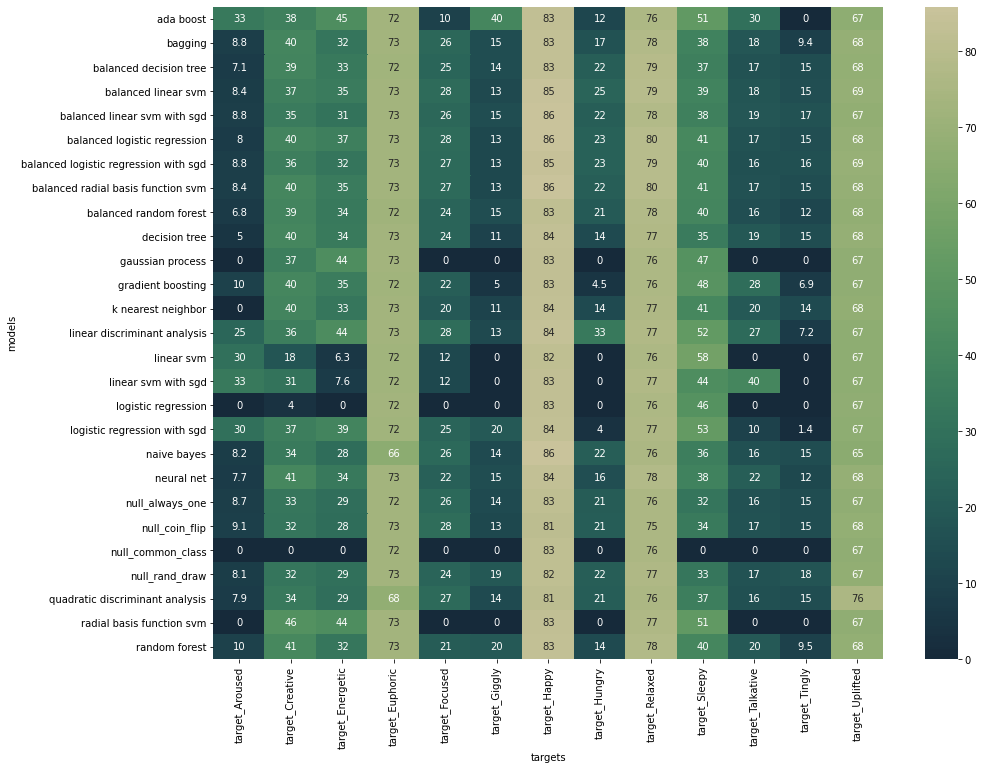

In [39]:
heat_map = pd.pivot_table(cv_results.query('measure == "precision"'), values='mean', index='models',
                    columns='targets', aggfunc=np.sum)

plot, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(heat_map, annot=True, ax=ax, center=50, cmap=sns.cubehelix_palette(start=0, rot=-.70, reverse=True, as_cmap=True))

Above, we see a heatmap showing the average precision across the five folds of each model for each target. The most prominent signal visible in the heatmap at present is the difference in precision inherent to each target. This is a result of the differing levels of class imbalance for each feature, and so the ability of a naive model to score higher precision in cases where there are more true positives to begin with. To remove this signal, and to provide a proper reference for determing which models actually imporove precision, we will use our null model that always predicts one as a baseline.

In [42]:
baseline = heat_map.loc['null_always_one']
baseline

targets
target_Aroused       8.72
target_Creative     32.88
target_Energetic    28.77
target_Euphoric     72.49
target_Focused      26.49
target_Giggly       13.80
target_Happy        82.52
target_Hungry       20.97
target_Relaxed      76.08
target_Sleepy       32.15
target_Talkative    16.13
target_Tingly       14.87
target_Uplifted     66.78
Name: null_always_one, dtype: float64

As we can see, our null model for Happy (the most commonly reported effect) has the largest precision, while the null model for Aroused (the least commonly reported effect) has the smallest precision. Now, let's see which models build from here, by subtracting this baseline from the average precision of all other models.

<AxesSubplot:xlabel='targets', ylabel='models'>

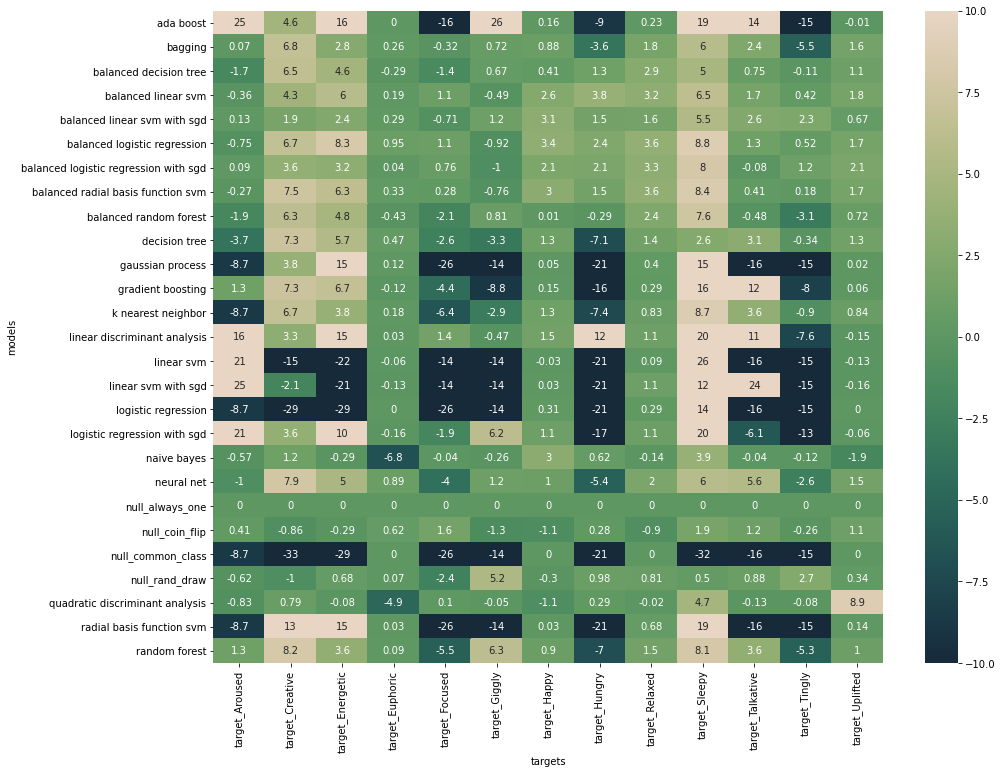

In [45]:
heat_map_subtract = (heat_map - baseline)

plot, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(heat_map_subtract, annot=True, ax=ax, vmin=-10, center=0, vmax=10, cmap=sns.cubehelix_palette(start=0, rot=-.70, reverse=True, as_cmap=True))

By subtracting out the baseline precision for each target, we can see much more clearly how difference models are more or less precise for each target. Different targets are more or less precisely predicted by different models, further justifying our decision to build individual binary classifiers rather than a single multi-class, multi-label classifier. 

Another consideration is how variable the precision for each model is. A model could show a large increase in average precision as compared to the baseline, but if the standard deviation of that precision is large, the model may not actually represent a significant improvement in precision. Therefore, in the interest of not only developing more precise models, but also models that are consistent in their precision and so likely more generalizable, assessing model performance via a standardized value comprised of the average model precision minus the baseline and divide by the standard deviation of model precision may be a more useful approach.

<AxesSubplot:xlabel='targets', ylabel='models'>

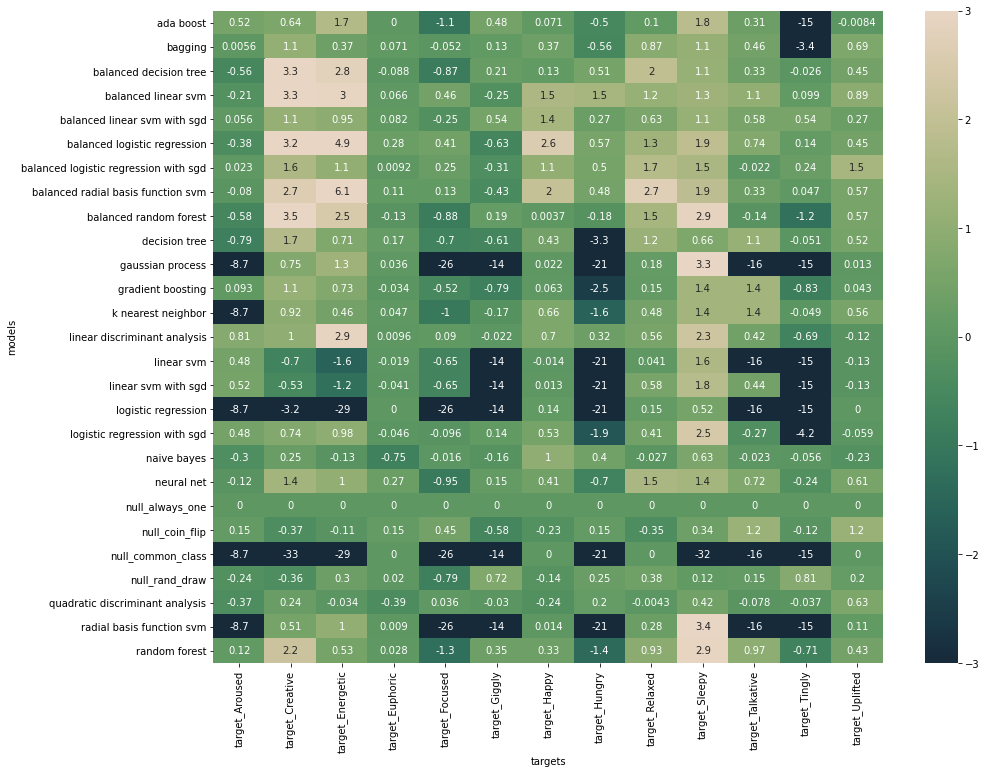

In [47]:
heat_map_standardize = (heat_map - baseline)/pd.pivot_table(cv_results.query('measure == "precision"'), 
                                                                            values='std', index='models', 
                                                                            columns='targets', aggfunc=np.sum).replace(0,1)

plot, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(heat_map_standardize, annot=True, ax=ax, vmin=-3, center=0, vmax=3, cmap=sns.cubehelix_palette(start=0, rot=-.70, reverse=True, as_cmap=True))

#### Broadened Model Survey (Sampling Strategies and Initial Feature Engineering)

A main feature of our heatmap of standardized precision scores is that balanced models (models with adjusted class-weights) tended to be most consistent in their significant improvements in precision over the baseline. We will use this to inform further experimentation by implementing some undersampling and oversampling strategies from the Imbalanced Learn library. The expectation is that this could help improve performance in models that do not have built-in methods for correcting for data imbalance.

Not visibile in the heatmaps of results, but very apparent when running our cross-validation, is the issue of collinearity in our input features - particularly regarding the linear support vector machine, a collinearity warning was repeatedly issued. To address this issue, we will experiment with running our models on a modified feature set. Namely, we will apply principal component analysis (PCA) to collapse collinear features. While technically our binary feature set does not meet the normality assumptions of PCA, it still can serve as a simple and useful embedding for compressing our feature set into a collection of orthogonal features.

So, we create a function for applying different sampling regimes (undersampling and oversampling) along with feature engineefing via PCA, and then initiate another model survey.

In [48]:
def sampler_regime(sampler, feats_cvtrain_input, feats_cvtest_input, targets_cvtrain_input, targets_cvtest_input):

    feats_cvtrain = feats_cvtrain_input 
    feats_cvtest = feats_cvtest_input
    targets_cvtrain = targets_cvtrain_input
    targets_cvtest = targets_cvtest_input

    if sampler == 'raw data':
        feats_cvtrain = feats_cvtrain_input 
        feats_cvtest = feats_cvtest_input
        targets_cvtrain = targets_cvtrain_input
        targets_cvtest = targets_cvtest_input
                
    elif 'pca' in sampler:
        n_comps = int(sampler.split('pca')[1])
        pca = PCA(n_components=n_comps)
        feats_cvtrain = pca.fit_transform(feats_cvtrain)
        feats_cvtest = pca.transform(feats_cvtest)

    elif sampler == 'random undersampling':
        rus = RandomUnderSampler(random_state=10, replacement=True)
        feats_cvtrain, targets_cvtrain = rus.fit_resample(feats_cvtrain, targets_cvtrain)
                
    elif sampler == 'tomek links':
        tlus = TomekLinks(n_jobs=-1)
        feats_cvtrain, targets_cvtrain = tlus.fit_resample(feats_cvtrain, targets_cvtrain)

    elif sampler == 'near miss':
        nmus = NearMiss(n_jobs=-1)
        feats_cvtrain, targets_cvtrain = nmus.fit_resample(feats_cvtrain, targets_cvtrain)

    elif sampler == 'all KNN undersampling':
        akus = AllKNN(n_jobs=-1)
        feats_cvtrain, targets_cvtrain = akus.fit_resample(feats_cvtrain, targets_cvtrain)
                          
    elif sampler == 'random oversampling':
        ros = RandomOverSampler(random_state=10)
        feats_cvtrain, targets_cvtrain = ros.fit_resample(feats_cvtrain, targets_cvtrain)

    elif sampler == 'adasyn':
        aos = ADASYN(random_state=10, n_jobs=-1)
        feats_cvtrain, targets_cvtrain = aos.fit_resample(feats_cvtrain, targets_cvtrain)

    elif sampler == 'smote':
        sos = SMOTE(random_state=10, n_jobs=-1)
        feats_cvtrain, targets_cvtrain = sos.fit_resample(feats_cvtrain, targets_cvtrain)

    elif sampler == 'borderline smote':
        bsos = BorderlineSMOTE(random_state=10, n_jobs=-1)
        feats_cvtrain, targets_cvtrain = bsos.fit_resample(feats_cvtrain, targets_cvtrain)

    elif sampler == 'smote enn':
        seos = SMOTEENN(random_state=10, n_jobs=-1)
        feats_cvtrain, targets_cvtrain = seos.fit_resample(feats_cvtrain, targets_cvtrain)

    elif sampler == 'smote tomek':
        stos = SMOTETomek(random_state=10, n_jobs=-1)
        feats_cvtrain, targets_cvtrain = stos.fit_resample(feats_cvtrain, targets_cvtrain)
                          
    else:
        print('unsupported sampler!')
        
    return feats_cvtrain, feats_cvtest, targets_cvtrain, targets_cvtest

In [ ]:
estimators_to_try = ['ada boost', 'bagging', 'decision tree', 'balanced decision tree', 'gaussian process', 
                     'gradient boosting', 'k nearest neighbor', 'linear discriminant analysis', 
                     'linear svm', 'balanced linear svm', 'linear svm with sgd', 'balanced linear svm with sgd', 
                     'logistic regression', 'balanced logistic regression', 'logistic regression with sgd', 
                     'balanced logistic regression with sgd', 'naive bayes', 'neural net', 
                     'radial basis function svm', 'balanced radial basis function svm', 'random forest', 
                     'balanced random forest', 'quadratic discriminant analysis']

null_to_try = ['null_rand_draw', 'null_coin_flip', 'null_always_one', 'null_common_class']

samplers_to_try = ['raw data', 'pca42', 'pca36', 'pca30', 'random undersampling', 'tomek links', 'near miss', 
                   'all KNN undersampling', 'random oversampling', 'adasyn', 'smote', 'borderline smote', 
                   'smote enn', 'smote tomek']

number_of_folds = 5

######################################################################################################################

seed(10)
kf = KFold(n_splits=number_of_folds)
kf.get_n_splits(feats_train)

fold_num = 0
models = []
target_of_model = []
samplers = []
cv_results = pd.DataFrame()

for cvtrain_index, cvtest_index in kf.split(feats_train):
    fold_scores = []
    fold_num +=1
    print('*************************************')
    print("fold " + str(fold_num))
    print('*************************************')

    for target_column in targets.columns:
        print(target_column)
        feats_cvtrain_0, feats_cvtest_0 = feats_train.iloc[cvtrain_index], feats_train.iloc[cvtest_index]
        targets_cvtrain_0, targets_cvtest_0 = targets_train.iloc[cvtrain_index][target_column], targets_train.iloc[cvtest_index][target_column]
        
        for s in samplers_to_try:
            feats_cvtrain = feats_cvtrain_0.copy(deep=True)
            feats_cvtest = feats_cvtest_0.copy(deep=True)
            targets_cvtrain = targets_cvtrain_0.copy(deep=True)
            targets_cvtest = targets_cvtest_0.copy(deep=True)
            
            feats_cvtrain, feats_cvtest, targets_cvtrain, targets_cvtest = sampler_regime(s, feats_cvtrain, feats_cvtest, targets_cvtrain, targets_cvtest)
            
            
            for null in null_to_try:
                if fold_num == 1:
                    models.append(null)
                    samplers.append(s)
                    target_of_model.append(target_column)
                fold_scores.extend(list(null_model(null, target_column, targets_cvtest)))
        
    
            for estimator in estimators_to_try:
                if fold_num == 1:
                    models.append(estimator)
                    samplers.append(s)
                    target_of_model.append(target_column)
                fold_scores.extend(list(estimator_single(estimator, feats_cvtrain, targets_cvtrain, feats_cvtest, targets_cvtest)))
        
    cv_results['fold_' + str(fold_num)] = fold_scores

    
cv_results['models'] = [m for mods in models for m in 3*[mods]]
cv_results['measure'] = ['balanced_accuracy', 'precision', 'f-Beta'] * len(models)
cv_results['targets'] = [t for targs in target_of_model for t in 3*[targs]]
cv_results['samplers'] = [s for samps in samplers for s in 3*[samps]]
cv_results['mean'] = list(round(cv_results.T[cv_results.columns.str.contains('fold')].mean(),2))
cv_results['std'] = list(round(cv_results.T[cv_results.columns.str.contains('fold')].std(),2))
cv_results['se'] = cv_results['std']/np.sqrt(fold_num)

cv_results.to_csv('./model_survey.csv')

Recall that our feature data is likely incomplete - with each strain assigned a maximum of three flavor values, there are undoubtedly flavors that are not being attributed. In this case, a value of 1 means that a strain has a certain flavor attribute, while a value of 0 means either that the strain does not have a certain flavor attribute OR that the data for that flavor and that strain is missing. In order to combat some of this (potential) incompleteness, we can use a probablistic approach to impute the potentially missing (e.g. 0) values.

We wish to impute values based on the conditional probabilities of a strain having a particular flavor, given the flavors already attributed to it. Due to our assumption that values are missing and the general sparsity of the feature space, we will condition on each attributed flavor individually, rather than conditioning on multiple flavors(events) concurrently.

For a particular flavor F and a particular strain S (with attributed flavors F1, F2, and F3), we will impute its value as follows:

imputed value of F = Pr(F) * Pr(F|F1)/Pr(F) * Pr(F|F2)/Pr(F) * Pr(F|F3)/Pr(F)

To calculate marginal and conditional probabilities, we will use averages from 100 1000-sample bootstrap iterations of the original feature set.


In [82]:
#generate df of conditional probabilities between all pairs (bootstrap)

total = len(features)
event_marg_df = pd.DataFrame()
ratios_df = pd.DataFrame()
 
for i in range(100):
    print('iteration: ' + str(i))
    features_bootstrap = features.sample(n=1000, replace=True, random_state=i)
    labels = []
    ratios = []
    event = []
    cond_event = []
    event_marg = []
    for A in features_bootstrap.columns:
        for B in features_bootstrap.columns:
            event.append(B)
            cond_event.append(A)
            labels.append('Pr(' + B + ' | ' + A + ')')
            given_A = features_bootstrap[features_bootstrap[A] == 1].sum()
            prob = given_A[B]/given_A[A]
            event_m = len(features_bootstrap[(features_bootstrap[B] == 1)])/total
            event_marg.append(event_m)
            ratios.append(prob/event_m)
            
    event_marg_df[str(i)] = event_marg
    ratios_df[str(i)] = ratios
            
            

iteration: 0


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 1


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 2
iteration: 3
iteration: 4
iteration: 5


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 6


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 7


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 8


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 9


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 10
iteration: 11


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 12


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 13


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 14
iteration: 15


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 16


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 17


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 18


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 19


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 20


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 21


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 22


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 23
iteration: 24


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 25


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 26


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 27


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 28


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 29


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 30


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 31


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 32
iteration: 33


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 34


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


iteration: 35


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 36


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 37


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 38


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 39
iteration: 40
iteration: 41


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 42


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 43


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 44


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 45


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 46
iteration: 47


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 48


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 49
iteration: 50
iteration: 51
iteration: 52


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 53


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 54


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 55


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 56


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 57


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 58


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 59


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 60


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 61


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


iteration: 62


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 63


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 64
iteration: 65


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 66


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 67


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


iteration: 68


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 69


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 70


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 71
iteration: 72
iteration: 73


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 74


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 75


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 76


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 77


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 78


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 79
iteration: 80


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 81


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 82


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 83


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 84


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 85


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 86
iteration: 87


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 88


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 89


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 90


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 91


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 92


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


iteration: 93
iteration: 94


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 95


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 96


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 97


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 98


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

iteration: 99


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python

In [86]:
Pr_data = pd.DataFrame()
Pr_data['labels'] = labels
Pr_data['events'] = event
Pr_data['cond_events'] = cond_event
Pr_data['event_marg'] = event_marg_df.T.mean()
Pr_data['ratios'] = ratios_df.T.mean()


Pr_data.head(5)

labels              events  \
0     Pr(feature_Ammonia | feature_Ammonia)     feature_Ammonia   
1       Pr(feature_Apple | feature_Ammonia)       feature_Apple   
2     Pr(feature_Apricot | feature_Ammonia)     feature_Apricot   
3       Pr(feature_Berry | feature_Ammonia)       feature_Berry   
4  Pr(feature_BlueCheese | feature_Ammonia)  feature_BlueCheese   

       cond_events  event_marg      ratios  
0  feature_Ammonia    0.006192  172.885965  
1  feature_Ammonia    0.003268    0.000000  
2  feature_Ammonia    0.001765    0.000000  
3  feature_Ammonia    0.069054    0.516375  
4  feature_Ammonia    0.001691    0.000000

Inspection of the ratios of conditional to marginal probabilities reveals that a large number of the ratios have a value of 0. These represent cases in which the conditional probability produced was equal to 0 because there were no examples in the dataset where two particular flavors were coattributed to a strain. Because we are working on the assumption that the data is incomplete, a ratio of 0 levels an unreasonable penalty against pairs of flavors that are not recorded in our data to be coattributed. Therefore, we shall set all ratios with 0 values to 1, neutralizing their effect on imputed values. 

In [87]:
Pr_data['ratios'][Pr_data['ratios'] == 0 ] = 1
Pr_data.head(5)

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


labels              events  \
0     Pr(feature_Ammonia | feature_Ammonia)     feature_Ammonia   
1       Pr(feature_Apple | feature_Ammonia)       feature_Apple   
2     Pr(feature_Apricot | feature_Ammonia)     feature_Apricot   
3       Pr(feature_Berry | feature_Ammonia)       feature_Berry   
4  Pr(feature_BlueCheese | feature_Ammonia)  feature_BlueCheese   

       cond_events  event_marg      ratios  
0  feature_Ammonia    0.006192  172.885965  
1  feature_Ammonia    0.003268    1.000000  
2  feature_Ammonia    0.001765    1.000000  
3  feature_Ammonia    0.069054    0.516375  
4  feature_Ammonia    0.001691    1.000000

Now, to use our calculated marginal and conditional probabilities to impute our (potentially) missing values.

In [90]:
features_mod = features.copy(deep=True)

In [91]:
for row in features_mod.index:
    true_feats = list(features_mod.columns[features_mod.loc[row] == 1])
    for col in features_mod.columns:
        if features_mod[col].loc[row] == 0:
            features_mod[col].loc[row] = np.prod(list(Pr_data[Pr_data['cond_events'].isin(true_feats)][Pr_data['events']==col]['ratios']))*Pr_data[Pr_data['events']==col]['event_marg'].values[0]
            print(np.prod(list(Pr_data[Pr_data['cond_events'].isin(true_feats)][Pr_data['events']==col]['ratios']))*Pr_data[Pr_data['events']==col]['event_marg'].values[0])


features_mod

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.03286774149883232
0.00023965141612200422
0.01744132950516259
0.0185165943331905
0.017293416339890337
0.0031857640294535527
0.006862862433767437
0.20723633318215562
0.2564092542801957
0.03871532798034689
0.07870826674443591
0.009315645514986318
0.019711050813678466
0.3790292220253729
0.07665662069361824
0.03174648363021091
0.0018182988872188098
0.03457828835199291
0.009803661814296706
0.1672011991272905
0.004224362910658014
0.002513246442486253
0.03212960202792676
0.31960214770155504
0.019320399138886068
0.0015305322582451816
0.4528456507106414
0.012336997821500561
0.014438737571057831
0.09746867834784663
0.1594136227566577
0.02494028288301907
0.008652402329519863
0.011063417857407958
0.006178221281112416
0.01705858968251076
0.17283853768595622
0.0065475580383122095
0.0006183221549704222
0.18204145266990268
0.027682836067833706
0.002928100972356769
0.0038880682853304274
0.115603164

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.04013774468839557
0.11110186876504578
0.2700175116535115
0.00644218183448558
0.33545533737813465
0.002935415199745197
0.01715173433850648
0.008349967671746889
0.019860436485292985
0.04504910361140175
0.010273312079679877
0.14082756334716762
0.02288359810716579
0.009825721640663075
0.009935314092108453
0.07431389352912104
0.0036257337881584056
0.0035351975313103593
0.00023965141612200422
0.007522615003071326
0.02326680111237436
0.05958582572077129
0.015602559335321132
0.1747309541586024
0.01763363885378489
0.26135974176661436
2.488115247109232
0.11895238062737647
0.023326527998622167
0.006259865358908761
0.007844247163241773
0.00811605469478174
0.07308316842275404
0.01335829424521957
0.006396514161220044
0.11331628820631634
0.054062504427746245
0.36646902863884406
0.009843643648398456
0.0011154684095860572
0.0005533769063180831
0.8152018477991825
0.3872085881310182
0.0072709354928377845
0.0005403050108932465
0.35251905589361254

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """



0.003058823529411763
0.0771780928532977
0.053012389132140854
0.25710585956568627
0.001355119825708062
0.04492693278841488
0.006578790462415073
0.03022088971600947
0.024197122022637248
0.014549129595239836
0.009010895157290448
0.007343172083066973
0.003267973856209149
0.029148391463927188
0.0016906318082788667
0.03825475580897923
0.00023965141612200422
0.003713223414838428
0.009241856077547626
0.18469344906272192
0.0023982703382046965
0.0021631798630094815
0.3310983488537256
0.34121617774299084
0.024679051062241615
0.011399941481836024
0.01624155551760014
0.005981010425060883
0.9132329636146963
0.12389059649395685
0.040637333390966236
0.02059299186079749
0.7853001917278792
0.019077960607856905
0.1073217800562546
0.0019327690765060955
0.0005533769063180831
0.08889352797132968
0.18081903060764332
0.014236947638935725
0.0005403050108932465
0.02171418441326399
0.005647143264318596
0.034459934652523914
0.0986809356487007
0.17177006387457883
0.008639588262510675
0.7570409769312417


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.001355119825708062
0.003922275059684816
0.0016906318082788683
0.08630789025917747
0.3534849900343744
0.002047084025305643
0.0015261447322429422
0.022833199776769928
0.011073183508294629
0.003003075317554062
0.003954165043523024
0.08076856120469897
0.0037252331644083408
0.01274447471203777
0.00023965141612200422
0.007587944634366409
0.015675813783620724
0.02431193896596662
0.004211825331093189
0.0041353743705484485
0.19214575957443103
0.020181095377647538
0.009204190888075415
0.04456823794616455
0.004379999379128349
0.009738597693417077
0.3953826614649608
0.04761030688882416
0.03377338980901886
0.00178505107514695
0.021978132435743838
0.008362748330571736
0.002061384636438048
0.0007368077043336737
0.03882191913080294
0.27660479815538297
0.00664283375893912
0.0009209346970151103
0.21081586262514354
0.004305814912966276
0.017920900262188275
0.031668762733768605
0.07923289224823746
0.007643548029405586
1.8138160645408234
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.04

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.007946126876081126
0.003624048317968608
0.003954165043523024
0.06714434972939605
0.008723493253910575
0.0064359820901304324
0.00023965141612200422
0.0137

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.06548370815652632
0.047909698914789134
0.006751197013802616
0.0018780483567235546
0.3956335495547669
0.18349534712926122
0.007194493217701021
0.009240787910549773
0.004367435557771517
0.0059702891850387
0.32270099365878335
0.03810637389012643
0.004414784576798609
0.003137852590669465
0.007940937097046562
0.010718746331288432
0.05689435864840159
0.0038774990380520194
0.0007368077043336737
0.04531527637313947
0.4787467581548943
0.0014851966429188642
0.0009209346970151103
0.004305814912966276
0.028554287244482352
0.25171630965304514
0.1578378248531927
0.005658094810011396
1.325775464709364
0.006021812570728645
0.008439818561830664
0.007343764471890191
0.009988212137413771
0.06133325771666322
0.0015487954175226353
0.0014238522258328097
0.30682030669671384
0.009336845652148368
0.003003075317554062
0.0019304852656783522
0.15182668643195305
0.007989145647693664
0.013496541725465609
0.00023965141612200422
0.06713517446421183
0.03422622337571694
0.011648324443930784
0.007169434101953162
0.17

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0939520575182918
0.08612469845369661
0.01090651536350615
0.02006398127948375
0.006649672485333036
0.022763958099245273
0.0225054652562589
0.013650113697528032
0.0024380270952928614
0.002513246442486253
0.035551778337854
0.2678581787228524
0.009995208247473566
0.0015305322582451816
0.1686418255646999
0.015437738080192859
0.025263630641787514
0.043812831829334146
0.10654509969594295
0.08826178368922204
0.008652402329519863
0.00973405421985396
0.02602890494595611
0.03935305937456921
0.11710489089496261
0.022153457285818284
0.0031443237134149947
0.08537304333563035
0.01562371679279086
0.002928100972356769
0.013663017513340222
0.04448885693065213
0.0016906318082788667
0.013123380521528222
0.00023965141612200422
0.0037385620915032667
0.00714220884701189
0.03110571610514624
0.0014771241830065366
0.337162187433149
0.010124467597543613
0.9891032953462834
0.06333539983669072
0.057886381954855196
0.006489048720035817
0.003369421252287525
0.007093580187392977
0.16086096752952841
0.0079946037145

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.06439700874073148
0.011066921165607967
0.02752909453677608
0.00023965141612200422
0.010301284025779253
0.07252049944903201
0.021503007440291443
0.0025941149969834036
0.32052133831479274
0.021279050104720688
0.5389835372535163
0.12923635252162363
0.0289921096979619
0.0029644585378173416
0.015178848504232654
0.011550142658430679
0.1430847019643729
0.012238402429990199
0.02471034337100473
0.006887901206495076
0.02617627762338566
0.013030759011287791
0.004709332811053013
0.001189696932708262
0.0036730402507409226
0.0075525168613204095
0.006315819128241757
0.007392735589574861
1.4009527302364555
0.0034501369614101393
0.021177053957634306
0.2090827213559688
0.002353331544125827
0.6183653409463723
0.008905084968438764
0.016963227984703958
0.030586747468127652
0.010073786799377602
0.011333373609611425
0.006280302003503878
0.000897278373059703
0.6854909646729287


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.005269555180318712
0.003003075317554062
0.0067838967987587685
0.05842915936321983
0.007989145647693664
0.006425810654557173
0.00023965141612200422
0.015372408221077393
0.032907671008493934
0.011813820002414554
0.007169434101953162
0.28571531702703745
0.05146251967587207
0.17124209379769087
0.1474887395082566
0.0269631494198476
0.0016110856564701345
0.0021888370581806863
0.011550142658430679
0.13489732256047882
0.0064901118047148865
0.013743993988982241
0.007041568986242022
0.026833988647572467
0.04198649946480371
0.010919047614417218
0.001189696932708262
0.0036730402507409226
0.02175014202494741
0.003974738620314389
0.0009209346970151103
0.8096596493490923
0.0034501369614101393
0.0354931956435548
0.137677473920026
0.33189132489384304
0.002353331544125827
0.5475914082112284
0.008905084968438764
0.030070591788500065
0.007848945749464329
0.0057569478905405095
0.005257059960799177
0.012743242639256858
0.0021184173070582218
0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.02786303403029856
0.1411801952269253
0.026936502543913027
0.011491991783808825
0.19250825939047184
0.010493821580730076
0.21465098714773706
0.2102204395422653
0.008072468030804535
0.000690765681483755
0.003928865162511744
0.007254945674238285
0.07175620236018272
0.008610505590853294
0.0020651080752390723
0.004380486068739124
0.005779351316007068
0.04402674631259244
0.008029313530739893
0.002237839862880128
0.0007368077043336737
0.02927571661537656
0.8270531713323164
0.0008039389696356562
0.0009209346970151103
0.0023322815364526677
0.035508013158994524
0.31903663513583996
0.3248875721748575
0.006152381269661078
0.7485955096258136
0.006021812570728645
0.030070591788500065
0.010818280571900585
0.005627472422341601
0.014083653581733411
0.008833403511033297
0.0028505408669757463
0.006249514417679961
0.003003075317554062
0.013895287396090934
0.049809485806667796
0.0037252331644083408
0.0097969134576513
0.00023965141612200422
0.007587944634366409
0.015263587934323966

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0037252331644083408
0.03137737230126485
0.00023965141612200422
0.033364597039179454
0.012599847063079294
0.04914453602463148
0.0025941149969834036
0.3240723602087759
0.011788119755663282
0.10519603454794595
0.005260417481295051
0.01850199864015394
0.06688616502769328
0.07376190280122172
0.014393838889116757
0.00712939453437122
0.009687322246638964
0.03245376555341131
0.012925863022172709
0.002132006617292937
0.001189696932708262
0.005108267217342467
0.016269162107095652
0.3140482427184703
0.002740037308032609
0.0009209346970151103
0.8631154282286938
0.021634159579748326
0.06789447491661212
0.22934712518827927
0.1872904597990413
0.005699476036343565
1.0787340799837097
0.010066404836222459
0.036906520739865625
0.026315255120955734
0.022661441728172634
0.04065302977401227
0.01121297231477184
0.02130668020735554
0.1967522263111372
0.002928100972356769
0.0038880682853304274
0.03473143524608057
0.06642676853632061
0.07129488502358393
0.00023965141612200422

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03336784596799482
0.3123702126421232
0.03137483584280222
0.17045719660808895
0.13669475657663135
1.0057708969797334
0.06131167470823706
0.07777847429349674
0.013418674494682913
0.006065359477124186
0.03183499189965649
0.12406048924983386
0.021229191966788366
0.02086794620377573
0.028002084065547914
0.1641705596421647
0.004288332544627554
0.018636779377661037
0.0011154684095860572
0.0038365466223449027
0.4046135233519128
0.06558472518956654
0.058094131943344444
0.031265543099477974
0.655081110787946
0.02683089981303525
0.025768591635020086
0.5800053662615975
0.33069852268175093
0.024557803534427273
0.37591162217377216
0.001355119825708062
0.015299368247493816
0.008349967671746889
0.0421021702728474
0.06316357886781021
0.014806081698261081
0.008852480495295644
0.08037998606544981
0.005568871366482556
0.033920824799259404
0.0019147160931308244
0.002690887015630071
0.6067778809401408
0.00023965141612200422
0.01198870622276748
0.02319692011640306
0.009310783497240765
0.004291107677865258

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.08711619724982031
0.000850874697258672
0.006725103428419112
0.025527507791481326
0.038925517896644383
0.004365248932023592
0.002487569736622369
0.0024773972845075665
0.004810220542840978
0.015281795825709047
0.008287944386332683
0.002237839862880128
0.0007368077043336737
0.00530124621073144
0.16911130716653175
0.000552600405669369
0.0009209346970151103
0.0020886219211662576
0.023217885361736863
0.21708007569551013
0.14203807068561272
0.02841179831382342
1.771838997690691
0.006021812570728645
0.006679758431125771
0.007343764471890191
0.01615607013094458
0.028124660592204163
0.006596209142721254
0.00120737715979673
0.26932711282431976
0.00608651649186163
0.009472451533588748
0.0035850773548143874
0.11616613042529768
0.0019045802646252788
0.013435643825944064
0.00023965141612200422
0.015470096061844447
0.04560299706956644
0.021267807260199112
0.0029077148723041252
0.0016303281666145942
0.29107288278028537
1.7518203651032256
0.17333468628115703
0.010992490028716521
0.01841452322045407
0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0032434149201714837
0.0009209346970151103
0.8830580279298378
0.0023322815364526677
0.339127375898289
0.0922864850554929
1.1501803211584294
0.0246850748956651
0.5599984651821698
0.004647105720632865
0.032167327628064436
0.026315255120955734
0.009561007043849478
0.010955076582001948
0.019278933900117912
0.006137880365370349
0.19978398963649424
0.011073183508294629
0.003003075317554062
0.003954165043523024
0.06467651328605091
0.007989145647693664
0.003984813716507407
0.00023965141612200422
0.015268219372011853
0.025962475147560594
0.026769851682431085
0.011640349096059316
0.010001235199132968
0.1519958529516874
0.15124766993914418
0.007026274385291492
0.021674961976688476
0.0023607870398632256
0.009738597693417077
0.25050636472616006
0.04031119039028873
0.014633667083057475
0.0018248752287213462
0.021356301407585168
0.024093019133702157
0.0748648723965095
0.002061384636438048
0.0007368077043336737
0.03707054172055232
0.8332228225668633
0.005064115165032053
0.0009209346970151103
0.549599

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.02175014202494741
0.003974738620314389
0.0009209346970151103
0.8096596493490923
0.0034501369614101393
0.0354931956435548
0.137677473920026
0.33189132489384304
0.002353331544125827
0.5475914082112284
0.008905084968438764
0.030070591788500065
0.007848945749464329
0.0057569478905405095
0.005257059960799177
0.012743242639256858
0.0021184173070582218
0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.07876387092021468
0.018708428462419137
0.004221370584324219
0.00023965141612200422
0.02786303403029856
0.1411801952269253
0.026936502543913027
0.011491991783808825
0.19250825939047184
0.010493821580730076
0.21465098714773706
0.2102204395422653
0.008072468030804535
0.000690765681483755
0.003928865162511744
0.007254945674238285
0.07175620236018272
0.008610505590853294
0.0020651080752390723
0.004380486068739124
0.005779351316007068
0.04402674631259244
0.008029313530739893
0.002237839862880128


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0007368077043336737
0.02927571661537656
0.8270531713323164
0.0008039389696356562
0.0009209346970151103
0.0023322815364526677
0.035508013158994524
0.31903663513583996
0.3248875721748575
0.006152381269661078
0.7485955096258136
0.006021812570728645
0.030070591788500065
0.010818280571900585
0.005627472422341601
0.014083653581733411
0.008833403511033297
0.0028505408669757463
0.007946126876081126
0.003624048317968608
0.003954165043523024
0.06714434972939605
0.008723493253910575
0.0064359820901304324
0.00023965141612200422
0.013753418236544515
0.06548370815652632
0.047909698914789134
0.006751197013802616
0.0018780483567235546
0.3956335495547669
0.18349534712926122
0.007194493217701021
0.009240787910549773
0.004367435557771517
0.0059702891850387
0.32270099365878335
0.03810637389012643
0.004414784576798609
0.003137852590669465
0.007940937097046562
0.010718746331288432
0.05689435864840159
0.0038774990380520194
0.0007368077043336737
0.04531527637313947
0.4787467581548943
0.0014851966429188642
0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.22249302080326042
0.20049013255103865
0.2609424401698801
0.009394335511982578
0.07236571512450621
0.026982421535028646
0.0290943538067913
0.0016906318082788683
0.0482733202900694
0.04310553836718584
0.006749455337690633
0.04377728545470072
0.12036853737883547
0.023559884089757035
0.0026907521737615436
0.014946543930051522
0.07154484140155219
0.0037252331644083408
0.01493901603438484
0.00023965141612200422
0.0076397240330615115
0.01211444269960932
0.049842765411610805
0.0025941149969834036
0.5443669847488598
0.01935505435044195
0.13970196596315088
0.09218611848483826
0.005750749408182281
0.004060978306793808
0.011550142658430679
0.24396170734979225
0.007090497368361446
0.008188739891555254
0.011886531644894581
0.034784220081758035
0.01164200837889822
0.013435645794658797
0.001189696932708262
0.025465085381819217
0.03251605463582982
0.004099444790115257
0.0009209346970151103
1.035391732102839
0.0034501369614101393
0.06942284109184658
0.3150454906792779
0.20732092626082158
0.00492395303

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.6182233670280113
0.008905084968438764
0.007425702666701706
0.026315255120955734
0.012686484666352615
0.008515644518978405
0.00736680198696664
0.006137880365370349
0.4983645505441274
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.1542809470864178
0.008090206050197347
0.02394623882791712
0.13352725801368456
0.0037252331644083408
0.009355866713462689
0.00023965141612200422
0.0076397240330615115
0.014528268764930756
0.06219620427792869
0.009914536275049363
0.3988012459217955
0.012678488804907951
0.1595550337232577
0.053857114814274486
0.006088048709771537
0.017540576565591562
0.013214989761440468
0.14065077743704948
0.012943606051893111
0.004078406954046923
0.0225464951063256
0.03722283447781102
0.035373059485461045
0.008449283666298206
0.001189696932708262
0.005108267217342467
0.21050630692543798
0.3970377897716665
0.0030601082663355805
0.0009209346970151103
0.7494203446572939
0.0023322815364526677
0.274660754394883
0.3645661635778747
0.0333857752695568
0.6769813481830993
0.004647105720632

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0024380270952928614
0.002513246442486253
0.02075717504598428
0.5521248244895051
0.010458158420113137
0.0015305322582451816
0.7389191659261314
0.006682440563735374
0.017954952938685563
0.12353621111836566
0.3281311366092455
0.02711904526556109
0.008652402329519863
0.03941832632282975
0.00910129015033049
0.009611003619234953
0.039688061273175326
0.037343358270541936
0.0012378760518274878
0.14485561501023655
0.004242092712463564
0.0073317799623958705
0.0710117812833654
0.0037252331644083408
0.02505246519764262
0.00023965141612200422
0.011394222373125342
0.013163277522205478
0.013714730220815449
0.0025941149969834036
1.5841533619781376
0.0075424413485434
0.09178012662563702
0.1436804955677441
0.05462168978471356
0.02900176521260264
0.017380853156619476
0.011109012784741544
0.05334620028614187
0.003174997468548672
0.016895753802987887
0.011922832071931748
0.037662726815382394
0.01064103132955299
0.0007368077043336737
0.015376834485439772
0.7067193595840863
0.011899617079409142
0.00092093

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.018949591976614628
0.1297227600696136
0.12617132681116805
0.03591125280880521
1.2531111803723953
0.004647105720632865
0.007425702666701706
0.005328093365079287
0.016393827228491947
0.13564382599028094
0.005580113842570483
0.000897278373059703
0.160945054771212
0.11827754571360374
0.003800910393634792
0.016153661316527075
0.05966494963651047
0.0037252331644083408
0.007736154380191821
0.00023965141612200422
0.011394222373125342
0.008025762964070874
0.0637126131524926
0.0025941149969834036
1.3294298763478127
0.006860473635695421
0.09568652914244535
0.06103781571956051
0.016941350211144797
0.017380853156619476
0.011109012784741544
0.05828113661557919
0.00822768145168271
0.005479130253316729
0.024212390214611794
0.009524449098364885
0.020080016449423244
0.01064103132955299
0.005108267217342467
0.028688981756261007
0.7114333241244194
0.0017853174751757247
0.0009209346970151103
0.7297040495298356
0.0023322815364526677
0.06212075179010437
0.2210497601480221
0.21417361786379277
0.01940718980

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.09306484810495573
0.6040801060711127
0.008311282032012302
1.015835271585593
0.004647105720632865
0.030070591788500065
0.007848945749464329
0.023001040378530863
0.012743242639256858
0.0021184173070582218
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.5110608093594307
0.001792118552913722
0.11132285625377077
0.00023965141612200422
0.07669045555916754
0.024410349560406195
0.007524857689189973
0.001962151228030802
0.3760537287655256
0.021507644177598952
0.13447638660858233
0.1695361417389094
0.005351510779528821
0.039351160977729054
0.1353784845721815
0.06171172791105937
0.025053947470862228
0.025959180999513443
0.005718078735982341


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.040536430731414566
0.018968736580589167
0.003869688984759754
0.0024380270952928614
0.002513246442486253
0.009432044753902684
0.18553680536888056
0.010135671572082285
0.0015305322582451816
0.5561229504968835
0.06198607812928093
0.016686566914132627
0.09937158427973256
0.1442743347971505
0.008888132537800417
0.01874254426106745
0.04837926995905234
0.006178221281112416
0.03986145030185157
0.12585163703951865
0.03285898685929845
0.0018200788946659899
0.23761016998221046
0.012589176367763253
0.00557083454198869
0.006702167303624042
0.03145620934101692
0.003959004584001579
0.004721299924486301
0.00023965141612200422
0.6523513586932884
0.032418753441880596
0.016866663777076487
0.0023677041637291756
0.9655781657922287
0.0017917676034223666
0.2163616977348178
0.9339881611113445
0.0555632333267624
0.011478629847509752


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.002283228926047738
0.014379645790810934
0.0041826598079196505
0.0568585438621833
0.0038930198852462857
0.010834640991649791
0.07654912248770787
0.006880547284461008
0.017778338633135646
0.0005533769063180831
0.01745581697210265
0.2503005464276375
0.0012440829577898317
0.0005403050108932465
0.003058823529411763
0.017849657884109173
0.11982110026618036
0.07985304230721581
0.007760775770513029
1.0283525458461333
0.0017559913829937816
0.003450980392156861
0.0023302147612612387
0.018635469732187576
0.07146129435384709
0.0850526863323858
0.0017413638131281975
0.09667078128416445
0.007151769148669129
0.007849367034154951
0.0017502908790119646
0.24817395668428607
0.0008133216086203938
0.12812109373057512
0.00023965141612200422
0.050036609619809436
0.03117354172024227
0.005510744390288929
0.025575750089387693
0.06584796960250612
0.24090493435237423
0.06403696052752723
0.44708977673318595
0.16492933593858353
0.06338724601779443
0.013651042233934114
0.12114116058158143

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.014710475419788958
0.04301508540267153
0.0598756031032803
0.013876687979644588
0.004820163406717589
0.019638736333289237
0.025064180085675316
0.03382660226482007
0.05486136244554979
0.0018875651448510649
0.03238954972166787
0.07050762656646924
0.029401435191473
0.0008979510177474176
0.09760205592822298
0.008764124789727844
0.0063332005900160965
0.038106104995735385
0.07355684982671537
0.07670448565625033
0.0025230848277620448
0.03516834759193221
0.0019603818290595282
0.014739082517871146
0.07195725850025905
0.0007562047563546588
0.10138606187283904
0.3623112088844556
0.0026907521737615436
0.05177520923489381
0.11850979219023638
0.057721565740695556
0.03550102091788851
0.00023965141612200422
0.0076397240330615115
0.012441619144105269
0.0025941149969834036
0.5916012168119579
0.008690506453843587
0.11379859673567978
0.12828687118776197
0.011891948687428329
0.007310244524274068
0.011834099659034385
0.1137282601657831
0.03038768953713422

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.004078406954046923
0.02169002538650993
0.01822499282473961
0.009524449098364885
0.013000530826633267
0.001189696932708262
0.005108267217342467
0.05573569353675971
0.2594523731889152
0.0032434149201714837
0.0009209346970151103
1.1406829237948009
0.0023322815364526677
0.2823091395921026
0.4268067462973549
0.169056041092597
0.017389968923419374
0.36826392389258533
0.09253068480969319
0.0626042446198961
0.026315255120955734
0.009561007043849478
0.03484661107939445
0.00736680198696664
0.006137880365370349
0.1762684569178912
0.19831914133954742
0.13411813453513247
0.0019304852656783522
0.2428598858513685
0.0037252331644083408
0.08007253558539175
0.00023965141612200422
0.07154149395265072
0.020405846316743522


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.012413978615895828
0.1917503828919248
0.05918092259896728
0.06953164650124026
0.15567376134188335
0.06509478366607219
0.03470952447258024
0.07466276208339384
0.011834099659034385
0.058166062003701176
0.009108705310831692
0.006845204683916055
0.04111235001052242
0.042017615665865246
0.010565432974211005
0.001189696932708262
0.0007368077043336737
0.015376834485439772
0.1815427743475537
0.0036076914764608782
0.049922054881154705
0.46938628590262504
0.0023322815364526677
0.08483393510939433
0.06215250023370866
1.310770302209882
0.008311282032012302
0.3459167892265745
0.004647105720632865
0.007425702666701706
0.005328093365079287
0.046207670489769155
0.026612423402682363
0.6716349784047821
0.000897278373059703
1.3095176764309904
0.009336845652148368
0.003003075317554062
0.0019304852656783522
0.16523370876083804
0.0037252331644083408
0.20166408681565912
0.00023965141612200422
0.033364597039179454
0.0916165616227052
0.08918736120122729
0.0025941149969834036
0.20530645490883137
0.14886338420

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0030302713508853344
0.01850199864015394
0.06688616502769328
0.041678267169319154
0.013175045252292211
0.011965987065547242
0.005613522984140668
0.02264670393588062
0.01618076726606842
0.0017326656361935863
0.001189696932708262
0.0007368077043336737
0.037774125484900035
0.15537553399910015
0.003047778185854621
0.0009209346970151103
0.34066913330833964
0.021634159579748326
0.020710834303541745
0.1710111993309215
0.3547073695591988
0.0027239814505334173
1.065520289419853
0.010066404836222459
0.005328093365079287
0.017994467225550433
0.046020450627261546
0.08717139899795637
0.0031147598541708963
0.8185578057279164
0.009336845652148368
0.003003075317554062
0.0019304852656783522
0.15182668643195305
0.007989145647693664
0.013496541725465609
0.00023965141612200422
0.06713517446421183
0.03422622337571694
0.011648324443930784
0.007169434101953162
0.1700919411552256
0.03134304527817076
0.09863064439798894
0.03076836778151386
0.0014737180408349623
0.009972439450421776
0.06688616502769328
0.0407

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.1434249895559174
0.012951984185599041
0.005940983141331101
0.025988808609268048
0.014710475419788958
0.0576839306631248
0.03682760623734811
0.024948914056874067
0.004927700345259812
0.023413282361211055
0.016211072720583038
0.014589251146942607
0.0022859117576467095
0.0018875651448510649
0.006693532763148906
0.3247223790270501
0.03549792318357198
0.00720823579360414
0.9563120532172089
0.008764124789727844
0.010614579725820788
0.27459597219907467
0.030652961722156907
0.0025230848277620448
0.04184793765199727
0.016578362829068258
0.008423061922950689
0.05170551323655573
0.02916786453832798
0.0017853514490478687
0.029955899874933533
0.00324714329753581
0.00425331983750962
0.09644411650916751
0.008723493253910575
0.009814033782893333
0.00023965141612200422
0.013847270229489372
0.05197327349464465
0.11364569436736899
0.0041581452326156405
0.36678166852960736
0.0039467264393215785
0.1991217010031339
0.027599501926322892
0.002465679163632336
0.007289275433110402
0.007254945674238285

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.12977103850878113
0.009407043987725088
0.0012304016495961326
0.007394486424519968
0.007491626785195572
0.012207727626745695
0.009879892128214721
0.002237839862880128
0.005108267217342467
0.043766647586796936
0.5369678160437331
0.0008291623010880751
0.0009209346970151103
0.0023322815364526677
0.06945182337989071
0.7300471921748161
0.20294592639763964
0.012872829808006114
0.8451543058623007
0.006021812570728645
0.007425702666701706
0.03627057980864143
0.01240116185759951
0.022813395381597806
0.005106544415649067
0.00825912758539191
0.31716271867009926
0.031975156614481866
0.007033024208998853
0.003856308592180735
0.3216376288627702
0.0008133216086203938
0.06550285450301706
0.00023965141612200422
0.03752910821030323
0.008774560953712957
0.021815969286777023
0.0011172754611922138
0.4178610844730813
0.010233231535428843
1.6298240350235973
0.16072936978851277
0.010482664551580121
0.03264992523568286
0.08314340042021534
0.07201437176253252
0.030861776736835402
0.014452801341311387
0.019156

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.043447288899954854
0.01708467665404768
0.02438630823798292
0.0024380270952928614
0.012528717179513824
0.018851178722457403
0.015164255573704601
0.0015305322582451816
0.6671241019973317
0.009885313938743569
0.017062196661378922
0.13650299520120374
0.1597042836987164
0.007678731683536571
0.01658029374786825
0.00973405421985396
0.006178221281112416
0.022315512141680288
0.026362310733482722
0.021588000299072888
0.0005243156795087543
0.601855886401195
0.02403193479776459
0.011087881312334425
0.013615746662759968
0.0718659320253596
0.0008133216086203938
0.01059097789289769
0.00023965141612200422
0.012729564148093205
0.0070420587413889115
0.011923263649484178
0.0018140171483262497
0.002833949496259915
0.2033237496529786
1.0030171832903279
0.08329476107668203
0.02431049598152287
0.12652371462205722
0.01837709166672271
0.011363919691775077
0.5061937169711435
0.059846597638600126
0.00459769358252879
0.03963141256528219
0.004414046584803362

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.3702134094740471
0.03542660495067731
0.0018875651448510649
0.023908395882512135
0.30111817094392745
0.02606147590242403
0.0008979510177474176
0.2155180639129479
0.01618016462802514
0.012165005434727745
0.04901027470586879
0.10647358147205291
0.03146032968774996
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.032282683999968226
0.10539173949849341
0.0045439458868026
0.000891787472360511
0.054008001811054154
0.19861256014423914
0.009825721640663075
0.12094151993857451
0.1430843502255076
0.026195921371375067
0.030728948238207026
0.00023965141612200422
0.01632724129159053
0.014226859751352105
0.005645471119129672
0.2892669322101113
0.009890143337906705
0.44297616143020735
1.5761249583197963
0.0811363572790475
0.0017505043860746832
0.03683453964915651
0.045871827120750365
0.04148250372321399
0.05900148960917825
0.011181638716749211
0.3011699284843305
0.03990366992991743
0.02705705107218827
0.0016142966526924505
0.0011154684095860572
0.0005533769063180831
0.092497572894

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.011250469393315138
0.22839441310316413
1.86514417636121
0.050548646555275564
0.005403717363304364
0.12203666983343867
0.08314340042021534
0.04223677163408035
0.05326831444790232
0.04361277663551396
0.011100419269472616
0.03771351205038806
0.007636410038903812
0.0023925469199233673
0.0022859117576467095
0.0018875651448510649
0.0030415362612625043
0.10912016660755464
0.034403312364032705
0.00720823579360414
0.7197364815464172
0.08129570607765617
0.009864737349362872
0.12073572668654227
0.010046356123334441
0.005465421886060402
0.0513612033223999
0.011253876356511197
0.03493448525595745
0.16395921786149809
0.02566524602943289
0.002625045122390187
0.09644462562842913
0.011311285518707451
0.003267973856209149
0.011205977023828887
0.044325697452404965

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.005022528286565141
0.01499670176279234
0.00023965141612200422
0.005006852195431469
0.033731747338070744
0.03040835273592229
0.0023982703382046965
0.0021631798630094815
0.26521401087377383
0.7265474520653391
0.060083956068535616
0.004744005490586039
0.04500302272824242
0.013583348618452878
0.005981010425060883
0.1752014315644802
0.08570741868028904
0.024585323160380944
0.0034652924988361348
0.017972746956897462
0.003366664671265132
0.046287368459882856
0.0019327690765060955
0.0005533769063180831
0.009578635144691776
0.1574117672427429
0.01971944329095275
0.00433725876134581
0.3590168785334593
0.005647143264318596
0.010594448520197895
0.10202190384236381
0.008639588262510675
0.5737136871501599
0.001355119825708062
0.008960020221992627
0.0097053344673588
0.006748857723250383
0.08233975111381595
0.0017451678392080058
0.0015261447322429422
0.06285838358745686
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.25538103529662154
0.003843382549568734
0.021558002367519227
0.00

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.02786200340032903
0.013924298213979308
0.041437304528370494
0.02216141838119795
0.03495874534106407
0.0022859117576467095
0.009409650187091188
0.0175063678687003
0.0323927422039038
0.0008979510177474176
0.4989859802031483
0.01296474306332723
0.01690569523089386
0.08853185350735696
0.2121490257673863
0.008679356742291646
0.004834898563646159
0.018319057109803152
0.002887886823712767
0.01117654713976956
0.01593104147970701
0.03421394103605955
0.0017853514490478687
0.0025076571738155127
0.003943722319427623
0.0062013333118283095
0.031177270954580703
0.008490492499547734
0.0026267367123674694
0.00023965141612200422
0.013635005967381252
0.08104559605092507
0.01452888439622399
0.0065436956320425775
0.21486603776327637
0.012225335443081848
0.24051733173262788
4.790820437041872
0.09970355580352981
0.007655679716595101
0.00037692831335670404
0.001810883580156811
0.004348749831264164
0.11212901403752391
0.006917424385232504
0.0038745942487132022
0.02402927017725845
0.00951611674300784
0.02422

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0007368077043336737
0.015376834485439772
0.14852204681309947
0.0036076914764608782
0.0009209346970151103
0.3148994590807406
0.0023322815364526677
0.013296437947168225
0.3990412859079354
0.2439316591299016
0.008311282032012302
0.4523563878948979
0.004647105720632865
0.007425702666701706
0.007591980684967636
0.026612423402682363
0.00736680198696664
0.000897278373059703
0.24227746164280994
0.019475422158348212
0.009029258933687022
0.03819341576299985
0.0839820947594739
0.0037252331644083408
0.009893984029669354
0.00023965141612200422
0.0076397240330615115
0.023201609413463668
0.011571208548064971
0.009914536275049363
0.400583343157541
0.031043783232271478
0.29863527924638156
0.14337952723764047
0.05387503431405309
0.00169594140357944

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00974412014331309
0.012897898561958925
0.18834288770515223
0.008441629579091068
0.013743993988982241
0.0369181409517132
0.04957517470513092
0.054125289066799566
0.0070964895118763235
0.001189696932708262
0.0036730402507409226
0.12787911670261892
0.00430215649160789
0.0009209346970151103
0.5290941771952345
0.0034501369614101393
0.13344121906076992
0.1760410227069096
0.004517995311718777
0.6091373964571619
0.008905084968438764
0.02387247318859766
0.014074382314822607
0.02425038140436757
0.014504209666458264
0.009180077025393198
0.002646287721051503
1.3913310759530189
0.09760415807406804
0.011857474828062393
0.009935314092108453
0.01590889174065442
0.003959004584001579
0.011307361524923822
0.00023965141612200422
0.006776276122898782
0.18712982250744267
0.03198791448692663


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.009049209016244902
0.3229277460084268
0.009038185408451622
0.38717866749950236
1.587376007161551
0.05254087134000888
0.02164909173236851
0.003299803821948092
0.06768530233484245
0.004975582223936806
0.06605935870763996
0.04671045060735867
0.0019297440555363513
0.25677844424539203
0.05272458532402688
0.02555381480568258
0.009777042792581177
0.0020982147672455216
0.0005533769063180831
0.15832232119883746
0.0021324098352676272
0.0005403050108932465
0.003058823529411763
0.6140171489100297
0.08563704376949256
0.01895132551649298
0.47934629792081096
0.0017559913829937816
0.048059558537908574
0.0061553601219872245
0.020774993812986794
0.020065438299583797
0.0152576690791738
0.0051356968081721025
0.3350129659913105
0.012776553612781318
0.003943722319427623
0.0036146032482912956
0.04546967061861979
0.003959004584001579
0.004858900582791247
0.00023965141612200422
0.010139765531898102
0.03860667232721896
0.04431957509738874
0.0038442229372737243
0.0009823914410156895

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.19374696913397454
0.8413002087258334
0.14385849006975718
0.007269318395038421
0.05262725940592213
0.0035306254091042174
0.0036666841552025716
0.11708521796841684
0.0866068788273339
0.03821283829212859
0.006006799415342589
0.011593407915661201
0.004826058521113051
0.3697876669820306
0.016497937154159318
0.0005533769063180831
0.01571370759855844
0.06894370588166726
0.049288592908763355
0.006360195024078694
0.010989131307475253
0.016880676853098683
0.1433584023566467
0.11609034375606682
0.00916183106917702
1.9294460577417207
0.0017559913829937816
0.003922275059684816
0.0023302147612612387
0.013873454314394157
0.001266113771988815
0.00205357929888679
0.0507265412969289
0.0037814377420872162
0.003624048317968608
0.0067838967987587685
0.06065861796425536
0.008723493253910575
0.010378503295142028
0.00023965141612200422
0.013847270229489372
0.0830011896856326
0.02114305921689717
0.0041581452326156405
0.36842068195871014
0.009663716389601945
0.44573003859457366
0.17893497112791198
0.02760868

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.00664283375893912
0.0009209346970151103
0.21081586262514354
0.004305814912966276
0.017920900262188275
0.031668762733768605
0.07923289224823746
0.007643548029405586
1.8138160645408234
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.04592137036020898
0.28655369900791194
0.002234322906160477
0.0010581546936731777
0.15486390363072716
0.011311285518707451
0.003267973856209149
0.011205977023828887
0.045753464971131606
0.005022528286565141
0.01381871815923551
0.00023965141612200422
0.005006852195431469
0.033731747338070744
0.03040835273592229
0.0023982703382046965
0.0021631798630094815
0.3263399552517654
0.5068205378290382
0.009853397037360035
0.0027443080115927437
0.04500302272824242
0.013583348618452878
0.005981010425060883
0.2706079986034177
0.10122639561149104
0.056741054580747005
0.0034652924988361348
0.0204475960883773
0.003366664671265132
0.0019327690765060955
0.0005533769063180831
0.012518841656182833
0.16268018412387156
0.022547641087799525
0.00433725876134581
0.27

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.005269555180318712
0.003003075317554062
0.0067838967987587685
0.05842915936321983
0.007989145647693664
0.006425810654557173
0.00023965141612200422
0.015372408221077393
0.032907671008493934
0.011813820002414554
0.007169434101953162
0.28571531702703745
0.05146251967587207
0.17124209379769087
0.1474887395082566
0.0269631494198476
0.0016110856564701345
0.0021888370581806863
0.011550142658430679
0.13489732256047882
0.0064901118047148865
0.013743993988982241
0.007041568986242022
0.026833988647572467
0.04198649946480371
0.010919047614417218
0.001189696932708262
0.0036730402507409226
0.02175014202494741
0.003974738620314389
0.0009209346970151103
0.8096596493490923
0.0034501369614101393
0.0354931956435548
0.137677473920026
0.33189132489384304
0.002353331544125827
0.5475914082112284
0.008905084968438764
0.030070591788500065
0.007848945749464329
0.0057569478905405095
0.005257059960799177
0.012743242639256858
0.0021184173070582218
0.044224279133288205
0.06144601171516144
0.0017647058823529419
0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.0037385620915032667
0.08093879550312905
0.0316337422343347
0.0014771241830065366
0.072917228680617
0.013641649990619073
0.2843956045885962
0.41274813212244305
0.016658131921600115
0.035470988345877176
0.03814313492122884
0.14208657828411145
0.042801848142454274
0.023920665577114655
0.03346033404686812
0.07298800686941542
0.06280038842642387
0.00864365237071314
0.011451048751524357
0.0011154684095860572
0.0005533769063180831
0.028618904649670415
0.02005945765955897
0.0005403050108932465
0.04404315750198373
0.00706647758857042
0.42392032996549955
0.006928876760880336
0.561091647153023
1.7828877042956557
0.001355119825708062
0.014949267684837576
0.007122647868057133
0.0155691767981198
0.031678398813067846
0.045357609911358364
0.007760829905770413
0.02747873996152039
0.039857972459771934
0.021687434029581197
0.010779873276732722
0.36706730919620617
0.001792118552913722
0.033193404319273125

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.01756034744713995
0.028146382831794433
0.009523288321709443
0.007499212467475859
0.46276916509823157
0.023132139100862818
0.19608133689946222
0.28556952496441557
0.08679725894648606
0.006193473885387905
0.037306350816434415
0.02674731443789585
0.11767324564640165
0.022529669020601602
0.014850083523834018
0.013308387081181313
0.04649324433411068
0.05191005399625812
0.015335834170205223
0.0024380270952928614
0.002513246442486253
0.12204100585078967
0.23456626436529232
0.011319646003236986
0.0015305322582451816
0.48286687921743077
0.006682440563735374
0.06750394730241856
0.15795932571545018
0.052063942997716106
0.008652402329519863
0.03129346255968994
0.0163200308962032
0.04048508130986785
0.10949921938380708
0.02690170116155152
0.0015463318701279686
0.5253535452240805
0.005269555180318712
0.003003075317554062
0.0067838967987587685
0.05842915936321983
0.007989145647693664
0.006425810654557173
0.00023965141612200422
0.015372408221077393

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.032907671008493934
0.011813820002414554
0.007169434101953162
0.28571531702703745
0.05146251967587207
0.17124209379769087
0.1474887395082566
0.0269631494198476
0.0016110856564701345
0.0021888370581806863
0.011550142658430679
0.13489732256047882
0.0064901118047148865
0.013743993988982241
0.007041568986242022
0.026833988647572467
0.04198649946480371
0.010919047614417218
0.001189696932708262
0.0036730402507409226
0.02175014202494741
0.003974738620314389
0.0009209346970151103
0.8096596493490923
0.0034501369614101393
0.0354931956435548
0.137677473920026
0.33189132489384304
0.002353331544125827
0.5475914082112284
0.008905084968438764
0.030070591788500065
0.007848945749464329
0.0057569478905405095
0.005257059960799177
0.012743242639256858
0.0021184173070582218
0.056666343100149036
0.005888510612611272
0.00607824584081434
1.0847524609361865
0.02706541204311327
0.00023965141612200422

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0076397240330615115
0.07084575202303
0.020896289584298244
0.0025941149969834036
0.15811449276499867
0.009554389200798789
0.034735883745769296
0.29832643507759166
0.09431863897354742
0.0203577341507427
0.01531541969361649
0.011717910458563482
0.04304265407992381
0.009108705310831692
0.003769513964760146
0.015285779018919421
0.03032023118365225
0.022468846936341647
0.001189696932708262
0.0007368077043336737
0.030451432603747348
0.2112305741930781
0.020511392990374043
0.0009209346970151103
0.03207349144485765
0.0023322815364526677
0.013296437947168225
0.15425678483403127
0.040964911509561885
0.04861334647630885
2.011182491426453
0.016491413621907636
0.03196698713243242
0.005328093365079287
0.008759498806697756
0.21184915465568907
0.014359042423958343
0.000897278373059703
0.04738398718577796
0.07051182287184675
0.023600462833099124
0.009854157460137325
0.21966624663568643
0.03195629348557914
0.10123594178811039

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.07669792340991477
0.005943263791168827
0.004270153058786538
0.22018462141954143
0.051919610252458094
0.06627630751852842
1.4213104593351336
0.13111253935175254
0.09204031191681776
0.006988611559281103
0.030953332372127468
0.016427002278117952
0.05005139321285828
0.04806258246358441
0.013876687979644588
0.08859101015639513
0.0636262659934628
0.02337222569479043
0.021984529848349758
0.0022859117576467095
0.0018875651448510649
0.28958097653111525
0.09080083001169645
0.05107076434030868
0.0008979510177474176
0.7615148921348095
0.008764124789727844
0.03990687321186495
0.2792884476093394
0.07352377045617672
0.0025230848277620448
0.0644747344364804
0.005178430904767832
0.1782772232047069
0.121340074941772
0.054068072675881
0.002230228011088958
0.26378576742533416
0.04816600171880895
0.003533570850415663
0.0038880682853304274
0.06531126190735517
0.003959004584001579

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0074091900504755755
0.00023965141612200422
0.01020895830905321
0.03064144038368274
0.10512962928378417
0.0023677041637291756
0.5395141796624908
0.0020644997026509305
0.9399360957336084
0.15610939293329112
0.027886546136883836
0.01404230225954141
0.005892634411583711
0.004455662619701482
0.04708467165692872
0.02138001167776826
0.010649928315297293
0.014155284688529229
0.010937435243627463
0.005496464429287548
0.06421484215516844
0.009521534642963217
0.0038365466223449027
0.01517669884842045
0.07732804566639524
0.027517058638986045
0.006360195024078694
0.0059523571189506064
0.04105841540698813
0.4157791732263756
0.1492675306524845
0.020844241046392244
1.2299817631539394
0.0017559913829937816
0.003450980392156861
0.011508844107557032
0.01722499984079853
0.004174512746342994
0.011911891647537603
0.05243645024567518
0.0265685952711068
0.08285983264008238
0.08533602661379822
0.11253198294071197
0.0008133216086203938


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.05596207309269547
0.00023965141612200422
0.008593301144831419
0.021949371672129847
0.00476280998754887
0.0011172754611922138
0.5942955578004865
0.018472279811289197
0.18548318109049042
1.1943207535669025
0.20185782715435158
0.09329091061296667
0.022419954867337267
0.022487206480114447
0.014357500322569043
0.17879549430913
0.06965011977274883
0.02786200340032903
0.12015631121160669
0.025414377979888308
0.039772568222588255
0.02920435210243129
0.009409650187091188
0.08029211483306917
0.037161314011351594
0.0008979510177474176
0.10352928481134241
0.01296474306332723
0.022012606570714573
0.07131090597636398
0.15945019463327173
0.008679356742291646
0.004834898563646159
0.0045237510518083305
0.0019603818290595282
0.019557264574903286
0.04943679523597838
0.019778900546862807
0.009385177511033693
0.20171549484641793
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.30896976261817577
0.001792118552913722
0.19028454157799954
0.00023965141612200422
0.1644422606444027
0.024103806

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.011087257088605643
0.004299838314824513
0.0018875651448510649
0.008182218899342198
0.18657648596401705
0.010410781474101629
0.00720823579360414
0.008764124789727844
0.010091012514912732
0.13082793393739092
0.022690688010905534
0.0032694638009576143
0.010334028156281363
0.015511330544554395
0.019117415884994823
0.092009537402868
0.011688311993350952
0.0010175485984788308
0.15546781980022273
0.007946126876081126
0.003624048317968608
0.003954165043523024
0.06714434972939605
0.008723493253910575
0.0064359820901304324
0.00023965141612200422
0.013753418236544515
0.06548370815652632
0.047909698914789134
0.006751197013802616
0.0018780483567235546
0.3956335495547669
0.18349534712926122
0.007194493217701021
0.009240787910549773
0.004367435557771517
0.0059702891850387
0.32270099365878335
0.03810637389012643
0.004414784576798609
0.003137852590669465
0.007940937097046562
0.010718746331288432
0.05689435864840159
0.0038774990380520194
0.0007368077043336737
0.04531527637313947
0.4787467581548943
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.008652402329519863
0.03941832632282975
0.00910129015033049
0.009611003619234953
0.039688061273175326
0.037343358270541936
0.0012378760518274878
0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.07876387092021468
0.018708428462419137
0.004221370584324219
0.00023965141612200422
0.02786303403029856
0.1411801952269253
0.026936502543913027
0.011491991783808825
0.19250825939047184
0.010493821580730076
0.21465098714773706
0.2102204395422653
0.008072468030804535
0.000690765681483755
0.003928865162511744
0.007254945674238285
0.07175620236018272
0.008610505590853294
0.0020651080752390723
0.004380486068739124
0.005779351316007068
0.04402674631259244
0.008029313530739893
0.002237839862880128
0.0007368077043336737
0.02927571661537656
0.8270531713323164
0.0008039389696356562
0.0009209346970151103
0.0023322815364526677
0.035508013158994524
0.31903663513583996
0.3248875721748575
0.006152381269661078
0.7485955096258136
0.006021812570728645
0.030070591788500065
0.010818280571900585
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.004093277415231441
0.07237990193834043
0.005510893268502323
0.008872626922731766
0.00023965141612200422
0.0058667724667335434
0.04748086642569733
0.009780982619911324
0.002443414779310321
0.0671970127439781
0.013345320334988217
0.043411442672799214
0.7498731788700075
0.26665312017948956
0.5083056244697853
0.008177744670350902
0.024934866993741304
0.051252601468458434
0.011058042987891615
0.00990105108577145
0.03625732836997606
0.004309680917624318
0.021719148221221764
0.0160036996949182
0.032173535904501074
0.0022859117576467095
0.0018875651448510649
0.005538913332172479
0.03179168563181845
0.016714308609306013
0.0008979510177474176
0.056222645549957366
0.007848513513297146
0.006940633206752536
0.050260156871035924
0.03110906017638236
0.21385368304041993
0.008953795760023493
0.017518061590017005
0.0019603818290595282
0.02790079068886681
0.07547872131751056
0.04979846226180362
0.0007562047563546588
0.01395751330443484
0.04821714279515261
0.00646293463140022
0.00421857658636445
0.31270

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.004060978306793808
0.011550142658430679
0.24396170734979225
0.007090497368361446
0.008188739891555254
0.011886531644894581
0.034784220081758035
0.01164200837889822
0.013435645794658797
0.001189696932708262
0.025465085381819217
0.03251605463582982
0.004099444790115257
0.0009209346970151103
1.035391732102839
0.0034501369614101393
0.06942284109184658
0.3150454906792779
0.20732092626082158
0.004923953038920299
0.6182233670280113
0.008905084968438764
0.007425702666701706
0.026315255120955734
0.012686484666352615
0.008515644518978405
0.00736680198696664
0.006137880365370349
0.4983645505441274
0.009336845652148368
0.003003075317554062
0.0019304852656783522
0.15182668643195305
0.007989145647693664
0.013496541725465609
0.00023965141612200422
0.06713517446421183
0.03422622337571694
0.011648324443930784
0.007169434101953162
0.1700919411552256
0.03134304527817076
0.09863064439798894
0.03076836778151386
0.0014737180408349623
0.009972439450421776
0.06688616502769328
0.04078625003465966
0.01317504

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.010413895975972719
0.009141904276514463
0.23608721140378933
0.029521612871393363
0.0023250706097687444
0.02566452830289499
0.008362748330571736
0.11563280678710469
0.01843768601526305
0.0007368077043336737
0.029704105953527706
0.634295738760228
0.003197863092902142
0.0009209346970151103
0.34970176914612183
0.004305814912966276
0.025540204765472394
0.07621675758849705
0.16656997548364247
0.008530192782838885
1.2025136015955205
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.016628546118084443
0.03477805858595357
0.0016924272159746388
0.0010581546936731777
0.15154943628452822
0.018258209083996644
0.003943722319427623
0.005470933381363766
0.051949423176308344
0.4621186014616731
0.05515697168514518
0.00023965141612200422
0.08155082506886593
0.030597654426488406
0.0023677041637291756
0.10275320113081259
0.00973891320903663
0.22835993254524636
2.0217811766320626
0.08457327291527977
0.009204233040943605

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0014342144497017809
0.022605658314857325
0.004455662619701482
0.032373358594085064
0.03463805481118879
0.003469489165135292
0.028523578105017395
0.007715220376715638
0.006152126081783477
0.004964354870049955
0.0020982147672455216
0.0005533769063180831
0.02412133781170121
0.15213740568350867
0.005763465564846099
0.00433725876134581
0.003058823529411763
0.01252464267975443
0.1168311678737822
0.008688282949473982
0.5313998284242957
0.0017559913829937816
0.03494977960374662
0.013376959742547651
0.043362536399231655
0.03364533408457964
0.00874963205756997
0.0017413638131281975
0.21904654936420312
0.09738026271810354
0.009000445383662473
0.02349959146592163
0.5580236687900305
0.057721565740695556
0.09152106789705239
0.00023965141612200422
0.0076397240330615115
0.03446004230665616
0.0025941149969834036
0.12978220498431148
0.009554389200798789
0.6104952569993709
0.16846986099074088
0.007816424422364498
0.009856400278958507
0.04641869676498872
0.06426077191453411
0.01751372296323796
0.009248

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.019320399138886068
0.0015305322582451816
0.4528456507106414
0.012336997821500561
0.014438737571057831
0.09746867834784663
0.1594136227566577
0.02494028288301907
0.008652402329519863
0.011063417857407958
0.006178221281112416
0.01705858968251076
0.17283853768595622
0.0065475580383122095
0.0006183221549704222
0.18204145266990268
0.02026359138373733
0.006647420637315709
0.47963635465780824
0.0008133216086203938
0.047277648079957206
0.00023965141612200422
0.012816429459979344
0.009166935153338591
0.0060881668131688525
0.04989781632883801
0.9554774164788683
0.006547570796857236
0.10154549073329387
0.5708777401090691
0.07764189907592359
0.18512734084548838
0.01944736672776701
0.03067147323556861
0.013809150186030805
0.689203156914125
0.02799450118326682
0.006278375127344323
0.2754185913039893
0.006293138823262459
0.05224699967744213
0.020445928673901218
0.22569356232860457
0.012376586821799223
0.16709584106105543
0.01618383627581266
0.0008979510177474176
0.21420236653680277

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.008764124789727844
0.00902584342992547
0.046396692757918516
0.24248880544036006
0.21461182110194946
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.031827000400949476
0.044377048691152166
0.014981876386475195
0.0007562047563546588
0.05735633878072849
0.10231127685597208
0.00880383575758055
0.021889868454916552
0.09099524594255283
0.0016906318082788667
0.008218787549787002
0.00023965141612200422
0.0037385620915032667
0.008565307730416789
0.2513939041436661
0.005645471119129672
0.3329109676279924
0.0066320118128823016
1.3606750859648127
0.11267220456997144
0.07975262979991432
0.022344508414852644
0.014553535378065627
0.00811605469478174
0.13217085564432873
0.014594039831905202
0.003811074911766563
0.19128373921750272
0.07007985569658742
0.1016144607529515
0.012112385077806383
0.0011154684095860572
0.0038365466223449027
1.2187114820613105
0.25139683532940216
0.0074990587992476215
0.0005403050108932465
0.4508009213184514
0.003058823529411763
0.17660557998603243
0.110

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


0.015956244392649997
0.5996362958042681
0.004647105720632865
0.09667225156418581
0.02073331972188872
0.010444326886403031
0.02183586893353218
0.015879882368037185
0.006247717404148507
0.007343172083066973
0.003267973856209149
0.0512745965199387
0.031944084328685535
0.0016906318082788667
0.01214992686466653
0.00023965141612200422
0.003713223414838428
0.009241856077547626
0.09826762460688887
0.0023982703382046965
0.0021631798630094815
0.4926429865342771
0.527614744471063
0.03844065150001976
0.026883986828209312
0.01624155551760014
0.005981010425060883
0.34269139531893233
0.12389059649395685
0.040637333390966236
0.08999724386595419
0.12352198233588432
0.12172120673651554
0.1073217800562546
0.0019327690765060955
0.0005533769063180831
0.6916093264359732
0.08195239072724284
0.014236947638935725
0.0005403050108932465
0.034598320951778505
0.005647143264318596
0.03183055165843471
0.1922483702501586
0.025394618715648888
0.6149656971452075
0.001355119825708062
0.003922275059684816
0.0016906318082

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0015261447322429422
0.038268931479636246
0.007946126876081126
0.003624048317968608
0.003954165043523024
0.06714434972939605
0.008723493253910575
0.0064359820901304324
0.00023965141612200422
0.013753418236544515
0.06548370815652632
0.047909698914789134
0.006751197013802616
0.0018780483567235546
0.3956335495547669
0.18349534712926122
0.007194493217701021
0.009240787910549773
0.004367435557771517
0.0059702891850387
0.32270099365878335
0.03810637389012643
0.004414784576798609
0.003137852590669465
0.007940937097046562
0.010718746331288432
0.05689435864840159
0.0038774990380520194
0.0007368077043336737
0.04531527637313947
0.4787467581548943
0.0014851966429188642
0.0009209346970151103
0.004305814912966276
0.028554287244482352
0.25171630965304514
0.1578378248531927
0.005658094810011396
1.325775464709364
0.006021812570728645
0.008439818561830664
0.007343764471890191
0.009988212137413771
0.06133325771666322
0.0015487954175226353
0.0014238522258328097
0.30682030669671384
0.03450746874842091
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.012858693650209101
0.01091667088138593
0.01599753038584823
0.0018140171483262497
0.00358990613402701
0.10148636659774243
0.596821074159715
0.20102225335815724
0.03911798056394759
0.44825186027925035
0.007530747579982743
0.012105644376829146
0.13752272211521382
0.1742225770121174
0.27478650978359986
0.0034807743120698256
0.05048273232627769
0.004414046584803362
1.0867323722545508
0.017973769466467743
0.0018875651448510649
0.011141390099170949
0.04602549488837708
0.6411779157538805
0.010570221411609177
0.16590576127206047
0.03148600015115598
0.008535869273039554
0.055510721681169134
0.11724934933963649
0.04038438136232782
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.023694086726674876
0.005352516743924316
0.000891787472360511
0.030096877765462614
0.01999583548842443
0.019205056425547228
0.005556279750160774
2.9062316974800284
0.01228316308934414
0.00023965141612200422
0.005632418726118331
0.07053490970248381

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.040627916773078185
0.0014771241830065366
0.04281749165623333
0.004997821350762529
0.043106038018601175
0.35662459514432115
0.23059000294353377
0.044515359478485
0.016693233469168903
0.028228384872686585
0.007741300009225644
0.013035170970117726
0.17364086204695578
0.019325186535900016
0.02231654391783293
0.021981148150875884
0.036604138562162394
0.00506190847133711
0.0005533769063180831
0.02257081766695037
0.02288155764347545
0.09463684425521449
0.006360195024078694
0.017611786836087866
0.013751103251229716
0.018537232424268146
0.023202063312581313
0.02658527342322844
0.0661709229916781
3.282892653649346
0.004808980663765832
0.01485616254001656
0.007122647868057133
0.028469865255232558
0.012045733572073053
0.007760829905770413
0.003459472742950624
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.03286774149883232
0.00023965141612200422
0.01744132950516259
0.0185165943331905
0.017293416339890337
0.0031857640294535527
0.0068628

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0027359176311113702
0.10656912441311214
0.10890989870377556
0.01563383375222309
0.0011154684095860572
0.06616651384880556
0.002585799930874491
0.03758605793662158
0.005297172652711979
0.0005403050108932465
0.14316819109909426
0.002739260152196555
0.008614492426537777
0.030675605522560004
0.616276857355371
0.27216915055146695
1.049397924231304
0.001355119825708062
0.0031043143531086807
0.0016906318082788683
0.010916369934933357
0.03211567645736938
0.19957408672786625
0.0012941176470588236
0.11390047230511004
0.011953499377466157
0.014143650811368168
0.006028595678156189
2.5055051111790236
0.01302050769013313
0.00023965141612200422
0.01756034744713995
0.08368446248136399
0.014863817988604259
0.001962151228030802
0.15397414368241422
0.015855990981309652
0.07737187361885982
0.355587161071175
0.1698612453588225
0.01209787850805882
0.03257375365367392
0.023717206085534032
0.031591495471453464
0.01732130858111754
0.03221116209354214

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0038397237720018125
0.027360755195568052
0.035544450329703714
0.02174305691935867
0.0024380270952928614
0.002513246442486253
0.03293795181950058
0.12562547074338642
0.011383444085753616
0.0015305322582451816
0.17355132164464612
0.006682440563735374
0.010712842286951844
0.11389038362264844
0.05356618891459363
0.0409697397787249
0.030705207545791955
0.04190423451612337
0.006178221281112416
0.01940409360142254
0.06254489741983127
0.0420783689708554
0.0005243156795087543
0.05569955075625243
0.1542809470864178
0.008090206050197347
0.02394623882791712
0.13352725801368456
0.0037252331644083408
0.009355866713462689
0.00023965141612200422
0.0076397240330615115
0.014528268764930756
0.06219620427792869
0.009914536275049363
0.3988012459217955
0.012678488804907951
0.1595550337232577
0.053857114814274486
0.006088048709771537
0.017540576565591562
0.013214989761440468
0.14065077743704948
0.012943606051893111
0.004078406954046923
0.0225464951063256
0.03722283447781102
0.035373059485461045
0.00844928

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.009338569991166393
0.20196056780004432
0.01946934800217845
0.11001638344637353
1.3475507656444232
0.21414722801168326
0.2597386756340988
0.004186572713839834
0.02855762051619513
0.05780062973240185
0.041189433721441106
0.01287820737525981
0.01671545885496529
0.014937246857792463
0.036906644489900525
0.02337222569479043
0.022692669808598635
0.0022859117576467095
0.0018875651448510649
0.02052266510325255
0.059361026807726244
0.016620633897871405
0.0008979510177474176
0.1564266589317165
0.007848513513297146
0.04373443813363081
0.06970790893115239
0.27176316041552845
0.0025230848277620448
0.01308222929772431
0.005178430904767832
0.05821275669199859
0.13214285106069681
0.031837340249564534
0.002230228011088958
0.1316461084055333
0.0020000592291372367
0.03013435684944289
0.01952526086588847
0.01844331337022543
0.00023965141612200422
0.0025523710590309376
0.039139399332601105
0.011884318302323256
0.0032303824660961837
0.0581672376755456
0.017909680978407488
0.06611638063099741
1.0037943621

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.024714662711711383
0.017699042269689484
0.003709819511032842
0.03355674750069345
0.011955273513102563
0.023158860667499982
0.016686649414545764
0.01488795181091951
0.0011154684095860572
0.0027586243178265245
0.005803879929313064
0.0063524576003260785
0.0005403050108932465
0.061605124864236464
0.004052179186045319
0.01372018368071842
0.05601346661181306
0.031465551562200995
0.01855775574686678
1.63911057644933
0.00921528021888466
0.013363796186701912
0.0016906318082788683
0.016712447988181056
0.009997872181244434
0.01699348738446576
0.0012941176470588236
0.03696467299027141
0.006249514417679961
0.003003075317554062
0.013895287396090934
0.049809485806667796
0.0037252331644083408
0.0097969134576513
0.00023965141612200422
0.007587944634366409
0.015263587934323966
0.021012251253720974
0.004211825331093189
0.009210095651674029
0.31562453218881004
0.1287386588699599
0.024030593232292966
0.021552461646894196
0.0024331720236371837
0.009504921869249264
0.6066583598400049
0.028722428016527187


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.14865114276632174
0.012959921805410952
0.10132979175629668
0.2732970979182181
0.0030302713508853344
0.088325321023621
0.03912459892767368
0.013175045252292211
0.011965987065547242
0.005613522984140668
0.02264670393588062
0.01618076726606842
0.0017326656361935863
0.001189696932708262
0.0007368077043336737
0.008720010178925307
0.15164732721761495
0.003047778185854621
0.0009209346970151103
0.20884867681125402
0.5978975986325974
0.020710834303541745
0.07486065270434096
0.12320886637264009
0.013576446866096279
1.645200643666092
0.010066404836222459
0.036906520739865625
0.07444624952393426
0.017994467225550433
0.046020450627261546
0.01121297231477184
0.11740737721778795
0.2021365899146635
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.02026359138373733
0.0668110116031904
0.006647420637315709
0.05170688075779067
0.0008133216086203938
0.024111077887310813
0.00023965141612200422
0.012816429459979344
0.017344277323089796
0.01859101282849928
0.0011172754611922138
4.228529822289752
0.006547570796857236
0.12381626217258174
0.5509792167428292
0.11230306601123276
0.03889359641231143
0.053009448262230106
0.03067147323556861
0.0138091

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00340379716478663
0.0009209346970151103
0.40769585688586346
0.0023322815364526677
0.08378374500936558
0.6831217887512128
0.015956244392649997
0.5915064097000522
0.004647105720632865
0.02387247318859766
0.01827599004144418
0.04004082535528573
0.009180077025393198
0.002646287721051503
0.6583715840030321
0.005840724760414418
0.005888510612611272
0.021359496099070167
0.5732397366797644
0.02706541204311327
0.00023965141612200422
0.0076397240330615115
0.06898272591798173
0.018060183831097813
0.0025941149969834036
0.1332834637394832
0.021279050104720688
0.11783870637230093
0.1785341732543514
0.10543282741194027
0.0033127277900850947
0.008508003655513215
0.011436741396021721
0.05056402966819784
0.0064901118047148865
0.029811954759798965
0.010651588548311441
0.029174436809294567
0.03706129161326613
0.010061361753906725
0.001189696932708262
0.0036730402507409226
0.03451361413573518
0.00432640365753274
0.0009209346970151103
0.19016627082714352
0.0034501369614101393
0.021177053957634306
0.12692

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03160191490817992
0.03196698713243242
0.005328093365079287
0.011622964692573092
0.008284664592581654
0.014359042423958343
0.000897278373059703
0.14751307303111788
0.016175949491118377
0.03691294986078387
0.0017502908790119646
0.0012212119296514776
0.5277988285539279
0.00023965141612200422
0.0058667724667335434
0.013676010707793018
0.00581064444939858
0.002443414779310321
0.12589014514710803
0.013345320334988217
0.06481149830145264
1.0725891868579176
1.013010227346295
1.1546496874417378
0.008177744670350902
0.05681678267311026
0.028299323097701758
0.00990105108577145
0.01671545885496529
0.0027868759910763875
0.018070180319411495
0.006293138823262459
0.034916185210118425
0.0022859117576467095
0.0018875651448510649
0.00279694405994977
0.04380526834961516
0.017616243372858616
0.0008979510177474176
0.07407050889696566
0.21690731110389844
0.006940633206752536
0.04071943550313366
0.0783099832025647
0.7055209316342307
0.0025230848277620448
0.00406932051886917
0.027391238255109016
0.02418200

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0008133216086203938
0.029159194600509534
0.00023965141612200422
0.008593301144831419
0.016594023304027736
0.005943263791168827
0.004270153058786538
0.28662330441129613
0.012100229146771137
0.10870161913814017
0.837949907290518
0.1294660380768428
0.05450255815724704
0.006988611559281103
0.030953332372127468
0.016427002278117952
0.0775901773792704
0.025402417670013284
0.013876687979644588
0.025835369399852506
0.04011027268527021
0.02337222569479043
0.021984529848349758
0.0022859117576467095
0.0018875651448510649
0.09081359548881213
0.09325310069860687
0.0277397672163386
0.0008979510177474176
0.18229519950252815
0.008764124789727844
0.03990687321186495
0.07651971334476503
0.05884846004664581
0.0025230848277620448
0.014543152418483841
0.005178430904767832
0.03548103406664363
0.121340074941772
0.02464730704300583
0.002230228011088958
0.15927050658409775
0.031374399993178835
0.004242092712463564
0.015017502878438777
0.041538710602422854
0.0037252331644083408
0.005073321749124839
0.0002396

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.01591101724914966
0.06349221201549664
0.010413895975972719
0.009141904276514463
0.23608721140378933
0.029521612871393363
0.0023250706097687444
0.02566452830289499
0.008362748330571736
0.11563280678710469
0.01843768601526305
0.0007368077043336737
0.029704105953527706
0.634295738760228
0.003197863092902142
0.0009209346970151103
0.34970176914612183
0.004305814912966276
0.025540204765472394
0.07621675758849705
0.16656997548364247
0.008530192782838885
1.2025136015955205
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.016628546118084443
0.03477805858595357
0.0016924272159746388
0.0010581546936731777
0.15154943628452822
0.16747751439751174
0.03449752898792901
0.0759050853788895
0.0557049949821969
0.19734061687768373
0.1424675071517877
0.00023965141612200422
0.044992679991743376
0.015526883361166258
0.0014771241830065366
0.12854758071040848
0.021444629973164257
0.1291647191362515
0.8847410986286176
0.10100039723759575
0.0203556673483729
0.02349243652269513
0.0711387113650313

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.008720010178925307
0.18991998907357804
0.003047778185854621
0.049922054881154705
0.4366442559897446
0.021634159579748326
0.13213926770081058
0.0669353984445132
0.4097727858350293
0.0027239814505334173
0.9528944834204292
0.010066404836222459
0.036906520739865625
0.005328093365079287
0.10952114431001474
0.046020450627261546
0.044658788767579664
0.0031147598541708963
0.5823540941237841
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.3172356333290

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.023217885361736863
0.21708007569551013
0.14203807068561272
0.02841179831382342
1.771838997690691
0.006021812570728645
0.006679758431125771
0.007343764471890191
0.01615607013094458
0.028124660592204163
0.006596209142721254
0.00120737715979673
0.26932711282431976
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.156334116335

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.021634159579748326
0.020710834303541745
0.07486065270434096
0.16096548337054561
0.0027239814505334173
1.348950396741951
0.010066404836222459
0.42392459298500973
0.005328093365079287
0.017994467225550433
0.046020450627261546
0.32568312436406277
0.0031147598541708963
0.4888591447693101
0.011219888581029088
0.05423298139860339
0.0019304852656783522
0.26829893393734544
0.0037252331644083408
0.05437044577673112
0.00023965141612200422
0.0076397240330615115
0.06520003908987783
0.07967291913401003
0.0025941149969834036
0.29327531903961335
0.009554389200798789
0.14357164194517083
0.28595097636125943
0.0213059357502299
0.009856400278958507
0.04641869676498872
0.34065635978097836
0.00924857145832854
0.006528082430647397
0.0636550224119166
0.01919767792541107
0.007218555959394221
0.001189696932708262
0.0007368077043336737
0.12158038623244773


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.1598280489329444
0.006501972042548945
0.0009209346970151103
0.09765607463974055
0.00538802420247787
0.03135641206609088
0.06223938197061556
0.10598120799608843
0.027049941091442407
1.805086998364677
0.004647105720632865
0.007425702666701706
0.02244730796010878
0.01776496669786079
0.08631803675349953
0.02317699113424502
0.0053809828242966816
0.07262742942270997
0.03764378110651051
0.023525150659482418
0.0017502908790119646
3.221683618242534
0.0008133216086203938
0.11238840348240371
0.00023965141612200422
0.008593301144831419
0.02399804856150251
0.011582264984608919
0.0011172754611922138
0.07031657074746442
0.008294136715433597
0.09668359269575674
1.0621734946323744
1.0554984895185326
0.015576131648063329
0.08303256586316836
0.053308562426799495
0.012297200564058796
0.018748824368426373
0.012908908044126774
0.019638736333289237
0.010132966021831991
0.019567982327280024
0.0022859117576467095
0.0018875651448510649
0.026454918118498094


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.10393331207535164
0.024494118454274738
0.0008979510177474176
0.03903121334659102
0.5595564377058796
0.014935311862230594
0.021224105111985355
0.05816095140525366
0.49722473526606803
0.0025230848277620448
0.0045237510518083305
0.11539954696570806
0.03448893259244629
0.12976819667943787
0.02029697157472203
0.17094036549574224
0.025882394787860884
0.014930337860565647
0.00557083454198869
0.013727882900220327
0.022164680267005042
0.003959004584001579
0.0020738675956204194
0.00023965141612200422
0.010037940034664591
0.02490415414111251
0.033032222222671555
0.0038442229372737243
0.0007755210374465795
0.3881640615272153
1.4138886882401394
0.0596086172502673
0.004517634424969867
0.01485458720967208
0.00861569533367858
0.003442022826523863
0.2516313250597163
0.008322491375937267
0.007934275723563285
0.009101391920975992


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.004826058521113051
0.12597430284593028
0.0325177143921811
0.0005533769063180831
0.03372016765451287
0.4510587591406074
0.0020033963191726633
0.0005403050108932465
0.005647143264318596
0.024057716805532044
0.12657076809860968
0.10542109396466977
0.007137269812152091
1.0446785836891341
0.0017559913829937816
0.003922275059684816
0.0023302147612612387
0.018902283375006237
0.037399175012771214
0.001074849970900726
0.00205357929888679
0.09102735358738427
0.039857972459771934
0.021687434029581197
0.010779873276732722
0.36706730919620617
0.001792118552913722
0.033193404319273125
0.00023965141612200422
0.01756034744713995
0.028146382831794433
0.009523288321709443
0.007499212467475859
0.46276916509823157
0.023132139100862818
0.19608133689946222
0.28556952496441557
0.08679725894648606
0.006193473885387905
0.037306350816434415
0.02674731443789585
0.11767324564640165
0.022529669020601602
0.014850083523834018
0.013308387081181313
0.04649324433411068
0.05191005399625812
0.015335834170205223
0.00243

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.48286687921743077
0.006682440563735374
0.06750394730241856
0.15795932571545018
0.052063942997716106
0.008652402329519863
0.03129346255968994
0.0163200308962032
0.04048508130986785
0.10949921938380708
0.02690170116155152
0.0015463318701279686
0.5253535452240805
0.010320754239432078
0.003624048317968608
0.005984881893264001
0.08680867120768039
0.025915750201121853
0.018084957079806084
0.00023965141612200422
0.018671441926224216
0.31112679677409494
0.049028664267680475
0.0041581452326156405
0.21595973775058866
0.0043390521220640285
0.6756127874991357
0.1842047258829137
0.008679916245618547
0.001271034978110546
0.02724535792759787
0.007254945674238285
0.07611133144765606
0.016236828535062885
0.0037128602994369432
0.004284890957804223
0.0056376972695993885
0.013663961715394165
0.0034630043750902236
0.002237839862880128
0.0007368077043336737
0.010165696532522027
0.39301736467398707
0.001277450823159343
0.007392735589574861
0.0023322815364526677
0.021185894844409803
0.20467054312666993
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.05466072044261684
0.018110072543735787
0.00453496364982055
0.014114708557051764
0.010784556223976897
0.0019147160931308244
1.4529815342302763
0.001792118552913722
0.1467201170164704
0.00023965141612200422
0.01756034744713995
0.024103806251345766
0.008830233612370647
0.08763019057199285
0.3505325578526858
0.015855990981309652
0.10349954290468742
0.23900784617928333
0.29482186313310976
0.01209787850805882
0.015547866728136229
0.023952374567340274
0.12165827261739041
0.10437108010058951
0.014850083523834018
0.002482975931883114
0.24030189314906694
0.013977153069949925
0.023596554779801635
0.0024380270952928614
0.300505412574341
0.01663243368574793
0.17735292927591417
0.011997715617402975
0.0015305322582451816
0.45008111290985925
0.006682440563735374
0.010712842286951844
0.09227094420435694
0.3630573745969889
0.17013424784313852
0.008652402329519863
0.00973405421985396

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.006178221281112416
0.016817800547979125
0.07277671133520729
0.021588000299072888
0.0005243156795087543
0.19332748632321775
0.01986522913848458
0.0038880682853304274
0.2820283566851822
0.003959004584001579
0.016904818586060733
0.00023965141612200422
0.006776276122898782
0.03064144038368274
0.07092364712051302
0.10574229148174077
0.2271719504239858
0.0020644997026509305
0.9571482608139471
0.09027398048587218
0.05194095107834018
0.0027822308163910603
0.0060479612799238195
0.004455662619701482
0.12087061282689551
0.06391059999537806
0.0011497510942401325
0.014354804014515518
0.0682262199990588
0.005496464429287548
0.014163219358044592
0.0020982147672455216
0.45873059088782747
0.03256779639056912
0.21347449070279206
0.002031933614370053
0.0005403050108932465
0.003058823529411763
0.04105841540698813
0.35365434500524384
0.2982858382716943
0.091282898930391
1.0803058642501582
0.0017559913829937816
0.003450980392156861
0.011508844107557032
0.010868350318175164
0.025280354698936924
0.00467861

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.1458055786614748
0.007848513513297146
0.006940633206752536
0.04071943550313366
0.21084893181079137
0.8880660631254607
0.0025230848277620448
0.00406932051886917
0.0019603818290595282
0.02418200729055828
0.08782639895310329
0.02554873785497233
0.0007562047563546588
0.048445111779763426
0.003267973856209149
0.005470933381363766
0.03248369325949278
0.005022528286565141
0.03784156626702375
0.00023965141612200422
0.005041018469505283
0.11713829148013945
0.13476176434231923
0.03137483584280222
0.13064868022308693
0.035024493946553575
0.6609379871977684
0.6785781329460012
0.05600631291637647
0.014484800396384476
0.006917203541395155
0.022670688112999642
0.03183499189965649
0.11279649443312441
0.019366424363863412
0.06297111924079163
0.004732026143790849
0.07788253416896668
0.004799878691943753
0.006532383925338822
0.0011154684095860572
0.0005533769063180831
0.029472372341102324
0.0492991746665496
0.048614672424116365
0.2509818491452767
0.2121830547054777

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.02683089981303525
0.007860566448801745
0.28560795248130894
0.009394335511982578
0.31831306206989546
0.001355119825708062
0.007883397678364311
0.0097053344673588
0.0066535947712418305
0.08406368258252861
0.005754005327529158
0.0012941176470588236
0.06675541814830177
0.011953499377466157
0.014143650811368168
0.006028595678156189
2.5055051111790236
0.01302050769013313
0.00023965141612200422
0.01756034744713995
0.08368446248136399
0.014863817988604259
0.001962151228030802
0.15397414368241422
0.015855990981309652
0.07737187361885982
0.355587161071175
0.1698612453588225
0.01209787850805882
0.03257375365367392
0.023717206085534032
0.031591495471453464
0.01732130858111754
0.03221116209354214
0.0038397237720018125
0.027360755195568052
0.035544450329703714
0.02174305691935867
0.0024380270952928614
0.002513246442486253
0.03293795181950058
0.12562547074338642
0.011383444085753616
0.0015305322582451816

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.17355132164464612
0.006682440563735374
0.010712842286951844
0.11389038362264844
0.05356618891459363
0.0409697397787249
0.030705207545791955
0.04190423451612337
0.006178221281112416
0.01940409360142254
0.06254489741983127
0.0420783689708554
0.0005243156795087543
0.05569955075625243
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.03286774149883232
0.00023965141612200422
0.01744132950516259
0.0185165943331905
0.017293416339890337
0.0031857640294535527
0.006862862433767437
0.20723633318215562
0.2564092542801957
0.03871532798034689
0.07870826674443591
0.009315645514986318
0.019711050813678466
0.3790292220253729
0.07665662069361824
0.03174648363021091
0.0018182988872188098
0.03457828835199291
0.009803661814296706
0.1672011991272905
0.004224362910658014
0.002513246442486253
0.03212960202792676
0.31960214770155504
0.019320399138886068
0.0015305322582451816
0.4528456507106414
0.012336997821500561
0.014438737571057831
0.09746867834784

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.006178221281112416
0.01705858968251076
0.17283853768595622
0.0065475580383122095
0.0006183221549704222
0.18204145266990268
0.024762591953972443
0.010896320335309873
0.010868653896664384
0.11320982439819793
0.008723493253910575
0.006499751609549733
0.00023965141612200422
0.013847270229489372
0.09953933676212419
0.026383328036773568
0.015892156590448597
0.2699036332195547
0.006330197675553213
0.37433761796388587
0.20436344725538616
0.016129588030935185
0.0007271482522951656
0.017490262250133875
0.008101506288370117
0.10018560862994864
0.01119960655128796
0.0020651080752390723
0.022966387525095344
0.010677218170445113
0.0567553952154858
0.005218398277083022
0.002237839862880128
0.0007368077043336737
0.17212544071282176
0.3513675970108044
0.0008701631949828762
0.0009209346970151103
0.0023322815364526677
0.13349692740959218
0.4079355462528944
0.011811523030666078
0.8327331526668026
0.006021812570728645
0.02387247318859766
0.019398862167997275
0.023704983122842076
0.038856749959567484
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.06393192325410735
0.0007562047563546588
0.048445111779763426
0.06145843656405051
0.03170119541299816
0.0267840309321179
0.10218044682616545
0.0037252331644083408
0.03784519983005348
0.00023965141612200422
0.0076397240330615115
0.03236945846163847
0.012413978615895828
0.0025941149969834036
0.25576506625335804
0.009554389200798789
0.12473322967109021
0.20426476707768434
0.04042750260863571
0.023265470570748348
0.02293893209716628
0.011834099659034385
0.07727516844720834
0.04559130810402658
0.006845204683916055
0.021503724337432882
0.03939159420537055
0.012020294197297422
0.01519933042111959
0.0007368077043336737
0.08801490685277827
0.2834691685764126
0.0036076914764608782
0.0009209346970151103
0.09391474183825282
0.0023322815364526677
0.029017053272408413
0.07496215621833334
0.18860479388025328
0.008311282032012302
0.6982799922285612
0.004647105720632865
0.007425702666701706
0.005328093365079287
0.007591980684967636
0.045035814703708425
0.00736680198696664
0.011136027295796767
0.18181

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.42015183002597023
0.0059523571189506064
0.04318871105444398
0.16238172869977582
0.3132990139314553
0.028158587461754744
0.8856879373692232
0.001355119825708062
0.013974842153053777
0.012300543322845288
0.007589270493181043
0.010417382969253527
0.02090014476519856
0.026431780023785188
0.023600462833099124
0.009854157460137325
0.37755065629063833
0.0008133216086203938
0.04338198679611317
0.00023965141612200422
0.03752910821030323
0.016805059966088467
0.005064669430173156
0.004270153058786538
0.30749144397668793
0.016413191913575993
0.12654677670293143
1.8483067878148876
0.09393280089188741
0.0030914205386109095
0.07834190929669431
0.09284518610975964
0.05559640847479623
0.03674265341772197
0.024257604636311315
0.05949662036776431
0.07142550883444616
0.0317190196235109
0.0036053268700947305
0.0022859117576467095
0.0018875651448510649
0.051499252189850124
0.0975562256851416
0.02343455862405942
0.0008979510177474176
0.27182100672084863
0.08129570607765617

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.06215985378545736
0.08240822947318713
0.019287290810501862
0.005465421886060402
0.0722809921763545
0.005178430904767832
0.08409693479661148
0.20983150776878104
0.03751554229309529
0.007741883548245376
0.19575225883467823
0.025295051559907508
0.011857474828062393
0.03080141686181497
0.0641306673999482
0.011761409203599419
0.007047621626379589
0.00023965141612200422
0.009137024410437176
0.21419211813854422
0.03299915923665454
0.009049209016244902
0.17658586133355483
0.0033112736390079416
0.6357742255980706
2.438354471712291
0.09978022243337888
0.0048091742332651176
0.0007342419362499664
0.05424117882386866
0.004975582223936806
0.06856908428853374
0.023811982688980337
0.003469489165135292
0.044584298748720684
0.009933666799717576
0.02284851539501043
0.0032264253726694593
0.0020982147672455216
0.0005533769063180831
0.055505013289638847
0.2066505923182503
0.0029535779639050003
0.00433725876134581
0.003058823529411763
0.07892049530735015
0.013350697260687324
0.5882597325495141
0.001755991

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.004970335506267197
0.0051356968081721025
0.35940033799806403
0.014382303154666412
0.003003075317554062
0.005984881893264001
0.08361808848153794
0.02373415063205267
0.01119723206572791
0.00023965141612200422
0.020727914066037727
0.123353150827677
0.027395080753228558
0.007169434101953162
0.16747975333100468
0.023106902790175153
0.2595592361076623
0.1518323816785579
0.008476965831730045
0.002981307988914563
0.014727289513740954
0.011834099659034385
0.059083713189865564
0.017176283639545775
0.012307001758002166
0.0024919562473776796
0.01516198411634119
0.030713115216674185
0.004556820514523321
0.001189696932708262
0.0007368077043336737
0.008316133268707317
0.6840172436332184
0.004355758624278898
0.007392735589574861
1.5517215160252125
0.0023322815364526677
0.022285114556791153
0.4295849141611949
0.008311282032012302
0.6087203062156806
0.004647105720632865
0.06869306879612287
0.045058092094136346
0.004338650207690428
0.01706222306524734
0.010863793057021573
0.0021184173070582218


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.03824774961858142
0.01770481304422829
0.03422059288260729
1.0698623230391964
0.02706541204311327
0.00023965141612200422
0.0076397240330615115
0.08272766706026959
0.02253636758674387
0.009914536275049363
0.09764297411350255
0.013938798292530568
0.09896452297996394
0.20390569193468405
0.061596127317719296
0.003507029556801133
0.03674860545061259
0.013085242747400345
0.02915158350234475
0.011847610409928617
0.014847862457016468
0.020204042377849372
0.03121976660058101
0.11260696867563577
0.006327295377331021
0.001189696932708262
0.0007368077043336737
0.22343834551063418
0.1391417455701602
0.003229526014801679
0.0009209346970151103
0.13764304640141273
0.0023322815364526677
0.08378374500936558
0.1468786789612987
0.024105685661537
1.2122375978818318
0.016491413621907636
0.10276886612512337
0.014074382314822607
0.021086527956562216
0.03441141085527717
0.01789339739225207
0.002646287721051503
0.1287625786086232
0.008481756595596222
0.007849367034154951
0.05085575988119147
0.08109829469665392

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.5005316443340289
0.055100263826190106
0.35825542243028613
0.06090265524170636
0.13353982698962952
0.07334784327780727
0.011891948687428329
0.007310244524274068
0.05183541854147329
0.29167220909163555
0.009951331036964977
0.02233175124723685
0.004206550677841993
0.11996338026020699
0.009524449098364885
0.013000530826633267
0.001189696932708262
0.005108267217342467
0.17052032202603484
0.16942536742405584
0.012876349452733223
0.05329123898689818
0.4153785761348794
0.02045793477088479
0.043588522772833115
0.32803811740246497
0.5793338154556803
0.017389968923419374
0.5979984733172313
0.004647105720632865
0.007425702666701706
0.026315255120955734
0.009561007043849478
0.056999821228326565
0.00736680198696664
0.006137880365370349
0.1600841131677017
0.008481756595596222
0.007849367034154951
0.0035850773548143874
0.22392396986126897
0.0008133216086203938
0.04295636307760398
0.00023965141612200422
0.03727474893655415
0.011055505071347808
0.009196974209028026
0.0018140171483262497
0.00486947954

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.06842093195801509
0.1790777787750367
0.12501593537587524
0.051857866473195506
0.008128906827556978
0.05312109050547158
0.005990410672513596
0.03930760917438985
0.00396079307924175
0.0018875651448510649
0.013558151754490915
0.13292269173913787
0.039998161261489903
0.0008979510177474176
0.2549211096541095
0.150086624671266
0.013295664211200705
0.050849933521538014
0.09310897499538709
0.009239225098300219
0.005465421886060402
0.025554053600483656
0.0019603818290595282
0.035434660320234866
0.3312075754264116
0.009130842284943107
0.0030956990614731273
0.06783056074453654
0.009336845652148368
0.003003075317554062
0.0019304852656783522
0.11105007355577388
0.0037252331644083408
0.0314869431428724
0.00023965141612200422
0.0076397240330615115
0.020405846316743522
0.012413978615895828
0.0025941149969834036
0.16837806406651046
0.009554389200798789
0.08704063997376286
0.11470853538431994
0.04042750260863571
0.0068503748118563645
0.007310244524274068
0.011834099659034385
0.058166062003701176
0.00

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.6532098247464646
0.1520316872516099
0.008341298038455775
0.029288869768724742
0.22805713633522418
0.003058823529411763
0.051542677302734916
0.053012389132140854
0.25640776818640765
0.001355119825708062
0.011094362457517219
0.004465874899878482
0.3218597598464563
0.04437069758745025
0.03349825981052103
0.0038166612969060855
0.6542399036522469
0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.15761987797572044
0.008723493253910575
0.021798635269687967
0.00023965141612200422
0.06047451312379348
0.08632690104071658
0.02084687369922036
0.0041581452326156405
0.2193280696608889
0.005885648473148957
0.2567280039571444
0.03150500552429658
0.0006282971047401781
0.0184489265308822
0.041004851033479145
0.05254063475867364
0.012454437478584868
0.0036099806592095967
0.00986773313313644
0.009309230211170812
0.020739299201025387
0.001316757739213818
0.002237839862880128
0.0007368077043336737
0.013302863646285272
0.2779241151148715
0.0007791487786754231
0.0009209346970151103
0.0216341

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.006395408169175662
1.2628888900564028
0.0017559913829937816
0.003922275059684816
0.0023302147612612387
0.008753646618614094
0.11501722036236679
0.0014190045444798626
0.025486756187496837
0.10283260726140249
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.25538103529662154
0.003843382549568734
0.021558002367519227
0.00023965141612200422
0.035334369185743085
0.0399210196931567
0.009722961399964236
0.005422856713673786
0.33006923771261054
0.03834707112584286
0.112436075101536
0.29375385796303716
0.04343992522705164
0.005883585906571337
0.00838018435441177
0.023952374567340274
0.08428141868330749
0.01732130858111754
0.014850083523834018
0.0025383706576753177
0.025165805225517753
0.04026807970747155
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.02075717504598428
0.5521248244895051
0.010458158420113137
0.0015305322582451816
0.7389191659261314
0.006682440563735374
0.017954952938685563
0.12353621111836566

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.3281311366092455
0.02711904526556109
0.008652402329519863
0.03941832632282975
0.00910129015033049
0.009611003619234953
0.039688061273175326
0.037343358270541936
0.0012378760518274878
0.08366814132680979
0.009029258933687022
0.010868653896664384
0.1436772455354152
0.0037252331644083408
0.012004147600303702
0.00023965141612200422
0.011509806083998892
0.023828218516557247
0.019845397637110962
0.009914536275049363
0.5279219509115508
0.013938798292530568
0.13051770527412965
0.23700738468861535
0.057398906840061464
0.01770046136345616
0.017090090409891907
0.013214989761440468
0.04373130459950406
0.023881702673211973
0.06340584458014654
0.01288344888821786
0.04395648416065132
0.04428046638288068
0.031132897553448134
0.0053987517084724095
0.0007368077043336737
0.05257821764122175
0.07115561217069423
0.046095249134251705
0.010840773561906155
0.2870468837806538
0.004538533352256129
0.08378374500936558
0.1399008650414004
0.022858340196104384
1.3950051941164778

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.004647105720632865
0.02387247318859766
0.014074382314822607
0.02896519861232889
0.008190968799207667
0.002646287721051503
0.24372441409803314
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.30896976261817577
0.001792118552913722
0.19028454157799954
0.00023965141612200422
0.1644422606444027
0.024103806251345766
0.008830233612370647
0.039808133276064306
0.2458657091962747
0.09821372724866158
0.09227655968069262
0.32436339876794695
0.15839124928209092
0.06129761095918479
0.15879724276971793
0.023952374567340274
0.08612469845369661
0.01732130858111754
0.014850083523834018
0.04187809599169546
0.07520936255275486
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.01663243368574793
0.2167835921351926
0.011997715617402975
0.08296713723691956
0.4780331336618086
0.006682440563735374
0.06835007774409237
0.082502518907532
0.44845837511450265
0.02711904526556109
0.008652402329519863
0.00973405421985396
0.006178221281112416
0.10235950515817088
0.07277671133520729


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.32584226162023694
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.5110608093594307
0.001792118552913722
0.11132285625377077
0.00023965141612200422
0.07669045555916754
0.024410349560406195
0.007524857689189973
0.001962151228030802
0.3760537287655256
0.021507644177598952
0.13447638660858233
0.1695361417389094
0.005351510779528821
0.039351160977729054
0.1353784845721815
0.06171172791105937
0.025053947470862228
0.025959180999513443
0.005718078735982341
0.040536430731414566
0.018968736580589167
0.003869688984759754
0.0024380270952928614
0.002513246442486253
0.009432044753902684
0.18553680536888056
0.010135671572082285
0.0015305322582451816
0.5561229504968835
0.06198607812928093
0.016686566914132627
0.09937158427973256
0.1442743347971505
0.008888132537800417
0.01874254426106745
0.04837926995905234
0.006178221281112416
0.03986145030185157
0.12585163703951865
0.03285898685929845
0.0018200788946659899
0.23761016998221046
0.024762591953972443
0.010896320335309873


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.010868653896664384
0.11320982439819793
0.008723493253910575
0.006499751609549733
0.00023965141612200422
0.013847270229489372
0.09953933676212419
0.026383328036773568
0.015892156590448597
0.2699036332195547
0.006330197675553213
0.37433761796388587
0.20436344725538616
0.016129588030935185
0.0007271482522951656
0.017490262250133875
0.008101506288370117
0.10018560862994864
0.01119960655128796
0.0020651080752390723
0.022966387525095344
0.010677218170445113
0.0567553952154858
0.005218398277083022
0.002237839862880128
0.0007368077043336737
0.17212544071282176
0.3513675970108044
0.0008701631949828762
0.0009209346970151103
0.0023322815364526677
0.13349692740959218
0.4079355462528944
0.011811523030666078
0.8327331526668026
0.006021812570728645
0.02387247318859766
0.019398862167997275
0.023704983122842076
0.038856749959567484
0.006363476465389922
0.0035608429318908065
0.8854529202320964
0.004093277415231441
0.07237990193834043
0.005510893268502323
0.008872626922731766
0.00023965141612200422
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03834707112584286
0.112436075101536
0.29375385796303716
0.04343992522705164
0.005883585906571337
0.00838018435441177
0.023952374567340274
0.08428141868330749
0.01732130858111754
0.014850083523834018
0.0025383706576753177
0.025165805225517753
0.04026807970747155
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.02075717504598428
0.5521248244895051
0.010458158420113137
0.0015305322582451816
0.7389191659261314
0.006682440563735374
0.017954952938685563
0.12353621111836566
0.3281311366092455
0.02711904526556109
0.008652402329519863
0.03941832632282975
0.00910129015033049
0.009611003619234953
0.039688061273175326
0.037343358270541936
0.0012378760518274878
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.03286774149883232
0.00023965141612200422
0.01744132950516259
0.0185165943331905
0.017293416339890337
0.0031857640294535527
0.006862862433767437
0.20723633318215562
0.2564092542801957
0.03871532798034689
0.07870826674

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0015305322582451816
0.4528456507106414
0.012336997821500561
0.014438737571057831
0.09746867834784663
0.1594136227566577
0.02494028288301907
0.008652402329519863
0.011063417857407958
0.006178221281112416
0.01705858968251076
0.17283853768595622
0.0065475580383122095
0.0006183221549704222
0.18204145266990268
0.031374399993178835
0.004242092712463564
0.015017502878438777
0.041538710602422854
0.0037252331644083408
0.005073321749124839
0.00023965141612200422
0.011316996287402155
0.0101120573005052
0.02685937316149483
0.004211825331093189
0.0032645539121981307
0.2763627309271323
0.08817739499076918
0.01591101724914966
0.06349221201549664
0.010413895975972719
0.009141904276514463
0.23608721140378933
0.029521612871393363
0.0023250706097687444
0.02566452830289499
0.008362748330571736
0.11563280678710469
0.01843768601526305
0.0007368077043336737
0.029704105953527706
0.634295738760228
0.003197863092902142
0.0009209346970151103
0.34970176914612183
0.004305814912966276
0.025540204765472394
0.0762

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.02627871124785576
0.056809295514751085
0.009262002454398786
0.0038166612969060855
0.14993991067521242
0.016245392004910444
0.003624048317968608
0.0019304852656783522
0.10377525318997961
0.008723493253910575
0.012592003893631385
0.00023965141612200422
0.020861930934209995
0.08524281439785768
0.03626176260512354
0.0041581452326156405
0.4855353286602198
0.0043390521220640285
0.1948050543657189
0.29578078790893086
0.02941452109650009
0.007168743361153372
0.00710206849293836
0.007254945674238285
0.04034856341808307
0.017356540878020542
0.019128708008904288
0.004225334689745019
0.008846869905011219
0.015281795825709047
0.03640423041940414
0.01015514241556374
0.0007368077043336737
0.010931607493643147
0.096233342646114
0.012489898890784171
0.010840773561906155
0.004538533352256129
0.021185894844409803
0.2801528060200392
0.1798844539165947
0.008813679498593924
1.7415467201157513
0.006021812570728645
0.007425702666701706
0.007343764471890191
0.015606640635762847
0.004556339327507779
0.0012073

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.01119723206572791
0.00023965141612200422
0.020727914066037727
0.123353150827677
0.027395080753228558
0.007169434101953162
0.16747975333100468
0.023106902790175153
0.2595592361076623
0.1518323816785579
0.008476965831730045
0.002981307988914563
0.014727289513740954
0.011834099659034385
0.059083713189865564
0.017176283639545775
0.012307001758002166
0.0024919562473776796
0.01516198411634119
0.030713115216674185
0.004556820514523321
0.001189696932708262
0.0007368077043336737
0.008316133268707317
0.6840172436332184
0.004355758624278898
0.007392735589574861
1.5517215160252125
0.0023322815364526677
0.022285114556791153
0.4295849141611949
0.008311282032012302
0.6087203062156806
0.004647105720632865
0.06869306879612287
0.045058092094136346
0.004338650207690428
0.01706222306524734
0.010863793057021573
0.0021184173070582218
0.007151769148669129
0.007849367034154951
0.022383626874659997
0.2908207605693732
0.0008133216086203938
0.1588895433719705
0.00023965141612200422
0.05666488917459194
0.071402

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.017069989415177098
0.23534801989623638
0.02212527772431454
0.006679323485722474
0.014413883539545052
0.003245573045937546
0.020837899996040538
0.01618076726606842
0.0017884762349738386
0.001189696932708262
0.0007368077043336737
0.0019706063572946446
0.09890557171707161
0.0018261150150954465
0.0009209346970151103
0.2923265915394994
0.019373981759079267
0.022697260613112207
0.0681965382924142
0.13108110145336985
0.012579391326866689
2.2615315307457444
0.010066404836222459
0.03319909968670156
0.005328093365079287
0.029523027441522378
0.05011760175607789
0.014483984565593414
0.0031147598541708963
0.16707735788220016
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.01116552528389537
0.02903503704636962
0.0024380270952928614
0.01742426733019215
0.03103158761476365
0.3584694085775214
0.010786279839991525
0.0015305322582451816
0.9449288916735616
0.006682440563735374
0.035118952296996124
0.2826862313805374
0.2049720678857881
0.05674207090849117
0.008652402329519863
0.00973405421985396
0.03051400530474222
0.021179599392246014
0.06428867541362729
0.021588000299072888
0.00358660925208599
0.18817777304587685
0.014057545165467256
0.003003075317554062
0.0067838967987587685
0.06803018831355964
0.14636847594148703
0.07743352664324182
0.00023965141612200422
0.0681869468886316
0.010729117002994724
0.0025941149969834036
0.23309465728612486
0.09130405503720844
0.10726501559603559
0.12152784982644312
0.10311091818744707
0.0033127277900850947
0.004060978306793808
0.011550142658430679
0.08892187938032575
0.012279600227982112
0.013743993988982241
0.02361902074232913
0.03850374748578622
0.01457362094627136
0.010919047614417218
0.001189696932708262
0.00367304025074

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00973405421985396
0.006178221281112416
0.11534214526250809
0.021588000299072888
0.0005243156795087543
0.11048241209956036
0.023002047380420297
0.03449752898792901
0.08603883500038938
0.04044630412066094
0.0016906318082788667
0.02354907577876123
0.00023965141612200422
0.0037385620915032667
0.018581940977291024
0.00669579355796153
0.0014771241830065366
0.2854694471713711
0.011130893739227984
0.13976410720270915
0.635587929185503
0.09687889363836241
0.03834019664524852
0.012695208833834404
0.01057296032387477
0.007093580187392977
0.12075316366487523
0.036626702474760076
0.012843100570654341
0.11795923872671842
0.02167904718152263
0.017808294799361524
0.014251001633688169
0.0027586243178265245
0.07423078207321943
0.011174340190091905
0.0005403050108932465
0.0634198457323151
0.004524908315016673
0.027321344745215474
0.053721403407445655
0.12194003802937806
0.002659997099279921
0.44374318915384114
0.0025967683792446224
0.003450980392156861
0.0016906318082788683
0.008828644059600833
0.0180

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.3432813525546416
0.0008133216086203938
0.06517751175294763
0.00023965141612200422
0.012946440129301323
0.07140264922574405
0.008168538115987648
0.0011172754611922138
0.5229949904312827
0.008294136715433597
0.0712395725611668
0.42178388451300186
0.44412630616938115
0.23257589292140043
0.0688986909631457
0.059117714289965796
0.014710475419788958
0.06747684057973316
0.03936728479443176
0.12853715293450857
0.03448529345705813
0.03323434612241491
0.03830242688412805
0.9145714384066437
0.010373288917303299
0.0018875651448510649
0.00576752963919195
0.03388947215654512
1.7289567086038948
0.010570221411609177
0.17722828637134982
0.01705466172922378
0.020909747141479924
0.052550488934580954
0.2137963112643017
0.04391232735103907
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.01764782112544918
0.0007562047563546588
0.01826603558379368
0.02614865149550896
0.007213105562000142
0.0019147160931308244
0.33647700764570027
0.001792118552913722
0.06430576144126264
0.00023965141612

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.026455954823702003
0.024103806251345766
0.013088993923004865
0.001962151228030802
0.8324851947695323
0.015855990981309652
0.10204060094886773
0.41331255775500614
0.15828673364150198
0.061059659647409295
0.015148558376697643
0.023952374567340274
0.047391501429240146
0.034915255239870484
0.13755353293186662
0.002448464719896622
0.03852311318544781
0.013977153069949925
0.1069847894243125
0.0110635764320677
0.002513246442486253
0.007750768094276611
0.06424353265332551
0.16247668813742616
0.01801664514824622
0.3619315857687837
0.013003781447033612
0.010712842286951844
0.1084797555464382
0.18168035769068283
0.03884976609905118
0.008652402329519863
0.00973405421985396
0.006178221281112416
0.026654147435520022
0.019261999261865455
0.0005243156795087543
0.10542923666396772
0.08366814132680979
0.009029258933687022
0.010868653896664384
0.1436772455354152
0.0037252331644083408
0.012004147600303702
0.00023965141612200422
0.011509806083998892
0.023828218516557247
0.019845397637110962
0.0099145362

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.34193636345441636
0.2359110668429708
0.044515359478485
0.07482379795353751
0.02850828404758986
0.015985841061701287
0.03996370026959745
0.08005241465860685
0.012496725258644125
0.018567209385646075
0.034425755684381346
0.03972447682738214
0.12148465240762957
0.0005533769063180831
0.02982706501135731
0.03230325228197956
0.09974362203118348
0.006360195024078694
0.026235336928955372
0.013751103251229716
0.018537232424268146
0.016025295565404288
0.07468047833853461
0.10960407524758659
4.048276558913582
0.001355119825708062
0.02682846084463474
0.007122647868057133
0.02467523221261108
0.007760829905770413
0.020770778806300568
0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.07876387092021468
0.018708428462419137
0.004221370584324219
0.00023965141612200422
0.02786303403029856
0.1411801952269253
0.026936502543913027
0.011491991783808825
0.19250825939047184
0.010493821580730076
0.21465098714773706
0.2102204395422653
0.008072468030804535
0.000690765681483755
0.0039288651625117

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.06806577914650387
0.01601410991703943
0.032672848426388366
0.0932290607842443
0.0011154684095860572
0.0005533769063180831
0.008245444584219488
0.048561375191488634
0.04234837673760762
0.0005403050108932465
0.40102390316874265
0.002739260152196555
0.0284416790264085
0.11196255018979867
0.1507542538071124
0.05420186326216334
1.511422922644049
0.001355119825708062
0.013762479946896047
0.0016906318082788683
0.05089940107471689
0.019125264271990867
0.0012941176470588236
0.0390072571474519
0.00670012920121682
0.021837024351349814
0.0019304852656783522
0.04830974548263231
0.008723493253910575
0.014651948764857205
0.00023965141612200422
0.013847270229489372
0.16128345930086083
0.0747018478596601
0.0041581452326156405
0.9047772046649397
0.0043390521220640285
0.24092545695988987
0.24739959410460868
0.011510242975423109
0.003871598854884813
0.007289275433110402
0.007254945674238285
0.4294396718740572
0.0020651080752390723
0.004284890957804223
0.02616624738891508
0.015281795825709047
0.00948317

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.029593319839413813
1.7618721975630844
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.007700678992650558
0.5854306204215701
0.002234322906160477
0.0010581546936731777
0.15486390363072716
0.007905416294804306
0.009472451533588748
0.005426244051680413
0.15018728250700852
0.005658126273427076
0.03775384059945942
0.00023965141612200422
0.021001978943993093
0.21666937931551133
0.02176453214044643
0.001790897334110962
0.27845994073930747
0.003766718181501598
0.4970573449140098
2.2397966587630425
0.1740047847094962
0.01326207279552425
0.002532847127862876
0.04807907062672277
0.009018320200752368
0.07430813889093506
0.034813324021729236
0.007526758696983338
0.008473125751863328
0.008705786592791389
0.007212146194120377
0.011087257088605643
0.004299838314824513
0.0018875651448510649
0.008182218899342198
0.18657648596401705
0.010410781474101629
0.00720823579360414
0.008764124789727844
0.010091012514912732
0.13082793393739092
0.022690688010905534
0.0032694638009576143
0.010334

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.03286774149883232
0.00023965141612200422
0.01744132950516259
0.0185165943331905
0.017293416339890337
0.0031857640294535527
0.006862862433767437
0.20723633318215562
0.2564092542801957
0.03871532798034689
0.07870826674443591
0.009315645514986318
0.019711050813678466
0.3790292220253729
0.07665662069361824
0.03174648363021091
0.0018182988872188098
0.03457828835199291
0.009803661814296706
0.1672011991272905
0.004224362910658014
0.002513246442486253
0.03212960202792676
0.31960214770155504
0.019320399138886068
0.0015305322582451816
0.4528456507106414
0.012336997821500561
0.014438737571057831
0.09746867834784663
0.1594136227566577
0.02494028288301907
0.008652402329519863
0.011063417857407958
0.006178221281112416
0.01705858968251076
0.17283853768595622
0.0065475580383122095
0.0006183221549704222
0.18204145266990268
0.07098778209000514
0.07614330137473614
0.026565245524740818
0.28429218810

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0019304852656783522
0.01199579584420013
0.07356443468832413
0.00023965141612200422
0.010494968089539062
0.03252485047655587
0.01441290074613116
0.015679124667529083
0.11171649061079382
0.03717915803226541
0.08574684457688524
0.23319742719788725
0.08507928032712903
0.001995790498443633
0.0036352080770374515
0.04163988054712547
0.030217105540375395
0.004617820139674899
0.008245536500903948
0.0014407754365653098
0.012936573919981969
0.034349595358124374
0.010905754342827019
0.001189696932708262
0.0007368077043336737
0.004336728903684378
0.29432554536417366
0.0018842165499737085
0.0009209346970151103
0.388413607108643
0.0020886219211662576
0.024422533900628568
0.08478019157184422
0.29812503289902936
0.038381637689994204
1.2758696707754467
0.004647105720632865
0.027049869627677015
0.007848945749464329
0.007118304061758245
0.015804883401995245
0.016460660431619364
0.0021184173070582218
0.005269555180318712
0.003003075317554062
0.07068983598357437
0.0037252331644083408
0.07022336016306732

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.0076397240330615115
0.019869235111440228
0.13060439820132672
0.0025941149969834036
0.6215057288825643
0.021279050104720688
0.3876121298656624
0.12000171235198341
0.061058124403548596
0.04699237209430869
0.004060978306793808
0.011550142658430679
0.5235306811651321
0.0064901118047148865
0.013743993988982241
0.006887901206495076
0.33676862589427176
0.01457362094627136
0.010919047614417218
0.001189696932708262
0.0036730402507409226
0.01742808422071496
0.004559864337905563
0.0009209346970151103
0.40866608621973954
0.0034501369614101393
0.021177053957634306
0.31880319826052445
0.6876177922981793
0.002353331544125827
0.4620345276882393
0.008905084968438764
0.007425702666701706
0.005328093365079287
0.12882880647783013
0.009639965343873997
0.00736680198696664
0.000897278373059703
0.5120029016700461
0.020770462872217305
0.003267973856209149
0.0062013333118283095
0.010886508949563993
0.0016906318082788667
0.038800234803562914
0.00023965141612200422
0.0037385620915032667


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0014771241830065366
0.4893031112783088
0.030381989634374218
0.5965139398593932
1.2464583696549465
0.04805557490447208
0.1932639790575325
0.048897539037886247
0.01571551875778601
0.007093580187392977
0.12953668280207745
0.027068455083853554
0.012843100570654341
0.3365600361567297
0.26157439532956933
0.04186492927709448
0.020457617474161624
0.0011154684095860572
0.0027586243178265245
0.011174340190091905
0.0005403050108932465
0.37502141013850077
0.004524908315016673
0.021587566741278926
2.76044238123629
0.011098529919282379
0.21604760579461635
0.0025967683792446224
0.014949267684837576
0.0016906318082788683
0.029148723818948716
0.0049780316166149795
0.017663336621148277
0.0012941176470588236
0.3246744573364358
0.011853044555427737
0.003943722319427623
0.0017647058823529419
0.04713512607109625
0.3336007149900928
0.012874679036538378
0.00023965141612200422
0.12169672931908569
0.016810447696413836
0.0065436956320425775
0.09159503573456194
0.023553166620462574
0.07255292654727985
3.230565

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.004513624206877504
0.02214109261058182
0.0037652829531817427
0.38257124847276963
0.017287307153994257
0.0005533769063180831
0.022103526954854468
0.5063094591572208
0.04695917774241811
0.0005403050108932465
0.03982923733233041
0.005647143264318596
0.015098816500531647
0.06638108644017718
0.08142600643221183
0.03732979305286409
1.3883121244780006
0.001355119825708062
0.003922275059684816
0.0016906318082788683
0.014573220361810225
0.35697797648588186
0.0015505998297120581
0.0015261447322429422
0.045944974977328606
0.00608651649186163
0.009472451533588748
0.0035850773548143874
0.11616613042529768
0.0019045802646252788
0.013435643825944064
0.00023965141612200422
0.015470096061844447
0.04560299706956644
0.021267807260199112
0.0029077148723041252
0.0016303281666145942
0.29107288278028537
1.7518203651032256
0.17333468628115703
0.010992490028716521
0.01841452322045407
0.0077070832836098665
0.007421417330932792
0.31505571904928353
0.08170373534864678
0.0089497087228857
0.006204923264879798
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """



0.0023322815364526677
0.013296437947168225
0.09372815127692963
0.09234441877950311
0.008311282032012302
1.8375819424012643
0.004647105720632865
0.007425702666701706
0.005328093365079287
0.007591980684967636
0.18194150079585805
1.029470645297764
0.000897278373059703
0.33093122873367714
0.00608651649186163
0.009472451533588748
0.0035850773548143874
0.11616613042529768
0.0019045802646252788
0.013435643825944064
0.00023965141612200422
0.015470096061844447
0.04560299706956644
0.021267807260199112
0.0029077148723041252
0.0016303281666145942
0.29107288278028537
1.7518203651032256
0.17333468628115703
0.010992490028716521
0.01841452322045407
0.0077070832836098665
0.007421417330932792
0.31505571904928353
0.08170373534864678
0.0089497087228857
0.006204923264879798
0.012262471787276406
0.005657595298430151
0.1821546590479626
0.0074503181420914515
0.0018875651448510649
0.036473596234455896
0.22727465967642363
0.012103837905288179
0.0008979510177474176
0.01618016462802514

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.013600637218989818
0.16186316335641615
0.10089188315650782
0.02086770283616784
0.0032694638009576143
0.005141552228768578
0.0027020139177632895
0.01939112979974228
0.1858648522283894
0.004158313279604075
0.001199988607603825
0.10934221918604414
0.03792145549896172
0.007033024208998853
0.007898781152769064
0.13701412357280332
0.0008133216086203938
0.019339522553508546
0.00023965141612200422
0.008535058731341123
0.006655987667431516
0.05013684714283383
0.0018140171483262497
0.003265316261540414
1.1929922762469969
0.13532959091475394
0.036704210698742065
0.1541755948384458
0.007729254284481351
0.012105644376829146
0.4423073575761446
0.09442661744214574
0.017674888171596473
0.006091479205158863
0.04274933323832127
0.003526122129468137
0.29493271761050427
0.00396079307924175
0.013086436384050595
0.044606549803494204
0.25681545286675994
0.0425656412979949
0.0008979510177474176
0.43314580237055345
0.01618016462802514
0.027982376458429666
0.1446547941984077
0.13228090200771842
0.05898345501

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0037918278604389356
0.015368188871242878
0.0036146032482912956
0.002538503478864329
0.09078727524214748
0.00023965141612200422
0.0025350719736043606
0.008894138748157126
0.01599822149765128
0.005244874153861668
0.0034805705770848626
0.10780822844845302
0.394829275162682
0.015133707400679888
0.027543316235667064
0.0301265771588294
0.003352843614905794
0.021044994281463458
0.1383966919545572
0.027214576687894274
0.03801579343572644
0.0020035296839946617
0.017446386716507133
0.0037652829531817427
0.0019327690765060955
0.0005533769063180831
0.00652837330725644
0.06999960067947829
0.009753671441684271
0.0005403050108932465
0.0682946428086023
0.005057171284630442
0.01161058775280776
0.013975516916199965
0.046015235782953176
0.03989776128462396
2.6856229177063153
0.001355119825708062
0.003528265414747779
0.0016906318082788683
0.06602949711973115
0.34581089236964857
0.0026442527988711157
0.0015261447322429422
0.03880668633687235
0.005568871366482556
0.033920824799259404
0.0019147160931308244

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.01198870622276748
0.02319692011640306
0.009310783497240765
0.0042911076778652585
0.24699231823363288
0.025512393409251804
0.11691017423812301
0.39533817897445367
0.46879356847946735
0.007247311948526511
0.01434450005319325
0.08427967015155562
0.045720059916829064
0.00878134541429191
0.01788798310515901
0.0014355832836168818
0.020945789008818286
0.013977153069949925
0.024356619401562626
0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.007188583715662102
0.0015305322582451816
0.32003580647030094
0.005984308339351105
0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.027885582373362
0.0005243156795087543
0.15979613406225393
0.005343894446670278
0.02769169743906802
0.00607824584081434
0.040639033461865794
0.00023965141612200422
0.005215751415573962
0.06818023813865383
0.022033485947923242
0.0056

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.051252601468458434
0.011058042987891615
0.00990105108577145
0.03625732836997606
0.004309680917624318
0.021719148221221764
0.0160036996949182
0.032173535904501074
0.0022859117576467095
0.0018875651448510649
0.005538913332172479
0.03179168563181845
0.016714308609306013
0.0008979510177474176
0.056222645549957366
0.007848513513297146
0.006940633206752536
0.050260156871035924
0.03110906017638236
0.21385368304041993
0.008953795760023493
0.017518061590017005
0.0019603818290595282
0.02790079068886681
0.07547872131751056
0.04979846226180362
0.0007562047563546588
0.01395751330443484
0.008529269291226892
0.015368188871242878
0.022567973408170787
0.09974057165695482
0.8984975732880325
0.00023965141612200422
0.022780716828128607
0.008168891006275677
0.0032303824660961837
0.05725812086340392
0.0345045501751421
0.03749851035584405
0.6784781284317573
0.20647553578760797
0.478055174282984
0.00463061486939608
0.026320421549090214
0.02557334921217607
0.02836040551298093
0.009851203808727735
0.00770505

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0015305322582451816
0.8733734847141311
0.006682440563735374
0.010712842286951844
0.2741184834125716
0.1207506228933659
0.02711904526556109
0.008652402329519863
0.00973405421985396
0.006178221281112416
0.016817800547979125
0.07277671133520729
0.021588000299072888
0.0005243156795087543
0.414610677445743
0.03450746874842091
0.009029258933687022
0.010868653896664384
0.10904888857082687
0.007989145647693664
0.004024296370765688
0.00023965141612200422
0.015372408221077393
0.03946458790504146
0.014741853829837675
0.027401103867040838
0.2093139878089603
0.03371041836252973
0.143814308969385
0.16844838684838423
0.01575245229896522
0.00170558083060425
0.009454240113617998
0.013214989761440468
0.07777209586873281
0.011847610409928617
0.006845204683916055
0.013356520256045463
0.028715236836138597
0.12757171226974637
0.006866668865050318
0.001189696932708262
0.0007368077043336737
0.14080865972375067
0.6115289470955672
0.002967018982149866
0.0009209346970151103
0.5860346327451967
0.002332281536452

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.009682252999599914
0.04399495645014128
0.12319530468263835
0.030105365210164787
0.017956760575859616
0.07011701828432121
0.026431780023785188
0.023600462833099124
0.009854157460137325
0.2501465286912184
0.0008133216086203938
0.029159194600509534
0.00023965141612200422
0.008593301144831419
0.016594023304027736
0.03849264853498305
0.004270153058786538
0.3863100532325358
0.012100229146771137
0.35634679152966287
1.417423161256041
0.201659246874955
0.12853101552650736
0.022731442527241772
0.030953332372127468
0.016427002278117952
0.11057865336358465
0.025402417670013284
0.013876687979644588
0.1129079278990932
0.08753336223610088
0.1491194773993017
0.021984529848349758
0.0022859117576467095
0.0018875651448510649
0.706547833577977
0.1485229317098183
0.0277397672163386
0.0008979510177474176
0.2904602678286318
0.008764124789727844
0.07651971334476503
0.17297516495923657
0.0025230848277620448
0.014543152418483841
0.005178430904767832
0.1171444738101794
0.121340074941772
0.02464730704300583
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.02026359138373733
0.011087881312334425
0.006647420637315709
0.10527770024686375
0.0008133216086203938
0.02221716448791243
0.00023965141612200422
0.012816429459979344
0.009166935153338591
0.0060881668131688525
0.0011172754611922138
6.770351488390262
0.006547570796857236
0.1394527084625544
0.4333568637166551
0.012732791054188619
0.0357322576726997
0.01944736672776701
0.03067147323556861
0.013809150186030805
0.1350899798201879
0.06460917797331556
0.006278375127344323
0.0296832627132448
0.006293138823262459
0.020445928673901218
0.0018875651448510649
0.016175637585691682
0.17268837435912143
0.01850495099616493
0.0008979510177474176
0.13489244522428842
0.008764124789727844
0.00902584342992547
0.020010670824506083
0.0524160894007974
0.03420867793975432
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.1897935849892454
0.20120179635542917
0.014981876386475195
0.0007562047563546588
0.05735633878072849
0.014382303154666412
0.003003075317554062
0.005984881893264001
0.167333991

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0017326656361935863
0.001189696932708262
0.0007368077043336737
0.027805848335622208
0.15128963374876414
0.005611163218400633
0.0009209346970151103
1.4231017548071063
0.021634159579748326
0.020710834303541745
0.2732330606966087
0.1288389911945765
0.003403273199284296
0.960144359125136
0.010066404836222459
0.16361914220557722
0.005328093365079287
0.0904146041514371
0.046020450627261546
0.02459756763568071
0.0031147598541708963
0.33478110065045363
0.02645471647296765
0.02556110562970503
0.0073317799623958705
0.029886722337281294
0.0037252331644083408
0.011549760284417824
0.00023965141612200422
0.011394222373125342
0.024905547165649647
0.04187972066124715
0.0025941149969834036
3.2794382885657627
0.0075424413485434
0.16829416340002656
0.11888613020007907
0.025455535085261022
0.026601235491257577
0.017380853156619476
0.011109012784741544
0.013809353565107657
0.003174997468548672
0.08456739909740978
0.011922832071931748
0.01927372401375691
0.01064103132955299
0.0007368077043336737
0.056879

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0023322815364526677
0.018949591976614628
0.13605763199423113
0.1641099007984058
0.009275383334135112
1.0984269866479377
0.004647105720632865
0.007425702666701706
0.005328093365079287
0.016393827228491947
0.029518324350281042
0.01710771554787704
0.000897278373059703
0.160945054771212
0.032049030528135306
0.004616283847065623
0.04255912192808531
0.023530689567159906
0.005022528286565141
0.00550095668643421
0.00023965141612200422
0.007467440846977208
0.021759467587267423
0.033594576496092564
0.0023982703382046965
0.0017076609399306344
0.4693738828468919
1.1018817031792663
0.043052513568044494
0.004744005490586039
0.06411160934500616
0.03229579898846736
0.005614548059594024
0.5019555432855962
0.04959784779436318
0.004513624206877504
0.02387727483536584
0.003366664671265132
0.07149332073201671
0.017287307153994257
0.0005533769063180831
0.009578635144691776
0.37304973832209326
0.010854444335544123
0.00433725876134581
0.45258538726176445
0.005647143264318596
0.015098816500531647
0.13939379

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.07547872131751056
0.04979846226180362
0.0007562047563546588
0.01395751330443484
0.009537611919502779
0.003267973856209149
0.005470933381363766
0.10405359574996385
0.005022528286565141
0.050793744823608065
0.00023965141612200422
0.022015395997845296
0.04446842270177507
0.013231539818577965
0.0014771241830065366
0.1181827922403502
0.006779227069573485
0.17209830589371455
0.9925835426918383
0.020774210867345284
0.003059833117956381
0.05737879755530155
0.0410784861349589
0.02852546042904185
0.028012050962454235
0.02010348173630526
0.01089744677887467
0.0210696089018393
0.006514032869970575
0.0010712705458910145
0.0011154684095860572
0.0005533769063180831
0.002811927620127692
0.09138135219592022
0.010345014062319325
0.00433725876134581
0.44089531489347467
0.02837353695396202
0.012243797165825465
0.09233302685846631
0.00307894685514987
0.5742073993165692
0.002935415199745197
0.03918131293107544
0.0097053344673588
0.015770310543633217
0.05995533525010993
0.008758142617486144
0.004492324583

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.025363962136897476
0.019266538477873917
0.03128191788416585
0.6652744054325809
0.01228316308934414
0.00023965141612200422
0.03500942129629628
0.04877304637295169
0.014064425326432133
0.11453534442502104
0.04241873219182344
0.04516291194974449
0.04382679651478166
1.1274580707320405
0.12545646091141202
0.06227784249572279
0.02005073730775518
0.31141365537423593
0.00803636989127876
0.019221672032658076
0.01335829424521957
0.013874612499654214
0.661518418234032
0.08898556126127226
0.0090704302445126
0.0011154684095860572
0.0005533769063180831
0.16626575128937193
0.06761502601756204
0.007914231579688093
0.029288869768724742
0.06660350076807206
0.003058823529411763
0.3160185692827419
0.06361932612227099
0.027246927487074725
0.7562784152297545
0.004808980663765832
0.04776024005274662
0.004465874899878482
0.1124774103602832
0.03813253825487011
0.0652933165027432
0.0038166612969060855
0.11246452611419684
0.005269555180318712
0.003003075317554062
0.0067838967987587685

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.040870773476517006
0.0955933501934489
0.03449032675580181
0.00023965141612200422
0.0076397240330615115
0.06813278271018076
0.05532200560321697
0.0025941149969834036
0.22220283626720866
0.021279050104720688
0.30360159612034254
0.27635356060859617
0.16352012302607846
0.01968635445382238
0.004060978306793808
0.011550142658430679
0.17954970932164302
0.0064901118047148865
0.013743993988982241
0.21413022751988273
0.2458000051863838
0.010919047614417218
0.001189696932708262
0.0036730402507409226
0.10037516520322672
0.004559864337905563
0.0009209346970151103
0.7183738074597085
0.0034501369614101393
0.09254976169906944
0.10283325349924809
0.6546222340054012
0.002353331544125827
0.4745163281595251
0.008905084968438764
0.007425702666701706
0.005328093365079287
0.07308757948441541
0.009505978186264879
0.00736680198696664
0.03035304522663586
0.5234255900572488
0.031975156614481866
0.007033024208998853
0.003856308592180735
0.3216376288627702
0.0008133216086203938
0.06550285450301706
0.00023965141

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03752910821030323
0.008774560953712957
0.021815969286777023
0.0011172754611922138
0.4178610844730813
0.010233231535428843
1.6298240350235973
0.16072936978851277
0.010482664551580121
0.03264992523568286
0.08314340042021534
0.07201437176253252
0.030861776736835402
0.014452801341311387
0.019156123318633457
0.05011541832230377
0.006822561109495542
0.0068258953556532545
0.0022859117576467095
0.013086436384050595
0.013094808136685005
0.1490876048140809
0.022330354427471368
0.0008979510177474176
0.5319302972914511
0.08129570607765617
0.0323386857675139
0.14747892673638593
0.11971837044731849
0.021020321546721787
0.005465421886060402
0.022483516982738323
0.009682252999599914
0.04399495645014128
0.12319530468263835
0.030105365210164787
0.017956760575859616
0.07011701828432121
0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.09529154924460949
0.008723493253910575
0.037260482338532235
0.00023965141612200422
0.12967149010835977
0.08524281439785768
0.02446328853715733
0.084360469

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.08412247971605859
0.011407107139313331
0.017540576565591562
0.013214989761440468
0.11326200148202033
0.011847610409928617
0.006845204683916055
0.05709795575887014
0.056684894813059106
0.282518237340328
0.006866668865050318
0.001189696932708262
0.0007368077043336737
0.8778243347219699
0.3128587769924282
0.00340379716478663
0.0009209346970151103
0.4713037398450132
0.0023322815364526677
0.118997179218848
0.04690070060900159
0.4109956475355763
0.004647105720632865
0.02387247318859766
0.014074382314822607
0.06034015899152688
0.04004082535528573
0.009180077025393198
0.002646287721051503
0.7490505667305378
0.029955899874933533
0.00324714329753581
0.00425331983750962
0.09644411650916751
0.008723493253910575
0.009814033782893333
0.00023965141612200422
0.013847270229489372
0.05197327349464465
0.11364569436736899
0.0041581452326156405
0.36678166852960736
0.0039467264393215785
0.1991217010031339
0.027599501926322892
0.002465679163632336
0.007289275433110402
0.007254945674238285
0.12977103850878

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.169056041092597
0.017389968923419374
0.36826392389258533
0.09253068480969319
0.0626042446198961
0.026315255120955734
0.009561007043849478
0.03484661107939445
0.00736680198696664
0.006137880365370349
0.1762684569178912
0.09205526536445485
0.009029258933687022
0.010868653896664384
0.1269677076601521
0.14636847594148703
0.04849434211463876
0.00023965141612200422
0.0681869468886316
0.013388309162408732
0.009914536275049363
0.17076428649747433
0.05980853469447964
0.09008441646806223
0.13879819116137362
0.060239617967426815
0.003507029556801133
0.017540576565591562
0.013214989761440468
0.05126596137513468
0.022416242411280596
0.006845204683916055
0.044800800729105306
0.04120312647718323
0.04428046638288068
0.006866668865050318
0.001189696932708262
0.0007368077043336737
0.3597792194539508
0.191269026946354
0.006266617939123912
0.0009209346970151103
1.2356416913536594
0.0023322815364526677
0.08378374500936558
0.43432647616153264
0.01993532624537594
0.6025579749003093
0.004647105720632865
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.006647420637315709
0.13174534568039567
0.0008133216086203938
0.04699623946507301
0.00023965141612200422
0.07462681300241948
0.020109236080882383
0.0060881668131688525
0.025575750089387693
0.2897926511035238
0.19017556221967286
0.11333216035416806
0.6780562553214999
0.11817834473424171
0.06338724601779443
0.01944736672776701
0.28802548482466983
0.013809150186030805
0.3506684876063337
0.02799450118326682
0.006278375127344323
0.026090586262289363
0.025064180085675316
0.05224699967744213
0.49069763947034767
0.0018875651448510649
0.03238954972166787
0.16709584106105543
0.01618383627581266
0.0008979510177474176
0.12303951964671311
0.008764124789727844
0.00902584342992547
0.03955383122812706
0.10050163790457994
0.08560213757264748
0.0025230848277620448
0.03516834759193221
0.0019603818290595282
0.031827000400949476
0.03959563958174719
0.0007562047563546588
0.09921615149631563
0.008051402573936174
0.01086154874736774
0.0019304852656783522

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.4541236528477577
0.008723493253910575
0.025300423169959025
0.00023965141612200422
0.013847270229489372
0.14395242152139232
0.051415973989213916
0.0041581452326156405
0.08046253512816495
0.0043390521220640285
0.33295093553230554
0.2947839977865035
0.0016206590979244177
0.009828127660264458
0.0284571816193757
0.07332554894068433
0.005421681108814825
0.0027901721694161825
0.011475391742179953
0.005227764818945755
0.02460614999975595
0.004644790039498349
0.002237839862880128
0.0007368077043336737
0.05014188036117431
0.40123708689400617
0.0007683510898356406
0.0009209346970151103
0.00538802420247787
0.049961775580027776
0.11314818801760346
0.10549190523349966
0.020023571607295385
1.5495732967342342
0.006021812570728645
0.007425702666701706
0.03093934948051941
0.02304215721258756
0.041555688617273386
0.005240300723688327
0.007240646776273104
0.1438913113232956
0.03132095289808625
0.003003075317554062
0.0067838967987587685
0.015974963024930268
0.0037252331644083408
0.04416829405483276
0.00

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0016955753147930934
0.011867589464826146
0.031732179609318775
0.03800331350470031
0.009359514093400276
0.00504283372911024
0.004898910832427404
0.007427989036596574
0.00806607541058474
0.026534927535268368
0.004299838314824513
0.0018875651448510649
0.00426689472745374
0.08028193220949904
0.004503501787799239
0.0008979510177474176
0.007848513513297146
0.011058865980207444
0.13959074722713535
0.09079248554468888
0.10478597198564932
0.0032694638009576143
0.00406932051886917
0.0027020139177632895
0.03136541842051861
0.08522922276674438
0.017709959471017566
0.0010175485984788308
0.0959806882413778
0.005269555180318712
0.003003075317554062
0.0067838967987587685
0.11692666779142512
0.0037252331644083408
0.0331820909755997
0.00023965141612200422
0.033364597039179454
0.020121924708097618
0.009143028613093377
0.0025941149969834036
0.32552052132465875
0.02886367926351021
0.20480987075016466
0.10523103568612968
0.0014653890321741755
0.010278208185854763
0.06528124404930276
0.0987732171080724
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.08188841869356836
0.17685632344357735
0.0025230848277620448
0.018040680056240717
0.0019603818290595282
0.121504381839019
0.08782639895310329
0.05604551494041081
0.0007562047563546588
0.08023538860337195
0.005568871366482556
0.033920824799259404
0.0019147160931308244
0.002690887015630071
0.6067778809401408
0.00023965141612200422
0.01198870622276748
0.02319692011640306
0.009310783497240765
0.0042911076778652585
0.24699231823363288
0.025512393409251804
0.11691017423812301
0.39533817897445367
0.46879356847946735
0.007247311948526511
0.01434450005319325
0.08427967015155562
0.045720059916829064
0.00878134541429191
0.01788798310515901
0.0014355832836168818
0.020945789008818286
0.013977153069949925
0.024356619401562626
0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.007188583715662102
0.0015305322582451816
0.32003580647030094
0.005984308339351105
0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.00875

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0005243156795087543
0.15979613406225393
0.005568871366482556
0.033920824799259404
0.0019147160931308244
0.002690887015630071
0.6067778809401408
0.00023965141612200422
0.01198870622276748
0.02319692011640306
0.009310783497240765
0.0042911076778652585
0.24699231823363288
0.025512393409251804
0.11691017423812301
0.39533817897445367
0.46879356847946735
0.007247311948526511
0.01434450005319325
0.08427967015155562
0.045720059916829064
0.00878134541429191
0.01788798310515901
0.0014355832836168818
0.020945789008818286
0.013977153069949925
0.024356619401562626
0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.007188583715662102
0.0015305322582451816
0.32003580647030094
0.005984308339351105
0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.027885582373362
0.0005243156795087543


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.15979613406225393
0.039857972459771934
0.021687434029581197
0.010779873276732722
0.36706730919620617
0.001792118552913722
0.033193404319273125
0.00023965141612200422
0.01756034744713995
0.028146382831794433
0.009523288321709443
0.007499212467475859
0.46276916509823157
0.023132139100862818
0.19608133689946222
0.28556952496441557
0.08679725894648606
0.006193473885387905
0.037306350816434415
0.02674731443789585
0.11767324564640165
0.022529669020601602
0.014850083523834018
0.013308387081181313
0.04649324433411068
0.05191005399625812
0.015335834170205223
0.0024380270952928614
0.002513246442486253
0.12204100585078967
0.23456626436529232
0.011319646003236986
0.0015305322582451816
0.48286687921743077
0.006682440563735374
0.06750394730241856
0.15795932571545018
0.052063942997716106
0.008652402329519863
0.03129346255968994
0.0163200308962032
0.04048508130986785
0.10949921938380708
0.02690170116155152
0.0015463318701279686
0.5253535452240805
0.004821310337268781
0.01412245957446999
0.0019304852

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03252485047655587
0.01441290074613116
0.015679124667529083
0.11171649061079382
0.03717915803226541
0.08574684457688524
0.23319742719788725
0.08507928032712903
0.001995790498443633
0.0036352080770374515
0.04163988054712547
0.030217105540375395
0.004617820139674899
0.008245536500903948
0.0014407754365653098
0.012936573919981969
0.034349595358124374
0.010905754342827019
0.001189696932708262
0.0007368077043336737
0.004336728903684378
0.29432554536417366
0.0018842165499737085
0.0009209346970151103
0.388413607108643
0.0020886219211662576
0.024422533900628568
0.08478019157184422
0.29812503289902936
0.038381637689994204
1.2758696707754467
0.004647105720632865
0.027049869627677015
0.007848945749464329
0.007118304061758245
0.015804883401995245
0.016460660431619364
0.0021184173070582218
0.029955899874933533
0.00324714329753581
0.00425331983750962
0.09644411650916751
0.008723493253910575
0.009814033782893333
0.00023965141612200422
0.013847270229489372

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.05197327349464465
0.11364569436736899
0.0041581452326156405
0.36678166852960736
0.0039467264393215785
0.1991217010031339
0.027599501926322892
0.002465679163632336
0.007289275433110402
0.007254945674238285
0.12977103850878113
0.009407043987725088
0.0012304016495961326
0.007394486424519968
0.007491626785195572
0.012207727626745695
0.009879892128214721
0.002237839862880128
0.005108267217342467
0.043766647586796936
0.5369678160437331
0.0008291623010880751
0.0009209346970151103
0.0023322815364526677
0.06945182337989071
0.7300471921748161
0.20294592639763964
0.012872829808006114
0.8451543058623007
0.006021812570728645
0.007425702666701706
0.03627057980864143
0.01240116185759951
0.022813395381597806
0.005106544415649067
0.00825912758539191
0.31716271867009926
0.020770462872217305
0.003267973856209149
0.0062013333118283095
0.008210799510980473
0.0036257337881584056
0.011178729361754599
0.00023965141612200422
0.007522615003071326
0.061865055919239124
0.014323419072622563
0.004082372794876725

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.009387450115207103
0.024025644505203426
0.01586224051496794
0.04322349761162897
0.01977821773659437
0.0017906562492650793
0.001189696932708262
0.0036730402507409226
0.009883248203504065
0.003852173931779308
0.0009209346970151103
0.6093634241168164
0.032003346263531046
0.03298586112283821
0.11074670802357646
0.1459276331371931
0.0007712927378066418
0.9706283204322012
0.019289896934183797
0.036906520739865625
0.005328093365079287
0.02387682923871343
0.016670242406843342
0.01121297231477184
0.0031147598541708963
0.6292798753603522
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.03286774149883232
0.00023965141612200422
0.01744132950516259
0.0185165943331905
0.017293416339890337
0.0031857640294535527
0.006862862433767437
0.20723633318215562
0.2564092542801957
0.03871532798034689
0.07870826674443591
0.009315645514986318
0.019711050813678466
0.3790292220253729
0.07665662069361824


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.03174648363021091
0.0018182988872188098
0.03457828835199291
0.009803661814296706
0.1672011991272905
0.004224362910658014
0.002513246442486253
0.03212960202792676
0.31960214770155504
0.019320399138886068
0.0015305322582451816
0.4528456507106414
0.012336997821500561
0.014438737571057831
0.09746867834784663
0.1594136227566577
0.02494028288301907
0.008652402329519863
0.011063417857407958
0.006178221281112416
0.01705858968251076
0.17283853768595622
0.0065475580383122095
0.0006183221549704222
0.18204145266990268
0.006086618140080271
0.007213105562000142
0.006728482524914695
0.19667723887092517
0.001792118552913722
0.05300169557224398
0.00023965141612200422
0.01756034744713995
0.023469950035623965
0.007631768389675503
0.001962151228030802
0.6316837211904602
0.035313657363160306
0.23347731478139805
0.2500367623994095
0.14856908738971672
0.005850333658438071
0.008637132354495683
0.02337764183435318
0.20410669916230129
0.012341735236701349
0.029816414280061564
0.007016193134984704
0.0434472888

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0009209346970151103
0.388413607108643
0.0020886219211662576
0.024422533900628568
0.08478019157184422
0.29812503289902936
0.038381637689994204
1.2758696707754467
0.004647105720632865
0.027049869627677015
0.007848945749464329
0.007118304061758245
0.015804883401995245
0.016460660431619364
0.0021184173070582218
0.00216839519999316
0.04605963219533566
0.0062013333118283095
0.002538503478864329
0.27435019426753304
0.00023965141612200422
0.0025523710590309376
0.019037773166979778
0.01483881838399108
0.0032303824660961837
0.05211707543176048
0.017909680978407488
0.14903181268599064
1.4042925886797244
0.1550916536302738
0.002555076323807161
0.004191373334763646
0.09790332825299165
0.048251108586285146
0.002335920713116473
0.020902131742376956
0.02070426365416981
0.01926801106522907
0.010565385177122893
0.00934653465223803
0.0011154684095860572
0.0027586243178265245
0.006264453050304644
0.005577761538616268
0.0005403050108932465
0.059862412010428044
0.00936132245869295
0.03235571322368231

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.021547987764906962
0.06258612748291265
0.039979278177840326
1.678314403125565
0.0025967683792446224
0.0031043143531086807
0.007122647868057133
0.03389418601470121
0.01871934848829383
0.008946746419035475
0.007760829905770413
0.056657308474460176
0.04364602685921055
0.019691466121956904
0.0036146032482912956
0.005574553738834783
0.0016906318082788667
0.02406104321472579
0.00023965141612200422
0.003713223414838428
0.055758413540093234
0.09001035053087464
0.0023982703382046965
0.005904441252872785
0.17645317958986736
0.4194949280172743
0.04576218861518094
0.01344682239515458
0.5512937903781282
0.016950093598536824
0.005981010425060883
0.9885314558537069
0.013674457236800526
0.0199579771731164
0.47746709288365813
0.0037652829531817427
0.165662320498436
0.0019327690765060955
0.0005533769063180831
0.08592869484946669
0.030799191197779206
0.0005403050108932465
0.15102892539277554
0.005647143264318596
0.0824269164722303
0.029066928403180946
0.5687706897204742
0.012263902498443927
0.88899540

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.000897278373059703
0.16446500932630423
0.004821310337268781
0.01412245957446999
0.0019304852656783522
0.01199579584420013
0.07356443468832413
0.00023965141612200422
0.010494968089539062
0.03252485047655587
0.01441290074613116
0.015679124667529083
0.11171649061079382
0.03717915803226541
0.08574684457688524
0.23319742719788725
0.08507928032712903
0.001995790498443633
0.0036352080770374515
0.04163988054712547
0.030217105540375395
0.004617820139674899
0.008245536500903948
0.0014407754365653098
0.012936573919981969
0.034349595358124374
0.010905754342827019
0.001189696932708262
0.0007368077043336737
0.004336728903684378
0.29432554536417366
0.0018842165499737085
0.0009209346970151103
0.388413607108643
0.0020886219211662576
0.024422533900628568
0.08478019157184422
0.29812503289902936
0.038381637689994204
1.2758696707754467
0.004647105720632865
0.027049869627677015
0.007848945749464329
0.007118304061758245
0.015804883401995245
0.016460660431619364
0.0021184173070582218
0.008594128680583419


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.023525150659482418
0.0017502908790119646
0.7568003080100648
0.0017442518368422269
0.03270127135143099
0.00023965141612200422
0.017291165570029517
0.039745862509477474
0.012753220391784911
0.0030878479951974734
0.0804587290164088
0.020059033265666406
0.09410820732001174
2.151740528354224
0.22952392562748336
0.007575171843757419
0.009374856789506161
0.05770114478110799
0.05557261711863348
0.012297200564058796
0.018748824368426373
0.0131969033533841
0.021710838303433767
0.02919300385408839
0.019567982327280024
0.0022859117576467095
0.0018875651448510649
0.03301557526625742
0.33151375262561916
0.02135101208635508
0.0008979510177474176
0.12613830976981652
0.02024683373020744
0.025031902312009458
0.028415722332976855
0.14153307962249118
0.09976328629794186
0.0025230848277620448
0.018319057109803152
0.012166694621136053
0.0197096674457459
0.07076780534092991
0.035110110747700964
0.01070676143669914
0.004821310337268781
0.01412245957446999
0.0019304852656783522
0.0055934812660708615
0.379877

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.004040998191294922
0.03426657340516997
0.1358919460986179
0.02043647483217873
0.017627294090846315
0.0010320637630747427
0.017775095185050042
0.008362748330571736
0.0772763320969716
0.002061384636438048
0.0007368077043336737
0.006712732993276107
0.17037284369308311
0.0034809011632081477
0.0009209346970151103
0.23803877442470406
0.0038559750506726434
0.019639737236607568
0.06689061569702304
0.14483597021600958
0.035298031037900426
2.259587031889101
0.004647105720632865
0.007592001959405251
0.005328093365079287
0.0126342922170858
0.06882908481458673
0.0028861124043574934
0.0010581546936731777
0.12800380109741125
0.014382303154666412
0.003003075317554062
0.005984881893264001
0.08361808848153794
0.02373415063205267
0.01119723206572791
0.00023965141612200422
0.020727914066037727
0.123353150827677
0.027395080753228558
0.007169434101953162
0.16747975333100468
0.023106902790175153
0.2595592361076623
0.1518323816785579
0.008476965831730045
0.002981307988914563
0.014727289513740954
0.01183409

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0018875651448510649
0.013558151754490915
0.13292269173913787
0.039998161261489903
0.0008979510177474176
0.2549211096541095
0.150086624671266
0.013295664211200705
0.050849933521538014
0.09310897499538709
0.009239225098300219
0.005465421886060402
0.025554053600483656
0.0019603818290595282
0.035434660320234866
0.3312075754264116
0.009130842284943107
0.0030956990614731273
0.06783056074453654
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.1434561293430149
0.1252361989248132
0.008652402329519863
0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.027885582373362
0.0005243156795087543
0.15979613406225393
0.005458801962673512
0.03013435684944289
0.017225553938098385
0.054791387838754535
0.00023965141612200422
0.003441577091590341
0.14671254699042233
0.027558559341743494
0.0032303824660961837
0.03409629808864753
0.008041527309148373
0.1002155303652129
0.8237860220811056
0.13782483947484025
0.09919191592031724
0.004143795281342005
0.04382039698328667
0.025322265725984745
0.007752008100300198
0.009818153229152327
0.030048248770694563
0.004230877887910089
0.013085429907750917
0.012206280413512648
0.006213153988050776
0.0011154684095860572
0.0005533769063180831
0.0022191045425074525
0.03938613192485353
0.006961406678811439
0.00433725876134581
0.11806689122535151
0.002739260152196555
0.008614492426537777
0.040727567287895464
0.06554059171067658
1.8220882889249426
0.004808980663765832
0.0305281

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0012212119296514776
1.0389626883602323
0.00023965141612200422
0.03416072574423338
0.030000662529779672
0.00581064444939858
0.0559326396497364
0.04639780898736327
0.3876176182663359
0.06481149830145264
0.7189882900001562
0.27280637172269184
0.3020797534907183
0.008177744670350902
0.11176513246423302
0.05176079777254627
0.022834939538220814
0.03035500177579712
0.01671545885496529
0.0027868759910763875
0.018070180319411495
0.025064180085675316
0.034916185210118425
0.05486136244554979
0.0018875651448510649
0.007319607578634274
0.044882208520749575
0.017616243372858616
0.0008979510177474176
0.08375186815331756
0.007848513513297146
0.006940633206752536
0.034713889802429315
0.08738821142251636
0.3542225815844147
0.0025230848277620448
0.03163553361614924
0.0019603818290595282
0.02418200729055828
0.07836353568512915
0.0007562047563546588
0.08380133132228326
0.07341866827569832
0.0106242843735661
0.021889868454916552
0.07124893714516455
0.003959004584001579
0.003824482216082791
0.000239651416

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.29990986992890334
0.0030118769840184866
2.130713954594748
0.10786046624034197
0.015291715928943779
0.0014243550133984963
0.014511789249179934
0.004975582223936806
0.116911386366152
0.013795820292519877
0.0011497510942401325
0.076939645627085
0.013200305144667754
0.020413439266559516
0.009204936289137303
0.0020982147672455216
0.0038365466223449027
0.23896723143135393
0.28234049488709323
0.0019170957164031867
0.0005403050108932465
0.003058823529411763
0.258717998054534
0.6054235421027556
0.02793410325568279
0.5881246707442774
0.0017559913829937816
0.011094362457517219
0.030401094889417467
0.026163114794955877
0.038036606140791455
0.0058302096719284645
0.0351310067731648
0.2612906619378613
0.026431780023785188
0.023600462833099124
0.1397851750538145
0.13673710056919303
0.0008133216086203938
0.029159194600509534
0.00023965141612200422
0.008593301144831419
0.016594023304027736
0.005943263791168827
0.004270153058786538
1.8647586420832545
0.012100229146771137
0.18870121891634736
0.74261115

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.13833635932267366
0.016427002278117952
0.11053548938675466
0.06924166978820298
0.04123831652152446
0.15353034468246124
0.13622384093914483
0.11842254796451955
0.021984529848349758
0.0022859117576467095
0.0018875651448510649
0.3652241068699116
0.04509565486273951
0.0277397672163386
0.0008979510177474176
0.03779712533730964
0.008764124789727844
0.1298027207783097
0.06847514553267818
0.05884846004664581
0.0025230848277620448
0.014543152418483841
0.005178430904767832
0.03548103406664363
0.6124200761811545
0.02464730704300583
0.002230228011088958
0.07745835001123974
0.004093277415231441
0.07237990193834043
0.005510893268502323
0.008872626922731766
0.00023965141612200422
0.0058667724667335434
0.04748086642569733
0.009780982619911324
0.002443414779310321
0.0671970127439781
0.013345320334988217
0.043411442672799214
0.7498731788700075
0.26665312017948956
0.5083056244697853
0.008177744670350902
0.024934866993741304
0.051252601468458434
0.011058042987891615
0.00990105108577145
0.03625732836997

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.1252361989248132
0.008652402329519863
0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.027885582373362
0.0005243156795087543
0.15979613406225393
0.0136487009648454
0.11098508930195146
0.009854157460137325
0.0012212119296514776
0.2364584498183597
0.00023965141612200422
0.0058667724667335434
0.015969686653607693
0.006266701975929621
0.009338569991166393
0.20196056780004432
0.01946934800217845
0.11001638344637353
1.3475507656444232
0.21414722801168326
0.2597386756340988
0.004186572713839834
0.02855762051619513
0.05780062973240185
0.041189433721441106
0.01287820737525981
0.01671545885496529
0.014937246857792463
0.036906644489900525
0.02337222569479043
0.022692669808598635
0.0022859117576467095
0.0018875651448510649
0.02052266510325255
0.059361026807726244
0.016620633897871405
0.0008979510177474176
0.1564266589317165
0.007848513513297146
0.04373443813363081
0.06970790893115239
0.27176316041552845
0.0025230848277620448
0.01308222929772431
0.005178430904

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0036929922385837573
0.22242225110340658
0.0017502908790119646
0.0012212119296514776
0.5330322295187172
0.00023965141612200422
0.0058667724667335434
0.025875662740247416
0.01774356203035613
0.002443414779310321
0.6770168886093724
0.013345320334988217
0.0708070634179468
0.5842400269336341
0.25924370527235374
0.18535223968083872
0.022290819064246094
0.011901729012393593
0.05176079777254627
0.17655606572545468
0.01671545885496529
0.0027868759910763875
0.09044569237056414
0.006293138823262459
0.04123843223546281
0.0022859117576467095
0.0018875651448510649
0.010346056135914543
0.03197935836125924
0.03810971716602046
0.0008979510177474176
0.11421374901116847
0.007848513513297146
0.006940633206752536
0.07678463074354887
0.09121360803651407
0.14155588348627293
0.0025230848277620448
0.00406932051886917
0.0019603818290595282
0.02418200729055828
0.1770351888765006
0.07832824780305978
0.0007562047563546588
0.048445111779763426
0.004093277415231441
0.07237990193834043
0.005510893268502323

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.008872626922731766
0.00023965141612200422
0.0058667724667335434
0.04748086642569733
0.009780982619911324
0.002443414779310321
0.0671970127439781
0.013345320334988217
0.043411442672799214
0.7498731788700075
0.26665312017948956
0.5083056244697853
0.008177744670350902
0.024934866993741304
0.051252601468458434
0.011058042987891615
0.00990105108577145
0.03625732836997606
0.004309680917624318
0.021719148221221764
0.0160036996949182
0.032173535904501074
0.0022859117576467095
0.0018875651448510649
0.005538913332172479
0.03179168563181845
0.016714308609306013
0.0008979510177474176
0.056222645549957366
0.007848513513297146
0.006940633206752536
0.050260156871035924
0.03110906017638236
0.21385368304041993
0.008953795760023493
0.017518061590017005
0.0019603818290595282
0.02790079068886681
0.07547872131751056
0.04979846226180362
0.0007562047563546588
0.01395751330443484
0.0136487009648454
0.11098508930195146
0.009854157460137325
0.0012212119296514776
0.2364584498183597
0.00023965141612200422

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0058667724667335434
0.015969686653607693
0.006266701975929621
0.009338569991166393
0.20196056780004432
0.01946934800217845
0.11001638344637353
1.3475507656444232
0.21414722801168326
0.2597386756340988
0.004186572713839834
0.02855762051619513
0.05780062973240185
0.041189433721441106
0.01287820737525981
0.01671545885496529
0.014937246857792463
0.036906644489900525
0.02337222569479043
0.022692669808598635
0.0022859117576467095
0.0018875651448510649
0.02052266510325255
0.059361026807726244
0.016620633897871405
0.0008979510177474176
0.1564266589317165
0.007848513513297146
0.04373443813363081
0.06970790893115239
0.27176316041552845
0.0025230848277620448
0.01308222929772431
0.005178430904767832
0.05821275669199859
0.13214285106069681
0.031837340249564534
0.002230228011088958
0.1316461084055333
0.0026500946957293578
0.04454577381801716
0.0017502908790119646
0.0028597495941174943
0.24803807983163229
0.00023965141612200422
0.010633732759222721
0.05712978645296179
0.011450597439442375
0.003916

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03032023118365225
0.010049112662311472
0.001189696932708262
0.0007368077043336737
0.006881618879608873
0.06696816290114317
0.0020509226271450244
0.0009209346970151103
0.09122742779852071
0.0020886219211662576
0.01457173153383505
0.07816047177023625
0.048667803968435994
0.05798455266555003
2.5793254940257437
0.016491413621907636
0.02875576378422373
0.005328093365079287
0.014371468763294263
0.024907107563309265
0.01854781613714753
0.000897278373059703
0.03916555329377064
0.005793665956796937
0.042326086641917886
0.0019304852656783522
0.0055934812660708615
0.4409021408319133
0.00023965141612200422
0.005215751415573962
0.033163511200673644
0.027511119109249804
0.005673174738927999
0.046694059146488845
0.01537307484364829
0.13300424330761396
0.3270037395631046
0.004682479334969464
0.009093539120061812
0.1633304640097212
0.03087796982377786
0.002907651351132675
0.011140562928680662
0.0037743442822673443
0.011701895648610228
0.01919767792541107
0.00630875092258491
0.001189696932708262
0.00

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.006940633206752536
0.050260156871035924
0.03110906017638236
0.21385368304041993
0.008953795760023493
0.017518061590017005
0.0019603818290595282
0.02790079068886681
0.07547872131751056
0.04979846226180362
0.0007562047563546588
0.01395751330443484
0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.12308969377121776
0.008723493253910575
0.028558926150107935
0.00023965141612200422
0.0806291369399648
0.18699465527483972
0.02446328853715733
0.09518483757915508
0.0620068429967719
0.12602867573575066
0.22052517207732247
0.26034262071065406
0.018758939015904048
0.0014203581667420325
0.06845113289854846
0.007254945674238285
0.05554172779204426
0.026398400557338175
0.0020651080752390723
0.004284890957804223
0.005227764818945755
0.06086401291391289
0.008029313530739893
0.053707647901052764
0.0007368077043336737
0.06139020804455166
0.2656651106719237
0.0009222877244703492
0.0009209346970151103
0.0023322815364526677
0.021185894844409803
0.20314810494606927
0.14898493787593484
0.0153

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.01143949996473026
0.00023965141612200422
0.005575856881999734
0.0047316807439979
0.0014771241830065366
1.6125794582048503
0.003588656573667256
0.9555915312199887
0.03696756949186391
0.08055510902749909
0.019116334081066454
0.014421011782020305
0.006822657981095867
0.20066182643826966
0.007688372130544948
0.054844718448338735
0.020888315878565877
0.004288332544627554
0.028785504335027117
0.009977107586981216
0.0038365466223449027
0.04147424623264809
0.24444711846761874
0.0043750741988286485
0.0005403050108932465
0.5428732171525286
0.003058823529411763
0.23785266547784711
0.21461167050710855
0.11291382664386253
0.021936164804409505
0.29018294928262744
0.026982421535028646
0.0290943538067913
0.008349967671746889
0.018093815190039428
0.021248414887412363
0.005112493755946163
0.008852480495295644
0.05229527121888945
0.00444318489497285
0.003943722319427623
0.0017647058823529419
0.08101334663398985

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.008490492499547734
0.005517103373585637
0.00023965141612200422
0.05954750168458341
0.08429295021641324
0.014325354476451405
0.0065436956320425775
0.12791397336261542
0.007445792486390667
0.13853123897036723
4.201105853731409
0.00873609998112028
0.0003447898957230683
0.0082504665148017
0.025183342533503295
0.03390224443204901
0.014042497578938332
0.0033733530952874914
0.01958344877318656
0.008878561055288137
0.026902018448085603
0.0018876247290827573
0.0020982147672455216
0.0005533769063180831
0.012353860102211763
0.343971824142867
0.0016643590187100554
0.0005403050108932465
0.02837353695396202
0.0326969457991402
0.1664431278086685
0.1897576148816145
0.0022791736448052598
0.8300768517920504
0.0038037697467589128
0.06945643057737934
0.003432696837786788
0.01168956973926195
0.026988267885180318
0.01231854896536341
0.014271551836938035
0.004821310337268781
0.01412245957446999
0.0019304852656783522
0.0055934812660708615
0.3798776365539756
0.00023965141612200422
0.022778498736873667
0.019

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0036341152003574466
0.005981010425060883
0.46139096951285546
0.05864699218691786
0.01880337031979433
0.005980095781192441
0.027171689294950892
0.003007863032219164
0.0019327690765060955
0.0038365466223449027
0.053897706783613365
0.22226504738549901
0.014635126166524749
0.0005403050108932465
0.20164487795325178
0.005647143264318596
0.03473083260517933
0.04700010745423953
0.06574719446202089
0.018076894854189327
1.281022584885108
0.001355119825708062
0.003922275059684816
0.008349967671746889
0.050683271025749876
0.28050545140014
0.002047084025305643
0.010439674094456374
0.04569920203024148
0.03450746874842091
0.009029258933687022
0.010868653896664384
0.1445853963159979
0.0037252331644083408
0.013967924175626227
0.00023965141612200422
0.0076397240330615115
0.023828218516557247
0.0867118635777298
0.009914536275049363
0.29960294311998953
0.013938798292530568
0.48435548051981553
0.21348025776631793
0.08412247971605859
0.011407107139313331
0.017540576565591562
0.013214989761440468
0.113262

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.024980825375029044
0.075251129078368
0.23658148048607028
0.001355119825708062
0.048059558537908574
0.004465874899878482
0.05288197942295415
0.020676889123946666
0.022011015226752
0.0038166612969060855
0.2834048499970978
0.013097306885069899
0.09060409148024862
0.03128191788416585
0.01844331337022543
0.00023965141612200422
0.0025523710590309376
0.046938000112899794
0.014829825005316374
0.012346308540538052
0.04261310385591928
0.011731699930825942
0.0555265436268097
0.8163493823249933
0.15290790818473354
0.18432490527791542
0.002370629879262638
0.028130672284775258
0.028277054608873222
0.01020399505383748
0.00677222482144895
0.016712958791518285
0.022676885386808857
0.02478245696740864
0.05070068867358279
0.00936259633389893
0.0011154684095860572
0.0005533769063180831
0.03757384908598661
0.035212211403091435
0.004741912383154105
0.0005403050108932465
0.04459001600741594
0.002739260152196555
0.05428178883080983
0.06481798735584705
0.1258267611358202
1.7948970340611
0.004808980663765832

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


0.9467205549514727
0.006231573360786879
0.06016044801897127
0.003432696837786788
0.005690347532850788
0.013412447276212132
0.015774815296943013
0.00411124947438159
0.004202825876918785
0.03013435684944289
0.011380789872229555
0.01844331337022543
0.00023965141612200422
0.0025350719736043606
0.030878991168983724
0.026929599251975384
0.005244874153861668
0.0034805705770848626
0.05868542859537487
0.6443107789820712
0.13729407126365353
0.08221687239202584
0.0301265771588294
0.007024417166735439
0.02083837095312168
0.032867388721720375
0.02304232116836736
0.03572893525048263
0.003098298479965987
0.018431386223163707
0.009575262733180332
0.10207709059700446
0.0019327690765060955
0.0005533769063180831
0.009892026121663745
0.04797748056482413
0.008093507508800645
0.0005403050108932465
0.04181772592645298
0.005057171284630442
0.01161058775280776
0.039995888385359835
0.031408284426669944
0.06027501637974455
2.8576146413975705
0.004808980663765832
0.015188867663502336
0.0016906318082788683
0.01277

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0018044716887320967
0.015368188871242878
0.0062013333118283095
0.002538503478864329
0.15888133423829312
0.00023965141612200422
0.0025523710590309376
0.011273400943659764
0.007060185143126924
0.0032303824660961837
0.1324216528697789
0.017909680978407488
0.09870903676852572
0.8817967227685852
0.08998871311648125
0.18271494470876729
0.0022392886497947283
0.003108636327915235
0.024959721496768342
0.048251108586285146
0.003709819511032842
0.015470429217249882
0.007730935388781226
0.01926801106522907
0.006561695311877975
0.01615708277673824
0.0011154684095860572
0.0027586243178265245
0.0029307422809208114
0.006695247869289882
0.0005403050108932465
0.1323890149385649
0.004052179186045319
0.01372018368071842
0.04538061325314049
0.07093065659154925
0.012283910536035381
0.6897446259833524
0.0025967683792446224
0.0031043143531086807
0.0016906318082788683
0.014484913477901316
0.011633439140792632
0.00871838475945282
0.0012941176470588236
0.12830062747259627
0.007151769148669129
0.00784936703415

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.008593301144831419
0.014210675845664288
0.005510744390288929
0.0011172754611922138
0.21710781014148553
0.008294136715433597
0.06403696052752723
0.4096231289150273
0.10835679653831094
0.06176931520596325
0.013651042233934114
0.012900170506667086
0.014710475419788958
0.0567880200214639
0.019529941374921433
0.013876687979644588
0.004820163406717589
0.019638736333289237
0.006293138823262459
0.03382660226482007
0.0022859117576467095
0.0018875651448510649
0.012376586821799223
0.07050762656646924
0.029401435191473
0.0008979510177474176
0.1408026565558956
0.008764124789727844
0.0063332005900160965
0.044698508103833974
0.05902769072193531
0.030652961722156907
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.014739082517871146
0.08064652567501007
0.019778900546862807
0.0007562047563546588
0.05861075263172649
0.011953499377466157
0.014143650811368168
0.006028595678156189
2.5055051111790236
0.01302050769013313
0.00023965141612200422
0.01756034744713995

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.08368446248136399
0.014863817988604259
0.001962151228030802
0.15397414368241422
0.015855990981309652
0.07737187361885982
0.355587161071175
0.1698612453588225
0.01209787850805882
0.03257375365367392
0.023717206085534032
0.031591495471453464
0.01732130858111754
0.03221116209354214
0.0038397237720018125
0.027360755195568052
0.035544450329703714
0.02174305691935867
0.0024380270952928614
0.002513246442486253
0.03293795181950058
0.12562547074338642
0.011383444085753616
0.0015305322582451816
0.17355132164464612
0.006682440563735374
0.010712842286951844
0.11389038362264844
0.05356618891459363
0.0409697397787249
0.030705207545791955
0.04190423451612337
0.006178221281112416
0.01940409360142254
0.06254489741983127
0.0420783689708554
0.0005243156795087543
0.05569955075625243
0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.15761987797572044
0.008723493253910575
0.021798635269687967
0.00023965141612200422
0.06047451312379348
0.08632690104071658
0.02084687369922036
0.0041581452326

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.041004851033479145
0.05254063475867364
0.012454437478584868
0.0036099806592095967
0.00986773313313644
0.009309230211170812
0.020739299201025387
0.001316757739213818
0.002237839862880128
0.0007368077043336737
0.013302863646285272
0.2779241151148715
0.0007791487786754231
0.0009209346970151103
0.021634159579748326
0.032999631889251826
0.2566306315348068
0.14284818820838502
0.002016412436807704
1.3269163673782634
0.0130442487924619
0.036906520739865625
0.007343764471890191
0.02333983225635972
0.0446595475288839
0.0077726456144918
0.004191218711038192
0.40047815571103407
0.02171260946794933
0.006407930770679824
0.011380789872229555
0.3797264682848548
0.4826188809616633
0.00023965141612200422
0.03314169028586593
0.025539703780346142
0.0023982703382046965
0.009281762686567592
0.03535340274423387
0.6795778478828957
0.08405887149907917
0.02913415401581351
0.050290048630413905
0.007613698737930043
0.005922287848834694
0.03993884955826321
0.08599593320997524
0.029661123312124695
0.018375634728

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.007848513513297146
0.006940633206752536
0.050260156871035924
0.03110906017638236
0.21385368304041993
0.008953795760023493
0.017518061590017005
0.0019603818290595282
0.02790079068886681
0.07547872131751056
0.04979846226180362
0.0007562047563546588
0.01395751330443484
0.018307949394657873
0.006407930770679824
0.005556279750160774
0.8091788313403343
0.00023965141612200422
0.03336784596799482
0.20206537187682752
0.0014771241830065366
0.03519066846848361
0.021444629973164257
0.019705900150441682
0.9274504657617842
0.07835415256620017
0.07402550503410724
0.007729847494553383
0.012707307625121584
0.007196615654425577
0.009075082275747891
0.01943161702633159
0.013874612499654214
0.6439079807466898
0.02091867443764318
0.013651522812779687
0.013956260987539547
0.0011154684095860572
0.0005533769063180831
0.07225567774282271
0.04072438446989815
0.0154434390218172
0.0005403050108932465
0.3926249056656291
0.003058823529411763
0.007860566448801745
0.4506708911342729
0.023383816646962388
0.01773158

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.004093277415231441
0.07237990193834043
0.005510893268502323
0.008872626922731766
0.00023965141612200422
0.0058667724667335434
0.04748086642569733
0.009780982619911324
0.002443414779310321
0.0671970127439781
0.013345320334988217
0.043411442672799214
0.7498731788700075
0.26665312017948956
0.5083056244697853
0.008177744670350902
0.024934866993741304
0.051252601468458434
0.011058042987891615
0.00990105108577145
0.03625732836997606
0.004309680917624318
0.021719148221221764
0.0160036996949182
0.032173535904501074
0.0022859117576467095
0.0018875651448510649
0.005538913332172479
0.03179168563181845
0.016714308609306013
0.0008979510177474176
0.056222645549957366
0.007848513513297146
0.006940633206752536
0.050260156871035924
0.03110906017638236
0.21385368304041993
0.008953795760023493
0.017518061590017005
0.0019603818290595282
0.02790079068886681
0.07547872131751056
0.04979846226180362
0.0007562047563546588
0.01395751330443484
0.004093277415231441
0.07237990193834043
0.005510893268502323
0.008

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.013345320334988217
0.043411442672799214
0.7498731788700075
0.26665312017948956
0.5083056244697853
0.008177744670350902
0.024934866993741304
0.051252601468458434
0.011058042987891615
0.00990105108577145
0.03625732836997606
0.004309680917624318
0.021719148221221764
0.0160036996949182
0.032173535904501074
0.0022859117576467095
0.0018875651448510649
0.005538913332172479
0.03179168563181845
0.016714308609306013
0.0008979510177474176
0.056222645549957366
0.007848513513297146
0.006940633206752536
0.050260156871035924
0.03110906017638236
0.21385368304041993
0.008953795760023493
0.017518061590017005
0.0019603818290595282
0.02790079068886681
0.07547872131751056
0.04979846226180362
0.0007562047563546588
0.01395751330443484
0.028392506364455908
0.007849367034154951
0.022383626874659997
0.18886677731988147
0.0008133216086203938
0.07195706380471312
0.00023965141612200422
0.008593301144831419
0.13145704660902394
0.005510744390288929
0.0011172754611922138
0.35462300279662684
0.008294136715433597
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0173885103269605
0.01090539842891712
0.017726021837997093
0.0011154684095860572
0.0038365466223449027
0.009553970665902668
0.05381208858199533
0.004518479988402026
0.0005403050108932465
0.08725882063785363
0.002739260152196555
0.028240119707437127
0.11599918199387146
0.04038438432270472
0.13713273700510326
1.8216699455980312
0.004808980663765832
0.013363796186701912
0.008349967671746889
0.015861744557154958
0.024381396835240304
0.01699348738446576
0.008852480495295644
0.011557467496532131
0.003459776822103748
0.017042688062889805
0.0019304852656783522
0.013098427383455916
0.11881593916505583
0.00023965141612200422
0.009453734060123066
0.08203562273381933
0.02579460444635436
0.009093615557483269
0.14405480981955063
0.006981563302592327
0.22319246100653167
0.2829176996283257
0.08711619724982031
0.000850874697258672
0.006725103428419112
0.025527507791481326
0.038925517896644383
0.004365248932023592
0.002487569736622369
0.0024773972845075665
0.004810220542840978
0.015281795825709047
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03179168563181845
0.016714308609306013
0.0008979510177474176
0.056222645549957366
0.007848513513297146
0.006940633206752536
0.050260156871035924
0.03110906017638236
0.21385368304041993
0.008953795760023493
0.017518061590017005
0.0019603818290595282
0.02790079068886681
0.07547872131751056
0.04979846226180362
0.0007562047563546588
0.01395751330443484
0.004093277415231441
0.07237990193834043
0.005510893268502323
0.008872626922731766
0.00023965141612200422
0.0058667724667335434
0.04748086642569733
0.009780982619911324
0.002443414779310321
0.0671970127439781
0.013345320334988217
0.043411442672799214
0.7498731788700075
0.26665312017948956
0.5083056244697853
0.008177744670350902
0.024934866993741304
0.051252601468458434
0.011058042987891615
0.00990105108577145
0.03625732836997606
0.004309680917624318
0.021719148221221764
0.0160036996949182
0.032173535904501074
0.0022859117576467095
0.0018875651448510649
0.005538913332172479
0.03179168563181845
0.016714308609306013
0.0008979510177474176
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.07768741429743833
0.023583013770376488
0.9019179970552589
0.0025967683792446224
0.009979885337434668
0.004465874899878482
0.03486917913232725
0.01750357334502923
0.010864340289095577
0.0038166612969060855
0.34864773126214127
0.018307949394657873
0.006407930770679824
0.005556279750160774
0.31158150334148915
12.384501496046921
0.00023965141612200422
0.03336784596799482
0.06724208741748247
0.0014771241830065366
0.02577034778915529
0.021444629973164257
0.034006702289585945
0.2168188552879369
0.18044283390411714
0.19824814156167078
0.045935714400445755
0.012707307625121584
0.007196615654425577
0.01182050607646487
0.01943161702633159
0.013874612499654214
0.18453976411199988
0.23024781490846957
0.013956260987539547
0.0011154684095860572
0.0005533769063180831
0.4161487572848905
0.11507568119175302
0.0154434390218172
0.0005403050108932465
0.2947289295461865
0.003058823529411763
0.03435291580744362
0.15170019960963782
0.12533383001305567
0.01773158441758554
0.5936210953447335
0.00480898066376

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.016491413621907636
0.02875576378422373
0.005328093365079287
0.014371468763294263
0.024907107563309265
0.01854781613714753
0.000897278373059703
0.03916555329377064
0.004093277415231441
0.07237990193834043
0.005510893268502323
0.008872626922731766
0.00023965141612200422
0.0058667724667335434
0.04748086642569733
0.009780982619911324
0.002443414779310321
0.0671970127439781
0.013345320334988217
0.043411442672799214
0.7498731788700075
0.26665312017948956
0.5083056244697853
0.008177744670350902
0.024934866993741304
0.051252601468458434
0.011058042987891615
0.00990105108577145
0.03625732836997606
0.004309680917624318
0.021719148221221764
0.0160036996949182
0.032173535904501074
0.0022859117576467095
0.0018875651448510649
0.005538913332172479
0.03179168563181845
0.016714308609306013
0.0008979510177474176
0.056222645549957366
0.007848513513297146
0.006940633206752536
0.050260156871035924
0.03110906017638236
0.21385368304041993
0.008953795760023493
0.017518061590017005
0.0019603818290595282
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


2.5055051111790236
0.01302050769013313
0.00023965141612200422
0.01756034744713995
0.08368446248136399
0.014863817988604259
0.001962151228030802
0.15397414368241422
0.015855990981309652
0.07737187361885982
0.355587161071175
0.1698612453588225
0.01209787850805882
0.03257375365367392
0.023717206085534032
0.031591495471453464
0.01732130858111754
0.03221116209354214
0.0038397237720018125
0.027360755195568052
0.035544450329703714
0.02174305691935867
0.0024380270952928614
0.002513246442486253
0.03293795181950058
0.12562547074338642
0.011383444085753616
0.0015305322582451816
0.17355132164464612
0.006682440563735374
0.010712842286951844
0.11389038362264844
0.05356618891459363
0.0409697397787249
0.030705207545791955
0.04190423451612337
0.006178221281112416
0.01940409360142254
0.06254489741983127
0.0420783689708554
0.0005243156795087543
0.05569955075625243
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.03286774149883232
0.000239651416122

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0185165943331905
0.017293416339890337
0.0031857640294535527
0.006862862433767437
0.20723633318215562
0.2564092542801957
0.03871532798034689
0.07870826674443591
0.009315645514986318
0.019711050813678466
0.3790292220253729
0.07665662069361824
0.03174648363021091
0.0018182988872188098
0.03457828835199291
0.009803661814296706
0.1672011991272905
0.004224362910658014
0.002513246442486253
0.03212960202792676
0.31960214770155504
0.019320399138886068
0.0015305322582451816
0.4528456507106414
0.012336997821500561
0.014438737571057831
0.09746867834784663
0.1594136227566577
0.02494028288301907
0.008652402329519863
0.011063417857407958
0.006178221281112416
0.01705858968251076
0.17283853768595622
0.0065475580383122095
0.0006183221549704222
0.18204145266990268
0.007926952791653528
0.015391249367847535
0.005510893268502323
2.577061686960398
0.005909129305299432
0.00023965141612200422
0.03752910821030323
0.04996458758603277
0.007904866684644166
0.0011172754611922138
0.102309607784541
0.011250469393315

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.006038554579469283
0.06840363633381193
0.08232708439300646
0.014925854019853925
0.028248565806956578
0.052616918530270236
0.01716591095422163
0.042033114486363925
0.021719012613549783
0.0051116115680008
0.0022859117576467095
0.0018875651448510649
0.013899261773075735
0.05224769558745363
0.023566636950926794
0.0008979510177474176
0.09769751663985851
0.08129570607765617
0.009864737349362872
0.05941722545253001
0.031286491442832375
0.015177399944094071
0.01939541262017468
0.09678953364264747
0.0019603818290595282
0.040306817760754635
0.11985373231608369
0.05868003741736425
0.002625045122390187
0.020754238694558735
0.012915109389454303
0.009825721640663075
0.03491357673762597
0.043165054060287186
0.0036257337881584056
0.0025041078027575334
0.00023965141612200422
0.007522615003071326
0.02265495556602136
0.007951391971937477
0.015602559335321132
0.2336235720552572
0.0392727443703955
0.1611445366169278
3.6999111508016784
0.07989186577062503
0.014939139937331022
0.0009306798571583425
0.0043

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03718095195095355
0.30058132800489856
0.017823478746920245
1.002762034835768
0.016491413621907636
0.1384774740553695
0.005328093365079287
0.008759498806697756
0.010657929046434653
0.03757763955787663
0.000897278373059703
0.05913492486879201
0.00940109820744128
0.015391249367847535
0.011287825868611904
1.0978001848862646
0.005909129305299432
0.00023965141612200422
0.008535058731341123
0.037900891057143046
0.018166742327268615
0.0018140171483262497
0.00358990613402701
0.07695162766017534
0.752859018893959
0.1729464325304348
0.04197843206218113
0.08881308179548322
0.016193271359451623
0.01198678910419714
0.09167357694736766
0.08643107425370765
0.06434725898419807
0.005458609128577547
0.03585498591802394
0.011225094180577898
0.22086208659369164
0.00396079307924175
0.0018875651448510649
0.04734686495906618
0.09000087982008564
0.04492221645255873
0.0008979510177474176
0.0795541623593511
0.01618016462802514
0.008535869273039554
0.058279421405333376
0.03456950920106121
0.04258809670361868
0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.009780982619911324
0.002443414779310321
0.0671970127439781
0.013345320334988217
0.043411442672799214
0.7498731788700075
0.26665312017948956
0.5083056244697853
0.008177744670350902
0.024934866993741304
0.051252601468458434
0.011058042987891615
0.00990105108577145
0.03625732836997606
0.004309680917624318
0.021719148221221764
0.0160036996949182
0.032173535904501074
0.0022859117576467095
0.0018875651448510649
0.005538913332172479
0.03179168563181845
0.016714308609306013
0.0008979510177474176
0.056222645549957366
0.007848513513297146
0.006940633206752536
0.050260156871035924
0.03110906017638236
0.21385368304041993
0.008953795760023493
0.017518061590017005
0.0019603818290595282
0.02790079068886681
0.07547872131751056
0.04979846226180362
0.0007562047563546588
0.01395751330443484
0.011219888581029088
0.009000445383662473
0.0019304852656783522
0.5292228476914282
0.0037252331644083408
0.05437044577673112
0.00023965141612200422
0.0076397240330615115
0.03446004230665616
0.026091210126883722
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.13141475975556036
0.1976951977881178
0.007816424422364498
0.009856400278958507
0.04641869676498872
0.058166062003701176
0.005735376975070691
0.00924857145832854
0.006528082430647397
0.012717661870582002
0.01919767792541107
0.0061118821246329575
0.001189696932708262
0.0007368077043336737
0.03286793872099789
0.2243145637456908
0.0030055411171403747
0.0009209346970151103
0.10330640823819848
0.00538802420247787
0.03135641206609088
0.03300598668465052
0.08148070021895197
0.027049941091442407
0.9492357607693379
0.004647105720632865
0.007425702666701706
0.02244730796010878
0.01776496669786079
0.04282200832993701
0.007559761482787985
0.0053809828242966816
0.07262742942270997
0.01097440242063765
0.00905173315680004
0.07415488681638305
0.18922925802476792
0.01228316308934414
0.00023965141612200422
0.005575856881999734
0.026234867995396448
0.012451925585092113
0.0014771241830065366
0.36330245719051274
0.008786968106551184
0.11561393345448187
0.9466483054204317
0.05799697576045228
0.066204381076

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.06696816290114317
0.0020509226271450244
0.0009209346970151103
0.09122742779852071
0.0020886219211662576
0.01457173153383505
0.07816047177023625
0.048667803968435994
0.05798455266555003
2.5793254940257437
0.016491413621907636
0.02875576378422373
0.005328093365079287
0.014371468763294263
0.024907107563309265
0.01854781613714753
0.000897278373059703
0.03916555329377064
0.05044680381184524
0.004616283847065623
0.013727882900220327
0.028129716001813236
0.0016906318082788667
0.00383014832208935
0.00023965141612200422
0.008343503186335881
0.005961679534419565
0.024846660130694267
0.0023982703382046965
0.0017076609399306344
0.135338475614561
0.48169240549274434
0.06913018286355116
0.016076497242147204
0.3615948276640571
0.00841857086479785
0.005614548059594024
0.5365710358504884
0.2555288030827144
0.004450888745034837
0.03746904703339813
0.0037652829531817427
0.7515610838085905
0.07844844890038914
0.0005533769063180831
0.01030031531942736
0.09134411483770577
0.10612613010910449
0.0063601950

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.016511160071037225
0.03307396238025489
0.003856308592180735
0.0012212119296514776
0.3570307535073218
0.00023965141612200422
0.0058667724667335434
0.008338380775584513
0.02699370210063076
0.002443414779310321
0.27445141494123587
0.012138671563654634
1.1882608670491415
0.20865453621706062
0.44444148633895586
0.014196204247158568
0.011901729012393593
0.05176079777254627
0.05335292825702486
0.010816974927407859
0.009959153419379573
0.0048093444817543796
0.025895397284057077
0.005027218368042976
0.04296359110701557
0.0022859117576467095
0.013086436384050595
0.0052183352292152
0.09071684809364511
0.015837492470102365
0.0008979510177474176
0.30611349797298204
0.007848513513297146
0.022752856802136665
0.12475025443361816
0.11903942624149044
0.29618203368288926
0.0025230848277620448
0.00406932051886917
0.009682252999599914
0.030453757936613184
0.077583099750652
0.02554873785497233
0.005172

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.010916369934933357
0.04600775972250255
0.021816463439607373
0.04878031240481473
0.04121258654008465
0.004821310337268781
0.01412245957446999
0.0019304852656783522
0.01199579584420013
0.07356443468832413
0.00023965141612200422
0.010494968089539062
0.03252485047655587
0.01441290074613116
0.015679124667529083
0.11171649061079382
0.03717915803226541
0.08574684457688524
0.23319742719788725
0.08507928032712903
0.001995790498443633
0.0036352080770374515
0.04163988054712547
0.030217105540375395
0.004617820139674899
0.008245536500903948
0.0014407754365653098
0.012936573919981969
0.034349595358124374
0.010905754342827019
0.001189696932708262
0.0007368077043336737
0.004336728903684378
0.29432554536417366
0.0018842165499737085
0.0009209346970151103
0.388413607108643
0.0020886219211662576
0.024422533900628568
0.08478019157184422
0.29812503289902936
0.038381637689994204
1.2758696707754467
0.004647105720632865
0.027049869627677015
0.007848945749464329
0.007118304061758245
0.015804883401995245
0.01

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.011953499377466157
0.014143650811368168
0.006028595678156189
2.5055051111790236
0.01302050769013313
0.00023965141612200422
0.01756034744713995
0.08368446248136399
0.014863817988604259
0.001962151228030802
0.15397414368241422
0.015855990981309652
0.07737187361885982
0.355587161071175
0.1698612453588225
0.01209787850805882
0.03257375365367392
0.023717206085534032
0.031591495471453464
0.01732130858111754
0.03221116209354214
0.0038397237720018125
0.027360755195568052
0.035544450329703714
0.02174305691935867
0.0024380270952928614
0.002513246442486253
0.03293795181950058
0.12562547074338642
0.011383444085753616
0.0015305322582451816
0.17355132164464612
0.006682440563735374
0.010712842286951844
0.11389038362264844
0.05356618891459363
0.0409697397787249
0.030705207545791955
0.04190423451612337
0.006178221281112416
0.01940409360142254
0.06254489741983127
0.0420783689708554
0.0005243156795087543
0.05569955075625243
0.005343894446670278
0.02769169743906802
0.00607824584081434
0.0406390334618657

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.005215751415573962
0.06818023813865383
0.022033485947923242
0.005673174738927999
0.05211467477614091
0.01537307484364829
0.05900591972663182
0.282283990009189
0.33268179986642593
0.0041037611009880955
0.014130043847892813
0.04123105312739177
0.011326382110702018
0.004617820139674899
0.017885307672011172
0.002179421542385214
0.01406489595393881
0.03032023118365225
0.010049112662311472
0.001189696932708262
0.0007368077043336737
0.006881618879608873
0.06696816290114317
0.0020509226271450244
0.0009209346970151103
0.09122742779852071
0.0020886219211662576
0.01457173153383505
0.07816047177023625
0.048667803968435994
0.05798455266555003
2.5793254940257437
0.016491413621907636
0.02875576378422373
0.005328093365079287
0.014371468763294263
0.024907107563309265
0.01854781613714753
0.000897278373059703
0.03916555329377064
0.006862844717058073
0.006407930770679824
0.005556279750160774
0.9262488583660634
0.01228316308934414
0.00023965141612200422
0.01632724129159053
0.04229911595406768
0.01111305

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.001189696932708262
0.0007368077043336737
0.006881618879608873
0.06696816290114317
0.0020509226271450244
0.0009209346970151103
0.09122742779852071
0.0020886219211662576
0.01457173153383505
0.07816047177023625
0.048667803968435994
0.05798455266555003
2.5793254940257437
0.016491413621907636
0.02875576378422373
0.005328093365079287
0.014371468763294263
0.024907107563309265
0.01854781613714753
0.000897278373059703
0.03916555329377064
0.0035437989884527167
0.03013435684944289
0.005556279750160774
0.01844331337022543
0.00023965141612200422
0.011146846602115384
0.04070764606839614
0.011717835158493414
0.0032303824660961837
0.034628099294146945
0.010907820786066221
0.03808118133968951
0.8802346959975971
0.36003133793054937
0.002048357930930801
0.029672551435995217
0.14312109015663949
0.005351311276485303
0.007531001222534632
0.02921564189252582
0.009743345706556538
0.021607275736543592
0.018526815787419094
0.002362462680538747
0.0011154684095860572
0.0005533769063180831
0.0029039274437700656

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03110906017638236
0.21385368304041993
0.008953795760023493
0.017518061590017005
0.0019603818290595282
0.02790079068886681
0.07547872131751056
0.04979846226180362
0.0007562047563546588
0.01395751330443484
0.005568871366482556
0.033920824799259404
0.0019147160931308244
0.002690887015630071
0.6067778809401408
0.00023965141612200422
0.01198870622276748
0.02319692011640306
0.009310783497240765
0.0042911076778652585
0.24699231823363288
0.025512393409251804
0.11691017423812301
0.39533817897445367
0.46879356847946735
0.007247311948526511
0.01434450005319325
0.08427967015155562
0.045720059916829064
0.00878134541429191
0.01788798310515901
0.0014355832836168818
0.020945789008818286
0.013977153069949925
0.024356619401562626
0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.007188583715662102
0.0015305322582451816
0.32003580647030094
0.005984308339351105
0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.0087

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00940109820744128
0.015391249367847535
0.011287825868611904
1.0978001848862646
0.005909129305299432
0.00023965141612200422
0.008535058731341123
0.037900891057143046
0.018166742327268615
0.0018140171483262497
0.00358990613402701
0.07695162766017534
0.752859018893959
0.1729464325304348
0.04197843206218113
0.08881308179548322
0.016193271359451623
0.01198678910419714
0.09167357694736766
0.08643107425370765
0.06434725898419807
0.005458609128577547
0.03585498591802394
0.011225094180577898
0.22086208659369164
0.00396079307924175
0.0018875651448510649
0.04734686495906618
0.09000087982008564
0.04492221645255873
0.0008979510177474176
0.0795541623593511
0.01618016462802514
0.008535869273039554
0.058279421405333376
0.03456950920106121
0.04258809670361868
0.008953795760023493
0.022133923389472114
0.0019603818290595282
0.01724918336843636
0.16460130608560236
0.011692720543262897
0.000891787472360511
0.01590054735998144
0.006086618140080271
0.007213105562000142
0.006728482524914695


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.19667723887092517
0.001792118552913722
0.05300169557224398
0.00023965141612200422
0.01756034744713995
0.023469950035623965
0.007631768389675503
0.001962151228030802
0.6316837211904602
0.035313657363160306
0.23347731478139805
0.2500367623994095
0.14856908738971672
0.005850333658438071
0.008637132354495683
0.02337764183435318
0.20410669916230129
0.012341735236701349
0.029816414280061564
0.007016193134984704
0.043447288899954854
0.01708467665404768
0.02438630823798292
0.0024380270952928614
0.012528717179513824
0.018851178722457403
0.015164255573704601
0.0015305322582451816
0.6671241019973317
0.009885313938743569
0.017062196661378922
0.13650299520120374
0.1597042836987164
0.007678731683536571
0.01658029374786825
0.00973405421985396
0.006178221281112416
0.022315512141680288
0.026362310733482722
0.021588000299072888
0.0005243156795087543
0.601855886401195
0.007426359376533921
0.007106131123729301
0.00607824584081434
0.7727405480114498
0.06337990910963769
0.00023965141612200422
0.0138472702

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.003928865162511744
0.007254945674238285
0.07175620236018272
0.008610505590853294
0.0020651080752390723
0.004380486068739124
0.005779351316007068
0.04402674631259244
0.008029313530739893
0.002237839862880128
0.0007368077043336737
0.02927571661537656
0.8270531713323164
0.0008039389696356562
0.0009209346970151103
0.0023322815364526677
0.035508013158994524
0.31903663513583996
0.3248875721748575
0.006152381269661078
0.7485955096258136
0.006021812570728645
0.030070591788500065
0.010818280571900585
0.005627472422341601
0.014083653581733411
0.008833403511033297
0.0028505408669757463
0.004093277415231441
0.07237990193834043
0.005510893268502323
0.008872626922731766
0.00023965141612200422
0.0058667724667335434
0.04748086642569733
0.009780982619911324
0.002443414779310321
0.0671970127439781
0.013345320334988217
0.043411442672799214
0.7498731788700075
0.26665312017948956
0.5083056244697853
0.008177744670350902
0.024934866993741304
0.051252601468458434
0.011058042987891615
0.00990105108577145
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03032023118365225
0.010049112662311472
0.001189696932708262
0.0007368077043336737
0.006881618879608873
0.06696816290114317
0.0020509226271450244
0.0009209346970151103
0.09122742779852071
0.0020886219211662576
0.01457173153383505
0.07816047177023625
0.048667803968435994
0.05798455266555003
2.5793254940257437
0.016491413621907636
0.02875576378422373
0.005328093365079287
0.014371468763294263
0.024907107563309265
0.01854781613714753
0.000897278373059703
0.03916555329377064
0.04821714279515261
0.00646293463140022
0.00421857658636445
0.3127068036984698
0.001792118552913722
0.050119021606911965
0.00023965141612200422
0.01756034744713995
0.014696296965467195
0.04102138716058955
0.001962151228030802
0.6288735149434265
0.014422333972289599
0.27824491282196584
0.14851967148191295
0.021001383777655116
0.015547866728136229
0.023952374567340274
0.15242288289764994
0.018923663660426852
0.00884775353088989
0.00428490059642689
0.03262179614800785
0.01116552528389537
0.02903503704636962
0.00243802709

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0016906318082788683
0.016712447988181056
0.009997872181244434
0.01699348738446576
0.0012941176470588236
0.03696467299027141
0.005568871366482556
0.033920824799259404
0.0019147160931308244
0.002690887015630071
0.6067778809401408
0.00023965141612200422
0.01198870622276748
0.02319692011640306
0.009310783497240765
0.0042911076778652585
0.24699231823363288
0.025512393409251804
0.11691017423812301
0.39533817897445367
0.46879356847946735
0.007247311948526511
0.01434450005319325
0.08427967015155562
0.045720059916829064
0.00878134541429191
0.01788798310515901
0.0014355832836168818
0.020945789008818286
0.013977153069949925
0.024356619401562626
0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.007188583715662102
0.0015305322582451816
0.32003580647030094
0.005984308339351105
0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.050376928302841385
0.07084575202303
0.020896289584298244
0.0025941149969834036
0.044314626394249865
0.009554389200798789
0.05830076223280388
0.43193300303123755
0.09412299452604592
0.030615634532496744
0.05593926489284697
0.05072841800131086
0.009108705310831692
0.014847862457016468
0.003769513964760146
0.0479654881314796
0.30967393767219153
0.009735523371088923
0.001189696932708262
0.0007368077043336737
0.14203034422031674
0.058442532536954195
0.003422981133289429
0.0009209346970151103
0.10600890519699618
0.02247261006262356
0.013296437947168225
0.32069087914997285
0.09829331487478625
0.012556159656238207
1.9717321925990483
0.016491413621907636
0.03196698713243242
0.005328093365079287
0.041200353846720196
0.022283549913504012
0.13484093587596244
0.000897278373059703
0.025539616142021323
0.0036929922385837573
0.03691294986078387
0.0017502908790119646
0.0012212119296514776
0.7930259206294977
0.00023965141612200422
0.025621671466930784
0.013849937162951053
0.004951655243067494

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.002443414779310321
0.16411643279795446
0.01810207898953376
0.0754513710868785
1.4530064751934002
0.5073327598343694
0.0036174349681611494
0.030122901261590028
0.2925513018758944
0.021601096431607732
0.014321112787036148
0.029220012211347728
0.006417934277884
0.032178086500971044
0.008540572747978937
0.005726038337303517
0.0022859117576467095
0.0018875651448510649
0.0015861119332292234
0.0469532790963083
0.014882204484174584
0.0008979510177474176
0.18015825654155904
0.07280252883566382
0.010810888215164825
0.04385296857872313
0.08378865575574501
0.04639423849958295
0.005465421886060402
0.02022494959302129
0.0019603818290595282
0.057316049091058446
0.15187682818784842
0.03888760560579804
0.002625045122390187
0.059541720961249316
0.039823936545192784
0.003624048317968608
0.0019304852656783522
0.021534623112220524
0.008723493253910575
0.029015909012292916
0.00023965141612200422
0.013847270229489372
0.2718172020689709
0.047526202372475825
0.0041581452326156405
0.39493190912174503
0.01184

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03625732836997606
0.004309680917624318
0.021719148221221764
0.0160036996949182
0.032173535904501074
0.0022859117576467095
0.0018875651448510649
0.005538913332172479
0.03179168563181845
0.016714308609306013
0.0008979510177474176
0.056222645549957366
0.007848513513297146
0.006940633206752536
0.050260156871035924
0.03110906017638236
0.21385368304041993
0.008953795760023493
0.017518061590017005
0.0019603818290595282
0.02790079068886681
0.07547872131751056
0.04979846226180362
0.0007562047563546588
0.01395751330443484
0.005688388761551847
0.01857383697869213
0.005510893268502323
1.3369148654650544
0.013837590120201783
0.00023965141612200422
0.015575662497873757
0.20609957903896703
0.018279836090173054
0.001790897334110962
0.1157929316330738
0.003766718181501598
0.10867232571886014
1.2351307309222694
0.24037973661639378
0.048228909408182606
0.0028304099927423457
0.026949139688150194
0.008929776801262229
0.026259403611193548
0.018461753197551146
0.009080707070452455
0.013103011573662693
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.056222645549957366
0.007848513513297146
0.006940633206752536
0.050260156871035924
0.03110906017638236
0.21385368304041993
0.008953795760023493
0.017518061590017005
0.0019603818290595282
0.02790079068886681
0.07547872131751056
0.04979846226180362
0.0007562047563546588
0.01395751330443484
0.0037918278604389356
0.015368188871242878
0.0036146032482912956
0.002538503478864329
0.09852648233896309
0.00023965141612200422
0.0025350719736043606
0.008894138748157126
0.01599822149765128
0.005244874153861668
0.0034805705770848626
0.08761493103089966
0.5660035110238888
0.0922821852371174
0.047613330172481726
0.0301265771588294
0.003352843614905794
0.021044994281463458
0.08960303715841664
0.02304232116836736
0.016471857524000898
0.0020035296839946617
0.015334785194930154
0.0037652829531817427
0.11077870370152328
0.0019327690765060955
0.0005533769063180831
0.004995103198519197
0.06773265538507649
0.008530248025677126
0.0005403050108932465
0.0898660225845581
0.005057171284630442
0.01161058775280776


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.008953795760023493
0.08633638374269503
0.0019603818290595282
0.08544648582001632
0.06930827984761023
0.0845707227931876
0.0007562047563546588
0.027967354317971645
0.03544095897389154
0.013790542465372644
0.012141813293292726
1.5768470371916263
0.005909129305299432
0.00023965141612200422
0.008593301144831419
0.030081274137608638
0.043092987285257324
0.0011172754611922138
0.17109204812609197
0.0075442026841978016
0.8411258662692562
0.18767444715437323
0.16103758548463892
0.023697607537458237
0.027026664398539967
0.014566045473547352
0.03686562953956604
0.02133661207847514
0.017933598395090736
0.012863450379425188
0.033826256221848414
0.012784414156817839
0.03835342629034798
0.0022859117576467095
0.013086436384050595
0.045728807564581336
0.10094601176050143
0.025079378236794885
0.0008979510177474176
0.16600143194104375
0.008764124789727844
0.02076156480703381
0.1690265045486368
0.044449048106475986
0.0968929187511238
0.008953795760023493
0.019474344470045507
0.009682252999599914
0.0214

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.06927035369347886
0.00023965141612200422
0.03752910821030323
0.014012952218649816
0.004058722444981397
0.0011172754611922138
0.4197283531719136
0.02505647372015833
0.15068135543155123
2.272703297624247
0.16078284814353183
0.002920144972612477
0.018137647469968113
0.08114839012931468
0.09643313020504464
0.02012759707924443
0.04870509907350771
0.03136666951695286
0.06674614261925585
0.010439387986191265
0.005733017935446009
0.0022859117576467095
0.009409650187091188
0.007954880413643268
0.03139388247040399
0.0008979510177474176
0.3755452130130502
0.12026048997886438
0.015711431584565037
0.07121434648677968
0.09327874180651834
0.00284461611066763
0.010473195405828771
0.022483516982738323
0.0019603818290595282
0.04635451155866789
0.050517651546781964
0.030105365210164787
0.002625045122390187
0.22425783613153238
0.04340487349261214
0.015391249367847535
0.005510893268502323
1.8767252399364196
0.005909129305299432
0.00023965141612200422
0.008593301144831419
0.04933713610376046
0.0092761647

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.00990105108577145
0.03625732836997606
0.004309680917624318
0.021719148221221764
0.0160036996949182
0.032173535904501074
0.0022859117576467095
0.0018875651448510649
0.005538913332172479
0.03179168563181845
0.016714308609306013
0.0008979510177474176
0.056222645549957366
0.007848513513297146
0.006940633206752536
0.050260156871035924
0.03110906017638236
0.21385368304041993
0.008953795760023493
0.017518061590017005
0.0019603818290595282
0.02790079068886681
0.07547872131751056
0.04979846226180362
0.0007562047563546588
0.01395751330443484
0.005343894446670278
0.02769169743906802
0.00607824584081434
0.040639033461865794
0.00023965141612200422
0.005215751415573962
0.06818023813865383
0.022033485947923242
0.005673174738927999
0.05211467477614091
0.01537307484364829
0.05900591972663182
0.282283990009189
0.33268179986642593
0.0041037611009880955
0.014130043847892813
0.04123105312739177
0.011326382110702018
0.004617820139674899
0.017885307672011172
0.002179421542385214
0.01406489595393881
0.03032

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.061605124864236464
0.004052179186045319
0.01372018368071842
0.05601346661181306
0.031465551562200995
0.01855775574686678
1.63911057644933
0.00921528021888466
0.013363796186701912
0.0016906318082788683
0.016712447988181056
0.009997872181244434
0.01699348738446576
0.0012941176470588236
0.03696467299027141
0.004093277415231441
0.07237990193834043
0.005510893268502323
0.008872626922731766
0.00023965141612200422
0.0058667724667335434
0.04748086642569733
0.009780982619911324
0.002443414779310321
0.0671970127439781
0.013345320334988217
0.043411442672799214
0.7498731788700075
0.26665312017948956
0.5083056244697853
0.008177744670350902
0.024934866993741304
0.051252601468458434
0.011058042987891615
0.00990105108577145
0.03625732836997606
0.004309680917624318
0.021719148221221764
0.0160036996949182
0.032173535904501074
0.0022859117576467095
0.0018875651448510649
0.005538913332172479
0.03179168563181845
0.016714308609306013
0.0008979510177474176
0.056222645549957366
0.007848513513297146
0.00694

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.02769169743906802
0.00607824584081434
0.040639033461865794
0.00023965141612200422
0.005215751415573962
0.06818023813865383
0.022033485947923242
0.005673174738927999
0.05211467477614091
0.01537307484364829
0.05900591972663182
0.282283990009189
0.33268179986642593
0.0041037611009880955
0.014130043847892813
0.04123105312739177
0.011326382110702018
0.004617820139674899
0.017885307672011172
0.002179421542385214
0.01406489595393881
0.03032023118365225
0.010049112662311472
0.001189696932708262
0.0007368077043336737
0.006881618879608873
0.06696816290114317
0.0020509226271450244
0.0009209346970151103
0.09122742779852071
0.0020886219211662576
0.01457173153383505
0.07816047177023625
0.048667803968435994
0.05798455266555003
2.5793254940257437
0.016491413621907636
0.02875576378422373
0.005328093365079287
0.014371468763294263
0.024907107563309265
0.01854781613714753
0.000897278373059703
0.03916555329377064
0.0035437989884527167
0.03013435684944289
0.005556279750160774
0.01844331337022543
0.0002396

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.034628099294146945
0.010907820786066221
0.03808118133968951
0.8802346959975971
0.36003133793054937
0.002048357930930801
0.029672551435995217
0.14312109015663949
0.005351311276485303
0.007531001222534632
0.02921564189252582
0.009743345706556538
0.021607275736543592
0.018526815787419094
0.002362462680538747
0.0011154684095860572
0.0005533769063180831
0.0029039274437700656
0.02785209216415323
0.004245933709013161
0.0005403050108932465
0.051354798459020655
0.02540927856985959
0.013418129424139212
0.04077673834197802
0.02842548374736223
0.021480603761155466
2.8600737758874155
0.010417052918787497
0.06641946806455182
0.0016906318082788683
0.029852884875488997
0.04772907024889043
0.025865701821571437
0.004492324583604691
0.014593497265723133
0.004093277415231441
0.07237990193834043
0.005510893268502323
0.008872626922731766
0.00023965141612200422
0.0058667724667335434
0.04748086642569733
0.009780982619911324
0.002443414779310321
0.0671970127439781
0.013345320334988217
0.043411442672799214
0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.011326382110702018
0.004617820139674899
0.017885307672011172
0.002179421542385214
0.01406489595393881
0.03032023118365225
0.010049112662311472
0.001189696932708262
0.0007368077043336737
0.006881618879608873
0.06696816290114317
0.0020509226271450244
0.0009209346970151103
0.09122742779852071
0.0020886219211662576
0.01457173153383505
0.07816047177023625
0.048667803968435994
0.05798455266555003
2.5793254940257437
0.016491413621907636
0.02875576378422373
0.005328093365079287
0.014371468763294263
0.024907107563309265
0.01854781613714753
0.000897278373059703
0.03916555329377064
0.0035437989884527167
0.03013435684944289
0.005556279750160774
0.01844331337022543
0.00023965141612200422
0.011146846602115384
0.04070764606839614
0.011717835158493414
0.0032303824660961837
0.034628099294146945
0.010907820786066221
0.03808118133968951
0.8802346959975971
0.36003133793054937
0.002048357930930801
0.029672551435995217
0.14312109015663949
0.005351311276485303
0.007531001222534632
0.02921564189252582
0.00

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.006961406678811439
0.00433725876134581
0.11806689122535151
0.002739260152196555
0.008614492426537777
0.040727567287895464
0.06554059171067658
1.8220882889249426
0.004808980663765832
0.030528171087791857
0.0097053344673588
0.012595122852176701
0.03244892137549275
0.014487186306350423
0.0012941176470588236
0.01589707681801162
0.008592431880800753
0.03013435684944289
0.005556279750160774
0.01844331337022543
0.00023965141612200422
0.00384533470276209
0.04019644255207669
0.020382401836067595
0.0032303824660961837
0.07665760975171947
0.008041527309148373
0.02889597740349109
0.3601216622824611
0.22130778359726927
0.336141803777568
0.023371351241063612
0.011422696724707344
0.025322265725984745
0.004109537758744447
0.010495225560857458
0.15480899644963741
0.004172072354677276
0.02053411002915407
0.013651522812779687
0.06531469929383131
0.00506190847133711
0.0005533769063180831
0.002386297856565438
0.009643999145364856
0.0680631019055198
0.006360195024078694
0.03342232796992577
0.005330498641

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.017518061590017005
0.0019603818290595282
0.02790079068886681
0.07547872131751056
0.04979846226180362
0.0007562047563546588
0.01395751330443484
0.007905416294804306
0.009472451533588748
0.005426244051680413
0.15018728250700852
0.005658126273427076
0.03775384059945942
0.00023965141612200422
0.021001978943993093
0.21666937931551133
0.02176453214044643
0.001790897334110962
0.27845994073930747
0.003766718181501598
0.4970573449140098
2.2397966587630425
0.1740047847094962
0.01326207279552425
0.002532847127862876
0.04807907062672277
0.009018320200752368
0.07430813889093506
0.034813324021729236
0.007526758696983338
0.008473125751863328
0.008705786592791389
0.007212146194120377
0.011087257088605643
0.004299838314824513
0.0018875651448510649
0.008182218899342198
0.18657648596401705
0.010410781474101629
0.00720823579360414
0.008764124789727844
0.010091012514912732
0.13082793393739092
0.022690688010905534
0.0032694638009576143
0.010334028156281363
0.015511330544554395
0.019117415884994823
0.0920

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.009208795832572864
0.004093277415231441
0.07237990193834043
0.005510893268502323
0.008872626922731766
0.00023965141612200422
0.0058667724667335434
0.04748086642569733
0.009780982619911324
0.002443414779310321
0.0671970127439781
0.013345320334988217
0.043411442672799214
0.7498731788700075
0.26665312017948956
0.5083056244697853
0.008177744670350902
0.024934866993741304
0.051252601468458434
0.011058042987891615
0.00990105108577145
0.03625732836997606
0.004309680917624318
0.021719148221221764
0.0160036996949182
0.032173535904501074
0.0022859117576467095
0.0018875651448510649
0.005538913332172479
0.03179168563181845
0.016714308609306013
0.0008979510177474176
0.056222645549957366
0.007848513513297146
0.006940633206752536
0.050260156871035924
0.03110906017638236
0.21385368304041993
0.008953795760023493
0.017518061590017005
0.0019603818290595282
0.02790079068886681
0.07547872131751056
0.04979846226180362
0.0007562047563546588
0.01395751330443484
0.005568871366482556
0.033920824799259404
0.00

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.01198870622276748
0.02319692011640306
0.009310783497240765
0.0042911076778652585
0.24699231823363288
0.025512393409251804
0.11691017423812301
0.39533817897445367
0.46879356847946735
0.007247311948526511
0.01434450005319325
0.08427967015155562
0.045720059916829064
0.00878134541429191
0.01788798310515901
0.0014355832836168818
0.020945789008818286
0.013977153069949925
0.024356619401562626
0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.007188583715662102
0.0015305322582451816
0.32003580647030094
0.005984308339351105
0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.027885582373362
0.0005243156795087543
0.15979613406225393
0.0035437989884527167
0.03013435684944289
0.005556279750160774
0.01844331337022543
0.00023965141612200422
0.014861808300811742
0.08817775400068659
0.01375058853662991
0.0739

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.009789805379350801
0.23356784135212305
0.032711114246985716
0.43556477529797744
0.19479239599266654
0.21437247191862893
0.00463061486939608
0.11009419753416941
0.025322265725984745
0.005656975322323775
0.015962695000245167
0.016712958791518285
0.004230877887910089
0.012133952364097379
0.05437099606930834
0.014405803741881466
0.026770988210787966
0.0005533769063180831
0.013401077742318192
0.026623559255288448
0.005025962493832015
0.0005403050108932465
0.023873789590031485
0.002739260152196555
0.008614492426537777
0.03227875437360266
0.029646640838147987
0.16400559992674038
4.02248312831125
0.004808980663765832
0.10389223988216581
0.0016906318082788683
0.012595122852176701
0.024626657958914458
0.0012941176470588236
0.020539455020314533
0.008594128680583419
0.023525150659482418
0.0017502908790119646
1.5144859033320972
0.0008133216086203938
0.1688653182196408
0.00023965141612200422
0.03752910821030323
0.024303246883308018
0.009870055488177711
0.0011172754611922138
0.09166805506637352
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.006845204683916055
0.014038946110188757
0.22842196314983448
0.1217731597610679
0.013808541659138064
0.001189696932708262
0.0007368077043336737
0.0935130886111873
0.0036076914764608782
0.0009209346970151103
0.3475406473104201
0.02247261006262356
0.10344893157581331
0.11259175034658879
1.6258204822766429
0.011797871539777197
0.8974636367724454
0.004647105720632865
0.032167327628064436
0.005328093365079287
0.03570892553566673
0.012082974591669318
0.18104198128457727
0.000897278373059703
0.11062893322222182
0.24026636535641813
0.002928100972356769
0.04732904100398078
0.08076124566151281
0.026195921371375067
0.031186351586734117
0.00023965141612200422
0.0037385620915032667
0.007335099478001313
0.0014771241830065366
0.4938563646749197
0.00454593148668549
1.0658173175793761
0.08036060331018685
0.18996961462397455
0.043646127056892366
0.006065359477124186
0.007267973856209157
0.1068715134815376
0.03426241108749159
0.003811074911766563
0.18401747766508322
0.034312402189318754
0.0273604198555

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0022859117576467095
0.0018875651448510649
0.012376586821799223
0.07050762656646924
0.029401435191473
0.0008979510177474176
0.1408026565558956
0.008764124789727844
0.0063332005900160965
0.044698508103833974
0.05902769072193531
0.030652961722156907
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.014739082517871146
0.08064652567501007
0.019778900546862807
0.0007562047563546588
0.05861075263172649
0.02056519458769111
0.007849367034154951
0.0035850773548143874
0.14742916290823466
0.0008133216086203938
0.02481378693837725
0.00023965141612200422
0.012858693650209101
0.01091667088138593
0.01599753038584823
0.0018140171483262497
0.00358990613402701
0.10148636659774243
0.596821074159715
0.20102225335815724
0.03911798056394759
0.44825186027925035
0.007530747579982743
0.012105644376829146
0.13752272211521382
0.1742225770121174
0.27478650978359986
0.0034807743120698256
0.05048273232627769
0.004414046584803362

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



1.0867323722545508
0.017973769466467743
0.0018875651448510649
0.011141390099170949
0.04602549488837708
0.6411779157538805
0.010570221411609177
0.16590576127206047
0.03148600015115598
0.008535869273039554
0.055510721681169134
0.11724934933963649
0.04038438136232782
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.023694086726674876
0.005352516743924316
0.000891787472360511
0.030096877765462614
0.01295957154448865
0.021618226581893097
0.0019147160931308244
1.4724335823263752
0.001792118552913722
0.12920604142707123
0.00023965141612200422
0.01756034744713995
0.0407049122236736
0.018559036371693344
0.001962151228030802
0.13795879573306272
0.015855990981309652
0.1744026286115854
0.4119196820447276
0.013803938561949194
0.02096318357717719
0.0939520575182918
0.08612469845369661
0.01090651536350615
0.02006398127948375
0.006649672485333036
0.022763958099245273
0.0225054652562589
0.013650113697528032
0.0024380270952928614
0.002513246442486253
0.035551778337854
0.26785817872285

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.1686418255646999
0.015437738080192859
0.025263630641787514
0.043812831829334146
0.10654509969594295
0.08826178368922204
0.008652402329519863
0.00973405421985396
0.02602890494595611
0.03935305937456921
0.11710489089496261
0.022153457285818284
0.0031443237134149947
0.08537304333563035
0.06430246646495762
0.0026907521737615436
0.013186123372367246
0.10238796765024892
0.011066921165607967
0.02603183292554781
0.00023965141612200422
0.010301284025779253
0.04541052683833034
0.11558044587916778
0.0025941149969834036
0.31909541734038116
0.008690506453843587
0.14381628243676595
0.028982466565295194
0.010641740297299548
0.02732373477031881
0.011834099659034385
0.10685285128548572
0.01876522278952932
0.007332572782117155
0.004206550677841993
0.019654096128070116
0.008516126594319285
0.005607066526766665
0.001189696932708262
0.005108267217342467
0.012432463356513785
0.4441011269666013
0.004492419176455775
0.007392735589574861
1.9843395055072957
0.0023322815364526677
0.043588522772833115
0.2683467

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.004786957616274006
0.007849367034154951
0.012598280454672005
0.08617516213879091
0.0008133216086203938
0.020451865460044093
0.00023965141612200422
0.008535058731341123
0.010629595901567365
0.009327641790482365
0.0018140171483262497
0.0079952565142331
0.23220918085375497
1.6635645456213628
0.12161003206125949
0.03671642303313387
0.04294853526522145
0.004293746108320342
0.011815171711678379
0.5922857057538208
0.06158365170087584
0.059563344100643754
0.009974325802744889
0.056935633557970454
0.005395416238189559
0.24771176112602958
0.00396079307924175
0.009409650187091188
0.027097744819791457
0.05984234350273791
0.0008979510177474176
0.3058029096015777
0.023935268170821613
0.013594961664824616
0.06985063468377978
0.10306685647497213
0.007982051369274627
0.004834898563646159
0.005141552228768578
0.0019603818290595282
0.01983727603046565
0.06937849380483413
0.00599886499307446
0.000891787472360511
0.171811

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.11691017423812301
0.39533817897445367
0.46879356847946735
0.007247311948526511
0.01434450005319325
0.08427967015155562
0.045720059916829064
0.00878134541429191
0.01788798310515901
0.0014355832836168818
0.020945789008818286
0.013977153069949925
0.024356619401562626
0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.007188583715662102
0.0015305322582451816
0.32003580647030094
0.005984308339351105
0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.027885582373362
0.0005243156795087543
0.15979613406225393
0.007151769148669129
0.007849367034154951
0.0017502908790119646
0.19212722113490285
0.0008133216086203938
0.06573159267862597
0.00023965141612200422
0.008593301144831419
0.014210675845664288
0.005510744390288929
0.0011172754611922138

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.21710781014148553
0.008294136715433597
0.06403696052752723
0.4096231289150273
0.10835679653831094
0.06176931520596325
0.013651042233934114
0.012900170506667086
0.014710475419788958
0.0567880200214639
0.019529941374921433
0.013876687979644588
0.004820163406717589
0.019638736333289237
0.006293138823262459
0.03382660226482007
0.0022859117576467095
0.0018875651448510649
0.012376586821799223
0.07050762656646924
0.029401435191473
0.0008979510177474176
0.1408026565558956
0.008764124789727844
0.0063332005900160965
0.044698508103833974
0.05902769072193531
0.030652961722156907
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.014739082517871146
0.08064652567501007
0.019778900546862807
0.0007562047563546588
0.05861075263172649
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.25538103529662154
0.003843382549568734
0.021558002367519227
0.00023965141612200422
0.035334369185743085

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0399210196931567
0.009722961399964236
0.005422856713673786
0.33006923771261054
0.03834707112584286
0.112436075101536
0.29375385796303716
0.04343992522705164
0.005883585906571337
0.00838018435441177
0.023952374567340274
0.08428141868330749
0.01732130858111754
0.014850083523834018
0.0025383706576753177
0.025165805225517753
0.04026807970747155
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.02075717504598428
0.5521248244895051
0.010458158420113137
0.0015305322582451816
0.7389191659261314
0.006682440563735374
0.017954952938685563
0.12353621111836566
0.3281311366092455
0.02711904526556109
0.008652402329519863
0.03941832632282975
0.00910129015033049
0.009611003619234953
0.039688061273175326
0.037343358270541936
0.0012378760518274878
0.07098778209000514
0.07614330137473614
0.026565245524740818
0.2842921881023644
0.001792118552913722

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.08993541228514951
0.00023965141612200422
0.01756034744713995
0.038235471497211175
0.008830233612370647
0.001962151228030802
0.5324564299999157
0.015855990981309652
0.1655354632182425
0.425608102012467
0.09836982754847483
0.04108721699586224
0.04878789730606508
0.023952374567340274
0.11441896444787591
0.08669740532143132
0.014850083523834018
0.02190424609032289
0.046178822158703
0.026845802835358153
0.031147747277655284
0.002513246442486253
0.09520178571033429
0.33849578890937143
0.011997715617402975
0.0015305322582451816
0.15331046525712264
0.006682440563735374
0.02337882646273657
0.09950632215111097
0.24662179526079214
0.02711904526556109
0.008652402329519863
0.00973405421985396
0.006178221281112416
0.016817800547979125
0.12315896364805749
0.021588000299072888
0.0065072266243457275
0.21372565545665578
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.001792118552913722
0.03286774149883232
0.00023965141612200422
0.01744132950516259
0.0185165943331905
0.017293416339890337
0.0031857640294535527
0.006862862433767437
0.20723633318215562
0.2564092542801957
0.03871532798034689
0.07870826674443591
0.009315645514986318
0.019711050813678466
0.3790292220253729
0.07665662069361824
0.03174648363021091
0.0018182988872188098
0.03457828835199291
0.009803661814296706
0.1672011991272905
0.004224362910658014
0.002513246442486253
0.03212960202792676
0.31960214770155504
0.019320399138886068
0.0015305322582451816
0.4528456507106414
0.012336997821500561
0.014438737571057831
0.09746867834784663
0.1594136227566577
0.02494028288301907
0.008652402329519863
0.011063417857407958
0.006178221281112416
0.01705858968251076
0.17283853768595622
0.0065475580383122095
0.0006183221549704222
0.18204145266990268
0.005269555180318712
0.003003075317554062
0.0067838967987587685
0.07068983598357437
0.0037252331644083408
0.07914895181972684
0.00023965141612200422
0.0076397

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.00736680198696664
0.000897278373059703
0.5120029016700461
0.06526503392103616
0.009794366473633334
0.0017647058823529419
0.27189734836247714
0.0016906318082788667
0.10006532731606163
0.00023965141612200422
0.024652366188141917
0.02031631376975689
0.016282920266247985
0.0014771241830065366
0.04540149542023286
0.004997821350762529
0.07285240599620926
0.319029002747738
2.1041946595573555
0.039417915599788945
3.7611827660439667
0.09118803570786109
0.006466692488136369
0.008642344683024163
0.012672867120535536
0.03442820082189201
0.08828144644726568
0.008761626756478581
0.0011154684095860572
0.0005533769063180831
0.11407512972515939
0.07328402732800712
0.007365337301605258
0.0005403050108932465
0.03888906788372873
0.018537232424268146
0.0597625252548582
0.0955725395992333
0.030574852497316632
3.0783768783867616
0.001355119825708062
0.003450980392156861
0.007122647868057133
0.07322971408982978
0.08996950270290689
0.06504203251031307

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.007760829905770413
0.011867715605300788
0.017818781844322323
0.04246158713803934
0.010868653896664384
0.0055934812660708615
0.11326903033498918
0.00023965141612200422
0.005215751415573962
0.02293170114632472
0.014116913943327295
0.021682499353036663
0.15663061315842908
0.022427617807706066
0.14953702274259098
0.2267002686181028
0.1699968010289254
0.002100908617482779
0.01618297904643345
0.04649872917689853
0.04218895384683501
0.006006356786285682
0.008245536500903948
0.007553820853109517
0.02390002174451111
0.04428046638288068
0.007087849970613235
0.001189696932708262
0.0007368077043336737
0.025497629438271042
0.1250420930578243
0.002039428308728195
0.0009209346970151103
0.25381946356076107
0.0020886219211662576
0.09181964703830924
0.10840401995074865
0.0736862001328831
1.4192697654142554
0.004647105720632865
0.021474379087169666
0.014074382314822607
0.029984914182311487
0.04360561688963818
0.011858059595098473
0.002646287721051503
0.3694062518311313
0.00895417159657
0.0369129498607

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0012212119296514776
0.4580922317739293
0.00023965141612200422
0.008838724165797788
0.013676010707793018
0.00861307788962351
0.002443414779310321
0.36331111772560865
0.013345320334988217
0.057252454815957594
0.5944540808639691
0.3099411204913493
0.4736691810952114
0.041274204061680725
0.011596062654795649
0.05176079777254627
0.016588554996986776
0.01995794510465347
0.1548321540675146
0.0027481408318373855
0.030579901732872193
0.006293138823262459
0.15830703918702393
0.010373288917303299
0.0018875651448510649
0.0013033850121351213
0.016257930672068835
0.23856448776742284
0.010570221411609177
0.11724918639154636
0.015272916150556221
0.006940633206752536
0.04787243099610893
0.10551254988996077
0.2027878529473911
0.0025230848277620448
0.00406932051886917
0.0019603818290595282
0.03832551026934444
0.02279598679295949
0.0007562047563546588
0.02641906359089539
0.007946126876081126
0.003624048317968608
0.003954165043523024
0.06714434972939605
0.008723493253910575
0.0064359820901304324
0.00023

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.1700919411552256
0.03134304527817076
0.09863064439798894
0.03076836778151386
0.0014737180408349623
0.009972439450421776
0.06688616502769328
0.04078625003465966
0.013175045252292211
0.011965987065547242
0.005738759625560252
0.025036179462535266
0.04661667671071903
0.0017326656361935863
0.001189696932708262
0.0007368077043336737
0.010882519125377048
0.48370607572968205
0.0026566846651039496
0.0009209346970151103
0.6749423559217926
0.021634159579748326
0.03471180152571943
0.1002265824489681
0.2998253961323708
0.0027239814505334173
0.9554888175505649
0.010066404836222459
0.1494539936912467
0.007848945749464329
0.010283442780616847
0.02509679856102959
0.019396425635873994
0.00735375038618782
0.042814662339048994
0.007213105562000142
0.0019147160931308244
0.18512315802579196
0.001792118552913722
0.07099463687075064


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.00023965141612200422
0.01756034744713995
0.044376717337479506
0.008830233612370647
0.001962151228030802
0.5644765341049582
0.015855990981309652
0.10384942023775952
0.20191385671036205
0.08195117662139563
0.01209787850805882
0.015547866728136229
0.023952374567340274
0.047406802083001694
0.037471676395478604
0.08898556177682654
0.002482975931883114
0.022763958099245273
0.013977153069949925
0.026980814835055187
0.0024380270952928614
0.002513246442486253
0.01663243368574793
0.22416143473046182
0.0015305322582451816
0.09534547173302123
0.006682440563735374
0.010712842286951844
0.1278034939641388
0.11392621307347965
0.0738585780930391
0.008652402329519863
0.00973405421985396
0.006178221281112416
0.07302848512786886
0.9855642030826445
0.021588000299072888
0.0005243156795087543
0.16851953683563944
0.09749064567855929
0.003267973856209149
0.0036146032482912956
0.06382910438494914
0.0016906318082788667
0.02264908275851983
0.00023965141612200422
0.005594244146306897
0.009241856077547626
0.02249

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.5110608093594307
0.001792118552913722
0.11132285625377077
0.00023965141612200422
0.07669045555916754
0.024410349560406195
0.007524857689189973
0.001962151228030802
0.3760537287655256
0.021507644177598952
0.13447638660858233
0.1695361417389094
0.005351510779528821
0.039351160977729054
0.1353784845721815
0.06171172791105937
0.025053947470862228
0.025959180999513443
0.005718078735982341
0.040536430731414566
0.018968736580589167
0.003869688984759754
0.0024380270952928614
0.002513246442486253
0.009432044753902684
0.18553680536888056
0.010135671572082285
0.0015305322582451816
0.5561229504968835
0.06198607812928093
0.016686566914132627
0.09937158427973256
0.1442743347971505
0.008888132537800417
0.01874254426106745
0.04837926995905234
0.006178221281112416
0.03986145030185157
0.12585163703951865
0.03285898685929845
0.0018200788946659899
0.23761016998221046
0.2051039919532839
0.009029258933687022
0.010868653896664384
0.02981477025879124
0.0037252331644083408
0.02766130454555456

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.0076397240330615115
0.0759820019225153
0.02601021893321658
0.009914536275049363
0.4294089670386882
0.038046219392681865
0.27566115597074264
0.07772227203083412
0.07624766406025342
0.014104184849798963
0.08181205002247455
0.013214989761440468
0.07947301326256866
0.04382498889869407
0.006845204683916055
0.07524669355314233
0.14867523825540122
0.04428046638288068
0.008974424740944833
0.001189696932708262
0.0007368077043336737
0.22263878408743207
0.00340379716478663
0.0009209346970151103
0.45125032991549696
0.0023322815364526677
0.6518541987769856
0.051567813829571166
0.022649901769269697
0.551768220507294
0.004647105720632865
0.10341292949868287
0.014074382314822607
0.01827599004144418
0.018659154606952208
0.024024277900188382
0.002646287721051503
0.5577557090600447
0.006249514417679961
0.003003075317554062
0.013895287396090934
0.049809485806667796
0.0037252331644083408
0.0097969134576513
0.00023965141612200422
0.007587944634366409
0.015263587934323966
0.02101225

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.011834099659034385
0.04591754657660131
0.009108705310831692
0.006845204683916055
0.0024375744207550554
0.012717661870582002
0.0738513145299216
0.010565432974211005
0.001189696932708262
0.0007368077043336737
0.04197136698014349
0.3307807552498899
0.0036076914764608782
0.0009209346970151103
0.10375688860007892
0.0023322815364526677
0.013296437947168225
0.069511451979465
0.1347203049568938
0.008311282032012302
0.6474102285340734
0.004647105720632865
0.08529489958691466
0.005328093365079287
0.007591980684967636
0.026612423402682363
0.2139703033535493
0.000897278373059703
0.39775195494134175
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.25538103529662154
0.003843382549568734
0.021558002367519227
0.00023965141612200422
0.035334369185743085
0.0399210196931567
0.009722961399964236
0.005422856713673786
0.33006923771261054
0.03834707112584286
0.112436075101536
0.29375385796303716
0.04343992522705164
0.005883585906571337
0.00838018435441177
0.023952374567340274
0.0842814186

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.01732130858111754
0.014850083523834018
0.0025383706576753177
0.025165805225517753
0.04026807970747155
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.02075717504598428
0.5521248244895051
0.010458158420113137
0.0015305322582451816
0.7389191659261314
0.006682440563735374
0.017954952938685563
0.12353621111836566
0.3281311366092455
0.02711904526556109
0.008652402329519863
0.03941832632282975
0.00910129015033049
0.009611003619234953
0.039688061273175326
0.037343358270541936
0.0012378760518274878
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.003624048317968608
0.0019304852656783522
0.04920613969040817
0.008723493253910575
0.016240080426304412
0.00023965141612200422
0.013847270229489372
0.22740149261648898
0.21232309460943438
0.088321026481542
0.2424627333122782

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03040787057340998
0.985955610147194
0.1710422965208555
0.02196683760555002
0.0014203581667420325
0.007289275433110402
0.03177792619252607
0.20775823867284085
0.008610505590853294
0.011307719007574168
0.004284890957804223
0.03441100607923461
0.015281795825709047
0.008029313530739893
0.002237839862880128
0.0007368077043336737
0.1394299582179251
0.14993682152698543
0.003661480053751022
0.05329123898689818
0.02045793477088479
0.021185894844409803
0.36706206440291544
0.4418633281934973
0.006152381269661078
0.7355788387846528
0.006021812570728645
0.007425702666701706
0.007343764471890191
0.009847224341772494
0.06261738028961422
0.005106544415649067
0.00120737715979673
0.32584226162023694
0.024066482374041062
0.002928100972356769
0.04235802654220476
0.04052844753090195
0.005022528286565141
0.0161982393798054
0.00023965141612200422
0.005041018469505283
0.026068268348003507
0.06234123876716585
0.0014771241830065366
0.35615494217979654
0.010124467597543613
2.0418018150680575
0.068209327183465

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.027486077439282545
0.005806850758458707
0.012593993582741636
0.007093580187392977
0.16697239357232302
0.015075422499754403
0.013757509677343667
0.023075143069976663
0.03236187990769739
0.004686825043930224
0.008306975855112026
0.0011154684095860572
0.019125465280606373
0.010485399701602133
0.013914665508885211
0.00433725876134581
1.3400079993464036
0.004524908315016673
0.04104128170532199
0.17349615733540516
0.005565599472463556
0.43672563218973204
0.0025967683792446224
0.007883397678364311
0.047934286252686815
0.011118406585071976
0.011094161726953348
0.005754005327529158
0.008852480495295644
0.20228335557904464
0.08189945181660838
0.003003075317554062
0.0019304852656783522
0.1644956082031053
0.0037252331644083408
0.046845126224789056
0.00023965141612200422
0.033364597039179454
0.020665360336599364
0.010578816658983609
0.0025941149969834036
0.3334889379378353
0.012959921805410952
0.10132979175629668
0.160962927749653
0.0030302713508853344
0.17827530438360908
1.848515413986174
0.0416

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.013175045252292211
0.011965987065547242
0.005613522984140668
0.02264670393588062
0.01618076726606842
0.0017326656361935863
0.001189696932708262
0.0007368077043336737
0.008720010178925307
0.2298465534158776
0.003047778185854621
0.0009209346970151103
0.34066913330833964
0.020710834303541745
0.07486065270434096
0.11033425147137914
0.0027239814505334173
2.328947233723513
0.010066404836222459
0.036906520739865625
0.005328093365079287
0.017994467225550433
0.08955408975854655
0.01121297231477184
0.0031147598541708963
0.2021365899146635
0.0036929922385837573
0.03691294986078387
0.0017502908790119646
0.0012212119296514776
0.7930259206294977
0.00023965141612200422
0.025621671466930784
0.013849937162951053
0.004951655243067494
0.002443414779310321
0.16411643279795446
0.01810207898953376
0.0754513710868785
1.4530064751934002
0.5073327598343694
0.0036174349681611494
0.030122901261590028
0.2925513018758944
0.021601096431607732
0.014321112787036148
0.029220012211347728

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.006417934277884
0.032178086500971044
0.008540572747978937
0.005726038337303517
0.0022859117576467095
0.0018875651448510649
0.0015861119332292234
0.0469532790963083
0.014882204484174584
0.0008979510177474176
0.18015825654155904
0.07280252883566382
0.010810888215164825
0.04385296857872313
0.08378865575574501
0.04639423849958295
0.005465421886060402
0.02022494959302129
0.0019603818290595282
0.057316049091058446
0.15187682818784842
0.03888760560579804
0.002625045122390187
0.059541720961249316
0.011853044555427737
0.003943722319427623
0.0017647058823529419
0.0856250299034244
0.324668014631334
0.00023965141612200422
0.06048040192227209
0.23655795329833118
0.0023677041637291756
0.09727365805170725
0.00973891320903663
0.07453842548853566
2.1580755131722875
0.07853005265950297
0.019384350152782927
0.0016027082193454647
0.0060479612799238195
0.004455662619701482
0.03118844782786955
0.01836880668930885
0.0019297440555363513
0.7319446247322834
0.007154225515672907
0.006880547284461008
0.0115103

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.014321112787036148
0.029220012211347728
0.006417934277884
0.032178086500971044
0.008540572747978937
0.005726038337303517
0.0022859117576467095
0.0018875651448510649
0.0015861119332292234
0.0469532790963083
0.014882204484174584
0.0008979510177474176
0.18015825654155904
0.07280252883566382
0.010810888215164825
0.04385296857872313
0.08378865575574501
0.04639423849958295
0.005465421886060402
0.02022494959302129
0.0019603818290595282
0.057316049091058446
0.15187682818784842
0.03888760560579804
0.002625045122390187
0.059541720961249316
0.004093277415231441
0.07237990193834043
0.005510893268502323
0.008872626922731766
0.00023965141612200422
0.0058667724667335434
0.04748086642569733
0.009780982619911324
0.002443414779310321
0.0671970127439781
0.013345320334988217
0.043411442672799214
0.7498731788700075
0.26665312017948956
0.5083056244697853
0.008177744670350902
0.024934866993741304
0.051252601468458434
0.011058042987891615
0.00990105108577145


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.03625732836997606
0.004309680917624318
0.021719148221221764
0.0160036996949182
0.032173535904501074
0.0022859117576467095
0.0018875651448510649
0.005538913332172479
0.03179168563181845
0.016714308609306013
0.0008979510177474176
0.056222645549957366
0.007848513513297146
0.006940633206752536
0.050260156871035924
0.03110906017638236
0.21385368304041993
0.008953795760023493
0.017518061590017005
0.0019603818290595282
0.02790079068886681
0.07547872131751056
0.04979846226180362
0.0007562047563546588
0.01395751330443484
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.5110608093594307
0.001792118552913722
0.11132285625377077
0.00023965141612200422
0.07669045555916754
0.024410349560406195
0.007524857689189973
0.001962151228030802
0.3760537287655256
0.021507644177598952
0.13447638660858233
0.1695361417389094
0.005351510779528821
0.039351160977729054

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.1353784845721815
0.06171172791105937
0.025053947470862228
0.025959180999513443
0.005718078735982341
0.040536430731414566
0.018968736580589167
0.003869688984759754
0.0024380270952928614
0.002513246442486253
0.009432044753902684
0.18553680536888056
0.010135671572082285
0.0015305322582451816
0.5561229504968835
0.06198607812928093
0.016686566914132627
0.09937158427973256
0.1442743347971505
0.008888132537800417
0.01874254426106745
0.04837926995905234
0.006178221281112416
0.03986145030185157
0.12585163703951865
0.03285898685929845
0.0018200788946659899
0.23761016998221046
0.2685013729536898
0.0676436799193359
0.07708920204760686
0.11644019419163665
0.01228316308934414
0.00023965141612200422
0.0037385620915032667
0.21127246522262225
0.025335269431700187
0.0014771241830065366
0.13441795753491287
0.013641649990619073
0.08641363480068853
0.3865489962887893
0.07813064825861063
0.09369700589374948
0.10557886712435226
0.18598085754163787
0.007196615654425577
0.01869009218579915
0.190148692774667

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.004309680917624318
0.021719148221221764
0.0160036996949182
0.032173535904501074
0.0022859117576467095
0.0018875651448510649
0.005538913332172479
0.03179168563181845
0.016714308609306013
0.0008979510177474176
0.056222645549957366
0.007848513513297146
0.006940633206752536
0.050260156871035924
0.03110906017638236
0.21385368304041993
0.008953795760023493
0.017518061590017005
0.0019603818290595282
0.02790079068886681
0.07547872131751056
0.04979846226180362
0.0007562047563546588
0.01395751330443484
0.08065772411978951
0.00877574156248968
0.0038880682853304274
0.36272064298384205
0.0016906318082788667
0.027494019556981705
0.00023965141612200422
0.005632418726118331
0.012387030383937285
0.11212553226596315
0.0014771241830065366
0.17487862465048193
0.00454593148668549
0.5651129585349532
0.18043535394630833
0.07727670167832994
0.00796789255545401

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.02850828404758986
0.03735028200383859
0.01424102515346753
0.04769562631180976
0.021565744889656038
0.026607662734891686
0.006904905355718873
0.04888008724553255
0.00506190847133711
0.0038365466223449027
0.021264476607624278
0.06529200159212874
0.08967228877488348
0.006360195024078694
0.09589028800074781
0.013751103251229716
0.06076895036708657
0.05758961932921196
0.10172906789311684
0.09164508304794909
1.8333510678857616
0.001355119825708062
0.003450980392156861
0.035178493119717644
0.03107490374159214
0.006179975752781157
0.05308836914810795
0.01168763244662765
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.30896976261817577
0.001792118552913722
0.19028454157799954
0.00023965141612200422
0.1644422606444027
0.024103806251345766
0.008830233612370647
0.039808133276064306
0.2458657091962747
0.09821372724866158
0.09227655968069262
0.32436339876794695
0.15839124928209092
0.06129761095918479
0.15879724276971793
0.023952374567340274
0.08612469845369661
0.0173213085811175

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.014930337860565647
0.00557083454198869
0.013727882900220327
0.022164680267005042
0.003959004584001579
0.0020738675956204194
0.00023965141612200422
0.010037940034664591
0.02490415414111251
0.033032222222671555
0.0038442229372737243
0.0007755210374465795
0.3881640615272153
1.4138886882401394
0.0596086172502673
0.004517634424969867
0.01485458720967208
0.00861569533367858
0.003442022826523863
0.2516313250597163
0.008322491375937267
0.007934275723563285
0.009101391920975992
0.004826058521113051
0.12597430284593028
0.0325177143921811
0.0005533769063180831
0.03372016765451287
0.4510587591406074
0.0020033963191726633
0.000540

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.5561229504968835
0.06198607812928093
0.016686566914132627
0.09937158427973256
0.1442743347971505
0.008888132537800417
0.01874254426106745
0.04837926995905234
0.006178221281112416
0.03986145030185157
0.12585163703951865
0.03285898685929845
0.0018200788946659899
0.23761016998221046
0.005269555180318712
0.003003075317554062
0.0067838967987587685
0.05842915936321983
0.007989145647693664
0.006425810654557173
0.00023965141612200422
0.015372408221077393
0.032907671008493934
0.011813820002414554
0.007169434101953162
0.28571531702703745
0.05146251967587207
0.17124209379769087
0.1474887395082566
0.0269631494198476
0.0016110856564701345
0.0021888370581806863
0.011550142658430679
0.13489732256047882
0.0064901118047148865
0.013743993988982241
0.007041568986242022
0.026833988647572467
0.04198649946480371
0.010919047614417218
0.001189696932708262
0.0036730402507409226
0.02175014202494741
0.003974738620314389
0.0009209346970151103
0.8096596493490923
0.0034501369614101393
0.0354931956435548
0.137677

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.002353331544125827
0.5475914082112284
0.008905084968438764
0.030070591788500065
0.007848945749464329
0.0057569478905405095
0.005257059960799177
0.012743242639256858
0.0021184173070582218
0.002721064673253222
0.01412245957446999
0.0067838967987587685
0.0055934812660708615
0.18086275833095475
0.00023965141612200422
0.005215751415573962
0.019121671276642313
0.011313005965266803
0.005673174738927999
0.21380207678974855
0.03423813108160427
0.17805622443428348
0.19849247291849545
0.29098003663468436
0.0019845108941461687
0.0037466685659456604
0.04064073942728271
0.07317762048192036
0.003290277594656064
0.016555619493838828
0.003982380861722491
0.02233423724932745
0.01457362094627136
0.011270759204201768
0.001189696932708262
0.0036730402507409226
0.003938515306302094
0.0027321006406877658
0.0009209346970151103
0.35067445912182726
0.0030896920358883103
0.02320819652408535
0.09367901102455058
0.14510005153364716
0.010867723937555149
1.2960855353700889
0.008905084968438764
0.006679758431125771

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """



0.005328093365079287
0.016527784923566886
0.010498201070644716
0.009515821789414524
0.000897278373059703
0.42319944189800385
0.0022943480124467948
0.018546008054974125
0.0017647058823529419
0.005944491793017368
0.15528601569298484
0.00023965141612200422
0.02020405402579734
0.048980132460926674
0.013718070921474446
0.0051780277537977395
0.09571861053836248
0.0049537026317619335
0.14404372680941652
2.048209595449147
0.09427795889004913
0.0004247069679417971
0.014122459883372024
0.08861099746374665
0.01839091784361783
0.007119093868833984
0.004063444025711391
0.011075479307699344
0.007389728439025151
0.009337759149953745
0.0019484266889080572
0.0020982147672455216
0.0005533769063180831
0.0022370367535378623
0.07033347652309968
0.0011440239914423693
0.0005403050108932465
0.02540927856985959
0.021379792100563077
0.11325184259268252
0.08296040791976426
0.010525261533727428
1.9646959114417257
0.0038037697467589128
0.015428767781104368
0.0023302147612612387
0.03355991719449417

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.053894812864941126
0.00919868827557778
0.006044868860643723
0.1003541161567596
0.0037814377420872162
0.003624048317968608
0.0067838967987587685
0.06065861796425536
0.008723493253910575
0.010378503295142028
0.00023965141612200422
0.013847270229489372
0.0830011896856326
0.02114305921689717
0.0041581452326156405
0.36842068195871014
0.009663716389601945
0.44573003859457366
0.17893497112791198
0.02760868491487257
0.0006868616827647105
0.004049329582315979
0.007080864614203707
0.17377402797634386
0.00613513579293279
0.004146381924761822
0.01210789928982657
0.009977711582472418
0.018679379060155776
0.008298046749927958
0.002237839862880128
0.0036730402507409226
0.026587518047223254
0.0011657058070348055
0.0009209346970151103
0.0034501369614101393
0.03374248351652586
0.3525238137118276
0.15812561262233682
0.0017420408617606264
0.7604568351243299
0.01153938727243941
0.007425702666701706
0.007343764471890191
0.0130662659325615
0.009354895151689488
0.005106544415649067
0.00120737715979673
1.01

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0010175485984788308
0.2336551907795579
0.0041443600903259764
0.003267973856209149
0.012702037068513916
0.030973121813281643
0.0016906318082788667
0.021885984189731044
0.00023965141612200422
0.03477213958617942
0.0089988235930315
0.013113259604090752
0.048656119819621604
0.029841506436618568
0.13977546428544582
1.9662816524470057
0.07920865950853555
0.024296551838073197
0.12322187190561193
0.02061909519406133
0.0058374972022714145
0.4000121649575884
0.03238481276868896
0.027455958841783246
0.16515181168527604
0.10509154682597388
0.11091373437876233
0.0019327690765060955
0.0027586243178265245
0.02505210872295019
0.017994484906202812
0.029288869768724742
0.24010353074473284
0.008353801802263376
0.10765715249006909
0.04705047321173207
0.2927339291800541
0.0024462911387333757
0.6050250288259174
0.0025967683792446224
0.003922275059684816
0.0016906318082788683
0.054503816454197274
0.025369789570051926
0.008153082921213974
0.0015261447322429422
0.4210900725891893
0.018983929364801883
0.00511

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.31886843808336457
0.01143642263417571
0.011087881312334425
0.023359626920355155
0.06492412441166169
0.0008133216086203938
0.017078745313597887
0.00023965141612200422
0.012816429459979344
0.008925872859463824
0.005261862944454928
0.0011172754611922138
1.7218358649825318
0.01458241695229276
0.22906930638719805
1.562635651333723
0.08122465175023337
0.09329091061296667
0.009404424425295346
0.01703858017792091
0.013477802218657731
0.0814973159110272
0.05620814478950849
0.017740926080553575
0.049796491188606684
0.00769228478763869
0.053995655320603075
0.020445928673901218
0.009409650187091188
0.014027607418129714
0.02045521308184979
0.0008979510177474176
0.31749735174998844
0.01296474306332723
0.014375336769754828
0.06863793996579504
0.10666771614486105
0.009686154382487449
0.004834898563646159
0.0045237510518083305
0.0019603818290595282
0.04223119496835723
0.016074943832548413
0.014981876386475195
0.0007562047563546588

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.1785584180197188
0.009336845652148368
0.01809529649845405
0.0019304852656783522
0.09312275404073149
0.0037252331644083408
0.046845126224789056
0.00023965141612200422
0.033364597039179454
0.039099844676987947
0.03230379886965354
0.0025941149969834036
0.7994218613878106
0.012959921805410952
0.11070358160281307
0.0438715133675306
0.008259884983087298
0.01850199864015394
0.06688616502769328
0.2440936567955364
0.011965987065547242
0.005613522984140668
0.11335231753008933
0.01618076726606842
0.0020463980814312424
0.001189696932708262
0.0007368077043336737
0.032255816663894106
0.11070778480145652
0.006593344687019881
0.0009209346970151103
0.32203626935810586
0.021634159579748326
0.020710834303541745
0.1411647166543237
0.14351076049738148
0.0027239814505334173
1.54571551259933
0.010066404836222459
0.036906520739865625
0.005328093365079287
0.017994467225550433
0.09276526495557795
0.034377137495634175
0.0031147598541708963
0.2021365899146635
0.010348870771550089


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.005888510612611272
0.00607824584081434
1.4895488947595537
0.02706541204311327
0.00023965141612200422
0.033364597039179454
0.07174674214183341
0.017807185206703994
0.0025941149969834036
0.07934626434184311
0.012959921805410952
0.06787179067231289
0.12031220683988592
0.0030302713508853344
0.03876284485474421
0.06622946529885504
0.015288051072195765
0.013175045252292211
0.025955298390002438
0.008680864510247757
0.027219823533091138
0.04114832795397906
0.001596565596187032
0.001189696932708262
0.0007368077043336737
0.017268625900797068
0.11005808971035044
0.0028917348661049174
0.0009209346970151103
0.158524969043621
0.021634159579748326
0.020710834303541745
0.0924007934269807
0.0489453819487575
0.004115219031407104
1.9316366889314047
0.03572314808820576
0.15887927736247018
0.005328093365079287
0.02076171169685251
0.0395503494303132
0.02185582637504498
0.0031147598541708963
0.058237540164486366
0.005568871366482556
0.033920824799259404
0.0019147160931308244
0.002690887015630071
0.60677788

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.055094756823424615
0.22385389282437249
0.02265806738444987
0.00023965141612200422
0.013847270229489372
0.29230265374581516
0.126138822528264
0.0041581452326156405
0.14971504393437343
0.0043390521220640285
0.38056286781830306
0.3938956097523425
0.04895611209829892
0.008440679733950233
0.007289275433110402
0.007254945674238285
0.09550823568065685
0.008610505590853294
0.0020651080752390723
0.04611814622370278
0.25774414656898137
0.008029313530739893
0.002237839862880128
0.0007368077043336737
0.13510508981232164
0.7506950437041323
0.0009222877244703492
0.0009209346970151103
0.0023322815364526677
0.09258839889411637
0.23829297736482433
0.6408080366840634
0.006152381269661078
0.6486967968776571
0.006021812570728645
0.007425702666701706
0.007343764471890191
0.07144381811064672
0.025466497382410833
0.005106544415649067
0.040843036717746514
0.33311174115976483
0.03450746874842091
0.009029258933687022

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.010868653896664384
0.10904888857082687
0.007989145647693664
0.004024296370765688
0.00023965141612200422
0.015372408221077393
0.03946458790504146
0.014741853829837675
0.027401103867040838
0.2093139878089603
0.03371041836252973
0.143814308969385
0.16844838684838423
0.01575245229896522
0.00170558083060425
0.009454240113617998
0.013214989761440468
0.07777209586873281
0.011847610409928617
0.006845204683916055
0.013356520256045463
0.028715236836138597
0.12757171226974637
0.006866668865050318
0.001189696932708262
0.0007368077043336737
0.14080865972375067
0.6115289470955672
0.002967018982149866
0.0009209346970151103
0.5860346327451967
0.0023322815364526677
0.1404233496933168
0.15931841579416134
0.015956244392649997
0.5996362958042681
0.004647105720632865
0.09667225156418581
0.02073331972188872
0.010444326886403031
0.02183586893353218
0.015879882368037185
0.006247717404148507
0.007343172083066973
0.003267973856209149
0.0036146032482912956
0.048657171257493026
0.0016906318082788667
0.01214992

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.024598189717274246
0.012183500560657935
0.009786090707712698
0.0014771241830065366
0.5680270563330266
0.006779227069573485
0.029565353417546972
0.4643494878222407
0.0951171875659265
0.05128594664437923
0.014956975473147118
0.0410784861349589
0.030506917714992348
0.02994379761768843
0.0107459817199234
0.033063160363217596
0.0072853043937247475
0.025990788830986638
0.00506190847133711
0.0005533769063180831
0.0030237858218008355
0.0449260183140177
0.6060890917006438
0.006360195024078694
0.037653070582445665
0.055213850375409775
0.012243797165825465
0.07665336585462702
0.08115127785937448
0.017077130381496306
2.566319002824815
0.002935415199745197
0.01715173433850648
0.0016906318082788683
0.02499400448558926
0.009166413144074561
0.004492324583604691
0.0334192028758453
0.0036929922385837573
0.03691294986078387
0.0017502908790119646
0.0012212119296514776
0.7930259206294977
0.00023965141612200422
0.025621671466930784
0.013849937162951053
0.004951655243067494
0.002443414779310321
0.16411643

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.12967149010835977
0.08524281439785768
0.02446328853715733
0.0843604698947274
0.14339773087969426
0.026876559285159463
0.1761645860385174
0.23212568758501514
0.029433943302292657
0.007196680167490298
0.07444859547659169
0.007254945674238285
0.07332554894068433
0.008610505590853294
0.0020651080752390723
0.0722693573226792
0.017271902271761067
0.008029313530739893
0.002237839862880128
0.0007368077043336737
0.023458221753648555
0.3247301143070238
0.0009222877244703492
0.049922054881154705
0.0023322815364526677
0.1351702490250695
0.21306567349123542
0.44402538027330585
0.006152381269661078
0.7465629302333436
0.006021812570728645
0.007425702666701706
0.007343764471890191
0.05993393773042733
0.02582544872141764
0.02033823699807963
0.00120737715979673
0.938749264411791
0.04925393574880394
0.007033024208998853
0.01195531086328751
0.17714095157634288
0.00241621550320245
0.05434359984632208
0.00023965141612200422
0.01158707244252231
0.031623989853871146
0.05130782913868859

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0011172754611922138
0.41144378080976307
0.0075442026841978016
1.52530485858959
0.1358527645975601
0.044282406708338204
0.021206262464583035
0.04821737990372671
0.014710475419788958
0.10432134562873718
0.04023444479327267
0.014864686928143583
0.008318212347976778
0.030350045130632657
0.00449500308074417
0.017951749799206496
0.0022859117576467095
0.013086436384050595
0.01000670601523546
0.21082739626739067
0.036611659320455
0.00720823579360414
1.2229306400626527
0.008764124789727844
0.02076156480703381
0.17153051928070767
0.06413620061332592
0.0025230848277620448
0.010334028156281363
0.05558247709438871
0.018561753199961603
0.08375513569887186
0.016861790089014506
0.005172858797879545
0.07638029497794589
0.006191721132897609
0.003267973856209149
0.025033060581900274
0.02391747847691158
0.04338336725901388
0.1087764251847439
0.00023965141612200422
0.03500942129629628
0.041253299989469645
0.039946892577334
0.02996790232189929
0.3485026541803281
0.03095704731163926
0.11547532713609218
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.08427967015155562
0.045720059916829064
0.00878134541429191
0.01788798310515901
0.0014355832836168818
0.020945789008818286
0.013977153069949925
0.024356619401562626
0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.007188583715662102
0.0015305322582451816
0.32003580647030094
0.005984308339351105
0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.027885582373362
0.0005243156795087543
0.15979613406225393
0.007946126876081126
0.003624048317968608
0.003954165043523024
0.06714434972939605
0.008723493253910575
0.0064359820901304324
0.00023965141612200422
0.013753418236544515
0.06548370815652632
0.047909698914789134

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.006751197013802616
0.0018780483567235546
0.3956335495547669
0.18349534712926122
0.007194493217701021
0.009240787910549773
0.004367435557771517
0.0059702891850387
0.32270099365878335
0.03810637389012643
0.004414784576798609
0.003137852590669465
0.007940937097046562
0.010718746331288432
0.05689435864840159
0.0038774990380520194
0.0007368077043336737
0.04531527637313947
0.4787467581548943
0.0014851966429188642
0.0009209346970151103
0.004305814912966276
0.028554287244482352
0.25171630965304514
0.1578378248531927
0.005658094810011396
1.325775464709364
0.006021812570728645
0.008439818561830664
0.007343764471890191
0.009988212137413771
0.06133325771666322
0.0015487954175226353
0.0014238522258328097
0.30682030669671384
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.03286774149883232
0.00023965141612200422
0.01744132950516259
0.0185165943331905
0.017293416339890337
0.0031857640294535527
0.006862862433767437
0.20723633318215562
0.256

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.07870826674443591
0.009315645514986318
0.019711050813678466
0.3790292220253729
0.07665662069361824
0.03174648363021091
0.0018182988872188098
0.03457828835199291
0.009803661814296706
0.1672011991272905
0.004224362910658014
0.002513246442486253
0.03212960202792676
0.31960214770155504
0.019320399138886068
0.0015305322582451816
0.4528456507106414
0.012336997821500561
0.014438737571057831
0.09746867834784663
0.1594136227566577
0.02494028288301907
0.008652402329519863
0.011063417857407958
0.006178221281112416
0.01705858968251076
0.17283853768595622
0.0065475580383122095
0.0006183221549704222
0.18204145266990268
0.005793665956796937
0.042326086641917886
0.0019304852656783522
0.0055934812660708615
0.4409021408319133
0.00023965141612200422
0.005215751415573962
0.033163511200673644
0.027511119109249804
0.005673174738927999
0.046694059146488845
0.01537307484364829
0.13300424330761396
0.3270037395631046
0.004682479334969464

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.009093539120061812
0.1633304640097212
0.03087796982377786
0.002907651351132675
0.011140562928680662
0.0037743442822673443
0.011701895648610228
0.01919767792541107
0.00630875092258491
0.001189696932708262
0.0007368077043336737
0.007427717131719194
0.14278927705478744
0.0018008081388500956
0.0009209346970151103
0.08864674621732556
0.004825123075915585
0.0343638815378139
0.030067785325202743
0.09680203372442887
0.1249170747074333
2.6410171401308085
0.004647105720632865
0.006679758431125771
0.02244730796010878
0.029146492238123607
0.0466344055875869
0.00976507080928227
0.0053809828242966816
0.06003069025180033
0.008117124660419762
0.003003075317554062
0.021031406889498467
0.06439700874073148
0.011066921165607967
0.02752909453677608
0.00023965141612200422
0.010301284025779253
0.07252049944903201


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.021503007440291443
0.0025941149969834036
0.32052133831479274
0.021279050104720688
0.5389835372535163
0.12923635252162363
0.0289921096979619
0.0029644585378173416
0.015178848504232654
0.011550142658430679
0.1430847019643729
0.012238402429990199
0.02471034337100473
0.006887901206495076
0.02617627762338566
0.013030759011287791
0.004709332811053013
0.001189696932708262
0.0036730402507409226
0.0075525168613204095
0.006315819128241757
0.007392735589574861
1.4009527302364555
0.0034501369614101393
0.021177053957634306
0.2090827213559688
0.002353331544125827
0.6183653409463723
0.008905084968438764
0.016963227984703958
0.030586747468127652
0.010073786799377602
0.011333373609611425
0.006280302003503878
0.000897278373059703
0.6854909646729287
0.04925393574880394
0.007033024208998853
0.01195531086328751
0.17714095157634288
0.00241621550320245
0.05434359984632208
0.00023965141612200422
0.01158707244252231
0.031623989853871146
0.05130782913868859
0.0011172754611922138
0.41144378080976307
0.00754420

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.044282406708338204
0.021206262464583035
0.04821737990372671
0.014710475419788958
0.10432134562873718
0.04023444479327267
0.014864686928143583
0.008318212347976778
0.030350045130632657
0.00449500308074417
0.017951749799206496
0.0022859117576467095
0.013086436384050595
0.01000670601523546
0.21082739626739067
0.036611659320455
0.00720823579360414
1.2229306400626527
0.008764124789727844
0.02076156480703381
0.17153051928070767
0.06413620061332592
0.0025230848277620448
0.010334028156281363
0.05558247709438871
0.018561753199961603
0.08375513569887186
0.016861790089014506
0.005172858797879545
0.07638029497794589
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.25538103529662154
0.003843382549568734
0.021558002367519227
0.00023965141612200422
0.035334369185743085
0.0399210196931567
0.009722961399964236
0.005422856713673786
0.33006923771261054
0.03834707112584286
0.112436075101536
0.29375385796303716
0.04343992522705164
0.005883585906571337
0.00838018435441177
0.0239523745673

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.019077960607856905
0.1402646985179812
0.0019327690765060955
0.0005533769063180831
0.05831954212687173
0.014236947638935725
0.0005403050108932465
0.03312620381316394
0.005647143264318596
0.2681051448621364
0.013793872869842967
0.2238660245202761
0.012263902498443927
0.8256012695547265
0.001355119825708062
0.01699086437409274
0.0016906318082788683
0.006748857723250383
0.16472515293488224
0.005357222534510551
0.0015261447322429422
0.028495693028523256
0.007343172083066973
0.003267973856209149
0.0036146032482912956
0.048657171257493026
0.0016906318082788667
0.01214992686466653
0.00023965141612200422
0.003713223414838428
0.009241856077547626
0.015172518322284646
0.0023982703382046965
0.0021631798630094815
0.0865678780322533
0.35195897748740085
0.05579063067335658
0.009990996875804542
0.050290048630413905
0.0036341152003574466
0.005981010425060883
0.16878881107860164
0.04545125337319298
0.013674457236800526
0.0034652924988361348
0.01666589916910517
0.0037652829531817427
0.1073217800562546

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03393884445081042
0.004414046584803362
0.00396079307924175
0.0018875651448510649
0.031247188955972505
0.13131214007153869
0.05413679288417818
0.0008979510177474176
0.12992392536660063
0.01618016462802514
0.008535869273039554
0.02036421923846348
0.050646641350364806
0.028190282108632756
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.08915181625962311
0.8683748899764377
0.00599886499307446
0.000891787472360511
0.055189185739050524
0.09302203378910598
0.004136185237707917
0.030245802806476697
0.026142510126977242
0.0016906318082788667
0.002985164660367398
0.00023965141612200422
0.005538065658742133
0.003634887035564618
0.07787034441794624
0.0023982703382046965
0.0015532587282715107
0.9628603012867089
0.046538923977328304
0.015084499086268001
0.12437003074762686
0.008640480142888783
0.005614548059594024
0.2908152823917075
0.016436189035137376
0.007789214066778442


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.03172920133166604
0.003007863032219164
0.20396921869374754
0.017287307153994257
0.0038365466223449027
0.04123915635284329
0.5096866481425444
0.007045356172720206
0.0005403050108932465
0.33448892166568733
0.005647143264318596
0.04949709910964663
0.11311448529226467
0.1382192200600971
0.020173798532843755
0.8492851686509716
0.001355119825708062
0.003922275059684816
0.008349967671746889
0.018352873685087905
0.03404400311790799
0.0015505998297120581
0.010439674094456374
0.04472112702809145
0.022638476535787846
0.003003075317554062
0.0019304852656783522
0.2000390869746835
0.0037252331644083408
0.0402590823437094
0.00023965141612200422
0.05026621908459545
0.020665360336599364
0.015680906422230564
0.0025941149969834036
0.42899793916761575
0.012959921805410952
0.08951157550862762
0.11211401516371364
0.015294197011575254
0.018026820745687615
0.06688616502769328
0.02293413728681987
0.02655746623451398

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.11083868944180085
0.005535499883228128
0.03832468568057065
0.01618076726606842
0.007855759875148673
0.0053987517084724095
0.0007368077043336737
0.004063553052641695
0.056282539187553694
0.04127393260570892
0.010840773561906155
0.33059496687316114
0.04209927200729777
0.020710834303541745
0.08801107841085964
0.1660079740587013
0.0039022775755962026
2.2228672158937086
0.010066404836222459
0.036906520739865625
0.005328093365079287
0.028519019540345757
0.010004829602477288
0.0031147598541708963
0.11023319436808444
0.02403193479776459
0.011087881312334425
0.013615746662759968
0.0718659320253596
0.0008133216086203938
0.01059097789289769
0.00023965141612200422
0.012729564148093205
0.0070420587413889115
0.011923263649484178
0.0018140171483262497
0.002833949496259915
0.2033237496529786
1.0030171832903279
0.08329476107668203
0.02431049598152287
0.12652371462205722
0.01837709166672271
0.011363919691775077
0.5061937169711435
0.059846597638600126
0.00459769358252879
0.03963141256528219
0.00441404

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0018875651448510649
0.023908395882512135
0.30111817094392745
0.02606147590242403
0.0008979510177474176
0.2155180639129479
0.01618016462802514
0.012165005434727745
0.04901027470586879
0.10647358147205291
0.03146032968774996
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.032282683999968226
0.10539173949849341
0.0045439458868026
0.000891787472360511
0.054008001811054154
0.009786655083667072
0.007849367034154951
0.006150677708930148
0.13318841132101036
0.0008133216086203938
0.040014090452461376
0.00023965141612200422
0.012946440129301323
0.013836978632848404
0.007059880148144523
0.0011172754611922138
0.9291694593420238
0.018472279811289197
0.11433692150562401
0.9298084853241333
0.19602628439058503
0.1501142564481071
0.03331826571869674
0.006982239016284053
0.014357500322569043
0.0740557910568481
0.028049878774768
0.25808050144121025
0.013431116855672671

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.063431070778044
0.00769228478763869
0.15850000323154576
0.010373288917303299
0.009409650187091188
0.006536910597072888
0.503249736861682
0.010570221411609177
0.2444093960737386
0.0252289090646566
0.010086801529266404
0.07774168998391258
0.11746313161084705
0.012433733415993721
0.004834898563646159
0.0045237510518083305
0.0019603818290595282
0.03099586131538371
0.01764782112544918
0.0007562047563546588
0.09950471598513971
0.008116989102176543
0.003943722319427623
0.011205977023828887
0.03803567387522812
0.011761409203599419
0.006978476915756648
0.00023965141612200422
0.009075096829311537
0.14091006239203435
0.05992344033571895
0.0038442229372737243
0.0009823914410156895
0.6719431911677776
1.9244922616697908
0.08959139610307783
0.0021450995113830146
0.00933093627950188
0.013544385424466357
0.0036666841552025716

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.22086317522822493
0.08101966004396399
0.007417068113413847
0.006091465502747752
0.007387937751232502
0.004315139373724807
0.035176579585943044
0.0036355710149653607
0.0005533769063180831
0.014612744094646794
0.28156637659479133
0.005041174002627363
0.00433725876134581
0.005647143264318596
0.016880676853098683
0.13208630980047176
0.006395408169175662
0.9365549069267042
0.0017559913829937816
0.008960020221992627
0.013376959742547651
0.008753646618614094
0.0799048244478859
0.0012097212738233934
0.00205357929888679
0.12453662912147166
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.5110608093594307
0.001792118552913722
0.11132285625377077
0.00023965141612200422
0.07669045555916754
0.024410349560406195
0.007524857689189973
0.001962151228030802
0.3760537287655256
0.021507644177598952
0.13447638660858233
0.1695361417389094
0.005351510779528821
0.039351160977729054
0.1353784845721815
0.06171172791105937
0.025053947470862228
0.025959180999513443
0.005718078735982341
0.04053

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.018968736580589167
0.003869688984759754
0.0024380270952928614
0.002513246442486253
0.009432044753902684
0.18553680536888056
0.010135671572082285
0.0015305322582451816
0.5561229504968835
0.06198607812928093
0.016686566914132627
0.09937158427973256
0.1442743347971505
0.008888132537800417
0.01874254426106745
0.04837926995905234
0.006178221281112416
0.03986145030185157
0.12585163703951865
0.03285898685929845
0.0018200788946659899
0.23761016998221046
0.009336845652148368
0.003003075317554062
0.027384707611308807
0.05498690187880906
0.007989145647693664
0.00907169808649724
0.00023965141612200422
0.015372408221077393
0.033796413071515014
0.013669019439445176
0.007169434101953162
1.0315097328105491
0.023106902790175153
0.14707385921094096
0.06236405432546302
0.020370320948618497
0.017609361062577066
0.011834099659034385
0.0810902760000302
0.024828422771553026
0.020342369722806293
0.014808803221357927

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.04774939072164517
0.17404275728716798
0.010565432974211005
0.001189696932708262
0.0007368077043336737
0.0771770105206285
0.22359456911049952
0.003144749400210132
0.0009209346970151103
0.09385176344532453
0.0023322815364526677
0.07248547103579567
0.08328087938922481
0.12846765809611993
0.008311282032012302
0.8098490363990791
0.004647105720632865
0.030070591788500065
0.007848945749464329
0.004338650207690428
0.0732482144844768
0.012743242639256858
0.0021184173070582218
0.005568871366482556
0.033920824799259404
0.0019147160931308244
0.002690887015630071
0.6067778809401408
0.00023965141612200422
0.01198870622276748
0.02319692011640306
0.009310783497240765
0.0042911076778652585
0.24699231823363288
0.025512393409251804
0.11691017423812301
0.39533817897445367
0.46879356847946735
0.007247311948526511
0.01434450005319325
0.08427967015155562
0.045720059916829064
0.00878134541429191
0.01788798310515901
0.0014355832836168818
0.020945789008818286
0.013977153069949925
0.024356619401562626
0.00243

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.32003580647030094
0.005984308339351105
0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.027885582373362
0.0005243156795087543
0.15979613406225393
0.029955899874933533
0.00324714329753581
0.00425331983750962
0.09644411650916751
0.008723493253910575
0.009814033782893333
0.00023965141612200422
0.013847270229489372
0.05197327349464465
0.11364569436736899
0.0041581452326156405
0.36678166852960736
0.0039467264393215785
0.1991217010031339
0.027599501926322892
0.002465679163632336
0.007289275433110402
0.007254945674238285
0.12977103850878113
0.009407043987725088
0.0012304016495961326
0.007394486424519968
0.007491626785195572
0.012207727626745695
0.009879892128214721
0.002237839862880128
0.005108267217342467
0.043766647586796936
0.5369678160437331
0.0008291623010880751
0.0009209346970151103
0.0023322815364526677
0.06945182337989071
0.7300471921748161
0.20294

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.022483516982738323
0.0019603818290595282
0.055366866668434836
0.026861659923234665
0.002625045122390187
0.03928404293033706
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.25538103529662154
0.003843382549568734
0.021558002367519227
0.00023965141612200422
0.035334369185743085
0.0399210196931567
0.009722961399964236
0.005422856713673786
0.33006923771261054
0.03834707112584286
0.112436075101536
0.29375385796303716
0.04343992522705164
0.005883585906571337
0.00838018435441177
0.023952374567340274
0.08428141868330749
0.01732130858111754
0.014850083523834018
0.0025383706576753177
0.025165805225517753
0.04026807970747155
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.02075717504598428
0.5521248244895051
0.010458158420113137
0.0015305322582451816
0.7389191659261314
0.006682440563735374
0.017954952938685563
0.12353621111836566
0.3281311366092455
0.02711904526556109
0.008652402329519863
0.03941832632282975
0.00910129015033049
0.009611003619234953
0.039688061

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.049028664267680475
0.0041581452326156405
0.21595973775058866
0.0043390521220640285
0.6756127874991357
0.1842047258829137
0.008679916245618547
0.001271034978110546
0.02724535792759787
0.007254945674238285
0.07611133144765606
0.016236828535062885
0.0037128602994369432
0.004284890957804223
0.0056376972695993885
0.013663961715394165
0.0034630043750902236
0.002237839862880128
0.0007368077043336737
0.010165696532522027
0.39301736467398707
0.001277450823159343
0.007392735589574861
0.0023322815364526677
0.021185894844409803
0.20467054312666993
0.006152381269661078
0.8453483940751091
0.006021812570728645
0.016963227984703958
0.04215802051054533
0.009847224341772494
0.03036208622696823
0.004353400726844812
0.00120737715979673
0.43625128982805617
0.237894055860105
0.003267973856209149
0.0017647058823529419
0.3599162723411172
0.0016906318082788667
0.04074769948205095
0.00023965141612200422
0.01632724129159053
0.012183500560657935
0.006601994592500706
0.0014771241830065366
0.16997682803331884
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.02579757662003302
0.014854989747697389
0.011181638716749211
0.01089744677887467
0.01953757977746272
0.0072853043937247475
0.002483845285058796
0.0011154684095860572
0.0005533769063180831
0.00648876557126576
0.08918418574903239
0.007468842875339511
0.0005403050108932465
0.0788459777296157
0.012243797165825465
0.03626449821682092
0.0602293775732069
0.015345610512248834
2.5085783096793004
0.002935415199745197
0.01715173433850648
0.023622183176656084
0.015770310543633217
0.09923815004156247
0.010273312079679877
0.16933313374568743
0.06128139301155474
0.014294714582547843
0.013769880285838122
0.0038880682853304274
0.002538503478864329
0.13843876098561578
0.00023965141612200422
0.0025523710590309376
0.007059122317147164
0.03794907987163985
0.0032303824660961837
0.9341431070614312
0.007314433556157698
0.44111992785524473
0.016422484859980154

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.10566162014487626
0.008038543281280452
0.005595915559579379
0.02557334921217607
0.05565487182885197
0.006718265053203408
0.01059501186079218
0.004721405044161266
0.016459243592154435
0.004288332544627554
0.0011154684095860572
0.0038365466223449027
0.006305269143698911
0.07851234929643482
0.005445323819713067
0.0005403050108932465
0.1425067924028929
0.002739260152196555
0.028240119707437127
0.040532879645051645
0.05916582202690148
0.09077208989652565
1.712028796157836
0.001355119825708062
0.0031043143531086807
0.008349967671746889
0.08198088605772322
0.1286271251290247
0.00871838475945282
0.008852480495295644
0.04011479642169347
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.03286774149883232
0.00023965141612200422
0.01744132950516259
0.0185165943331905
0.017293416339890337
0.0031857640294535527
0.006862862433767437
0.20723633318215562
0.2564092542801957
0.03871532798034689
0.07870826674443591
0.009315645514986318
0.01971105

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.3790292220253729
0.07665662069361824
0.03174648363021091
0.0018182988872188098
0.03457828835199291
0.009803661814296706
0.1672011991272905
0.004224362910658014
0.002513246442486253
0.03212960202792676
0.31960214770155504
0.019320399138886068
0.0015305322582451816
0.4528456507106414
0.012336997821500561
0.014438737571057831
0.09746867834784663
0.1594136227566577
0.02494028288301907
0.008652402329519863
0.011063417857407958
0.006178221281112416
0.01705858968251076
0.17283853768595622
0.0065475580383122095
0.0006183221549704222
0.18204145266990268
0.05011925750737232
0.007849367034154951
0.0017502908790119646
0.39931352283962784
0.0008133216086203938
0.12812109373057512
0.00023965141612200422
0.050036609619809436
0.1337592963465168
0.005510744390288929
0.025575750089387693
0.028500618943185944
0.058246906950626995
0.8547063679967982
0.22371616356215582
0.06338724601779443
0.013651042233934114
0.12114116058158143
0.014710475419788958
0.03395703816682608
0.0598756031032803
0.013876687979

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.3815357249647045
0.015145969498910686
0.026770988210787966
0.0005533769063180831
0.10200340546136011
0.4093896628136521
0.007706479185886531
0.0005403050108932465
0.053795601695499844
0.003058823529411763
0.013174477592333145
0.03843397186274977
0.22301026939733207
0.02350792983922359
1.1868278456387167
0.001355119825708062
1.2479169509231516
0.0024905114149219023
0.003802383269137541
0.014349410655801535
0.0030553296537734146
0.05011925750737232
0.007849367034154951
0.0017502908790119646
0.39931352283962784
0.0008133216086203938
0.12812109373057512
0.00023965141612200422
0.050036609619809436

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.1337592963465168
0.005510744390288929
0.025575750089387693
0.028500618943185944
0.058246906950626995
0.8547063679967982
0.22371616356215582
0.06338724601779443
0.013651042233934114
0.12114116058158143
0.014710475419788958
0.03395703816682608
0.0598756031032803
0.013876687979644588
0.004820163406717589
0.019638736333289237
0.15525024891522277
0.03382660226482007
0.05486136244554979
0.0018875651448510649
0.0884079020930456
0.15703100291826083
0.029401435191473
0.0008979510177474176
0.04432522048167783
0.008764124789727844
0.0063332005900160965
0.038106104995735385
0.10731131747101412
0.07670448565625033
0.0025230848277620448
0.40395916873196674
0.0019603818290595282
0.014739082517871146
0.07195725850025905
0.0007562047563546588
0.24519807878231642
0.026431780023785188
0.023600462833099124
0.009854157460137325
0.1319697861970256
0.02087067679295098
0.04509236325745989
0.00023965141612200422
0.008593301144831419

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.05690188765293875
0.030644951738774514
0.004270153058786538
0.20989604803248324
0.012100229146771137
0.18758765507820951
0.4316470784012043
0.29814908386873734
0.14596362240355792
0.04153081478890664
0.030953332372127468
0.016427002278117952
0.10106301357031708
0.025402417670013284
0.013876687979644588
0.35384365686613284
0.3941980663677575
0.021984529848349758
0.0022859117576467095
0.0018875651448510649
0.5230310764194008
0.2635070910419131
0.0277397672163386
0.0008979510177474176
0.32044767345299924
0.008764124789727844
0.17440441023108516
0.07651971334476503
0.05884846004664581
0.0025230848277620448
0.014543152418483841
0.005178430904767832
0.2574228489424937
0.11965355313743199
0.02464730704300583
0.0754439354817583
0.1628238016143561
0.05011925750737232
0.007849367034154951
0.0017502908790119646
0.39931352283962784
0.0008133216086203938
0.12812109373057512
0.00023965141612200422
0.050036609619809436
0.1337592963465168
0.005510744390288929
0.025575750089387693
0.0285006189431859

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.14856908738971672
0.005850333658438071
0.008637132354495683
0.02337764183435318
0.20410669916230129
0.012341735236701349
0.029816414280061564
0.007016193134984704
0.043447288899954854
0.01708467665404768
0.02438630823798292
0.0024380270952928614
0.012528717179513824
0.018851178722457403
0.015164255573704601
0.0015305322582451816
0.6671241019973317
0.009885313938743569
0.017062196661378922
0.13650299520120374
0.1597042836987164
0.007678731683536571
0.01658029374786825
0.00973405421985396
0.006178221281112416
0.022315512141680288
0.026362310733482722
0.021588000299072888
0.0005243156795087543
0.601855886401195
0.005269555180318712
0.003003075317554062
0.0067838967987587685
0.07068983598357437
0.0037252331644083408
0.022303336464433485
0.00023965141612200422
0.0076397240330615115
0.019869235111440228
0.010729117002994724
0.0025941149969834036
0.303428824780032
0.021279050104720688
0.17592834164617951
0.12000171235198341
0.061058124403548596
0.0033127277900850947
0.004060978306793808
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.13447638660858233
0.1695361417389094
0.005351510779528821
0.039351160977729054
0.1353784845721815
0.06171172791105937
0.025053947470862228
0.025959180999513443
0.005718078735982341
0.040536430731414566
0.018968736580589167
0.003869688984759754
0.0024380270952928614
0.002513246442486253
0.009432044753902684
0.18553680536888056
0.010135671572082285
0.0015305322582451816
0.5561229504968835
0.06198607812928093
0.016686566914132627
0.09937158427973256
0.1442743347971505
0.008888132537800417
0.01874254426106745
0.04837926995905234
0.006178221281112416
0.03986145030185157
0.12585163703951865
0.03285898685929845
0.0018200788946659899
0.23761016998221046
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.03286774149883232
0.00023965141612200422
0.01744132950516259
0.0185165943331905
0.017293416339890337
0.0031857640294535527
0.006862862433767437
0.20723633318215562
0.2564092542801957
0.03871532798034689

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.07870826674443591
0.009315645514986318
0.019711050813678466
0.3790292220253729
0.07665662069361824
0.03174648363021091
0.0018182988872188098
0.03457828835199291
0.009803661814296706
0.1672011991272905
0.004224362910658014
0.002513246442486253
0.03212960202792676
0.31960214770155504
0.019320399138886068
0.0015305322582451816
0.4528456507106414
0.012336997821500561
0.014438737571057831
0.09746867834784663
0.1594136227566577
0.02494028288301907
0.008652402329519863
0.011063417857407958
0.006178221281112416
0.01705858968251076
0.17283853768595622
0.0065475580383122095
0.0006183221549704222
0.18204145266990268
0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.06505693539634774
0.008723493253910575
0.014651948764857205
0.00023965141612200422
0.7608190077063484
0.02446328853715733
0.0041581452326156405
0.20305755911715448
0.0043390521220640285
0.22052517207732247
0.7469847438700332
0.018280125574118414
0.0014203581667420325
0.04806604326076829
0.007254945674238285
0.10936096

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.009336845652148368
0.003003075317554062
0.0019304852656783522
0.13782253755541443
0.06590976612889843
0.00023965141612200422
0.015372408221077393
1.327897947658335
0.21179807259395866
0.007169434101953162
0.15854852283739837
0.023106902790175153
0.08472211637494181
0.1409831323493774
0.01785270681266736
0.0033315567412022665
0.003940167346455601

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.011834099659034385
0.05692116562276041
0.009108705310831692
0.006845204683916055
0.0639461842276822
0.014059514613571154
0.034349595358124374
0.010565432974211005
0.001189696932708262
0.0007368077043336737
0.019190194958714973
0.46237019802435914
0.003144749400210132
0.0009209346970151103
1.0599755986439632
0.0023322815364526677
0.022285114556791153
0.2764770127967024
0.2509393191321025
0.008311282032012302
0.22060861105949617
0.004647105720632865
0.030070591788500065
0.007848945749464329
0.004338650207690428
0.014512822457290476
0.012743242639256858
0.0021184173070582218
0.00608651649186163
0.009472451533588748
0.0035850773548143874
0.11616613042529768
0.0019045802646252788
0.013435643825944064
0.00023965141612200422
0.015470096061844447
0.04560299706956644
0.021267807260199112
0.0029077148723041252
0.0016303281666145942

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.29107288278028537
1.7518203651032256
0.17333468628115703
0.010992490028716521
0.01841452322045407
0.0077070832836098665
0.007421417330932792
0.31505571904928353
0.08170373534864678
0.0089497087228857
0.006204923264879798
0.012262471787276406
0.005657595298430151
0.1821546590479626
0.0074503181420914515
0.0018875651448510649
0.036473596234455896
0.22727465967642363
0.012103837905288179
0.0008979510177474176
0.01618016462802514
0.013600637218989818
0.16186316335641615
0.10089188315650782
0.02086770283616784
0.0032694638009576143
0.005141552228768578
0.0027020139177632895
0.01939112979974228
0.1858648522283894
0.004158313279604075
0.001199988607603825
0.10934221918604414
0.003003075317554062
0.02349959146592163
0.06046412783137175
0.057721565740695556
0.058746428601802896
0.00023965141612200422
0.0076397240330615115
0.05443649348403942
0.055100263826190106
0.391080744667909
0.06695670437986696


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


1.8078376102006168
0.09775114027483654
0.1021053522570265
0.0068503748118563645
0.007310244524274068
0.05183541854147329
0.18207439264478786
0.027814621787038564
0.03748164662330928
0.01256874221109059
0.0837121705162132
0.011922832071931748
0.010565432974211005
0.001189696932708262
0.0007368077043336737
0.17756044498646556
0.07244654709512587
0.01432252650737059
0.05329123898689818
0.32308131657493944
0.02045793477088479
0.08611684263923645
0.21459512080348336
0.36807669064531834
0.008311282032012302
0.32051797834338047
0.09253068480969319
0.0626042446198961
0.005328093365079287
0.007591980684967636
0.09564571433863887
0.00736680198696664
0.000897278373059703
0.181092257297042
0.10493410328951588
0.023600462833099124
0.009854157460137325
0.13676135701901784
0.0008133216086203938
0.027666271805862244
0.00023965141612200422

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.008593301144831419
0.030550705310837475
0.005943263791168827
0.004270153058786538
0.4615609187885861
0.012100229146771137
0.09772577717906891
0.34193856945515816
0.10937292427419797
0.04540567856196969
0.006988611559281103
0.030953332372127468
0.016427002278117952
0.04270902828857671
0.054953768079115436
0.08315272257482904
0.025835369399852506
0.04011027268527021
0.02337222569479043
0.02513759040713041
0.0022859117576467095
0.0018875651448510649
0.09081359548881213
0.11786525844827322
0.0008979510177474176
0.04660282782716998
0.008764124789727844
0.03990687321186495
0.10598663324541478
0.16027347347400628
0.0025230848277620448
0.014543152418483841
0.005178430904767832
0.15407045417533208
1.6432239389212746
0.02464730704300583
0.002230228011088958
0.13883277805752153
0.04821714279515261
0.00646293463140022
0.00421857658636445
0.3127068036984698
0.001792118552913722
0.050119021606911965
0.00023965141612200422
0.01756034744713995
0.014696296965467195
0.04102138716058955
0.001962151228

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0016906318082788667
0.04689871410907888
0.00023965141612200422
0.02162115667867137
0.06464720786495456
0.029476502114167084
0.05489923026794395
0.17149573020227318
0.16151206387096093
0.5162466230564169
0.04815629611944268
0.021915099603631538
0.20225097350924837
0.15917262562010073
0.005981010425060883
0.12785205613467834
0.5154492064080683
0.013674457236800526
0.0199579771731164
0.09539333758034103
0.014996289238562482
0.1402646985179812
0.046386018390714795
0.0005533769063180831
0.1205987173533072
0.014236947638935725
0.0005403050108932465
0.1107480908064412
0.005647143264318596
0.0824269164722303
0.013140991103455955
0.5449170836913515
0.030688595177463085
1.3699631527151048
0.001355119825708062
0.13208963476374533
0.0016906318082788683
0.006748857723250383
0.029120827083785047
0.0015261447322429422
0.10135549508829575
0.19513892512635758
0.002928100972356769
0.007963833743782444
0.011128870684447715
0.0016906318082788667
0.016116347030051645
0.00023965141612200422
0.00371322341

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.008499215014824544
0.028830807756566337
0.005357222534510551
0.010439674094456374
0.057032323346423525
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.03286774149883232
0.00023965141612200422
0.01744132950516259
0.0185165943331905
0.017293416339890337
0.0031857640294535527
0.006862862433767437
0.20723633318215562
0.2564092542801957
0.03871532798034689
0.07870826674443591
0.009315645514986318
0.019711050813678466
0.3790292220253729
0.07665662069361824
0.03174648363021091
0.0018182988872188098
0.03457828835199291
0.009803661814296706
0.1672011991272905
0.004224362910658014
0.002513246442486253
0.03212960202792676
0.31960214770155504
0.019320399138886068
0.0015305322582451816
0.4528456507106414
0.012336997821500561
0.014438737571057831
0.09746867834784663
0.1594136227566577
0.02494028288301907
0.008652402329519863
0.011063417857407958
0.006178221281112416
0.01705858968251076
0.17283853768595622
0.0065475580383122095
0.0006183221

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.01143642263417571
0.011087881312334425
0.023359626920355155
0.06492412441166169
0.0008133216086203938
0.017078745313597887
0.00023965141612200422
0.012816429459979344
0.008925872859463824
0.005261862944454928
0.0011172754611922138
1.7218358649825318
0.01458241695229276
0.22906930638719805
1.562635651333723
0.08122465175023337
0.09329091061296667
0.009404424425295346
0.01703858017792091
0.013477802218657731
0.0814973159110272
0.05620814478950849
0.017740926080553575
0.049796491188606684
0.00769228478763869
0.053995655320603075
0.020445928673901218
0.009409650187091188
0.014027607418129714
0.02045521308184979
0.0008979510177474176
0.31749735174998844
0.01296474306332723
0.014375336769754828
0.06863793996579504
0.10666771614486105
0.009686154382487449
0.004834898563646159
0.0045237510518083305
0.0019603818290595282
0.04223119496835723
0.016074943832548413
0.014981876386475195
0.0007562047563546588
0.1785584180197188
0.010784556223976897
0.007213105562000142
0.0019147160931308244

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.5110608093594307
0.001792118552913722
0.11132285625377077
0.00023965141612200422
0.07669045555916754
0.024410349560406195
0.007524857689189973
0.001962151228030802
0.3760537287655256
0.021507644177598952
0.13447638660858233
0.1695361417389094
0.005351510779528821
0.039351160977729054
0.1353784845721815
0.06171172791105937
0.025053947470862228
0.025959180999513443
0.005718078735982341
0.040536430731414566
0.018968736580589167
0.003869688984759754
0.0024380270952928614
0.002513246442486253
0.009432044753902684
0.18553680536888056
0.010135671572082285
0.0015305322582451816
0.5561229504968835
0.06198607812928093
0.016686566914132627
0.09937158427973256
0.1442743347971505
0.008888132537800417
0.01874254426106745
0.04837926995905234
0.006178221281112416
0.03986145030185157
0.12585163703951865
0.03285898685929845
0.0018200788946659899
0.23761016998221046
0.01787387467017185
0.003624048317968608
0.0019304852656783522
0.09170628209277443
0.34275556887552006
0.050869163314117755
0.00023965141

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


1.8403801925050916
0.16362599943943817
0.047166781488530284
0.0028304099927423457
0.012863166976828528
0.009018320200752368
0.04617977514522463
0.034930515158291285
0.004186413953650073
0.029054849494198554
0.012805694280019143
0.00806607541058474
0.025706887349229445
0.004299838314824513
0.0018875651448510649
0.06020716781738517
0.12280222347192384
0.013838056955234981
0.0008979510177474176
0.008764124789727844
0.010091012514912732
0.5592777590301735
0.08923950223127425
0.028349168958442923
0.0032694638009576143
0.02005532496182819
0.0027020139177632895
0.09605694728132354
0.07826167056888692
0.030076110889287685
0.0010175485984788308
0.19232121490269147
0.003267973856209149
0.0036146032482912956
0.022500419861684266
0.0016906318082788667
0.013466863188135373
0.00023965141612200422
0.003713223414838428
0.024654416696897774
0.13168614016519956
0.05094042805167529
0.015159461433274853
0.38704010159217234
0.40467594608820223
0.5175118818965504
0.027736122802120733
0.050290048630413905
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.09961922348086646
0.005368191721132899
0.01979509512806889
0.0011154684095860572
0.0005533769063180831
0.06516252476159579
0.016276795330365103
0.0005403050108932465
0.549672655206761
0.003058823529411763
0.06115677025232218
0.12166819303109999
1.243437224600683
0.01666074348230003
0.34771212813175756
0.001355119825708062
0.0016906318082788683
0.033431505911534425
0.013742527111623274
0.30122944752802655
0.0012941176470588236
0.41734005869810986
0.011853044555427737
0.003943722319427623
0.0017647058823529419
0.04713512607109625
0.3336007149900928
0.012874679036538378
0.00023965141612200422
0.12169672931908569
0.016810447696413836
0.0065436956320425775
0.09159503573456194
0.023553166620462574
0.07255292654727985
3.230565255750456
0.09651777673217236
0.00856009146500667
0.000779448354139578
0.003259806080173502
0.004455662619701482
0.030520938553722638
0.01836880668930885
0.0019297440555363513
0.029159933764953898
0.007909074734802944
0.01982280834266455
0.011510341140833264

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0020982147672455216
0.0005533769063180831
0.06946591882808614
0.3201530903175005
0.0036271255877182223
0.0005403050108932465
0.003058823529411763
0.020991569171399518
0.5640898133365522
0.18545411520882538
0.008688282949473982
0.47057938261016036
0.0017559913829937816
0.061955221996071744
0.003432696837786788
0.02478073711739325
0.015606609715376694
0.017753713794595786
0.00411124947438159
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.317235

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.19152868151625946
0.00599886499307446
0.033614927977617205
0.055189185739050524
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.5110608093594307
0.001792118552913722
0.11132285625377077
0.00023965141612200422
0.07669045555916754
0.024410349560406195
0.007524857689189973
0.001962151228030802
0.3760537287655256
0.021507644177598952
0.13447638660858233
0.1695361417389094
0.005351510779528821
0.039351160977729054
0.1353784845721815
0.06171172791105937
0.025053947470862228
0.025959180999513443
0.005718078735982341
0.040536430731414566
0.018968736580589167
0.003869688984759754
0.0024380270952928614
0.002513246442486253
0.009432044753902684
0.18553680536888056
0.010135671572082285
0.0015305322582451816
0.5561229504968835
0.06198607812928093
0.016686566914132627
0.09937158427973256
0.1442743347971505
0.008888132537800417
0.01874254426106745
0.04837926995905234
0.006178221281112416
0.03986145030185157
0.12585163703951865
0.03285898685929845
0.0018200788946659899
0.237610169

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.005984881893264001
0.09100196549101949
0.011066921165607967
0.16730801306955806
0.00023965141612200422
0.010301284025779253
0.3301910181588065
0.209755057393515
0.0025941149969834036
0.20215346001616097
0.10974593302136738
0.26666238980538526
0.6139860916035927
0.019196111932584813
0.006130190400502185
0.02732373477031881
0.011834099659034385
0.060375905644427574
0.017176283639545775
0.012307001758002166
0.0024375744207550554
0.013714910690631887
0.010660600549045107
0.004556820514523321
0.001189696932708262
0.0007368077043336737
0.028865987555102803
0.2197192671888164
0.004996974722781383
0.007392735589574861
0.7832129949501421
0.0023322815364526677
0.013296437947168225
0.5082189063035819
0.008311282032012302
0.6788188673075172
0.004647105720632865
0.030586747468127652
0.007591980684967636
0.031287305122049205
0.04882404918220304
0.000897278373059703
0.8916763460259515
0.023559884089757035
0.0026907521737615436
0.014946543930051522
0.07154484140155219
0.0037252331644083408
0.014939

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.01935505435044195
0.13970196596315088
0.09218611848483826
0.005750749408182281
0.004060978306793808
0.011550142658430679
0.24396170734979225
0.007090497368361446
0.008188739891555254
0.011886531644894581
0.034784220081758035
0.01164200837889822
0.013435645794658797
0.001189696932708262
0.025465085381819217
0.03251605463582982
0.004099444790115257
0.0009209346970151103
1.035391732102839
0.0034501369614101393
0.06942284109184658
0.3150454906792779
0.20732092626082158
0.004923953038920299
0.6182233670280113
0.008905084968438764
0.007425702666701706
0.026315255120955734
0.012686484666352615
0.008515644518978405
0.00736680198696664
0.006137880365370349
0.4983645505441274
0.04573504401598965
0.003943722319427623
0.04400018024296659
0.04402470241587932
0.061343796019666566
0.009516927051192857
0.00023965141612200422
0.006730348874543049
0.03860667232721896
0.0038442229372737243
0.0009823914410156895
1.0188987161096825
1.4938471351914016
0.07089166110661686
0.009494985669413161
0.0104271493

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.09453291910130406
0.032388431962349105
0.0011497510942401325
0.07401695292375397
0.006463115179725312
0.005496464429287548
0.014163219358044592
0.0020982147672455216
0.0038365466223449027
0.06327128422381904
0.18450110627483823
0.002031933614370053
0.0005403050108932465
0.003058823529411763
0.2659224307043099
0.7087845169193832
0.1069945093140024
0.014550304241784957
0.3199277196744036
0.034964361681491314
0.0290943538067913
0.011508844107557032
0.010868350318175164
0.0374728940989997
0.004678610002594735
0.011911891647537603
0.10587470034558992
0.029955899874933533
0.00324714329753581
0.00425331983750962
0.09644411650916751
0.008723493253910575
0.009814033782893333
0.00023965141612200422
0.013847270229489372
0.05197327349464465
0.11364569436736899
0.0041581452326156405
0.36678166852960736
0.0039467264393215785
0.1991217010031339
0.027599501926322892
0.002465679163632336
0.007289275433110402
0.007254945674238285
0.12977103850878113
0.009407043987725088
0.0012304016495961326
0.0073944

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.043766647586796936
0.5369678160437331
0.0008291623010880751
0.0009209346970151103
0.0023322815364526677
0.06945182337989071
0.7300471921748161
0.20294592639763964
0.012872829808006114
0.8451543058623007
0.006021812570728645
0.007425702666701706
0.03627057980864143
0.01240116185759951
0.022813395381597806
0.005106544415649067
0.00825912758539191
0.31716271867009926
0.04075610914494657
0.03449752898792901
0.0244839666892888
0.10509869387106992
0.0016906318082788667
0.12578287751593048
0.00023965141612200422
0.15289495131903386
0.019326486595754304
0.006601994592500706
0.02996790232189929
0.11920087637158262
0.041991267474399095
0.06430687919523534
1.237886369122494
0.07044618029902876
0.05883963200388851
0.4919905099530504
0.0410784861349589
0.03650975892055762
0.07435287358172192
0.011181638716749211
1.6214179443103791
0.0028258710400087894
0.014251001633688169
0.0005533769063180831
0.03714081060606128
0.14410641379757114
0.007468842875339511
0.029288869768724742
0.06776170641153029


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0025967683792446224
0.003450980392156861
0.008349967671746889
0.02400865389090148
0.005192583788441
0.005112493755946163
0.008852480495295644
0.14785464054255182
0.029955899874933533
0.00324714329753581
0.00425331983750962
0.09644411650916751
0.008723493253910575
0.009814033782893333
0.00023965141612200422
0.013847270229489372
0.05197327349464465
0.11364569436736899
0.0041581452326156405
0.36678166852960736
0.0039467264393215785
0.1991217010031339
0.027599501926322892
0.002465679163632336
0.007289275433110402
0.007254945674238285
0.12977103850878113
0.009407043987725088
0.0012304016495961326
0.007394486424519968
0.007491626785195572
0.012207727626745695
0.009879892128214721
0.002237839862880128
0.005108267217342467
0.043766647586796936
0.5369678160437331
0.0008291623010880751
0.0009209346970151103
0.0023322815364526677
0.06945182337989071
0.7300471921748161
0.20294592639763964
0.012872829808006114
0.8451543058623007
0.006021812570728645
0.007425702666701706
0.03627057980864143
0.012

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.11692666779142512
0.0037252331644083408
0.0331820909755997
0.00023965141612200422
0.033364597039179454
0.020121924708097618
0.009143028613093377
0.0025941149969834036
0.32552052132465875
0.02886367926351021
0.20480987075016466
0.10523103568612968
0.0014653890321741755
0.010278208185854763
0.06528124404930276
0.0987732171080724
0.009387450115207103
0.024025644505203426
0.01586224051496794
0.04322349761162897
0.01977821773659437
0.0017906562492650793
0.001189696932708262
0.0036730402507409226
0.009883248203504065
0.003852173931779308
0.0009209346970151103
0.6093634241168164
0.032003346263531046
0.03298586112283821
0.11074670802357646
0.1459276331371931
0.0007712927378066418
0.9706283204322012
0.019289896934183797
0.036906520739865625
0.005328093365079287
0.02387682923871343
0.016670242406843342
0.01121297231477184
0.0031147598541708963
0.6292798753603522
0.03792145549896172
0.007033024208998853
0.007898781152769064
0.13701412357280332
0.0008133216086203938

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.019339522553508546
0.00023965141612200422
0.008535058731341123
0.006655987667431516
0.05013684714283383
0.0018140171483262497
0.003265316261540414
1.1929922762469969
0.13532959091475394
0.036704210698742065
0.1541755948384458
0.007729254284481351
0.012105644376829146
0.4423073575761446
0.09442661744214574
0.017674888171596473
0.006091479205158863
0.04274933323832127
0.003526122129468137
0.29493271761050427
0.00396079307924175
0.013086436384050595
0.044606549803494204
0.25681545286675994
0.0425656412979949
0.0008979510177474176
0.43314580237055345
0.01618016462802514
0.027982376458429666
0.1446547941984077
0.13228090200771842
0.05898345501011187
0.0025230848277620448
0.005141552228768578
0.009682252999599914
0.01882751140512391
0.1691904595920105
0.00599886499307446
0.006100319567515784
0.05371909740359851
0.005269555180318712
0.003003075317554062
0.0067838967987587685
0.05842915936321983
0.007989145647693664
0.006425810654557173
0.00023965141612200422
0.015372408221077393
0.03290767

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.06033507960551432
0.2789109429765126
0.08643107425370765
0.1148553538096643
0.003529835970661357
0.029831099004867235
0.004414046584803362
0.23968958663072187
0.00396079307924175
0.0018875651448510649
0.03393798721515924
0.03597679861663125
0.1289474052715692
0.0008979510177474176
0.12655323099469648
0.01618016462802514
0.02508975416526046
0.0472164292515768
0.1496078923113176
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.014950109572993107
0.27437708095187235
0.015011268992074557
0.000891787472360511
0.055189185739050524
0.02080590626718235
0.027815827477051868
0.013727882900220327
0.013095023898024504
0.0016906318082788667
0.004456728051477186
0.00023965141612200422
0.005538065658742133
0.011279781238411314
0.05118591297163125
0.0023982703382046965
0.0017076609399306344
0.16738007228744162
0.4734158499674041
0.057822481648421915
0.0062909196734415454
0.1952852892325048
0.008640480142888783
0.005614548059594024
0.02758652567944735
0.004513624206877504
0.1108216

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0005533769063180831
0.02510718746008571
0.1863613806225
0.004617434897389611
0.0005403050108932465
0.23364352620727202
0.002739260152196555
0.0410697875988543
0.9183100036424894
0.1275176202294865
0.5470542238583674
0.001355119825708062
0.01257100827832845
0.0024905114149219023
0.020596969470141203
0.01751396719753852
0.015081237775722154
0.0030553296537734146
0.005568871366482556
0.033920824799259404
0.0019147160931308244
0.002690887015630071
0.6067778809401408
0.00023965141612200422
0.01198870622276748
0.02319692011640306
0.009310783497240765
0.0042911076778652585
0.24699231823363288
0.025512393409251804
0.11691017423812301
0.39533817897445367
0.46879356847946735
0.007247311948526511
0.01434450005319325
0.08427967015155562
0.045720059916829064
0.00878134541429191
0.01788798310515901
0.0014355832836168818
0.020945789008818286
0.013977153069949925
0.024356619401562626
0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.007188583715662102
0.001530532

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.027885582373362
0.0005243156795087543
0.15979613406225393
0.0035341709488068336
0.018546008054974125
0.005470933381363766
0.01765989379442653
0.1288310435106392
0.00023965141612200422
0.006237980298324192
0.17652703310815482
0.032262808482134864
0.0051780277537977395
0.09424861150547781
0.003651997569083632
0.37906960787853566
1.916859722407499
0.13813424748104114
0.02597443718403429
0.00085917539270618
0.020856035916048156
0.01567785168185753
0.026641422397188124
0.009281150326703388
0.004179246767862558
0.004809333663427165
0.004475241335613439
0.006152126081783477
0.005124260862335816
0.0020982147672455216
0.0005533769063180831
0.0017094843165527333
0.09945980247177647
0.0018756807808472417
0.00433725876134581
0.002739260152196555
0.013725911511922083
0.11886431294584361
0.0321141750250791
1.25166331

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0010175485984788308
0.0959806882413778
0.044542940449513124
0.009472451533588748
0.021306104394874514
0.17383550086980004
0.029510999741800006
0.051486957859838534
0.00023965141612200422
0.015575662497873757
0.05936328171726599
0.001790897334110962
0.5162632580180042
0.003766718181501598
0.753711172644826
1.7385956227235502
0.1376860810871063
0.05870272706324481
0.0028304099927423457
0.012863166976828528
0.009018320200752368
0.07908946977600524
0.05637537555473381
0.004186413953650073
0.043689551543757685
0.00807276494189595
0.00806607541058474
0.025706887349229445
0.004299838314824513
0.0018875651448510649
0.03668151933747583
0.10900155195564963
0.007516325311028888
0.0008979510177474176
0.008764124789727844
0.06535631123690386
0.30710234672182174
0.08242043761752908
0.022690688010905534
0.06509981537969209
0.03813861531473268
0.0027020139177632895
0.019117415884994823
0.11600673044994994
0.013710404367316126
0.0010175485984788308
0.12786084314059526
0.004379764031242862
0.03691294

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.23413853936433623
0.00023965141612200422
0.005827009518583346
0.010505940005157243
0.01137975483748783
0.003967147282920752
0.005776182497930413
0.11627517567915452
1.0635660445500195
0.19228007977212874
0.11585467258309282
0.053204048003383894
0.00713102899796836
0.042595347370792506
0.13267246036551283
0.043817770117986723
0.035734279881923084
0.0020408468114098332
0.02744847372029885
0.004414046584803362
0.247410187231216
0.00396079307924175
0.0018875651448510649
0.005402979578241967
0.08088081936613764
0.02836813808102727
0.0008979510177474176
0.1467011617513062
0.0144897800724231
0.009354565181205855
0.043013210667604884
0.09258093741145151
0.1301831883582827
0.0025230848277620448
0.004625060871774066
0.0019603818290595282
0.02452823357562568
0.20858027364495962
0.007748834611524419
0.000891787472360511
0.04561699265255914
0.008481756595596222
0.007849367034154951
0.0035850773548143874
0.22392396986126897
0.0008133216086203938
0.04295636307760398
0.00023965141612200422
0.037274

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.07912106479735541
0.08881308179548322
0.007729254284481351
0.06033507960551432
0.2789109429765126
0.08643107425370765
0.1148553538096643
0.003529835970661357
0.029831099004867235
0.004414046584803362
0.23968958663072187
0.00396079307924175
0.0018875651448510649
0.03393798721515924
0.03597679861663125
0.1289474052715692
0.0008979510177474176
0.12655323099469648
0.01618016462802514
0.02508975416526046
0.0472164292515768
0.1496078923113176
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.014950109572993107
0.27437708095187235
0.015011268992074557
0.000891787472360511
0.055189185739050524
0.0036929922385837573
0.03691294986078387
0.0017502908790119646
0.0012212119296514776
0.7930259206294977
0.00023965141612200422
0.025621671466930784
0.013849937162951053
0.004951655243067494
0.002443414779310321
0.16411643279795446
0.01810207898953376
0.0754513710868785
1.4530064751934002
0.5073327598343694
0.0036174349681611494
0.030122901261590028
0.2925513018758944
0.02160109643160

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.004503501787799239
0.0008979510177474176
0.007848513513297146
0.011058865980207444
0.13959074722713535
0.09079248554468888
0.10478597198564932
0.0032694638009576143
0.00406932051886917
0.0027020139177632895
0.03136541842051861
0.08522922276674438
0.017709959471017566
0.0010175485984788308
0.0959806882413778
0.005568871366482556
0.033920824799259404
0.0019147160931308244
0.002690887015630071
0.6067778809401408
0.00023965141612200422
0.01198870622276748
0.02319692011640306
0.009310783497240765
0.0042911076778652585
0.24699231823363288
0.025512393409251804
0.11691017423812301
0.39533817897445367
0.46879356847946735
0.007247311948526511
0.01434450005319325
0.08427967015155562
0.045720059916829064
0.00878134541429191
0.01788798310515901
0.0014355832836168818
0.020945789008818286
0.013977153069949925
0.024356619401562626
0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.007188583715662102
0.0015305322582451816
0.32003580647030094
0.005984308339351105
0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.003856308592180735
0.0012212119296514776
0.3570307535073218
0.00023965141612200422
0.0058667724667335434
0.008338380775584513
0.02699370210063076
0.002443414779310321
0.27445141494123587
0.012138671563654634
1.1882608670491415
0.20865453621706062
0.44444148633895586
0.014196204247158568
0.011901729012393593
0.05176079777254627
0.05335292825702486
0.010816974927407859
0.009959153419379573
0.0048093444817543796
0.025895397284057077
0.005027218368042976
0.04296359110701557
0.0022859117576467095
0.013086436384050595
0.0052183352292152
0.09071684809364511
0.015837492470102365
0.0008979510177474176
0.30611349797298204
0.007848513513297146
0.022752856802136665
0.12475025443361816
0.11903942624149044
0.29618203368288926
0.0025230848277620448
0.00406932051886917
0.009682252999599914
0.030453757936613184
0.077583099750652
0.02554873785497233
0.005172858797879545
0.04715466705253299
0.005568871366482556
0.033920824799259404
0.0019147160931308244
0.002690887015630071

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.6067778809401408
0.00023965141612200422
0.01198870622276748
0.02319692011640306
0.009310783497240765
0.0042911076778652585
0.24699231823363288
0.025512393409251804
0.11691017423812301
0.39533817897445367
0.46879356847946735
0.007247311948526511
0.01434450005319325
0.08427967015155562
0.045720059916829064
0.00878134541429191
0.01788798310515901
0.0014355832836168818
0.020945789008818286
0.013977153069949925
0.024356619401562626
0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.007188583715662102
0.0015305322582451816
0.32003580647030094
0.005984308339351105
0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.027885582373362
0.0005243156795087543
0.15979613406225393
0.016175949491118377
0.03691294986078387
0.0017502908790119646
0.0012212119296514776
0.5277988285539279
0.00023965141612200422
0.0058667724667335434
0.013

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.024257604636311315
0.05949662036776431
0.07142550883444616
0.0317190196235109
0.0036053268700947305
0.0022859117576467095
0.0018875651448510649
0.051499252189850124
0.0975562256851416
0.02343455862405942
0.0008979510177474176
0.27182100672084863
0.08129570607765617
0.06215985378545736
0.08240822947318713
0.019287290810501862
0.005465421886060402
0.0722809921763545
0.005178430904767832
0.08409693479661148
0.20983150776878104
0.03751554229309529
0.007741883548245376
0.19575225883467823
0.016511160071037225
0.03307396238025489
0.003856308592180735
0.0012212119296514776
0.3570307535073218
0.00023965141612200422
0.0058667724667335434
0.008338380775584513
0.02699370210063076
0.002443414779310321
0.27445141494123587
0.012138671563654634
1.1882608670491415
0.20865453621706062
0.44444148633895586
0.014196204247158568
0.011901729012393593
0.05176079777254627
0.05335292825702486
0.010816974927407859
0.009959153419379573
0.0048093444817543796
0.025895397284057077
0.005027218368042976
0.04296359

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.012286235205595568
1.27855059068397
0.006682440563735374
0.010712842286951844
0.20671390258793992
0.02711904526556109
0.008652402329519863
0.02223641160415524
0.03546703880343611
0.016817800547979125
0.08556106066967285
0.018404072997995152
0.0005243156795087543
0.2588349493044446
0.006086618140080271
0.007213105562000142
0.006728482524914695
0.19667723887092517
0.001792118552913722
0.05300169557224398
0.00023965141612200422
0.01756034744713995
0.023469950035623965
0.007631768389675503
0.001962151228030802
0.6316837211904602
0.035313657363160306
0.23347731478139805
0.2500367623994095
0.14856908738971672
0.005850333658438071
0.008637132354495683
0.02337764183435318
0.20410669916230129
0.012341735236701349
0.029816414280061564
0.007016193134984704
0.043447288899954854
0.01708467665404768
0.02438630823798292
0.0024380270952928614
0.012528717179513824
0.018851178722457403
0.015164255573704601
0.0015305322582451816
0.6671241019973317
0.009885313938743569
0.017062196661378922
0.13650299520

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.030909747941079
0.05394402281743588
0.033206796318487976
0.0016906318082788667
0.024681950251653584
0.00023965141612200422
0.0037385620915032667
0.031040046361700584
0.3123702126421232
0.03137483584280222
0.33705096231862686
0.031857671305632176
0.6873254231367696
0.10780838407927774
0.04605727349549181
0.04557294821506223
0.019032587587003054
0.03183499189965649
0.25550203405771893
0.0561599633544023
0.02086794620377573
0.0720395808168242
0.014168131732168516
0.021203065842773976
0.014251001633688169
0.0038365466223449027
0.7262907788983889
0.1285556208428258
0.0315546030602818
0.031265543099477974
0.06446153989107384
0.02683089981303525
0.05623525632950147
0.17137129710795057
0.5784120969873935
0.0196560773633136
0.569633130440061
0.001355119825708062
0.003450980392156861
0.008349967671746889
0.008379245036900983
0.10689080024283147
0.006749455337690633
0.1098672021871649
0.05365312001475974
0.05299429387884562
0.003533570850415663

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0038880682853304274
0.05771561932348355
0.15555361010475346
0.029931637719203805
0.00023965141612200422
0.06048040192227209
0.07092364712051302
0.0023677041637291756
0.17451396704807795
0.00885834628648783
1.7666985732233684
0.09142205164159062
0.029266670363562366
0.0027822308163910603
0.0060479612799238195
0.004455662619701482
0.05519709463578135
0.020068063449363984
0.0011497510942401325
0.04922347223145438
0.010252333331122042
0.005496464429287548
0.014163219358044592
0.0020982147672455216
0.0038365466223449027
0.10385024655707416
0.20786076598981418
0.003740925508326659
0.0005403050108932465
0.003058823529411763
0.04105841540698813
1.2907990462770023
0.11584671264388341
0.018178780350285598
0.5312778213988983
0.0017559913829937816
0.015299368247493816
0.011508844107557032
0.05460887390995787
0.025280354698936924
0.01026332918241384
0.011911891647537603
0.15925087382328884
0.028769864062588097
0.007213105562000142
0.0019147160931308244
0.2973450262212293
0.07041429347365588
0.25

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0357322576726997
0.01944736672776701
0.03067147323556861
0.013809150186030805
0.1350899798201879
0.06460917797331556
0.006278375127344323
0.0296832627132448
0.006293138823262459
0.020445928673901218
0.0018875651448510649
0.016175637585691682
0.17268837435912143
0.01850495099616493
0.0008979510177474176
0.13489244522428842
0.008764124789727844
0.00902584342992547
0.020010670824506083
0.0524160894007974
0.03420867793975432
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.1897935849892454
0.20120179635542917
0.014981876386475195
0.0007562047563546588
0.05735633878072849
0.039857972459771934
0.021687434029581197
0.010779873276732722
0.36706730919620617
0.001792118552913722
0.033193404319273125
0.00023965141612200422
0.01756034744713995
0.028146382831794433
0.009523288321709443
0.007499212467475859
0.46276916509823157
0.023132139100862818
0.19608133689946222
0.28556952496441557
0.08679725894648606
0.006193473885387905
0.037306350816434415
0.02674731443789585
0.11767324

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.007860566448801745
0.028706877450707144
0.05625283233940495
0.02350792983922359
0.6083831474860073
0.001355119825708062
0.02682846084463474
0.0016906318082788683
0.0066535947712418305
0.026312772245023902
0.0012941176470588236
0.08624981335347348
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.25538103529662154
0.003843382549568734
0.021558002367519227
0.00023965141612200422
0.035334369185743085
0.0399210196931567
0.009722961399964236
0.005422856713673786
0.33006923771261054
0.03834707112584286
0.112436075101536
0.29375385796303716
0.04343992522705164
0.005883585906571337
0.00838018435441177
0.023952374567340274
0.08428141868330749
0.01732130858111754
0.014850083523834018
0.0025383706576753177
0.025165805225517753
0.04026807970747155
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.02075717504598428
0.5521248244895051
0.010458158420113137
0.0015305322582451816
0.7389191659261314
0.006682440563735374
0.017954952938685563
0.12353621111836566
0.328131

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.003003075317554062
0.0019304852656783522
0.14344524415447737
0.0037252331644083408
0.06137294760863191
0.00023965141612200422
0.0444841723340855
0.044763705006045776
0.012413978615895828
0.059382344972638876
0.05106842373452602
0.2775092311792377
0.08704063997376286
0.17459728574325667
0.041486424856645054
0.0068503748118563645
0.06864804657799127
0.011834099659034385
0.044058907559739145
0.02792579934092576
0.006845204683916055
0.0024375744207550554
0.012717661870582002
0.04748600318135705
0.010565432974211005
0.028552455888699323
0.0007368077043336737
0.04024120319269136
0.14852204681309947
0.0036076914764608782
0.0009209346970151103
0.15837007353678134
0.0023322815364526677
0.013296437947168225
0.0592594876182973
0.1150742043509257
0.020797749306838597
1.1432007843415557
0.004647105720632865
0.05772857292677747
0.005328093365079287
0.007591980684967636
0.02374506544549812
0.000897278373059703
0.28449488980709153
0.028769864062588097
0.007213105562000142
0.0019147160931308244
0.297

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.1567316402454152
0.008830233612370647
0.001962151228030802
0.2692798434675198
0.06803481669070396
0.07042927986837029
0.2420474597280818
0.16612045226653854
0.01209787850805882
0.015547866728136229
0.023952374567340274
0.055556789444800095
0.03277273970028062
0.014850083523834018
0.008514271369419532
0.03611009240579198
0.013977153069949925
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.053036512461410765
0.17268909090010864
0.022088595846526487
0.0015305322582451816
1.5579955124522182
0.006682440563735374
0.010712842286951844
0.33677868930550364
0.14100234725146618
0.03388184597380006
0.008652402329519863
0.04315436865103104
0.006178221281112416
0.08450235064944199
0.07277671133520729
0.047356961434390714
0.0005243156795087543
0.32019135518510716
0.005568871366482556
0.033920824799259404
0.0019147160931308244
0.002690887015630071
0.6067778809401408
0.00023965141612200422
0.01198870622276748
0.02319692011640306
0.009310783497240765
0.0042911

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.014850083523834018
0.0025383706576753177
0.025165805225517753
0.04026807970747155
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.02075717504598428
0.5521248244895051
0.010458158420113137
0.0015305322582451816
0.7389191659261314
0.006682440563735374
0.017954952938685563
0.12353621111836566
0.3281311366092455
0.02711904526556109
0.008652402329519863
0.03941832632282975
0.00910129015033049
0.009611003619234953
0.039688061273175326
0.037343358270541936
0.0012378760518274878
0.011073183508294629
0.003003075317554062
0.003954165043523024
0.07824812415593962
0.0037252331644083408
0.013830883890785768
0.00023965141612200422
0.007587944634366409
0.015675813783620724
0.02431193896596662
0.004211825331093189
0.0041353743705484485
0.1561554040473167
0.123060102367536
0.01591101724914966
0.04456823794616455
0.004379999379128349
0.009738597693417077
0.25598507310182844
0.04031119039028873
0.014633667083057475
0.00178505107514695
0.019318036758234493
0.008362748330571736
0.07486

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.05011925750737232
0.007849367034154951
0.0017502908790119646
0.39931352283962784
0.0008133216086203938
0.12812109373057512
0.00023965141612200422
0.050036609619809436
0.1337592963465168
0.005510744390288929
0.025575750089387693
0.028500618943185944
0.058246906950626995
0.8547063679967982
0.22371616356215582
0.06338724601779443
0.013651042233934114
0.12114116058158143
0.014710475419788958
0.03395703816682608
0.0598756031032803
0.013876687979644588
0.004820163406717589
0.019638736333289237
0.15525024891522277
0.03382660226482007
0.05486136244554979
0.0018875651448510649
0.0884079020930456
0.15703100291826083
0.029401435191473
0.0008979510177474176
0.04432522048167783
0.008764124789727844
0.0063332005900160965
0.038106104995735385
0.10731131747101412
0.07670448565625033
0.002523084827

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.009935314092108453
0.10910684027721217
0.0036257337881584056
0.0035351975313103593
0.00023965141612200422
0.007522615003071326
0.09983308835918055
0.009200049722515468
0.015602559335321132
0.05611219272866535
0.07251769819552878
2.811973510479334
0.10358820507315541
0.009891429268209278
0.00192454866664907
0.007844247163241773
0.00811605469478174
0.04048198769981145
0.01335829424521957
0.006396514161220044
0.02592880960003735
0.024772975003480493
0.3557802028240692
0.009843643648398456
0.0011154684095860572
0.0005533769063180831
0.2859964427307958
0.5414571062797011
0.0072709354928377845
0.0005403050108932465
0.10047616159491113
0.003058823529411763
0.08301524630983755
0.0771780928532977
0.0180355224089841
0.5295817812348138
0.001355119825708062
0.5160505871208007
0.006578790462415073
0.00915338455722216
0.024197122022637248
0.42258250982329104
0.009010895157290448
0.02288359810716579
0.009825721640663075
0.009935314092108453
0.07568958234109796
0.0016906318082788667
0.0653740930093

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.01404819993106047
0.008355333828182859
0.11453534442502104
0.05786026168002849
0.04516291194974449
0.06543160450310657
1.1937117996280775
0.21342527959800475
0.04862813270227823
0.08961057787069907
0.03874463242074366
0.12459134625165606
0.01335829424521957
0.006396514161220044
0.4277740818101
0.2323167550255306
0.009843643648398456
0.0011154684095860572
0.0005533769063180831
0.39159345116062416
0.05302768266873655
0.008341298038455775
0.029288869768724742
0.14271992937421338
0.02947317780999958
0.3160185692827419
0.19265271350302923
0.0180355224089841
0.6768628581513455
0.001355119825708062
0.011094362457517219
0.004465874899878482
0.4585248037169541
0.043231146392702605
0.3145708863935244
0.0038166612969060855
0.2103973341804715
0.0041443600903259764
0.003267973856209149
0.012702037068513916
0.030973121813281643
0.0016906318082788667
0.008606231022532869
0.00023965141612200422
0.003713223414838428
0.0089988235930315
0.013113259604090752
0.0023982703382046965
0.00481772426505854
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.01209787850805882
0.015547866728136229
0.023952374567340274
0.06798869850243118
0.01732130858111754
0.014850083523834018
0.002482975931883114
0.022763958099245273
0.08657600152163243
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.04539854926958082
0.39499143157844646
0.011997715617402975
0.0015305322582451816
0.1693772090893443
0.006682440563735374
0.010712842286951844
0.09227094420435694
0.17616181849357102
0.02711904526556109
0.008652402329519863
0.11180964475982819
0.006178221281112416
0.016817800547979125
0.07277671133520729
0.6270279805214556
0.0005243156795087543
0.46755468499922853
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.39910142889599903
0.001792118552913722
0.1458468014734589
0.00023965141612200422
0.10224944234954964
0.05287581097152518
0.008830233612370647
0.04491595062165916
0.10631518598584873
0.4605405719122573
0.11551302483598375
0.3637926425826282
0.10094643980999189
0.01209787850805882
0.14600478490115706
0.02395237456734

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0007368077043336737
0.031080099734685014
0.1220581848767941
0.004996974722781383
0.007392735589574861
0.7809663854643523
0.02247261006262356
0.013296437947168225
0.37931753458265266
0.008311282032012302
1.101378525776974
0.004647105720632865
0.016963227984703958
0.030586747468127652
0.03570892553566673
0.03048376837661049
0.05897620292027083
0.000897278373059703
0.11868220047776618
0.026431780023785188
0.023600462833099124
0.009854157460137325
0.18866498020318787
0.0017442518368422269
0.008401050831164039
0.00023965141612200422
0.017291165570029517
0.027483225022679
0.0065441218169341045
0.011801551201787247
0.2698908659932947
0.029263913449319084
0.10580610654450796
2.763976607827382
0.15912091911716703
0.024068224068677375
0.0033987857002612176
0.01668361558517838
0.016427002278117952
0.07592955729105023
0.025402417670013284
0.013876687979644588
0.026411751629445736
0.044342346156988455
0.06733521787367873
0.021984529848349758
0.0022859117576467095
0.0018875651448510649
0.113334809

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.254913846558199
0.006757385385562092
0.0008979510177474176
0.008764124789727844
0.033080463395904765
0.46944811835102185
0.12972553766655456
0.04747647328544749
0.0032694638009576143
0.0045237510518083305
0.013345146324262277
0.02407563395130194
0.06913391721367027
0.013710404367316126
0.006960595229901706
0.11302796700724071
0.012589176367763253
0.00557083454198869
0.006702167303624042
0.052031097376562786
0.003959004584001579
0.007024177923658281
0.00023965141612200422
0.04413735741338816
0.03283104317952871
0.014373260118068614
0.0023677041637291756
0.5978418057501922
0.0024304188939551536
0.2518810268641927
1.93160493393225
0.019782921911059726
0.0010099889994545047
0.036394430580815505
0.02364033447644982
0.08224153299513287
0.00680532252048382
0.024951240755430627
0.010669641579955067
0.009337759149953745
0.0029155375357958137
0.018767106529865626
0.0005533769063180831
0.00989897509934984
0.2618505595361256
0.0010510014298298494
0.0005403050108932465
0.02837353695396202
0.0278

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.01240116185759951
0.022813395381597806
0.005106544415649067
0.00825912758539191
0.31716271867009926
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.39910142889599903
0.001792118552913722
0.1458468014734589
0.00023965141612200422
0.10224944234954964
0.05287581097152518
0.008830233612370647
0.04491595062165916
0.10631518598584873
0.4605405719122573
0.11551302483598375
0.3637926425826282
0.10094643980999189
0.01209787850805882
0.14600478490115706
0.023952374567340274
0.06523666889363038
0.053104296522068245
0.014850083523834018
0.002482975931883114
0.022763958099245273
0.05566790936429085
0.023596554779801635
0.05851209596324425
0.002513246442486253
0.04352710853270298
0.17735292927591417
0.011997715617402975
0.0015305322582451816
0.25853012191147995
0.006682440563735374
0.010712842286951844
0.07866227391167174
0.1504723516373138
0.06786138440514335
0.008652402329519863
0.07567405862126186
0.006178221281112416
0.016817800547979125
0.06493537801553395
0.000524315679508

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.01143642263417571
0.011087881312334425
0.023359626920355155
0.06492412441166169
0.0008133216086203938
0.017078745313597887
0.00023965141612200422
0.012816429459979344
0.008925872859463824
0.005261862944454928
0.0011172754611922138
1.7218358649825318
0.01458241695229276
0.22906930638719805
1.562635651333723
0.08122465175023337
0.09329091061296667
0.009404424425295346
0.01703858017792091
0.013477802218657731
0.0814973159110272
0.05620814478950849
0.017740926080553575
0.049796491188606684
0.00769228478763869
0.053995655320603075
0.020445928673901218
0.009409650187091188
0.014027607418129714
0.02045521308184979
0.0008979510177474176
0.31749735174998844
0.01296474306332723
0.014375336769754828
0.06863793996579504
0.10666771614486105
0.009686154382487449
0.004834898563646159
0.0045237510518083305
0.0019603818290595282
0.04223119496835723
0.016074943832548413
0.014981876386475195
0.0007562047563546588
0.1785584180197188
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.020967041091108706
0.0018140171483262497
0.009798718189897105
0.21434524207153244
0.8887759485311608
0.06592160105171799
0.05196361402955604
0.357178661438593
0.03605047620833939
0.012105644376829146
0.24992039955494208
0.319713489776523
0.029665560269764264
0.02032970831494472
0.17074914883915426
0.004414046584803362
0.3132634176309342
0.00396079307924175
0.0018875651448510649
0.1440091639488543
0.04734630168524607
0.0008979510177474176
0.26081115573477853
0.01618016462802514
0.0664107605266429
0.02046139286095594
0.5717969344398753
0.040016128162504924
0.0025230848277620448
0.022272639032699843
0.0019603818290595282
0.014950109572993107
0.08925298737893841
0.015699040354529015
0.000891787472360511
0.06887576470618569
0.031374399993178835
0.004242092712463564
0.015017502878438777
0.041538710602422854
0.0037252331644083408
0.005073321749124839
0.00023965141612200422
0.011316996287402155
0.0101120573005052
0.02685937316149483
0.004211825331093189
0.0032645539121981307
0.2763627309271

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.06349221201549664
0.010413895975972719
0.009141904276514463
0.23608721140378933
0.029521612871393363
0.0023250706097687444
0.02566452830289499
0.008362748330571736
0.11563280678710469
0.01843768601526305
0.0007368077043336737
0.029704105953527706
0.634295738760228
0.003197863092902142
0.0009209346970151103
0.34970176914612183
0.004305814912966276
0.025540204765472394
0.07621675758849705
0.16656997548364247
0.008530192782838885
1.2025136015955205
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.016628546118084443
0.03477805858595357
0.0016924272159746388
0.0010581546936731777
0.15154943628452822
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.03286774149883232
0.00023965141612200422
0.01744132950516259
0.0185165943331905
0.017293416339890337
0.0031857640294535527
0.006862862433767437
0.20723633318215562
0.2564092542801957
0.03871532798034689
0.07870826674443591
0.009315645514986318
0.019711050813678466
0.37902

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.010780987302374211
0.0011154684095860572
0.0038365466223449027
0.26281029789587096
0.509328478477336
0.006621642968083531
0.0005403050108932465
0.17369729764886116
0.00706647758857042
0.2655776335286211
0.04898470249226467
0.3623926517880943
0.06397277011158468
0.6828923689228849
0.001355119825708062
0.003450980392156861
0.035178493119717644
0.14225417388241451
0.0413355441615888
0.0069262446013811235
1.7958681699482373
0.02190996160739407
0.02080590626718235
0.004616283847065623
0.19473552377138728
0.015473682092790415
0.0016906318082788667
0.004456728051477186
0.00023965141612200422
0.005538065658742133
0.005961679534419565
0.016762313034280767
0.0023982703382046965
0.0017076609399306344
0.2659609783043224
0.4730493427414191
0.017683509046768988
0.011399941481836024
0.03861595744836229
0.005614548059594024
0.7255797996096055
0.08198079248931482
0.026822851631181248
0.07519631446211529
0.019077960607856905
0.16576423975674387
0.017287307153994257
0.0005533769063180831
0.08889352797

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.028190282108632756
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.08915181625962311
0.8683748899764377
0.00599886499307446
0.000891787472360511
0.055189185739050524
0.017804538609087248
0.003267973856209149
0.0036146032482912956
0.05469588862083583
0.0016906318082788667
0.009621551884155984
0.00023965141612200422
0.005594244146306897
0.009241856077547626
0.022490118476463226
0.0023982703382046965
0.0021631798630094815
0.09409631359975963
0.2215588146310093
0.015821773981751094
0.009299917604969534
0.25382080428227466
0.0035407819749724754
0.005981010425060883
0.14345622110946255
0.10820709657501588
0.29233070400117384
0.0034171279385248974
0.03208707630321993
0.0037652829531817427
0.008770755027598854
0.0005533769063180831
0.013462044909824649
0.03983350179326474
0.22045291474768516
0.006360195024078694
0.07723507142480915
0.010989131307475253
0.010594448520197895
0.018036110716792626
0.05827610527730375
0.012376762526256404
2.639708116761754
0.001355119825708062

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.02666209952055608
0.0016906318082788667
0.0041066542383686715
0.00023965141612200422
0.005538065658742133
0.005961679534419565
0.016762313034280767
0.0023982703382046965
0.0017076609399306344
0.18851808327574204
0.37235162732351623
0.006555845741472204
0.005779582849235156
0.0716435420616996
0.008640480142888783
0.005614548059594024
0.31438952033267875
0.06366760156291747
0.004513624206877504
0.02518992337355452
0.0037652829531817427
0.017287307153994257
0.0005533769063180831
0.02888830713469004
0.2606075443918486
0.008960583613614837
0.0005403050108932465
0.10033137446237873
0.005647143264318596
0.015098816500531647
0.01592403618768541
0.052920256513691026
0.00964177279452502
1.4292426189924219
0.001355119825708062
0.003922275059684816
0.0016906318082788683
0.08690431716661923
0.1747318231368341
0.0015505998297120581
0.0015261447322429422
0.045944974977328606
0.008481756595596222
0.007849367034154951
0.0035850773548143874
0.1397373159913257
0.0008133216086203938
0.02660514286425249

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.01091667088138593
0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.14136419981641415
0.4613469003253492
0.019063610553734962
0.014063113759095776
0.08881308179548322
0.007729254284481351
0.012105644376829146
0.38601544821760786
0.10208108294765482
0.06846585515490342
0.003529835970661357
0.03393884445081042
0.004414046584803362
0.00396079307924175
0.0018875651448510649
0.031247188955972505
0.13131214007153869
0.05413679288417818
0.0008979510177474176
0.12992392536660063
0.01618016462802514
0.008535869273039554
0.02036421923846348
0.050646641350364806
0.028190282108632756
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.08915181625962311
0.8683748899764377
0.00599886499307446
0.000891787472360511
0.055189185739050524
0.007343172083066973
0.003267973856209149
0.0036146032482912956
0.08307529035276963
0.0016906318082788667
0.016656340168158073
0.00023965141612200422
0.01621658091527722
0.009359390591156383
0.01292956066325044
0.0023982703382046965
0.00

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.012341735236701349
0.029816414280061564
0.007016193134984704
0.043447288899954854
0.01708467665404768
0.02438630823798292
0.0024380270952928614
0.012528717179513824
0.018851178722457403
0.015164255573704601
0.0015305322582451816
0.6671241019973317
0.009885313938743569
0.017062196661378922
0.13650299520120374
0.1597042836987164
0.007678731683536571
0.01658029374786825
0.00973405421985396
0.006178221281112416
0.022315512141680288
0.026362310733482722
0.021588000299072888
0.0005243156795087543
0.601855886401195
0.03134719813933137
0.023600462833099124
0.02018402608659888
0.16083246372292315
0.0008133216086203938
0.012808402296739557
0.00023965141612200422
0.008535058731341123
0.012747563379498865
0.011639480864298953
0.006933053793512018
0.005237276443285063
0.1950163195287912
1.3529164342984625
0.13889205232615517
0.02145052469250227
0.04546760015937752
0.018545970127495134
0.013518220321332831
0.3414693473172128
0.11242011461846724
0.029665560269764264
0.01891940345753223
0.060927215

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.006360195024078694
0.12480846799504217
0.012243797165825465
0.04263491541673439
0.08115127785937448
0.004410788211113184
3.3893960013669426
0.002935415199745197
0.01715173433850648
0.0016906318082788683
0.02499400448558926
0.009166413144074561
0.004492324583604691
0.0334192028758453
0.04174451045700275
0.0026907521737615436
0.00425331983750962
0.18590745305391104
0.0037252331644083408
0.03137737230126485
0.00023965141612200422
0.033364597039179454
0.012599847063079294
0.04914453602463148
0.0025941149969834036
0.3240723602087759
0.011788119755663282
0.10519603454794595
0.005260417481295051
0.01850199864015394
0.06688616502769328
0.07376190280122172
0.014393838889116757
0.00712939453437122
0.009687322246638964
0.03245376555341131
0.012925863022172709
0.002132006617292937
0.001189696932708262
0.005108267217342467
0.016269162107095652
0.3140482427184703
0.002740037308032609
0.0009209346970151103
0.8631154282286938
0.021634159579748326
0.06789447491661212
0.22934712518827927
0.1872904597

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.014739082517871146
0.08064652567501007
0.019778900546862807
0.0007562047563546588
0.05861075263172649
0.010773117681972737
0.003943722319427623
0.0017647058823529419
0.1067390474907726
0.003959004584001579
0.016457069042868356
0.00023965141612200422
0.044585089552619014
0.05089501610899605
0.019284708637005665
0.0023677041637291756
0.32261864136893265
0.0030787336567498712
0.12572309076034588
1.1493547176728287
0.031832668301095275
0.0035782181168125056
0.01491407209540268
0.025183342533503295
0.019063256059951836
0.028306024621510557
0.031246735773486176
0.01888982732685814
0.01359105378873237
0.009337759149953745
0.008558331334280547
0.009521534642963217
0.0005533769063180831
0.004612954533035268
0.04002349493446162
0.025857281021063442
0.006360195024078694
0.055213850375409775
0.019508668433014815
0.1461572251051874
0.10506540678362183
0.0032650619567441584
1.9311064521413546
0.0038037697467589128
0.017151734338506

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.012743242639256858
0.0021184173070582218
0.024762591953972443
0.010896320335309873
0.010868653896664384
0.11320982439819793
0.008723493253910575
0.006499751609549733
0.00023965141612200422
0.013847270229489372
0.09953933676212419
0.026383328036773568
0.015892156590448597
0.2699036332195547
0.006330197675553213
0.37433761796388587
0.20436344725538616
0.016129588030935185
0.0007271482522951656
0.017490262250133875
0.008101506288370117
0.10018560862994864
0.01119960655128796
0.0020651080752390723
0.022966387525095344
0.010677218170445113
0.0567553952154858
0.005218398277083022
0.002237839862880128
0.0007368077043336737
0.17212544071282176
0.3513675970108044
0.0008701631949828762
0.0009209346970151103
0.0023322815364526677
0.13349692740959218
0.4079355462528944
0.011811523030666078
0.8327331526668026
0.006021812570728645
0.02387247318859766
0.019398862167997275
0.023704983122842076
0.038856749959567484
0.006363476465389922
0.0035608429318908065
0.8854529202320964

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.05582993647991002
0.08285983264008238
0.04974025156915277
0.12456411095231505
0.0008133216086203938
0.03470354924103045
0.00023965141612200422
0.008535058731341123
0.01731693550707836
0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.164636356008055
0.7666049582098153
0.20700242010248548
0.02431049598152287
0.3016299396106103
0.024253749461418436
0.012105644376829146
0.3320259324547858
0.4326087628915714
0.029665560269764264
0.03113940605183437
0.014583475706372518
0.2726948677221663
0.05060230138110449
0.0018875651448510649
0.13684840261441303
0.24250590773480737
0.04734630168524607
0.0008979510177474176
0.07027595946186815
0.01618016462802514
0.018627979493925518
0.0509188809158267
0.15915999613195303
0.028190282108632756
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.014950109572993107
0.32412118508314564
0.00599886499307446
0.01106788030607695
0.061012249838481074
0.07596396630278854
0.003267973856209149
0.0062013333118283095
0.0317254029553860

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.04032238170064725
0.00023965141612200422
0.0037385620915032667
0.021566506441305863
0.00669579355796153
0.0014771241830065366
0.6469760175234806
0.011130893739227984
0.05224115886342216
0.2394498166639948
0.08034289898997553
0.04315546862457518
0.011108551861929866
0.003369421252287525
0.007093580187392977
0.10093181323673779
0.015830507700654518
0.013371377836696816
0.020940543054263044
0.006561695311877975
0.04130688862054714
0.0011154684095860572
0.0027586243178265245
0.01296864918091559
0.0005403050108932465
0.011898981726086048
0.004524908315016673
0.012519416138763435
0.12405241567947077
0.05632984197537267
0.0280482906131044
1.788557173769613
0.0025967683792446224
0.003450980392156861
0.0016906318082788683
0.03833690972647915
1.3399977084457875
0.006749455337690633
0.0012941176470588236
0.13530466456078716
0.016612329557583596
0.007213105562000142
0.0059359943741881735
0.28146519548535437
0.005324025066138269
0.09235757433633529
0.00023965141612200422
0.023678096991661294
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03377338980901886
0.00178505107514695
0.021978132435743838
0.008362748330571736
0.002061384636438048
0.0007368077043336737
0.03882191913080294
0.27660479815538297
0.00664283375893912
0.0009209346970151103
0.21081586262514354
0.004305814912966276
0.017920900262188275
0.031668762733768605
0.07923289224823746
0.007643548029405586
1.8138160645408234
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.04592137036020898
0.28655369900791194
0.002234322906160477
0.0010581546936731777
0.15486390363072716
0.031975156614481866
0.007033024208998853
0.003856308592180735
0.3216376288627702
0.0008133216086203938
0.06550285450301706
0.00023965141612200422
0.03752910821030323
0.008774560953712957
0.021815969286777023
0.0011172754611922138
0.4178610844730813
0.010233231535428843
1.6298240350235973
0.16072936978851277
0.010482664551580121
0.03264992523568286
0.08314340042021534
0.07201437176253252
0.030861776736835402
0.014452801341311387
0.019156123318633457
0.05011541832230377
0.0068225

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.05208346791174533
0.09976328629794186
0.0025230848277620448
0.0045237510518083305
0.008259107268035968
0.03448893259244629
0.12976819667943787
0.02029697157472203
0.00453496364982055
0.025882394787860884
0.00932224893935765
0.003267973856209149
0.0062013333118283095
0.034966105152492086
0.14245903687657827
0.019597959495478906
0.00023965141612200422
0.0671417118548054
0.007372731590587102
0.004082372794876725
0.1359427629539851
0.11550656653629898
0.057880540025446854
3.067811020375935
0.06771599023084243
0.02859187851073271
0.0018179219045974851
0.0018160929570321326
0.007093580187392977
0.05737751939914108
0.013845366903826027
0.012843100570654341
0.04687417834872225
0.03672246417321706
0.018904198051813374
0.015652890187159294
0.0011154684095860572
0.0027586243178265245
0.05160910731082741
0.01793279925311724
0.0005403050108932465
1.2768899816430495
0.004524908315016673
0.0209828093768453
0.2434280330568565
0.18945203595090226
0.003323332776873572
0.3442249165072771
0.00259676837

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.023113864089567768
0.22219322559843122
0.02373147402864078
0.4619369551869216
0.05286941303012856
1.114226564463796
0.12614534580531744
0.11206841280709436
0.023697607537458237
0.012900170506667086
0.06443444556820932
0.2847620533180749
0.02133661207847514
0.045271216626302554
0.008318212347976778
0.18524861083388003
0.005027218368042976
0.041622883470792765
0.0022859117576467095
0.013086436384050595
0.1372492870645622
0.08043102551808198
0.10493778539751474
0.051961254625767374
0.2559940910167369
0.07687575040569522
0.02076156480703381
0.2109409893122675
0.37031731571271737
0.06413620061332592
0.0025230848277620448
0.0045237510518083305
0.009682252999599914
0.018561753199961603
0.17273276757267775
0.019778900546862807
0.005172858797879545
0.057049523151310406
0.006086618140080271
0.007213105562000142
0.006728482524914695
0.19667723887092517
0.001792118552913722
0.05300169557224398
0.00023965141612200422
0.01756034744713995
0.023469950035623965
0.007631768389675503

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.001962151228030802
0.6316837211904602
0.035313657363160306
0.23347731478139805
0.2500367623994095
0.14856908738971672
0.005850333658438071
0.008637132354495683
0.02337764183435318
0.20410669916230129
0.012341735236701349
0.029816414280061564
0.007016193134984704
0.043447288899954854
0.01708467665404768
0.02438630823798292
0.0024380270952928614
0.012528717179513824
0.018851178722457403
0.015164255573704601
0.0015305322582451816
0.6671241019973317
0.009885313938743569
0.017062196661378922
0.13650299520120374
0.1597042836987164
0.007678731683536571
0.01658029374786825
0.00973405421985396
0.006178221281112416
0.022315512141680288
0.026362310733482722
0.021588000299072888
0.0005243156795087543
0.601855886401195
0.017818781844322323
0.04246158713803934
0.010868653896664384
0.0055934812660708615
0.11326903033498918
0.00023965141612200422
0.005215751415573962
0.02293170114632472
0.014116913943327295
0.021682499353036663
0.15663061315842908
0.022427617807706066
0.14953702274259098
0.22670026

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.1699968010289254
0.002100908617482779
0.01618297904643345
0.04649872917689853
0.04218895384683501
0.006006356786285682
0.008245536500903948
0.007553820853109517
0.02390002174451111
0.04428046638288068
0.007087849970613235
0.001189696932708262
0.0007368077043336737
0.025497629438271042
0.1250420930578243
0.002039428308728195
0.0009209346970151103
0.25381946356076107
0.0020886219211662576
0.09181964703830924
0.10840401995074865
0.0736862001328831
1.4192697654142554
0.004647105720632865
0.021474379087169666
0.014074382314822607
0.029984914182311487
0.04360561688963818
0.011858059595098473
0.002646287721051503
0.3694062518311313
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.01550326840673

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.1504723516373138
0.06786138440514335
0.008652402329519863
0.07567405862126186
0.006178221281112416
0.016817800547979125
0.06493537801553395
0.0005243156795087543
0.33442178456988736
0.005132116251952169
0.009472451533588748
0.0017502908790119646
0.272697425417627
0.0019045802646252788
0.04550645034023924
0.00023965141612200422
0.06802283703061515
0.060118242017914804
0.00925422830565672
0.001790897334110962
0.2828030905963227
0.005109313852443774
0.18887821896380974
2.393275290156127
0.048136602343084034
0.0012520351875377842
0.03255627046716171
0.050971419085490584
0.051295867656059056
0.026703513344003192
0.00731819975202623
0.019512875484173183
0.014375403233983572
0.010946668390682347
0.0042157704688705125
0.004299838314824513
0.0018875651448510649
0.010707278344753378
0.13193845723790174
0.00634979251141882
0.0008979510177474176
0.08129570607765617
0.015717990711627654
0.16502325928595687
0.09131032265076029
0.0074367604183662485
0.007082203030520234
0.022483516982738323
0.0027

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0018200788946659899
0.23761016998221046
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.3991014

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0020408468114098332
0.02744847372029885
0.004414046584803362
0.247410187231216
0.00396079307924175
0.0018875651448510649
0.005402979578241967
0.08088081936613764
0.02836813808102727
0.0008979510177474176
0.1467011617513062
0.0144897800724231
0.009354565181205855
0.043013210667604884
0.09258093741145151
0.1301831883582827
0.0025230848277620448
0.004625060871774066
0.0019603818290595282
0.02452823357562568
0.20858027364495962
0.007748834611524419
0.000891787472360511
0.04561699265255914
0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.07876387092021468
0.018708428462419137
0.004221370584324219
0.00023965141612200422
0.02786303403029856
0.1411801952269253
0.026936502543913027
0.011491991783808825
0.19250825939047184
0.010493821580730076
0.21465098714773706
0.2102204395422653
0.008072468030804535
0.000690765681483755
0.003928865162511744
0.007254945674238285
0.07175620236018272
0.008610505590853294
0.0020651080752390723
0.004380486068739124
0.005779351316007068
0.0440267

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.005229579934641317
1.062880026857859
0.010066404836222459
0.11864869445926844
0.014074382314822607
0.043317642320457955
0.06924197764537283
0.013972949146090995
0.009186168978986605
0.5492916509224859
0.02080590626718235
0.004616283847065623
0.013727882900220327
0.021350035312687157
0.0036257337881584056
0.0012840271967072866
0.00023965141612200422
0.011143518495287575
0.009873806801138094
0.018456966119005578
0.006628172293218308
0.004129908726583733
0.1491261994424292
1.7606755802168064
0.04913293229743979
0.00441200486007546
0.034842549798320153
0.004657154436306519
0.005614548059594024
0.2661905927310262
0.02758652567944735
0.004614322313556051
0.024477220599721888
0.010847753710723973
0.16576423975674387
0.017287307153994257
0.0005533769063180831
0.02758506583006493
0.7850339371134636
0.006831034617444878
0.0005403050108932465
0.2615649465125314
0.005647143264318596
0.025305939584968087
0.04943196160410007
0.22126931853385348
0.00964177279452502
0.752254421747576
0.001355119825

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0036031308799237783
0.07098778209000514
0.07614330137473614
0.026565245524740818
0.2842921881023644
0.001792118552913722
0.08993541228514951
0.00023965141612200422
0.01756034744713995
0.038235471497211175
0.008830233612370647
0.001962151228030802
0.5324564299999157
0.015855990981309652
0.1655354632182425
0.425608102012467
0.09836982754847483
0.04108721699586224
0.04878789730606508
0.023952374567340274
0.11441896444787591
0.08669740532143132
0.014850083523834018
0.02190424609032289
0.046178822158703
0.026845802835358153
0.031147747277655284
0.002513246442486253
0.09520178571033429
0.33849578890937143
0.011997715617402975
0.0015305322582451816
0.15331046525712264
0.006682440563735374
0.02337882646273657
0.09950632215111097
0.24662179526079214
0.02711904526556109
0.008652402329519863
0.00973405421985396
0.006178221281112416
0.016817800547979125
0.12315896364805749
0.021588000299072888
0.0065072266243457275
0.21372565545665578
0.0036929922385837573
0.03691294986078387
0.0017502908790119

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.7930259206294977
0.00023965141612200422
0.025621671466930784
0.013849937162951053
0.004951655243067494
0.002443414779310321
0.16411643279795446
0.01810207898953376
0.0754513710868785
1.4530064751934002
0.5073327598343694
0.0036174349681611494
0.030122901261590028
0.2925513018758944
0.021601096431607732
0.014321112787036148
0.029220012211347728
0.006417934277884
0.032178086500971044
0.008540572747978937
0.005726038337303517
0.0022859117576467095
0.0018875651448510649
0.0015861119332292234
0.0469532790963083
0.014882204484174584
0.0008979510177474176
0.18015825654155904
0.07280252883566382
0.010810888215164825
0.04385296857872313
0.08378865575574501
0.04639423849958295
0.005465421886060402
0.02022494959302129
0.0019603818290595282
0.057316049091058446
0.15187682818784842
0.03888760560579804
0.002625045122390187
0.059541720961249316
0.005568871366482556
0.033920824799259404
0.0019147160931308244
0.002690887015630071
0.6067778809401408
0.00023965141612200422
0.01198870622276748
0.0231969

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.24396170734979225
0.007090497368361446
0.008188739891555254
0.011886531644894581
0.034784220081758035
0.01164200837889822
0.013435645794658797
0.001189696932708262
0.025465085381819217
0.03251605463582982
0.004099444790115257
0.0009209346970151103
1.035391732102839
0.0034501369614101393
0.06942284109184658
0.3150454906792779
0.20732092626082158
0.004923953038920299
0.6182233670280113
0.008905084968438764
0.007425702666701706
0.026315255120955734
0.012686484666352615
0.008515644518978405
0.00736680198696664
0.006137880365370349
0.4983645505441274
0.008481756595596222
0.007849367034154951
0.0035850773548143874
0.11189653795323856
0.0017442518368422269
0.008318627531582353
0.00023965141612200422
0.017173972049415554
0.018080324273067293
0.011883523772058481
0.00501345407580682
0.008682042391352498
0.11182537764829187
2.1814923362905336
0.14287265497358714
0.010735467917227902
0.043192647043280415
0.004166010486111573
0.012105644376829146
0.24457149006697607
0.08643107425370765
0.029665

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.003364944421207694
0.003922275059684816
0.0023302147612612387
0.011615199433741308
0.024619561687437057
0.0014190045444798626
0.00205357929888679
0.28957875862876425
0.007151769148669129
0.007849367034154951
0.0017502908790119646
0.1694319926064055
0.0008133216086203938
0.12812109373057512
0.00023965141612200422
0.27823369331272624
0.005510744390288929
0.025575750089387693
0.06540167491220633
0.24090493435237423
0.06403696052752723
0.9136246579955033
0.7202879069605775
0.06338724601779443
0.013651042233934114
0.7988141370985811
0.014710475419788958
0.06415460118139991
0.0598756031032803
0.013876687979644588
0.004820163406717589
0.019638736333289237
0.23471121211546153
0.03382660226482007
3.541196656709773
0.0018875651448510649
0.03238954972166787
0.07050762656646924
0.029401435191473
0.0008979510177474176
0.17690718114201767
0.008764124789727844
0.0063332005900160965
0.051381674125724974
0.07355684982671537
0.07670448565625033
0.0025230848277620448
0.03516834759193221
0.001960381829

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.12683476457350049
0.005510744390288929
0.0011172754611922138
0.12920046420376233
0.008294136715433597
0.06403696052752723
1.0088646441908389
1.1977084419187698
0.08328354730207749
0.06100911723814855
0.07022524912757941
0.20137378499040284
0.019529941374921433
0.013876687979644588
0.004820163406717589
0.06162470184514238
0.601893695316751
0.03382660226482007
0.14755125853365905
0.0018875651448510649
0.057726377259389054
0.039168312496138266
0.029401435191473
0.0008979510177474176
0.2544777416751771
0.08444639116737421
0.0063332005900160965
0.2252759737036987
0.1416340760093769
0.030652961722156907
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.0693253607898176
0.11837949790161448
1.0814993674826485
0.0007562047563546588
0.06356591451156504
0.0035437989884527167
0.03013435684944289
0.005556279750160774
0.01844331337022543
0.00023965141612200422
0.0025523710590309376
0.1782044830625911
0.11592777775427439
0.0032303824660961837
0.03668619511424039
0.0923685333423
0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.2953521568436271
0.03954536374977314
0.05459518860035368
0.07022524912757941
0.14014896969936685
0.03682760623734811
0.024948914056874067
0.004820163406717589
0.06645697068719657
0.05747006704796421
0.014589251146942607
0.0022859117576467095
0.0018875651448510649
0.02501591294103773
0.0579444809934778
0.04072361215582974
0.00720823579360414
0.48130257901566803
0.08444639116737421
0.0063332005900160965
0.24246444357632999
0.030652961722156907
0.0025230848277620448
0.010334028156281363
0.011253876356511197
0.0693253607898176
0.09237828407643574
0.15834339707452208
0.0007562047563546588
0.042295033590946246
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.30896976261817577
0.001792118552913722
0.07482563775246655
0.00023965141612200422
0.01756034744713995
0.024103806251345766
0.008830233612370647
0.001962151228030802
0.3505325578526858
0.015855990981309652
0.5705145368275606
0.23900784617928333
0.41443301790387227
0.01209787850805882
0.015547866728136229
0.334672148468

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0007368077043336737
0.07480217831416967
0.2586789326407915
0.0016979933055329289
0.0009209346970151103
0.0023322815364526677
0.021185894844409803
0.8697428782119493
0.13960854414141657
0.007686628806784295
0.7522429803796151
0.006021812570728645
0.03292066215515671
0.007343764471890191
0.04947814679323029
0.02582544872141764
0.01120207632039368
0.00120737715979673
0.539663952131126
0.006249514417679961
0.003003075317554062
0.013895287396090934
0.049809485806667796
0.0037252331644083408
0.0097969134576513
0.00023965141612200422
0.007587944634366409
0.015263587934323966
0.021012251253720974
0.004211825331093189
0.009210095651674029
0.31562453218881004
0.1287386588699599
0.024030593232292966
0.021552461646894196
0.0024331720236371837
0.009504921869249264
0.6066583598400049
0.028722428016527187
0.02938188727926367
0.005044053362830854
0.03687040365984457
0.010222028080537222
0.0773705259727703
0.002061384636438048
0.0036730402507409226
0.03366659508166748
0.0073429310909586066
0.00092093

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.2998253961323708
0.0027239814505334173
0.9554888175505649
0.010066404836222459
0.1494539936912467
0.007848945749464329
0.010283442780616847
0.02509679856102959
0.019396425635873994
0.00735375038618782
0.0041443600903259764
0.003267973856209149
0.012702037068513916
0.02560104214734869
0.0036257337881584056
0.002479539825279539
0.00023965141612200422
0.007471629328747473
0.014903962060041716
0.01443899703623525
0.006628172293218308
0.011651470745327044
0.1703119909772571
2.9201867329746327
0.0717338929210043
0.00666350192895676
0.011827320144792128
0.0010881285841844006
0.0058374972022714145
0.3914509235853206
0.03238481276868896
0.027455958841783246
0.010010400494973702
0.035164683072745485
0.013259521709675957
0.11091373437876233
0.0019327690765060955
0.0027586243178265245
0.03126487775982513
0.015685417110939924
0.0005403050108932465
0.37113975618128076
0.008353801802263376
0.02828056924396339
0.07045163310005191
0.21418959313986774
0.0024462911387333757
0.6066722595625622
0.0025967

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.1006905692

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.016421291474541244
0.011857474828062393
0.009935314092108453
0.058187500613070514
0.008490492499547734
0.0016450480082292242
0.00023965141612200422
0.013635005967381252
0.09719408732519094
0.01812984200165298
0.025009572741459804
0.15741006704476426
0.0080

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.010842454107621123
0.03801010049167584
0.02772680747392792
0.00897165178138894
0.03224723457408154
0.01457362094627136
0.016865054099203542
0.01064103132955299
0.0036730402507409226
0.01742808422071496
0.0025099488308646532
0.0009209346970151103
0.5151743830207499
0.0034501369614101393
0.030180754677186845
0.10674009201422369
0.16687368469716854
0.002626315904093343
0.6897545715735179
0.008905084968438764
0.007425702666701706
0.005328093365079287
0.021752942634938127
0.00530454607765795
0.005580113842570483
0.000897278373059703
0.5010447838713948
0.02403193479776459
0.011087881312334425
0.013615746662759968
0.0718659320253596
0.0008133216086203938
0.01059097789289769
0.00023965141612200422
0.012729564148093205
0.0070420587413889115
0.011923263649484178
0.0018140171483262497
0.002833949496259915
0.2033237496529786
1.0030171832903279
0.08329476107668203
0.02431049598152287
0.12652371462205722
0.01837709166672271
0.011363919691775077
0.5061937169711435
0.059846597638600126
0.0045976935

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.02606147590242403
0.0008979510177474176
0.2155180639129479
0.01618016462802514
0.012165005434727745
0.04901027470586879
0.10647358147205291
0.03146032968774996
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.032282683999968226
0.10539173949849341
0.0045439458868026
0.000891787472360511
0.054008001811054154
0.014382303154666412
0.003003075317554062
0.005984881893264001
0.10116436766230062
0.011066921165607967
0.038864455810748356
0.00023965141612200422
0.010301284025779253
0.0744790706975113
0.02487976172379506
0.0025941149969834036
0.1778630045335212
0.009554389200798789
0.26666238980538526
0.12353584316100874
0.019196111932584813
0.006130190400502185
0.02732373477031881
0.011834099659034385
0.060375905644427574
0.017176283639545775
0.012307001758002166
0.0024375744207550554
0.013714910690631887
0.010660600549045107
0.004556820514523321
0.001189696932708262
0.0007368077043336737
0.006663601131040024
0.2197192671888164
0.004996974722781383
0.007392735589574861
0.78

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.005141552228768578
0.0027020139177632895
0.01939112979974228
0.1858648522283894
0.004158313279604075
0.001199988607603825
0.10934221918604414
0.018983929364801883
0.005119268527634491
0.0073317799623958705
0.05058636394963209
0.008723493253910575
0.005374497459655109
0.00023965141612200422
0.020652431366991752
0.05498790911564213
0.027026581322725163
0.0041581452326156405
0.8997413057412108
0.003425341531639154
0.39028389164807675
0.12255852100141339
0.018280125574118414
0.0020234518126936206
0.01733099700021688
0.006810428048591803
0.050428435231994924
0.004166100047839712
0.005581170292975674
0.006945225326767309
0.015281795825709047
0.012401704970733639
0.020015958213174135
0.0007368077043336737
0.023458221753648555
0.6295990557341269
0.0005076675146915559
0.0009209346970151103
0.0023322815364526677
0.030193354382293786
0.2473461984789838
0.16335222470330227
0.006866052009071676
0.9429424335026019
0.006021812570728645

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.007425702666701706
0.007343764471890191
0.02126371249321833
0.014210868797988808
0.003868041957945651
0.00120737715979673
0.31886843808336457
0.04174451045700275
0.0026907521737615436
0.00425331983750962
0.18590745305391104
0.0037252331644083408
0.03137737230126485
0.00023965141612200422
0.033364597039179454
0.012599847063079294
0.04914453602463148
0.0025941149969834036
0.3240723602087759
0.011788119755663282
0.10519603454794595
0.005260417481295051
0.01850199864015394
0.06688616502769328
0.07376190280122172
0.014393838889116757
0.00712939453437122
0.009687322246638964
0.03245376555341131
0.012925863022172709
0.002132006617292937
0.001189696932708262
0.005108267217342467
0.016269162107095652
0.3140482427184703
0.002740037308032609
0.0009209346970151103
0.8631154282286938
0.021634159579748326
0.06789447491661212
0.22934712518827927
0.1872904597990413
0.005699476036343565
1.0787340799837097
0.010066404836222459
0.036906520739865625
0.026315255120955734
0.022661441728172634
0.040653029

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.00447383588672565
0.015391249367847535
0.019365768735539836
0.9917594300112941
0.005909129305299432
0.00023965141612200422
0.008593301144831419
0.04803972066409167
0.008017176427818993
0.0011172754611922138
0.17185659605351578
0.018472279811289197
0.08669550902719178
1.1729054725588903
0.16864822675699268
0.1610911663901031
0.006601417909821523
0.015013820326121903
0.014216535945784663
0.049366091329696715
0.013915424721451873
0.06043518249162756
0.021062904544296653
0.04505144719213423
0.019561782945912782
0.032212752957934604
0.0022859117576467095
0.009409650187091188
0.027779497938244642
0.035258690378337294
0.0008979510177474176
0.11719776714394065
0.01296474306332723
0.010086801529266404
0.08161920029355674
0.0346325402390436
0.013112223667769781
0.017157843360231823
0.019474344470045507
0.0019603818290595282
0.02256484082544369
0.025105921609045945
0.03855215228454899
0.0007562047563546588
0.05256955427047091
0.019475422158348212
0.009029258933687022
0.03819341576299985
0.08398

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.004078406954046923
0.024227173444701995
0.10431737737574616
0.009524449098364885
0.016991104098493415
0.001189696932708262
0.005108267217342467
0.3402415665960926
0.0032434149201714837
0.0009209346970151103
0.8830580279298378
0.0023322815364526677
0.339127375898289
0.0922864850554929
1.1501803211584294
0.0246850748956651
0.5599984651821698
0.004647105720632865
0.032167327628064436
0.026315255120955734
0.009561007043849478
0.010955076582001948
0.019278933900117912
0.006137880365370349
0.19978398963649424
0.0036929922385837573
0.03691294986078387
0.0017502908790119646
0.0012212119296514776
0.7930259206294977
0.00023965141612200422
0.025621671466930784
0.013849937162951053
0.004951655243067494
0.002443414779310321
0.16411643279795446
0.01810207898953376
0.0754513710868785
1.4530064751934002
0.5073327598343694
0.0036174349681611494
0.030122901261590028
0.2925513018758944
0.021601096431607732
0.014321112787036148
0.029220012211347728
0.006417934277884
0.032178086500971044
0.0085405727479

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.15219833645649675
0.1682664307688294
0.14155588348627293
0.0025230848277620448
0.00406932051886917
0.0019603818290595282
0.11374021266298527
0.08557079596962217
0.23991960056236217
0.0007562047563546588
0.02611155439413577
0.013690900567034711
0.009472451533588748
0.0017502908790119646
0.1586606165573509
0.07483303684313457
0.10619357705490685
0.00023965141612200422
0.13901770101925587
0.010859607080483991
0.001790897334110962
0.20250609458892266
0.016162217883832077
0.09892113611857346
1.8403801925050916
0.16362599943943817
0.047166781488530284
0.0028304099927423457
0.012863166976828528
0.009018320200752368
0.04617977514522463
0.034930515158291285
0.004186413953650073
0.029054849494198554
0.012805694280019143
0.00806607541058474
0.025706887349229445
0.004299838314824513
0.0018875651448510649
0.06020716781738517
0.12280222347192384
0.013838056955234981
0.0008979510177474176
0.008764124789727844
0.010091012514912732
0.5592777590301735
0.08923950223127425
0.028349168958442923
0.003269

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.10238796765024892
0.011066921165607967
0.02603183292554781
0.00023965141612200422
0.010301284025779253
0.04541052683833034
0.11558044587916778
0.0025941149969834036
0.31909541734038116
0.008690506453843587
0.14381628243676595
0.028982466565295194
0.010641740297299548
0.02732373477031881
0.011834099659034385
0.10685285128548572
0.01876522278952932
0.007332572782117155
0.004206550677841993
0.019654096128070116
0.008516126594319285
0.005607066526766665
0.001189696932708262
0.005108267217342467
0.012432463356513785
0.4441011269666013
0.004492419176455775
0.007392735589574861
1.9843395055072957
0.0023322815364526677
0.043588522772833115
0.2683467015597992
0.017389968923419374
0.6872370742928388
0.004647105720632865
0.016963227984703958
0.15106680904268432
0.009561007043849478
0.027638228859971487
0.006280302003503878
0.006137880365370349
0.21432732667373874
0.004258507775037946
0.09031496193579008
0.005556279750160774
0.01844331337022543
0.00023965141612200422


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0025523710590309376
0.06788109100797589
0.02890044408632483
0.0032303824660961837
0.012703639165679195
0.008041527309148373
0.04938754151394225
0.6355234868020012
0.22056196973198883
0.0052836307720078406
0.015807186560722858
0.09932539086229589
0.007468273626747187
0.0032784047556451124
0.022580916247347177
0.011330739021180357
0.012133952364097379
0.021981148150875884
0.008333456337841275
0.0011154684095860572
0.0005533769063180831
0.010945641956099388
0.04020986922717826
0.004187092224204306
0.0005403050108932465
0.015573115541983033
0.006328224001364161
0.020315183309998125
0.01797842303184676
0.020991924891050905
0.2133087456355802
3.3399949377077767
0.004808980663765832
0.013363796186701912
0.007122647868057133
0.029472142687009262
0.04441187810897701
0.017438599763453848
0.007760829905770413
0.005243425711021807
0.005793665956796937
0.042326086641917886
0.0019304852656783522
0.0055934812660708615
0.4409021408319133
0.00023965141612200422
0.005215751415573962
0.0331635112006736

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.021719148221221764
0.0160036996949182
0.032173535904501074
0.0022859117576467095
0.0018875651448510649
0.005538913332172479
0.03179168563181845
0.016714308609306013
0.0008979510177474176
0.056222645549957366
0.007848513513297146
0.006940633206752536
0.050260156871035924
0.03110906017638236
0.21385368304041993
0.008953795760023493
0.017518061590017005
0.0019603818290595282
0.02790079068886681
0.07547872131751056
0.04979846226180362
0.0007562047563546588
0.01395751330443484
0.037151571793971674
0.007849367034154951
0.0035850773548143874
0.47634130093034843
0.0008133216086203938
0.028589630580170028
0.00023965141612200422
0.008535058731341123
0.01091667088138593
0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.1148856149053173
1.0768600153308119
0.6570202696989188
0.09535677184459886
0.08881308179548322
0.036898114589004924
0.23460753194722606
0.08643107425370765
0.029665560269764264
0.003529835970661357
0.029831099004867235
0.004414046584803362
0.23968958663072187
0.003

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.010712842286951844
0.33677868930550364
0.14100234725146618
0.03388184597380006
0.008652402329519863
0.04315436865103104
0.006178221281112416
0.08450235064944199
0.07277671133520729
0.047356961434390714
0.0005243156795087543
0.32019135518510716
0.24182669716786798
0.009029258933687022
0.010868653896664384
0.21227868697372493
0.0037252331644083408
0.013967924175626227
0.00023965141612200422
0.0076397240330615115
0.1022420156993624
0.013388309162408732
0.009914536275049363
0.09621293586690206
0.13439079912717078
0.18590663426771264
0.03567147061178211
0.003507029556801133
0.017540576565591562
0.013214989761440468
0.06273771443964432
0.011847610409928617
0.006845204683916055
0.01306504163574056
0.02597462875874718
0.2742780096745844
0.006866668865050318
0.001189696932708262
0.0007368077043336737
0.30796622670911283
0.4374892842180646
0.00340379716478663
0.0009209346970151103
0.13433256992281514
0.0023322815364526677
0.08378374500936558
0.118997179218848
0.015956244392649997
0.8465610525

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0005243156795087543
0.19332748632321775
0.2051039919532839
0.009029258933687022
0.010868653896664384
0.02981477025879124
0.0037252331644083408
0.02766130454555456
0.00023965141612200422
0.0076397240330615115
0.0759820019225153
0.02601021893321658
0.009914536275049363
0.4294089670386882
0.038046219392681865
0.27566115597074264
0.07772227203083412
0.07624766406025342
0.014104184849798963
0.08181205002247455
0.013214989761440468
0.07947301326256866
0.04382498889869407
0.006845204683916055
0.07524669355314233
0.14867523825540122
0.04428046638288068
0.008974424740944833
0.001189696932708262
0.0007368077043336737
0.22263878408743207
0.00340379716478663
0.0009209346970151103
0.45125032991549696
0.0023322815364526677
0.6518541987769856
0.051567813829571166
0.022649901769269697
0.551768220507294
0.004647105720632865
0.10341292949868287
0.014074382314822607
0.01827599004144418
0.018659154606952208
0.024024277900188382

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.002646287721051503
0.5577557090600447
0.04092469213840816
0.009029258933687022
0.022261993951680915
0.09296161585580923
0.0037252331644083408
0.006135518986133064
0.00023965141612200422
0.007587944634366409
0.018304887259416747
0.02622009955754093
0.016097318383284605
0.006033054338037251
0.26507106391811236
0.14703372938145684
0.014039189848085299
0.02281658041560342
0.010509595706646155
0.010874969158388467
0.3497555861413948
0.05243239984245265
0.014633667083057475
0.009567612139404658
0.039455273952806375
0.03105859363666907
0.04865605504534149
0.002061384636438048
0.0007368077043336737
0.2179548126846439
0.35398872900548056
0.005481270094124922
0.0009209346970151103
0.3591505632038246
0.004305814912966276
0.1129234870174556
0.1257004345798738
0.014674308959122723
1.061966146609507
0.004647105720632865
0.02713269725131924
0.014074382314822607
0.018537656827908536
0.09509357561198781
0.002784282299760752
0.003120750323326947
0.4208315245128811
0.011073183508294629
0.0030030753175

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.1294286836456897
0.0037252331644083408
0.020577084880052134
0.00023965141612200422
0.033138463377162766
0.015875172995993163
0.020717898177787443
0.004211825331093189
0.005609372546172574
0.18179088042671376
0.027421949827377654
0.019714812447044077
0.011085640471726249
0.05504241735558929
0.18342335548548594
0.05830705236827202
0.025580867062869786
0.004110818177645021
0.03440018012258842
0.01134929047270893
0.012277375861081224
0.002061384636438048
0.0007368077043336737
0.016844826320781554
0.279997373424451
0.004907958557718127
0.0009209346970151103
0.4136375458288389
0.039940584141336166
0.027914002033869928
0.07907764402181902
0.14566204562546384
0.002505134944063616
1.6921870553910943
0.010066404836222459
0.041946783055247086
0.005328093365079287
0.01825210330449173
0.10929468018179966
0.0034008516766654666
0.00367321653827091
0.19033630015902483
0.012776766988349567
0.003003075317554062
0.0067838967987587685
0.07698327590752797
0.0037252331644083408
0.019167668690919994
0.0002

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.7206178103485968
0.021279050104720688
0.155409606241405
0.20751709812059652
0.09824853123130266
0.01671979357640006
0.003956682162424421
0.011550142658430679
0.07585286003487475
0.013082378224237872
0.12730803343594554
0.006792165353550628
0.0410767218701697
0.01457362094627136
0.0495060410574178
0.0053987517084724095
0.0036730402507409226
0.00812154382662785
0.061751059918789986
0.010840773561906155
0.3965811340874183
0.006713838541562933
0.021177053957634306
0.12089749701636411
0.18376230687596706
0.0033712978885326443
1.2739269854965019
0.008905084968438764
0.007425702666701706
0.005328093365079287
0.015965714292935335
0.006573065243164479
0.000897278373059703
0.27921572932760325
0.03465951700597432
0.013769880285838122
0.0038880682853304274
0.002538503478864329
0.1291175144834735
0.00023965141612200422
0.00384533470276209
0.007059122317147164
0.05625165738850337
0.0032303824660961837
0.3130911420501783
0.007314433556157698
0.5706544662815793
0.17317207057855263
0.293908537894686

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.007212146194120377
0.011087257088605643
0.004299838314824513
0.0018875651448510649
0.008182218899342198
0.18657648596401705
0.010410781474101629
0.00720823579360414
0.008764124789727844
0.010091012514912732
0.13082793393739092
0.022690688010905534
0.0032694638009576143
0.010334028156281363
0.015511330544554395
0.019117415884994823
0.092009537402868
0.011688311993350952
0.0010175485984788308
0.15546781980022273
0.004093277415231441
0.07237990193834043
0.005510893268502323
0.008872626922731766
0.00023965141612200422
0.0058667724667335434
0.04748086642569733
0.009780982619911324
0.002443414779310321
0.0671970127439781
0.013345320334988217
0.043411442672799214
0.7498731788700075
0.26665312017948956
0.5083056244697853
0.008177744670350902
0.024934866993741304
0.051252601468458434
0.011058042987891615
0.00990105108577145
0.03625732836997606
0.004309680917624318
0.021719148221221764
0.0160036996949182
0.032173535904501074
0.0022859117576467095
0.0018875651448510649
0.005538913332172479
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.09181964703830924
0.10840401995074865
0.0736862001328831
1.4192697654142554
0.004647105720632865
0.021474379087169666
0.014074382314822607
0.029984914182311487
0.04360561688963818
0.011858059595098473
0.002646287721051503
0.3694062518311313
0.010320754239432078
0.003624048317968608
0.005984881893264001
0.08680867120768039
0.025915750201121853
0.018084957079806084
0.00023965141612200422
0.018671441926224216
0.31112679677409494
0.049028664267680475
0.0041581452326156405
0.21595973775058866
0.0043390521220640285
0.6756127874991357
0.1842047258829137
0.008679916245618547
0.001271034978110546
0.02724535792759787
0.007254945674238285
0.07611133144765606
0.016236828535062885
0.0037128602994369432
0.004284890957804223
0.0056376972695993885
0.013663961715394165
0.0034630043750902236
0.002237839862880128
0.0007368077043336737
0.010165696532522027
0.39301736467398707
0.001277450823159343
0.007392735589574861
0.0023322815364526677
0.021185894844409803
0.20467054312666993
0.006152381269661078
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """



0.016628546118084443
0.03477805858595357
0.0016924272159746388
0.0010581546936731777
0.15154943628452822
0.006332312238786604
0.009000445383662473
0.0067838967987587685
0.3368811483342066
0.0037252331644083408
0.03851254599016776
0.00023965141612200422
0.0076397240330615115
0.03355384882906418
0.022550034510499705
0.0025941149969834036
0.11942022023227873
0.021279050104720688
0.26561823027261616
0.20681775927880164
0.003779893380176937
0.00547541571051643
0.04530488884676179
0.1378475992601357
0.004086556380974575
0.018569541218922445
0.01844652883920047
0.02427292859238903
0.023465874504111164
0.006316440802328442
0.001189696932708262
0.0036730402507409226
0.037252479028323696
0.0037987892938122353
0.0009209346970151103
0.18478676376078143
0.007970487764618357
0.049940926500758306
0.04882811247761245
0.10776604337046862
0.00765916490284523
1.1335000180663057
0.008905084968438764
0.007425702666701706
0.02244730796010878

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.023572305362504438
0.015511652960326363
0.007559761482787985
0.0053809828242966816
0.22609948923230697
0.016612329557583596
0.007213105562000142
0.0059359943741881735
0.28146519548535437
0.005324025066138269
0.09235757433633529
0.00023965141612200422
0.023678096991661294
0.08797621338547788
0.017697316471925795
0.001962151228030802
0.37027848177344314
0.015855990981309652
0.353891920667143
0.25740051253318075
0.04670875266992686
0.010826020580390231
0.05811375875501859
0.023952374567340274
0.08939674594378234
0.032662787854557084
0.02669898307989668
0.002482975931883114
0.02454898199633828
0.012497437252544796
0.010177080783639448
0.0024380270952928614
0.002513246442486253
0.007207719119643521
0.26237084992055826
0.016617907063964044
0.012286235205595568
1.27855059068397
0.006682440563735374
0.010712842286951844
0.20671390258793992
0.02711904526556109
0.008652402329519863
0.02223641160415524
0.03546703880343611
0.016817800547979125
0.08556106066967285
0.018404072997995152
0.00052431

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.006776276122898782
0.18712982250744267
0.03198791448692663
0.009049209016244902
0.3229277460084268
0.009038185408451622
0.38717866749950236
1.587376007161551
0.05254087134000888
0.02164909173236851
0.003299803821948092
0.06768530233484245
0.004975582223936806
0.06605935870763996
0.04671045060735867
0.0019297440555363513
0.25677844424539203
0.05272458532402688
0.02555381480568258
0.009777042792581177
0.0020982147672455216
0.0005533769063180831
0.15832232119883746
0.0021324098352676272
0.0005403050108932465
0.003058823529411763
0.6140171489100297
0.08563704376949256
0.01895132551649298
0.47934629792081096
0.0017559913829937816
0.048059558537908574
0.0061553601219872245
0.020774993812986794
0.020065438299583797
0.0152576690791738
0.0051356968081721025
0.3350129659913105
0.02724547706403585
0.040200843032073406
0.005556279750160774
1.5494277840649653
0.01228316308934414
0.00023965141612200422
0.0037385620915032667
0.09607383638994807
0.013040890610549674
0.0014771241830065366
0.06784167

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.011886531644894581
0.034784220081758035
0.01164200837889822
0.013435645794658797
0.001189696932708262
0.025465085381819217
0.03251605463582982
0.004099444790115257
0.0009209346970151103
1.035391732102839
0.0034501369614101393
0.06942284109184658
0.3150454906792779
0.20732092626082158
0.004923953038920299
0.6182233670280113
0.008905084968438764
0.007425702666701706
0.026315255120955734
0.012686484666352615
0.008515644518978405
0.00736680198696664
0.006137880365370349
0.4983645505441274
0.021118179367356372
0.01412245957446999
0.0019304852656783522
0.0055934812660708615
0.25282776558913556
0.00023965141612200422
0.005215751415573962
0.01963809292114057
0.013089559382670953
0.005673174738927999
0.09763416116218128
0.01537307484364829
0.08809341110735437
1.0723916101298376
0.7557086086427064
0.0041037611009880955
0.03219682826737174
0.028986046376357898
0.004617820139674899
0.008245536500903948
0.0014093334720140138
0.011701895648610228
0.011922832071931748
0.010905754342827019
0.001189

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.029955899874933533
0.00324714329753581
0.00425331983750962
0.09644411650916751
0.008723493253910575
0.009814033782893333
0.00023965141612200422
0.013847270229489372
0.05197327349464465
0.11364569436736899
0.0041581452326156405
0.36678166852960736
0.0039467264393215785
0.1991217010031339
0.027599501926322892
0.002465679163632336
0.007289275433110402
0.007254945674238285
0.12977103850878113
0.009407043987725088
0.0012304016495961326
0.007394486424519968
0.007491626785195572
0.012207727626745695
0.009879892128214721
0.002237839862880128
0.005108267217342467
0.043766647586796936
0.5369678160437331
0.0008291623010880751
0.0009209346970151103
0.0023322815364526677
0.06945182337989071

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.009561007043849478
0.027638228859971487
0.006280302003503878
0.006137880365370349
0.21432732667373874
0.018258209083996644
0.003943722319427623
0.005470933381363766
0.051949423176308344
0.4621186014616731
0.05515697168514518
0.00023965141612200422
0.08155082506886593
0.030597654426488406
0.0023677041637291756
0.10275320113081259
0.00973891320903663
0.22835993254524636
2.0217811766320626
0.08457327291527977
0.009204233040943605
0.0014342144497017809
0.022605658314857325
0.004455662619701482
0.032373358594085064
0.03463805481118879
0.003469489165135292
0.028523578105017395
0.007715220376715638
0.006152126081783477
0.004964354870049955
0.0020982147672455216
0.0005533769063180831
0.02412133781170121
0.15213740568350867
0.005763465564846099
0.00433725876134581
0.003058823529411763
0.01252464267975443
0.1168311678737822
0.008688282949473982
0.5313998284242957
0.0017559913829937816
0.03494977960374662
0.013376959742547651
0.043362536399231655
0.03364533408457964
0.00874963205756997
0.00174

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.12920604142707123
0.00023965141612200422
0.01756034744713995
0.0407049122236736
0.018559036371693344
0.001962151228030802
0.13795879573306272
0.015855990981309652
0.1744026286115854
0.4119196820447276
0.013803938561949194
0.02096318357717719
0.0939520575182918
0.08612469845369661
0.01090651536350615
0.02006398127948375
0.006649672485333036
0.022763958099245273
0.0225054652562589
0.013650113697528032
0.0024380270952928614
0.002513246442486253
0.035551778337854
0.2678581787228524
0.009995208247473566
0.0015305322582451816
0.1686418255646999
0.015437738080192859
0.025263630641787514
0.043812831829334146
0.10654509969594295
0.08826178368922204
0.008652402329519863
0.00973405421985396
0.02602890494595611
0.03935305937456921
0.11710489089496261
0.022153457285818284
0.0031443237134149947
0.08537304333563035
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.04644276075601406
0.007849367034154951
0.0035850773548143874
0.16307089899779476
0.0008133216086203938
0.06262836700251888
0.00023965141612200422
0.008535058731341123
0.01091667088138593
0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.06844942005178305
0.7077509464957096
0.20320752421342358
0.03284596584829902
0.2639319975852035
0.007729254284481351
0.012105644376829146
0.5041834860974178
0.0864310

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.13650299520120374
0.1597042836987164
0.007678731683536571
0.01658029374786825
0.00973405421985396
0.006178221281112416
0.022315512141680288
0.026362310733482722
0.021588000299072888
0.0005243156795087543
0.601855886401195
0.009336845652148368
0.003003075317554062
0.0019304852656783522
0.11105007355577388
0.0037252331644083408
0.0314869431428724
0.00023965141612200422
0.0076397240330615115
0.020405846316743522
0.012413978615895828
0.0025941149969834036
0.16837806406651046
0.009554389200798789
0.08704063997376286
0.11470853538431994
0.04042750260863571
0.0068503748118563645
0.007310244524274068
0.011834099659034385
0.058166062003701176
0.009108705310831692
0.006845204683916055
0.0024375744207550554
0.012717661870582002
0.011922832071931748
0.010565432974211005
0.001189696932708262
0.0007368077043336737
0.015376834485439772
0.14852204681309947
0.0036076914764608782
0.0009209346970151103
0.22846780081487314
0.0023322815364526677
0.013296437947168225
0.069511451979465
0.09234441877950311

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.005328093365079287
0.007591980684967636
0.026612423402682363
0.00736680198696664
0.000897278373059703
0.16446500932630423
0.007849367034154951
0.0017502908790119646
0.34908248703506073
0.0008133216086203938
0.07214095587560655
0.00023965141612200422
0.008593301144831419
0.037909692696330786
0.04782915022935377
0.02373147402864078
0.2118892713661038
0.058124914996665465
0.28630563982397456
1.0057617800050713
0.6124310918406631
0.29115139292175723
0.013651042233934114
0.06158316857661048
0.15104275652859075
0.019529941374921433
0.07598328160691424
0.004820163406717589
0.1292691425031593
0.006293138823262459
0.03382660226482007
0.0022859117576467095
0.0018875651448510649
0.07356341847077934
0.038838459784419466
0.11672362718158752
0.051961254625767374
0.06194307902717648
2.124594967103353
0.0063332005900160965
0.06885274942536217
0.2436129246309668
0.1527757489052846
0.0025230848277620448
0.0045237510518083305
0.027391238255109016
0.014739082517871146
0.19553868053569445
0.0197789005468

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.02981477025879124
0.0037252331644083408
0.02766130454555456
0.00023965141612200422
0.0076397240330615115
0.0759820019225153
0.02601021893321658
0.009914536275049363
0.4294089670386882
0.038046219392681865
0.27566115597074264
0.07772227203083412
0.07624766406025342
0.014104184849798963
0.08181205002247455
0.013214989761440468
0.07947301326256866
0.04382498889869407
0.006845204683916055
0.07524669355314233
0.14867523825540122
0.04428046638288068
0.008974424740944833
0.001189696932708262
0.0007368077043336737
0.22263878408743207
0.00340379716478663
0.0009209346970151103
0.45125032991549696
0.0023322815364526677
0.6518541987769856
0.051567813829571166
0.022649901769269697
0.551768220507294
0.004647105720632865
0.10341292949868287
0.014074382314822607
0.01827599004144418
0.018659154606952208
0.024024277900188382
0.002646287721051503
0.5577557090600447
0.039857972459771934
0.021687434029581197
0.010779873276732722
0.36706730919620617
0.001792118552913722
0.033193404319273125
0.00023965141

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.009523288321709443
0.007499212467475859
0.46276916509823157
0.023132139100862818
0.19608133689946222
0.28556952496441557
0.08679725894648606
0.006193473885387905
0.037306350816434415
0.02674731443789585
0.11767324564640165
0.022529669020601602
0.014850083523834018
0.013308387081181313
0.04649324433411068
0.05191005399625812
0.015335834170205223
0.0024380270952928614
0.002513246442486253
0.12204100585078967
0.23456626436529232
0.011319646003236986
0.0015305322582451816
0.48286687921743077
0.006682440563735374
0.06750394730241856
0.15795932571545018
0.052063942997716106
0.008652402329519863
0.03129346255968994
0.0163200308962032
0.04048508130986785
0.10949921938380708
0.02690170116155152
0.0015463318701279686
0.5253535452240805
0.019475422158348212
0.009029258933687022
0.03819341576299985
0.0839820947594739
0.0037252331644083408
0.009893984029669354
0.00023965141612200422
0.0076397240330615115
0.023201609413463668
0.011571208548064971
0.009914536275049363
0.400583343157541
0.031043783

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.011922832071931748
0.016844521928959307
0.01064103132955299
0.0007368077043336737
0.003474960139990302
0.22405703993759046
0.0011898360064562608
0.0009209346970151103
0.24714179663013414
0.0020886219211662576
0.020767093266339857
0.06572931062505404
0.14989612264266966
0.04283387342594962
1.6071050877589692
0.004647105720632865
0.006679758431125771
0.005328093365079287
0.026896901423739687
0.015947646190657132
0.007207926721050643
0.000897278373059703
0.1330302174719205
0.024762591953972443
0.010896320335309873
0.010868653896664384
0.11320982439819793
0.008723493253910575
0.006499751609549733
0.00023965141612200422
0.013847270229489372
0.09953933676212419
0.026383328036773568
0.015892156590448597
0.2699036332195547
0.006330197675553213
0.37433761796388587
0.20436344725538616
0.016129588030935185
0.0007271482522951656
0.017490262250133875
0.008101506288370117
0.10018560862994864
0.01119960655128796
0.0020651080752390723
0.022966387525095344
0.010677218170445113
0.0567553952154858
0.00

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0019603818290595282
0.16431455563392938
0.13587908082165653
0.2827093548420062
0.002625045122390187
0.03882678961227694
0.04174451045700275
0.0026907521737615436
0.00425331983750962
0.0928993907589478
0.007989145647693664
0.006076321513124016
0.00023965141612200422
0.015372408221077393
0.020605962298541586
0.06350026093823452
0.007169434101953162
0.2844442395212416
0.021017637402667756
0.16412783093528574
0.026954181144352076
0.0057834356372826155
0.003940167346455601
0.011834099659034385
0.10073867680106059
0.009951331036964977
0.004078406954046923
0.0043003980318730645
0.02014792935676075
0.027439870876658203
0.013000530826633267
0.001189696932708262
0.005108267217342467
0.035803672959540234
0.9345522067572242
0.002827217125242575
0.0009209346970151103
1.1468192991403905
0.0023322815364526677
0.07305529700612502
0.28511847810428975
0.4259651000043384
0.017389968923419374
0.6085805467541832
0.004647105720632865
0.030070591788500065
0.03876565136441098
0.005463905523187459
0.01282017

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.008723493253910575
0.012592003893631385
0.00023965141612200422
0.020861930934209995
0.08524281439785768
0.03626176260512354
0.0041581452326156405
0.4855353286602198
0.0043390521220640285
0.1948050543657189
0.29578078790893086
0.02941452109650009
0.007168743361153372
0.00710206849293836
0.007254945674238285
0.04034856341808307
0.017356540878020542
0.019128708008904288
0.004225334689745019
0.008846869905011219
0.015281795825709047
0.03640423041940414
0.01015514241556374
0.0007368077043336737
0.010931607493643147
0.096233342646114
0.012489898890784171
0.010840773561906155
0.004538533352256129
0.021185894844409803
0.2801528060200392
0.1798844539165947
0.008813679498593924
1.7415467201157513
0.006021812570728645
0.007425702666701706
0.007343764471890191
0.015606640635762847
0.004556339327507779
0.00120737715979673
0.1776948615472521
0.02403193479776459
0.011087881312334425
0.013615746662759968
0.0718659320253596
0.0008133216086203938
0.01059097789289769
0.00023965141612200422
0.012729564

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.011923263649484178
0.0018140171483262497
0.002833949496259915
0.2033237496529786
1.0030171832903279
0.08329476107668203
0.02431049598152287
0.12652371462205722
0.01837709166672271
0.011363919691775077
0.5061937169711435
0.059846597638600126
0.00459769358252879
0.03963141256528219
0.004414046584803362
0.3702134094740471
0.03542660495067731
0.0018875651448510649
0.023908395882512135
0.30111817094392745
0.02606147590242403
0.0008979510177474176
0.2155180639129479
0.01618016462802514
0.012165005434727745
0.04901027470586879
0.10647358147205291
0.03146032968774996
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.032282683999968226
0.10539173949849341
0.0045439458868026
0.000891787472360511
0.054008001811054154
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.25538103529662154
0.003843382549568734
0.021558002367519227
0.00023965141612200422
0.035334369185743085
0.0399210196931567
0.009722961399964236
0.005422856713673786
0.33006923771261054
0.03834707112

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.08428141868330749
0.01732130858111754
0.014850083523834018
0.0025383706576753177
0.025165805225517753
0.04026807970747155
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.02075717504598428
0.5521248244895051
0.010458158420113137
0.0015305322582451816
0.7389191659261314
0.006682440563735374
0.017954952938685563
0.12353621111836566
0.3281311366092455
0.02711904526556109
0.008652402329519863
0.03941832632282975
0.00910129015033049
0.009611003619234953
0.039688061273175326
0.037343358270541936
0.0012378760518274878
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.0043647000

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.19230465289965218
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.014739082517871146
0.16256243083281383
0.060638871168550816
0.0007562047563546588
0.05861075263172649
0.01896747014734611
0.02848054363925683
0.009854157460137325
0.19586379612681673
0.0019045802646252788
0.013568767961137549
0.00023965141612200422
0.015575662497873757
0.06931941104830874
0.0117119403435762
0.006844691389772624
0.34801556296776015
0.0054952256866790394
0.2754051816800494
2.219577135207537
0.19304726017055146
0.024644451003321324
0.001449020203278888
0.030864544200107355
0.010070644371103653
0.09781206003559344
0.024013034992880725
0.004186413953650073
0.0454147121787852
0.01648786345762317
0.029956773600880653
0.016707378051536197
0.004299838314824513
0.0018875651448510649
0.13854122337337277
0.1668041603868497
0.007091528460851619
0.0008979510177474176
0.008764124789727844
0.06358566277638482
0.26231807566634696
0.043562252122458844
0.0032694638009576143
0.014543152418483841
0.007

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.046020889255436986
0.1177518422822723
0.01708510264887337
0.0030009932731862783
0.3155507806028071
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.5110608093594307
0.001792118552913722
0.11132285625377077
0.00023965141612200422
0.07669045555916754
0.024410349560406195
0.007524857689189973
0.001962151228030802
0.3760537287655256
0.021507644177598952
0.13447638660858233
0.1695361417389094
0.005351510779528821
0.039351160977729054
0.1353784845721815
0.06171172791105937
0.025053947470862228
0.025959180999513443
0.005718078735982341
0.040536430731414566
0.018968736580589167
0.003869688984759754
0.0024380270952928614
0.002513246442486253
0.009432044753902684
0.18553680536888056
0.010135671572082285
0.0015305322582451816
0.5561229504968835
0.06198607812928093
0.016686566914132627
0.09937158427973256
0.1442743347971505
0.008888132537800417
0.01874254426106745
0.04837926995905234
0.006178221281112416
0.03986145030185157
0.12585163703951865
0.03285898685929845
0.001820078894

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.008481756595596222
0.049243848495528854
0.0035850773548143874
0.6251719262717801
0.0008133216086203938
0.0436196724905916
0.00023965141612200422
0.008535058731341123
0.013639011171956667
0.010

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.06033507960551432
0.2789109429765126
0.08643107425370765
0.1148553538096643
0.003529835970661357
0.029831099004867235
0.004414046584803362
0.23968958663072187
0.00396079307924175
0.0018875651448510649
0.03393798721515924
0.03597679861663125
0.1289474052715692
0.0008979510177474176
0.12655323099469648
0.01618016462802514
0.02508975416526046
0.0472164292515768
0.1496078923113176
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.014950109572993107
0.27437708095187235
0.015011268992074557
0.000891787472360511
0.055189185739050524
0.003459776822103748
0.017042688062889805
0.0019304852656783522
0.013098427383455916
0.11881593916505583
0.00023965141612200422
0.009453734060123066
0.08203562273381933
0.02579460444635436
0.009093615557483269
0.14405480981955063
0.006981563302592327
0.22319246100653167
0.2829176996283257
0.08711619724982031
0.000850874697258672
0.006725103428419112
0.025527507791481326
0.038925517896644383
0.004365248932023592
0.002487569736622369
0.0024773972

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.001277450823159343
0.007392735589574861
0.0023322815364526677
0.021185894844409803
0.20467054312666993
0.006152381269661078
0.8453483940751091
0.006021812570728645
0.016963227984703958
0.04215802051054533
0.009847224341772494
0.03036208622696823
0.004353400726844812
0.00120737715979673
0.43625128982805617
0.005132116251952169
0.009472451533588748
0.0017502908790119646
0.272697425417627
0.0019045802646252788
0.04550645034023924
0.00023965141612200422
0.06802283703061515
0.060118242017914804
0.00925422830565672
0.001790897334110962
0.2828030905963227
0.005109313852443774
0.18887821896380974
2.393275290156127
0.048136602343084034
0.0012520351875377842
0.03255627046716171
0.050971419085490584
0.051295867656059056
0.026703513344003192
0.00731819975202623
0.019512875484173183
0.014375403233983572
0.010946668390682347
0.0042157704688705125
0.004299838314824513
0.0018875651448510649
0.010707278344753378
0.13193845723790174
0.00634979251141882
0.0008979510177474176
0.08129570607765617
0.01571

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.02786303403029856
0.1411801952269253
0.026936502543913027
0.011491991783808825
0.19250825939047184
0.010493821580730076
0.21465098714773706
0.2102204395422653
0.008072468030804535
0.000690765681483755
0.003928865162511744
0.007254945674238285
0.07175620236018272
0.008610505590853294
0.0020651080752390723
0.004380486068739124
0.005779351316007068
0.04402674631259244
0.008029313530739893
0.002237839862880128
0.0007368077043336737
0.02927571661537656
0.8270531713323164
0.0008039389696356562
0.0009209346970151103
0.0023322815364526677
0.035508013158994524
0.31903663513583996
0.3248875721748575
0.006152381269661078
0.7485955096258136
0.006021812570728645
0.030070591788500065
0.010818280571900585
0.005627472422341601
0.014083653581733411
0.008833403511033297
0.0028505408669757463
0.00608651649186163
0.009472451533588748
0.0035850773548143874
0.11616613042529768
0.0019045802646252788
0.013435643825944064
0.00023965141612200422
0.015470096061844447
0.04560299706956644

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0016303281666145942
0.29107288278028537
1.7518203651032256
0.17333468628115703
0.010992490028716521
0.01841452322045407
0.0077070832836098665
0.007421417330932792
0.31505571904928353
0.08170373534864678
0.0089497087228857
0.006204923264879798
0.012262471787276406
0.005657595298430151
0.1821546590479626
0.0074503181420914515
0.0018875651448510649
0.036473596234455896
0.22727465967642363
0.012103837905288179
0.0008979510177474176
0.01618016462802514
0.013600637218989818
0.16186316335641615
0.10089188315650782
0.02086770283616784
0.0032694638009576143
0.005141552228768578
0.0027020139177632895
0.01939112979974228
0.1858648522283894
0.004158313279604075
0.001199988607603825
0.10934221918604414
0.011953499377466157
0.014143650811368168
0.006028595678156189
2.5055051111790236
0.01302050769013313
0.00023965141612200422
0.01756034744713995
0.08368446248136399
0.014863817988604259
0.001962151228030802
0.15397414368241422
0.015855990981309652
0.07737187361885982
0.355587161071175
0.1698612453

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.1616106649487177
0.01618016462802514
0.008535869273039554
0.08903601045334272
0.10135984965158619
0.028190282108632756
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.014950109572993107
0.3860720320049059
0.018391538023597043
0.000891787472360511
0.055189185739050524
0.0037814377420872162
0.003624048317968608
0.0067838967987587685
0.06065861796425536
0.008723493253910575
0.010378503295142028
0.00023965141612200422
0.013847270229489372
0.0830011896856326
0.02114305921689717
0.0041581452326156405
0.36842068195871014
0.009663716389601945
0.44573003859457366
0.17893497112791198
0.02760868491487257
0.0006868616827647105
0.004049329582315979
0.007080864614203707
0.17377402797634386
0.00613513579293279
0.004146381924761822
0.01210789928982657
0.009977711582472418
0.018679379060155776
0.008298046749927958
0.002237839862880128
0.0036730402507409226
0.026587518047223254
0.0011657058070348055
0.0009209346970151103
0.0034501369614101393
0.03374248351652586
0.3525238137118276


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.18206097902305676
0.00841077580055388
0.04736818099852857
0.14978844927246152
0.011073183508294629
0.003003075317554062
0.003954165043523024
0.07824812415593962
0.0037252331644083408
0.013830883890785768
0.00023965141612200422
0.007587944634366409
0.015675813783620724
0.02431193896596662
0.004211825331093189
0.0041353743705484485
0.1561554040473167
0.123060102367536
0.01591101724914966
0.04456823794616455
0.004379999379128349
0.009738597693417077
0.25598507310182844
0.04031119039028873
0.014633667083057475
0.00178505107514695
0.019318036758234493
0.008362748330571736
0.0748648723965095
0.002061384636438048
0.0007368077043336737
0.029704105953527706
0.26764691926035183
0.005809609222115323
0.0009209346970151103
0.27740364826196795
0.004305814912966276
0.017920900262188275
0.07342711633548389
0.12191206957167013
0.007643548029405586
0.812141951919913
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.007700678992650558
0.0632022560625649
0.002234322906160477
0.00105815469

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.01764353193624272
0.007963833743782444
0.024965977229928844
0.0016906318082788667
0.008138152448056466
0.00023965141612200422
0.003713223414838428
0.01066138292384982
0.21523471844356087
0.0023982703382046965
0.001967590828175253
0.5630825292656443
0.09394459730730174
0.009498088453578139
0.23796507809272396
0.0036341152003574466
0.005981010425060883
1.7494959871150153
0.008147309549183445
0.005980095781192441
0.11954027298398745
0.003007863032219164
0.15596854161831544
0.0019327690765060955
0.0038365466223449027
0.15254599930466106
0.15323897505476058
0.027689329010497095
0.0005403050108932465
0.25082341622280896
0.005647143264318596
0.03473083260517933
0.20549287991851564
0.13158080314907272
0.018076894854189327
1.0907357164594782
0.001355119825708062
0.003922275059684816
0.008349967671746889
0.008499215014824544
0.12471031908055732
0.006276024503363833
0.010439674094456374
0.04569920203024148
0.005568871366482556
0.033920824799259404
0.0019147160931308244
0.002690887015630071
0.60

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.517730794888522
0.09836982754847483
0.01209787850805882
0.015547866728136229
0.023952374567340274
0.08612469845369661
0.01732130858111754
0.014850083523834018
0.002482975931883114
0.022763958099245273
0.013977153069949925
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.01663243368574793
0.33985516998060544
0.011997715617402975
0.0015305322582451816
0.4832898955190015
0.006682440563735374
0.010712842286951844
0.09227094420435694
0.1207506228933659
0.02711904526556109
0.00973405421985396
0.006178221281112416
0.016817800547979125
0.07277671133520729
0.021588000299072888
0.0005243156795087543
0.19332748632321775
0.11547704140560558
0.04873061806418038
0.0929875299045172
0.03373026833336254
0.0016906318082788667
0.012194865131412557
0.00023965141612200422
0.005575856881999734
0.012310451037165967
0.008559045654557071
0.0014771241830065366
0.6971613313933792
0.003945388199747274
0.12237828943228955
0.3832166393200326
0.06635558072146365
0.02538562091503268
0.037399295916

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.4441011269666013
0.004492419176455775
0.007392735589574861
1.9843395055072957
0.0023322815364526677
0.043588522772833115
0.2683467015597992
0.017389968923419374
0.6872370742928388
0.004647105720632865
0.016963227984703958
0.15106680904268432
0.009561007043849478
0.027638228859971487
0.006280302003503878
0.006137880365370349
0.21432732667373874
0.008051402573936174
0.01086154874736774
0.0019304852656783522
0.4541236528477577
0.008723493253910575
0.025300423169959025
0.00023965141612200422
0.013847270229489372
0.14395242152139232
0.051415973989213916
0.0041581452326156405
0.08046253512816495
0.0043390521220640285
0.33295093553230554
0.2947839977865035
0.0016206590979244177
0.009828127660264458
0.0284571816193757
0.07332554894068433
0.005421681108814825
0.0027901721694161825
0.011475391742179953
0.005227764818945755
0.02460614999975595
0.004644790039498349
0.002237839862880128
0.0007368077043336737
0.05014188036117431
0.40123708689400617
0.0007683510898356406
0.0009209346970151103
0.00

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03842386475489109
0.02107850905538621
0.003856308592180735
0.9266804212026608
0.0008133216086203938
0.07602539871250893
0.00023965141612200422
0.008593301144831419
0.014631815596835568
0.05380611623508644
0.0011172754611922138
0.15329621165267565
0.0075442026841978016
1.176721911010346
0.21740604572693106
0.0270394778964222
0.017393295635777947
0.05770114478110799
0.1005030366564897
0.013434786774293822
0.011170642692988059
0.022277053541774953
0.028143210002230544
0.00809463041231637
0.024077968038012782
0.0022859117576467095
0.013086436384050595
0.04935766616878327
0.21523672468249858
0.022020893352271073
0.0008979510177474176
0.16130551045996896
0.02024683373020744
0.048961096484103815
0.06502331086201496
0.08841077474160224
0.20873800717352803
0.0025230848277620448
0.0045237510518083305
0.040791423861708545
0.043433846993860534
0.11463317484779233
0.02029697157472203
0.03102165969852226
0.025192958874616825
0.009901206014451894
0.004616283847065623

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.023552011571465824
0.019287753039161054
0.0036257337881584056
0.0020705900522181974
0.00023965141612200422
0.011219560785372356
0.012515139021473913
0.008145255271014413
0.004082372794876725
0.7787993635563026
0.021250925997600412
0.16800907483134142
2.7430182432708086
0.04791184059767413
0.01693095654395985
0.0025898237918614442
0.004317946533817332
0.006658949583137775
0.04285675246652799
0.02590936646045465
0.017805090662788695
0.030755393790414455
0.018904198051813374
0.024176727599096885
0.009977107586981216
0.0027586243178265245
0.016184794495161126
0.005361563911134084
0.0005403050108932465
0.3853327944793534
0.004524908315016673
0.029903924479186023
0.0692285042949865
0.221672761774535
0.0029685543901023285
0.43148861326668975
0.0025967683792446224
0.013974842153053777
0.0024905114149219023
0.010894788667385821
0.003205596977007551
0.008843694799856255
0.0030553296537734146
0.006191721132897609
0.003267973856209149
0.0017647058823529419
0.06905446623093686
0.0016906318082788

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.04514161220043577
0.009394335511982578
0.20760784313725494
0.001355119825708062
0.003450980392156861
0.0016906318082788683
0.0066535947712418305
0.029490196078431376
0.006749455337690633
0.0012941176470588236
0.04986056644880174
0.009336845652148368
0.003003075317554062
0.0019304852656783522
0.09178918517501289
0.007989145647693664
0.02306968525191408
0.00023965141612200422
0.143953504737418
0.033796413071515014
0.013669019439445176
0.14545351253630875
0.11120691683601346
0.1431266611384105
0.06767951440149234
0.19133166006396615
0.028745730328050376
0.016880353764061218
0.040242672619269906
0.011834099659034385
0.05692116562276041
0.009108705310831692
0.006845204683916055
0.042029558802707034
0.046450934731024913
0.010565432974211005
0.001189696932708262
0.0007368077043336737
0.019190194958714973
0.5651684064831144
0.003144749400210132
0.049922054881154705
0.5801681249696713
0.0023322815364526677
0.1421834907761045
0.08321237477965629

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.9319690169192916
0.008311282032012302
0.5375866550241994
0.004647105720632865
0.030070591788500065
0.007848945749464329
0.02640666875829682
0.014512822457290476
0.05075351702160752
0.0021184173070582218
0.005343894446670278
0.02769169743906802
0.00607824584081434
0.040639033461865794
0.00023965141612200422
0.005215751415573962
0.06818023813865383
0.022033485947923242
0.005673174738927999
0.05211467477614091
0.01537307484364829
0.05900591972663182
0.282283990009189
0.33268179986642593
0.0041037611009880955
0.014130043847892813
0.04123105312739177
0.011326382110702018
0.004617820139674899
0.017885307672011172
0.002179421542385214
0.01406489595393881
0.03032023118365225
0.010049112662311472
0.001189696932708262
0.0007368077043336737
0.006881618879608873
0.06696816290114317
0.0020509226271450244
0.0009209346970151103
0.09122742779852071
0.0020886219211662576
0.01457173153383505
0.07816047177023625
0.048667803968435994
0.05798455266555003
2.5793254940257437
0.016491413621907636

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.02875576378422373
0.005328093365079287
0.014371468763294263
0.024907107563309265
0.01854781613714753
0.000897278373059703
0.03916555329377064
0.007946126876081126
0.003624048317968608
0.003954165043523024
0.06714434972939605
0.008723493253910575
0.0064359820901304324
0.00023965141612200422
0.013753418236544515
0.06548370815652632
0.047909698914789134
0.006751197013802616
0.0018780483567235546
0.3956335495547669
0.18349534712926122
0.007194493217701021
0.009240787910549773
0.004367435557771517
0.0059702891850387
0.32270099365878335
0.03810637389012643
0.004414784576798609
0.003137852590669465
0.007940937097046562
0.010718746331288432
0.05689435864840159
0.0038774990380520194
0.0007368077043336737
0.04531527637313947
0.4787467581548943
0.0014851966429188642
0.0009209346970151103
0.004305814912966276
0.028554287244482352
0.25171630965304514
0.1578378248531927
0.005658094810011396
1.325775464709364
0.006021812570728645
0.008439818561830664
0.007343764471890191
0.009988212137413771
0.061

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0196560773633136
0.2755196876733397
0.001355119825708062
0.003450980392156861
0.008349967671746889
0.008379245036900983
0.026050718819075353
0.006749455337690633
0.008852480495295644
0.04853241789661992
0.005568871366482556
0.033920824799259404
0.0019147160931308244
0.002690887015630071
0.6067778809401408
0.00023965141612200422
0.01198870622276748
0.02319692011640306
0.009310783497240765
0.0042911076778652585
0.24699231823363288
0.025512393409251804
0.11691017423812301
0.39533817897445367
0.46879356847946735
0.007247311948526511
0.01434450005319325
0.08427967015155562
0.045720059916829064
0.00878134541429191
0.01788798310515901
0.0014355832836168818
0.020945789008818286
0.013977153069949925
0.024356619401562626
0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.007188583715662102
0.0015305322582451816
0.32003580647030094
0.005984308339351105
0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.00875

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0005243156795087543
0.15979613406225393
0.03465951700597432
0.013769880285838122
0.0038880682853304274
0.002538503478864329
0.1291175144834735
0.00023965141612200422
0.00384533470276209
0.007059122317147164
0.05625165738850337
0.0032303824660961837
0.3130911420501783
0.007314433556157698
0.5706544662815793
0.17317207057855263
0.2939085378946861
0.04057163547220231
0.005452198363133291
0.02557334921217607
0.019827728419206637
0.011466115139273585
0.042522894423154226
0.004655781608887141
0.024482494970034036
0.004288332544627554
0.08721932342367339
0.00506190847133711
0.0038365466223449027
0.0022481850546363412
0.02751893106950256
0.06449257873103474
0.006360195024078694
0.18197339568774473
0.0053304986413258305
0.028240119707437127
0.11048837053683945
0.1369716520353025
0.13003682195554261
2.0963209196905748
0.001355119825708062
0.0031043143531086807
0.008349967671746889
0.021788251834652602
0.007779021608057476
0.008852480495295644
0.021876208324556747
0.05315466219855213
0.0090292

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.02109029513298348
0.00023965141612200422
0.0076397240330615115
0.012441619144105269
0.3735097381363105
0.0025941149969834036
0.40714111945481324
0.008690506453843587
0.20800467318353266
0.14394282956995053
0.038680236529413346
0.007310244524274068
0.011834099659034385
0.14670897104787511
0.009951331036964977
0.004078406954046923
0.018383825417273767
0.03977272633362363
0.0607678913686426
0.013000530826633267
0.001189696932708262
0.005108267217342467
0.22320598362325078
0.4781177764851543
0.0032434149201714837
0.0009209346970151103
0.9223008238939835
0.0023322815364526677
0.2129590259133417
0.9877349307933266
0.05111489307927799
0.41712611067898975
0.004647105720632865
0.007425702666701706
0.026315255120955734
0.03156669946945308
0.023508584253344678
0.00736680198696664
0.006137880365370349
0.26830439963240904
0.09084782959196365
0.009825721640663075
0.009935314092108453
0.040629262287125205
0.0036257337881584056
0.0033541988085959177
0.00023965141612200422
0.007522615003071326
0.042

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """



0.009200049722515468
0.015602559335321132
0.20876748887946991
0.01763363885378489
0.07167619996751683
0.6002318795765847
0.06451561195535443
0.008240476650196473
0.00192454866664907
0.007844247163241773
0.00811605469478174
0.028227067455083663
0.02889837547828946
0.0383295760684473
0.02592880960003735
0.024772975003480493
0.05743848487721289
0.011255436611748394
0.0011154684095860572
0.0005533769063180831
0.1047790500932826
0.30728211319327503
0.0005403050108932465
0.05655983515548878
0.003058823529411763
0.08301524630983755
0.10689854763266232
0.04911965105144523
1.0612354467156788
0.001355119825708062
0.04492693278841488
0.006578790462415073
0.039747041005732876
0.32768473383321317
0.014549129595239836
0.009010895157290448
0.016953048563550593
0.013769880285838122
0.007963833743782444
0.002538503478864329
0.06599410369925973
0.00023965141612200422
0.0025350719736043606
0.005422832515826744
0.07432071072464319
0.005244874153861668
0.003165866538144085
1.0209850231422455
0.10743182283

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0005533769063180831
0.45389132640898794
0.24311667595476266
0.0072709354928377845
0.0005403050108932465
0.22124379386885065
0.003058823529411763
0.08301524630983755
0.17630514488087445
0.0180355224089841
0.41831051325213753
0.001355119825708062
0.006578790462415073
0.00915338455722216
0.024197122022637248
0.11310720702920364
0.009010895157290448
0.04837684036831463
0.006407930770679824
0.011380789872229555
0.08916800674545282
0.01228316308934414
0.00023965141612200422
0.003713223414838428
0.10231458849894744
0.0496174146233106
0.0023982703382046965
0.005904441252872785
0.10818252756768247
0.5384225330180799
0.047070112532377945
0.03687624960169251
0.20225097350924837
0.0355115066870424
0.005922287848834694
0.06191360964460697
0.16812678722475943
0.029661123312124695
0.030863416116387907
0.11465641192295234
0.009575262733180332
0.12924697491278375
0.0019327690765060955
0.0005533769063180831
0.08542441729275312
0.013508029575609117
0.0005403050108932465
0.0743452151222061
0.00564714326

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.18204145266990268
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.25538103529662154
0.003843382549568734
0.021558002367519227
0.00023965141612200422
0.035334369185743085
0.0399210196931567
0.009722961399964236
0.005422856713673786
0.33006923771261054
0.03834707112584286
0.112436075101536
0.29375385796303716
0.04343992522705164
0.005883585906571337
0.00838018435441177
0.023952374567340274
0.08428141868330749
0.01732130858111754
0.014850083523834018
0.0025383706576753177
0.025165805225517753
0.04026807970747155
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.02075717504598428
0.5521248244895051
0.010458158420113137
0.0015305322582451816
0.7389191659261314
0.006682440563735374
0.017954952938685563
0.12353621111836566
0.3281311366092455
0.02711904526556109
0.008652402329519863
0.03941832632282975
0.00910129015033049
0.009611003619234953
0.039688061273175326
0.037343358270541936
0.0012378760518274878
0.016612329557583596
0.007213105562000142
0.00593599

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.001962151228030802
0.37027848177344314
0.015855990981309652
0.353891920667143
0.25740051253318075
0.04670875266992686
0.010826020580390231
0.05811375875501859
0.023952374567340274
0.08939674594378234
0.032662787854557084
0.02669898307989668
0.002482975931883114
0.02454898199633828
0.012497437252544796
0.010177080783639448
0.0024380270952928614
0.002513246442486253
0.007207719119643521
0.26237084992055826
0.016617907063964044
0.012286235205595568
1.27855059068397
0.006682440563735374
0.010712842286951844
0.20671390258793992
0.02711904526556109
0.008652402329519863
0.02223641160415524
0.03546703880343611
0.016817800547979125
0.08556106066967285
0.018404072997995152
0.0005243156795087543
0.2588349493044446
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.2926624814202418

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.011742495831686916
0.004616283847065623
0.04824100060034155
0.016442356380217904
0.0016906318082788667
0.003156861077671034
0.00023965141612200422
0.005538065658742133
0.0058049056378146535
0.014487282711711336
0.0023982703382046965
0.0038032156675824372
0.30966559956785555
1.3426576948560565
0.041820861193207014
0.015089518045767943
0.03464563024451617
0.004799949208817806
0.005479828032495844
0.18966545181051012
0.05538900012823608
0.012754235257599552
0.04225848787010803
0.004602413770827959
0.1713122056700873
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0023322815364526677
0.013296437947168225
0.7537188096497468
0.1078319887010511
0.010383904554747109
0.22168350857962493
0.004647105720632865
0.03292066215515671
0.005328093365079287
0.038146499129579424
0.026612423402682363
0.016160336888940773
0.000897278373059703
0.5841661531032452
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.25538103529662154
0.003843382549568734
0.021558002367519227
0.00023965141612200422
0.035334369185743085
0.0399210196931567
0.009722961399964236
0.005422856713673786
0.33006923771261054
0.03834707112584286
0.112436075101536
0.29375385796303716
0.04343992522705164
0.005883585906571337
0.00838018435441177
0.023952374567340274
0.08428141868330749
0.01732130858111754
0.014850083523834018
0.0025383706576753177
0.025165805225517753
0.04026807970747155
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.02075717504598428
0.5521248244895051
0.010458158420113137
0.0015305322582451816
0.7389191659261314
0.006682440563735374
0.017954952

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.03170119541299816
0.054861065618755124
0.07199840606631881
0.0037252331644083408
0.016623797435590146
0.00023965141612200422
0.007587944634366409
0.024866285634276373
0.02431193896596662
0.004211825331093189
0.0041353743705484485
0.22377785691014146
0.21913664107419864
0.01591101724914966
0.1513641306942757
0.013744069437052506
0.009738597693417077
0.3400830134014579
0.20176741242668664
0.014633667083057475
0.01574731254207537
0.02762950838291465
0.08517377313790367
0.026335838441574375
0.0007368077043336737
0.17002225790492576
0.5108308921317569
0.005809609222115323
0.0009209346970151103
0.11403047571076466
0.004305814912966276
0.03910909972006323
0.07918486535180334
0.24899394091138663
0.007643548029405586
1.453692160735055
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.007700678992650558
0.10695625309354989
0.002234322906160477
0.013132646351140703
0.17120374313830083
0.16130864361995717
0.009825721640663075
0.020350257201073373
0.013063497718047105
0.00169063180

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.10354180048091785
0.04067092606435116
0.006678918870681332
0.23061824987514787
0.21868098775170922
0.013674457236800526
0.10697183253636036
0.1948319238962289
0.01398396657979469
0.09116060274387539
0.0019327690765060955
0.0005533769063180831
0.15950337404803602
0.013432324333943257
0.0005403050108932465
0.20684856600696275
0.005647143264318596
0.5193899132277313
0.026388025551682386
0.023544601749656106
0.6112997173996023
0.001355119825708062
0.054622972724248695
0.004465874899878482
0.016246360687596172
0.049105863874735305
0.006675856850229975
0.0045009644573403874
0.1592224882749838
0.05582993647991002
0.08285983264008238
0.04974025156915277
0.12456411095231505
0.0008133216086203938
0.03470354924103045
0.00023965141612200422
0.008535058731341123
0.01731693550707836
0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.164636356008055
0.7666049582098153
0.20700242010248548
0.02431049598152287
0.3016299396106103
0.024253749461418436
0.012105644376829146
0.33202593245478

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.010570221411609177
0.16590576127206047
0.03148600015115598
0.008535869273039554
0.055510721681169134
0.11724934933963649
0.04038438136232782
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.023694086726674876
0.005352516743924316
0.000891787472360511
0.030096877765462614
0.011073183508294629
0.003003075317554062
0.003954165043523024
0.07824812415593962
0.0037252331644083408
0.013830883890785768
0.00023965141612200422
0.007587944634366409
0.015675813783620724
0.02431193896596662
0.004211825331093189
0.0041353743705484485
0.1561554040473167
0.123060102367536
0.01591101724914966
0.04456823794616455
0.004379999379128349
0.009738597693417077
0.25598507310182844
0.04031119039028873
0.014633667083057475
0.00178505107514695
0.019318036758234493
0.008362748330571736
0.0748648723965095
0.002061384636438048
0.0007368077043336737
0.029704105953527706
0.26764691926035183
0.005809609222115323
0.0009209346970151103
0.27740364826196795
0.004305814912966276
0.017920900262188275
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0016906318082788683
0.025873914748635818
0.055537140695668584
0.38543601319679127
0.004492324583604691
0.12250113195655087
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.01496444

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0009209346970151103
0.34970176914612183
0.004305814912966276
0.025540204765472394
0.07621675758849705
0.16656997548364247
0.008530192782838885
1.2025136015955205
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.016628546118084443
0.03477805858595357
0.0016924272159746388
0.0010581546936731777
0.15154943628452822
0.006086618140080271
0.007213105562000142
0.006728482524914695
0.19667723887092517
0.001792118552913722
0.05300169557224398
0.00023965141612200422
0.01756034744713995
0.023469950035623965
0.007631768389675503
0.001962151228030802
0.6316837211904602
0.035313657363160306
0.23347731478139805
0.2500367623994095
0.14856908738971672
0.005850333658438071
0.008637132354495683
0.02337764183435318
0.20410669916230129
0.012341735236701349
0.029816414280061564
0.007016193134984704
0.043447288899954854
0.01708467665404768
0.02438630823798292
0.0024380270952928614
0.012528717179513824
0.018851178722457403
0.015164255573704601
0.0015305322582451816
0.6671241019973317
0.0098

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """



0.01658029374786825
0.00973405421985396
0.006178221281112416
0.022315512141680288
0.026362310733482722
0.021588000299072888
0.0005243156795087543
0.601855886401195
0.005717911177286186
0.01412245957446999
0.003954165043523024
0.0055934812660708615
0.11215773992522336
0.00023965141612200422
0.0051804008622198345
0.01508602402070659
0.025635018284581392
0.009211010730411274
0.006653844465497725
0.15804412984006005
0.20355129570892072
0.07582591878278507
0.026698889658781862
0.004040998191294922
0.03426657340516997
0.1358919460986179
0.02043647483217873
0.017627294090846315
0.0010320637630747427
0.017775095185050042
0.008362748330571736
0.0772763320969716
0.002061384636438048
0.0007368077043336737
0.006712732993276107
0.17037284369308311
0.0034809011632081477
0.0009209346970151103
0.23803877442470406
0.0038559750506726434
0.019639737236607568
0.06689061569702304
0.14483597021600958
0.035298031037900426
2.259587031889101
0.004647105720632865
0.007592001959405251
0.005328093365079287
0.012

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.09182004545971922
0.007848513513297146
0.006940633206752536
0.017562097028432016
0.045576852258341786
0.14155588348627293
0.0025230848277620448
0.00406932051886917
0.0019603818290595282
0.14420428560946655
0.3981974862676289
0.02554873785497233
0.0007562047563546588
0.048445111779763426
0.011073183508294629
0.003003075317554062
0.056091416748361676
0.04687504216275354
0.0037252331644083408
0.013830883890785768
0.00023965141612200422
0.007587944634366409
0.015675813783620724
0.02431193896596662
0.004211825331093189
0.0041353743705484485
0.2710788976073714
0.05443578094383251
0.01815481155799915
0.019575054493641313
0.009738597693417077


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.3646780596041581
0.10987986143809807
0.0434878838471364
0.010607919035393156
0.06560855836755976
0.042372428634945086
0.0748648723965095
0.002061384636438048
0.0007368077043336737
0.11946069868561573
0.12942961687729324
0.005809609222115323
0.0009209346970151103
0.057516931279581775
0.004305814912966276
0.05829024991457237
0.06570767528183806
0.062412531147734776
0.007643548029405586
1.4342565093839517
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.007700678992650558
0.3189904942059003
0.002234322906160477
0.0010581546936731777
0.07531527781762859
0.006249514417679961
0.003003075317554062
0.013895287396090934
0.049809485806667796
0.0037252331644083408
0.0097969134576513
0.00023965141612200422
0.007587944634366409
0.015263587934323966
0.021012251253720974
0.004211825331093189
0.009210095651674029
0.31562453218881004
0.1287386588699599
0.024030593232292966
0.021552461646894196
0.0024331720236371837
0.009504921869249264
0.6066583598400049
0.028722428016527187
0.0293818

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0073429310909586066
0.0009209346970151103
0.49619886405855257
0.006369578864312815
0.02854237152308671
0.10862597532959362
0.16124040836100184
0.0021642633010596824
0.9697937595898486
0.008905084968438764
0.008439818561830664
0.005328093365079287
0.010218018406712832
0.02289410283605985
0.002234322906160477
0.0010581546936731777
0.48211329782353335
0.009825721640663075
0.009935314092108453
0.00957346814959371
0.0016906318082788667
0.026933275332352395
0.00023965141612200422
0.0037385620915032667
0.11950205346401455
0.14088491012427576
0.11991255146703572
0.3154209329067663
0.13946988685543898
0.6832419439009817
0.9036836361134742
0.035236234088411804
0.057534161005209035
0.015914924499494998
0.06788001294608545
0.035549733746608324
0.14847441545387915
0.04941309485595786

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03502479392255137
0.1460752615778569
0.8442785071444063
0.019937044454738373
0.012865195749989644
0.0011154684095860572
0.0005533769063180831
0.04995423680729083
0.03311493320345091
0.031265543099477974
0.12224985292081357
0.02683089981303525
0.38536209959210727
0.038479998168844294
0.02560143858846401
0.339166886281728
0.001355119825708062
0.048059558537908574
0.004465874899878482
0.016017036505347637
0.0501339838640095
0.022011015226752
0.0038166612969060855
0.16909381337528678
0.010784556223976897
0.007213105562000142
0.0019147160931308244

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.27793240174648565
0.001792118552913722
0.32211769129069995
0.00023965141612200422
0.01756034744713995
0.10686036027434492
0.07444549424239524
0.001962151228030802
0.39840420780073216
0.18212891349210808
0.11551302483598375
1.1878940523111945
0.09836982754847483
0.01209787850805882
0.015547866728136229
0.023952374567340274
0.08612469845369661
0.01732130858111754
0.014850083523834018
0.002482975931883114
0.022763958099245273
0.013977153069949925
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.07204987428605872
0.17735292927591417
0.011997715617402975
0.0015305322582451816
0.37296066787390153
0.006682440563735374
0.010712842286951844
0.21078315859873095
0.3881943752548233
0.02711904526556109
0.008652402329519863
0.006178221281112416
0.016817800547979125
0.07277671133520729
0.1678284878273844
0.0005243156795087543
0.7828850929880413
0.014382303154666412
0.003003075317554062
0.005984881893264001
0.16733399144861477
0.011066921165607967
0.057821120642013446
0.00023965141

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.02442253340893159
0.01446776196795599
0.0007472903699345217
0.001189696932708262
0.0007368077043336737
0.0037788447125439266
0.22985812006963463
0.004221444836602337
0.007392735589574861
1.1678516238780385
0.021634159579748326
0.020710834303541745
0.18888203774244047
0.0027239814505334173
1.078981809384397
0.010066404836222459
0.08430902145326827
0.030586747468127652
0.017994467225550433
0.054104651006123876
0.00955921614538898
0.0031147598541708963
0.270628946758575
0.019475422158348212
0.009029258933687022
0.03819341576299985
0.0839820947594739
0.0037252331644083408
0.009893984029669354
0.00023965141612200422
0.0076397240330615115
0.023201609413463668

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.011571208548064971
0.009914536275049363
0.400583343157541
0.031043783232271478
0.29863527924638156
0.14337952723764047
0.05387503431405309
0.00169594140357944
0.00974412014331309
0.012897898561958925
0.18834288770515223
0.008441629579091068
0.013743993988982241
0.0369181409517132
0.04957517470513092
0.054125289066799566
0.0070964895118763235
0.001189696932708262
0.0036730402507409226
0.12787911670261892
0.00430215649160789
0.0009209346970151103
0.5290941771952345
0.0034501369614101393
0.13344121906076992
0.1760410227069096
0.004517995311718777
0.6091373964571619
0.008905084968438764
0.02387247318859766
0.014074382314822607
0.02425038140436757
0.014504209666458264
0.009180077025393198
0.002646287721051503
1.3913310759530189
0.005269555180318712
0.003003075317554062


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0067838967987587685
0.05842915936321983
0.007989145647693664
0.006425810654557173
0.00023965141612200422
0.015372408221077393
0.032907671008493934
0.011813820002414554
0.007169434101953162
0.28571531702703745
0.05146251967587207
0.17124209379769087
0.1474887395082566
0.0269631494198476
0.0016110856564701345
0.0021888370581806863
0.011550142658430679
0.13489732256047882
0.0064901118047148865
0.013743993988982241
0.007041568986242022
0.026833988647572467
0.04198649946480371
0.010919047614417218
0.001189696932708262
0.0036730402507409226
0.02175014202494741
0.003974738620314389
0.0009209346970151103
0.8096596493490923
0.0034501369614101393
0.0354931956435548
0.137677473920026
0.33189132489384304
0.002353331544125827
0.5475914082112284
0.008905084968438764
0.030070591788500065
0.007848945749464329
0.0057569478905405095
0.005257059960799177
0.012743242639256858
0.0021184173070582218
0.009336845652148368
0.003003075317554062
0.0019304852656783522
0.11105007355577388
0.0037252331644083408
0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.008090206050197347
0.02394623882791712
0.13352725801368456
0.0037252331644083408
0.009355866713462689
0.00023965141612200422
0.0076397240330615115
0.014528268764930756
0.06219620427792869
0.009914536275049363
0.3988012459217955
0.012678488804907951
0.1595550337232577
0.053857114814274486
0.006088048709771537
0.017540576565591562
0.013214989761440468
0.14065077743704948
0.012943606051893111
0.004078406954046923
0.0225464951063256
0.03722283447781102
0.035373059485461045
0.008449283666298206
0.001189696932708262
0.005108267217342467
0.21050630692543798
0.3970377897716665
0.0030601082663355805
0.0009209346970151103
0.7494203446572939
0.0023322815364526677
0.274660754394883
0.3645661635778747
0.0333857752695568
0.6769813481830993
0.004647105720632865
0.02387247318859766
0.06951285120337095
0.023015979198360622
0.035370815434392834
0.009180077025393198
0.01810207170019679
0.43501706863399536
0.056285497705343676
0.0049914616080061446
0.0147664743438462
0.031836677466899464
0.0039590045840

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.010106437964496394
0.019765991431562328
0.07835511213855575
0.0023677041637291756
0.9997690462914377
0.0016297606884203648
1.5796561080605156
0.06468485139820321
0.017330541045978084
0.003963584763744326
0.014379645790810934
0.0041826598079196505
0.06211839915158214
0.0023194805861010705
0.018697466637134078
0.008586421308274283
0.005496464429287548
0.02187585118476084
0.018767106529865626
0.0038365466223449027
0.03256779639056912
0.5059126410309084
0.001118465160769511
0.0005403050108932465
0.003058823529411763
0.058514936275431105
0.36709037244810855
0.1355491410022415
0.01623812655508835
0.6659608860996337
0.0017559913829937816
0.003450980392156861
0.011508844107557032
0.023468692132960645
0.013910922039285744
0.00354389550386402
0.011911891647537603
0.09409573716923877
0.005269555180318712
0.003003075317554062
0.0067838967987587685
0.05842915936321983
0.007989145647693664
0.006425810654557173
0.00023965141612200422
0.015372408221077393
0.032907671008493934
0.011813820002414554
0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.14752662132707636
0.023200433500855322
0.03303585483462227
0.03210488505540483
0.017826374285760158
0.006557427319578045
0.009977107586981216
0.0005533769063180831
0.03638346552564942
0.27379316493947786
0.006359520140187147
0.00433725876134581
0.4825893617031598
0.003058823529411763
0.07058994654933004
0.02012762692089858
0.5335672204620319
0.001355119825708062
0.025343891098106225
0.025637048457539613
0.03458656443911078
0.028704682227883624
0.005431273225734961
0.0038166612969060855
0.17752057942473484
0.09777234581672839
0.01275457638296503
0.04127800417569036
0.07003701952554679
0.0037252331644083408
0.005123589646901824
0.00023965141612200422
0.011394222373125342
0.015370960278958599
0.014791152293446823
0.009914536275049363
0.9782875877504044
0.011003588652406913
0.2614868392877187
0.09820541333737066
0.03567147061178211
0.004996137931995428
0.04170451269538926
0.012405294398378381
0.06938691902664297
0.013809353565107657
0.01701752109259093
0.03450798874020681
0.044280466382

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.01060593798835368
0.01064103132955299
0.0007368077043336737
0.11282800718527514
0.46552998161559633
0.0018735988795185864
0.0009209346970151103
0.3728851136351087
0.0023322815364526677
0.11940549705933304
0.12351811721434815
0.017807154509367464
0.7553111135609
0.004647105720632865
0.02387247318859766
0.014074382314822607
0.03946446067260411
0.022033108575389513
0.0069536109394400395
0.002646287721051503
0.4373566155460099
0.014917642267903755
0.023600462833099124
0.03462838511994557
0.14529703560369123
0.0008133216086203938
0.02065450829113824
0.00023965141612200422
0.008593301144831419
0.016157651359057296
0.005136626585892569
0.004270153058786538
0.5165148613285834
0.026949015461000706
0.2197099607148129
2.107755967425072
0.13544019377979027
0.08231584346162349
0.00337957679139993
0.017195158228810507
0.016032839441045377
0.18388075983586336
0.01809966676519892
0.02786200340032903
0.07300350321380888
0.07655446375429238
0.028568544444104733
0.022720330419079084
0.0022859117576467

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.09253068480969319
0.07115400245712683
0.005328093365079287
0.007700678992650558
0.09368426497393842
0.002234322906160477
0.0010581546936731777
0.17052048941716474
0.006249514417679961
0.003003075317554062
0.013895287396090934
0.049809485806667796
0.0037252331644083408
0.0097969134576513
0.00023965141612200422
0.007587944634366409
0.015263587934323966
0.021012251253720974
0.004211825331093189
0.009210095651674029
0.31562453218881004
0.1287386588699599
0.024030593232292966
0.021552461646894196
0.0024331720236371837
0.009504921869249264
0.6066583598400049
0.028722428016527187
0.02938188727926367
0.005044053362830854
0.03687040365984457
0.010222028080537222
0.0773705259727703
0.002061384636438048
0.0036730402507409226
0.03366659508166748
0.0073429310909586066
0.0009209346970151103
0.49619886405855257
0.006369578864312815
0.02854237152308671
0.10862597532959362
0.16124040836100184
0.0021642633010596824
0.9697937595898486
0.008905084968438764
0.008439818561830664
0.005328093365079287
0.01

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.19332748632321775
0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.15761987797572044
0.008723493253910575
0.021798635269687967
0.00023965141612200422
0.06047451312379348
0.08632690104071658
0.02084687369922036
0.0041581452326156405
0.2193280696608889
0.005885648473148957
0.2567280039571444
0.03150500552429658
0.0006282971047401781
0.0184489265308822
0.041004851033479145
0.05254063475867364
0.012454437478584868
0.0036099806592095967
0.00986773313313644
0.009309230211170812
0.020739299201025387
0.001316757739213818
0.002237839862880128
0.0007368077043336737
0.013302863646285272
0.2779241151148715
0.0007791487786754231
0.0009209346970151103
0.021634159579748326
0.032999631889251826
0.2566306315348068
0.14284818820838502
0.002016412436807704
1.3269163673782634
0.0130442487924619
0.036906520739865625

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.007343764471890191
0.02333983225635972
0.0446595475288839
0.0077726456144918
0.004191218711038192
0.40047815571103407
0.0037814377420872162
0.003624048317968608
0.0067838967987587685
0.06065861796425536
0.008723493253910575
0.010378503295142028
0.00023965141612200422
0.013847270229489372
0.0830011896856326
0.02114305921689717
0.0041581452326156405
0.36842068195871014
0.009663716389601945
0.44573003859457366
0.17893497112791198
0.02760868491487257
0.0006868616827647105
0.004049329582315979
0.007080864614203707
0.17377402797634386
0.00613513579293279
0.004146381924761822
0.01210789928982657
0.009977711582472418
0.018679379060155776
0.008298046749927958
0.002237839862880128
0.0036730402507409226
0.026587518047223254
0.0011657058070348055
0.0009209346970151103
0.0034501369614101393
0.03374248351652586
0.3525238137118276
0.15812561262233682

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0017420408617606264
0.7604568351243299
0.01153938727243941
0.007425702666701706
0.007343764471890191
0.0130662659325615
0.009354895151689488
0.005106544415649067
0.00120737715979673
1.014393177732358
0.03450746874842091
0.009029258933687022
0.010868653896664384
0.10904888857082687
0.007989145647693664
0.004024296370765688
0.00023965141612200422
0.015372408221077393
0.03946458790504146
0.014741853829837675
0.027401103867040838
0.2093139878089603
0.03371041836252973
0.143814308969385
0.16844838684838423
0.01575245229896522
0.00170558083060425
0.009454240113617998
0.013214989761440468
0.07777209586873281
0.011847610409928617
0.006845204683916055
0.013356520256045463
0.028715236836138597
0.12757171226974637
0.006866668865050318
0.001189696932708262
0.0007368077043336737
0.14080865972375067
0.6115289470955672
0.002967018982149866
0.0009209346970151103
0.5860346327451967
0.0023322815364526677
0.1404233496933168
0.15931841579416134
0.015956244392649997
0.5996362958042681
0.0046471057206328

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0017420408617606264
0.7604568351243299
0.01153938727243941
0.007425702666701706
0.007343764471890191
0.0130662659325615
0.009354895151689488
0.005106544415649067
0.00120737715979673
1.014393177732358
0.0037814377420872162
0.003624048317968608
0.0067838967987587685
0.06065861796425536
0.008723493253910575
0.010378503295142028
0.00023965141612200422
0.013847270229489372
0.0830011896856326
0.02114305921689717
0.0041581452326156405
0.36842068195871014
0.009663716389601945
0.44573003859457366
0.17893497112791198
0.02760868491487257
0.0006868616827647105
0.004049329582315979
0.007080864614203707
0.17377402797634386
0.00613513579293279
0.004146381924761822
0.01210789928982657
0.009977711582472418
0.018679379060155776
0.008298046749927958
0.002237839862880128
0.0036730402507409226
0.026587518047223254
0.0011657058070348055
0.0009209346970151103
0.0034501369614101393
0.03374248351652586
0.3525238137118276
0.15812561262233682
0.0017420408617606264
0.7604568351243299
0.01153938727243941
0.00742

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.009354895151689488
0.005106544415649067
0.00120737715979673
1.014393177732358
0.004821310337268781
0.01412245957446999
0.0019304852656783522
0.01199579584420013
0.07356443468832413
0.00023965141612200422
0.010494968089539062
0.03252485047655587
0.01441290074613116
0.015679124667529083
0.11171649061079382
0.03717915803226541
0.08574684457688524
0.23319742719788725
0.08507928032712903
0.001995790498443633
0.0036352080770374515
0.04163988054712547
0.030217105540375395
0.004617820139674899
0.008245536500903948
0.0014407754365653098
0.012936573919981969
0.034349595358124374
0.010905754342827019
0.001189696932708262
0.0007368077043336737
0.004336728903684378
0.29432554536417366
0.0018842165499737085
0.0009209346970151103
0.388413607108643
0.0020886219211662576
0.024422533900628568
0.08478019157184422
0.29812503289902936
0.038381637689994204
1.2758696707754467
0.004647105720632865
0.027049869627677015
0.007848945749464329
0.007118304061758245
0.015804883401995245
0.016460660431619364
0.0021

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0037252331644083408
0.022303336464433485
0.00023965141612200422
0.0076397240330615115
0.019869235111440228
0.010729117002994724
0.0025941149969834036
0.303428824780032
0.021279050104720688
0.17592834164617951
0.12000171235198341
0.061058124403548596
0.0033127277900850947
0.004060978306793808
0.011550142658430679
0.1378475992601357
0.0064901118047148865
0.013743993988982241
0.006887901206495076
0.02427292859238903
0.01457362094627136
0.010919047614417218
0.001189696932708262
0.0036730402507409226
0.01742808422071496
0.004559864337905563
0.0009209346970151103
0.40866608621973954
0.0034501369614101393
0.021177053957634306
0.10283325349924809
0.12213435344162593
0.002353331544125827
0.46583974049037224
0.008905084968438764
0.007425702666701706
0.005328093365079287
0.010073786799377602
0.009639965343873997
0.00736680198696664
0.000897278373059703
0.5120029016700461
0.017177654091014627
0.04126937966817261
0.0038880682853304274
0.002538503478864329
0.259428744041081
0.00023965141612200422

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.1108216086174658
0.0037652829531817427
0.19577904422074482
0.017287307153994257
0.0005533769063180831
0.08176221110433346
0.17967392293076462
0.016953222335107956
0.0005403050108932465
0.12480087940948319
0.005647143264318596
0.015098816500531647
0.0696227356356601
0.10591006828357952
0.00964177279452502
1.2169387100703903
0.001355119825708062
0.003922275059684816
0.0016906318082788683
0.014573220361810225
0.07768427069118707
0.004753885236699882
0.0015261447322429422
0.045944974977328606
0.009058978466948617
0.021708840145761486
0.006702167303624042
0.002538503478864329
0.07581375667688384
0.00023965141612200422
0.003806719103919467
0.007468576641636515
0.009024837227515384
0.0032303824660961837
2.291518936227201
0.006348155471507358
0.10635047254687553
0.3708748801982983
0.01010796636161517
0.06998342541721636
0.006596805137437769
0.013304860910593101


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.02400644506401808
0.036014670979419246
0.03587436625641481
0.0035635964502144573
0.015258789410273503
0.005368191721132899
0.009977107586981216
0.0005533769063180831
0.003379523220187119
0.09205635701726562
0.00333398419901247
0.0005403050108932465
0.07090635029827967
0.002739260152196555
0.012277056247481197
0.013732884395792564
0.047622875837168864
0.04841560864993756
1.910118173779525
0.001355119825708062
0.0031043143531086807
0.0016906318082788683
0.1405689249997542
0.08012411868097105
0.006603894005451638
0.0012941176470588236
0.04033053611298689
0.02614865149550896
0.007213105562000142
0.0019147160931308244
0.33647700764570027
0.001792118552913722
0.06430576144126264
0.00023965141612200422
0.026455954823702003
0.024103806251345766
0.013088993923004865
0.001962151228030802
0.8324851947695323
0.015855990981309652
0.10204060094886773
0.41331255775500614
0.15828673364150198
0.061059659647409295
0.015148558376697643
0.023952374567340274
0.047391501429240146
0.034915255239870484
0.13

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0008979510177474176
0.342255548744166
0.008764124789727844
0.019370243559462444
2.72916773702692
0.1278959337512327
0.0025230848277620448
0.019596392250371953
0.0019603818290595282
0.048662676030179174
0.037581542781183155
0.05176141790353525
0.0007562047563546588
0.12259402535702484
0.026710914957141396
0.007849367034154951
0.005426244051680413
0.1906062055988819
0.00241621550320245
0.06972615297612036
0.00023965141612200422
0.017456776752344947
0.05186738714680037
0.016371164172723586
0.0011172754611922138
0.5446577854927497
0.008294136715433597
0.17330554273625506
0.7630678775123905
0.20179938976937736
0.04719453959000306
0.06165532624848999
0.04697903622502751
0.014710475419788958
0.03243571507425398
0.07423488044385934
0.23109710230441224
0.00475316731585633
0.03584040003334429
0.005626904647296528
0.06614643435787136
0.010373288917303299
0.0018875651448510649
0.002499377688133266
0.03778368918582536
0.5514914541293723
0.08485167544730618
0.46841326341412964
0.01705466172922378

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0018200788946659899
0.23761016998221046
0.006332312238786604
0.009000445383662473
0.0067838967987587685
0.3368811483342066
0.0037252331644083408
0.03851254599016776
0.00023965141612200422
0.0076397240330615115
0.03355384882906418
0.022550034510499705
0.0025941149969834036
0.11942022023227873
0.021279050104720688
0.26561823027261616
0.20681775927880164
0.003779893380176937
0.00547541571051643
0.04530488884676179
0.1378475992601357
0.004086556380974575
0.018569541218922445
0.01844652883920047
0.02427292859238903
0.023465874504111164
0.006316440802328442
0.001189696932708262
0.0036730402507409226
0.037252479028323696
0.0037987892938122353
0.0009209346970151103
0.18478676376078143
0.007970487764618357
0.049940926500758306
0.04882811247761245
0.10776604337046862
0.00765916490284523
1.1335000180663057
0.008905084968438764
0.007425702666701706
0.02244730796010878
0.023572305362504438
0.015511652960326363
0.007559761482787985
0.0053809828242966816
0.22609948923230697
0.011073183508294629
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.003984813716507407
0.00023965141612200422
0.015268219372011853
0.025962475147560594
0.026769851682431085
0.011640349096059316
0.010001235199132968
0.1519958529516874
0.15124766993914418
0.007026274385291492
0.021674961976688476
0.0023607870398632256
0.009738597693417077
0.25050636472616006
0.04031119039028873
0.014633667083057475
0.0018248752287213462
0.021356301407585168
0.024093019133702157
0.0748648723965095
0.002061384636438048
0.0007368077043336737
0.03707054172055232
0.8332228225668633
0.005064115165032053
0.0009209346970151103
0.5495991670304035
0.004305814912966276
0.03003581236497621
0.0983073038175848
0.33128728445785366
0.007643548029405586
0.9546672738807095
0.004647105720632865
0.034177282626715016
0.007848945749464329
0.004400768903031408
0.0344667265831853
0.0038649768214248357
0.0024982360925275508
0.03792145549896172
0.007033024208998853
0.007898781152769064
0.13701412357280332
0.0008133216086203938
0.019339522553508546
0.00023965141612200422
0.008535058731341123
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.05176079777254627
0.0449617103340521
0.00990105108577145
0.01671545885496529
0.0027868759910763875
0.018070180319411495
0.05893152044750015
0.034916185210118425
0.14755125853365905
0.0018875651448510649
0.00279694405994977
0.044882208520749575
0.017616243372858616
0.0008979510177474176
0.21899433601226023
0.007848513513297146
0.006940633206752536
0.0549054479810949
0.0701270422638181
0.14155588348627293
0.0025230848277620448
0.00406932051886917
0.0019603818290595282
0.02418200729055828
0.1323169288094105
0.14876381041260214
0.0007562047563546588
0.09747970363476773
0.03450746874842091
0.009029258933687022
0.13899397886943565
0.21645642284837774
0.0037252331644083408
0.01611595448216874
0.00023965141612200422
0.0076397240330615115
0.1197267425483649
0.013388309162408732
0.009914536275049363
0.22547349099266084
0.013938798292530568
0.18606981336427225
0.3248473540695437
0.08346998152099887
0.003507029556801133
0.08250220442124848
0.013214989761440468
0.17161092774299563
0.011847610409

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.007211548584665227
0.01402811799944245
0.012199309402952415
0.006549562156997195
0.013375389803732068
0.0036355710149653607
0.0005533769063180831
0.01912228459380537
0.19911101415613228
0.0030747364172683035
0.0005403050108932465
0.05238269764626625
0.02629372638185531
0.13132175206546243
0.09218859614034111
0.0020960632973739284
1.4700803167777157
0.0038037697467589128
0.01949411824511049
0.0023302147612612387
0.020747840875648006
0.11753188758313513
0.0021598596921619936
0.007128675503141082
0.1143244747051485
0.011073183508294629
0.003003075317554062
0.003954165043523024
0.06467651328605091
0.007989145647693664
0.003984813716507407
0.00023965141612200422
0.015268219372011853
0.025962475147560594
0.026769851682431085
0.011640349096059316
0.010001235199132968
0.1519958529516874
0.15124766993914418
0.007026274385291492
0.021674961976688476
0.0023607870398632256
0.009738597693417077
0.25050636472616006
0.04031119039028873
0.014633667083057475
0.0018248752287213462
0.02135630140758516

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.014593497265723133
0.02774972561204325
0.015368188871242878
0.021481576694775146
0.03933348302549104
0.37756499874377064
0.00023965141612200422
0.0025523710590309376
0.011577863256089772
0.0032303824660961837
0.14391176020006782
0.008041527309148373
0.22687222450173106
0.5617306696022505
0.07330311498555706
0.25426744244349336
0.00463061486939608
0.005595915559579379
0.02557334921217607
0.022493344099779114
0.015899144683854623
0.007705056814271249
0.014107074279834634
0.010095364006593392
0.005368191721132899
0.01563383375222309
0.0011154684095860572
0.0005533769063180831
0.005023578519413377
0.03248476783800635
0.005297172652711979
0.0005403050108932465
0.145851935993088
0.002739260152196555
0.055793355458109165
0.061479222717297215
0.05783910100990071
0.04338319654782084
0.4108677801512864
0.026982421535028646
0.026171699011131064
0.0016906318082788683
0.010916369934933357
0.047604844043400554
0.00871838475945282
0.0012941176470588236
0.04537913782491093
0.043391286746340595
0.00

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.007747276688453161
0.0014771241830065366
0.04513822741174273
0.04388983895689198
0.41673630106954007
0.07054060599421058
0.02538562091503268
0.007729847494553383
0.006065359477124186
0.007267973856209157
0.030276640744703993
0.010270152505446627
0.006396514161220044
0.004732026143790849
0.010971677559912857
0.033251161541359694
0.015145969498910686
0.0011154684095860572
0.0005533769063180831
0.031231885680353677
0.13150369752421828
0.008840958605664489
0.0005403050108932465
0.0391710086592955
0.003058823529411763
0.007860566448801745
0.03367320261437912
0.06585662503772671
0.009394335511982578
0.344535691319572
0.001355119825708062
0.039639484535969646
0.0016906318082788683
0.0066535947712418305
0.029490196078431376
0.19603934090151312
0.0012941176470588236
0.12058575778964582
0.016612329557583596
0.007213105562000142
0.0059359943741881735
0.28146519548535437
0.005324025066138269
0.09235757433633529
0.00023965141612200422
0.023678096991661294
0.08797621338547788
0.017697316471925795

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.13088776603732657
0.023596554779801635
0.15737001441383724
0.002513246442486253
0.01663243368574793
0.17735292927591417
0.011997715617402975
0.0015305322582451816
0.6760044120273223
0.006682440563735374
0.010712842286951844
0.1244166935170049
0.1207506228933659
0.02711904526556109
0.008652402329519863
0.00973405421985396
0.006178221281112416
0.016817800547979125
0.10964346765333687
0.12570144176626902
0.0005243156795087543
0.389007381320855
0.02056519458769111
0.007849367034154951
0.0035850773548143874
0.14742916290823466
0.0008133216086203938
0.02481378693837725
0.00023965141612200422
0.012858693650209101
0.01091667088138593
0.01599753038584823
0.0018140171483262497
0.00358990613402701
0.10148636659774243
0.596821074159715
0.20102225335815724
0.03911798056394759
0.44825186027925035
0.007530747579982743
0.012105644376829146
0.13752272211521382
0.1742225770121174
0.27478650978359986
0.0034807743120698256
0.05048273232627769
0.004414046584803362
1.0867323722545508
0.017973769466467743

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.22985812006963463
0.004221444836602337
0.007392735589574861
1.1678516238780385
0.021634159579748326
0.020710834303541745
0.18888203774244047
0.0027239814505334173
1.078981809384397
0.010066404836222459
0.08430902145326827
0.030586747468127652
0.017994467225550433
0.054104651006123876
0.00955921614538898
0.0031147598541708963
0.270628946758575
0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.07876387092021468
0.018708428462419137
0.004221370584324219
0.00023965141612200422
0.02786303403029856
0.1411801952269253
0.026936502543913027
0.011491991783808825
0.19250825939047184
0.010493821580730076
0.21465098714773706
0.2102204395422653
0.008072468030804535
0.000690765681483755
0.003928865162511744
0.007254945674238285
0.07175620236018272
0.008610505590853294
0.0020651080752390723
0.004380486068739124
0.005779351316007068
0.04402674631259244
0.008029313530739893
0.002237839862880128
0.0007368077043336737
0.02927571661537656
0.8270531713323164
0.0008039389696356562
0.00092093

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0023322815364526677
0.035508013158994524
0.31903663513583996
0.3248875721748575
0.006152381269661078
0.7485955096258136
0.006021812570728645
0.030070591788500065
0.010818280571900585
0.005627472422341601
0.014083653581733411
0.008833403511033297
0.0028505408669757463
0.02171260946794933
0.006407930770679824
0.011380789872229555
0.3797264682848548
0.4826188809616633
0.00023965141612200422
0.03314169028586593
0.025539703780346142
0.0023982703382046965
0.009281762686567592
0.03535340274423387
0.6795778478828957
0.08405887149907917
0.02913415401581351
0.050290048630413905
0.007613698737930043
0.005922287848834694
0.03993884955826321
0.08599593320997524
0.029661123312124695
0.01837563472836488
0.03177531576418913
0.009575262733180332
0.0988917066167425
0.0019327690765060955
0.0005533769063180831
0.13957946347468772
0.07338813513564514
0.024869184725945556
0.0005403050108932465
0.20357668741174603
0.005647143264318596
0.010594448520197895
0.16024565575386987
0.03087105338464069
0.016307016

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.008723493253910575
0.014651948764857205
0.00023965141612200422
0.013847270229489372
0.16128345930086083
0.0747018478596601
0.0041581452326156405
0.9047772046649397
0.0043390521220640285
0.24092545695988987
0.24739959410460868
0.011510242975423109
0.003871598854884813
0.007289275433110402
0.007254945674238285
0.4294396718740572
0.0020651080752390723
0.004284890957804223
0.02616624738891508
0.015281795825709047
0.00948317520777576
0.002237839862880128
0.0007368077043336737
0.08677330468895338
0.18929103665505537
0.0019952111004216946
0.0009209346970151103
0.0023322815364526677
0.021185894844409803
0.44934901600811183
0.155506715443068
0.006152381269661078
1.211019606547709
0.006021812570728645
0.007425702666701706
0.007343764471890191
0.009847224341772494
0.052057391020413735
0.015655829210696026
0.00120737715979673
0.32584226162023694
0.029955899874933533
0.00324714329753581
0.00425331983750962
0.09644411650916751
0.008723493253910575
0.009814033782893333
0.00023965141612200422
0.013

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.36678166852960736
0.0039467264393215785
0.1991217010031339
0.027599501926322892
0.002465679163632336
0.007289275433110402
0.007254945674238285
0.12977103850878113
0.009407043987725088
0.0012304016495961326
0.007394486424519968
0.007491626785195572
0.012207727626745695
0.009879892128214721
0.002237839862880128
0.005108267217342467
0.043766647586796936
0.5369678160437331
0.0008291623010880751
0.0009209346970151103
0.0023322815364526677
0.06945182337989071
0.7300471921748161
0.20294592639763964
0.012872829808006114
0.8451543058623007
0.006021812570728645
0.007425702666701706
0.03627057980864143
0.01240116185759951
0.022813395381597806
0.005106544415649067
0.00825912758539191
0.31716271867009926
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.12940364187256873
0.28246757272464984
0.011997715617402975
0.0015305322582451816
0.5942573132799173
0.006682440563735374
0.09227094420435694
0.7608759156714192
0.07971187903012597
0.008652402329519863
0.00973405421985396
0.006178221281112416
0.05552578857022942
0.07277671133520729
0.021588000299072888
0.0005243156795087543
0.3240210044831546
0.050163489217518
0.008064389141141102
0.00425331983750962
0.5356238867629997
0.0037252331644083408
0.036417912743705226
0.00023965141612200422
0.0076397240330615115
0.021010582722921892
0.12120830309673424
0.0025941149969834036
0.11888894890509236
0.008690506453843587
0.23015011412058017
0.013568968224781158
0.009856400278958507
0.04641869676498872
0.10294188562151131
0.006265943726694561
0.005510344816901543
0.011265588176438966
0.01822499282473961
0.015335895457072882
0.007520535331016404
0.001189696932708262
0.005108267217342467
0.06132261456189078
0.45338923540499293
0.002702065

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00538802420247787
0.10279291994200807
0.10111891743749474
0.1383120618053404
0.056597481970734775
1.259745953637342
0.004647105720632865
0.007425702666701706
0.11086641980045947
0.022372418842991626
0.03782762567276321
0.007559761482787985
0.036808898793605584
0.07069283416825156
0.008116989102176543
0.003943722319427623
0.011205977023828887
0.03803567387522812
0.011761409203599419
0.006978476915756648
0.00023965141612200422
0.009075096829311537
0.14091006239203435
0.05992344033571895
0.0038442229372737243
0.0009823914410156895
0.6719431911677776
1.9244922616697908
0.08959139610307783
0.0021450995113830146
0.00933093627950188
0.013544385424466357
0.0036666841552025716
0.22086317522822493
0.08101966004396399
0.007417068113413847
0.006091465502747752
0.007387937751232502
0.004315139373724807
0.035176579585943044
0.0036355710149653607
0.0005533769063180831
0.014612744094646794
0.28156637659479133
0.005041174002627363
0.00433725876134581
0.005647143264318596
0.016880676853098683
0.13208

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.21432732667373874
0.005269467177279129
0.003943722319427623
0.0036146032482912956
0.04575707393506881
0.003959004584001579
0.00565377544304913
0.00023965141612200422
0.006730348874543049
0.03860667232721896
0.19364857383765585
0.0038442229372737243
0.0009823914410156895
0.7190013503305512
1.576978237900489
0.1295780196145097
0.010653741036221034
0.03391577056467021
0.0036236909125401903
0.0036666841552025716
0.3032451524716665
0.04296530164564452
0.0041254036026973605
0.026621440442341156
0.0149504929880726
0.030791219200284985
0.08156033196671968
0.0036355710149653607
0.0005533769063180831
0.26234961049546135
0.3031334120451522
0.003639602257285741
0.0005403050108932465
0.005647143264318596
0.12193809875809793
0.4861854508036179
0.01879822823176597
0.5684523148953318
0.0017559913829937816
0.003922275059684816
0.0023302147612612387
0.028901111651135347
0.06796561774269133
0.0014190045444798626
0.00205357929888679
0.1559004445548127
0.004437790126473917
0.11063092131916717
0.00175029

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0058667724667335434
0.023095141473751864
0.012212583088208304
0.002443414779310321
0.06020763443334732
0.013345320334988217
0.0978529969592444
1.0490608307756548
0.3088966096236084
0.009330981868402347
0.016047097298635692
0.20302928362475667
0.030146424017209177
0.006234284510094359
0.022584294088698557
0.007463549025963041
0.018070180319411495
0.010132966021831991
0.020198283285407223
0.0022859117576467095
0.0018875651448510649
0.00597845974446404
0.0677861182248877
0.014675962213547764
0.0008979510177474176
0.05463219463713232
0.0181315935071194
0.016367793817807886
0.01933472985746225
0.06187705313933089
0.46070850377865025
0.0025230848277620448
0.00406932051886917
0.008259107268035968
0.0565850430909027
0.1413213193947262
0.02621793889825938
0.00453496364982055
0.02139326748633413
0.02288359810716579
0.061642721728598956
0.009935314092108453
0.4151956871603276
0.0016906318082788667
0.01853721156763626
0.00023965141612200422

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0037385620915032667
0.017551463984530197
0.054114866804094226
0.005645471119129672
0.1706554409697036
0.007291269200605453
0.5618168469779193
0.6673538031084418
0.03172034070743418
0.1719179590034007
0.012871587462384237
0.014553535378065627
0.04045078401853961
0.08334452807610378
0.01335829424521957
0.024765212268188667
0.11084339296779043
0.04890273029235679
0.1272023336074451
0.009843643648398456
0.0011154684095860572
0.0005533769063180831
0.9272318724351234
0.03521771457497428
0.022717481627311013
0.0005403050108932465
0.13171156875123033
0.003058823529411763
0.05764540967378443
0.7136713467261535
0.001355119825708062
0.011094362457517219
0.004465874899878482
0.05288197942295415
0.0635638609709187
0.021046717690747403
0.0038166612969060855
0.2270883375677844
0.03450746874842091
0.009029258933687022
0.010868653896664384
0.10904888857082687
0.007989145647693664
0.004024296370765688
0.00023965141612200422
0.015372408221077393
0.03946458790504146
0.014741853829837675
0.0274011038670

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.001189696932708262
0.0007368077043336737
0.1601594470905766
0.0556202847077838
0.009270223794622843
0.0009209346970151103
0.21895991019763644
0.0023322815364526677
0.2462682473323897
0.118997179218848
1.6644632039713658
0.004647105720632865
0.02387247318859766
0.014074382314822607
0.01827599004144418
0.0573610421839319
0.022971779787548628
0.002646287721051503
0.4469218389899941
0.005568871366482556
0.033920824799259404
0.0019147160931308244
0.002690887015630071
0.6067778809401408
0.00023965141612200422
0.01198870622276748
0.02319692011640306
0.009310783497240765
0.0042911076778652585
0.24699231823363288
0.025512393409251804
0.11691017423812301
0.39533817897445367
0.46879356847946735
0.007247311948526511
0.01434450005319325
0.08427967015155562
0.045720059916829064
0.00878134541429191
0.01788798310515901
0.0014355832836168818
0.020945789008818286
0.013977153069949925
0.024356619401562626
0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.0071885837

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.004305814912966276
0.025540204765472394
0.07621675758849705
0.16656997548364247
0.008530192782838885
1.2025136015955205
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.016628546118084443
0.03477805858595357
0.0016924272159746388
0.0010581546936731777
0.15154943628452822
0.0041443600903259764
0.003267973856209149
0.012702037068513916
0.02560104214734869
0.0036257337881584056
0.002479539825279539
0.00023965141612200422
0.007471629328747473
0.014903962060041716
0.01443899703623525
0.006628172293218308
0.011651470745327044
0.1703119909772571
2.9201867329746327
0.0717338929210043
0.00666350192895676
0.011827320144792128
0.0010881285841844006
0.0058374972022714145
0.3914509235853206
0.03238481276868896
0.027455958841783246
0.010010400494973702
0.035164683072745485
0.013259521709675957
0.11091373437876233
0.0019327690765060955
0.0027586243178265245
0.03126487775982513
0.015685417110939924
0.0005403050108932465
0.37113975618128076


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.008353801802263376
0.02828056924396339
0.07045163310005191
0.21418959313986774
0.0024462911387333757
0.6066722595625622
0.0025967683792446224
0.015883363163850573
0.0024905114149219023
0.005117613419427441
0.013835164360562232
0.0035410872293796824
0.0036031308799237783
0.031374399993178835
0.004242092712463564
0.015017502878438777
0.041538710602422854
0.0037252331644083408
0.005073321749124839
0.00023965141612200422
0.011316996287402155
0.0101120573005052
0.02685937316149483
0.004211825331093189
0.0032645539121981307
0.2763627309271323
0.08817739499076918
0.01591101724914966
0.06349221201549664
0.010413895975972719
0.009141904276514463
0.23608721140378933
0.029521612871393363
0.0023250706097687444
0.02566452830289499
0.008362748330571736
0.11563280678710469
0.01843768601526305
0.0007368077043336737
0.029704105953527706
0.634295738760228
0.003197863092902142
0.0009209346970151103
0.34970176914612183
0.004305814912966276
0.025540204765472394
0.07621675758849705
0.16656997548364247
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.12313056968354151
0.0025230848277620448
0.014543152418483841
0.025576077791418225
0.04468325601854308
0.1071880351485873
0.02464730704300583
0.015255993157266313
0.15502797771226587
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.5110608093594307
0.001792118552913722
0.11132285625377077
0.00023965141612200422
0.07669045555916754
0.024410349560406195
0.007524857689189973
0.001962151228030802
0.3760537287655256
0.021507644177598952
0.13447638660858233
0.1695361417389094
0.005351510779528821
0.039351160977729054
0.1353784845721815
0.06171172791105937
0.025053947470862228
0.025959180999513443
0.005718078735982341
0.040536430731414566
0.018968736580589167
0.003869688984759754
0.0024380270952928614
0.002513246442486253
0.009432044753902684
0.18553680536888056
0.010135671572082285
0.0015305322582451816
0.5561229504968835
0.06198607812928093
0.016686566914132627
0.09937158427973256
0.1442743347971505
0.008888132537800417
0.01874254426106745
0.04837926995905234
0.00617822128

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.011087881312334425
0.006647420637315709
0.11107271604717706
0.0008133216086203938
0.02072125636726701
0.00023965141612200422
0.019308893506523494
0.009166935153338591
0.00902444736095869
0.0011172754611922138
2.2691780986848658
0.006547570796857236
0.10011409333097362
0.5606117841378467
0.13426493066656298
0.09939290722458803
0.09815353928747124
0.029883752603018805
0.013809150186030805
0.2305591176462805
0.25930780350449373
0.006191111158262604
0.044152717347085
0.006293138823262459
0.23688349043767734
0.09278202651851104
0.0018875651448510649
0.00576752963919195
0.06052805084905171
0.2191663982798718
0.010570221411609177
0.17225028994188887
0.01705466172922378
0.00902584342992547
0.05454698585716371
0.12134570453855861
0.049006118154349056
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.05044188499543116
0.013367652765413296
0.0007562047563546588
0.03127871328850931
0.00670012920121682
0.003624048317968608
0.0019304852656783522

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.15761987797572044
0.008723493253910575
0.021798635269687967
0.00023965141612200422
0.06047451312379348
0.08632690104071658
0.02084687369922036
0.0041581452326156405
0.2193280696608889
0.005885648473148957
0.2567280039571444
0.03150500552429658
0.0006282971047401781
0.0184489265308822
0.041004851033479145
0.05254063475867364
0.012454437478584868
0.0036099806592095967
0.00986773313313644
0.009309230211170812
0.020739299201025387
0.001316757739213818
0.002237839862880128
0.0007368077043336737
0.013302863646285272
0.2779241151148715
0.0007791487786754231
0.0009209346970151103
0.021634159579748326
0.032999631889251826
0.2566306315348068
0.14284818820838502
0.002016412436807704
1.3269163673782634
0.0130442487924619
0.036906520739865625
0.007343764471890191
0.02333983225635972
0.0446595475288839
0.0077726456144918
0.004191218711038192
0.40047815571103407
0.031374399993178835
0.004242092712463564
0.015017502878438777
0.041538710602422854
0.0037252331644083408
0.005073321749124839
0.00023965

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.019711050813678466
0.3790292220253729
0.07665662069361824
0.03174648363021091
0.0018182988872188098
0.03457828835199291
0.009803661814296706
0.1672011991272905
0.004224362910658014
0.002513246442486253
0.03212960202792676
0.31960214770155504
0.019320399138886068
0.0015305322582451816
0.4528456507106414
0.012336997821500561
0.014438737571057831
0.09746867834784663
0.1594136227566577
0.02494028288301907
0.008652402329519863
0.011063417857407958
0.006178221281112416
0.01705858968251076
0.17283853768595622
0.0065475580383122095
0.0006183221549704222
0.18204145266990268
0.21610470739796256
0.030909747941079
0.11049220272435524
0.045312409374718865
0.0016906318082788667
0.009781514967859135
0.00023965141612200422
0.003713223414838428
0.008938452046762253
0.07048485641734707
0.0023982703382046965
0.001967590828175253
0.7359130963324002
0.11565757279024659
0.015084499086268001
0.2964956014438463
0.011403547656643878
0.005981010425060883
0.3968591609120364
0.24853970985303955
0.0081473095491

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.04590466323497487
0.012376762526256404
2.0873222061232806
0.001355119825708062
0.003922275059684816
0.0016906318082788683
0.010696110247215364
0.0018265207725658248
0.0015261447322429422
0.012451860151101689
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.28505626230324704
0.001792118552913722
0.15676439306732215
0.00023965141612200422
0.11579428268471728
0.024103806251345766
0.008830233612370647
0.001962151228030802
0.21002476465197306
0.015855990981309652
0.11551302483598375
0.6049213306492442
0.13263200601161415
0.05406773164881855
0.11434446699974155
0.2047702689029383
0.01732130858111754
0.014850083523834018
0.002482975931883114
0.07143138473239787
0.14275484914350106
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.07757632661649108
0.09852288744162697
0.011997715617402975
0.0015305322582451816
0.3718908478125971
0.06438840196106446
0.010712842286951844
0.3448840593601206
0.2897352529277104
0.02711904526556109
0.008652402329519863
0.0097340542

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.012599847063079294
0.04914453602463148
0.0025941149969834036
0.3240723602087759
0.011788119755663282
0.10519603454794595
0.005260417481295051
0.01850199864015394
0.06688616502769328
0.07376190280122172
0.014393838889116757
0.00712939453437122
0.009687322246638964
0.03245376555341131
0.012925863022172709
0.002132006617292937
0.001189696932708262
0.005108267217342467
0.016269162107095652
0.3140482427184703
0.002740037308032609
0.0009209346970151103
0.8631154282286938
0.021634159579748326
0.06789447491661212
0.22934712518827927
0.1872904597990413
0.005699476036343565
1.0787340799837097
0.010066404836222459
0.036906520739865625
0.026315255120955734
0.022661441728172634
0.04065302977401227
0.01121297231477184
0.02130668020735554
0.1967522263111372
0.04250837442220394
0.007849367034154951
0.0017502908790119646
0.04005773563455976
0.0008133216086203938
0.27271683183140416
0.00023965141612200422
0.05666488917459194
0.04531415551167738
0.010706032131291341
0.0011172754611922138
0.25128533116

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.6634599889962439
0.1555224000735838
0.17801833867588285
0.24535974194491159
0.07022524912757941
0.13501931895311609
0.07224237076793233
0.013876687979644588
0.027761209558578658
0.35273140241356477
0.06427461149333759
0.044209834817085986
0.0022859117576467095
0.0018875651448510649
0.04439331447654956
0.029401435191473
0.0008979510177474176
0.21418618390831512
0.08444639116737421
0.049273560114045975
0.07240077889293123
1.0392444921480697
0.04351190385776809
0.0025230848277620448
0.019596392250371953
0.0019603818290595282
0.0693253607898176
0.03661635417011047
0.4860740588616106
0.0007562047563546588
0.039425073245427315
0.009537611919502779
0.003267973856209149
0.005470933381363766
0.051996385796573216
0.010771328459222275
0.009836359827727825
0.00023965141612200422
0.010143376047075868
0.07272426697570154
0.01709663574142252
0.004082372794876725
0.10373119892621123
0.012087028243006538
0.7106765729674924
4.677891728269091
0.06883485522533735
0.02242558327601606
0.00336405769341521

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.012717661870582002
0.011922832071931748
0.010565432974211005
0.001189696932708262
0.0007368077043336737
0.015376834485439772
0.14495828817055884
0.0036076914764608782
0.0009209346970151103
0.19305046723463262
0.06445665360098156
0.013296437947168225
0.3990412859079354
0.2723954057148666
0.04142380590538145
0.9155753249480204
0.004647105720632865
0.007425702666701706
0.007591980684967636
0.026612423402682363
0.00736680198696664
0.03382190131740525
0.24227746164280994
0.02288359810716579
0.009825721640663075
0.12705794573176585
0.14750924811857324
0.0016906318082788667
0.014157278006150674
0.00023965141612200422
0.0037385620915032667
0.07058627631962164
0.054114866804094226
0.005645471119129672
0.18822057059357294
0.007291269200605453
0.33815243225763353
0.8607022415007164
0.2293958810175874
0.12360392045890897
0.012871587462384237
0.06845263873300439
0.00811605469478174
0.1612643994652677
0.01335829424521957
0.006396514161220044
0.8041936418940496
0.04890273029235679
0.77420158990928

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.05870048681466142
0.0011154684095860572
0.0005533769063180831
0.6532098247464646
0.1650379170309655
0.0362206911665204
0.0005403050108932465
0.23078492581882973
0.003058823529411763
0.05764540967378443
0.053012389132140854
0.48451361728942133
0.001355119825708062
0.011094362457517219
0.004465874899878482
0.07032210376968014
0.00841077580055388
0.0038166612969060855
0.12977599704690787
0.005269555180318712
0.003003075317554062
0.0067838967987587685
0.05842915936321983
0.007989145647693664
0.006425810654557173
0.00023965141612200422
0.015372408221077393
0.032907671008493934
0.011813820002414554
0.007169434101953162
0.28571531702703745
0.05146251967587207
0.17124209379769087
0.1474887395082566
0.0269631494198476
0.0016110856564701345
0.0021888370581806863
0.011550142658430679
0.13489732256047882
0.0064901118047148865
0.013743993988982241
0.007041568986242022
0.026833988647572467
0.04198649946480371
0.010919047614417218
0.001189696932708262
0.0036730402507409226
0.02175014202494741
0.00

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.000897278373059703
0.5010447838713948
0.00608651649186163
0.009472451533588748
0.0035850773548143874
0.11616613042529768
0.0019045802646252788
0.013435643825944064
0.00023965141612200422
0.015470096061844447
0.04560299706956644
0.021267807260199112
0.0029077148723041252
0.0016303281666145942
0.29107288278028537
1.7518203651032256
0.17333468628115703
0.010992490028716521
0.01841452322045407
0.0077070832836098665
0.007421417330932792
0.31505571904928353
0.08170373534864678
0.0089497087228857
0.006204923264879798
0.012262471787276406
0.005657595298430151
0.1821546590479626
0.0074503181420914515
0.0018875651448510649
0.036473596234455896
0.22727465967642363
0.012103837905288179
0.0008979510177474176
0.01618016462802514
0.013600637218989818
0.16186316335641615
0.10089188315650782
0.02086770283616784
0.0032694638009576143
0.005141552228768578
0.0027020139177632895
0.01939112979974228
0.1858648522283894
0.004158313279604075
0.001199988607603825
0.10934221918604414
0.008481756595596222
0.00

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.10444827621539485
0.01037695764079697
0.0021054536389015473
0.007426656652225089
0.01412245957446999
0.005984881893264001
0.016617111864122187
0.3151605899939058
0.00023965141612200422
0.007032837378309915
0.07167685614871074
0.02623374250808779
0.005673174738927999
0.12532586441284532
0.01537307484364829
0.26988771611831514
0.20433820920135182
0.09148144342708307
0.0036723299962640016
0.02520894484881271
0.04163988054712547
0.032051084917064994
0.008707822441147867
0.014824660020866128
0.0014093334720140138
0.012619493690347547
0.010660600549045107
0.0047035994868404405
0.001189696932708262
0.0007368077043336737
0.0015058852549323081
0.13986410330658466
0.002994000880272313
0.007392735589574861
0.6720714114594937
0.0020886219211662576
0.01457173153383505
0.18781085405834036
0.038381637689994204
1.4407705675101885
0.004647105720632865
0.015259197713105337
0.030586747468127652
0.01245595389340299
0.0340727801826191
0.00811237152223955
0.000897278373059703
0.18200171928919356
0.006191

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.08021112800564104
0.00023965141612200422
0.09506937845034354
0.05056797364627935
0.020160053088128065
0.033813110792976414
0.15017237414610127
0.19690406707626373
0.06137074927629184
0.4654629967473505
0.028269790445960122
0.009320315018575538
0.14415827119813288
0.0410784861349589
0.12191287379607336
0.011181638716749211
0.01089744677887467
0.09779038720048025
0.02901575611653455
0.002933593256390095
0.026770988210787966
0.0005533769063180831
0.06281410149516678
0.044012485052550024
0.016157558879731096
0.0005403050108932465
0.08427537989993392
0.02837353695396202
0.012243797165825465
0.05829828187960488
0.08742149071765634
0.007704607372947263
2.4105583358909426
0.002935415199745197
0.1333402630058416
0.0016906318082788683
0.015770310543633217
0.09172074455945231
0.004492324583604691
0.1060057894591864
0.016612329557583596
0.007213105562000142
0.0059359943741881735
0.28146519548535437
0.005324025066138269
0.09235757433633529
0.00023965141612200422
0.023678096991661294
0.0879762133

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.023952374567340274
0.08939674594378234
0.032662787854557084
0.02669898307989668
0.002482975931883114
0.02454898199633828
0.012497437252544796
0.010177080783639448
0.0024380270952928614
0.002513246442486253
0.007207719119643521
0.26237084992055826
0.016617907063964044
0.012286235205595568
1.27855059068397
0.006682440563735374
0.010712842286951844
0.20671390258793992
0.02711904526556109
0.008652402329519863
0.02223641160415524
0.03546703880343611
0.016817800547979125
0.08556106066967285
0.018404072997995152
0.0005243156795087543
0.2588349493044446
0.1542809470864178
0.008090206050197347
0.02394623882791712
0.13352725801368456
0.0037252331644083408
0.009355866713462689
0.00023965141612200422
0.0076397240330615115
0.014528268764930756
0.06219620427792869
0.009914536275049363
0.3988012459217955
0.012678488804907951
0.1595550337232577
0.053857114814274486
0.006088048709771537
0.017540576565591562
0.013214989761440468
0.14065077743704948
0.012943606051893111
0.004078406954046923
0.02254649

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.15231127269315592
0.007848513513297146
0.009891533946902937
0.04226644732584985
0.09581544921405373
0.15797623970407507
0.0025230848277620448
0.00406932051886917
0.0019603818290595282
0.0522176841604063
0.048327889516487026
0.019352341221735243
0.0007562047563546588
0.047408267574545256
0.005688616466624412
0.03691294986078387
0.005426244051680413
0.0036279759025766678
0.657923744322709
0.00023965141612200422
0.007910663949758562
0.049915918828118834
0.011645537167078212
0.002443414779310321
0.16159601387276765
0.013345320334988217
0.19855999483853373
1.3598264527633745
0.1930234196195684
0.13977480056700153
0.007318012992395389
0.04448547319628058
0.05176079777254627
0.03129174623965622
0.01867040989641096
0.03005274363778155
0.0027868759910763875
0.01948714408091124
0.005626904647296528
0.015059183039892884
0.0022859117576467095
0.0018875651448510649
0.0012120647860900697
0.06639745531115973
0.024400069523376856
0.00720823579360414
0.4141915831957655
0.007848513513297146
0.0069406

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0512745965199387
0.0317434413463563
0.0016906318082788667
0.01044174593035499
0.00023965141612200422
0.005594244146306897
0.009241856077547626
0.022490118476463226
0.0023982703382046965
0.0021631798630094815
0.1327509127239395
0.2814765505206309
0.04267709985491518
0.01834362777524321
0.015824431492038816
0.005981010425060883
0.1323157069116449
0.2497312358444931
0.37641598229976353
0.020306767134082124
0.09578551883964471
0.019077960607856905
0.4865879001026481
0.008770755027598854
0.0005533769063180831
0.04142467262492409
0.01863899292552057
0.19280104440923018
0.006360195024078694
0.021072059000670808
0.010989131307475253
0.034459934652523914
0.037422077909680954
0.04590466323497487
0.012376762526256404
2.0873222061232806
0.001355119825708062
0.003922275059684816
0.0016906318082788683
0.010696110247215364
0.0018265207725658248
0.0015261447322429422
0.012451860151101689
0.00895417159657
0.03691294986078387
0.0017502908790119646
0.0012212119296514776


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.4580922317739293
0.00023965141612200422
0.008838724165797788
0.013676010707793018
0.00861307788962351
0.002443414779310321
0.36331111772560865
0.013345320334988217
0.057252454815957594
0.5944540808639691
0.3099411204913493
0.4736691810952114
0.041274204061680725
0.011596062654795649
0.05176079777254627
0.016588554996986776
0.01995794510465347
0.1548321540675146
0.0027481408318373855
0.030579901732872193
0.006293138823262459
0.15830703918702393
0.010373288917303299
0.0018875651448510649
0.0013033850121351213
0.016257930672068835
0.23856448776742284
0.010570221411609177
0.11724918639154636
0.015272916150556221
0.006940633206752536
0.04787243099610893
0.10551254988996077
0.2027878529473911
0.0025230848277620448
0.00406932051886917
0.0019603818290595282
0.03832551026934444
0.02279598679295949
0.0007562047563546588
0.02641906359089539
0.007926952791653528
0.015391249367847535
0.005510893268502323
1.558002732924402
0.005909129305299432
0.00023965141612200422
0.008593301144831419
0.04933713

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.04636212325257746
0.08480739835615472
0.014566045473547352
0.027673844474314205
0.09775215511899354
0.03009977991816954
0.06575746072535388
0.05287428694487101
0.03546158796376885
0.02920435210243129
0.0018875651448510649
0.14029137640644507
0.0953213832770786
0.027896109910920567
0.0008979510177474176
0.026932986162753452
0.008764124789727844
0.013821056408907136
0.059497789232796916
0.05348096525893755
0.04630855743283853
0.008953795760023493
0.019474344470045507
0.0019603818290595282
0.017005703924240483
0.11728938779529303
0.03855215228454899
0.009385177511033693
0.018668027840856097
0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.07876387092021468
0.018708428462419137
0.004221370584324219
0.00023965141612200422
0.02786303403029856
0.1411801952269253
0.026936502543913027
0.011491991783808825
0.19250825939047184
0.010493821580730076
0.21465098714773706
0.2102204395422653
0.008072468030804535
0.000690765681483755
0.003928865162511744
0.007254945674238285
0.0717562

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.35398872900548056
0.005481270094124922
0.0009209346970151103
0.3591505632038246
0.004305814912966276
0.1129234870174556
0.1257004345798738
0.014674308959122723
1.061966146609507
0.004647105720632865
0.02713269725131924
0.014074382314822607
0.018537656827908536
0.09509357561198781
0.002784282299760752
0.003120750323326947
0.4208315245128811
0.004821310337268781
0.01412245957446999
0.0019304852656783522
0.01199579584420013
0.07356443468832413
0.00023965141612200422
0.010494968089539062
0.03252485047655587
0.01441290074613116
0.015679124667529083
0.11171649061079382
0.03717915803226541
0.08574684457688524
0.23319742719788725
0.08507928032712903
0.001995790498443633
0.0036352080770374515
0.04163988054712547
0.030217105540375395
0.004617820139674899
0.008245536500903948
0.0014407754365653098
0.012936573919981969
0.034349595358124374
0.010905754342827019
0.001189696932708262
0.0007368077043336737
0.004336728903684378
0.29432554536417366
0.0018842165499737085
0.0009209346970151103
0.388413

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.024422533900628568
0.08478019157184422
0.29812503289902936
0.038381637689994204
1.2758696707754467
0.004647105720632865
0.027049869627677015
0.007848945749464329
0.007118304061758245
0.015804883401995245
0.016460660431619364
0.0021184173070582218
0.005793665956796937
0.042326086641917886
0.0019304852656783522
0.0055934812660708615
0.4409021408319133
0.00023965141612200422
0.005215751415573962
0.033163511200673644
0.027511119109249804
0.005673174738927999
0.046694059146488845
0.01537307484364829
0.13300424330761396
0.3270037395631046
0.004682479334969464
0.009093539120061812
0.1633304640097212
0.03087796982377786
0.002907651351132675
0.011140562928680662
0.0037743442822673443
0.011701895648610228
0.01919767792541107
0.00630875092258491
0.001189696932708262
0.0007368077043336737
0.007427717131719194
0.14278927705478744
0.0018008081388500956
0.0009209346970151103
0.08864674621732556
0.004825123075915585
0.0343638815378139
0.030067785325202743
0.09680203372442887
0.1249170747074333
2.64

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0558309004469887
0.002234322906160477
0.007238363380668402
0.15073875455919436
0.02645471647296765
0.004242092712463564
0.0073317799623958705
0.06460613748606159
0.0037252331644083408
0.011549760284417824
0.00023965141612200422
0.011394222373125342
0.013163277522205478
0.08882599001013503
0.0025941149969834036
0.9987458858229217
0.0075424413485434
0.5049883656004487
0.12802595085482368
0.09533842339100466
0.03174281385643008
0.017380853156619476
0.011109012784741544
0.05334620028614187
0.013809353565107657
0.013875643878377968
0.03687190434963143
0.07607005472664027
0.01631887734020912
0.01064103132955299
0.0007368077043336737
0.11963483038520438
0.5605969140248004
0.001985831229273491
0.0009209346970151103
0.45890433850008655
0.0023322815364526677
0.07215232940562984
0.7950329490532153
0.027263431549618283
0.46538946456625646
0.004647105720632865
0.007425702666701706
0.005328093365079287
0.054125994772574224
0.014643914282054967
0.005580113842570483
0.000897278373059703
0.269747356

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.035334369185743085
0.0399210196931567
0.009722961399964236
0.005422856713673786
0.33006923771261054
0.03834707112584286
0.112436075101536
0.29375385796303716
0.04343992522705164
0.005883585906571337
0.00838018435441177
0.023952374567340274
0.08428141868330749
0.01732130858111754
0.014850083523834018
0.0025383706576753177
0.025165805225517753
0.04026807970747155
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.02075717504598428
0.5521248244895051
0.010458158420113137
0.0015305322582451816
0.7389191659261314
0.006682440563735374
0.017954952938685563
0.12353621111836566
0.3281311366092455
0.02711904526556109
0.008652402329519863
0.03941832632282975
0.00910129015033049
0.009611003619234953
0.039688061273175326
0.037343358270541936
0.0012378760518274878
0.04925393574880394
0.007033024208998853
0.01195531086328751
0.17714095157634288
0.00241621550320245
0.05434359984632208
0.00023965141612200422
0.01158707244252231
0.031623989853871146
0.05130782913

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.02337764183435318
0.20410669916230129
0.012341735236701349
0.029816414280061564
0.007016193134984704
0.043447288899954854
0.01708467665404768
0.02438630823798292
0.0024380270952928614
0.012528717179513824
0.018851178722457403
0.015164255573704601
0.0015305322582451816
0.6671241019973317
0.009885313938743569
0.017062196661378922
0.13650299520120374
0.1597042836987164
0.007678731683536571
0.01658029374786825
0.00973405421985396
0.006178221281112416
0.022315512141680288
0.026362310733482722
0.021588000299072888
0.0005243156795087543
0.601855886401195
0.009336845652148368
0.01809529649845405
0.0019304852656783522
0.09312275404073149
0.0037252331644083408
0.046845126224789056
0.00023965141612200422
0.033364597039179454
0.039099844676987947
0.03230379886965354
0.0025941149969834036
0.7994218613878106
0.012959921805410952
0.11070358160281307
0.0438715133675306
0.008259884983087298
0.01850199864015394
0.06688616502769328
0.2440936567955364
0.011965987065547242
0.005613522984140668
0.1133523

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.15812561262233682
0.0017420408617606264
0.7604568351243299
0.01153938727243941
0.007425702666701706
0.007343764471890191
0.0130662659325615
0.009354895151689488
0.005106544415649067
0.00120737715979673
1.014393177732358
0.0037814377420872162
0.003624048317968608
0.0067838967987587685
0.06065861796425536
0.008723493253910575
0.010378503295142028
0.00023965141612200422
0.013847270229489372
0.0830011896856326
0.02114305921689717
0.0041581452326156405
0.36842068195871014
0.009663716389601945
0.44573003859457366
0.17893497112791198
0.02760868491487257
0.0006868616827647105
0.004049329582315979
0.007080864614203707
0.17377402797634386
0.00613513579293279
0.004146381924761822
0.01210789928982657
0.009977711582472418
0.018679379060155776
0.008298046749927958
0.002237839862880128
0.0036730402507409226
0.026587518047223254
0.0011657058070348055
0.0009209346970151103
0.0034501369614101393
0.03374248351652586
0.3525238137118276
0.15812561262233682
0.0017420408617606264
0.7604568351243299
0.0115

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.004456728051477186
0.00023965141612200422
0.005538065658742133
0.011279781238411314
0.05118591297163125
0.0023982703382046965
0.0017076609399306344
0.16738007228744162
0.4734158499674041
0.057822481648421915
0.0062909196734415454
0.1952852892325048
0.008640480142888783
0.005614548059594024
0.02758652567944735
0.004513624206877504
0.1108216086174658
0.0037652829531817427
0.19577904422074482
0.017287307153994257
0.0005533769063180831
0.08176221110433346
0.17967392293076462
0.016953222335107956
0.0005403050108932465
0.12480087940948319
0.005647143264318596
0.015098816500531647
0.0696227356356601
0.10591006828357952
0.00964177279452502
1.2169387100703903
0.001355119825708062
0.003922275059684816
0.0016906318082788683
0.014573220361810225
0.07768427069118707
0.004753885236699882
0.0015261447322429422
0.045944974977328606
0.01939213281811849
0.00557083454198869
0.02077802946969954
0.02865596955628018
0.011761409203599419
0.005827518773476859
0.00023965141612200422
0.013627362390402385
0.1

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0023677041637291756
0.5886604472732156
0.0017917676034223666
0.6628573433939411
1.8077328148862573
0.05983905953272013
0.005450375342711333
0.0020431915667420025
0.05374726199302698
0.0041826598079196505
0.10721814389439746
0.006999265147503803
0.010834640991649791
0.006461566406504356
0.006152126081783477
0.007667712094275511
0.018767106529865626
0.0005533769063180831
0.0075645349391431785
0.37028746787504047
0.0017231659452258319
0.00433725876134581
0.003058823529411763
0.017849657884109173
0.13670102574478185
0.007760775770513029
0.6661138228560186
0.0017559913829937816
0.007883397678364311
0.013376959742547651
0.018635469732187576
0.018513886573592757
0.0030212206154722563
0.0017413638131281975
0.12942689758596815
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.008388310005119842
0.0005403050108932465
0.040136334513509765
0.003058823529411763
0.007860566448801745
0.04156296433968559
0.020025272492161336
0.01419236840939715
0.49335971404628426
0.004808980663765832
0.01485616254001656
0.0016906318082788683
0.00767680502327196
0.025344114274697977
0.013155737822731677
0.0012941176470588236
0.014365319719759887
0.024308587469720783
0.38966210070282276
0.024283969361033796
0.0012212119296514776
0.6406690910089574
0.00023965141612200422
0.0058667724667335434
0.021694030899546395
0.00581064444939858
0.002443414779310321
0.23237331058723656
0.013345320334988217
0.09287784999512197
0.7635646017694485
0.3191614906269873
0.2943693042835419
0.027773528192041395
0.037346624007940636
0.05176079777254627
0.04005033027442314
0.04955719338821126
0.01671545885496529
0.024585182944344117
0.020791769045175646
0.039724147557170096
0.02920435210243129
0.0018875651448510649
0.016009326961411333
0.08566218016952303
0.017616243372858616
0.0008979510177474176
0.049

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0019603818290595282
0.035434660320234866
0.3312075754264116
0.009130842284943107
0.0030956990614731273
0.06783056074453654
0.024762591953972443
0.010896320335309873
0.010868653896664384
0.11320982439819793
0.008723493253910575
0.006499751609549733
0.00023965141612200422
0.013847270229489372
0.09953933676212419
0.026383328036773568
0.015892156590448597
0.2699036332195547
0.006330197675553213
0.37433761796388587
0.20436344725538616
0.016129588030935185
0.0007271482522951656
0.017490262250133875
0.008101506288370117
0.10018560862994864
0.01119960655128796
0.0020651080752390723
0.022966387525095344
0.010677218170445113
0.0567553952154858
0.005218398277083022
0.002237839862880128
0.0007368077043336737
0.17212544071282176
0.3513675970108044
0.0008701631949828762
0.0009209346970151103
0.0023322815364526677
0.13349692740959218
0.4079355462528944
0.011811523030666078
0.8327331526668026
0.006021812570728645
0.02387247318859766
0.019398862167997275
0.023704983122842076
0.038856749959567484
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.006150677708930148
0.582836524189055
0.0008133216086203938
0.08039811850124304
0.00023965141612200422
0.008593301144831419
0.023366973448830094
0.010010285986833924
0.0011172754611922138
0.15398123648103354
0.018472279811289197
0.19541887711862405
1.6408763830146849
0.19536566993554194
0.007532359263504377
0.009662302817094869
0.056316616639929526
0.134581781145803
0.00876197042524118
0.03764441551698323
0.03647695124078824
0.037482490847263794
0.012385816136023159
0.020222903431518002
0.0022859117576467095
0.009409650187091188
0.029983969812374344
0.030958816172842185
0.0008979510177474176
0.1138824251867659
0.029951079366842062
0.023787265915674292
0.03139833393093619
0.06888538324755393
0.028247878929667267
0.004834898563646159
0.0045237510518083305
0.008259107268035968
0.045763308455504914
0.047006651735471666
0.02029697157472203
0.00453496364982055
0.080575566120951
0.0036929922385837573
0.03691294986078387
0.0017502908790119646
0.0012212119296514776
0.7930259206294977
0.0002396

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.029220012211347728
0.006417934277884
0.032178086500971044
0.008540572747978937
0.005726038337303517
0.0022859117576467095
0.0018875651448510649
0.0015861119332292234
0.0469532790963083
0.014882204484174584
0.0008979510177474176
0.18015825654155904
0.07280252883566382
0.010810888215164825
0.04385296857872313
0.08378865575574501
0.04639423849958295
0.005465421886060402
0.02022494959302129
0.0019603818290595282
0.057316049091058446
0.15187682818784842
0.03888760560579804
0.002625045122390187
0.059541720961249316
0.05549593711056902
0.003003075317554062
0.0019304852656783522
0.020743135400682323
0.007989145647693664
0.017965089182958315
0.00023965141612200422
0.015372408221077393
0.10776798614590652
0.026555570528698273
0.007169434101953162
0.30627513911246323
0.0630707378491501
0.15806837573325244
0.07994976796475449
0.038160108576203534
0.013398487624487145
0.018377569679065738
0.011834099659034385
0.05692116562276041
0.03369362220031674
0.006845204683916055
0.014352152356048588
0.080

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.011508844107557032
0.010868350318175164
0.0374728940989997
0.004678610002594735
0.011911891647537603
0.10587470034558992
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.5110608093594307
0.001792118552913722
0.11132285625377077
0.00023965141612200422
0.07669045555916754
0.024410349560406195
0.007524857689189973
0.001962151228030802
0.3760537287655256
0.021507644177598952
0.13447638660858233
0.1695361417389094
0.005351510779528821
0.039351160977729054
0.1353784845721815
0.06171172791105937
0.025053947470862228
0.025959180999513443
0.005718078735982341
0.040536430731414566
0.018968736580589167
0.003869688984759754
0.0024380270952928614
0.002513246442486253
0.009432044753902684
0.18553680536888056
0.010135671572082285
0.0015305322582451816
0.5561229504968835
0.06198607812928093
0.016686566914132627
0.09937158427973256
0.1442743347971505
0.008888132537800417
0.01874254426106745
0.04837926995905234
0.006178221281112416
0.03986145030185157
0.12585163703951865
0.0328589868

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.005132116251952169
0.009472451533588748
0.0017502908790119646
0.272697425417627
0.0019045802646252788
0.04550645034023924
0.00023965141612200422
0.06802283703061515
0.060118242017914804
0.00925422830565672
0.001790897334110962
0.2828030905963227
0.005109313852443774
0.18887821896380974
2.393275290156127
0.048136602343084034
0.0012520351875377842
0.03255627046716171
0.050971419085490584
0.051295867656059056
0.026703513344003192
0.00731819975202623
0.019512875484173183
0.014375403233983572
0.010946668390682347
0.0042157704688705125
0.004299838314824513
0.0018875651448510649
0.010707278344753378
0.13193845723790174
0.00634979251141882
0.0008979510177474176
0.08129570607765617
0.015717990711627654
0.16502325928595687
0.09131032265076029
0.0074367604183662485
0.007082203030520234
0.022483516982738323
0.0027020139177632895
0.0453119848237895
0.1353366918872727
0.02086853764591879
0.003532258905786462
0.14271927028696757
0.011073183508294629
0.003003075317554062
0.003954165043523024
0.1294

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.033138463377162766
0.015875172995993163
0.020717898177787443
0.004211825331093189
0.005609372546172574
0.18179088042671376
0.027421949827377654
0.019714812447044077
0.011085640471726249
0.05504241735558929
0.18342335548548594
0.05830705236827202
0.025580867062869786
0.004110818177645021
0.03440018012258842
0.01134929047270893
0.012277375861081224
0.002061384636438048
0.0007368077043336737
0.016844826320781554
0.279997373424451
0.004907958557718127
0.0009209346970151103
0.4136375458288389
0.039940584141336166
0.027914002033869928
0.07907764402181902
0.14566204562546384
0.002505134944063616
1.6921870553910943
0.010066404836222459
0.041946783055247086
0.005328093365079287
0.01825210330449173
0.10929468018179966
0.0034008516766654666
0.00367321653827091
0.19033630015902483
0.004036335564478504
0.007849367034154951
0.006150677708930148
0.20229428977413255
0.0008133216086203938
0.06927035369347886
0.00023965141612200422
0.03752910821030323
0.014012952218649816
0.004058722444981397
0.00111

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.011624606417199422
0.005656273317210162
0.02269192804225085
0.00807276494189595
0.012987679178928065
0.014870896976320238
0.004299838314824513
0.0018875651448510649
0.040358458451638504
0.1904786211500378
0.00626179508960159
0.0008979510177474176
0.02024683373020744
0.023797196500215455
0.07275858948440721
0.06743172611935772
0.07384922947569454
0.0032694638009576143
0.0045237510518083305
0.011383610302712857
0.04473407805403758
0.12593073010697212
0.01406952257341215
0.006102243958728989
0.05127885918330455
0.005343894446670278
0.02769169743906802
0.00607824584081434
0.040639033461865794
0.00023965141612200422
0.005215751415573962
0.06818023813865383
0.022033485947923242
0.005673174738927999
0.05211467477614091
0.01537307484364829
0.05900591972663182
0.282283990009189
0.33268179986642593
0.0041037611009880955
0.014130043847892813
0.04123105312739177
0.011326382110702018
0.004617820139674899
0.017885307672011172
0.002179421542385214
0.01406489595393881
0.03032023118365225
0.01004911

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.019320399138886068
0.0015305322582451816
0.4528456507106414
0.012336997821500561
0.014438737571057831
0.09746867834784663
0.1594136227566577
0.02494028288301907
0.008652402329519863
0.011063417857407958
0.006178221281112416
0.01705858968251076
0.17283853768595622
0.0065475580383122095
0.0006183221549704222
0.18204145266990268
0.003862748408343894
0.003943722319427623
0.019225346140631944
0.03436166140425623
0.011761409203599419
0.011253316844420425
0.00023965141612200422
0.009137024410437176
0.17860477279721573
0.026444850963302832
0.0023677041637291756
0.241041154877129
0.005055009491933666
0.7570269631319891
2.998233997283985
0.08736479766825192
0.008231764869151607
0.0006935623516899489
0.012557868306948983
0.004348749831264164
0.11893450700569
0.013044185670884912
0.00696613767335569
0.023504880711743968
0.009282873188666128
0.007519920853423162
0.00513050694025035
0.0020982147672455216
0.0027586243178265245
0.008573634068491947
0.0039567324886935155
0.00433725876134581
0.004524

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.049809485806667796
0.0037252331644083408
0.0097969134576513
0.00023965141612200422
0.007587944634366409
0.015263587934323966
0.021012251253720974
0.004211825331093189
0.009210095651674029
0.31562453218881004
0.1287386588699599
0.024030593232292966
0.021552461646894196
0.0024331720236371837
0.009504921869249264
0.6066583598400049
0.028722428016527187
0.02938188727926367
0.005044053362830854
0.03687040365984457
0.010222028080537222
0.0773705259727703
0.002061384636438048
0.0036730402507409226
0.03366659508166748
0.0073429310909586066
0.0009209346970151103
0.49619886405855257
0.006369578864312815
0.02854237152308671
0.10862597532959362
0.16124040836100184
0.0021642633010596824
0.9697937595898486
0.008905084968438764
0.008439818561830664
0.005328093365079287
0.010218018406712832
0.02289410283605985
0.002234322906160477
0.0010581546936731777
0.48211329782353335
0.0640875145804604
0.023600462833099124
0.009854157460137325
0.24857534120562685
0.0008133216086203938
0.025059648913422182
0.00

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.008809658618367971
0.004270153058786538
0.6807061200249551
0.012100229146771137
0.09602361774111792
0.7561793642790813
0.22388360966111676
0.08769997997165738
0.03527248541414925
0.030158372887513565
0.016427002278117952
0.04269524385204813
0.05120467039223468
0.12853715293450857
0.025476280172019583
0.06787802753006603
0.02337222569479043
0.09967600433057729
0.010373288917303299
0.0018875651448510649
0.042319430321514945
0.03377958652396734
0.37566030490639724
0.010570221411609177
0.17690442000252474
0.01705466172922378
0.03990687321186495
0.08996157858468817
0.08430418127606035
0.0025230848277620448
0.014543152418483841
0.005178430904767832
0.056233079377949205
0.021991680725043268
0.002230228011088958
0.08685659888098517
0.021555806670560344
0.012653708209294874
0.00425331983750962
0.0055934812660708615
0.17102593407260383
0.00023965141612200422
0.005215751415573962
0.011973513327937878
0.06080834401094826
0.005673174738927999
0.2128509236862761
0.013983081841901149
0.220885602153

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.003869688984759754
0.0024380270952928614
0.002513246442486253
0.009432044753902684
0.18553680536888056
0.010135671572082285
0.0015305322582451816
0.5561229504968835
0.06198607812928093
0.016686566914132627
0.09937158427973256
0.1442743347971505
0.008888132537800417
0.01874254426106745
0.04837926995905234
0.006178221281112416
0.03986145030185157
0.12585163703951865
0.03285898685929845
0.0018200788946659899
0.23761016998221046
0.04707548640295663
0.024283969361033796
0.8313462918323603
0.0008133216086203938
0.15491508005537044
0.00023965141612200422
0.008593301144831419
0.022542161415799948
0.005510744390288929
0.04989781632883801
0.32978519947244656
0.008294136715433597
0.08222393887537825
0.43632124492980945
0.1929540441958049
0.18512734084548838
0.04636212325257746
0.0404796493895242
0.014710475419788958
0.10657147011193652
0.5890142747674251
0.013876687979644588
0.042522379738186476

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.020791769045175646
0.038484528926602625
0.02920435210243129
0.22569356232860457
0.07084189774608395
0.134570851331214
0.029401435191473
0.0008979510177474176
0.0698469379042719
0.008764124789727844
0.013821056408907136
0.04820351829502714
0.36247975133681287
0.19230465289965218
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.014739082517871146
0.13647693529599927
0.019778900546862807
0.009385177511033693
0.06479482954679718
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.5110608093594307
0.001792118552913722
0.11132285625377077
0.00023965141612200422
0.07669045555916754
0.024410349560406195
0.007524857689189973
0.001962151228030802
0.3760537287655256
0.021507644177598952
0.13447638660858233
0.1695361417389094
0.005351510779528821
0.039351160977729054
0.1353784845721815
0.06171172791105937
0.025053947470862228
0.025959180999513443
0.005718078735982341
0.040536430731414566
0.018968736580589167
0.003869688984759754
0.0024380270952928614
0.002513246

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.027885582373362
0.0005243156795087543
0.15979613406225393
0.009336845652148368
0.003003075317554062
0.0019304852656783522
0.08256856099401197
0.007989145647693664
0.03905285048656235
0.00023965141612200422
0.015372408221077393
0.14983097852444102
0.11524008906772408
0.007169434101953162
0.1802012315944592
0.2654160881084683
0.08472211637494181
0.7007009479864665
0.01785270681266736
0.0033315567412022665
0.003940167346455601
0.011834099659034385
0.05692116562276041
0.009108705310831692
0.006845204683916055
0.0024919562473776796
0.014059514613571154
0.034349595358124374
0.010565432974211005
0.001189696932708262
0.0007368077043336737
0.08312981494013971
0.46237019802435914
0.003144749400210132
0.0009209346970151103
0.4526462207971526
0.0023322815364526677
0.022285114556791153
0.21259674762434494
0.80673068

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.0058667724667335434
0.015969686653607693
0.006266701975929621
0.009338569991166393
0.20196056780004432
0.01946934800217845
0.11001638344637353
1.3475507656444232
0.21414722801168326
0.2597386756340988
0.004186572713839834
0.02855762051619513
0.05780062973240185
0.041189433721441106
0.01287820737525981
0.01671545885496529
0.014937246857792463
0.036906644489900525
0.02337222569479043
0.022692669808598635
0.0022859117576467095
0.0018875651448510649
0.02052266510325255
0.059361026807726244
0.016620633897871405
0.0008979510177474176
0.1564266589317165
0.007848513513297146
0.04373443813363081
0.06970790893115239
0.27176316041552845
0.0025230848277620448
0.01308222929772431
0.005178430904767832
0.05821275669199859
0.13214285106069681
0.031837340249564534
0.002230228011088958
0.1316461084055333
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.100690569

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.01295957154448865
0.021618226581893097
0.0019147160931308244
1.4724335823263752
0.001792118552913722
0.12920604142707123
0.00023965141612200422
0.01756034744713995
0.0407049122236736
0.018559036371693344
0.001962151228030802

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.13795879573306272
0.015855990981309652
0.1744026286115854
0.4119196820447276
0.013803938561949194
0.02096318357717719
0.0939520575182918
0.08612469845369661
0.01090651536350615
0.02006398127948375
0.006649672485333036
0.022763958099245273
0.0225054652562589
0.013650113697528032
0.0024380270952928614
0.002513246442486253
0.035551778337854
0.2678581787228524
0.009995208247473566
0.0015305322582451816
0.1686418255646999
0.015437738080192859
0.025263630641787514
0.043812831829334146
0.10654509969594295
0.08826178368922204
0.008652402329519863
0.00973405421985396
0.02602890494595611
0.03935305937456921
0.11710489089496261
0.022153457285818284
0.0031443237134149947
0.08537304333563035
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.25538103529662154
0.003843382549568734
0.021558002367519227
0.00023965141612200422
0.035334369185743085
0.0399210196931567
0.009722961399964236
0.005422856713673786
0.33006923771261054
0.03834707112584286
0.112436075101536
0.29375385796303716


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.006881618879608873
0.06696816290114317
0.0020509226271450244
0.0009209346970151103
0.09122742779852071
0.0020886219211662576
0.01457173153383505
0.07816047177023625
0.048667803968435994
0.05798455266555003
2.5793254940257437
0.016491413621907636
0.02875576378422373
0.005328093365079287
0.014371468763294263
0.024907107563309265
0.01854781613714753
0.000897278373059703
0.03916555329377064
0.019475422158348212
0.009029258933687022
0.03819341576299985
0.0839820947594739
0.0037252331644083408
0.009893984029669354
0.00023965141612200422
0.0076397240330615115
0.023201609413463668
0.011571208548064971
0.009914536275049363
0.400583343157541
0.031043783232271478
0.29863527924638156
0.14337952723764047
0.05387503431405309
0.00169594140357944
0.00974412014331309
0.012897898561958925
0.18834288770515223
0.008441629579091068
0.013743993988982241
0.0369181409517132
0.04957517470513092
0.054125289066799566
0.0070964895118763235
0.001189696932708262
0.0036730402507409226
0.12787911670261892
0.004302

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0051356968081721025
0.22188187780316818
0.009336845652148368
0.003003075317554062
0.0019304852656783522
0.15182668643195305
0.007989145647693664
0.013496541725465609
0.00023965141612200422
0.06713517446421183
0.03422622337571694
0.011648324443930784
0.007169434101953162
0.1700919411552256
0.03134304527817076
0.09863064439798894
0.03076836778151386
0.0014737180408349623
0.009972439450421776
0.06688616502769328
0.04078625003465966
0.013175045252292211
0.011965987065547242
0.005738759625560252
0.025036179462535266
0.04661667671071903
0.0017326656361935863
0.001189696932708262
0.0007368077043336737
0.010882519125377048
0.48370607572968205
0.0026566846651039496
0.0009209346970151103
0.6749423559217926
0.021634159579748326
0.03471180152571943
0.1002265824489681
0.2998253961323708
0.0027239814505334173
0.9554888175505649
0.010066404836222459
0.1494539936912467
0.007848945749464329
0.010283442780616847
0.02509679856102959
0.019396425635873994
0.00735375038618782
0.06207202090885201
0.007849

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.24857534120562685
0.0008133216086203938
0.025059648913422182
0.00023965141612200422
0.012946440129301323
0.016594023304027736
0.008809658618367971
0.004270153058786538
0.6807061200249551
0.012100229146771137
0.09602361774111792
0.7561793642790813
0.22388360966111676
0.08769997997165738
0.03527248541414925
0.030158372887513565
0.016427002278117952
0.04269524385204813
0.05120467039223468
0.12853715293450857
0.025476280172019583
0.06787802753006603
0.02337222569479043
0.09967600433057729
0.010373288917303299
0.0018875651448510649
0.042319430321514945
0.03377958652396734
0.37566030490639724
0.010570221411609177
0.17690442000252474
0.01705466172922378
0.03990687321186495
0.08996157858468817
0.08430418127606035
0.0025230848277620448
0.014543152418483841
0.005178430904767832
0.056233079377949205
0.021991680725043268
0.002230228011088958
0.08685659888098517
0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.07876387092021468
0.018708428462419137
0.004221370584324219
0.00023965

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.1411801952269253
0.026936502543913027
0.011491991783808825
0.19250825939047184
0.010493821580730076
0.21465098714773706
0.2102204395422653
0.008072468030804535
0.000690765681483755
0.003928865162511744
0.007254945674238285
0.07175620236018272
0.008610505590853294
0.0020651080752390723
0.004380486068739124
0.005779351316007068
0.04402674631259244
0.008029313530739893
0.002237839862880128
0.0007368077043336737
0.02927571661537656
0.8270531713323164
0.0008039389696356562
0.0009209346970151103
0.0023322815364526677
0.035508013158994524
0.31903663513583996
0.3248875721748575
0.006152381269661078
0.7485955096258136
0.006021812570728645
0.030070591788500065
0.010818280571900585
0.005627472422341601
0.014083653581733411
0.008833403511033297
0.0028505408669757463
0.0035437989884527167
0.03013435684944289
0.005556279750160774
0.01844331337022543
0.00023965141612200422
0.011146846602115384
0.04070764606839614
0.011717835158493414
0.0032303824660961837
0.034628099294146945
0.010907820786066221
0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.005218398277083022
0.002237839862880128
0.0007368077043336737
0.17212544071282176
0.3513675970108044
0.0008701631949828762
0.0009209346970151103
0.0023322815364526677
0.13349692740959218
0.4079355462528944
0.011811523030666078
0.8327331526668026
0.006021812570728645
0.02387247318859766
0.019398862167997275
0.023704983122842076
0.038856749959567484
0.006363476465389922
0.0035608429318908065
0.8854529202320964
0.027682836067833706
0.002928100972356769
0.0038880682853304274
0.0698896915775728
0.0016906318082788667
0.018527054774185064
0.00023965141612200422
0.0037385620915032667
0.007335099478001313
0.0359904449223203
0.0014771241830065366
0.1870973083640916
0.00454593148668549
0.3932234221823535
0.06054172737083454
0.03832744422375973
0.013418674494682913
0.006065359477124186
0.007267973856209157
0.06787676435075769
0.011220221084579459
0.003811074911766563
0.008166112842849557
0.015722917218557692
0.004288332544627554
0.018636779377661037
0.0011154684095860572
0.0038365466223449027
0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0025230848277620448
0.004625060871774066
0.0019603818290595282
0.02452823357562568
0.20858027364495962
0.007748834611524419
0.000891787472360511
0.04561699265255914
0.011073183508294629
0.01809529649845405
0.003954165043523024
0.03966927804650729
0.0037252331644083408
0.013830883890785768
0.00023965141612200422
0.007587944634366409
0.029659385277664017
0.07423968216907684
0.004211825331093189
0.0041353743705484485
0.17060098728169104
0.17799702176290522
0.0100185129353354
0.12148368139593581
0.004379999379128349
0.009738597693417077
1.4992065846848581
0.014633667083057475
0.00178505107514695
0.09669152044717563
0.008362748330571736
0.08842059774174156
0.002061384636438048
0.0007368077043336737
0.10987718777181056
0.19070310992732903
0.012568091823767294
0.0009209346970151103
0.2622310836472412
0.004305814912966276
0.017920900262188275
0.13846149743283753
0.15856992352532043
0.007643548029405586
1.5443864831314305
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.007700

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.14742916290823466
0.0008133216086203938
0.02481378693837725
0.00023965141612200422
0.012858693650209101
0.01091667088138593
0.01599753038584823
0.0018140171483262497
0.00358990613402701
0.10148636659774243
0.596821074159715
0.20102225335815724
0.03911798056394759
0.44825186027925035
0.007530747579982743
0.012105644376829146
0.13752272211521382
0.1742225770121174
0.27478650978359986
0.0034807743120698256
0.05048273232627769
0.004414046584803362
1.0867323722545508
0.017973769466467743
0.0018875651448510649
0.011141390099170949
0.04602549488837708
0.6411779157538805
0.010570221411609177
0.16590576127206047
0.03148600015115598
0.008535869273039554
0.055510721681169134
0.11724934933963649
0.04038438136232782
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.023694086726674876
0.005352516743924316
0.000891787472360511
0.030096877765462614
0.16130864361995717
0.009825721640663075
0.020350257201073373
0.013063497718047105
0.0016906318082788667


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.010673720395300863
0.00023965141612200422
0.003713223414838428
0.03441242844584436
0.031790011529868024
0.00916603091734776
0.0086139274760766
0.2741639001677662
0.9675658725413616
0.03780167325333274
0.018843364646785293
0.10354180048091785
0.04067092606435116
0.006678918870681332
0.23061824987514787
0.21868098775170922
0.013674457236800526
0.10697183253636036
0.1948319238962289
0.01398396657979469
0.09116060274387539
0.0019327690765060955
0.0005533769063180831
0.15950337404803602
0.013432324333943257
0.0005403050108932465
0.20684856600696275
0.005647143264318596
0.5193899132277313
0.026388025551682386
0.023544601749656106
0.6112997173996023
0.001355119825708062
0.054622972724248695
0.004465874899878482
0.016246360687596172
0.049105863874735305
0.006675856850229975
0.0045009644573403874
0.1592224882749838
0.02056519458769111
0.007849367034154951
0.0035850773548143874
0.14742916290823466
0.0008133216086203938
0.02481378693837725
0.00023965141612200422
0.012858693650209101
0.010916670

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.023694086726674876
0.005352516743924316
0.000891787472360511
0.030096877765462614
0.02403193479776459
0.011087881312334425
0.013615746662759968
0.0718659320253596
0.0008133216086203938
0.01059097789289769
0.00023965141612200422
0.012729564148093205
0.0070420587413889115
0.011923263649484178
0.0018140171483262497
0.002833949496259915
0.2033237496529786
1.0030171832903279
0.08329476107668203
0.02431049598152287
0.12652371462205722
0.01837709166672271
0.011363919691775077
0.5061937169711435
0.059846597638600126
0.00459769358252879
0.03963141256528219
0.004414046584803362
0.3702134094740471
0.03542660495067731
0.0018875651448510649
0.023908395882512135
0.30111817094392745
0.02606147590242403
0.0008979510177474176
0.2155180639129479
0.01618016462802514
0.012165005434727745
0.04901027470586879
0.10647358147205291
0.03146032968774996
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.032282683999968226
0.10539173949849341
0.0045439458868026
0.000891787472360511
0.0540080018

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



1.7518203651032256
0.17333468628115703
0.010992490028716521
0.01841452322045407
0.0077070832836098665
0.007421417330932792
0.31505571904928353
0.08170373534864678
0.0089497087228857
0.006204923264879798
0.012262471787276406
0.005657595298430151
0.1821546590479626
0.0074503181420914515
0.0018875651448510649
0.036473596234455896
0.22727465967642363
0.012103837905288179
0.0008979510177474176
0.01618016462802514
0.013600637218989818
0.16186316335641615
0.10089188315650782
0.02086770283616784
0.0032694638009576143
0.005141552228768578
0.0027020139177632895
0.01939112979974228
0.1858648522283894
0.004158313279604075
0.001199988607603825
0.10934221918604414
0.07068397556830842
0.003267973856209149
0.0036146032482912956
0.03174907246760342
0.0016906318082788667
0.009907138554228416
0.00023965141612200422
0.005594244146306897
0.017014874354298295
0.022490118476463226
0.0023982703382046965
0.0021631798630094815
0.06874987979239733
0.12960711537837102
0.08150451721873336
0.013393211086960094
0.2

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.759003189001832
0.0034171279385248974
0.028203457291110765
0.0037652829531817427
0.556375206302818
0.008770755027598854
0.0005533769063180831
0.01030031531942736
0.048716217229106226
0.006360195024078694
0.025981275793026438
0.010989131307475253
0.010594448520197895
0.057922331027422155
0.08459914923571647
0.03370804807591722
3.9306446392733956
0.001355119825708062
0.003922275059684816
0.0016906318082788683
0.046446069204256014
0.0018265207725658248
0.0015261447322429422
0.022318140478209868
0.02056519458769111
0.007849367034154951
0.0035850773548143874
0.14742916290823466
0.0008133216086203938
0.02481378693837725
0.00023965141612200422
0.012858693650209101
0.01091667088138593
0.01599753038584823
0.0018140171483262497
0.00358990613402701
0.10148636659774243
0.596821074159715
0.20102225335815724
0.03911798056394759
0.44825186027925035
0.007530747579982743
0.012105644376829146
0.13752272211521382
0.1742225770121174
0.27478650978359986
0.0034807743120698256
0.05048273232627769
0.004414

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.021978132435743838
0.008362748330571736
0.002061384636438048
0.0007368077043336737
0.03882191913080294
0.27660479815538297
0.00664283375893912
0.0009209346970151103
0.21081586262514354
0.004305814912966276
0.017920900262188275
0.031668762733768605
0.07923289224823746
0.007643548029405586
1.8138160645408234
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.04592137036020898
0.28655369900791194
0.002234322906160477
0.0010581546936731777
0.15486390363072716
0.031374399993178835
0.004242092712463564
0.015017502878438777
0.041538710602422854
0.0037252331644083408
0.005073321749124839
0.00023965141612200422
0.011316996287402155
0.0101120573005052
0.02685937316149483
0.004211825331093189
0.0032645539121981307
0.2763627309271323
0.08817739499076918
0.01591101724914966
0.06349221201549664
0.010413895975972719
0.009141904276514463
0.23608721140378933
0.029521612871393363
0.0023250706097687444
0.02566452830289499
0.008362748330571736

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.11563280678710469
0.01843768601526305
0.0007368077043336737
0.029704105953527706
0.634295738760228
0.003197863092902142
0.0009209346970151103
0.34970176914612183
0.004305814912966276
0.025540204765472394
0.07621675758849705
0.16656997548364247
0.008530192782838885
1.2025136015955205
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.016628546118084443
0.03477805858595357
0.0016924272159746388
0.0010581546936731777
0.15154943628452822
0.11547704140560558
0.04873061806418038
0.03373026833336254
0.0016906318082788667
0.03839624657184526
0.00023965141612200422
0.005575856881999734
0.012310451037165967
0.10418835087538812
0.0014771241830065366
1.4279782473879683
0.003945388199747274
0.26962858270764783
0.4192166429363889
0.06635558072146365
0.02538562091503268
0.530524009557382
0.04525192131969737
0.006822657981095867
0.30105727987921993
0.01290417594729573
0.05437364345413353

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.01773585576142696
0.026615084825287256
0.1274655340300631
0.0005533769063180831
0.06549397140897104
0.9385250004670614
0.0048664504186111054
0.0005403050108932465
0.04469585454139141
0.003058823529411763
0.024447609011621598
0.11685659373875223
0.7092158395809178
0.010484070051707742
0.5457329909043913
0.001355119825708062
0.003450980392156861
0.0016906318082788683
0.18373920568757365
0.027461484660207935
0.005112493755946163
0.01606115769009006
0.05394166959200883
0.04075610914494657
0.03449752898792901
0.0244839666892888
0.06353905034809061
0.0016906318082788667
0.03324562723140008
0.00023965141612200422
0.0037385620915032667
0.019083786050278138
0.007747276688453161
0.0014771241830065366
0.1584120852713912
0.004997821350762529
0.06914836587700868
0.2526814558075246
0.09260564521208006
0.02538562091503268
0.026252364920186115
0.019032587587003054

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.007267973856209157
0.050952907722531596
0.051404636682488625
0.006396514161220044
0.04174485295184721
0.01773585576142696
0.01723157107944225
0.014251001633688169
0.0005533769063180831
0.06549397140897104
0.11269471760457446
0.008840958605664489
0.0005403050108932465
0.03545533424735815
0.003058823529411763
0.01715425411696547
0.03631366922814934
0.09219749906937827
0.009394335511982578
0.37160731983157225
0.001355119825708062
0.003450980392156861
0.0016906318082788683
0.0066535947712418305
0.049905827292316365
0.006749455337690633
0.01606115769009006
0.055121402798845046
0.004093277415231441
0.07237990193834043
0.005510893268502323
0.008872626922731766
0.00023965141612200422
0.0058667724667335434
0.04748086642569733
0.009780982619911324
0.002443414779310321
0.0671970127439781
0.013345320334988217
0.043411442672799214
0.7498731788700075
0.26665312017948956
0.5083056244697853
0.008177744670350902
0.024934866993741304
0.051252601468458434


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.011058042987891615
0.00990105108577145
0.03625732836997606
0.004309680917624318
0.021719148221221764
0.0160036996949182
0.032173535904501074
0.0022859117576467095
0.0018875651448510649
0.005538913332172479
0.03179168563181845
0.016714308609306013
0.0008979510177474176
0.056222645549957366
0.007848513513297146
0.006940633206752536
0.050260156871035924
0.03110906017638236
0.21385368304041993
0.008953795760023493
0.017518061590017005
0.0019603818290595282
0.02790079068886681
0.07547872131751056
0.04979846226180362
0.0007562047563546588
0.01395751330443484
0.004093277415231441
0.07237990193834043
0.005510893268502323
0.008872626922731766
0.00023965141612200422
0.0058667724667335434
0.04748086642569733
0.009780982619911324
0.002443414779310321
0.0671970127439781
0.013345320334988217
0.043411442672799214
0.7498731788700075
0.26665312017948956
0.5083056244697853
0.008177744670350902
0.024934866993741304
0.051252601468458434

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.011058042987891615
0.00990105108577145
0.03625732836997606
0.004309680917624318
0.021719148221221764
0.0160036996949182
0.032173535904501074
0.0022859117576467095
0.0018875651448510649
0.005538913332172479
0.03179168563181845
0.016714308609306013
0.0008979510177474176
0.056222645549957366
0.007848513513297146
0.006940633206752536
0.050260156871035924
0.03110906017638236
0.21385368304041993
0.008953795760023493
0.017518061590017005
0.0019603818290595282
0.02790079068886681
0.07547872131751056
0.04979846226180362
0.0007562047563546588
0.01395751330443484
0.04092469213840816
0.009029258933687022
0.022261993951680915
0.09296161585580923
0.0037252331644083408
0.006135518986133064
0.00023965141612200422
0.007587944634366409
0.018304887259416747
0.02622009955754093
0.016097318383284605
0.006033054338037251
0.26507106391811236
0.14703372938145684
0.014039189848085299
0.02281658041560342
0.010509595706646155
0.010874969158388467
0.3497555861413948

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.05243239984245265
0.014633667083057475
0.009567612139404658
0.039455273952806375
0.03105859363666907
0.04865605504534149
0.002061384636438048
0.0007368077043336737
0.2179548126846439
0.35398872900548056
0.005481270094124922
0.0009209346970151103
0.3591505632038246
0.004305814912966276
0.1129234870174556
0.1257004345798738
0.014674308959122723
1.061966146609507
0.004647105720632865
0.02713269725131924
0.014074382314822607
0.018537656827908536
0.09509357561198781
0.002784282299760752
0.003120750323326947
0.4208315245128811
0.06532987648607763
0.003267973856209149
0.0062013333118283095
0.06806634150640876
0.06642676853632061
0.06802252791778339
0.00023965141612200422
0.03336784596799482
0.00669579355796153
0.0014771241830065366
0.062487234945801995
0.05408788655089876
1.778011221818576
0.07473417861372636
0.06474638581182972
0.0037380262119391236
0.003369421252287525
0.007093580187392977
0.0462856810930524
0.013845366903826027
0.012843100570654341
0.04585124568579102
0.0332176391038944

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.04064385218238662
0.015652890187159294
0.0011154684095860572
0.0027586243178265245
0.11287560064503856
0.020572706686972288
0.0005403050108932465
0.2926924505115146
0.004524908315016673
0.012519416138763435
0.1818198425597199
0.10170999166764226
0.003323332776873572
0.4859735971388101
0.0025967683792446224
0.17573529899936627
0.0016906318082788683
0.04436021071573174
0.010682396859486057
0.43004573735785206
0.0012941176470588236
0.6217430270006884
0.07098778209000514
0.07614330137473614
0.026565245524740818
0.2842921881023644
0.001792118552913722
0.08993541228514951
0.00023965141612200422
0.01756034744713995
0.038235471497211175
0.008830233612370647
0.001962151228030802
0.5324564299999157
0.015855990981309652
0.1655354632182425
0.425608102012467
0.09836982754847483
0.04108721699586224
0.04878789730606508
0.023952374567340274
0.11441896444787591
0.08669740532143132
0.014850083523834018
0.02190424609032289

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.046178822158703
0.026845802835358153
0.031147747277655284
0.002513246442486253
0.09520178571033429
0.33849578890937143
0.011997715617402975
0.0015305322582451816
0.15331046525712264
0.006682440563735374
0.02337882646273657
0.09950632215111097
0.24662179526079214
0.02711904526556109
0.008652402329519863
0.00973405421985396
0.006178221281112416
0.016817800547979125
0.12315896364805749
0.021588000299072888
0.0065072266243457275
0.21372565545665578
0.004258507775037946
0.09031496193579008
0.005556279750160774
0.01844331337022543
0.00023965141612200422
0.0025523710590309376
0.06788109100797589
0.02890044408632483
0.0032303824660961837
0.012703639165679195
0.008041527309148373
0.04938754151394225
0.6355234868020012
0.22056196973198883
0.0052836307720078406
0.015807186560722858
0.09932539086229589
0.007468273626747187
0.0032784047556451124
0.022580916247347177
0.011330739021180357
0.012133952364097379
0.021981148150875884
0.008333456337841275
0.0011154684095860572
0.0005533769063180831
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.004820163406717589
0.019638736333289237
0.006293138823262459
0.03382660226482007
0.0022859117576467095
0.0018875651448510649
0.012376586821799223
0.07050762656646924
0.029401435191473
0.0008979510177474176
0.1408026565558956
0.008764124789727844
0.0063332005900160965
0.044698508103833974
0.05902769072193531
0.030652961722156907
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.014739082517871146
0.08064652567501007
0.019778900546862807
0.0007562047563546588
0.05861075263172649
0.02026359138373733
0.011087881312334425
0.006647420637315709
0.16870368813013276
0.0008133216086203938
0.0358715827675534
0.00023965141612200422
0.05597257211945632
0.009283516850293192
0.0051881513975988195
0.0011172754611922138
1.0250427162007956
0.008881363712456652
0.13193749737410865
1.370286753247838
0.10645674226391305
0.008602565533103079
0.07762853269978154
0.07804912286081112
0.16544103666875226
0.048936716217195544
0.014458554692860389
0.046460252569097554
0.008540572747978937
0.00

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.014058859107202379
0.04996711483176361
0.09636193491317598
0.01121172447237976
0.005465421886060402
0.022483516982738323
0.0019603818290595282
0.07543616605037598
0.07674054133938453
0.022803838822068385
0.002625045122390187
0.07049411165705222
0.01295957154448865
0.021618226581893097
0.0019147160931308244
1.4724335823263752
0.001792118552913722
0.12920604142707123
0.00023965141612200422
0.01756034744713995
0.0407049122236736
0.018559036371693344
0.001962151228030802
0.13795879573306272
0.015855990981309652
0.1744026286115854
0.4119196820447276
0.013803938561949194
0.02096318357717719
0.0939520575182918
0.08612469845369661
0.01090651536350615
0.02006398127948375
0.006649672485333036
0.022763958099245273
0.0225054652562589
0.013650113697528032
0.0024380270952928614
0.002513246442486253
0.035551778337854
0.2678581787228524
0.009995208247473566
0.0015305322582451816
0.1686418255646999
0.015437738080192859
0.025263630641787514
0.043812831829334146
0.10654509969594295
0.08826178368922204

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.46070850377865025
0.0025230848277620448
0.00406932051886917
0.008259107268035968
0.0565850430909027
0.1413213193947262
0.02621793889825938
0.00453496364982055
0.02139326748633413
0.011073183508294629
0.003003075317554062
0.003954165043523024
0.07219191164572691
0.0037252331644083408
0.028976567174693567
0.00023965141612200422
0.05003549096239048
0.015675813783620724
0.02431193896596662
0.004211825331093189
0.0041353743705484485
0.1561554040473167
0.31146124306798817
0.02145281930478319
0.19918397491996048
0.04649037027406255
0.6086306622296204
0.04031119039028873
0.014633667083057475
0.00178505107514695
0.06061837356825052
0.08541244918627128
0.0748648723965095
0.002061384636438048
0.0007368077043336737
0.13854469338881364
0.14868289691095066
0.005809609222115323
0.0009209346970151103
0.27660792899837516
0.041488515871070206
0.017920900262188275
0.27445088123086253
0.2925220878030692
0.007643548029405586
1.7273122384415918
0.004647105720632865
0.008439818561830664
0.00532809336507928

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00453496364982055
0.02139326748633413
0.01754342238835217
0.004616283847065623
0.006702167303624042
0.04139678959502827
0.0016906318082788667
0.015094912933228732
0.00023965141612200422
0.07014635161530847
0.007293759523597798
0.0014771241830065366
0.48904136649659036
0.005351668378386858
0.09941670408410679
1.490181590954916
0.043751019320028596
0.004871167966024554
0.24067805014566798
0.03856156706460611
0.08699998861384747
0.022557572725283335
0.014194178295427615
0.02595619707344353
0.06822256379567349
0.0038364321308808624
0.6440033286763105
0.0005533769063180831
0.00648876557126576
0.14638949376189503
0.004111177889007286
0.0005403050108932465
0.2938683118582687
0.02837353695396202
0.017449407236637834
0.05075623034105802
0.0736930929116924
0.0034361019439536874
1.4722232299664177
0.002935415199745197
0.01715173433850648
0.0016906318082788683
0.034053794012397436
0.042277294968257134
0.04531086858585428
0.004492324583604691
0.12066935453841697
0.013690900567034711
0.0094724515

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.13901770101925587
0.010859607080483991
0.001790897334110962
0.20250609458892266
0.016162217883832077
0.09892113611857346
1.8403801925050916
0.16362599943943817
0.047166781488530284
0.0028304099927423457
0.012863166976828528
0.009018320200752368
0.04617977514522463
0.034930515158291285
0.004186413953650073
0.029054849494198554
0.012805694280019143
0.00806607541058474
0.025706887349229445
0.004299838314824513
0.0018875651448510649
0.06020716781738517
0.12280222347192384
0.013838056955234981
0.0008979510177474176
0.008764124789727844
0.010091012514912732
0.5592777590301735
0.08923950223127425
0.028349168958442923
0.0032694638009576143
0.02005532496182819
0.0027020139177632895
0.09605694728132354
0.07826167056888692
0.030076110889287685
0.0010175485984788308
0.19232121490269147
0.008051402573936174
0.01086154874736774
0.0019304852656783522
0.4541236528477577
0.008723493253910575

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.025300423169959025
0.00023965141612200422
0.013847270229489372
0.14395242152139232
0.051415973989213916
0.0041581452326156405
0.08046253512816495
0.0043390521220640285
0.33295093553230554
0.2947839977865035
0.0016206590979244177
0.009828127660264458
0.0284571816193757
0.07332554894068433
0.005421681108814825
0.0027901721694161825
0.011475391742179953
0.005227764818945755
0.02460614999975595
0.004644790039498349
0.002237839862880128
0.0007368077043336737
0.05014188036117431
0.40123708689400617
0.0007683510898356406
0.0009209346970151103
0.00538802420247787
0.049961775580027776
0.11314818801760346
0.10549190523349966
0.020023571607295385
1.5495732967342342
0.006021812570728645
0.007425702666701706
0.03093934948051941
0.02304215721258756
0.041555688617273386
0.005240300723688327
0.007240646776273104
0.1438913113232956
0.04089701085682225
0.003003075317554062
0.0019304852656783522
0.6463231361202934
0.0037252331644083408
0.046385192818882544
0.00023965141612200422
0.033364597039179454

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.020665360336599364
0.010578816658983609
0.0025941149969834036
0.14865114276632174
0.012959921805410952
0.10132979175629668
0.2732970979182181
0.0030302713508853344
0.088325321023621
0.03912459892767368
0.013175045252292211
0.011965987065547242
0.005613522984140668
0.02264670393588062
0.01618076726606842
0.0017326656361935863
0.001189696932708262
0.0007368077043336737
0.008720010178925307
0.15164732721761495
0.003047778185854621
0.0009209346970151103
0.20884867681125402
0.5978975986325974
0.020710834303541745
0.07486065270434096
0.12320886637264009
0.013576446866096279
1.645200643666092
0.010066404836222459
0.036906520739865625
0.07444624952393426
0.017994467225550433
0.046020450627261546
0.01121297231477184
0.11740737721778795
0.2021365899146635
0.004437790126473917
0.11063092131916717
0.0017502908790119646
0.0012212119296514776
0.920419610147449
0.00023965141612200422
0.0058667724667335434
0.023095141473751864
0.012212583088208304
0.002443414779310321
0.06020763443334732
0.01334532

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


1.4388966291938616
0.006890120144820821
0.04402188341749292
0.32612605971842246
0.04069084598370461
0.017786959658835935
0.03277450423271494
0.029728098304960728
0.034971259020780195
0.013751696235010196
0.0032090280285605997
0.0022859117576467095
0.0018875651448510649
0.01500225260890823
0.11140234937792745
0.020692634166132023
0.0008979510177474176
0.09493380634126478
0.18780890088001959
0.023263581605798157
0.02285738991926308
0.06222997038724703
0.03269692212021497
0.005465421886060402
0.022483516982738323
0.008259107268035968
0.08174546181444065
0.22440612784151395
0.030893918520372984
0.015742408533060123
0.03181089426057326
0.017177654091014627
0.04126937966817261
0.0038880682853304274
0.002538503478864329
0.259428744041081
0.00023965141612200422
0.0025523710590309376
0.011920978425538407
0.0797598777707736
0.0032303824660961837
0.051885219320794936
0.007314433556157698
1.0070605413510194
0.17258847550919962
0.009172150101230405
0.0075449711017626445
0.10031025397347594
0.036032

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.006234284510094359
0.022584294088698557
0.007463549025963041
0.018070180319411495
0.010132966021831991
0.020198283285407223
0.0022859117576467095
0.0018875651448510649
0.00597845974446404
0.0677861182248877
0.014675962213547764
0.0008979510177474176
0.05463219463713232
0.0181315935071194
0.016367793817807886
0.01933472985746225
0.06187705313933089
0.46070850377865025
0.0025230848277620448
0.00406932051886917
0.008259107268035968
0.0565850430909027
0.1413213193947262
0.02621793889825938
0.00453496364982055
0.02139326748633413
0.010192346271901933
0.023525150659482418
0.0035850773548143874
0.6451544846978928
0.0008133216086203938
0.049856981882579164
0.00023965141612200422
0.008535058731341123
0.018435351054845877
0.022683083973811424
0.0018140171483262497
0.00358990613402701
0.1734553593206928
1.053237974197173
0.20034480233791993
0.10133762905500804
0.010421351000330379
0.04748381809036363
0.24992039955494208
0.0544220914267428
0.04008120526343511
0.00945327452853885
0.02983109900486

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.02285738991926308
0.06222997038724703
0.03269692212021497
0.005465421886060402
0.022483516982738323
0.008259107268035968
0.08174546181444065
0.22440612784151395
0.030893918520372984
0.015742408533060123
0.03181089426057326
0.004437790126473917
0.11063092131916717
0.0017502908790119646
0.0012212119296514776
0.920419610147449
0.00023965141612200422
0.0058667724667335434
0.023095141473751864
0.012212583088208304
0.002443414779310321
0.06020763443334732
0.013345320334988217
0.0978529969592444
1.0490608307756548
0.3088966096236084
0.009330981868402347
0.016047097298635692
0.20302928362475667
0.030146424017209177
0.006234284510094359
0.022584294088698557
0.007463549025963041
0.018070180319411495
0.010132966021831991
0.020198283285407223
0.0022859117576467095
0.0018875651448510649
0.00597845974446404
0.0677861182248877
0.014675962213547764
0.0008979510177474176
0.05463219463713232
0.0181315935071194
0.016367793817807886
0.01933472985746225
0.06187705313933089
0.46070850377865025
0.00252308

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03102165969852226
0.025192958874616825
0.004437790126473917
0.11063092131916717
0.0017502908790119646
0.0012212119296514776
0.920419610147449
0.00023965141612200422
0.0058667724667335434
0.023095141473751864
0.012212583088208304
0.002443414779310321
0.06020763443334732
0.013345320334988217
0.0978529969592444
1.0490608307756548
0.3088966096236084
0.009330981868402347
0.016047097298635692
0.20302928362475667
0.030146424017209177
0.006234284510094359
0.022584294088698557
0.007463549025963041
0.018070180319411495
0.010132966021831991
0.020198283285407223
0.0022859117576467095
0.0018875651448510649
0.00597845974446404
0.0677861182248877
0.014675962213547764
0.0008979510177474176
0.05463219463713232
0.0181315935071194
0.016367793817807886
0.01933472985746225
0.06187705313933089
0.46070850377865025
0.0025230848277620448
0.00406932051886917
0.008259107268035968
0.0565850430909027
0.1413213193947262
0.02621793889825938
0.00453496364982055
0.02139326748633413


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.01295957154448865
0.021618226581893097
0.0019147160931308244
1.4724335823263752
0.001792118552913722
0.12920604142707123
0.00023965141612200422
0.01756034744713995
0.0407049122236736
0.018559036371693344
0.001962151228030802
0.13795879573306272
0.015855990981309652
0.1744026286115854
0.4119196820447276
0.013803938561949194
0.02096318357717719
0.0939520575182918
0.08612469845369661
0.01090651536350615
0.02006398127948375
0.006649672485333036
0.022763958099245273
0.0225054652562589
0.013650113697528032
0.0024380270952928614
0.002513246442486253
0.035551778337854
0.2678581787228524
0.009995208247473566
0.0015305322582451816
0.1686418255646999
0.015437738080192859
0.025263630641787514
0.043812831829334146
0.10654509969594295
0.08826178368922204
0.008652402329519863
0.00973405421985396
0.02602890494595611
0.03935305937456921
0.11710489089496261
0.022153457285818284
0.0031443237134149947
0.08537304333563035
0.022926480120440067
0.023525150659482418
0.0017502908790119646
0.8811570803138024


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.29620505882071363
1.346621458730546
0.20111931977613656
0.013938602679178217
0.06501147740758155
0.05770114478110799
0.05894550912405933
0.023188828450678045
0.03370853394710948
0.012908908044126774
0.02117869759621179
0.00906022180670498
0.008439576827038477
0.0022859117576467095
0.0018875651448510649
0.011464324628252863
0.157536015731875
0.033926540440451965
0.00720823579360414
0.21825690535708592
0.02024683373020744
0.014935311862230594
0.0891620817712745
0.09976328629794186
0.0025230848277620448
0.010334028156281363
0.04741268799365992
0.03448893259244629
0.1525639774782192
0.017303452905522664
0.00453496364982055
0.03465243597898599
0.010192346271901933
0.023525150659482418
0.0035850773548143874
0.6451544846978928
0.0008133216086203938
0.049856981882579164
0.00023965141612200422
0.008535058731341123
0.018435351054845877
0.022683083973811424
0.0018140171483262497
0.00358990613402701
0.1734553593206928
1.053237974197173
0.20034480233791993


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.10133762905500804
0.010421351000330379
0.04748381809036363
0.24992039955494208
0.0544220914267428
0.04008120526343511
0.00945327452853885
0.029831099004867235
0.007107325186799016
0.13865541559581662
0.00396079307924175
0.0018875651448510649
0.051104126244439635
0.19189955356510852
0.03944385416214588
0.0008979510177474176
0.0773036992424735
0.037379328890316005
0.020129769742182328
0.022419684682096347
0.06876001221851767
0.09174823660809325
0.0025230848277620448
0.005141552228768578
0.008259107268035968
0.0349827284491734
0.3081884979510901
0.00615599395712316
0.005348053865748936
0.02437143747827369
0.004437790126473917
0.11063092131916717
0.0017502908790119646
0.0012212119296514776
0.920419610147449
0.00023965141612200422
0.0058667724667335434
0.023095141473751864
0.012212583088208304
0.002443414779310321
0.06020763443334732
0.013345320334988217
0.0978529969592444
1.0490608307756548
0.3088966096236084
0.009330981868402347
0.016047097298635692
0.20302928362475667
0.030146424017209

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00934653465223803
0.0011154684095860572
0.0027586243178265245
0.006264453050304644
0.005577761538616268
0.0005403050108932465
0.059862412010428044
0.00936132245869295
0.03235571322368231
0.021547987764906962
0.06258612748291265
0.039979278177840326
1.678314403125565
0.0025967683792446224
0.0031043143531086807
0.007122647868057133
0.03389418601470121
0.01871934848829383
0.008946746419035475
0.007760829905770413
0.056657308474460176
0.008481756595596222
0.007849367034154951
0.05085575988119147
0.08109829469665392
0.0008133216086203938
0.02887311169488028
0.00023965141612200422
0.008535058731341123
0.01091667088138593
0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.19943636295828573
0.5861122443412355
0.0514215164579742
0.027738796741586757
0.034543514899776744
0.012105644376829146
0.35603828481412025
0.23559300459733556
0.08815920383793424
0.020976550590806813
0.10131336971367039
0.022365120473871368
0.23968958663072187
0.00396079307924175
0.0018875651448510649
0.0961

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.003922275059684816
0.008349967671746889
0.008499215014824544
0.3122576078388339
0.002047084025305643
0.010439674094456374
0.02222498604425378
0.04174451045700275
0.0026907521737615436
0.060335047461060005
0.06732989515776795
0.0037252331644083408
0.02109029513298348
0.00023965141612200422
0.0076397240330615115
0.012441619144105269
0.05766989248082049
0.0025941149969834036
1.965312356481202
0.008690506453843587
0.05907149944970679
0.06964545540667563
0.03267088018468749
0.011834099659034385
0.14665170373239933
0.027125244004944517
0.012120084931021204
0.02499802365887632
0.0618963262392904
0.04825854178013295
0.013000530826633267
0.001189696932708262
0.005108267217342467
0.11537818409830994
0.1451697322689573
0.0032434149201714837
0.0009209346970151103
0.12001751599289999
0.0023322815364526677
0.1417778040535349
0.19057050339709733
0.08024926195213188
0.017389968923419374
0.9143087173382041
0.004647105720632865
0.007425702666701706
0.026315255120955734
0.009561007043849478
0.11865106

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0008133216086203938
0.02887311169488028
0.00023965141612200422
0.008535058731341123
0.01091667088138593
0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.1148856149053173
0.5042709355433762
1.0782929086303186
0.056161976448997425
0.08881308179548322
0.07447493576362964
0.3345605211113338
0.24992039955494208
0.08643107425370765
0.029665560269764264
0.003529835970661357
0.029831099004867235
0.004414046584803362
0.23968958663072187
0.00396079307924175
0.0018875651448510649
0.023908395882512135
0.18795885050781358
0.04734630168524607
0.0008979510177474176
0.1709613804407908
0.008535869273039554
0.0472164292515768
0.07792769755939902
0.028190282108632756
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.014950109572993107
0.3727077093348275
0.00599886499307446
0.000891787472360511
0.055189185739050524
0.029955899874933533
0.00324714329753581
0.00425331983750962
0.09644411650916751
0.008723493253910575
0.009814033782893333
0.00023965141612200422
0.0138472702

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.027599501926322892
0.002465679163632336
0.007289275433110402
0.007254945674238285
0.12977103850878113
0.009407043987725088
0.0012304016495961326
0.007394486424519968
0.007491626785195572
0.012207727626745695
0.009879892128214721
0.002237839862880128
0.005108267217342467
0.043766647586796936
0.5369678160437331
0.0008291623010880751
0.0009209346970151103
0.0023322815364526677
0.06945182337989071
0.7300471921748161
0.20294592639763964
0.012872829808006114
0.8451543058623007
0.006021812570728645
0.007425702666701706
0.03627057980864143
0.01240116185759951
0.022813395381597806
0.005106544415649067
0.00825912758539191
0.31716271867009926
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.03286774149883232
0.00023965141612200422
0.01744132950516259
0.0185165943331905
0.017293416339890337
0.0031857640294535527
0.006862862433767437
0.20723633318215562
0.2564092542801957
0.03871532798034689
0.07870826674443591
0.009315645514986318
0.0197

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.3304179232887253
0.07475663860055393
0.029401435191473
0.0008979510177474176
0.05771279044880911
0.08444639116737421
0.013821056408907136
0.18017183207976542
0.2892742849565466
0.030652961722156907
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.0693253607898176
0.13297186408620965
0.1857369998354915
0.009385177511033693
0.034923930485731496
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.30896976261817577
0.001792118552913722
0.07482563775246655
0.00023965141612200422
0.01756034744713995
0.024103806251345766
0.008830233612370647
0.001962151228030802
0.3505325578526858
0.015855990981309652
0.5705145368275606
0.23900784617928333
0.41443301790387227
0.01209787850805882
0.015547866728136229
0.33467214846833226
0.08612469845369661
0.01732130858111754
0.014850083523834018
0.002482975931883114
0.022763958099245273
0.013977153069949925
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.01663243368574793
0.17735292927591417
0.011997715617

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.7522429803796151
0.006021812570728645
0.03292066215515671
0.007343764471890191
0.04947814679323029
0.02582544872141764
0.01120207632039368
0.00120737715979673
0.539663952131126
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.03286774149883232
0.00023965141612200422
0.01744132950516259
0.0185165943331905
0.017293416339890337
0.0031857640294535527
0.006862862433767437
0.20723633318215562
0.2564092542801957
0.03871532798034689
0.07870826674443591
0.009315645514986318
0.019711050813678466
0.3790292220253729
0.07665662069361824
0.03174648363021091
0.0018182988872188098
0.03457828835199291
0.009803661814296706
0.1672011991272905
0.004224362910658014
0.002513246442486253
0.03212960202792676
0.31960214770155504
0.019320399138886068
0.0015305322582451816
0.4528456507106414
0.012336997821500561
0.014438737571057831
0.09746867834784663
0.1594136227566577
0.02494028288301907
0.008652402329519863
0.011063417857407958
0.006178221281112416

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.039857972459771934
0.021687434029581197
0.010779873276732722
0.36706730919620617
0.001792118552913722
0.033193404319273125
0.00023965141612200422
0.01756034744713995
0.028146382831794433
0.009523288321709443
0.007499212467475859
0.46276916509823157
0.023132139100862818
0.19608133689946222
0.28556952496441557
0.08679725894648606
0.006193473885387905
0.037306350816434415
0.02674731443789585
0.11767324564640165
0.022529669020601602
0.014850083523834018
0.013308387081181313
0.04649324433411068
0.05191005399625812
0.015335834170205223
0.0024380270952928614
0.002513246442486253
0.12204100585078967
0.23456626436529232
0.011319646003236986
0.0015305322582451816
0.48286687921743077
0.006682440563735374
0.06750394730241856
0.15795932571545018
0.052063942997716106
0.008652402329519863
0.03129346255968994
0.0163200308962032
0.04048508130986785
0.10949921938380708
0.02690170116155152
0.0015463318701279686
0.5253535452240805
0.02713917425767936
0.009825721640663075
0.020350257201073373
0.047780341

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.011073183508294629
0.003003075317554062
0.003954165043523024
0.1294286836456897
0.0037252331644083408
0.020577084880052134
0.00023965141612200422
0.033138463377162766
0.015875172995993163
0.020717898177787443
0.004211825331093189
0.005609372546172574
0.181

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.033409054267532344
0.0008979510177474176
0.6381026382541314
0.01296474306332723
0.033066658898454365
0.20258623604012999
0.1325220915053853
0.0181601037532327
0.004834898563646159
0.0045237510518083305
0.009682252999599914
0.02462956007373921
0.02580588524192163
0.019778900546862807
0.005172858797879545
0.17760325744676006
0.011073183508294629
0.003003075317554062
0.003954165043523024
0.1294286836456897
0.0037252331644083408
0.020577084880052134
0.00023965141612200422
0.033138463377162766
0.015875172995993163
0.020717898177787443
0.004211825331093189
0.005609372546172574
0.18179088042671376
0.027421949827377654
0.019714812447044077
0.011085640471726249
0.05504241735558929
0.18342335548548594
0.05830705236827202
0.025580867062869786
0.004110818177645021
0.03440018012258842
0.01134929047270893
0.012277375861081224
0.002061384636438048
0.0007368077043336737
0.016844826320781554
0.279997373424451
0.004907958557718127
0.0009209346970151103
0.4136375458288389
0.039940584141336166
0.027914

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.010066404836222459
0.041946783055247086
0.005328093365079287
0.01825210330449173
0.10929468018179966
0.0034008516766654666
0.00367321653827091
0.19033630015902483
0.009336845652148368
0.003003075317554062
0.0019304852656783522
0.15182668643195305
0.007989145647693664
0.013496541725465609
0.00023965141612200422
0.06713517446421183
0.03422622337571694
0.011648324443930784
0.007169434101953162
0.1700919411552256
0.03134304527817076
0.09863064439798894
0.03076836778151386
0.0014737180408349623
0.009972439450421776
0.06688616502769328
0.04078625003465966
0.013175045252292211
0.011965987065547242
0.005738759625560252
0.025036179462535266
0.04661667671071903
0.0017326656361935863
0.001189696932708262
0.0007368077043336737
0.010882519125377048
0.48370607572968205
0.0026566846651039496
0.0009209346970151103
0.6749423559217926
0.021634159579748326
0.03471180152571943
0.1002265824489681
0.2998253961323708
0.0027239814505334173
0.9554888175505649
0.010066404836222459
0.1494539936912467
0.0078489

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.007849367034154951
0.006150677708930148
0.10108801968569381
0.0017442518368422269
0.013414410114655398
0.00023965141612200422
0.017291165570029517
0.022916973806362585
0.005244325314273237
0.0030878479951974734
0.3684032545897292
0.04467445955380267
0.12598509391106655
3.398623427981859
0.13932186724417614
0.04119708535011722
0.0032104810237382395
0.0038625754813101008
0.014357500322569043
0.13170140096331254
0.013915424721451873
0.02786200340032903
0.013924298213979308
0.041437304528370494
0.02216141838119795
0.03495874534106407
0.0022859117576467095
0.009409650187091188
0.0175063678687003
0.0323927422039038
0.0008979510177474176
0.4989859802031483
0.01296474306332723
0.01690569523089386
0.08853185350735696
0.2121490257673863
0.008679356742291646
0.004834898563646159
0.018319057109803152
0.002887886823712767
0.01117654713976956
0.01593104147970701
0.03421394103605955
0.0017853514490478687
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.31562453218881004
0.1287386588699599
0.024030593232292966
0.021552461646894196
0.0024331720236371837
0.009504921869249264
0.6066583598400049
0.028722428016527187
0.02938188727926367
0.005044053362830854
0.03687040365984457
0.010222028080537222
0.0773705259727703
0.002061384636438048
0.0036730402507409226
0.03366659508166748
0.0073429310909586066
0.0009209346970151103
0.49619886405855257
0.006369578864312815
0.02854237152308671
0.10862597532959362
0.16124040836100184
0.0021642633010596824
0.9697937595898486
0.008905084968438764
0.008439818561830664
0.005328093365079287
0.010218018406712832
0.02289410283605985
0.002234322906160477
0.0010581546936731777
0.48211329782353335
0.011016452003218298
0.04729705677975149
0.005426244051680413
0.0887315327772324
0.00241621550320245
0.08113275929762176
0.00023965141612200422
0.01158707244252231
0.09813556348443614
0.0337257796493191
0.0011172754611922138
1.0149497257324942
0.008294136715433597
0.21433590218366352
0.749956660507891
0.1687908382165

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0277397672163386
0.0008979510177474176
0.11175685579558366
0.24221181999599792
0.03990687321186495
0.07651971334476503
0.2933033889854218
0.0025230848277620448
0.014543152418483841
0.07235510582556427
0.03548103406664363
0.121340074941772
0.02464730704300583
0.0840659420433225
0.15927050658409775
0.011073183508294629
0.003003075317554062
0.003954165043523024
0.06467651328605091
0.007989145647693664
0.003984813716507407
0.00023965141612200422
0.015268219372011853
0.025962475147560594
0.026769851682431085
0.011640349096059316
0.010001235199132968
0.1519958529516874
0.15124766993914418
0.007026274385291492
0.021674961976688476
0.0023607870398632256
0.009738597693417077
0.25050636472616006
0.04031119039028873
0.014633667083057475
0.0018248752287213462
0.021356301407585168
0.024093019133702157
0.0748648723965095
0.002061384636438048
0.0007368077043336737
0.03707054172055232
0.8332228225668633
0.005064115165032053
0.0009209346970151103
0.5495991670304035
0.004305814912966276
0.03003581236

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00736680198696664
0.000897278373059703
0.181092257297042
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.5110608093594307
0.001792118552913722
0.11132285625377077
0.00023965141612200422
0.07669045555916754
0.024410349560406195
0.007524857689189973
0.001962151228030802
0.3760537287655256
0.021507644177598952
0.13447638660858233
0.1695361417389094
0.005351510779528821
0.039351160977729054
0.1353784845721815
0.06171172791105937
0.025053947470862228
0.025959180999513443
0.005718078735982341
0.040536430731414566
0.018968736580589167
0.003869688984759754
0.0024380270952928614
0.002513246442486253
0.009432044753902684
0.18553680536888056
0.010135671572082285
0.0015305322582451816
0.5561229504968835
0.06198607812928093
0.016686566914132627
0.09937158427973256
0.1442743347971505
0.008888132537800417
0.01874254426106745
0.04837926995905234
0.006178221281112416
0.03986145030185157
0.12585163703951865
0.03285898685929845
0.0018200788946659899
0.23761016998221046
0.010784556223

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0019147160931308244
0.25538103529662154
0.003843382549568734
0.021558002367519227
0.00023965141612200422
0.035334369185743085
0.0399210196931567
0.009722961399964236
0.005422856713673786
0.33006923771261054
0.03834707112584286
0.112436075101536
0.29375385796303716
0.04343992522705164
0.005883585906571337
0.00838018435441177
0.023952374567340274
0.08428141868330749
0.01732130858111754
0.014850083523834018
0.0025383706576753177
0.025165805225517753
0.04026807970747155
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.02075717504598428
0.5521248244895051
0.010458158420113137
0.0015305322582451816
0.7389191659261314
0.006682440563735374
0.017954952938685563
0.12353621111836566
0.3281311366092455
0.02711904526556109
0.008652402329519863
0.03941832632282975
0.00910129015033049
0.009611003619234953
0.039688061273175326
0.037343358270541936
0.0012378760518274878
0.004786957616274006
0.007849367034154951
0.012598280454672005
0.08617516213879091
0.0008133216086203938
0.02045186

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.3760537287655256
0.021507644177598952
0.13447638660858233
0.1695361417389094
0.005351510779528821
0.039351160977729054
0.1353784845721815
0.06171172791105937
0.025053947470862228
0.025959180999513443
0.005718078735982341
0.040536430731414566
0.018968736580589167
0.003869688984759754
0.0024380270952928614
0.002513246442486253
0.009432044753902684
0.18553680536888056
0.010135671572082285
0.0015305322582451816
0.5561229504968835
0.06198607812928093
0.016686566914132627
0.09937158427973256
0.1442743347971505
0.008888132537800417
0.01874254426106745
0.04837926995905234
0.006178221281112416
0.03986145030185157
0.12585163703951865
0.03285898685929845
0.0018200788946659899
0.23761016998221046
0.00608651649186163
0.009472451533588748
0.0035850773548143874
0.11616613042529768
0.0019045802646252788
0.013435643825944064
0.00023965141612200422
0.015470096061844447
0.04560299706956644
0.021267807260199112
0.0029077148723041252
0.0016303281666145942
0.29107288278028537
1.7518203651032256
0.1733346

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0020982147672455216
0.0005533769063180831
0.11655784258236111
0.004161078802015133
0.0005403050108932465
0.003058823529411763
0.09744421090352
0.1825832772206295
0.5007585686922863
0.01233302464581542
0.43301372910052105
0.0017559913829937816
0.06627518135440434
0.0023302147612612387
0.043362536399231655
0.013336137181258968
0.02685915072143552
0.0017413638131281975
0.2041829860300771
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.038036606140791455
0.0058302096719284645
0.0351310067731648
0.2612906619378613
0.01295957154448865
0.021618226581893097
0.0019147160931308244
1.4724335823263752
0.001792118552913722
0.12920604142707123
0.00023965141612200422
0.01756034744713995
0.0407049122236736
0.018559036371693344
0.001962151228030802
0.13795879573306272
0.015855990981309652
0.1744026286115854
0.4119196820447276
0.013803938561949194
0.02096318357717719
0.0939520575182918
0.08612469845369661
0.01090651536350615
0.02006398127948375
0.006649672485333036
0.022763958099245273
0.0225054652562589
0.013650113697528032
0.0024380270952928614
0.002513246442486253
0.035551778337854
0.2678581787228524
0.009995208247473566
0.0015305322582451816
0.1686418255646999
0.015437738080192859
0.025263630641787514
0.043812831829334146
0.10654509969594295
0.08826178368922204
0.008652402329519863
0.00973405421985396
0.02602890494595611
0.03935305937456921
0.11710489089496261
0.022153457285818284
0.0031443237134149947
0.08537304333563035
0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.22061871462137617
0.012602216996467266
0.09508933244957252
0.00023965141612200422
0.012946440129301323
0.014210675845664288
0.0011172754611922138
1.0097926549032907
0.008294136715433597
0.2627912557336584
0.5923155865482279
0.15967932829837134
0.2089000881794613
0.0688986909631457
0.012568861658426696
0.014710475419788958
0.03452277967550167
0.12021314774972924
0.12853715293450857
0.02450851722536303
0.03323434612241491
0.006293138823262459
0.15336696199987254
0.010373288917303299
0.0018875651448510649
0.011204903233068799
0.02207395395290672
0.3981631144405926
0.010570221411609177
0.26926390840507775
0.01705466172922378
0.0410181464223875
0.10532027512010936
0.0957831530208686
0.04391232735103907
0.0502383162726874
0.03813861531473268
0.0019603818290595282
0.023359634773575676
0.01764782112544918
0.0007562047563546588
0.03519420216306209
0.09881883614040274
0.03449752898792901
0.3473148854703102
0.04145222720108686
0.0016906318082788667
0.028571562340437066
0.00023965141612200422
0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0014771241830065366
2.447640313134994
0.004997821350762529
0.10603827761749837
0.20208009771189683
0.07083878278745066
0.04660840021244527
0.08287571025737835
0.007267973856209157
0.03994263577916324
0.28244201191658397
0.17607647013661973
0.24462668251651898
0.08986415145167535
0.07812649009940341
0.06466993172973387
0.0005533769063180831
0.12274359336698112
0.019740858001654725
0.11972693136056987
0.006360195024078694
0.007133925575411216
0.0059523571189506064
0.05579662544552887
0.038204409900331374
0.07101708286959292
0.013457986213106541
1.7946805117315232
0.001355119825708062
0.003450980392156861
0.0016906318082788683
0.010545130173409939
0.006022234664234933
0.01606115769009006
0.014619098746012242
0.017340455662803404
0.007849367034154951
0.0017502908790119646
0.209232100600879
0.0008133216086203938
0.05649026516725722
0.00023965141612200422
0.8356680997063716
0.014210675845664288
0.008168538115987648
0.0011172754611922138
0.8934007167232951
0.008294136715433597
0.0565682523

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0814973159110272
0.05620814478950849
0.017740926080553575
0.049796491188606684
0.00769228478763869
0.053995655320603075
0.020445928673901218
0.009409650187091188
0.014027607418129714
0.02045521308184979
0.0008979510177474176
0.31749735174998844
0.01296474306332723
0.014375336769754828
0.06863793996579504
0.10666771614486105
0.009686154382487449
0.004834898563646159
0.0045237510518083305
0.0019603818290595282
0.04223119496835723
0.016074943832548413
0.014981876386475195
0.0007562047563546588
0.1785584180197188
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.5110608093594307
0.001792118552913722
0.11132285625377077
0.00023965141612200422
0.07669045555916754
0.024410349560406195
0.007524857689189973
0.001962151228030802
0.3760537287655256
0.021507644177598952
0.13447638660858233
0.1695361417389094
0.005351510779528821
0.039351160977729054
0.1353784845721815
0.06171172791105937
0.025053947470862228
0.025959180999513443
0.005718078735982341
0.040536430731414566
0.0189687

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.050646641350364806
0.028190282108632756
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.08915181625962311
0.8683748899764377
0.00599886499307446
0.000891787472360511
0.055189185739050524
0.0036929922385837573
0.23157736191440406
0.0017502908790119646
0.0012212119296514776
0.8052714069837877
0.00023965141612200422
0.0058667724667335434
0.017086460227489
0.00581064444939858
0.002443414779310321
0.140688147270332
0.013345320334988217
0.1356072308702086
0.5827918927080921
0.05874202075141403
0.9580558461774156
0.008177744670350902
0.011901729012393593
0.25797815934764123
0.03364338231285982
0.00990105108577145
0.0647167935956593
0.0027868759910763875
0.018070180319411495
0.006293138823262459
0.034916185210118425
0.0022859117576467095
0.0018875651448510649
0.0039702643462383985
0.012708354339930865
0.04797774678714673
0.0008979510177474176
0.08943790291294992
0.007848513513297146
0.02040082566150349
0.04071943550313366
0.13463196418859308
0.0025230848277620448
0.004069

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.25538103529662154
0.003843382549568734
0.021558002367519227
0.00023965141612200422
0.035334369185743085
0.0399210196931567
0.009722961399964236
0.005422856713673786
0.33006923771261054
0.03834707112584286
0.112436075101536
0.29375385796303716
0.04343992522705164
0.005883585906571337
0.00838018435441177
0.023952374567340274
0.08428141868330749
0.01732130858111754
0.014850083523834018
0.0025383706576753177
0.025165805225517753
0.04026807970747155
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.02075717504598428
0.5521248244895051
0.010458158420113137
0.0015305322582451816
0.7389191659261314
0.006682440563735374
0.017954952938685563
0.12353621111836566
0.3281311366092455
0.02711904526556109
0.008652402329519863
0.03941832632282975
0.00910129015033049
0.009611003619234953
0.039688061273175326
0.037343358270541936
0.0012378760518274878
0.044224279133288205
0.009794366473633334
0.0017647058823529419
0.076764

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.005556279750160774
0.03955358234984174
0.00023965141612200422
0.0051357993667428175
0.06657384140841667
0.015140759286497508
0.008927905756573404
0.030393716278192307
0.01944810766150235
0.03183978000187642
1.3163118402068386
0.15729020086411682
0.09225014937041608
0.00225201636519906
0.0063190372309507355
0.025322265725984745
0.007308434254963321
0.005206636449286308
0.016712958791518285
0.004325267977419869
0.013414217355316138
0.039329941226389394
0.014405803741881466
0.0011154684095860572
0.0005533769063180831
0.006390695956593298
0.08288291623446208
0.0043810266595917
0.0005403050108932465
0.06823499157828186
0.002739260152196555
0.014438073665803821
0.05069259781903631
0.06464965722284392
0.06554059171067658
1.613544333662982
0.004808980663765832
0.05411706850006708
0.0024905114149219023
0.007197836064926163
0.015051645803819238
0.029395677175865727
0.0030553296537734146
0.07288762945867337
0.03170119541299816
0.054861065618755124
0.07199840606631881
0.0037252331644083408
0.01

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.004211825331093189
0.0041353743705484485
0.22377785691014146
0.21913664107419864
0.01591101724914966
0.1513641306942757
0.013744069437052506
0.009738597693417077
0.3400830134014579
0.20176741242668664
0.014633667083057475
0.01574731254207537
0.02762950838291465
0.08517377313790367
0.026335838441574375
0.0007368077043336737
0.17002225790492576
0.5108308921317569
0.005809609222115323
0.0009209346970151103
0.11403047571076466
0.004305814912966276
0.03910909972006323
0.07918486535180334
0.24899394091138663
0.007643548029405586
1.453692160735055
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.007700678992650558
0.10695625309354989
0.002234322906160477
0.013132646351140703
0.17120374313830083
0.0037814377420872162
0.003624048317968608
0.0067838967987587685
0.06065861796425536
0.008723493253910575
0.010378503295142028
0.00023965141612200422
0.013847270229489372
0.0830011896856326

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.02114305921689717
0.0041581452326156405
0.36842068195871014
0.009663716389601945
0.44573003859457366
0.17893497112791198
0.02760868491487257
0.0006868616827647105
0.004049329582315979
0.007080864614203707
0.17377402797634386
0.00613513579293279
0.004146381924761822
0.01210789928982657
0.009977711582472418
0.018679379060155776
0.008298046749927958
0.002237839862880128
0.0036730402507409226
0.026587518047223254
0.0011657058070348055
0.0009209346970151103
0.0034501369614101393
0.03374248351652586
0.3525238137118276
0.15812561262233682
0.0017420408617606264
0.7604568351243299
0.01153938727243941
0.007425702666701706
0.007343764471890191
0.0130662659325615
0.009354895151689488
0.005106544415649067
0.00120737715979673
1.014393177732358
0.021555806670560344
0.012653708209294874
0.00425331983750962
0.0055934812660708615
0.17102593407260383
0.00023965141612200422
0.005215751415573962
0.011973513327937878
0.06080834401094826
0.005673174738927999
0.2128509236862761
0.013983081841901149
0.22088

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.026502395327152112
0.0024375744207550554
0.012717661870582002
0.04748600318135705
0.010565432974211005
0.028552455888699323
0.0007368077043336737
0.05712242034921021
0.04205387525259743
0.009825528887189764
0.0009209346970151103
0.11723258461807169
0.0023322815364526677
0.039082646265656475
0.0592594876182973
0.22092285171419634
3.73017227652391
0.004647105720632865
0.05772857292677747
0.005328093365079287
0.007591980684967636
0.034016324303855545
0.000897278373059703
0.28449488980709153
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0007368077043336737
0.016844826320781554
0.279997373424451
0.004907958557718127
0.0009209346970151103
0.4136375458288389
0.039940584141336166
0.027914002033869928
0.07907764402181902
0.14566204562546384
0.002505134944063616
1.6921870553910943
0.010066404836222459
0.041946783055247086
0.005328093365079287
0.01825210330449173
0.10929468018179966
0.0034008516766654666
0.00367321653827091
0.19033630015902483
0.008481756595596222
0.007849367034154951
0.0035850773548143874
0.22392396986126897
0.0008133216086203938
0.04295636307760398
0.00023965141612200422
0.03727474893655415
0.011055505071347808
0.009196974209028026
0.0018140171483262497
0.004869479545784622
0.13374597702474392
1.4587920466886106
0.04189808801317301
0.03928657113518704
0.01956249914568747
0.06842093195801509
0.1790777787750367
0.12501593537587524
0.051857866473195506
0.008128906827556978
0.05312109050547158
0.005990410672513596
0.03930760917438985
0.00396079307924175
0.0018875651448510649
0.013558151754490915
0.1329226917

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.008652402329519863
0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.027885582373362
0.0005243156795087543
0.15979613406225393
0.03450746874842091
0.009029258933687022
0.010868653896664384
0.10904888857082687
0.007989145647693664
0.004024296370765688
0.00023965141612200422
0.015372408221077393
0.03946458790504146
0.014741853829837675
0.027401103867040838
0.2093139878089603
0.03371041836252973
0.143814308969385
0.16844838684838423
0.01575245229896522
0.00170558083060425
0.009454240113617998
0.013214989761440468
0.07777209586873281
0.011847610409928617
0.006845204683916055
0.013356520256045463
0.028715236836138597
0.12757171226974637
0.006866668865050318
0.001189696932708262
0.0007368077043336737
0.14080865972375067
0.6115289470955672
0.002967018982149866
0.0009209346970151103
0.5860346327451967
0.0023322815364526677
0.1404233496933168
0.15931841579416134
0.015956244392649997
0.5996362958042681
0.004647105720632865
0.09667225156418581
0.0207333197218

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0019147160931308244
0.25538103529662154
0.003843382549568734
0.021558002367519227
0.00023965141612200422
0.035334369185743085
0.0399210196931567
0.009722961399964236
0.005422856713673786
0.33006923771261054
0.03834707112584286
0.112436075101536
0.29375385796303716
0.04343992522705164
0.005883585906571337
0.00838018435441177
0.023952374567340274
0.08428141868330749
0.01732130858111754
0.014850083523834018
0.0025383706576753177
0.025165805225517753
0.04026807970747155
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.02075717504598428
0.5521248244895051
0.010458158420113137
0.0015305322582451816
0.7389191659261314
0.006682440563735374
0.017954952938685563
0.12353621111836566
0.3281311366092455
0.02711904526556109
0.008652402329519863
0.03941832632282975
0.00910129015033049
0.009611003619234953
0.039688061273175326
0.037343358270541936
0.0012378760518274878
0.06145843656405051
0.03170119541299816
0.0267840309321179
0.10218044682616545
0.0037252331644083408
0.03784519983

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03527248541414925
0.030158372887513565
0.016427002278117952
0.04269524385204813
0.05120467039223468
0.12853715293450857
0.025476280172019583
0.06787802753006603
0.02337222569479043
0.09967600433057729
0.010373288917303299
0.0018875651448510649
0.042319430321514945
0.03377958652396734
0.37566030490639724
0.010570221411609177
0.17690442000252474
0.01705466172922378
0.03990687321186495
0.08996157858468817
0.08430418127606035
0.0025230848277620448
0.014543152418483841
0.005178430904767832
0.056233079377949205
0.021991680725043268
0.002230228011088958
0.08685659888098517
0.007151769148669129
0.007849367034154951
0.0017502908790119646
0.19212722113490285
0.0008133216086203938
0.06573159267862597
0.00023965141612200422
0.008593301144831419
0.014210675845664288
0.005510744390288929
0.0011172754611922138
0.21710781014148553
0.008294136715433597
0.06403696052752723
0.4096231289150273
0.10835679653831094
0.06176931520596325
0.013651042233934114
0.012900170506667086
0.014710475419788958
0.05678

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.002513246442486253
0.007750768094276611
0.06424353265332551
0.16247668813742616
0.01801664514824622
0.3619315857687837
0.013003781447033612
0.010712842286951844
0.1084797555464382
0.18168035769068283
0.03884976609905118
0.008652402329519863
0.00973405421985396
0.006178221281112416
0.026654147435520022
0.019261999261865455
0.0005243156795087543
0.10542923666396772
0.02080590626718235
0.004616283847065623
0.013727882900220327
0.021350035312687157
0.0036257337881584056
0.0012840271967072866
0.00023965141612200422
0.011143518495287575
0.009873806801138094
0.018456966119005578
0.006628172293218308
0.004129908726583733
0.1491261994424292
1.7606755802168064
0.04913293229743979
0.00441200486007546
0.034842549798320153
0.004657154436306519
0.005614548059594024
0.2661905927310262
0.02758652567944735
0.004614322313556051
0.024477220599721888
0.010847753710723973
0.16576423975674387
0.017287307153994257
0.0005533769063180831
0.02758506583006493
0.7850339371134636
0.006831034617444878
0.00054030

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.000891787472360511
0.054008001811054154
0.1542809470864178
0.008090206050197347
0.02394623882791712
0.13352725801368456
0.0037252331644083408
0.009355866713462689
0.00023965141612200422
0.0076397240330615115
0.014528268764930756
0.06219620427792869
0.009914536275049363
0.3988012459217955
0.012678488804907951
0.1595550337232577
0.053857114814274486
0.006088048709771537
0.017540576565591562
0.013214989761440468
0.14065077743704948
0.012943606051893111
0.004078406954046923
0.0225464951063256
0.03722283447781102
0.035373059485461045
0.008449283666298206
0.001189696932708262
0.005108267217342467
0.21050630692543798
0.3970377897716665
0.0030601082663355805
0.0009209346970151103
0.7494203446572939
0.0023322815364526677
0.274660754394883
0.3645661635778747
0.0333857752695568
0.6769813481830993
0.004647105720632865
0.02387247318859766
0.06951285120337095
0.023015979198360622
0.035370815434392834
0.009180077025393198
0.01810207170019679
0.43501706863399536
0.016612329557583596
0.0072131055620

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.017697316471925795
0.001962151228030802
0.37027848177344314
0.015855990981309652
0.353891920667143
0.25740051253318075
0.04670875266992686
0.010826020580390231
0.05811375875501859
0.023952374567340274
0.08939674594378234
0.032662787854557084
0.02669898307989668
0.002482975931883114
0.02454898199633828
0.012497437252544796
0.010177080783639448
0.0024380270952928614
0.002513246442486253
0.007207719119643521
0.26237084992055826
0.016617907063964044
0.012286235205595568
1.27855059068397
0.006682440563735374
0.010712842286951844
0.20671390258793992
0.02711904526556109
0.008652402329519863
0.02223641160415524
0.03546703880343611
0.016817800547979125
0.08556106066967285
0.018404072997995152
0.0005243156795087543
0.2588349493044446
0.024308587469720783
0.38966210070282276
0.024283969361033796
0.0012212119296514776
0.6406690910089574
0.00023965141612200422
0.0058667724667335434
0.021694030899546395
0.00581064444939858
0.002443414779310321
0.23237331058723656
0.013345320334988217
0.0928778499

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0022859117576467095
0.0018875651448510649
0.03203333808592044
0.05161463879214188
0.03189701984669234
0.0008979510177474176
0.049792835429133625
0.008764124789727844
0.0063332005900160965
0.023795220993632803
0.017018291859564477
0.04630855743283853
0.008953795760023493
0.019474344470045507
0.0019603818290595282
0.10140991838335457
0.3142378959154239
0.03855215228454899
0.0007562047563546588
0.01688633444297229
0.02056519458769111
0.007849367034154951
0.0035850773548143874
0.14742916290823466
0.0008133216086203938
0.02481378693837725
0.00023965141612200422
0.012858693650209101
0.01091667088138593
0.01599753038584823
0.0018140171483262497
0.00358990613402701
0.10148636659774243
0.596821074159715
0.20102225335815724
0.03911798056394759
0.44825186027925035
0.007530747579982743
0.012105644376829146
0.13752272211521382
0.1742225770121174
0.27478650978359986
0.0034807743120698256
0.05048273232627769
0.004414046584803362
1.0867323722545508
0.017973769466467743
0.0018875651448510649
0.01114

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.06491834954854005
2.5937392457403248
0.00599886499307446
0.000891787472360511
0.04810726191066154
0.022945402390461056
0.008487306131107698
0.003856308592180735
0.166857522074588
0.0019045802646252788
0.020487605552063463
0.00023965141612200422
0.015575662497873757
0.036194300927594
0.050448965000917646
0.001790897334110962
0.4729307543472434
0.003426141428633957
1.9572076380386958
0.18809576436199812
0.04216937045353048
0.004913466974072791
0.012863166976828528
0.009018320200752368
0.12669656633405746
0.020169608228856318
0.002494286229483172
0.014622172177168062
0.011568642462667561
0.0064435131022725
0.031631754444535996
0.004299838314824513
0.013086436384050595
0.03522712781164398
0.254913846558199
0.006757385385562092
0.0008979510177474176
0.008764124789727844
0.033080463395904765
0.46944811835102185
0.12972553766655456
0.04747647328544749
0.0032694638009576143
0.0045237510518083305
0.013345146324262277
0.02407563

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.11302796700724071
0.0796030882204993
0.002928100972356769
0.007963833743782444
0.053629978429560576
0.0016906318082788667
0.006993994379688341
0.00023965141612200422
0.005594244146306897
0.005634838747517916
0.10447921287360402
0.0023982703382046965
0.001967590828175253
0.5729266944306616
0.11231629991919742
0.02427244357836228
0.4406217270188526
0.0035407819749724754
0.005981010425060883
0.1643761729738235
0.1000932770085692
0.07546699724489997
0.00589697763632676
0.040416848001937095
0.003007863032219164
0.5987356136366596
0.008770755027598854
0.0038365466223449027
0.01921758074216118
0.07790489742024588
0.1733334982056144
0.006360195024078694
0.25748950309998825
0.010989131307475253
0.03473083260517933
0.12811735393957527
0.1522078377961972
0.02589630755822506
1.5685685014863326
0.001355119825708062
0.003922275059684816
0.008349967671746889
0.013470211484850822
0.0018265207725658248
0.010439674094456374
0.0249216088091359
0.06884156738481
0.007849367034154951
0.001750290879011964

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0011172754611922138
0.8303116550433034
0.008294136715433597
0.05085643126076975
0.15084164782482287
0.15829841467343664
0.08280349674154219
0.0688986909631457
0.012568861658426696
0.014710475419788958
0.017200553652285823
0.08516435981018808
0.7702280424694907
0.00475316731585633
0.03323434612241491
0.006293138823262459
0.17536312576764623
0.010373288917303299
0.0018875651448510649
0.00576752963919195
0.03228120036912989
0.010570221411609177
0.03493102571899978
0.01705466172922378
0.0063332005900160965
0.07278711790884795
0.08379317980863342
0.11959499411369531
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.10143530575164943
0.01764782112544918
0.0007562047563546588
0.027861302065258487
0.017340455662803404
0.049243848495528854
0.0017502908790119646
0.9662372961773978
0.0008133216086203938
0.08534192266985072
0.00023965141612200422
0.012946440129301323
0.01775445726320766
0.008168538115987648
0.0011172754611922138
0.47418802544021244
0.008294136715433597
0.11835

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.08516435981018808
0.7702280424694907
0.00475316731585633
0.03323434612241491
0.006293138823262459
0.17536312576764623
0.010373288917303299
0.0018875651448510649
0.00576752963919195
0.03228120036912989
0.010570221411609177
0.03493102571899978
0.01705466172922378
0.0063332005900160965
0.07278711790884795
0.08379317980863342
0.11959499411369531
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.10143530575164943
0.01764782112544918
0.0007562047563546588
0.027861302065258487
0.04707548640295663
0.4992792657147798
0.024283969361033796
0.08962273848252278
0.0008133216086203938
0.0790049783106175
0.00023965141612200422
0.008593301144831419
0.042650841586361066
0.016827778015681076
0.0011172754611922138
1.4594866679926977
0.008294136715433597
0.10025714287397915
0.42111282484714185
0.279093260473524
0.03889359641231143
0.12637343699471806
0.0404796493895242
0.014710475419788958
0.4418489880382187
0.013876687979644588
0.042522379738186476
0.020791769045175646

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.04545289322710715
0.02920435210243129
0.0018875651448510649
0.2620482337672728
0.09588408461921116
0.06360495570516717
0.0008979510177474176
0.054713137235434285
0.008764124789727844
0.013821056408907136
0.09089736404962488
0.15680935955264322
0.030652961722156907
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.014739082517871146
0.27510202291584984
0.060638871168550816
0.009385177511033693
0.06479482954679718
0.004379764031242862
0.03691294986078387
0.0035850773548143874
0.0012212119296514776
0.23413853936433623
0.00023965141612200422
0.005827009518583346
0.010505940005157243
0.01137975483748783
0.003967147282920752
0.005776182497930413
0.11627517567915452
1.0635660445500195
0.19228007977212874
0.11585467258309282
0.053204048003383894
0.00713102899796836
0.042595347370792506
0.13267246036551283
0.043817770117986723
0.035734279881923084
0.0020408468114098332
0.02744847372029885
0.004414046584803362
0.247410187231216
0.00396079307924175
0.0018875651448510649
0.005

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.15819842830374425
0.009864737349362872
0.056594471695644404
0.10611434323399624
0.014392047423401002
0.005465421886060402
0.022483516982738323
0.0019603818290595282
0.055366866668434836
0.026861659923234665
0.002625045122390187
0.03928404293033706
0.02056519458769111
0.007849367034154951
0.0035850773548143874
0.14742916290823466
0.0008133216086203938
0.02481378693837725
0.00023965141612200422
0.012858693650209101
0.01091667088138593
0.01599753038584823
0.0018140171483262497
0.00358990613402701
0.10148636659774243
0.596821074159715
0.20102225335815724
0.03911798056394759
0.44825186027925035
0.007530747579982743
0.012105644376829146
0.13752272211521382
0.1742225770121174
0.27478650978359986
0.0034807743120698256
0.05048273232627769
0.004414046584803362
1.0867323722545508
0.017973769466467743
0.0018875651448510649
0.011141390099170949
0.04602549488837708
0.6411779157538805
0.010570221411609177
0.16590576127206047
0.03148600015115598
0.008535869273039554
0.055510721681169134
0.117249349

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.022638476535787846
0.003003075317554062
0.0019304852656783522
0.09996107742132995
0.007989145647693664
0.00779629109139428
0.00023965141612200422
0.023159663477761456
0.033796413071515014
0.020261492530128027
0.007169434101953162
0.37653933980701104
0.023106902790175153
0.0748408734065625
0.24379994198150493
0.02872676224469318
0.01681482588689701
0.0038389739316279496
0.011834099659034385
0.03132178748254624
0.018360782001144476
0.06340584458014654
0.002457320216794374
0.023792710847109495
0.034349595358124374
0.04790278209979238
0.0053987517084724095
0.0007368077043336737
0.008942693151177735
0.1674869145718506
0.04258714607530425
0.010840773561906155
0.4392607011867282
0.004538533352256129
0.022285114556791153
0.10941312088486564
0.3775611600681985
0.011906442862019542
1.2540567417977293
0.004647105720632865
0.030070591788500065
0.007848945749464329
0.00687622748153154
0.011370220812980046
0.0021184173070582218
0.07689525853221858
0.013879645949240169


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.07728813611224505
0.030687086863633417
0.0016906318082788667
0.0019770493188860532
0.00023965141612200422
0.005538065658742133
0.00696154427838045
0.018077929415204634
0.00916603091734776
0.0024912886521030837
0.2600665714006935
1.0919345845577406
0.04776403017676849
0.008815621258819472
0.03667770398919507
0.020732412302564465
0.006269694971345592
0.34623169043737756
0.02758652567944735
0.024192364216176203
0.04522110013030127
0.01398396657979469
0.10773322275146704
0.017287307153994257
0.0005533769063180831
0.16218532497333557
0.33351602728412216
0.007393738992959038
0.0005403050108932465
0.17092674714544673
0.005647143264318596
0.09514092395649187
0.06320607741720558
0.018510559802360157
0.836803304554314
0.001355119825708062
0.012609501134553358
0.004465874899878482
0.03508175814140004
0.05798520100354469
0.0019322666602824667
0.0045009644573403874
0.12485216638681589
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.032867

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.17129937529641717
0.03047741694042366
0.03181139297602177
0.08314340042021534
0.02239079288771614
0.05694176514962428
0.2246936330582718
0.010946133068938577
0.059181349905041064
0.008540572747978937
0.02515123283950708
0.010373288917303299
0.0018875651448510649
0.0032706937964786737
0.02671891709277671
0.3363682461545806
0.010570221411609177
0.20374271303757
0.15819842830374425
0.009864737349362872
0.056594471695644404
0.10611434323399624
0.014392047423401002
0.005465421886060402
0.022483516982738323
0.0019603818290595282
0.055366866668434836
0.026861659923234665
0.002625045122390187
0.03928404293033706
0.06884156738481
0.007849367034154951
0.0017502908790119646
0.12536407088959045
0.0008133216086203938
0.05359801777499233
0.00023965141612200422
0.012946440129301323
0.026162803442812382
0.008168538115987648
0.0011172754611922138
0.8303116550433034
0.008294136715433597
0.05085643126076975
0.15084164782482287
0.15829841467343664
0.08280349674154219
0.0688986909631457
0.01256886165842

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.007267973856209157
0.05417670722916215
0.06188371419926995
0.006396514161220044
0.004732026143790849
0.11581970398880706
0.005368191721132899
0.015145969498910686
0.0011154684095860572
0.06616651384880556
0.01144226579520697
0.05904575163398694
0.008840958605664489
0.0005403050108932465
0.10408797775075976
0.003058823529411763
0.007860566448801745
0.03367320261437912
0.13572596826302613
0.05893637444334908
0.49865458894579595
0.001355119825708062
0.003450980392156861
0.0016906318082788683
0.0066535947712418305
0.029490196078431376
0.006749455337690633
0.0012941176470588236
0.04986056644880174
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.016714308609306013
0.0008979510177474176
0.056222645549957366
0.007848513513297146
0.006940633206752536
0.050260156871035924
0.03110906017638236
0.21385368304041993
0.008953795760023493
0.017518061590017005
0.0019603818290595282
0.02790079068886681
0.07547872131751056
0.04979846226180362
0.0007562047563546588
0.01395751330443484
0.01896747014734611
0.02848054363925683
0.009854157460137325
0.19586379612681673
0.0019045802646252788
0.013568767961137549
0.00023965141612200422
0.015575662497873757
0.06931941104830874
0.0117119403435762
0.006844691389772624
0.34801556296776015
0.0054952256866790394
0.2754051816800494
2.219577135207537
0.19304726017055146
0.024644451003321324
0.001449020203278888
0.030864544200107355
0.010070644371103653
0.09781206003559344
0.024013034992880725
0.004186413953650073
0.0454147121787852
0.01648786345762317
0.029956773600880653
0.016707378051536197
0.004299838314824513
0.0018875651448510649
0.13854122337337277
0.1668041603868497
0.007091528460851619
0.0008979

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.02828056924396339
0.07045163310005191
0.21418959313986774
0.0024462911387333757
0.6066722595625622
0.0025967683792446224
0.015883363163850573
0.0024905114149219023
0.005117613419427441
0.013835164360562232
0.0035410872293796824
0.0036031308799237783
0.01787387467017185
0.003624048317968608
0.0019304852656783522
0.09170628209277443
0.34275556887552006
0.050869163314117755
0.00023965141612200422
0.12359125481556761
0.02446328853715733
0.0041581452326156405
0.15705369671561614
0.018617985850522545
0.13445608479482937
0.17321754930118646
0.030870265848186397
0.0014203581667420325
0.007289275433110402
0.007254945674238285
0.04730039299484052
0.016291486125041922
0.0020651080752390723
0.014693144599049036
0.008292717367729576
0.015281795825709047
0.008029313530739893
0.002237839862880128
0.0007368077043336737
0.07480217831416967
0.2586789326407915
0.0016979933055329289
0.0009209346970151103
0.0023322815364526677
0.021185894844409803
0.8697428782119493
0.13960854414141657
0.0076866288067842

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.04947814679323029
0.02582544872141764
0.01120207632039368
0.00120737715979673
0.539663952131126
0.03692879167958725
0.003003075317554062
0.0067838967987587685
0.11374040939946813
0.0037252331644083408
0.022303336464433485
0.00023965141612200422
0.0076397240330615115
0.08525482703571018
0.010729117002994724
0.0025941149969834036
0.13133144975673322
0.16002136362231292
0.16277469714831172
0.061058124403548596
0.0033127277900850947
0.004060978306793808
0.011550142658430679
0.10881987436414711
0.0064901118047148865
0.013743993988982241
0.006887901206495076
0.02427292859238903
0.0902705882167608
0.010919047614417218
0.001189696932708262
0.0036730402507409226
0.047570292785625676
0.004559864337905563
0.0009209346970151103
0.18559254928395763
0.0034501369614101393
0.021177053957634306
0.10283325349924809
0.17818052849146357
0.002353331544125827
0.7730845550371175
0.008905084968438764
0.08529489958691466
0.005328093365079287
0.010073786799377602
0.009639965343873997
0.2139703033535493
0.0008

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0018140171483262497
0.00358990613402701
0.35196975383163287
1.3652410006665379
0.12519152896301725
0.011543305222575925
0.07947610406942829
0.028889880952715573
0.012105644376829146
0.2594153694157029
0.16298305807379038
0.053335746592056955
0.003529835970661357
0.03217028906874285
0.003946745803477653
0.10337696790490992
0.00396079307924175
0.0018875651448510649
0.010360780952342032
0.1879683092310882
0.06557885403505946
0.00720823579360414
0.5860745992138321
0.01618016462802514
0.008535869273039554
0.13340501354118542
0.028190282108632756
0.0025230848277620448
0.011745329239071687
0.011253876356511197
0.014950109572993107
0.2251736419321736
0.005114116532711065
0.000891787472360511
0.07388959720418799
0.11414104228004632
0.08285983264008238
0.024283969361033796
0.1925206246625077
0.0008133216086203938
0.06789752069633681
0.00023965141612200422
0.012946440129301323
0.022542161415799948
0.008168538115987648
0.0011172754611922138
0.7832119723677907
0.008294136715433597
0.081064900382

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.19704293300032344
0.12853715293450857
0.0419313555391715
0.020791769045175646
0.1744856086716002
0.1325270675859546
0.0018875651448510649
0.033012554335860714
0.04874634389733057
0.3981631144405926
0.010570221411609177
0.056167238019271995
0.01705466172922378
0.013821056408907136
0.05667120810578952
0.1813913047534281
0.04391232735103907
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.023359634773575676
0.01764782112544918
0.009385177511033693
0.035335220815263475
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.03286774149883232
0.00023965141612200422
0.01744132950516259
0.0185165943331905
0.017293416339890337
0.0031857640294535527
0.006862862433767437
0.20723633318215562
0.2564092542801957
0.03871532798034689
0.07870826674443591
0.009315645514986318
0.019711050813678466
0.3790292220253729
0.07665662069361824
0.03174648363021091
0.0018182988872188098
0.03457828835199291
0.009803661814296706
0.167201199127

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.13463196418859308
0.0025230848277620448
0.00406932051886917
0.0019603818290595282
0.02418200729055828
0.12581693135720431
0.06393192325410735
0.0007562047563546588
0.048445111779763426
0.015316883412999357
0.009825721640663075
0.07151261246833113
0.03679719460268891
0.0016906318082788667
0.003817810506888571
0.00023965141612200422
0.003713223414838428
0.010508063798890977
0.014142474313729376
0.00916603091734776
0.007028527449359793
0.29701323930662094
1.8110394231224791
0.06973530106922736
0.01331433466782062
0.012450264110034909
0.00484405891066137
0.006518659465704435
0.5465415913637127
0.042122632337841595
0.027455958841783246
0.05248338504935533
0.0649659403854456
0.01709300500331841
0.07208487228342698
0.0019327690765060955
0.0027586243178265245
0.18382063653450834
0.016977498520914094
0.0005403050108932465
0.24253139461629372
0.008353801802263376
0.10632442549117928
0.09008283773066164
0.004696461883360383
0.6748585809625658
0.0025967683792446224
0.012609501134553358
0.004465

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0037252331644083408
0.009264075648217676
0.00023965141612200422
0.007587944634366409
0.009557677826363695
0.11294259073172958
0.004211825331093189
0.003761464694499366
0.1432624409720536
0.02402260036109412
0.07736849636717334
0.004379999379128349
0.009738597693417077
0.45304057397569486
0.04404028743699214
0.00871881154043239
0.0030804835110700103
0.027683632800560357
0.006680507644192742
0.0921195642240558
0.002061384636438048
0.005108267217342467
0.05541976501039435
0.5409734885494432
0.0052230001801205905
0.0009209346970151103
0.7028267173390232
0.004305814912966276
0.05874848378880501
0.22495526600494162
0.2069436032840057
0.015992847094354237
1.0778065681818032
0.004647105720632865
0.008439818561830664
0.026315255120955734
0.009697896918644432
0.0558309004469887
0.002234322906160477
0.007238363380668402
0.15073875455919436
0.004786957616274006
0.007849367034154951
0.012598280454672005
0.08617516213879091
0.0008133216086203938
0.020451865460044093
0.00023965141612200422
0.008535

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.010629595901567365
0.009327641790482365
0.0018140171483262497
0.0079952565142331
0.23220918085375497
1.6635645456213628
0.12161003206125949
0.03671642303313387
0.04294853526522145
0.004293746108320342
0.011815171711678379
0.5922857057538208
0.06158365170087584
0.059563344100643754
0.009974325802744889
0.056935633557970454
0.005395416238189559
0.24771176112602958
0.00396079307924175
0.009409650187091188
0.027097744819791457
0.05984234350273791
0.0008979510177474176
0.3058029096015777
0.023935268170821613
0.013594961664824616
0.06985063468377978
0.10306685647497213
0.007982051369274627
0.004834898563646159
0.005141552228768578
0.0019603818290595282
0.01983727603046565
0.06937849380483413
0.00599886499307446
0.000891787472360511
0.17181176321303754
0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.07876387092021468
0.018708428462419137
0.004221370584324219
0.00023965141612200422
0.02786303403029856
0.1411801952269253
0.026936502543913027
0.011491991783808825
0.1925082593

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.013977153069949925
0.1069847894243125
0.0110635764320677
0.002513246442486253
0.007750768094276611
0.06424353265332551
0.16247668813742616
0.01801664514824622
0.3619315857687837
0.013003781447033612
0.010712842286951844
0.1084797555464382
0.18168035769068283
0.03884976609905118
0.008652402329519863
0.00973405421985396
0.006178221281112416
0.026654147435520022
0.019261999261865455
0.0005243156795087543
0.10542923666396772
0.03450746874842091
0.009029258933687022
0.010868653896664384
0.10904888857082687
0.007989145647693664
0.004024296370765688
0.00023965141612200422
0.015372408221077393
0.03946458790504146
0.014741853829837675
0.027401103867040838
0.2093139878089603
0.03371041836252973
0.143814308969385
0.16844838684838423
0.01575245229896522
0.00170558083060425
0.009454240113617998
0.013214989761440468
0.07777209586873281
0.011847610409928617
0.006845204683916055
0.013356520256045463
0.028715236836138597
0.12757171226974637
0.006866668865050318
0.001189696932708262
0.0007368077043336

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.07875662605890721
0.05007149372460741
0.005465421886060402
0.022483516982738323
0.027391238255109016
0.03493448525595745
0.13946078479695678
0.030105365210164787
0.09894812997717195
0.07203585563786079
0.007440459425387365
0.009794366473633334
0.022567973408170787
0.89307926060594
0.0016906318082788667
0.08198694402865228
0.00023965141612200422
0.01632724129159053
0.10337913045793898
0.01387581157493847
0.0014771241830065366
0.04466312353359883
0.006779227069573485
0.10680891844728145
0.8737415811221305
0.0039015026857232176
0.09735346248656467
0.161128420953237
0.05934223868434983
0.009353575865775319
0.015107537242247396
0.2117402036092339
0.01953757977746272
0.07139634120756548
0.008568366427564988
0.0011154684095860572
0.0005533769063180831
0.013869717422869455
0.12378971706275321
0.027019026717419722
0.0005403050108932465
0.07542956431856684
0.06554839174792317
0.09533068544712148
0.017219400705707086
0.1145636086254644
0.01002075621242287
2.3316280935819513
0.00293541519974519

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.043317642320457955
0.06924197764537283
0.013972949146090995
0.009186168978986605
0.5492916509224859
0.002721064673253222
0.01412245957446999
0.0067838967987587685
0.0055934812660708615
0.18086275833095475
0.00023965141612200422
0.005215751415573962
0.019121671276642313
0.011313005965266803
0.005673174738927999
0.21380207678974855
0.03423813108160427
0.17805622443428348
0.19849247291849545
0.29098003663468436
0.0019845108941461687
0.0037466685659456604
0.04064073942728271
0.07317762048192036
0.003290277594656064
0.016555619493838828
0.003982380861722491
0.02233423724932745
0.01457362094627136
0.011270759204201768
0.001189696932708262
0.0036730402507409226
0.003938515306302094
0.0027321006406877658
0.0009209346970151103
0.35067445912182726
0.0030896920358883103
0.02320819652408535
0.09367901102455058
0.14510005153364716
0.010867723937555149
1.2960855353700889
0.008905084968438764
0.006679758431125771
0.005328093365079287
0.016527784923566886
0.010498201070644716
0.009515821789414524
0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.25538103529662154
0.003843382549568734
0.021558002367519227
0.00023965141612200422
0.035334369185743085
0.0399210196931567
0.009722961399964236
0.005422856713673786
0.33006923771261054
0.03834707112584286
0.112436075101536
0.29375385796303716
0.04343992522705164
0.005883585906571337
0.00838018435441177
0.023952374567340274
0.08428141868330749
0.01732130858111754
0.014850083523834018
0.0025383706576753177
0.025165805225517753
0.04026807970747155
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.02075717504598428
0.5521248244895051
0.010458158420113137
0.0015305322582451816
0.7389191659261314
0.006682440563735374
0.017954952938685563
0.12353621111836566
0.3281311366092455
0.02711904526556109
0.008652402329519863
0.03941832632282975
0.00910129015033049
0.009611003619234953
0.039688061273175326
0.037343358270541936
0.0012378760518274878
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.25538103529662154
0.003843382549568734
0.021558002367519227
0.00023965

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.009722961399964236
0.005422856713673786
0.33006923771261054
0.03834707112584286
0.112436075101536
0.29375385796303716
0.04343992522705164
0.005883585906571337
0.00838018435441177
0.023952374567340274
0.08428141868330749
0.01732130858111754
0.014850083523834018
0.0025383706576753177
0.025165805225517753
0.04026807970747155
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.02075717504598428
0.5521248244895051
0.010458158420113137
0.0015305322582451816
0.7389191659261314
0.006682440563735374
0.017954952938685563
0.12353621111836566
0.3281311366092455
0.02711904526556109
0.008652402329519863
0.03941832632282975
0.00910129015033049
0.009611003619234953
0.039688061273175326
0.037343358270541936
0.0012378760518274878
0.0036929922385837573
0.03691294986078387
0.022383626874659997
0.0012212119296514776
0.6150035639112735
0.00023965141612200422
0.0058667724667335434
0.06871618253638499
0.00581064444939858
0.002443414779310321
0.15516881972532925
0.013345320334988217
0.08162075

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.02288359810716579
0.009825721640663075
0.009935314092108453
0.0875914002694511
0.0036257337881584056
0.006890649622314619
0.00023965141612200422
0.04380227620152672
0.051039697411328605
0.009200049722515468
0.35716094389937103
0.0393198885463191
0.5121727258919975
0.07972634462514103
1.605459275035489
0.11623919895077375
0.010150516618177818
0.00192454866664907
0.0736626856794467
0.00811605469478174
0.03884336788171025
0.04095434333411141
0.006396514161220044
0.02592880960003735
0.024772975003480493
0.22876478165222

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.012243797165825465
0.07062429861688811
0.2160747173796044
0.007704607372947263
1.661689227277455
0.002935415199745197
0.0016906318082788683
0.015770310543633217
0.04550226853246469
0.004492324583604691
0.42927342571080174
0.01787387467017185
0.003624048317968608
0.0019304852656783522
0.09170628209277443
0.34275556887552006
0.050869163314117755
0.00023965141612200422
0.12359125481556761
0.02446328853715733
0.0041581452326156405
0.15705369671561614
0.018617985850522545
0.13445608479482937
0.17321754930118646
0.030870265848186397
0.0014203581667420325
0.007289275433110402
0.007254945674238285
0.04730039299484052
0.016291486125041922
0.0020651080752390723
0.014693144599049036
0.008292717367729576
0.015281795825709047
0.008029313530739893
0.002237839862880128
0.0007368077043336737
0.07480217831416967
0.2586789326407915
0.0016979933055329289
0.0009209346970151103
0.0023322815364526677
0.021185894844409803
0.8697428782119493
0.13960854414141657
0.007686628806784295
0.7522429803796151
0.006

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.08293602404372176
0.00023965141612200422
0.01756034744713995
0.06430150808620463
0.07663984030009083
0.04167704610516607
0.4157197712528935
0.11111802947033257
0.5164522208928465
0.23900784617928333
0.11820892686332209
0.01209787850805882
0.015547866728136229
0.10491557419092508
0.24402293491786792
0.01732130858111754
0.08131321248505707
0.002482975931883114
0.1498404629262836
0.013977153069949925
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.0988591359660734
0.10009494448433459
0.047630902220807354
0.08856649729417532
0.26763692523419547
0.0586159651082018
0.010712842286951844
0.14213244401325395
0.4462747378592919
0.02711904526556109
0.008652402329519863
0.00973405421985396
0.006178221281112416
0.016817800547979125
0.17645722477320813
0.021588000299072888
0.0005243156795087543
0.19332748632321775
0.011073183508294629
0.003003075317554062
0.056091416748361676
0.04687504216275354
0.0037252331644083408
0.013830883890785768
0.00023965141612200422
0.0075879446343664

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.02431193896596662
0.004211825331093189
0.0041353743705484485
0.2710788976073714
0.05443578094383251
0.01815481155799915
0.019575054493641313
0.009738597693417077
0.3646780596041581
0.10987986143809807
0.0434878838471364
0.010607919035393156
0.06560855836755976
0.042372428634945086
0.0748648723965095
0.002061384636438048
0.0007368077043336737
0.11946069868561573
0.12942961687729324
0.005809609222115323
0.0009209346970151103
0.057516931279581775
0.004305814912966276
0.05829024991457237
0.06570767528183806
0.062412531147734776
0.007643548029405586
1.4342565093839517
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.007700678992650558
0.3189904942059003
0.002234322906160477
0.0010581546936731777
0.07531527781762859
0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.07876387092021468
0.018708428462419137
0.004221370584324219
0.00023965141612200422
0.02786303403029856

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.1411801952269253
0.026936502543913027
0.011491991783808825
0.19250825939047184
0.010493821580730076
0.21465098714773706
0.2102204395422653
0.008072468030804535
0.000690765681483755
0.003928865162511744
0.007254945674238285
0.07175620236018272
0.008610505590853294
0.0020651080752390723
0.004380486068739124
0.005779351316007068
0.04402674631259244
0.008029313530739893
0.002237839862880128
0.0007368077043336737
0.02927571661537656
0.8270531713323164
0.0008039389696356562
0.0009209346970151103
0.0023322815364526677
0.035508013158994524
0.31903663513583996
0.3248875721748575
0.006152381269661078
0.7485955096258136
0.006021812570728645
0.030070591788500065
0.010818280571900585
0.005627472422341601
0.014083653581733411
0.008833403511033297
0.0028505408669757463
0.007151769148669129
0.007849367034154951
0.0017502908790119646
0.2931973951807845
0.0008133216086203938
0.2048825954919766
0.00023965141612200422
0.2474698281506368
0.014391401974653639
0.004696089494204603

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0011172754611922138
0.13955298456410928
0.011250469393315138
0.07454968020589571
1.0889697868662573
0.14353559045293954
0.026987454728694994
0.3969121215463393
0.09674664322280255
0.028248565806956578
0.024257604636311315
0.011100419269472616
0.10973686767471738
0.08722864864791793
0.005547353475858733
0.0022859117576467095
0.0018875651448510649
0.03273590528473185
0.040975717750439386
0.0248383359259134
0.0008979510177474176
0.20934909597966259
0.7833216847514582
0.009864737349362872
0.17992786799173574
0.16922614236869968
0.010046356123334441
0.005465421886060402
0.022483516982738323
0.0019603818290595282
0.16431455563392938
0.13587908082165653
0.2827093548420062
0.002625045122390187
0.03882678961227694
0.005132116251952169
0.009472451533588748
0.0017502908790119646
0.1125547044953156
0.0019045802646252788
0.030587152388519608
0.00023965141612200422
0.5298360150278871
0.010859607080483991
0.001790897334110962
0.2618237846895937
0.003766718181501598
0.16224331236418355
2.2172248056

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.004732026143790849
0.03442820082189201
0.054827717453513135
0.015145969498910686
0.0011154684095860572
0.0005533769063180831
0.053368554796781924
0.032801025423669715
0.008840958605664489
0.0005403050108932465
0.0860053114483419
0.02947317780999958
0.007860566448801745
0.12586140642044638
0.10831510525629305
0.009394335511982578
0.4415528189372557
0.001355119825708062
0.003450980392156861
0.0016906318082788683
0.03129522190450473
0.0287328136165423
0.06338186402100815
0.0012941176470588236
0.02687447391739025
0.049507579109220365
0.0026907521737615436
0.00871196943038764
0.07919454833657398
0.0037252331644083408
0.009264075648217676
0.00023965141612200422
0.007587944634366409
0.009557677826363695
0.11294259073172958
0.004211825331093189
0.003761464694499366
0.1432624409720536
0.02402260036109412
0.07736849636717334
0.004379999379128349
0.009738597693417077
0.45304057397569486
0.04404028743699214
0.00871881154043239
0.0030804835110700103
0.027683632800560357
0.006680507644192742
0.09

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.01705466172922378
0.013821056408907136
0.05667120810578952
0.1813913047534281
0.04391232735103907
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.023359634773575676
0.01764782112544918
0.009385177511033693
0.035335220815263475
0.005568871366482556
0.033920824799259404
0.0019147160931308244
0.002690887015630071
0.6067778809401408
0.00023965141612200422
0.01198870622276748
0.02319692011640306
0.009310783497240765
0.0042911076778652585
0.24699231823363288
0.025512393409251804
0.11691017423812301
0.39533817897445367
0.46879356847946735
0.007247311948526511
0.01434450005319325
0.08427967015155562
0.045720059916829064
0.00878134541429191
0.01788798310515901
0.0014355832836168818
0.020945789008818286
0.013977153069949925
0.024356619401562626
0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.007188583715662102
0.0015305322582451816
0.32003580647030094
0.005984308339351105
0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.2861170969405938
0.0097053344673588
0.00767680502327196
0.04416669721018735
0.011215450985631011
0.0012941176470588236
0.021177318923886464
0.0036929922385837573
0.03691294986078387
0.0017502908790119646
0.0012212119296514776
0.7930259206294977
0.00023965141612200422
0.025621671466930784
0.013849937162951053
0.004951655243067494
0.002443414779310321
0.16411643279795446
0.01810207898953376
0.0754513710868785
1.4530064751934002
0.5073327598343694
0.0036174349681611494
0.030122901261590028
0.2925513018758944
0.021601096431607732
0.014321112787036148
0.029220012211347728
0.006417934277884
0.032178086500971044
0.008540572747978937
0.005726038337303517
0.0022859117576467095
0.0018875651448510649
0.0015861119332292234
0.0469532790963083
0.014882204484174584
0.0008979510177474176
0.18015825654155904
0.07280252883566382
0.010810888215164825
0.04385296857872313
0.08378865575574501
0.04639423849958295
0.005465421886060402
0.02022494959302129
0.0019603818290595282
0.057316049091058446
0.1518768

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.3312075754264116
0.009130842284943107
0.0030956990614731273
0.06783056074453654
0.005568871366482556
0.033920824799259404
0.0019147160931308244
0.002690887015630071
0.6067778809401408
0.00023965141612200422
0.01198870622276748
0.02319692011640306
0.009310783497240765
0.0042911076778652585
0.24699231823363288
0.025512393409251804
0.11691017423812301
0.39533817897445367
0.46879356847946735
0.007247311948526511
0.01434450005319325
0.08427967015155562
0.045720059916829064
0.00878134541429191
0.01788798310515901
0.0014355832836168818
0.020945789008818286
0.013977153069949925
0.024356619401562626
0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.007188583715662102
0.0015305322582451816
0.32003580647030094
0.005984308339351105
0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.027885582373362
0.0005243156795087543
0.15979

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0008133216086203938
0.07602539871250893
0.00023965141612200422
0.008593301144831419
0.014631815596835568
0.05380611623508644
0.0011172754611922138
0.15329621165267565
0.0075442026841978016
1.176721911010346
0.21740604572693106
0.0270394778964222
0.017393295635777947
0.05770114478110799
0.1005030366564897
0.013434786774293822
0.011170642692988059
0.022277053541774953
0.028143210002230544
0.00809463041231637
0.024077968038012782
0.0022859117576467095
0.013086436384050595
0.04935766616878327
0.21523672468249858
0.022020893352271073
0.0008979510177474176
0.16130551045996896
0.02024683373020744
0.048961096484103815
0.06502331086201496
0.08841077474160224
0.20873800717352803
0.0025230848277620448
0.0045237510518083305
0.040791423861708545
0.043433846993860534
0.11463317484779233
0.02029697157472203
0.03102165969852226
0.025192958874616825
0.005568871366482556
0.033920824799259404
0.0019147160931308244
0.002690887015630071
0.6067778809401408
0.00023965141612200422

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.01198870622276748
0.02319692011640306
0.009310783497240765
0.0042911076778652585
0.24699231823363288
0.025512393409251804
0.11691017423812301
0.39533817897445367
0.46879356847946735
0.007247311948526511
0.01434450005319325
0.08427967015155562
0.045720059916829064
0.00878134541429191
0.01788798310515901
0.0014355832836168818
0.020945789008818286
0.013977153069949925
0.024356619401562626
0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.007188583715662102
0.0015305322582451816
0.32003580647030094
0.005984308339351105
0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.027885582373362
0.0005243156795087543
0.15979613406225393
0.014199648174756238
0.1384861521957436
0.009935314092108453
0.002538503478864329
0.17181746404660914
0.00023965141612200422
0.0025523710590309376
0.022831086176550976
0.018516592565283315
0.01234

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.29375385796303716
0.04343992522705164
0.005883585906571337
0.00838018435441177
0.023952374567340274
0.08428141868330749
0.01732130858111754
0.014850083523834018
0.0025383706576753177
0.025165805225517753
0.04026807970747155
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.02075717504598428
0.5521248244895051
0.010458158420113137
0.0015305322582451816
0.7389191659261314
0.006682440563735374
0.017954952938685563
0.12353621111836566
0.3281311366092455
0.02711904526556109
0.008652402329519863
0.03941832632282975
0.00910129015033049
0.009611003619234953
0.039688061273175326
0.037343358270541936
0.0012378760518274878
0.029955899874933533
0.00324714329753581
0.00425331983750962
0.09644411650916751
0.008723493253910575
0.009814033782893333
0.00023965141612200422
0.013847270229489372
0.05197327349464465
0.11364569436736899
0.0041581452326156405
0.36678166852960736
0.0039467264393215785
0.1991217010031339
0.027599501926322892
0.002465679163632336
0.007289275433110402
0.007254

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0005403050108932465
0.009818514432035203
0.013045999853554119
0.081265367087674
0.015114038540206915
0.026920449645998837
0.028118448231583857
1.857233409204233
0.001355119825708062
0.003922275059684816
0.007122647868057133
0.01579208874168187
0.5687921373682178
0.0021007035337607025
0.00915229747886023
0.010083096775873084
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.3189219352108029
0.001792118552913722
0.06894812042950577
0.00023965141612200422
0.01756034744713995
0.024103806251345766
0.008830233612370647
0.001962151228030802
2.4838144616049793
0.015855990981309652
0.14213621381380304
0.03919580795849136
0.05690488899643487
0.01209787850805882
0.015547866728136229
0.023952374567340274
0.13302421145057983
0.02045766471490009
0.03427286248213228
0.002482975931883114
0.025898557505004992
0.013977153069949925
0.0024380270952928614
0.002513246442486253
0.021737836395640253
0.18328875721864962
0.013718449432028518
0.0015305322582451816
0.2834354393523882
0.00668244

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.02130668020735554
0.1967522263111372
0.007151769148669129
0.007849367034154951
0.0017502908790119646
0.20512985301417808
0.0017442518368422269
0.03691294755295077
0.00023965141612200422
0.10068206465910254
0.0516300023300159
0.006067875137163434
0.07068447431479108
0.06200390989289049
0.5826188134861042
0.06233119177140827
1.4747250089030188
0.2027072729942877
0.027991685011390554
0.006638939186245162
0.06529418320417685
0.014710475419788958
0.04209445707923034
0.0598756031032803
0.013876687979644588
0.004927700345259812
0.021710838303433767
0.07220972657602945
0.03382660226482007
0.05486136244554979
0.0018875651448510649
0.04042195904315362
0.2195002422690192
0.025628617714950667
0.0008979510177474176
0.1933716768856227
0.008764124789727844
0.010614579725820788
0.051018052023244526
0.19988545119432055
0.07670448565625033
0.0025230848277620448
0.14241521264448903
0.002887886823712767
0.008423061922950689
0.03924118075704284
0.0017853514490478687
0.01501268616890882
0.003267973856209

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.012030501089324616
0.011483734400066092
0.0014771241830065366
0.2476741912216606
0.004997821350762529
0.042624949793504785
0.19671881359527124
0.08993032769859322
0.04084796239092542
0.039013605305211606
0.005909585779288844
0.007267973856209157
0.02110432314091027
0.020701957614851812
0.059249708590013904
0.004666255084443474
0.018567209385646075
0.005368191721132899
0.06867054841646004
0.00506190847133711
0.0005533769063180831
0.005332133007553592
0.021388469243926646
0.11972693136056987
0.006360195024078694
0.08370208339389554
0.0059523571189506064
0.007860566448801745
0.03958841886329203
0.06791968484130982
0.013457986213106541
0.5677429613344461
0.001355119825708062
0.003450980392156861
0.0016906318082788683
0.010545130173409939
0.006022234664234933
0.0012941176470588236
0.02719096782514207
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.5110608093594307
0.001792118552913722
0.11132285625377077
0.00023965141612200422
0.07669045555916754
0.024410349560406195

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.007524857689189973
0.001962151228030802
0.3760537287655256
0.021507644177598952
0.13447638660858233
0.1695361417389094
0.005351510779528821
0.039351160977729054
0.1353784845721815
0.06171172791105937
0.025053947470862228
0.025959180999513443
0.005718078735982341
0.040536430731414566
0.018968736580589167
0.003869688984759754
0.0024380270952928614
0.002513246442486253
0.009432044753902684
0.18553680536888056
0.010135671572082285
0.0015305322582451816
0.5561229504968835
0.06198607812928093
0.016686566914132627
0.09937158427973256
0.1442743347971505
0.008888132537800417
0.01874254426106745
0.04837926995905234
0.006178221281112416
0.03986145030185157
0.12585163703951865
0.03285898685929845
0.0018200788946659899
0.23761016998221046
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.25538103529662154
0.003843382549568734
0.021558002367519227
0.00023965141612200422
0.035334369185743085
0.0399210196931567
0.009722961399964236
0.005422856713673786
0.33006923771261054
0.03834707

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.09090198177812385
0.0028304099927423457
0.012863166976828528
0.0449477161465183
0.07989254119978066
0.018461753197551146
0.016208426588533654
0.008473125751863328
0.00807276494189595
0.00806607541058474
0.025706887349229445
0.004299838314824513
0.0018875651448510649
0.026801844539985083
0.03571040612954556
0.020470672714363626
0.0008979510177474176
0.008764124789727844
0.029660836545071807
0.15323145002027774
0.14671781016516833
0.0032694638009576143
0.0045237510518083305
0.0027020139177632895
0.019117415884994823
0.11211484646118301
0.034308251341795375
0.0010175485984788308
0.1161211145824654
0.0037814377420872162
0.003624048317968608
0.0067838967987587685
0.06065861796425536
0.008723493253910575
0.010378503295142028
0.00023965141612200422
0.013847270229489372
0.0830011896856326
0.02114305921689717
0.0041581452326156405
0.36842068195871014
0.009663716389601945
0.44573003859457366
0.17893497112791198
0.02760868491487257
0.0006868616827647105
0.004049329582315979
0.007080864614203707

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.016024242508563335
0.007849367034154951
0.006150677708930148
0.07327769433252285
0.0008133216086203938
0.04417622554676783
0.00023965141612200422
0.008593301144831419
0.025474801912680246
0.00476280998754887
0.0011172754611922138
0.6300344550280755
0.018472279811289197
0.11636371110827945
0.4204523402223671
0.09576390156857231
0.077719968443033
0.006601417909821523
0.007166287311944406
0.014357500322569043
0.07407970044954144
0.030103631583373456
0.1669563690215539
0.013620429005958029
0.037482490847263794
0.00769228478763869
0.03997259107166268
0.0022859117576467095
0.009409650187091188
0.014027607418129714
0.0008979510177474176
0.06438600575612795
0.01296474306332723
0.010086801529266404
0.09158998890228555
0.07365754851143065
0.023638182740967142
0.004834898563646159
0.0045237510518083305
0.0019603818290595282
0.08492414933067703
0.3956117708081688
0.019778900546862807
0.000756

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.05315466219855213
0.009029258933687022
0.0336949528011253
0.12018694615830958
0.011066921165607967
0.017240662881382113
0.00023965141612200422
0.010301284025779253
0.08697034878843642
0.02683248877347886
0.009914536275049363
0.23481275067302548
0.013938798292530568
0.4526547371440423
0.14760215035411517
0.016937814568773513
0.0031383332319525805
0.06556197404960089
0.013214989761440468
0.08249235008747657
0.02234103639402824
0.012307001758002166
0.01306504163574056
0.028011415720414455
0.039592637167523925
0.00296156131292258
0.001189696932708262
0.0007368077043336737
0.04889438310626967
0.29059981091927495
0.004714562901204384
0.007392735589574861
1.0140147399188433
0.0023322815364526677
0.08378374500936558
0.015956244392649997
0.6771368157693874
0.004647105720632865
0.05453412605285263
0.08079617756978905
0.01827599004144418
0.04707461253240235
0.007826144402536919
0.002646287721051503
0.598357707628932
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.2177063334733

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.006933053793512018
0.005237276443285063
0.1950163195287912
1.3529164342984625
0.13889205232615517
0.02145052469250227
0.04546760015937752
0.018545970127495134
0.013518220321332831
0.3414693473172128
0.11242011461846724
0.029665560269764264
0.01891940345753223
0.06092721523829908
0.016393423997893022
0.1557786629105815
0.00396079307924175
0.0018875651448510649
0.17542860755734618
0.16804848605989015
0.04467045158680453
0.0008979510177474176
0.22134127094618822
0.01618016462802514
0.05378636725469288
0.08083016155933254
0.05412053508599156
0.0025230848277620448
0.016529286619493863
0.005178430904767832
0.0359890343524611
0.28817242124397074
0.007475434089145928
0.0026300937465458703
0.1499726445393628
0.018258209083996644
0.003943722319427623
0.005470933381363766
0.051949423176308344
0.4621186014616731
0.05515697168514518
0.00023965141612200422
0.08155082506886593
0.030597654426488406
0.0023677041637291756
0.10275320113081259
0.00973891320903663
0.22835993254524636
2.0217811766320626


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.009204233040943605
0.0014342144497017809
0.022605658314857325
0.004455662619701482
0.032373358594085064
0.03463805481118879
0.003469489165135292
0.028523578105017395
0.007715220376715638
0.006152126081783477
0.004964354870049955
0.0020982147672455216
0.0005533769063180831
0.02412133781170121
0.15213740568350867
0.005763465564846099
0.00433725876134581
0.003058823529411763
0.01252464267975443
0.1168311678737822
0.008688282949473982
0.5313998284242957
0.0017559913829937816
0.03494977960374662
0.013376959742547651
0.043362536399231655
0.03364533408457964
0.00874963205756997
0.0017413638131281975
0.21904654936420312
0.018046228721856947
0.007033024208998853
0.013551411128915399
0.12377940081339897
0.0008133216086203938
0.031186429007603766
0.00023965141612200422
0.008593301144831419
0.008436524297145427
0.02212592339548672
0.0011172754611922138
0.7019104574421524
0.016802064846153857
1.858604512151934
0.13196626956445667
0.14085147592292527
0.011459770480294987
0.007166287311944406
0.01

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.002061384636438048
0.0036730402507409226
0.03366659508166748
0.0073429310909586066
0.0009209346970151103
0.49619886405855257
0.006369578864312815
0.02854237152308671
0.10862597532959362
0.16124040836100184
0.0021642633010596824
0.9697937595898486
0.008905084968438764
0.008439818561830664
0.005328093365079287
0.010218018406712832
0.02289410283605985
0.002234322906160477
0.0010581546936731777
0.48211329782353335
0.009336845652148368
0.003003075317554062
0.0019304852656783522
0.0758155105919461
0.0037252331644083408
0.08007253558539175
0.00023965141612200422
0.18212861524787044
0.012413978615895828
0.052629417171371776
0.11730096755933242
0.05918092259896728
0.06953164650124026
0.6798664839551686
0.06509478366607219
0.03470952447258024
0.49233199996361066
0.011834099659034385
0.08675143790155694
0.009108705310831692
0.006845204683916055
0.04111235001052242
0.042017615665865246
0.010565432974211005
0.07679267544231602
0.0007368077043336737
0.015376834485439772
0.1815427743475537
0.00360

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.004093277415231441
0.07237990193834043
0.005510893268502323
0.008872626922731766
0.00023965141612200422
0.0058667724667335434
0.04748086642569733
0.009780982619911324
0.002443414779310321
0.0671970127439781
0.013345320334988217
0.043411442672799214
0.7498731788700075
0.26665312017948956
0.5083056244697853
0.008177744670350902
0.024934866993741304
0.051252601468458434
0.011058042987891615
0.00990105108577145
0.03625732836997606
0.004309680917624318
0.021719148221221764
0.0160036996949182
0.032173535904501074
0.0022859117576467095
0.0018875651448510649
0.005538913332172479
0.03179168563181845
0.016714308609306013
0.0008979510177474176
0.056222645549957366
0.007848513513297146
0.006940633206752536
0.050260156871035924
0.03110906017638236
0.21385368304041993
0.008953795760023493
0.017518061590017005
0.0019603818290595282
0.02790079068886681
0.07547872131751056
0.04979846226180362
0.0007562047563546588
0.01395751330443484
0.003267973856209149
0.0017647058823529419
0.046776591616977184
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.6279423919007506
0.035024493946553575
0.11354478521509861
0.3174517760251386
0.15720569182836547
0.06632037601599498
0.11593943789628598
0.005909585779288844
0.03183499189965649
0.1206316505484887
0.020701957614851812
0.004666255084443474
0.12221597129396776
0.005368191721132899
0.15848639899382208
0.00506190847133711
0.0005533769063180831
0.03169290026597959
0.024237063369196316
2.8482148477864024
0.3680420274423617
0.018120726769697247
0.05221193572441358
0.007860566448801745
0.10963828653562421
0.25102015063565
0.052104924161751526
1.422644258868148
0.001355119825708062
0.003450980392156861
0.0016906318082788683
0.010545130173409939
0.006022234664234933
0.0012941176470588236
0.02719096782514207
0.026710914957141396
0.007849367034154951
0.005426244051680413
0.1906062055988819
0.00241621550320245
0.06972615297612036
0.00023965141612200422
0.017456776752344947
0.05186738714680037
0.016371164172723586
0.0011172754611922138
0.5446577854927497
0.008294136715433597
0.17330554273625506
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0700556288647148
0.04103163308931003
0.024653723948654123
0.12744226208705356
0.011834099659034385
0.060375905644427574
0.06353605611415859
0.012307001758002166
0.014038946110188757
0.07850228134231067
0.010660600549045107
0.005955557719366359
0.001189696932708262
0.0007368077043336737
0.24902953186537785
0.004996974722781383
0.007392735589574861
1.1948352655598091
0.0023322815364526677
0.10344893157581331
1.1599544529110655
0.011797871539777197
0.5601270678533374
0.004647105720632865
0.07348283882417977
0.030586747468127652
0.007591980684967636
0.014579985760212058
0.01643556151129621
0.000897278373059703
0.2747990795745827
0.04174451045700275
0.0026907521737615436
0.00425331983750962
0.0928993907589478
0.007989145647693664
0.006076321513124016
0.00023965141612200422
0.015372408221077393
0.020605962298541586
0.06350026093823452
0.007169434101953162
0.2844442395212416
0.021017637402667756
0.16412783093528574
0.026954181144352076
0.0057834356372826155
0.003940167346455601
0.011834099

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.06985063468377978
0.10306685647497213
0.007982051369274627
0.004834898563646159
0.005141552228768578
0.0019603818290595282
0.01983727603046565
0.06937849380483413
0.00599886499307446
0.000891787472360511
0.17181176321303754
0.09777234581672839
0.01275457638296503
0.04127800417569036
0.07003701952554679
0.0037252331644083408
0.005123589646901824
0.00023965141612200422
0.011394222373125342
0.015370960278958599
0.014791152293446823
0.009914536275049363
0.9782875877504044
0.011003588652406913
0.2614868392877187
0.09820541333737066
0.03567147061178211
0.004996137931995428
0.04170451269538926
0.012405294398378381
0.06938691902664297
0.013809353565107657
0.01701752109259093
0.03450798874020681
0.04428046638288068
0.01060593798835368
0.01064103132955299
0.0007368077043336737
0.11282800718527514
0.46552998161559633
0.0018735988795185864
0.0009209346970151103
0.3728851136351087
0.0023322815364526677
0.11940549705933304
0.12351811721434815
0.017807154509367464
0.7553111135609
0.004647105720632

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.06273274664877432
0.007849367034154951
0.0017502908790119646
0.28459309463748794
0.0008133216086203938
0.0977930674951431
0.00023965141612200422
0.03752910821030323
0.014391401974653639
0.004696089494204603
0.0011172754611922138
0.430002883234799
0.011250469393315138
0.07454968020589571
0.6889171935780994
0.24593579071389823
0.006038554579469283
0.31459711313896266
2.2978123679890845
0.04069084598370461
0.028248565806956578
0.024257604636311315
0.011100419269472616
0.034971259020780195
0.008540572747978937
0.005547353475858733
0.0022859117576467095
0.0018875651448510649
0.007018607319252513
0.10911467558907474
0.0248383359259134
0.0008979510177474176
0.209951331458197
0.009864737349362872
0.04813824767394881
0.07052701352141044
0.010046356123334441
0.005465421886060402
0.022483516982738323
0.0019603818290595282
0.03493448525595745
0.2713855138155823
0.030105365210164787
0.002625045122390187
0.07203585563786079
0.04821714279515261
0.00646293463140022
0.00421857658636445
0.312706803698

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.014422333972289599
0.27824491282196584
0.14851967148191295
0.021001383777655116
0.015547866728136229
0.023952374567340274
0.15242288289764994
0.018923663660426852
0.00884775353088989
0.00428490059642689
0.03262179614800785
0.01116552528389537
0.02903503704636962
0.0024380270952928614
0.01742426733019215
0.03103158761476365
0.3584694085775214
0.010786279839991525
0.0015305322582451816
0.9449288916735616
0.006682440563735374
0.035118952296996124
0.2826862313805374
0.2049720678857881
0.05674207090849117
0.008652402329519863
0.00973405421985396
0.03051400530474222
0.021179599392246014
0.06428867541362729
0.021588000299072888
0.00358660925208599
0.18817777304587685
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.03286774149883232
0.00023965141612200422
0.01744132950516259
0.0185165943331905
0.017293416339890337
0.0031857640294535527
0.006862862433767437
0.20723633318215562
0.2564092542801957
0.03871532798034689
0.07870826674443591

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.009504921869249264
0.6066583598400049
0.028722428016527187
0.02938188727926367
0.005044053362830854
0.03687040365984457
0.010222028080537222
0.0773705259727703
0.002061384636438048
0.0036730402507409226
0.03366659508166748
0.0073429310909586066
0.0009209346970151103
0.49619886405855257
0.006369578864312815
0.02854237152308671
0.10862597532959362
0.16124040836100184
0.0021642633010596824
0.9697937595898486
0.008905084968438764
0.008439818561830664
0.005328093365079287
0.010218018406712832
0.02289410283605985
0.002234322906160477
0.0010581546936731777
0.48211329782353335
0.03450746874842091
0.009029258933687022
0.010868653896664384
0.10904888857082687
0.007989145647693664
0.004024296370765688
0.00023965141612200422
0.015372408221077393
0.03946458790504146
0.014741853829837675
0.027401103867040838
0.2093139878089603
0.03371041836252973
0.143814308969385
0.16844838684838423
0.01575245229896522
0.00170558083060425
0.009454240113617998
0.013214989761440468
0.07777209586873281
0.0118476104

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0036730402507409226
0.02175014202494741
0.003974738620314389
0.0009209346970151103
0.8096596493490923
0.0034501369614101393
0.0354931956435548
0.137677473920026
0.33189132489384304
0.002353331544125827
0.5475914082112284
0.008905084968438764
0.030070591788500065
0.007848945749464329
0.0057569478905405095
0.005257059960799177
0.012743242639256858
0.0021184173070582218
0.00608651649186163
0.009472451533588748
0.0035850773548143874
0.11616613042529768
0.0019045802646252788
0.013435643825944064
0.00023965141612200422
0.015470096061844447
0.04560299706956644
0.021267807260199112
0.0029077148723041252
0.0016303281666145942
0.29107288278028537
1.7518203651032256
0.17333468628115703
0.010992490028716521
0.01841452322045407
0.0077070832836098665
0.007421417330932792
0.31505571904928353
0.08170373534864678
0.0089497087228857
0.006204923264879798
0.012262471787276406
0.005657595298430151
0.1821546590479626
0.0074503181420914515
0.0018875651448510649
0.036473596234455896
0.22727465967642363
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.03627057980864143
0.01240116185759951
0.022813395381597806
0.005106544415649067
0.00825912758539191
0.31716271867009926
0.009336845652148368
0.003003075317554062
0.02468804607972691
0.3013681466055284
0.0037252331644083408
0.05404911370205821
0.00023965141612200422
0.033364597039179454
0.1038347149187845
0.010578816658983609
0.0025941149969834036
0.18322341551769541
0.012959921805410952
0.12761028945345415
0.16303716027268758
0.0030302713508853344
0.08702425876957832
0.06688616502769328
0.08999842590611899
0.013175045252292211
0.011965987065547242
0.04072736652678838
0.02264670393588062
0.09848227927957638
0.010332385035915673
0.001189696932708262
0.0007368077043336737
0.008720010178925307
0.20616754287133085
0.013234466854553852
0.0009209346970151103
0.4418669542517048
0.021634159579748326
0.06837906082729106
0.07486065270434096
0.26560495406867846
0.0027239814505334173
1.8006098501723988
0.010066404836222459
0.036906520739865625
0.005328093365079287
0.07293675962969458
0.0112129723

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0019147160931308244
0.37217608135661095
0.001792118552913722
0.16230351449061015
0.00023965141612200422
0.01756034744713995
0.024103806251345766
0.008830233612370647
0.001962151228030802
0.7493679137808077
0.015855990981309652
0.06882323400511602
0.4178055920907042
0.13290769545039396
0.03595210498975675
0.015547866728136229
0.023952374567340274
0.17374592383335113
0.01732130858111754
0.002482975931883114
0.022763958099245273
0.013977153069949925
0.054459052416928465
0.0024380270952928614
0.002513246442486253
0.01663243368574793
0.35609418658056435
0.07189343161199731
0.0015305322582451816
0.11251732015883677
0.006682440563735374
0.010712842286951844
0.16589404188362272
0.1207506228933659
0.10499607998743764
0.008652402329519863
0.00973405421985396
0.006178221281112416
0.016817800547979125
0.6741170003019489
0.021588000299072888
0.0005243156795087543
0.19332748632321775
0.004786957616274006
0.007849367034154951
0.012598280454672005
0.08617516213879091
0.0008133216086203938
0.0204518

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.009504921869249264
0.6066583598400049
0.028722428016527187
0.02938188727926367
0.005044053362830854
0.03687040365984457
0.010222028080537222
0.0773705259727703
0.002061384636438048
0.0036730402507409226
0.03366659508166748
0.0073429310909586066
0.0009209346970151103
0.49619886405855257
0.006369578864312815
0.02854237152308671
0.10862597532959362
0.16124040836100184
0.0021642633010596824
0.9697937595898486
0.008905084968438764
0.008439818561830664
0.005328093365079287
0.010218018406712832
0.02289410283605985
0.002234322906160477
0.0010581546936731777
0.48211329782353335
0.02403193479776459
0.011087881312334425
0.013615746662759968
0.0718659320253596
0.0008133216086203938
0.01059097789289769
0.00023965141612200422
0.012729564148093205
0.0070420587413889115
0.011923263649484178
0.0018140171483262497
0.002833949496259915
0.2033237496529786
1.0030171832903279
0.08329476107668203
0.02431049598152287
0.12652371462205722
0.01837709166672271
0.011363919691775077
0.5061937169711435
0.05984659

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.020991924891050905
0.2133087456355802
3.3399949377077767
0.004808980663765832
0.013363796186701912
0.007122647868057133
0.029472142687009262
0.04441187810897701
0.017438599763453848
0.007760829905770413
0.005243425711021807
0.011073183508294629
0.003003075317554062
0.003954165043523024
0.1294286836456897
0.0037252331644083408
0.020577084880052134
0.00023965141612200422
0.033138463377162766
0.015875172995993163
0.020717898177787443
0.004211825331093189
0.005609372546172574
0.18179088042671376
0.027421949827377654
0.019714812447044077
0.011085640471726249
0.05504241735558929
0.18342335548548594
0.05830705236827202
0.025580867062869786
0.004110818177645021
0.03440018012258842
0.01134929047270893
0.012277375861081224
0.002061384636438048
0.0007368077043336737
0.016844826320781554
0.279997373424451
0.004907958557718127
0.0009209346970151103
0.4136375458288389
0.039940584141336166
0.027914002033869928
0.07907764402181902
0.14566204562546384
0.002505134944063616
1.6921870553910943
0.010066

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.002002935829189035
0.0015261447322429422
0.0379761280746678
0.007343172083066973
0.003267973856209149
0.0036146032482912956
0.048657171257493026
0.0016906318082788667
0.01214992686466653
0.00023965141612200422
0.003713223414838428
0.009241856077547626
0.015172518322284646
0.0023982703382046965
0.0021631798630094815
0.0865678780322533
0.35195897748740085
0.05579063067335658
0.009990996875804542
0.050290048630413905
0.0036341152003574466
0.005981010425060883
0.16878881107860164
0.04545125337319298
0.013674457236800526
0.0034652924988361348
0.01666589916910517
0.0037652829531817427
0.1073217800562546
0.0019327690765060955
0.0005533769063180831
0.022103526954854468
0.10640449589370087
0.014236947638935725
0.0005403050108932465
0.1047273183959127
0.005647143264318596
0.010594448520197895
0.035570054938354155
0.059595451895122005
0.008639588262510675
0.4322018351299917
0.001355119825708062
0.003922275059684816
0.0016906318082788683
0.006748857723250383
0.07003672291251772
0.00204708402530

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.05085575988119147
0.08109829469665392
0.0008133216086203938
0.02887311169488028
0.00023965141612200422
0.008535058731341123
0.01091667088138593
0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.19943636295828573
0.5861122443412355
0.0514215164579742
0.027738796741586757
0.034543514899776744
0.012105644376829146
0.35603828481412025
0.23559300459733556
0.08815920383793424
0.020976550590806813
0.10131336971367039
0.022365120473871368
0.23968958663072187
0.00396079307924175
0.0018875651448510649
0.0961521508523303
0.06144390876129842
0.04734630168524607
0.0008979510177474176
0.03544716888867077
0.01618016462802514
0.027764115969854702
0.04225253497707092
0.03989485920701213
0.028190282108632756
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.014950109572993107
0.9666716439836637
0.00599886499307446
0.000891787472360511
0.026840269159020286
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.032867741

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.8324851947695323
0.015855990981309652
0.10204060094886773
0.41331255775500614
0.15828673364150198
0.061059659647409295
0.015148558376697643
0.023952374567340274
0.047391501429240146
0.034915255239870484
0.13755353293186662
0.002448464719896622
0.03852311318544781
0.013977153069949925
0.1069847894243125
0.0110635764320677
0.002513246442486253
0.007750768094276611
0.06424353265332551
0.16247668813742616
0.01801664514824622
0.3619315857687837
0.013003781447033612
0.010712842286951844
0.1084797555464382
0.18168035769068283
0.03884976609905118
0.008652402329519863
0.00973405421985396
0.006178221281112416
0.026654147435520022
0.019261999261865455
0.0005243156795087543
0.10542923666396772
0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.07876387092021468
0.018708428462419137
0.004221370584324219
0.00023965141612200422
0.02786303403029856
0.1411801952269253
0.026936502543913027
0.011491991783808825
0.19250825939047184
0.010493821580730076
0.21465098714773706
0.21022043954226

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0018875651448510649
0.04578170291745289
0.06349713845868267
0.0008979510177474176
0.0340267043802716
0.008764124789727844
0.0063332005900160965
0.11674635808597876
0.07243762251190797
0.08348318109907556
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.06400199986817688
2.2014695313308548
0.060638871168550816
0.0007562047563546588
0.05108977039391939
0.022638476535787846
0.01809529649845405
0.0019304852656783522
0.06131103197411251
0.0037252331644083408
0.02706013493608223
0.00023965141612200422
0.011509806083998892
0.03860883180798448
0.05619032871575573
0.0025941149969834036
1.7697121796002868
0.009554389200798789
0.08400181086678704
0.2869178982799377
0.04096046117146101
0.09424362326304853
0.007122499045061902
0.011834099659034385
0.18745164454909094
0.06340584458014654
0.0024036942503968483
0.10772246296120977
0.011922832071931748
0.05657650231904384
0.0053987517084724095
0.0007368077043336737
0.0265061671330494
0.03833341408314784
0.1056925336300536
0.0108407

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.18168035769068283
0.03884976609905118
0.008652402329519863
0.00973405421985396
0.006178221281112416
0.026654147435520022
0.019261999261865455
0.0005243156795087543
0.10542923666396772
0.005568871366482556
0.033920824799259404
0.0019147160931308244
0.002690887015630071
0.6067778809401408
0.00023965141612200422
0.01198870622276748
0.02319692011640306
0.009310783497240765
0.0042911076778652585
0.24699231823363288
0.025512393409251804
0.11691017423812301
0.39533817897445367
0.46879356847946735
0.007247311948526511
0.01434450005319325
0.08427967015155562
0.045720059916829064
0.00878134541429191
0.01788798310515901
0.0014355832836168818
0.020945789008818286
0.013977153069949925
0.024356619401562626
0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.007188583715662102
0.0015305322582451816
0.32003580647030094
0.005984308339351105
0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.008756225998069148
0.0061

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.605399435439638
0.0008133216086203938
0.06508622873721466
0.00023965141612200422
0.008593301144831419
0.014210675845664288
0.005510744390288929
0.0011172754611922138
0.3298458567567556
0.008294136715433597
0.06403696052752723
0.5085490980857595
5.680888762954583
0.5597306272341801
0.013651042233934114
0.5933822792028376
0.053308562426799495
0.019529941374921433
0.013876687979644588
0.004820163406717589
0.019638736333289237
0.006293138823262459
0.03382660226482007
0.0022859117576467095
0.0018875651448510649
0.012376586821799223
0.10179901674719097
0.029401435191473
0.0008979510177474176
0.08631967395353211
0.0063332005900160965
0.044698508103833974
0.06591547739217692
0.1527757489052846
0.0025230848277620448
0.0045237510518083305
0.027391238255109016
0.014739082517871146
0.15693514732201438
0.019778900546862807
0.028504289653126364
0.05861075263172649
0.04707548640295663
0.4992792657147798
0.024283969361033796
0.08962273848252278
0.0008133216086203938
0.0790049783106175
0.00023965141

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.008294136715433597
0.10025714287397915
0.42111282484714185
0.279093260473524
0.03889359641231143
0.12637343699471806
0.0404796493895242
0.014710475419788958
0.4418489880382187
0.013876687979644588
0.042522379738186476
0.020791769045175646
0.04545289322710715
0.02920435210243129
0.0018875651448510649
0.2620482337672728
0.09588408461921116
0.06360495570516717
0.0008979510177474176
0.054713137235434285
0.008764124789727844
0.013821056408907136
0.09089736404962488
0.15680935955264322
0.030652961722156907
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.014739082517871146
0.27510202291584984
0.060638871168550816
0.009385177511033693
0.06479482954679718
0.04250837442220394
0.007849367034154951
0.0017502908790119646
0.07181718664621325
0.0008133216086203938
0.19366398245112523
0.00023965141612200422
0.03752910821030323
0.0458904442120171
0.009123356384478972
0.0011172754611922138
0.449931635079291
0.03070837369374189
0.1390893826286033
1.2142144014745277
0.22755097510352

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.015445904308762994
0.5201930540162256
0.014107112471653931
0.0008979510177474176
0.351666020814513
0.008764124789727844
0.015127506750812732
0.062117838732006006
0.2191613031755324
0.03420867793975432
0.0025230848277620448
0.018319057109803152
0.002887886823712767
0.01818843166621299
0.024200585534360292
0.025915951904500505
0.0017853514490478687
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.001530532

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.013710404367316126
0.0010175485984788308
0.1161211145824654
0.0036929922385837573
0.03691294986078387
0.022383626874659997
0.0012212119296514776
0.6150035639112735
0.00023965141612200422
0.0058667724667335434
0.06871618253638499
0.00581064444939858
0.002443414779310321
0.15516881972532925
0.013345320334988217
0.08162075451661513
0.7516407129859282
0.42481188103587725
0.688813776597729
0.008177744670350902
0.05597985198918599
0.05176079777254627
0.06509701320414965
0.00990105108577145
0.01671545885496529
0.020219409499870392
0.018070180319411495
0.03830242688412805
0.20821528518845747
0.0022859117576467095
0.0018875651448510649
0.00279694405994977
0.059554129348416196
0.07649558950907595
0.0008979510177474176
0.15671303580129922
0.007848513513297146
0.02291525166339088
0.04071943550313366
0.16881511943084435
0.14155588348627293
0.0025230848277620448
0.00406932051886917
0.0019603818290595282
0.1391940509550228
0.02554873785497233
0.0007562047563546588
0.02768531731133515
0.031374399993

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.011316996287402155
0.0101120573005052
0.02685937316149483
0.004211825331093189
0.0032645539121981307
0.2763627309271323
0.08817739499076918
0.01591101724914966
0.06349221201549664
0.010413895975972719
0.009141904276514463
0.23608721140378933
0.029521612871393363
0.0023250706097687444
0.02566452830289499
0.008362748330571736
0.11563280678710469
0.01843768601526305
0.0007368077043336737
0.029704105953527706
0.634295738760228
0.003197863092902142
0.0009209346970151103
0.34970176914612183
0.004305814912966276
0.025540204765472394
0.07621675758849705
0.16656997548364247
0.008530192782838885
1.2025136015955205
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.016628546118084443
0.03477805858595357
0.0016924272159746388
0.0010581546936731777
0.15154943628452822
0.009336845652148368
0.0019304852656783522
2.4116731489034056
0.0037252331644083408
0.09327355873934647
0.00023965141612200422
0.0076397240330615115
0.02549454581083442
0.012413978615895828
0.11

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.16844838684838423
0.01575245229896522
0.00170558083060425
0.009454240113617998
0.013214989761440468
0.07777209586873281
0.011847610409928617
0.006845204683916055
0.013356520256045463
0.028715236836138597
0.12757171226974637
0.006866668865050318
0.001189696932708262
0.0007368077043336737
0.14080865972375067
0.6115289470955672
0.002967018982149866
0.0009209346970151103
0.5860346327451967
0.0023322815364526677
0.1404233496933168
0.15931841579416134
0.015956244392649997
0.5996362958042681
0.004647105720632865
0.09667225156418581
0.02073331972188872
0.010444326886403031
0.02183586893353218
0.015879882368037185
0.006247717404148507
0.031374399993178835
0.004242092712463564
0.015017502878438777
0.041538710602422854
0.0037252331644083408
0.005073321749124839
0.00023965141612200422
0.011316996287402155
0.0101120573005052
0.02685937316149483
0.004211825331093189
0.0032645539121981307
0.2763627309271323
0.08817739499076918
0.01591101724914966
0.06349221201549664
0.010413895975972719
0.00914190

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.34970176914612183
0.004305814912966276
0.025540204765472394
0.07621675758849705
0.16656997548364247
0.008530192782838885
1.2025136015955205
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.016628546118084443
0.03477805858595357
0.0016924272159746388
0.0010581546936731777
0.15154943628452822
0.029955899874933533
0.00324714329753581
0.00425331983750962
0.09644411650916751
0.008723493253910575
0.009814033782893333
0.00023965141612200422
0.013847270229489372
0.05197327349464465
0.11364569436736899
0.0041581452326156405
0.36678166852960736
0.0039467264393215785
0.1991217010031339
0.027599501926322892
0.002465679163632336
0.007289275433110402
0.007254945674238285
0.12977103850878113
0.009407043987725088
0.0012304016495961326
0.007394486424519968
0.007491626785195572
0.012207727626745695
0.009879892128214721
0.002237839862880128
0.005108267217342467
0.043766647586796936
0.5369678160437331
0.0008291623010880751
0.0009209346970151103
0.0023322815364526677
0.06945182337989071
0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0035850773548143874
0.1397373159913257
0.0008133216086203938
0.02660514286425249
0.00023965141612200422
0.008535058731341123
0.01091667088138593
0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.14136419981641415
0.4613469003253492
0.019063610553734962
0.014063113759095776
0.08881308179548322
0.007729254284481351
0.012105644376829146
0.38601544821760786
0.10208108294765482
0.06846585515490342
0.003529835970661357
0.03393884445081042
0.004414046584803362
0.00396079307924175
0.0018875651448510649
0.031247188955972505
0.13131214007153869
0.05413679288417818
0.0008979510177474176
0.12992392536660063
0.01618016462802514
0.008535869273039554
0.02036421923846348
0.050646641350364806
0.028190282108632756
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.08915181625962311
0.8683748899764377
0.00599886499307446
0.000891787472360511
0.055189185739050524
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.032

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.01744132950516259
0.0185165943331905
0.017293416339890337
0.0031857640294535527
0.006862862433767437
0.20723633318215562
0.2564092542801957
0.03871532798034689
0.07870826674443591
0.009315645514986318
0.019711050813678466
0.3790292220253729
0.07665662069361824
0.03174648363021091
0.0018182988872188098
0.03457828835199291
0.009803661814296706
0.1672011991272905
0.004224362910658014
0.002513246442486253
0.03212960202792676
0.31960214770155504
0.019320399138886068
0.0015305322582451816
0.4528456507106414
0.012336997821500561
0.014438737571057831
0.09746867834784663
0.1594136227566577
0.02494028288301907
0.008652402329519863
0.011063417857407958
0.006178221281112416
0.01705858968251076
0.17283853768595622
0.0065475580383122095
0.0006183221549704222
0.18204145266990268
0.005568871366482556
0.033920824799259404
0.0019147160931308244
0.002690887015630071
0.6067778809401408

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.01198870622276748
0.02319692011640306
0.009310783497240765
0.0042911076778652585
0.24699231823363288
0.025512393409251804
0.11691017423812301
0.39533817897445367
0.46879356847946735
0.007247311948526511
0.01434450005319325
0.08427967015155562
0.045720059916829064
0.00878134541429191
0.01788798310515901
0.0014355832836168818
0.020945789008818286
0.013977153069949925
0.024356619401562626
0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.007188583715662102
0.0015305322582451816
0.32003580647030094
0.005984308339351105
0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.027885582373362
0.0005243156795087543
0.15979613406225393
0.014382303154666412
0.003003075317554062
0.005984881893264001
0.16733399144861477
0.011066921165607967
0.057821120642013446
0.00023965141612200422
0.0449882991871015
0.0754

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.04859740685462395
0.011901729012393593
0.05176079777254627
0.039266419570806656
0.00990105108577145
0.01671545885496529
0.15941100013511197
0.10614064693320474
0.034916185210118425
0.0022859117576467095
0.0018875651448510649
0.016108696660299057
0.12682452506392602
0.017616243372858616
0.0008979510177474176
0.21238716925722867
0.007848513513297146
0.03033254533943459
0.04071943550313366
0.37587066846735223
0.14155588348627293
0.0025230848277620448
0.00406932051886917
0.0019603818290595282
0.1754458790065508
0.08660568817884216
0.02554873785497233
0.025580820689972056
0.04952591310713569
0.0026500946957293578
0.04454577381801716
0.0017502908790119646
0.0028597495941174943
0.24803807983163229
0.00023965141612200422
0.010633732759222721
0.05712978645296179
0.011450597439442375
0.003916585628511675
0.18574524225386513
0.006060674241144965
0.1642056724287094
1.7448726428476258
0.26725173948916076
0.13310512646703937
0.0016955753147930934
0.011867589464826146
0.031732179609318775
0.038003

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.026623559255288448
0.005025962493832015
0.0005403050108932465
0.08065108488486683
0.002739260152196555
0.008614492426537777
0.11248344034999984
0.02379075164938504
0.06554059171067658
0.6603498561539376
0.004808980663765832
0.013363796186701912
0.0016906318082788683
0.012595122852176701
0.027600473458367452
0.01699348738446576
0.0012941176470588236
0.02546448154174995
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.00306715

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.014438737571057831
0.09746867834784663
0.1594136227566577
0.02494028288301907
0.008652402329519863
0.011063417857407958
0.006178221281112416
0.01705858968251076
0.17283853768595622
0.0065475580383122095
0.0006183221549704222
0.18204145266990268
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.03286774149883232
0.00023965141612200422
0.01744132950516259
0.0185165943331905
0.017293416339890337
0.0031857640294535527
0.006862862433767437
0.20723633318215562
0.2564092542801957
0.03871532798034689
0.07870826674443591
0.009315645514986318
0.019711050813678466
0.3790292220253729
0.07665662069361824
0.03174648363021091
0.0018182988872188098
0.03457828835199291
0.009803661814296706
0.1672011991272905
0.004224362910658014
0.002513246442486253
0.03212960202792676
0.31960214770155504
0.019320399138886068
0.0015305322582451816
0.4528456507106414
0.012336997821500561
0.014438737571057831
0.09746867834784663
0.1594136227566577
0.0249402828830

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.007213105562000142
0.006728482524914695
0.19667723887092517
0.001792118552913722
0.05300169557224398
0.00023965141612200422
0.01756034744713995
0.023469950035623965
0.007631768389675503
0.001962151228030802
0.6316837211904602
0.035313657363160306
0.23347731478139805
0.2500367623994095
0.14856908738971672
0.005850333658438071
0.008637132354495683
0.02337764183435318
0.20410669916230129
0.012341735236701349
0.029816414280061564
0.007016193134984704
0.043447288899954854
0.01708467665404768
0.02438630823798292
0.0024380270952928614
0.012528717179513824
0.018851178722457403
0.015164255573704601
0.0015305322582451816
0.6671241019973317
0.009885313938743569
0.017062196661378922
0.13650299520120374
0.1597042836987164
0.007678731683536571
0.01658029374786825
0.00973405421985396
0.006178221281112416
0.022315512141680288
0.026362310733482722
0.021588000299072888
0.0005243156795087543
0.601855886401195
0.006086618140080271
0.007213105562000142
0.006728482524914695
0.19667723887092517
0.001792118

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.12691717313196574
0.885822680755178
0.040291970906372945
0.022245862129414942
0.04326205239020643
0.03380458690134255
0.2611613505255494
0.06574176016575288
0.023904088479400187
0.05789863748197397
0.029677442925339494
0.031101138146097614
0.10495452074588422
0.0019327690765060955
0.0005533769063180831
0.012534633198984351
0.14770301069492187
0.05222686387316878
0.0005403050108932465
0.20254732194865147
0.05238269764626625
0.05448364762597949
0.03830732136340785
0.17141097938037386
0.0028315821887261016
1.9948816398764975
0.002935415199745197
0.01949411824511049
0.0016906318082788683
0.19194988547367506
0.003115856316265043
0.0052977698854315474
0.03297652284701215
0.022945402390461056
0.008487306131107698
0.003856308592180735
0.166857522074588
0.0019045802646252788
0.020487605552063463
0.00023965141612200422
0.015575662497873757
0.036194300927594
0.050448965000917646
0.001790897334110962
0.4729307543472434
0.003426141428633957
1.9572076380386958
0.18809576436199812
0.04216937045353

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0005403050108932465
0.17123966993693096
0.005647143264318596
0.04985037670517224
0.03692143161743566
0.19601484045082457
0.00964177279452502
1.4176165086963413
0.001355119825708062
0.003922275059684816
0.0016906318082788683
0.0610793164998182
0.0015505998297120581
0.0015261447322429422
0.026256544042902556
0.003267973856209149
0.07548816971714545
0.023933644631821543
0.026195921371375067
0.036554810255667966
0.00023965141612200422
0.0037385620915032667
0.031249695144881524
0.03137483584280222
0.4365005964853902
0.0780047730857448
2.0256896275630614
1.324927517822343
0.04636150647611671
0.09683356703885387
0.0037380262119391236
0.003369421252287525
0.031071117242984267
0.28451648020979625
0.02234544080896562
0.07032376376822906
0.06894616205583347
0.13783809702595512
0.006561695311877975
0.015652890187159294
0.0011154684095860572
0.0027586243178265245
0.1497524813456999
0.04436210374950651
0.031265543099477974
0.2181741317190114
0.03969086823610584
0.0810843170058655
0.15378894679038

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.18204145266990268
0.02403193479776459
0.011087881312334425
0.013615746662759968
0.0718659320253596
0.0008133216086203938
0.01059097789289769
0.00023965141612200422
0.012729564148093205
0.0070420587413889115
0.011923263649484178
0.0018140171483262497
0.002833949496259915
0.2033237496529786
1.0030171832903279
0.08329476107668203
0.02431049598152287
0.12652371462205722
0.01837709166672271
0.011363919691775077
0.5061937169711435
0.059846597638600126
0.00459769358252879
0.03963141256528219
0.004414046584803362
0.3702134094740471
0.03542660495067731
0.0018875651448510649
0.023908395882512135
0.30111817094392745
0.02606147590242403
0.0008979510177474176
0.2155180639129479
0.01618016462802514
0.012165005434727745
0.04901027470586879
0.10647358147205291
0.03146032968774996
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.032282683999968226
0.10539173949849341
0.0045439458868026
0.000891787472360511
0.054008001811054154
0.009525650355906383
0.04612874625950751
0.0055108932685

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



7.424854541993319
0.005909129305299432
0.00023965141612200422
0.008593301144831419
0.08331728912560778
0.019496276789985455
0.0011172754611922138
0.037533227840104294
0.008294136715433597
0.06475971628043725
0.7425913151937757
0.2778372399182514
0.015576131648063329
0.036440042687018094
0.057134625141123836
0.020830476153195557
0.012297200564058796
0.04066788040790852
0.019962594260842133
0.023604447645827
0.025768531377818912
0.018030926866630943
0.0022859117576467095
0.0018875651448510649
0.05238985676056457
0.07542963001166704
0.023240043083669733
0.0008979510177474176
0.02962633990300624
0.02024683373020744
0.014935311862230594
0.026196995100623312
0.023104749397040217
0.15071606832293638
0.008953795760023493
0.019474344470045507
0.008259107268035968
0.03979274663935747
0.11152384328399131
0.03956195326478646
0.00453496364982055
0.007456972568140647
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.5110608093594307
0.001792118552913722
0.11132285625377077
0.0002396

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.02772680747392792
0.00897165178138894
0.03224723457408154
0.01457362094627136
0.016865054099203542
0.01064103132955299
0.0036730402507409226
0.01742808422071496
0.0025099488308646532
0.0009209346970151103
0.5151743830207499
0.0034501369614101393
0.030180754677186845
0.10674009201422369
0.16687368469716854
0.002626315904093343
0.6897545715735179
0.008905084968438764
0.007425702666701706
0.005328093365079287
0.021752942634938127
0.00530454607765795
0.005580113842570483
0.000897278373059703
0.5010447838713948
0.017340455662803404
0.007849367034154951
0.0017502908790119646
0.21597164028739257
0.0008133216086203938
0.05205298241134436
0.00023965141612200422
0.012946440129301323
0.014210675845664288
0.008168538115987648
0.0011172754611922138
3.6535444289208523
0.008294136715433597
0.06960597922394042
0.25785850253274856
0.03072911568706238
0.05749671920346701
0.0688986909631457
0.012568861658426696
0.014710475419788958
0.04826501652869634
0.04649548902664426
0.29665396556852774
0.00475316

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.15905301561578
0.10441675551123644
0.02532278758027605
0.0032694638009576143
0.0045237510518083305
0.0027020139177632895
0.041281402848454246
0.04306474378675671
0.010385187131764015
0.0010175485984788308
0.11363583793978463
0.06884156738481
0.007849367034154951
0.0017502908790119646
0.12536407088959045
0.0008133216086203938
0.05359801777499233
0.00023965141612200422
0.012946440129301323
0.026162803442812382
0.008168538115987648
0.0011172754611922138
0.8303116550433034
0.008294136715433597
0.05085643126076975
0.15084164782482287
0.15829841467343664
0.08280349674154219
0.0688986909631457
0.012568861658426696
0.014710475419788958
0.017200553652285823
0.08516435981018808
0.7702280424694907
0.00475316731585633
0.03323434612241491
0.006293138823262459
0.17536312576764623
0.010373288917303299
0.0018875651448510649
0.00576752963919195
0.03228120036912989
0.010570221411609177
0.03493102571899978
0.01705466172922378
0.0063332005900160965
0.07278711790884795
0.08379317980863342
0.119594994113

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.006178221281112416
0.01705858968251076
0.17283853768595622
0.0065475580383122095
0.0006183221549704222
0.18204145266990268
0.007151769148669129
0.007849367034154951
0.0017502908790119646
0.24817395668428607
0.0008133216086203938
0.12812109373057512
0.00023965141612200422
0.050036609619809436
0.03117354172024227
0.005510744390288929
0.025575750089387693
0.06584796960250612
0.24090493435237423
0.06403696052752723
0.44708977673318595
0.16492933593858353
0.06338724601779443
0.013651042233934114
0.12114116058158143
0.014710475419788958
0.04301508540267153
0.0598756031032803
0.013876687979644588
0.004820163406717589
0.019638736333289237
0.025064180085675316
0.03382660226482007
0.05486136244554979
0.0018875651448510649
0.03238954972166787
0.07050762656646924
0.029401435191473
0.0008979510177474176
0.09760205592822298
0.008764124789727844
0.0063332005900160965
0.038106104995735385
0.07355684982671537
0.07670448565625033
0.0025230848277620448
0.03516834759193221
0.0019603818290595282
0.01473

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.09302203378910598
0.004136185237707917
0.030245802806476697
0.026142510126977242
0.0016906318082788667
0.002985164660367398
0.00023965141612200422
0.005538065658742133
0.003634887035564618
0.07787034441794624
0.0023982703382046965
0.0015532587282715107
0.9628603012867089
0.046538923977328304
0.015084499086268001
0.12437003074762686
0.008640480142888783
0.005614548059594024
0.2908152823917075
0.016436189035137376
0.007789214066778442
0.03172920133166604
0.003007863032219164
0.20396921869374754
0.017287307153994257
0.0038365466223449027
0.04123915635284329
0.5096866481425444
0.007045356172720206
0.0005403050108932465
0.33448892166568733
0.005647143264318596
0.04949709910964663
0.11311448529226467
0.1382192200600971
0.020173798532843755
0.8492851686509716
0.001355119825708062
0.003922275059684816
0.008349967671746889
0.018352873685087905
0.03404400311790799
0.0015505998297120581
0.010439674094456374
0.04472112702809145
0.011073183508294629
0.003003075317554062
0.003954165043523024
0.064

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.025962475147560594
0.026769851682431085
0.011640349096059316
0.010001235199132968
0.1519958529516874
0.15124766993914418
0.007026274385291492
0.021674961976688476
0.0023607870398632256
0.009738597693417077
0.25050636472616006
0.04031119039028873
0.014633667083057475
0.0018248752287213462
0.021356301407585168
0.024093019133702157
0.0748648723965095
0.002061384636438048
0.0007368077043336737
0.03707054172055232
0.8332228225668633
0.005064115165032053
0.0009209346970151103
0.5495991670304035
0.004305814912966276
0.03003581236497621
0.0983073038175848
0.33128728445785366
0.007643548029405586
0.9546672738807095
0.004647105720632865
0.034177282626715016
0.007848945749464329
0.004400768903031408
0.0344667265831853
0.0038649768214248357
0.0024982360925275508
0.03450746874842091
0.009029258933687022
0.13193152411012252
0.0037252331644083408
0.04397882674099409
0.00023965141612200422
0.0076397240330615115
0.023828218516557247
0.16297446104853153
0.009914536275049363
0.4553128054601761
0.01393

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.5061937169711435
0.059846597638600126
0.00459769358252879
0.03963141256528219
0.004414046584803362
0.3702134094740471
0.03542660495067731
0.0018875651448510649
0.023908395882512135
0.30111817094392745
0.02606147590242403
0.0008979510177474176
0.2155180639129479
0.01618016462802514
0.012165005434727745
0.04901027470586879
0.10647358147205291
0.03146032968774996
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.032282683999968226
0.10539173949849341
0.0045439458868026
0.000891787472360511
0.054008001811054154
0.019205056425547228
0.005556279750160774
1.3780206598686733
0.01228316308934414
0.00023965141612200422
0.0037385620915032667
0.18816534697049142
0.23788818846813795
0.03137483584280222
0.02138185513542955
0.035024493946553575
0.21817010936414996
0.5959273514526686
0.13334416997481388
0.008819921595094019
0.01713325867625441
0.12364524440255524
0.03986062250320327
0.006466692488136369
0.102645828215159
0.019597575843288976
0.08680298644259099
0.021981148150875884


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.004647105720632865
0.005328093365079287
0.007591980684967636
0.026612423402682363
1.6634385748704612
0.000897278373059703
1.610707727869684
0.04707548640295663
0.4992792657147798
0.024283969361033796
0.08962273848252278
0.0008133216086203938
0.0790049783106175
0.00023965141612200422
0.008593301144831419
0.042650841586361066
0.016827778015681076
0.0011172754611922138
1.4594866679926977
0.008294136715433597
0.10025714287397915
0.42111282484714185
0.279093260473524
0.03889359641231143
0.12637343699471806
0.0404796493895242
0.014710475419788958
0.4418489880382187
0.013876687979644588
0.042522379738186476
0.020791769045175646
0.04545289322710715
0.02920435210243129
0.0018875651448510649
0.2620482337672728
0.09588408461921116
0.06360495570516717
0.0008979510177474176
0.054713137235434285
0.008764124789727844
0.013821056408907136
0.09089736404962488
0.15680935955264322
0.030652961722156907
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.014739082517871146
0.275102022915

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.007151769148669129
0.007849367034154951
0.022383626874659997
0.3253712758697236
0.0008133216086203938
0.06988280410523545
0.00023965141612200422
0.008593301144831419
0.07140264922574405
0.005510744390288929
0.0011172754611922138
1.5604151626261689
0.008294136715433597
0.09923229600178377
0.32604191800905585
0.042117978462797745
0.08361222109689768
0.013651042233934114
0.060676027394548464
0.014710475419788958
0.18940217630997747
0.02306621296414894
0.03202633965462219
0.03497136510156325
0.02234299237574967
0.03830242688412805
0.0022859117576467095
0.0018875651448510649
0.016175637585691682
0.09668769723309494
0.14598158941476766
0.0008979510177474176
0.13879080795513962
0.008764124789727844
0.020909747141479924
0.01927825193660348
0.09235074786870129
0.030652961722156907
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.5795016785201322
0.019778900546862807
0.0007562047563546588
0.033494757775403436
0.38891288362896076
0.003003075317554062
0.0019304852656783522
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.1477108605100474
0.08823588370834355
0.08641366853768398
0.02755008221971132
0.034096147778267784
0.011834099659034385
0.04591754657660131
0.03369362220031674
0.006845204683916055
0.014038946110188757
0.07279416488382599
0.0738513145299216
0.013808541659138064
0.001189696932708262
0.0007368077043336737
0.3749064780885499
0.0036076914764608782
0.0009209346970151103
0.1582869415388424
0.0023322815364526677
0.10344893157581331
0.030123013320407083
0.9885144793664695
0.011797871539777197
0.7002746699110305
0.004647105720632865
0.3694881283516059
0.005328093365079287
0.007591980684967636
0.012401475702117927
0.5599606643750469
0.000897278373059703
0.49639199587938215
0.05315466219855213
0.009029258933687022
0.0336949528011253
0.12018694615830958
0.011066921165607967
0.017240662881382113
0.00023965141612200422
0.010301284025779253
0.08697034878843642
0.02683248877347886
0.009914536275049363
0.23481275067302548
0.013938798292530568
0.4526547371440423
0.14760215035411517
0.01693781456877351

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.005510744390288929
0.0011172754611922138
3.288765955007604
0.008294136715433597
0.04694708333484833
0.30578611770113284
0.03106316547407478
0.04827793378185917
0.04056774940226707
0.012900170506667086
0.014710475419788958
0.1769483901693039
0.02306621296414894
0.004820163406717589
0.02234299237574967
0.006293138823262459
0.0022859117576467095
0.0018875651448510649
0.016175637585691682
0.14630530502752367
0.20144924485943755
0.0008979510177474176
0.03228184235362712
0.008764124789727844
0.0063332005900160965
0.03466039241053865
0.038363179913731935
0.11867824952224997
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.08789340105188254
3.38689671762952
0.019778900546862807
0.0007562047563546588
0.05861075263172649
0.008481756595596222


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.04729705677975149
0.0035850773548143874
0.0686316353647024
0.0008133216086203938
0.02887311169488028
0.00023965141612200422
0.008535058731341123
0.020654860544388
0.032956067084424424
0.0018140171483262497
0.00358990613402701
0.12551342329063686
0.5865663499775409
0.16814081887601962
0.015307319113636343
0.24208585822186804
0.007729254284481351
0.012105644376829146
1.4636881132158621
0.029665560269764264
0.003529835970661357
0.14931198006760868
0.004414046584803362
0.2830899972701683
0.00396079307924175
0.0018875651448510649
0.088438524553323
0.09053217315770605
0.10242559255634366
0.0008979510177474176
0.1616106649487177
0.01618016462802514
0.008535869273039554
0.08903601045334272
0.10135984965158619
0.028190282108632756
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.014950109572993107
0.3860720320049059
0.018391538023597043
0.000891787472360511
0.055189185739050524
0.014930587205531568

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.004242092712463564
0.02576452641228712
0.03752632630020103
0.0037252331644083408
0.008181111406657251
0.00023965141612200422
0.011394222373125342
0.01281712367456346
0.011853326782375651
0.0025941149969834036
1.335370613323899
0.01679814208888978
0.31135673620419396
0.08598593846465834
0.061058124403548596
0.004719334326202844
0.009655390785934009
0.010842454107621123
0.03801010049167584
0.02772680747392792
0.00897165178138894
0.03224723457408154
0.01457362094627136
0.016865054099203542
0.01064103132955299
0.0036730402507409226
0.01742808422071496
0.0025099488308646532
0.0009209346970151103
0.5151743830207499
0.0034501369614101393
0.030180754677186845
0.10674009201422369
0.16687368469716854
0.002626315904093343
0.6897545715735179
0.008905084968438764
0.007425702666701706
0.005328093365079287
0.021752942634938127
0.00530454607765795
0.005580113842570483
0.000897278373059703
0.5010447838713948
0.013660544765596052
0.019949144296425702
0.0073317799623958705
0.0055934812660708615
0.0936

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.014461099152595976
0.005673174738927999
0.5221383303409389
0.012135837563042887
0.15590709664417388
0.13595410532362476
0.1926622592001194
0.005846245709772491
0.016035617836785948
0.03908856429141074
0.0270448049036712
0.01663434975765286
0.0018356896790044902
0.015546281220490232
0.011922832071931748
0.016844521928959307
0.01064103132955299
0.0007368077043336737
0.003474960139990302
0.22405703993759046
0.0011898360064562608
0.0009209346970151103
0.24714179663013414
0.0020886219211662576
0.020767093266339857
0.06572931062505404
0.14989612264266966
0.04283387342594962
1.6071050877589692
0.004647105720632865
0.006679758431125771
0.005328093365079287
0.026896901423739687
0.015947646190657132
0.007207926721050643
0.000897278373059703
0.1330302174719205
0.005132116251952169
0.009472451533588748
0.0017502908790119646
0.1362690105570149
0.004084568256610312
0.008812459518069938
0.00023965141612200422
0.031340849642587286
0.09831819563157462
0.011957502496242242
0.004949557145771468
0.24822

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0025941149969834036
0.32052133831479274
0.021279050104720688
0.5389835372535163
0.12923635252162363
0.0289921096979619
0.0029644585378173416
0.015178848504232654
0.011550142658430679
0.1430847019643729
0.012238402429990199
0.02471034337100473
0.006887901206495076
0.02617627762338566
0.013030759011287791
0.004709332811053013
0.001189696932708262
0.0036730402507409226
0.0075525168613204095
0.006315819128241757
0.007392735589574861
1.4009527302364555
0.0034501369614101393
0.021177053957634306
0.2090827213559688
0.002353331544125827
0.6183653409463723
0.008905084968438764
0.016963227984703958
0.030586747468127652
0.010073786799377602
0.011333373609611425
0.006280302003503878
0.000897278373059703
0.6854909646729287
0.09777234581672839
0.01275457638296503
0.04127800417569036
0.07003701952554679
0.0037252331644083408
0.005123589646901824
0.00023965141612200422
0.011394222373125342
0.015370960278958599
0.014791152293446823
0.009914536275049363
0.9782875877504044
0.011003588652406913
0.26148

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.09820541333737066
0.03567147061178211
0.004996137931995428
0.04170451269538926
0.012405294398378381
0.06938691902664297
0.013809353565107657
0.01701752109259093
0.03450798874020681
0.04428046638288068
0.01060593798835368
0.01064103132955299
0.0007368077043336737
0.11282800718527514
0.46552998161559633
0.0018735988795185864
0.0009209346970151103
0.3728851136351087
0.0023322815364526677
0.11940549705933304
0.12351811721434815
0.017807154509367464
0.7553111135609
0.004647105720632865
0.02387247318859766
0.014074382314822607
0.03946446067260411
0.022033108575389513
0.0069536109394400395
0.002646287721051503
0.4373566155460099
0.01562371679279086
0.002928100972356769
0.013663017513340222
0.04875589101506132
0.0016906318082788667
0.013123380521528222
0.00023965141612200422
0.0037385620915032667
0.00714220884701189
0.20146193060511652
0.0014771241830065366
0.454426212281728
0.010124467597543613
1.6731046897919513
0.09865265996639562
0.13651094020847404
0.021106544094595437
0.00336942125228

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0008133216086203938
0.09754522327724865
0.00023965141612200422
0.012946440129301323
0.02399804856150251
0.01716831090241996
0.0011172754611922138
0.20292924345301705
0.008294136715433597
0.08540726826761534
0.588681459972055
0.32294085063217026
0.07861488247054589
0.016946592025060863
0.05770114478110799
0.03124852197256559
0.024787959548163107
0.17366683669199176
0.012729485418113995
0.03323434612241491
0.010132966021831991
0.08871958166260409
0.010373288917303299
0.0018875651448510649
0.012328077728351677
0.038573912360347545
0.33170674920179705
0.010570221411609177
0.061784076779174614
0.039399587367953126
0.014935311862230594
0.024952445800715716
0.07836434175857963
0.14291728561955072
0.0025230848277620448
0.0045237510518083305
0.008259107268035968
0.05466072044261684
0.018110072543735787
0.00453496364982055
0.014114708557051764
0.02056519458769111
0.007849367034154951
0.0035850773548143874


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.14742916290823466
0.0008133216086203938
0.02481378693837725
0.00023965141612200422
0.012858693650209101
0.01091667088138593
0.01599753038584823
0.0018140171483262497
0.00358990613402701
0.10148636659774243
0.596821074159715
0.20102225335815724
0.03911798056394759
0.44825186027925035
0.007530747579982743
0.012105644376829146
0.13752272211521382
0.1742225770121174
0.27478650978359986
0.0034807743120698256
0.05048273232627769
0.004414046584803362
1.0867323722545508
0.017973769466467743
0.0018875651448510649
0.011141390099170949
0.04602549488837708
0.6411779157538805
0.010570221411609177
0.16590576127206047
0.03148600015115598
0.008535869273039554
0.055510721681169134
0.11724934933963649
0.04038438136232782
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.023694086726674876
0.005352516743924316
0.000891787472360511
0.030096877765462614
0.014930337860565647
0.00557083454198869
0.013727882900220327

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.022164680267005042
0.003959004584001579
0.0020738675956204194
0.00023965141612200422
0.010037940034664591
0.02490415414111251
0.033032222222671555
0.0038442229372737243
0.0007755210374465795
0.3881640615272153
1.4138886882401394
0.0596086172502673
0.004517634424969867
0.01485458720967208
0.00861569533367858
0.003442022826523863
0.2516313250597163
0.008322491375937267
0.007934275723563285
0.009101391920975992
0.004826058521113051
0.12597430284593028
0.0325177143921811
0.0005533769063180831
0.03372016765451287
0.4510587591406074
0.0020033963191726633
0.0005403050108932465
0.005647143264318596
0.024057716805532044
0.12657076809860968
0.10542109396466977
0.007137269812152091
1.0446785836891341
0.0017559913829937816
0.003922275059684816
0.0023302147612612387
0.018902283375006237
0.037399175012771214
0.001074849970900726
0.00205357929888679
0.09102735358738427
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.000239

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.011016452003218298
0.007849367034154951
0.005426244051680413
0.22608144771383284
0.00241621550320245
0.15814036196282347
0.00023965141612200422
0.06746857938193607
0.11377996195965981
0.0110444855427387
0.025575750089387693
0.06955726555513446
0.24090493435237423
0.19618707922288858
0.92292556493

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.4527931905025336
0.014710475419788958
0.04464931350163323
0.11290741185444118
0.024948914056874067
0.004820163406717589
0.02117869759621179
0.022410716713166277
0.014589251146942607
0.05486136244554979
0.0018875651448510649
0.014036116494819019
0.10430696568504991
0.04072361215582974
0.00720823579360414
0.3345906874587396
0.008764124789727844
0.0063332005900160965
0.12592252632255987
0.07670448565625033
0.0025230848277620448
0.08033834975946323
0.011253876356511197
0.014739082517871146
0.08459765833339523
0.0007562047563546588
0.13573991305695676
0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.15761987797572044
0.008723493253910575
0.021798635269687967
0.00023965141612200422
0.06047451312379348
0.08632690104071658
0.02084687369922036
0.0041581452326156405
0.2193280696608889
0.005885648473148957
0.2567280039571444
0.03150500552429658
0.0006282971047401781
0.0184489265308822
0.041004851033479145
0.05254063475867364
0.012454437478584868
0.0036099806592095967
0.00986773

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0034501369614101393
0.0354931956435548
0.137677473920026
0.33189132489384304
0.002353331544125827
0.5475914082112284
0.008905084968438764
0.030070591788500065
0.007848945749464329
0.0057569478905405095
0.005257059960799177
0.012743242639256858
0.0021184173070582218
0.031374399993178835
0.004242092712463564
0.015017502878438777
0.041538710602422854
0.0037252331644083408
0.005073321749124839
0.00023965141612200422
0.011316996287402155
0.0101120573005052
0.02685937316149483
0.004211825331093189
0.0032645539121981307
0.2763627309271323
0.08817739499076918
0.01591101724914966
0.06349221201549664
0.010413895975972719
0.009141904276514463
0.23608721140378933
0.029521612871393363
0.0023250706097687444
0.02566452830289499
0.008362748330571736
0.11563280678710469
0.01843768601526305
0.0007368077043336737
0.029704105953527706
0.634295738760228
0.003197863092902142
0.0009209346970151103
0.34970176914612183
0.004305814912966276
0.025540204765472394
0.07621675758849705
0.16656997548364247
0.008530

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00358660925208599
0.18817777304587685
0.03836754133162661
0.003003075317554062
0.005984881893264001
0.09735814048695295
0.4348314086353023
0.13493101712811906
0.00023965141612200422
0.09194220939274383
0.02487976172379506
0.0025941149969834036
0.1366347317716992
0.04099593135706341
0.16258634131206187
0.12510692640633778
0.032417122968205585
0.006130190400502185
0.02732373477031881
0.011834099659034385
0.03894691694311074
0.03249834561291003
0.012307001758002166
0.008358586901695818
0.021755737302658333
0.010660600549045107
0.004556820514523321
0.001189696932708262
0.0007368077043336737
0.021248493822471102
0.21394132399722213
0.00919976424067957
0.007392735589574861
3.2717721640265522
0.0023322815364526677
0.013296437947168225
0.18459839522233687
0.010383904554747109
0.6116862464138481
0.004647105720632865
0.07520375143075624
0.030586747468127652
0.038146499129579424
0.031287305122049205
0.013776913825086088
0.000897278373059703
0.3646857759557764
0.016421291474541244
0.01185747482

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0016450480082292242
0.00023965141612200422
0.013635005967381252
0.09719408732519094
0.01812984200165298
0.025009572741459804
0.15741006704476426
0.008008181002489326
0.20199375685719767
3.896199711701561
0.11387244337532801
0.004472612886351076
0.0003990363288204867
0.007821746310728543
0.004975582223936806
0.06464552641868122
0.012627663686292227
0.0019297440555363513
0.045578966063900814
0.01018326234033546
0.07362036076126906
0.007480782030494101
0.0020982147672455216
0.0005533769063180831
0.15984630611406217
0.43486889663586087
0.0018587771693377993
0.0005403050108932465
0.003058823529411763
0.13227243911423378
0.264575073741579
0.013350697260687324
0.5209314850145933
0.0017559913829937816
0.04492693278841488
0.009067612812970088
0.01187245265256714
0.02348157191646506
0.010085214265100485
0.012125054307434586
0.13411813453513247
0.0019304852656783522
0.12540668677474598
0.0037252331644083408
0.034899827813020985
0.00023965141612200422
0.0076397240330615115
0.05443649348403942
0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.005632418726118331
0.022148956090260245
0.011483734400066092
0.0014771241830065366
2.8261100764867413
0.004997821350762529
0.04715315825076017
0.055997179282098096
0.01245912677224993
0.019685722166584013
0.039013605305211606
0.005909585779288844
0.007267973856209157
0.017942681689213827
0.05289433932600755
0.8194045117930697
0.004666255084443474
0.0211239160555987
0.005368191721132899
0.00506190847133711
0.0005533769063180831
0.006968855980307549
0.027938281943758043
0.006360195024078694
0.016261643029530738
0.0059523571189506064
0.007860566448801745
0.02364942262686454
0.04164748201632198
0.03665275513803039
4.216792502777857
0.001355119825708062
0.003450980392156861
0.0016906318082788683
0.27306174365622804
0.006022234664234933
0.0012941176470588236
0.023701799424138137
0.014382303154666412
0.003003075317554062
0.005984881893264001
0.08361808848153794
0.02373415063205267
0.01119723206572791
0.00023965141612200422
0.020727914066037727
0.123353150827677
0.027395080753228558
0.00716

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.009043846029114698
0.0011154684095860572
0.0005533769063180831
0.04300224675518164
0.09041147541948276
0.004413035403996262
0.0005403050108932465
0.053323925820198737
0.006328224001364161
0.014565637727151963
0.29817783189037955
0.4150195002459074
1.1323880603829999
0.001355119825708062
0.0031043143531086807
0.007122647868057133
0.08433601677898206
0.051677284100343016
0.008946746419035475
0.007760829905770413
0.030502581129478307
0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.07876387092021468
0.018708428462419137
0.004221370584324219
0.00023965141612200422
0.02786303403029856
0.1411801952269253
0.026936502543913027
0.011491991783808825
0.19250825939047184
0.010493821580730076
0.21465098714773706
0.2102204395422653
0.008072468030804535
0.000690765681483755
0.003928865162511744
0.007254945674238285
0.07175620236018272
0.008610505590853294
0.0020651080752390723
0.004380486068739124
0.005779351316007068
0.04402674631259244
0.008029313530739893
0.002237839862880128
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.016873632536403636
0.02269532340132158
0.05122702183308213
0.0024462911387333757
1.152644403356132
0.0025967683792446224
0.003922275059684816
0.0016906318082788683
0.05340153649786545
0.11502448642267181
0.002047084025305643
0.0015261447322429422
0.14616143713759888
0.028392506364455908
0.007849367034154951
0.0017502908790119646
0.11511546507923745
0.0008133216086203938
0.062366198181869975
0.00023965141612200422
0.008593301144831419
0.026162803442812382
0.005510744390288929
0.0011172754611922138
0.3496173506578715
0.008294136715433597
0.057571007546677745
0.16715312633645207
0.09153983452668246
0.05145956017592955
0.013651042233934114
0.012900170506667086
0.014710475419788958
0.03125861076065719
0.042249674139602955
0.08315272257482904
0.004820163406717589
0.019638736333289237
0.006293138823262459
0.03867807401220296
0.0022859117576467095
0.0018875651448510649
0.012376586821799223
0.08911660379734036
0.0008979510177474176
0.03599547316105572
0.008764124789727844
0.00633320059001609

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0016906318082788683
0.03391016204445514
0.10551547359477126
0.02614778626541547
0.0015261447322429422
0.1564638931533908
0.016175949491118377
0.03691294986078387
0.0017502908790119646
0.0012212119296514776
0.5277988285539279
0.00023965141612200422
0.0058667724667335434
0.013676010707793018
0.00581064444939858
0.002443414779310321
0.12589014514710803
0.013345320334988217
0.06481149830145264
1.0725891868579176
1.013010227346295
1.1546496874417378
0.008177744670350902
0.05681678267311026
0.028299323097701758
0.00990105108577145
0.01671545885496529
0.0027868759910763875
0.018070180319411495
0.006293138823262459
0.034916185210118425
0.0022859117576467095
0.0018875651448510649
0.00279694405994977
0.04380526834961516
0.017616243372858616
0.0008979510177474176
0.07407050889696566
0.21690731110389844
0.006940633206752536
0.04071943550313366
0.0783099832025647
0.7055209316342307
0.0025230848277620448
0.00406932051886917
0.027391238255109016
0.02418200729055828
0.08782639895310329
0.02554873785

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.009864737349362872
0.056594471695644404
0.10611434323399624
0.014392047423401002
0.005465421886060402
0.022483516982738323
0.0019603818290595282
0.055366866668434836
0.026861659923234665
0.002625045122390187
0.03928404293033706
0.005132116251952169
0.009472451533588748
0.0017502908790119646
0.1701738600347802
0.0019045802646252788
0.028184546498032044
0.00023965141612200422
0.015575662497873757
0.05936328171726599
0.010859607080483991
0.001790897334110962
1.8678990593062403
0.003766718181501598
0.19963679566697268
0.7568797343288947
0.026496676553636887
0.016157074148927985
0.0028304099927423457
0.012863166976828528
0.009018320200752368
0.110572051319887
0.021804608768211702
0.00966192476267532
0.008473125751863328
0.009184385516814502
0.00806607541058474
0.004299838314824513
0.0018875651448510649
0.024676840597530537
0.13033983100227
0.008594330119348629
0.0008979510177474176
0.008764124789727844
0.010091012514912732
0.06608798869169862
0.049668264129298624
0.022690688010905534
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0035437989884527167
0.03013435684944289
0.005556279750160774
0.01844331337022543
0.00023965141612200422
0.011146846602115384
0.04070764606839614
0.011717835158493414
0.0032303824660961837
0.034628099294146945
0.010907820786066221
0.03808118133968951
0.8802346959975971
0.36003133793054937
0.002048357930930801
0.029672551435995217
0.14312109015663949
0.005351311276485303
0.007531001222534632
0.02921564189252582
0.009743345706556538
0.021607275736543592
0.018526815787419094
0.002362462680538747
0.0011154684095860572
0.0005533769063180831
0.0029039274437700656
0.02785209216415323
0.004245933709013161
0.0005403050108932465
0.051354798459020655
0.02540927856985959
0.013418129424139212
0.04077673834197802
0.02842548374736223
0.021480603761155466
2.8600737758874155
0.010417052918787497
0.06641946806455182
0.0016906318082788683
0.029852884875488997
0.04772907024889043
0.025865701821571437
0.004492324583604691
0.014593497265723133
0.03055661278136697
0.010189109264070382
0.007271890303892364
0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.011219888581029088
0.009000445383662473
0.0019304852656783522
0.8753771067459576
0.0037252331644083408
0.08089036727865317
0.00023965141612200422
0.033364597039179454
0.03489829240246644
0.022234139181606875
0.0025941149969834036
0.0710932031360806
0.012959921805410952
0.15298865270003378
0.0034576045317194853
0.024946238658988287
0.26235782202689545
0.041678267169319154
0.008295783934919247
0.01616727206202938
0.01503360900688022
0.02264670393588062
0.026053638656145787
0.0010023108523489726
0.001189696932708262
0.0007368077043336737
0.01863899624326339
0.23466546464728566
0.002539081491107904
0.0009209346970151103
0.154040545031646
0.04997911855583481
0.04884146094125106
0.03554593719454545
0.0973541464318292
0.008865483987585337
1.9778370801938208
0.010066404836222459
0.036906520739865625
0.02244730796010878
0.042106417847006625
0.07405143418503615
0.011506674994488902
0.01867923019246472
0.08926312641157337
0.01562371679279086
0.002928100972356769
0.013663017513340222
0.036772563

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.007522615003071326
0.01182901393502035
0.034250472896309586
0.004082372794876725
0.317479400125637
0.024485614272355537
3.2625558488358117
0.07784270828374192
0.025562514100620153
0.0031558322866959876
0.0018160929570321326
0.007093580187392977
0.15741814830791087
0.00799460371453064
0.007651983117751722
0.023589945169571643
0.033175011762613484
0.01510145165205979
0.019260534035924468
0.0011154684095860572
0.019125465280606373
0.03019641490192131
0.008756925628159875
0.0005403050108932465
0.7744375548578772
0.004524908315016673
0.06878606646341881
0.20432929832681992
0.27540233429429894
0.005565599472463556
0.3867409573225974
0.0025967683792446224
0.013974842153053777
0.012300543322845288
0.006353925153553625
0.0051460999542039055
0.011675343955652404
0.02090014476519856
0.02614865149550896
0.007213105562000142
0.0019147160931308244
0.33647700764570027
0.001792118552913722
0.06430576144126264
0.00023965141612200422
0.026455954823702003
0.024103806251345766
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """



0.02152891975585203
0.041387067958264766
0.006293138823262459
0.05224699967744213
0.020445928673901218
0.0018875651448510649
0.03946572183038704
0.1627017326628476
0.029795523593195483
0.0008979510177474176
0.7414804048616486
0.008764124789727844
0.00902584342992547
0.16934277100834233
0.09417654933259256
0.042739452866874625
0.0025230848277620448
0.02005532496182819
0.0019603818290595282
0.1599172460351325
0.044377048691152166
0.032865301668519274
0.0007562047563546588
0.09499427211272865
0.0037814377420872162
0.003624048317968608
0.0067838967987587685
0.06065861796425536
0.008723493253910575
0.010378503295142028
0.00023965141612200422
0.013847270229489372
0.0830011896856326
0.02114305921689717
0.0041581452326156405
0.36842068195871014
0.009663716389601945
0.44573003859457366
0.17893497112791198
0.02760868491487257
0.0006868616827647105
0.004049329582315979
0.007080864614203707
0.17377402797634386
0.00613513579293279
0.004146381924761822


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.01210789928982657
0.009977711582472418
0.018679379060155776
0.008298046749927958
0.002237839862880128
0.0036730402507409226
0.026587518047223254
0.0011657058070348055
0.0009209346970151103
0.0034501369614101393
0.03374248351652586
0.3525238137118276
0.15812561262233682
0.0017420408617606264
0.7604568351243299
0.01153938727243941
0.007425702666701706
0.007343764471890191
0.0130662659325615
0.009354895151689488
0.005106544415649067
0.00120737715979673
1.014393177732358
0.03450746874842091
0.009029258933687022
0.010868653896664384
0.1445853963159979
0.0037252331644083408
0.013967924175626227
0.00023965141612200422
0.0076397240330615115
0.023828218516557247
0.0867118635777298
0.009914536275049363
0.29960294311998953
0.013938798292530568
0.48435548051981553
0.21348025776631793
0.08412247971605859
0.011407107139313331
0.017540576565591562
0.013214989761440468
0.11326200148202033
0.011847610409928617
0.006845204683916055
0.05709795575887014
0.056684894813059106
0.282518237340328
0.006866668

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00626515829400957
0.0045237510518083305
0.0027020139177632895
0.025366867985030114
0.028349157858420012
0.013710404367316126
0.0010175485984788308
0.3615015002578617
0.013660544765596052
0.019949144296425702
0.0073317799623958705
0.0055934812660708615
0.09365959691422247
0.00023965141612200422
0.00777900238474681
0.012668019895637697
0.014461099152595976
0.005673174738927999
0.5221383303409389
0.012135837563042887
0.15590709664417388
0.13595410532362476
0.1926622592001194
0.005846245709772491
0.016035617836785948
0.03908856429141074
0.0270448049036712
0.01663434975765286
0.0018356896790044902
0.015546281220490232
0.011922832071931748
0.016844521928959307
0.01064103132955299
0.0007368077043336737
0.003474960139990302
0.22405703993759046
0.0011898360064562608
0.0009209346970151103
0.24714179663013414
0.0020886219211662576
0.020767093266339857
0.06572931062505404
0.14989612264266966
0.04283387342594962
1.6071050877589692
0.004647105720632865
0.006679758431125771
0.005328093365079287
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.17714095157634288
0.00241621550320245
0.05434359984632208
0.00023965141612200422
0.01158707244252231
0.031623989853871146
0.05130782913868859
0.0011172754611922138
0.41144378080976307
0.0075442026841978016
1.52530485858959
0.1358527645975601
0.044282406708338204
0.021206262464583035
0.04821737990372671
0.014710475419788958
0.10432134562873718
0.04023444479327267
0.014864686928143583
0.008318212347976778
0.030350045130632657
0.00449500308074417
0.017951749799206496
0.0022859117576467095
0.013086436384050595
0.01000670601523546
0.21082739626739067
0.036611659320455
0.00720823579360414
1.2229306400626527
0.008764124789727844
0.02076156480703381
0.17153051928070767
0.06413620061332592
0.0025230848277620448
0.010334028156281363
0.05558247709438871
0.018561753199961603
0.08375513569887186
0.016861790089014506
0.005172858797879545
0.07638029497794589
0.04092469213840816
0.009029258933687022
0.022261993951680915
0.09296161585580923
0.0037252331644083408
0.006135518986133064
0.00023965141612

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.027446874574272653
0.00023965141612200422
0.02619027898078076
0.01554873471567778
0.009755476107020896
0.001962151228030802
1.5426710929954475
0.012517062000108044
0.20443413531595084
0.1712585058275021
0.09836982754847483
0.0172347192208772
0.036966641485533726
0.022484789122961715
0.10144427393951927
0.02995820626574541
0.0032341339944625016
0.030242526931468033
0.013977153069949925
0.03644614319574195
0.02180649709187087
0.002513246442486253
0.01663243368574793
0.4203082464286781
0.006604067589602675
0.0015305322582451816
0.470163266397473
0.006682440563735374
0.015267546921526813
0.09577649971644996
0.16498307645542967
0.03026483032641585
0.008652402329519863
0.00973405421985396
0.006178221281112416
0.036315703106663294
0.040046556692586444
0.01635221083930267
0.0005243156795087543
0.1891898039742763
0.07557765627723276
0.007213105562000142
0.0019147160931308244
0.4971343730435808
0.001792118552913722

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.07482563775246655
0.00023965141612200422
0.01756034744713995
0.10342450634536773
0.008830233612370647
0.001962151228030802
0.15171910263668104
0.10506864088770672
0.3241989552931583
0.09836982754847483
0.01209787850805882
0.015547866728136229
0.023952374567340274
0.06798869850243118
0.01732130858111754
0.014850083523834018
0.002482975931883114
0.022763958099245273
0.08657600152163243
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.04539854926958082
0.39499143157844646
0.011997715617402975
0.0015305322582451816
0.1693772090893443
0.006682440563735374
0.010712842286951844
0.09227094420435694
0.17616181849357102
0.02711904526556109
0.008652402329519863
0.11180964475982819
0.006178221281112416
0.016817800547979125
0.07277671133520729
0.6270279805214556
0.0005243156795087543
0.46755468499922853
0.006086618140080271
0.007213105562000142
0.006728482524914695
0.19667723887092517
0.001792118552913722
0.05300169557224398
0.00023965141612200422
0.01756034744713995
0.023469950

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03137304940664302
0.016712958791518285
0.004230877887910089
0.12808896026609135
0.013651522812779687
0.014405803741881466
0.0011154684095860572
0.06616651384880556
0.005120775176214504
0.026623559255288448
0.005025962493832015
0.0005403050108932465
0.04156243654941025
0.002739260152196555
0.008614492426537777
0.03786301864521751
0.07153095881867505
0.41117595271875784
3.2969842757447183
0.004808980663765832
0.013363796186701912
0.0016906318082788683
0.012595122852176701
0.027600473458367452
0.01699348738446576
0.0012941176470588236
0.011873751629647137
0.033787513172387144
0.01412245957446999
0.0019304852656783522
0.0055934812660708615
0.2553346848939489
0.00023965141612200422
0.005215751415573962
0.08426304313743085
0.013089559382670953
0.005673174738927999
0.051351424999947125
0.08012823652877298
0.2573663637946854
0.1926622592001194
0.0041037611009880955
0.0067444495634595095
0.04163988054712547
0.02437573679105164
0.004617820139674899
0.008245536500903948
0.0014093334720140138
0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.002856662453987753
0.0005403050108932465
0.004524908315016673
0.08717768623318657
0.17077194429802467
0.4143063108586604
0.001969048369184058
0.41223404457241336
0.003364944421207694
0.003450980392156861
0.0023302147612612387
0.0830813547256084
0.010222414830231326
0.004678610002594735
0.05890668510784484
0.31439276470400607
0.004821310337268781
0.01412245957446999
0.0019304852656783522
0.0055934812660708615
0.3798776365539756
0.00023965141612200422
0.022778498736873667
0.01988784293675673
0.011154526130635044
0.005673174738927999
0.12728057649336877
0.02085259912436425
0.1025553925763966
0.3320450680610792
0.001815303547140075
0.017069989415177098
0.23534801989623638
0.02212527772431454
0.006679323485722474
0.014413883539545052
0.003245573045937546
0.020837899996040538
0.01618076726606842
0.0017884762349738386
0.001189696932708262
0.0007368077043336737
0.0019706063572946446
0.09890557171707161
0.0018261150150954465
0.0009209346970151103
0.2923265915394994
0.019373981759079267
0.022

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0681965382924142
0.13108110145336985
0.012579391326866689
2.2615315307457444
0.010066404836222459
0.03319909968670156
0.005328093365079287
0.029523027441522378
0.05011760175607789
0.014483984565593414
0.0031147598541708963
0.16707735788220016
0.6807629482481559
0.004136185237707917
0.17975071897296485
0.03912066559572037
0.026195921371375067
0.01143949996473026
0.00023965141612200422
0.005575856881999734
0.0047316807439979
0.0014771241830065366
1.6125794582048503
0.003588656573667256
0.9555915312199887
0.03696756949186391
0.08055510902749909
0.019116334081066454
0.014421011782020305
0.006822657981095867
0.20066182643826966
0.007688372130544948
0.054844718448338735
0.020888315878565877
0.004288332544627554
0.028785504335027117
0.009977107586981216
0.0038365466223449027
0.04147424623264809
0.24444711846761874
0.0043750741988286485
0.0005403050108932465
0.5428732171525286
0.003058823529411763
0.23785266547784711
0.21461167050710855
0.11291382664386253
0.021936164804409505
0.29018294928

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.005106544415649067
0.00120737715979673
1.014393177732358
0.11807408497780157
0.003533570850415663
0.0038880682853304274
0.013552878619179544
0.003959004584001579
0.01707308750659751
0.00023965141612200422
0.006776276122898782
0.09770759742377932
0.13778734616663474
0.0023677041637291756
0.43883802556717383
0.005635091847571587
1.3997370924283996
0.05119324328256866
0.03704398077772868
0.01118926917883737
0.02820865716225843
0.004455662619701482
0.08556709591273486
0.03923416965923245
0.0011497510942401325
0.08267494041050873
0.036993991257494606
0.005496464429287548
0.018510685270583933
0.0020982147672455216
0.0038365466223449027
0.24195171031237706
0.002031933614370053
0.0005403050108932465
0.003058823529411763
0.3194426374135355
0.15325725822214076
0.7279419196712564
0.02065416859253081
0.4864962880240051
0.0017559913829937816
0.014949267684837576
0.011508844107557032
0.010868350318175164
0.011780727361649777
0.012243930696662398
0.011911891647537603
0.11999917856240867
0.00794612

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.003954165043523024
0.06714434972939605
0.008723493253910575
0.0064359820901304324
0.00023965141612200422
0.013753418236544515
0.06548370815652632
0.047909698914789134
0.006751197013802616
0.0018780483567235546
0.3956335495547669
0.18349534712926122
0.007194493217701021
0.009240787910549773
0.004367435557771517
0.0059702891850387
0.32270099365878335
0.03810637389012643
0.004414784576798609
0.003137852590669465
0.007940937097046562
0.010718746331288432
0.05689435864840159
0.0038774990380520194
0.0007368077043336737
0.04531527637313947
0.4787467581548943
0.0014851966429188642
0.0009209346970151103
0.004305814912966276
0.028554287244482352
0.25171630965304514
0.1578378248531927
0.005658094810011396
1.325775464709364
0.006021812570728645
0.008439818561830664
0.007343764471890191
0.009988212137413771
0.06133325771666322
0.0015487954175226353
0.0014238522258328097
0.30682030669671384
0.005568871366482556


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.033920824799259404
0.0019147160931308244
0.002690887015630071
0.6067778809401408
0.00023965141612200422
0.01198870622276748
0.02319692011640306
0.009310783497240765
0.0042911076778652585
0.24699231823363288
0.025512393409251804
0.11691017423812301
0.39533817897445367
0.46879356847946735
0.007247311948526511
0.01434450005319325
0.08427967015155562
0.045720059916829064
0.00878134541429191
0.01788798310515901
0.0014355832836168818
0.020945789008818286
0.013977153069949925
0.024356619401562626
0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.007188583715662102
0.0015305322582451816
0.32003580647030094
0.005984308339351105
0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.027885582373362
0.0005243156795087543
0.15979613406225393
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.30896976261817577
0.00179

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.21710781014148553
0.008294136715433597
0.06403696052752723
0.4096231289150273
0.10835679653831094
0.06176931520596325
0.013651042233934114
0.012900170506667086
0.014710475419788958
0.0567880200214639
0.019529941374921433
0.013876687979644588
0.004820163406717589
0.019638736333289237
0.006293138823262459
0.03382660226482007
0.0022859117576467095
0.0018875651448510649
0.012376586821799223
0.07050762656646924
0.029401435191473
0.0008979510177474176
0.1408026565558956
0.008764124789727844
0.0063332005900160965
0.044698508103833974
0.05902769072193531
0.030652961722156907
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.014739082517871146
0.08064652567501007
0.019778900546862807
0.0007562047563546588
0.05861075263172649
0.003003075317554062
0.0019304852656783522
0.012958855452609124
0.0037252331644083408
0.06911368887640085
0.00023965141612200422
0.0076397240330615115
0.1735838434453337
0.20932045296453825
0.055100263826190106
0.3857512795031877
0.18275961895599505
0.72

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.01164200837889822
0.013435645794658797
0.001189696932708262
0.025465085381819217
0.03251605463582982
0.004099444790115257
0.0009209346970151103
1.035391732102839
0.0034501369614101393
0.06942284109184658
0.3150454906792779
0.20732092626082158
0.004923953038920299
0.6182233670280113
0.008905084968438764
0.007425702666701706
0.026315255120955734
0.012686484666352615
0.008515644518978405
0.00736680198696664
0.006137880365370349
0.4983645505441274
0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.07876387092021468
0.018708428462419137
0.004221370584324219
0.00023965141612200422
0.02786303403029856
0.1411801952269253
0.026936502543913027
0.011491991783808825
0.19250825939047184
0.010493821580730076
0.21465098714773706
0.2102204395422653
0.008072468030804535
0.000690765681483755
0.003928865162511744
0.007254945674238285
0.07175620236018272
0.008610505590853294
0.0020651080752390723
0.004380486068739124
0.005779351316007068
0.04402674631259244
0.008029313530739893
0.00223783

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.8270531713323164
0.0008039389696356562
0.0009209346970151103
0.0023322815364526677
0.035508013158994524
0.31903663513583996
0.3248875721748575
0.006152381269661078
0.7485955096258136
0.006021812570728645
0.030070591788500065
0.010818280571900585
0.005627472422341601
0.014083653581733411
0.008833403511033297
0.0028505408669757463
0.007849367034154951
0.0017502908790119646
0.10804215118232838
0.0008133216086203938
0.06261327174579844
0.00023965141612200422
0.012946440129301323
0.037909692696330786
0.07089681702389602
0.02373147402864078
0.611499239468884
0.058124914996665465
0.25291346654777985
0.5574167648030033
0.18737972599357272
0.11943833992241706
0.0688986909631457
0.012568861658426696
0.06443444556820932
0.08853855143180062
0.03936728479443176
0.7038188581238038
0.00475316731585633
0.2187602782575888
0.006293138823262459
0.15336696199987254
0.010373288917303299
0.0018875651448510649
0.03428079182890761
0.01441454442295575
1.5807066092100897
0.6116613883875095
0.0980521900912877

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.008349967671746889
0.011118406585071976
0.019021522788204924
0.0206927251446758
0.008852480495295644
0.15108830072682466
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.3189219352108029
0.001792118552913722
0.06894812042950577
0.00023965141612200422
0.01756034744713995
0.024103806251345766
0.008830233612370647
0.001962151228030802
2.4838144616049793
0.015855990981309652
0.14213621381380304
0.03919580795849136
0.05690488899643487
0.01209787850805882
0.015547866728136229
0.023952374567340274
0.13302421145057983
0.02045766471490009
0.03427286248213228
0.002482975931883114
0.025898557505004992
0.013977153069949925
0.0024380270952928614
0.002513246442486253
0.021737836395640253
0.18328875721864962
0.013718449432028518
0.0015305322582451816
0.2834354393523882
0.006682440563735374
0.010712842286951844
0.039796015219740605
0.07847804672853233
0.02711904526556109
0.008652402329519863
0.00973405421985396
0.006178221281112416
0.10028939634348423

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.3299634717800351
0.021588000299072888
0.0005243156795087543
0.19332748632321775
0.011742495831686916
0.004616283847065623
0.04824100060034155
0.016442356380217904
0.0016906318082788667
0.003156861077671034
0.00023965141612200422
0.005538065658742133
0.0058049056378146535
0.014487282711711336
0.0023982703382046965
0.0038032156675824372
0.30966559956785555
1.3426576948560565
0.041820861193207014
0.015089518045767943
0.03464563024451617
0.004799949208817806
0.005479828032495844
0.18966545181051012
0.05538900012823608
0.012754235257599552
0.04225848787010803
0.004602413770827959
0.1713122056700873
0.017287307153994257
0.0027586243178265245
0.02505210872295019
0.00990495177167501
0.0005403050108932465
0.23615070240795025
0.008353801802263376
0.024047677505709374
0.05462050969950314
0.10769370559013419
0.0027300587287562247
0.7641737218760344
0.0025967683792446224
0.003922275059684816
0.0016906318082788683
0.019337182350306594
0.013960135016496334
0.0015505998297120581
0.00152614473224294

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.11098508930195146
0.009854157460137325
0.0012212119296514776
0.2364584498183597
0.00023965141612200422
0.0058667724667335434
0.015969686653607693
0.006266701975929621
0.009338569991166393
0.20196056780004432
0.01946934800217845
0.11001638344637353
1.3475507656444232
0.21414722801168326
0.2597386756340988
0.004186572713839834
0.02855762051619513
0.05780062973240185
0.041189433721441106
0.01287820737525981
0.01671545885496529
0.014937246857792463
0.036906644489900525
0.02337222569479043
0.022692669808598635
0.0022859117576467095
0.0018875651448510649
0.02052266510325255
0.059361026807726244
0.016620633897871405
0.0008979510177474176
0.1564266589317165
0.007848513513297146
0.04373443813363081
0.06970790893115239
0.27176316041552845
0.0025230848277620448
0.01308222929772431
0.005178430904767832
0.05821275669199859
0.13214285106069681
0.031837340249564534
0.002230228011088958
0.1316461084055333
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.0041966592

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.06787802753006603
0.02337222569479043
0.09967600433057729
0.010373288917303299
0.0018875651448510649
0.042319430321514945
0.03377958652396734
0.37566030490639724
0.010570221411609177
0.17690442000252474
0.01705466172922378
0.03990687321186495
0.08996157858468817
0.08430418127606035
0.0025230848277620448
0.014543152418483841
0.005178430904767832
0.056233079377949205
0.021991680725043268
0.002230228011088958
0.08685659888098517
0.09302203378910598
0.004136185237707917
0.030245802806476697
0.026142510126977242
0.0016906318082788667
0.002985164660367398
0.00023965141612200422
0.005538065658742133
0.003634887035564618
0.07787034441794624
0.0023982703382046965
0.0015532587282715107
0.9628603012867089
0.046538923977328304
0.015084499086268001
0.12437003074762686
0.008640480142888783
0.005614548059594024
0.2908152823917075
0.016436189035137376
0.007789214066778442
0.03172920133166604
0.003007863032219164
0.20396921869374754
0.017287307153994257
0.0038365466223449027
0.04123915635284329
0.50

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.005465421886060402
0.022483516982738323
0.027391238255109016
0.03493448525595745
0.13946078479695678
0.030105365210164787
0.09894812997717195
0.07203585563786079
0.04089701085682225
0.003003075317554062
0.0019304852656783522
0.6463231361202934
0.0037252331644083408
0.046385192818882544
0.00023965141612200422
0.033364597039179454
0.020665360336599364
0.010578816658983609
0.0025941149969834036
0.14865114276632174
0.012959921805410952
0.10132979175629668
0.2732970979182181
0.0030302713508853344
0.088325321023621
0.03912459892767368
0.013175045252292211
0.011965987065547242
0.005613522984140668
0.02264670393588062
0.01618076726606842
0.0017326656361935863
0.001189696932708262
0.0007368077043336737
0.008720010178925307
0.15164732721761495
0.003047778185854621
0.0009209346970151103
0.20884867681125402
0.5978975986325974
0.020710834303541745
0.07486065270434096
0.12320886637264009
0.013576446866096279
1.645200643666092
0.010066404836222459
0.036906520739865625
0.07444624952393426
0.01799446

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.02544340190797662
0.003267973856209149
0.005470933381363766
0.05004006400845681
0.42321724865561006
0.034150228240850004
0.00023965141612200422
0.09053283087193045
0.01709663574142252
0.004082372794876725
0.07968652378729191
0.051862967872373815
0.08773210150217484
2.5176668968678277
0.06971027150106734
0.00898902325638737
0.0033640576934152165
0.012219332024791708
0.007267973856209157
0.025130794558245722
0.0366421960344245
0.011500300526029707
0.016588405482502108
0.020749260418189634
0.013828416758841274
0.006532383925338822
0.0011154684095860572
0.0005533769063180831
0.019732662608987983
0.26478374301722074
0.019651844426954872
0.00433725876134581
2.447173524956372
0.003058823529411763
0.013174477592333145
0.24521802920779434
0.011737044048796394
0.3826515417176705
0.001355119825708062
0.1415301154293481
0.01429716757855123
0.019105371323412543
0.018907271093445862
0.021834468720598084
0.0030553296537734146
0.02080590626718235
0.027815827477051868
0.013727882900220327
0.01309502

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.004456728051477186
0.00023965141612200422
0.005538065658742133
0.011279781238411314
0.05118591297163125
0.0023982703382046965
0.0017076609399306344
0.16738007228744162
0.4734158499674041
0.057822481648421915
0.0062909196734415454
0.1952852892325048
0.008640480142888783
0.005614548059594024
0.02758652567944735
0.004513624206877504
0.1108216086174658
0.0037652829531817427
0.19577904422074482
0.017287307153994257
0.0005533769063180831
0.08176221110433346
0.17967392293076462
0.016953222335107956
0.0005403050108932465
0.12480087940948319
0.005647143264318596
0.015098816500531647
0.0696227356356601
0.10591006828357952
0.00964177279452502
1.2169387100703903
0.001355119825708062
0.003922275059684816
0.0016906318082788683
0.014573220361810225
0.07768427069118707
0.004753885236699882
0.0015261447322429422
0.045944974977328606
0.14252455952773016
0.011857474828062393
0.12094151993857451
0.07422856651037893
0.061343796019666566
0.009611223439203911
0.00023965141612200422
0.006776276122898782
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.17893497112791198
0.02760868491487257
0.0006868616827647105
0.004049329582315979
0.007080864614203707
0.17377402797634386
0.00613513579293279
0.004146381924761822
0.01210789928982657
0.009977711582472418
0.018679379060155776
0.008298046749927958
0.002237839862880128
0.0036730402507409226
0.026587518047223254
0.0011657058070348055
0.0009209346970151103
0.0034501369614101393
0.03374248351652586
0.3525238137118276
0.15812561262233682
0.0017420408617606264
0.7604568351243299
0.01153938727243941
0.007425702666701706
0.007343764471890191
0.0130662659325615
0.009354895151689488
0.005106544415649067
0.00120737715979673
1.014393177732358
0.011073183508294629
0.003003075317554062
0.003954165043523024
0.06467651328605091
0.007989145647693664
0.003984813716507407
0.00023965141612200422
0.015268219372011853
0.025962475147560594
0.026769851682431085
0.011640349096059316
0.010001235199132968
0.1519958529516874
0.15124766993914418
0.007026274385291492
0.021674961976688476
0.0023607870398632256
0.00

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.25824435176018856
0.1215912832591425
0.01419236840939715
0.34806694421101947
0.09575385214051599
0.12524859606063926
0.0016906318082788683
0.09817496125411761
0.03756740447508994
0.013155737822731677
0.0012941176470588236
0.015817639177484046
0.007343172083066973
0.003267973856209149
0.0036146032482912956
0.048657171257493026
0.0016906318082788667
0.01214992686466653
0.00023965141612200422
0.003713223414838428
0.009241856077547626
0.015172518322284646
0.0023982703382046965
0.0021631798630094815
0.0865678780322533
0.35195897748740085
0.05579063067335658
0.009990996875804542
0.050290048630413905
0.0036341152003574466
0.005981010425060883
0.16878881107860164
0.04545125337319298
0.013674457236800526
0.0034652924988361348
0.01666589916910517
0.0037652829531817427
0.1073217800562546
0.0019327690765060955
0.0005533769063180831
0.022103526954854468
0.10640449589370087
0.014236947638935725
0.0005403050108932465
0.1047273183959127
0.005647143264318596
0.010594448520197895
0.035570054938354155

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.009354895151689488
0.005106544415649067
0.00120737715979673
1.014393177732358
0.06483764671285051
0.0836330368662311
0.03773327778030651
0.02207907831351775
0.0016906318082788667
0.004500886565600625
0.00023965141612200422
0.005575856881999734
0.017145973783425913
0.028187501975209073
0.005645471119129672
2.6815296263483526
0.005755885504162821
0.15837043553362873
0.5998234847387306
0.06439837229337807
0.014103834641009205
0.01536680185054951
0.03460251712181191
0.0076187760762316216
0.01290417594729573
0.03303585483462227
0.1490084203851017
0.019937044454738373
0.01795701808265657
0.009977107586981216
0.0005533769063180831
0.31056539309401887
0.1318684533530806
0.009932738659697129
0.0005403050108932465
0.1330745057824444
0.003058823529411763
0.07058994654933004
0.1128317379684351
0.02012762692089858
0.7643716719869621
0.001355119825708062
0.011094362457517219
0.004465874899878482
0.03458656443911078
0.049215684840734
0.019532106358690324
0.0038166612969060855
0.13259263280731845

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.02403193479776459
0.011087881312334425
0.013615746662759968
0.0718659320253596
0.0008133216086203938
0.01059097789289769
0.00023965141612200422
0.012729564148093205
0.0070420587413889115
0.011923263649484178
0.0018140171483262497
0.002833949496259915
0.2033237496529786
1.0030171832903279
0.08329476107668203
0.02431049598152287
0.12652371462205722
0.01837709166672271
0.011363919691775077
0.5061937169711435
0.059846597638600126
0.00459769358252879
0.03963141256528219
0.004414046584803362
0.3702134094740471
0.03542660495067731
0.0018875651448510649
0.023908395882512135
0.30111817094392745
0.02606147590242403
0.0008979510177474176
0.2155180639129479
0.01618016462802514
0.012165005434727745
0.04901027470586879
0.10647358147205291
0.03146032968774996
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.032282683999968226
0.10539173949849341
0.0045439458868026
0.000891787472360511
0.054008001811054154
0.05405700127315719
0.011087881312334425
0.006647420637315709
0.09815505640

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03195629348557914
0.08370970840894694
0.00023965141612200422
0.11439067577671343
0.0060881668131688525
0.0011172754611922138
0.7339997480471085
0.02809428811221453
0.06909958812873422
1.05372274100775
0.07862932008388744
0.10431193013073535
0.01944736672776701
0.03067147323556861
0.013809150186030805
0.21641124764053013
0.02799450118326682
0.02152891975585203
0.041387067958264766
0.006293138823262459
0.05224699967744213
0.020445928673901218
0.0018875651448510649
0.03946572183038704
0.1627017326628476
0.029795523593195483
0.0008979510177474176
0.7414804048616486
0.008764124789727844
0.00902584342992547
0.16934277100834233
0.09417654933259256
0.042739452866874625
0.0025230848277620448
0.02005532496182819
0.0019603818290595282
0.1599172460351325
0.044377048691152166
0.032865301668519274
0.0007562047563546588
0.09499427211272865
0.01754342238835217
0.004616283847065623
0.006702167303624042
0.036658175764766016
0.0016906318082788667
0.010146043005508467
0.00023965141612200422
0.005575856

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.029521612871393363
0.0023250706097687444
0.02566452830289499
0.008362748330571736
0.11563280678710469
0.01843768601526305
0.0007368077043336737
0.029704105953527706
0.634295738760228
0.003197863092902142
0.0009209346970151103
0.34970176914612183
0.004305814912966276
0.025540204765472394
0.07621675758849705
0.16656997548364247
0.008530192782838885
1.2025136015955205
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.016628546118084443
0.03477805858595357
0.0016924272159746388
0.0010581546936731777
0.15154943628452822
0.09302203378910598
0.004136185237707917
0.030245802806476697
0.026142510126977242
0.0016906318082788667
0.002985164660367398
0.00023965141612200422
0.005538065658742133
0.003634887035564618
0.07787034441794624
0.0023982703382046965
0.0015532587282715107
0.9628603012867089
0.046538923977328304
0.015084499086268001
0.12437003074762686
0.008640480142888783
0.005614548059594024
0.2908152823917075
0.016436189035137376
0.007789214066778442
0.03172920133166604
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0027300587287562247
0.7641737218760344
0.0025967683792446224
0.003922275059684816
0.0016906318082788683
0.019337182350306594
0.013960135016496334
0.0015505998297120581
0.0015261447322429422
0.1430332239174204
0.031374399993178835
0.004242092712463564
0.015017502878438777
0.041538710602422854
0.0037252331644083408
0.005073321749124839
0.00023965141612200422
0.011316996287402155
0.0101120573005052
0.02685937316149483
0.004211825331093189
0.0032645539121981307
0.2763627309271323
0.08817739499076918
0.01591101724914966
0.06349221201549664
0.010413895975972719
0.009141904276514463
0.23608721140378933
0.029521612871393363
0.0023250706097687444
0.02566452830289499
0.008362748330571736
0.11563280678710469
0.01843768601526305
0.0007368077043336737
0.029704105953527706
0.634295738760228
0.003197863092902142
0.0009209346970151103
0.34970176914612183
0.004305814912966276
0.025540204765472394
0.07621675758849705
0.16656997548364247
0.008530192782838885
1.2025136015955205
0.004647105720632865
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.013615746662759968
0.0718659320253596
0.0008133216086203938
0.01059097789289769
0.00023965141612200422
0.012729564148093205
0.0070420587413889115
0.011923263649484178
0.0018140171483262497
0.002833949496259915
0.2033237496529786
1.0030171832903279
0.08329476107668203
0.02431049598152287
0.12652371462205722
0.01837709166672271
0.011363919691775077
0.5061937169711435
0.059846597638600126
0.00459769358252879
0.03963141256528219
0.004414046584803362
0.3702134094740471
0.03542660495067731
0.0018875651448510649
0.023908395882512135
0.30111817094392745
0.02606147590242403
0.0008979510177474176
0.2155180639129479
0.01618016462802514
0.012165005434727745
0.04901027470586879
0.10647358147205291
0.03146032968774996
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.032282683999968226
0.10539173949849341
0.0045439458868026
0.000891787472360511
0.054008001811054154
0.09302203378910598
0.004136185237707917
0.030245802806476697
0.026142510126977242

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0016906318082788667
0.002985164660367398
0.00023965141612200422
0.005538065658742133
0.003634887035564618
0.07787034441794624
0.0023982703382046965
0.0015532587282715107
0.9628603012867089
0.046538923977328304
0.015084499086268001
0.12437003074762686
0.008640480142888783
0.005614548059594024
0.2908152823917075
0.016436189035137376
0.007789214066778442
0.03172920133166604
0.003007863032219164
0.20396921869374754
0.017287307153994257
0.0038365466223449027
0.04123915635284329
0.5096866481425444
0.007045356172720206
0.0005403050108932465
0.33448892166568733
0.005647143264318596
0.04949709910964663
0.11311448529226467
0.1382192200600971
0.020173798532843755
0.8492851686509716
0.001355119825708062
0.003922275059684816
0.008349967671746889
0.018352873685087905
0.03404400311790799
0.0015505998297120581
0.010439674094456374
0.04472112702809145
0.02403193479776459
0.011087881312334425
0.013615746662759968
0.0718659320253596
0.0008133216086203938
0.01059097789289769
0.00023965141612200422
0.01

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


1.0198410710574257
0.044522488119390274
0.02691660339717472
0.00563755784708846
0.03460251712181191
0.033371566748953155
0.07823441597559298
0.07065818849186616
0.03303585483462227
0.19595968743691833
0.019937044454738373
0.015204035051950997
0.009977107586981216
0.0005533769063180831
0.49902582295618253
0.10445257791826035
0.018227908051391697
0.031265543099477974
0.10101964979568957
0.02683089981303525
0.07058994654933004
0.09216944778647283
0.02012762692089858
0.46428284384502455
0.001355119825708062
0.011094362457517219
0.004465874899878482
0.03458656443911078
0.05919922595962531
0.006370890184704524
0.0038166612969060855
0.13259263280731845
0.031374399993178835
0.004242092712463564
0.015017502878438777
0.041538710602422854
0.0037252331644083408
0.005073321749124839
0.00023965141612200422
0.011316996287402155
0.0101120573005052
0.02685937316149483
0.004211825331093189
0.0032645539121981307
0.2763627309271323
0.08817739499076918
0.01591101724914966
0.06349221201549664
0.010413895975

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03692143161743566
0.09092739391417849
0.0480550320980373
1.2952631534008305
0.001355119825708062
0.003922275059684816
0.023622183176656084
0.014573220361810225
0.038538833965176184
0.0015505998297120581
0.05752631299246098
0.045944974977328606
0.09059737452339886
0.009934729431919006
0.014645854370212302
0.10322605474961141
0.0008133216086203938
0.016149860795008505
0.00023965141612200422
0.012816429459979344
0.005589158818811979
0.028282949116020417
0.0011172754611922138
1.7141758387038402
0.005955556663143719
1.1206131241111656
0.09038809304823887
0.09325988090740156
0.03375977133863363
0.03067147323556861
0.013809150186030805
0.12496036950635743
0.01667926286692033
0.010834665363569002
0.037389006899403665
0.005027218368042976
0.06428877373635587
0.020445928673901218
0.013086436384050595
0.023091337418738127
0.3377375697456537
0.01454971867330421
0.0008979510177474176
0.44971006114182843
0.008764124789727844
0.029588614894647088
0.14214340535205391
0.1369024164443384
0.0715759426

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.013095023898024504
0.0016906318082788667
0.004456728051477186
0.00023965141612200422
0.005538065658742133
0.011279781238411314
0.05118591297163125
0.0023982703382046965
0.0017076609399306344
0.16738007228744162
0.4734158499674041
0.057822481648421915
0.0062909196734415454
0.1952852892325048
0.008640480142888783
0.005614548059594024
0.02758652567944735
0.004513624206877504
0.1108216086174658
0.0037652829531817427
0.19577904422074482
0.017287307153994257
0.0005533769063180831
0.08176221110433346
0.17967392293076462
0.016953222335107956
0.0005403050108932465
0.12480087940948319
0.005647143264318596
0.015098816500531647
0.0696227356356601
0.10591006828357952
0.00964177279452502
1.2169387100703903
0.001355119825708062
0.003922275059684816
0.0016906318082788683
0.014573220361810225
0.07768427069118707
0.004753885236699882
0.0015261447322429422
0.045944974977328606
0.031374399993178835
0.004242092712463564
0.015017502878438777
0.041538710602422854
0.0037252331644083408
0.005073321749124839

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.2763627309271323
0.08817739499076918
0.01591101724914966
0.06349221201549664
0.010413895975972719
0.009141904276514463
0.23608721140378933
0.029521612871393363
0.0023250706097687444
0.02566452830289499
0.008362748330571736
0.11563280678710469
0.01843768601526305
0.0007368077043336737
0.029704105953527706
0.634295738760228
0.003197863092902142
0.0009209346970151103
0.34970176914612183
0.004305814912966276
0.025540204765472394
0.07621675758849705
0.16656997548364247
0.008530192782838885
1.2025136015955205
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.016628546118084443
0.03477805858595357
0.0016924272159746388
0.0010581546936731777
0.15154943628452822
0.09302203378910598
0.004136185237707917
0.030245802806476697
0.026142510126977242
0.0016906318082788667
0.002985164660367398
0.00023965141612200422
0.005538065658742133
0.003634887035564618
0.07787034441794624
0.0023982703382046965
0.0015532587282715107
0.9628603012867089
0.046538923977328304
0.015084499086268001
0.12

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.029521612871393363
0.0023250706097687444
0.02566452830289499
0.008362748330571736
0.11563280678710469
0.01843768601526305
0.0007368077043336737
0.029704105953527706
0.634295738760228
0.003197863092902142
0.0009209346970151103
0.34970176914612183
0.004305814912966276
0.025540204765472394
0.07621675758849705
0.16656997548364247
0.008530192782838885
1.2025136015955205
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.016628546118084443
0.03477805858595357
0.0016924272159746388
0.0010581546936731777
0.15154943628452822
0.032049030528135306
0.004616283847065623
0.04255912192808531
0.023530689567159906
0.005022528286565141
0.00550095668643421
0.00023965141612200422
0.007467440846977208
0.021759467587267423
0.033594576496092564
0.0023982703382046965
0.0017076609399306344
0.4693738828468919
1.1018817031792663
0.043052513568044494
0.004744005490586039
0.06411160934500616
0.03229579898846736
0.005614548059594024
0.5019555432855962
0.04959784779436318
0.004513624206877504
0.0238

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.005328093365079287
0.016628546118084443
0.03477805858595357
0.0016924272159746388
0.0010581546936731777
0.15154943628452822
0.014930337860565647
0.00557083454198869
0.013727882900220327
0.022164680267005042
0.003959004584001579
0.0020738675956204194
0.00023965141612200422
0.010037940034664591
0.02490415414111251
0.033032222222671555
0.0038442229372737243
0.0007755210374465795
0.3881640615272153
1.4138886882401394
0.0596086172502673
0.004517634424969867
0.01485458720967208
0.00861569533367858
0.003442022826523863
0.2516313250597163
0.008322491375937267
0.007934275723563285
0.009101391920975992
0.004826058521113051
0.12597430284593028
0.0325177143921811
0.0005533769063180831
0.03372016765451287
0.4510587591406074
0.0020033963191726633
0.0005403050108932465
0.005647143264318596
0.024057716805532044
0.12657076809860968
0.10542109396466977
0.007137269812152091
1.0446785836891341
0.0017559913829937816
0.003922275059684816
0.0023302147612612387
0.018902283375006237
0.037399175012771214
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0016906318082788667
0.002985164660367398
0.00023965141612200422
0.005538065658742133
0.003634887035564618
0.07787034441794624
0.0023982703382046965
0.0015532587282715107
0.9628603012867089
0.046538923977328304
0.015084499086268001
0.12437003074762686
0.008640480142888783
0.005614548059594024
0.2908152823917075
0.016436189035137376
0.007789214066778442
0.03172920133166604
0.003007863032219164
0.20396921869374754
0.017287307153994257
0.0038365466223449027
0.04123915635284329
0.5096866481425444
0.007045356172720206
0.0005403050108932465
0.33448892166568733
0.005647143264318596
0.04949709910964663
0.11311448529226467
0.1382192200600971
0.020173798532843755
0.8492851686509716
0.001355119825708062
0.003922275059684816
0.008349967671746889
0.018352873685087905
0.03404400311790799
0.0015505998297120581
0.010439674094456374
0.04472112702809145
0.022459971644657233
0.021741415007943795
0.020929792917486912
0.8270795669396006
0.005909129305299432
0.00023965141612200422
0.012816429459979344
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.009141904276514463
0.23608721140378933
0.029521612871393363
0.0023250706097687444
0.02566452830289499
0.008362748330571736
0.11563280678710469
0.01843768601526305
0.0007368077043336737
0.029704105953527706
0.634295738760228
0.003197863092902142
0.0009209346970151103
0.34970176914612183
0.004305814912966276
0.025540204765472394
0.07621675758849705
0.16656997548364247
0.008530192782838885
1.2025136015955205
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.016628546118084443
0.03477805858595357
0.0016924272159746388
0.0010581546936731777
0.15154943628452822
0.02403193479776459
0.011087881312334425
0.013615746662759968
0.0718659320253596
0.0008133216086203938
0.01059097789289769
0.00023965141612200422
0.012729564148093205
0.0070420587413889115
0.011923263649484178
0.0018140171483262497
0.002833949496259915
0.2033237496529786
1.0030171832903279
0.08329476107668203
0.02431049598152287
0.12652371462205722
0.01837709166672271
0.011363919691775077
0.5061937169711435
0.0598465

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.04513121708963393
1.6919783752375104
0.001355119825708062
0.0862493074327955
0.004465874899878482
0.0753362248410347
0.03857320262968482
0.0038166612969060855
0.12632781671854265
0.032590508747437213
0.009794366473633334
0.0017647058823529419
1.157939209803499
0.0016906318082788667
0.047293512981143905
0.00023965141612200422
0.0037385620915032667
0.02031631376975689
0.016282920266247985
0.0014771241830065366
0.03983242940144138
0.004997821350762529
0.49835075240843774
0.3919255371348369
1.7584845658169204
0.008819921595094019
0.03903997703036743
0.03600301891463174
0.006466692488136369
0.008642344683024163
0.42869651204127174
0.13616833354763225
0.00864365237071314
0.008761626756478581
0.0011154684095860572
0.0005533769063180831
0.024457809657920437
0.08703768415057257
0.007365337301605258
0.0005403050108932465
0.03217286787314305
0.19529438920069536
0.018537232424268146
0.015988980886891418
0.13117849261703807
0.15238644899261877
0.5974585082836688
0.001355119825708062
0.0034509803

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.008594128680583419
0.023525150659482418
0.0017502908790119646
1.5144859033320972
0.0008133216086203938
0.1688653182196408
0.00023965141612200422
0.03752910821030323
0.024303246883308018
0.009870055488177711
0.0011172754611922138
0.09166805506637352
0.011250469393315138
0.1125557936736768
1.4388966291938616
0.006890120144820821
0.04402188341749292
0.32612605971842246
0.04069084598370461
0.017786959658835935
0.03277450423271494
0.029728098304960728
0.034971259020780195
0.013751696235010196
0.0032090280285605997
0.0022859117576467095
0.0018875651448510649
0.01500225260890823
0.11140234937792745
0.020692634166132023
0.0008979510177474176
0.09493380634126478
0.18780890088001959
0.023263581605798157
0.02285738991926308
0.06222997038724703
0.03269692212021497
0.005465421886060402
0.022483516982738323
0.008259107268035968
0.08174546181444065
0.22440612784151395
0.030893918520372984
0.015742408533060123
0.03181089426057326
0.008481756595596222
0.04729705677975149
0.0035850773548143874
0.06863

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



1.0635660445500195
0.19228007977212874
0.11585467258309282
0.053204048003383894
0.00713102899796836
0.042595347370792506
0.13267246036551283
0.043817770117986723
0.035734279881923084
0.0020408468114098332
0.02744847372029885
0.004414046584803362
0.247410187231216
0.00396079307924175
0.0018875651448510649
0.005402979578241967
0.08088081936613764
0.02836813808102727
0.0008979510177474176
0.1467011617513062
0.0144897800724231
0.009354565181205855
0.043013210667604884
0.09258093741145151
0.1301831883582827
0.0025230848277620448
0.004625060871774066
0.0019603818290595282
0.02452823357562568
0.20858027364495962
0.007748834611524419
0.000891787472360511
0.04561699265255914
0.03981569746182922
0.011857474828062393
0.009935314092108453
0.07666487868187964
0.003959004584001579
0.00490704393538788
0.00023965141612200422
0.01020895830905321
0.05868455935418853
0.02440628755201549
0.009049209016244902
0.397012309388683
0.0033112736390079416
0.18331807045927684
1.0659373211608694
0.1602188688027071

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.4170919483929001
0.006360195024078694
0.0960716913001602
0.010989131307475253
0.010594448520197895
0.07885710340835833
0.11662880522174983
0.012376762526256404
2.247598096983015
0.001355119825708062
0.003922275059684816
0.0016906318082788683
0.010696110247215364
0.005599813677806709
0.0015261447322429422
0.025603618898317974
0.008481756595596222
0.04729705677975149
0.0035850773548143874
0.0686316353647024
0.0008133216086203938
0.02887311169488028
0.00023965141612200422
0.008535058731341123
0.020654860544388
0.032956067084424424
0.0018140171483262497
0.00358990613402701
0.12551342329063686
0.5865663499775409
0.16814081887601962
0.015307319113636343
0.24208585822186804
0.007729254284481351
0.012105644376829146
1.4636881132158621
0.029665560269764264
0.003529835970661357
0.14931198006760868
0.004414046584803362
0.2830899972701683
0.00396079307924175
0.0018875651448510649
0.088438524553323
0.09053217315770605
0.10242559255634366
0.0008979510177474176
0.1616106649487177
0.016180164628025

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.048445111779763426
0.005269467177279129
0.023763248380908798
0.0036146032482912956
0.021167167963862404
0.003959004584001579
0.00565377544304913
0.00023965141612200422
0.006730348874543049
0.0730456603176769
0.0913015230997659
0.0038442229372737243
0.0009823914410156895
0.2396168683876348
0.8268447848669563
0.12032739618882181
0.0028445685285204483
0.028422225066083655
0.0036236909125401903
0.0036666841552025716
1.2461667362145752
0.0041254036026973605
0.006091465502747752
0.0342896394836737
0.004826058521113051
0.09632839906968785
0.0036355710149653607
0.0005533769063180831
0.12473282982724558
0.13561230648688294
0.007873654427122137
0.0005403050108932465
0.005647143264318596
0.016880676853098683
0.22993864652152146
0.10035791119855757
0.006395408169175662
1.341679197412577
0.0017559913829937816
0.003922275059684816
0.0023302147612612387
0.008753646618614094
0.1370010169790782
0.004350435635005541
0.00205357929888679
0.093018170567461
0.008481756595596222
0.04729705677975149

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0035850773548143874
0.0686316353647024
0.0008133216086203938
0.02887311169488028
0.00023965141612200422
0.008535058731341123
0.020654860544388
0.032956067084424424
0.0018140171483262497
0.00358990613402701
0.12551342329063686
0.5865663499775409
0.16814081887601962
0.015307319113636343
0.24208585822186804
0.007729254284481351
0.012105644376829146
1.4636881132158621
0.029665560269764264
0.003529835970661357
0.14931198006760868
0.004414046584803362
0.2830899972701683
0.00396079307924175
0.0018875651448510649
0.088438524553323
0.09053217315770605
0.10242559255634366
0.0008979510177474176
0.1616106649487177
0.01618016462802514
0.008535869273039554
0.08903601045334272
0.10135984965158619
0.028190282108632756
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.014950109572993107
0.3860720320049059
0.018391538023597043
0.000891787472360511
0.055189185739050524
0.09302203378910598
0.004136185237707917
0.030245802806476697
0.026142510126977242
0.0016906318082788667
0.0029851646

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.005981010425060883
0.3133240312925075
0.04545125337319298
0.013674457236800526
0.3208503712107823
0.4051784491738888
0.1073217800562546
0.0019327690765060955
0.0005533769063180831
0.9904416594174842
0.4788717704664937
0.014236947638935725
0.0005403050108932465
0.2933279014061321
0.005647143264318596
0.035570054938354155
2.012753030125044
0.025394618715648888
0.3547077134941054
0.001355119825708062
0.003922275059684816
0.0016906318082788683
0.16166151109219182
0.06906327320636613
0.002047084025305643
0.05162627504572637
0.08044443118565663
0.009336845652148368
0.003003075317554062
0.0019304852656783522
0.06266582018396571
0.007989145647693664
0.00907169808649724
0.00023965141612200422
0.30164364748790057
0.013669019439445176
0.007169434101953162
0.15747393596214085
0.023106902790175153
0.08472211637494181
0.6157088109206588
0.01785270681266736
0.0033315567412022665
0.02598176675683495
0.011834099659034385
0.08489474436988578
0.009108705310831692
0.006845204683916055
0.0024919562473776

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00806607541058474
0.0397056649239665
0.03845913439139712
0.0018875651448510649
0.01888117599847776
0.29888852234958685
0.004137314299021602
0.0008979510177474176
0.008764124789727844
0.01438133811087599
0.15905301561578
0.10441675551123644
0.02532278758027605
0.0032694638009576143
0.0045237510518083305
0.0027020139177632895
0.041281402848454246
0.04306474378675671
0.010385187131764015
0.0010175485984788308
0.11363583793978463
0.18221826597256596
0.030909747941079
0.05394402281743588
0.05315385103077064
0.0036257337881584056
0.006415710761340978
0.00023965141612200422
0.007522615003071326
0.01927093685611078
0.039629042911959
0.004082372794876725
0.26760852356751286
0.010994150933777747
1.50345323043644
0.13250246487846776
0.01692532509934169
0.0221635847690513
0.01025842294055308
0.007267973856209157
0.0882461065149599
0.0561599633544023
0.003811074911766563
0.07364677030838995
0.04081828789036527
0.021203065842773976
0.014251001633688169
0.0038365466223449027
0.15249723441900034
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.015883363163850573
0.012300543322845288
0.004857114700290007
0.03373924235483227
0.0035410872293796824
0.024647408146403888
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.0149644

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.017340455662803404
0.007849367034154951
0.0017502908790119646
0.3460867036662203
0.0008133216086203938
0.08404415729479926
0.00023965141612200422
0.056540361423618325
0.014391401974653639
0.006960980824495876
0.0011172754611922138
0.5531528328482316
0.011250469393315138
0.06585486077917858
0.8153559336814299
0.17129937529641717
0.03047741694042366
0.03181139297602177
0.08314340042021534
0.02239079288771614
0.05694176514962428
0.2246936330582718
0.010946133068938577
0.059181349905041064
0.008540572747978937
0.02515123283950708
0.010373288917303299
0.0018875651448510649
0.0032706937964786737
0.02671891709277671
0.3363682461545806
0.010570221411609177
0.20374271303757
0.15819842830374425
0.009864737349362872
0.056594471695644404
0.10611434323399624
0.014392047423401002
0.005465421886060402
0.022483516982738323
0.0019603818290595282
0.055366866668434836
0.026861659923234665
0.002625045122390187
0.03928404293033706
0.28068562330063396
0.030909747941079
0.16723702125560982
0.05858288989156

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.016427002278117952
0.0775901773792704
0.09396499664230855
0.013876687979644588
0.14879601445317092
0.22958573935203724
0.02337222569479043
0.028732783314085797
0.0022859117576467095
0.0018875651448510649
0.10569294313189408
0.0277397672163386
0.0008979510177474176
0.2781015311444713
0.008764124789727844
0.3104834101209861
0.03316006612894565
0.08353543644288286
0.0025230848277620448
0.06299933751562903
0.005178430904767832
0.03548103406664363
0.056544868849932685
0.06450204636132456
0.002230228011088958
0.19876861361915865
0.031374399993178835
0.004242092712463564
0.015017502878438777
0.041538710602422854
0.0037252331644083408
0.005073321749124839
0.00023965141612200422
0.011316996287402155
0.0101120573005052
0.02685937316149483
0.004211825331093189
0.0032645539121981307
0.2763627309271323
0.08817739499076918
0.01591101724914966
0.06349221201549664
0.010413895975972719
0.009141904276514463
0.23608721140378933
0.029521612871393363
0.0023250706097687444
0.02566452830289499
0.008362748

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.27445297522743767
0.10806270525256206
0.06413620061332592
0.0502383162726874
0.03813861531473268
0.009682252999599914
0.018561753199961603
0.105599481587168
0.019778900546862807
0.005172858797879545
0.06281717288990724
0.019475422158348212
0.009029258933687022
0.03819341576299985
0.0839820947594739
0.0037252331644083408
0.009893984029669354
0.00023965141612200422
0.0076397240330615115
0.023201609413463668
0.011571208548064971
0.009914536275049363
0.400583343157541
0.031043783232271478
0.29863527924638156
0.14337952723764047
0.05387503431405309
0.00169594140357944
0.00974412014331309
0.012897898561958925
0.18834288770515223
0.008441629579091068
0.013743993988982241
0.0369181409517132
0.04957517470513092
0.054125289066799566
0.0070964895118763235
0.001189696932708262
0.0036730402507409226
0.12787911670261892
0.00430215649160789
0.0009209346970151103
0.5290941771952345
0.0034501369614101393
0.13344121906076992
0.1760410227069096
0.004517995311718777
0.6091373964571619
0.008905084968438

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.008259107268035968
0.05466072044261684
0.018110072543735787
0.00453496364982055
0.014114708557051764
0.011311285518707451
0.003267973856209149
0.15896127763957152
0.026553594215679627
0.005022528286565141
0.01499670176279234
0.00023965141612200422
0.005006852195431469
0.033731747338070744
0.03040835273592229
0.0023982703382046965
0.0021631798630094815
0.4603998314135029
0.6438836430801261
0.026578208597756666
0.005413011900059736
0.060706581530442456
0.005981010425060883
0.24959313966478688
0.23362047108080364
0.07306191072098477
0.02059299186079749
0.06103964044091377
0.017058238856653463
0.046287368459882856
0.0019327690765060955
0.0005533769063180831
0.03852229885759543
0.0761217232856973
0.01971944329095275
0.00433725876134581
0.07443863575766098
0.005647143264318596
0.034459934652523914
0.05222981837388477
0.008639588262510675
1.013188135857964
0.001355119825708062
0.008960020221992627
0.0097053344673588
0.006748857723250383
0.415580068448605
0.0017451678392080058
0.001526144732

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0008133216086203938
0.2048825954919766
0.00023965141612200422
0.2474698281506368
0.014391401974653639
0.004696089494204603
0.0011172754611922138
0.13955298456410928
0.011250469393315138
0.07454968020589571
1.0889697868662573
0.14353559045293954
0.026987454728694994
0.3969121215463393
0.09674664322280255
0.028248565806956578
0.024257604636311315
0.011100419269472616
0.10973686767471738
0.08722864864791793
0.005547353475858733
0.0022859117576467095
0.0018875651448510649
0.03273590528473185
0.040975717750439386
0.0248383359259134
0.0008979510177474176
0.20934909597966259
0.7833216847514582
0.009864737349362872
0.17992786799173574
0.16922614236869968
0.010046356123334441
0.005465421886060402
0.022483516982738323
0.0019603818290595282
0.16431455563392938
0.13587908082165653
0.2827093548420062
0.002625045122390187
0.03882678961227694
0.004786957616274006
0.007849367034154951
0.012598280454672005
0.08617516213879091
0.0008133216086203938
0.020451865460044093
0.00023965141612200422
0.008535

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.047909698914789134
0.006751197013802616
0.0018780483567235546
0.3956335495547669
0.18349534712926122
0.007194493217701021
0.009240787910549773
0.004367435557771517
0.0059702891850387
0.32270099365878335
0.03810637389012643
0.004414784576798609
0.003137852590669465
0.007940937097046562
0.010718746331288432
0.05689435864840159
0.0038774990380520194
0.0007368077043336737
0.04531527637313947
0.4787467581548943
0.0014851966429188642
0.0009209346970151103
0.004305814912966276
0.028554287244482352
0.25171630965304514
0.1578378248531927
0.005658094810011396
1.325775464709364
0.006021812570728645
0.008439818561830664
0.007343764471890191
0.009988212137413771
0.06133325771666322
0.0015487954175226353
0.0014238522258328097
0.30682030669671384
0.007343172083066973
0.003267973856209149
0.0036146032482912956
0.048657171257493026
0.0016906318082788667
0.01214992686466653
0.00023965141612200422
0.003713223414838428
0.009241856077547626
0.015172518322284646
0.0023982703382046965
0.002163179863009481

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.015281795825709047
0.012401704970733639
0.020015958213174135
0.0007368077043336737
0.023458221753648555
0.6295990557341269
0.0005076675146915559
0.0009209346970151103
0.0023322815364526677
0.030193354382293786
0.2473461984789838
0.16335222470330227
0.006866052009071676
0.9429424335026019
0.006021812570728645
0.007425702666701706
0.007343764471890191
0.02126371249321833
0.014210868797988808
0.003868041957945651
0.00120737715979673
0.31886843808336457
0.005343894446670278
0.02769169743906802
0.00607824584081434
0.040639033461865794
0.00023965141612200422
0.005215751415573962
0.06818023813865383
0.022033485947923242
0.005673174738927999
0.05211467477614091
0.01537307484364829
0.05900591972663182
0.282283990009189
0.33268179986642593
0.0041037611009880955
0.014130043847892813
0.04123105312739177
0.011326382110702018
0.004617820139674899
0.017885307672011172
0.002179421542385214
0.01406489595393881
0.03032023118365225
0.010049112662311472
0.001189696932708262
0.0007368077043336737
0.0068

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.21385368304041993
0.008953795760023493
0.017518061590017005
0.0019603818290595282
0.02790079068886681
0.07547872131751056
0.04979846226180362
0.0007562047563546588
0.01395751330443484
0.004379764031242862
0.03691294986078387
0.0035850773548143874
0.0012212119296514776
0.23413853936433623
0.00023965141612200422
0.005827009518583346
0.010505940005157243
0.01137975483748783
0.003967147282920752
0.005776182497930413
0.11627517567915452
1.0635660445500195
0.19228007977212874
0.11585467258309282
0.053204048003383894
0.00713102899796836
0.042595347370792506
0.13267246036551283
0.043817770117986723
0.035734279881923084
0.0020408468114098332
0.02744847372029885
0.004414046584803362
0.247410187231216
0.00396079307924175
0.0018875651448510649
0.005402979578241967
0.08088081936613764
0.02836813808102727
0.0008979510177474176
0.1467011617513062
0.0144897800724231
0.009354565181205855
0.043013210667604884
0.09258093741145151
0.1301831883582827
0.0025230848277620448
0.004625060871774066
0.00196038

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.037343358270541936
0.0012378760518274878
0.02645471647296765
0.004242092712463564
0.0073317799623958705
0.04872710292477525
0.007989145647693664
0.0033275995639282245
0.00023965141612200422
0.02292708963352756
0.021801181759877133
0.015101275730814077
0.007169434101953162
0.6977617842881608
0.018241088506926132
0.14994060304317447
0.10101994967530965
0.01785270681266736
0.004746158176807055
0.009368150385920569
0.011109012784741544
0.05334620028614187
0.013809353565107657
0.0032458310645987975
0.018678441046611795
0.034349595358124374
0.01631887734020912
0.01064103132955299
0.0007368077043336737
0.019190194958714973
1.095769931322423
0.0017310076562596216
0.0009209346970151103
0.5706168076801464
0.0023322815364526677
0.03175992169340694
0.09660056559511035
0.34286150979615126
0.009275383334135112
0.6789960339292536
0.004647105720632865
0.030070591788500065
0.007848945749464329
0.009368712179493746
0.007985914128880986
0.009652593455933436
0.0021184173070582218
0.1181749981425701
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.00023965141612200422
0.008593301144831419
0.010117518029512825
0.027609793316622864
0.004270153058786538
0.5142170131471298
0.011006158246537546
1.511535332951218
0.15072001632563495
0.08228846419852943
0.012131921587049349
0.030953332372127468
0.016427002278117952
0.1373185477920336
0.02775233787319324
0.008267799630345702
0.04458439903860829
0.05747986063211361
0.018670696073089976
0.027051476139230694
0.0022859117576467095
0.013086436384050595
0.16943341535385498
0.18848509574625605
0.024938821808515043
0.0008979510177474176
0.46186103699700226
0.008764124789727844
0.13082313163115994
0.2344299126694018
0.12313056968354151
0.0025230848277620448
0.014543152418483841
0.025576077791418225
0.04468325601854308
0.1071880351485873
0.02464730704300583
0.015255993157266313
0.15502797771226587
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.3386038013213645
0.001792118552913722
0.07482563775246655
0.00023965141612200422
0.01756034744713995
0.024103806251345766
0.0571906431

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0007368077043336737
0.02927571661537656
0.8270531713323164
0.0008039389696356562
0.0009209346970151103
0.0023322815364526677
0.035508013158994524
0.31903663513583996
0.3248875721748575
0.006152381269661078
0.7485955096258136
0.006021812570728645
0.030070591788500065
0.010818280571900585
0.005627472422341601
0.014083653581733411
0.008833403511033297
0.0028505408669757463
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.03286774149883232
0.00023965141612200422
0.01744132950516259
0.0185165943331905
0.017293416339890337
0.0031857640294535527
0.006862862433767437
0.20723633318215562
0.2564092542801957
0.03871532798034689
0.07870826674443591
0.009315645514986318
0.019711050813678466
0.3790292220253729
0.07665662069361824
0.03174648363021091
0.0018182988872188098
0.03457828835199291
0.009803661814296706
0.1672011991272905
0.004224362910658014
0.002513246442486253
0.03212960202792676
0.31960214770155504
0.019320399138886068
0.001530

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.003432696837786788
0.006544135586441561
0.005653268569912894
0.008093153933416407
0.00411124947438159
0.016612329557583596
0.007213105562000142
0.0059359943741881735
0.28146519548535437
0.005324025066138269
0.09235757433633529
0.00023965141612200422
0.023678096991661294
0.08797621338547788
0.017697316471925795
0.001962151228030802
0.37027848177344314
0.015855990981309652
0.353891920667143
0.25740051253318075
0.04670875266992686
0.010826020580390231
0.05811375875501859
0.023952374567340274
0.08939674594378234
0.032662787854557084
0.02669898307989668
0.002482975931883114
0.02454898199633828
0.012497437252544796
0.010177080783639448
0.0024380270952928614
0.002513246442486253
0.007207719119643521
0.26237084992055826
0.016617907063964044
0.012286235205595568
1.27855059068397
0.006682440563735374
0.010712842286951844
0.20671390258793992
0.02711904526556109
0.008652402329519863
0.02223641160415524
0.03546703880343611
0.016817800547979125
0.08556106066967285
0.018404072997995152
0.000524315

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.1595441507669919
0.001792118552913722
0.08293602404372176
0.00023965141612200422
0.01756034744713995
0.06430150808620463
0.07663984030009083
0.04167704610516607
0.4157197712528935
0.11111802947033257
0.5164522208928465
0.23900784617928333
0.11820892686332209
0.01209787850805882
0.015547866728136229
0.10491557419092508
0.24402293491786792
0.01732130858111754
0.08131321248505707
0.002482975931883114
0.1498404629262836
0.013977153069949925
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.0988591359660734
0.10009494448433459
0.047630902220807354
0.08856649729417532
0.26763692523419547
0.0586159651082018
0.010712842286951844
0.14213244401325395
0.4462747378592919
0.02711904526556109
0.008652402329519863
0.00973405421985396
0.006178221281112416
0.016817800547979125
0.17645722477320813
0.021588000299072888
0.0005243156795087543
0.19332748632321775
0.005269555180318712
0.003003075317554062
0.0067838967987587685
0.05842915936321983
0.007989145647693664
0.006425810654557173
0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0269631494198476
0.0016110856564701345
0.0021888370581806863
0.011550142658430679
0.13489732256047882
0.0064901118047148865
0.013743993988982241
0.007041568986242022
0.026833988647572467
0.04198649946480371
0.010919047614417218
0.001189696932708262
0.0036730402507409226
0.02175014202494741
0.003974738620314389
0.0009209346970151103
0.8096596493490923
0.0034501369614101393
0.0354931956435548
0.137677473920026
0.33189132489384304
0.002353331544125827
0.5475914082112284
0.008905084968438764
0.030070591788500065
0.007848945749464329
0.0057569478905405095
0.005257059960799177
0.012743242639256858
0.0021184173070582218
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.01468

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.016184794495161126
0.005361563911134084
0.0005403050108932465
0.3853327944793534
0.004524908315016673
0.029903924479186023
0.0692285042949865
0.221672761774535
0.0029685543901023285
0.43148861326668975
0.0025967683792446224
0.013974842153053777
0.0024905114149219023
0.010894788667385821
0.003205596977007551
0.008843694799856255
0.0030553296537734146
0.11547704140560558
0.04873061806418038
0.0929875299045172
0.034816748282742234
0.0016906318082788667
0.011236964427670344
0.00023965141612200422
0.005575856881999734
0.012310451037165967
0.008559045654557071
0.0014771241830065366
4.9399673673518905
0.003945388199747274
0.15058376955857203
0.26732192466315186
0.010881904675973343
0.014685051059621455
0.037399295916388964
0.04525192131969737
0.006822657981095867
0.3555694919298965
0.02978185590519301
0.05437364345413353
0.01773585576142696
0.1274655340300631
0.0005533769063180831
0.08559764988625183
0.2760136531279749
0.0055644054343439555
0.0005403050108932465
0.03396709160080361
0.00305

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.005328093365079287
0.016628546118084443
0.03477805858595357
0.0016924272159746388
0.0010581546936731777
0.15154943628452822
0.017804538609087248
0.003267973856209149
0.0036146032482912956
0.05469588862083583
0.0016906318082788667
0.009621551884155984
0.00023965141612200422
0.005594244146306897
0.009241856077547626
0.022490118476463226
0.0023982703382046965
0.0021631798630094815
0.09409631359975963
0.2215588146310093
0.015821773981751094
0.009299917604969534
0.25382080428227466
0.0035407819749724754
0.005981010425060883
0.14345622110946255
0.10820709657501588
0.29233070400117384
0.0034171279385248974
0.03208707630321993
0.0037652829531817427
0.008770755027598854
0.0005533769063180831
0.013462044909824649
0.03983350179326474
0.22045291474768516
0.006360195024078694
0.07723507142480915
0.010989131307475253
0.010594448520197895
0.018036110716792626
0.05827610527730375
0.012376762526256404
2.639708116761754
0.001355119825708062
0.003922275059684816
0.0016906318082788683
0.0637839910668630

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.13893504646989208
0.0016906318082788667
0.013045230728954171
0.00023965141612200422
0.0037385620915032667
0.07058627631962164
0.008355333828182859
0.005645471119129672
0.9895400207250883
0.007291269200605453
0.12692566922186205
0.35494551062598967
0.02415187183776831
0.030319976785300944
0.003957273051110287
0.06845263873300439
0.00811605469478174
0.17477404205873462
0.015777070395800886
0.014762667823426891
0.18401400321431585
0.025494289252748957
0.12134440522596736
0.0011154684095860572
0.0005533769063180831
0.10972927884322166
0.10709050392856125
0.041415527422593565
0.0005403050108932465
0.11007458449999175
0.003058823529411763
0.16353241052058248
0.02486218842245016
0.0180355224089841
1.3430676430883977
0.001355119825708062
0.011094362457517219
0.004465874899878482
0.31883448808017595
0.00841077580055388
0.0038166612969060855
0.07743099042047563
0.005568871366482556
0.033920824799259404
0.0019147160931308244
0.002690887015630071
0.6067778809401408
0.00023965141612200422
0.0119

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.021552461646894196
0.0024331720236371837
0.009504921869249264
0.6066583598400049
0.028722428016527187
0.02938188727926367
0.005044053362830854
0.03687040365984457
0.010222028080537222
0.0773705259727703
0.002061384636438048
0.0036730402507409226
0.03366659508166748
0.0073429310909586066
0.0009209346970151103
0.49619886405855257
0.006369578864312815
0.02854237152308671
0.10862597532959362
0.16124040836100184
0.0021642633010596824
0.9697937595898486
0.008905084968438764
0.008439818561830664
0.005328093365079287
0.010218018406712832
0.02289410283605985
0.002234322906160477
0.0010581546936731777
0.48211329782353335
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.25538103529662154
0.003843382549568734
0.021558002367519227
0.00023965141612200422
0.035334369185743085
0.0399210196931567
0.009722961399964236
0.005422856713673786
0.33006923771261054
0.03834707112584286
0.112436075101536
0.29375385796303716
0.04343992522705164
0.005883585906571337
0.00838018435441177
0.023952

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.04884146094125106
0.03554593719454545
0.0973541464318292
0.008865483987585337
1.9778370801938208
0.010066404836222459
0.036906520739865625
0.02244730796010878
0.042106417847006625
0.07405143418503615
0.011506674994488902
0.01867923019246472
0.08926312641157337
0.009336845652148368
0.003003075317554062
0.0019304852656783522
0.08468492781989331
0.007989145647693664
0.019005775123819093
0.00023965141612200422
0.10136684302258618
0.033796413071515014
0.013669019439445176
0.007169434101953162
0.0949957869786144
0.023106902790175153
0.08472211637494181
0.3568238674303241
0.024070798702320123
0.014889363927414702
0.05649393191183585
0.13533588622209047
0.009108705310831692
0.006845204683916055
0.0024919562473776796
0.04411757362820255
0.35082761696527065
0.010565432974211005
0.001189696932708262
0.0007368077043336737
0.08950613362295026
0.2568553401531174
0.003144749400210132
0.0009209346970151103
0.45134782649074245
0.02247261006262356
0.022285114556791153
0.34785145936172823
0.6021167042

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0016906318082788683
0.010916369934933357
0.05434888931883426
0.00871838475945282
0.01606115769009006
0.0455609662074519
0.059051985154819624
0.007213105562000142
0.0019147160931308244
0.37217608135661095
0.001792118552913722
0.16230351449061015
0.00023965141612200422
0.01756034744713995
0.024103806251345766
0.008830233612370647
0.001962151228030802
0.7493679137808077
0.015855990981309652
0.06882323400511602
0.4178055920907042
0.13290769545039396
0.03595210498975675
0.015547866728136229
0.023952374567340274
0.17374592383335113
0.01732130858111754
0.002482975931883114
0.022763958099245273
0.013977153069949925
0.054459052416928465
0.0024380270952928614
0.002513246442486253
0.01663243368574793
0.35609418658056435
0.07189343161199731
0.0015305322582451816
0.11251732015883677
0.006682440563735374
0.010712842286951844
0.16589404188362272
0.1207506228933659
0.10499607998743764
0.008652402329519863
0.00973405421985396
0.006178221281112416
0.016817800547979125
0.6741170003019489
0.02158800029

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.12395938716021665
0.003003075317554062
0.0019304852656783522
0.14567691778539651
0.0037252331644083408
0.05869585792566816
0.00023965141612200422
0.011509806083998892
0.020405846316743522
0.018401154238562686
0.0025941149969834036
0.854870637091189
0.009554389200798789
0.045810839083058226
0.3467562258333951
0.08789167448464998
0.10274828909951113
0.007122499045061902
0.011834099659034385
0.06456978284520408
0.018360782001144476
0.0024036942503968483
0.021521913085533553
0.011922832071931748
0.11055597504099819
0.0053987517084724095
0.0007368077043336737
0.007165654790666283
0.10802107415201956
0.2927605368863692
0.010840773561906155
0.06688747460850558
0.004538533352256129
0.013296437947168225
0.14692845680122482
0.1389406251710531
0.04609785539515359
2.314406042807385
0.004647105720632865
0.007425702666701706
0.005328093365079287
0.012032356545521263
0.006573065243164479
0.000897278373059703
0.08968936968546413
0.15710406453841935
0.023600462833099124
0.009854157460137325
0.0515823

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.1342899807039422
0.20475102056230496
0.012568861658426696
0.014710475419788958
0.06304002703091201
0.03936728479443176
0.00475316731585633
0.03323434612241491
0.006293138823262459
0.3539592750093134
0.010373288917303299
0.0018875651448510649
0.00576752963919195
0.051280666547801224
2.3858969116531563
0.010570221411609177
0.04122215069958119
0.01705466172922378
0.0063332005900160965
0.09448058744267818
0.08881256019264311
0.1700141796967811
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.023359634773575676
0.01764782112544918
0.0007562047563546588
0.03196279550199405
0.04644276075601406
0.007849367034154951
0.0035850773548143874
0.16307089899779476
0.0008133216086203938
0.06262836700251888
0.00023965141612200422
0.008535058731341123
0.01091667088138593
0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.06844942005178305
0.7077509464957096
0.20320752421342358
0.03284596584829902
0.2639319975852035
0.007729254284481351
0.012105644376829146
0.5041834860

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0896668088131122
0.047918779421140194
2.5641124431112168
0.001355119825708062
0.003922275059684816
0.0016906318082788683
0.010696110247215364
0.0018265207725658248
0.0015261447322429422
0.025603618898317974
0.06884156738481
0.007849367034154951
0.0017502908790119646
0.12536407088959045
0.0008133216086203938
0.05359801777499233
0.00023965141612200422
0.012946440129301323
0.026162803442812382
0.008168538115987648
0.0011172754611922138
0.8303116550433034
0.008294136715433597
0.05085643126076975
0.15084164782482287
0.15829841467343664
0.08280349674154219
0.0688986909631457
0.012568861658426696
0.014710475419788958
0.017200553652285823
0.08516435981018808
0.7702280424694907
0.00475316731585633
0.03323434612241491
0.006293138823262459
0.17536312576764623
0.010373288917303299
0.0018875651448510649
0.00576752963919195
0.03228120036912989
0.010570221411609177
0.03493102571899978
0.01705466172922378
0.0063332005900160965
0.07278711790884795
0.08379317980863342
0.11959499411369531
0.0025230848

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.7401974339478118
0.007151769148669129
0.007849367034154951
0.0017502908790119646
0.10841784707182527
0.0017442518368422269
0.018937918514966706
0.00023965141612200422
0.21006529348587458
0.006067875137163434
0.0030878479951974734
0.2030479539044713
0.020059033265666406
0.06233119177140827
2.761047318396385
0.5816152575590723
0.027277209900067878
0.006638939186245162
0.0458492489703563
0.014710475419788958
0.08288345947654781
0.019529941374921433
0.013876687979644588
0.004927700345259812
0.021710838303433767
0.16978129600400288
0.03382660226482007
0.14755125853365905
0.0018875651448510649
0.015445904308762994
0.2195002422690192
0.025628617714950667
0.0008979510177474176
0.5056281479670711
0.008764124789727844
0.010614579725820788
0.0806930314465369
0.1604035058693828
0.030652961722156907
0.0025230848277620448
0.018319057109803152
0.002887886823712767
0.008423061922950689
0.0662587831857129
0.19921908732433638
0.0017853514490478687
0.005568871366482556
0.033920824799259404
0.0019147160

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.02319692011640306
0.009310783497240765
0.0042911076778652585
0.24699231823363288
0.025512393409251804
0.11691017423812301
0.39533817897445367
0.46879356847946735
0.007247311948526511
0.01434450005319325
0.08427967015155562
0.045720059916829064
0.00878134541429191
0.01788798310515901
0.0014355832836168818
0.020945789008818286
0.013977153069949925
0.024356619401562626
0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.007188583715662102
0.0015305322582451816
0.32003580647030094
0.005984308339351105
0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.027885582373362
0.0005243156795087543
0.15979613406225393
0.024308587469720783
0.38966210070282276
0.024283969361033796
0.0012212119296514776
0.6406690910089574
0.00023965141612200422
0.0058667724667335434
0.021694030899546395
0.00581064444939858
0.002443414779310321
0.2323

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.4375253671342642
0.12131376555453097
0.0950283117336028
0.07022524912757941
0.19234943134872035
0.05323452945432047
0.04123831652152446
0.028644504276504095
0.20929186016622922
0.3256670272599334
0.03382660226482007
0.0022859117576467095
0.0018875651448510649
0.23215758019396213
0.018941147143090822
0.029401435191473
0.0008979510177474176
0.029110310919133475
0.08444639116737421
0.020599626120907714
0.14950675466371136
0.07250915525898058
0.030652961722156907
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.0693253607898176
0.3965804655034033
0.1857369998354915
0.0007562047563546588
0.015363598241491819
0.005568871366482556
0.033920824799259404
0.0019147160931308244
0.002690887015630071
0.6067778809401408
0.00023965141612200422
0.01198870622276748
0.02319692011640306
0.009310783497240765
0.0042911076778652585
0.24699231823363288
0.025512393409251804
0.11691017423812301
0.39533817897445367
0.46879356847946735


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.007247311948526511
0.01434450005319325
0.08427967015155562
0.045720059916829064
0.00878134541429191
0.01788798310515901
0.0014355832836168818
0.020945789008818286
0.013977153069949925
0.024356619401562626
0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.007188583715662102
0.0015305322582451816
0.32003580647030094
0.005984308339351105
0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.027885582373362
0.0005243156795087543
0.15979613406225393
0.007151769148669129
0.007849367034154951
0.0017502908790119646
0.19212722113490285
0.0008133216086203938
0.06573159267862597
0.00023965141612200422
0.008593301144831419
0.014210675845664288
0.005510744390288929
0.0011172754611922138
0.21710781014148553
0.008294136715433597
0.06403696052752723
0.4096231289150273
0.10835679653831094
0.06176931520596325
0.013651042233934114
0.0129

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0027586243178265245
0.03126487775982513
0.015685417110939924
0.0005403050108932465
0.37113975618128076
0.008353801802263376
0.02828056924396339
0.07045163310005191
0.21418959313986774
0.0024462911387333757
0.6066722595625622
0.0025967683792446224
0.015883363163850573
0.0024905114149219023
0.005117613419427441
0.013835164360562232
0.0035410872293796824
0.0036031308799237783
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.25538103529662154
0.003843382549568734
0.021558002367519227
0.00023965141612200422
0.035334369185743085
0.0399210196931567
0.009722961399964236
0.005422856713673786
0.33006923771261054
0.03834707112584286
0.112436075101536
0.29375385796303716
0.04343992522705164
0.005883585906571337
0.00838018435441177
0.023952374567340274
0.08428141868330749
0.01732130858111754
0.014850083523834018
0.0025383706576753177
0.025165805225517753
0.04026807970747155
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.02075717504598428
0.5521248244895051
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.014950109572993107
0.9666716439836637
0.00599886499307446
0.000891787472360511
0.026840269159020286
0.5519079233455917
0.003267973856209149
0.005470933381363766
0.062907220020902
0.005022528286565141
0.0868219229549526
0.00023965141612200422
0.047206154409584165
0.043909991639165036
0.015526883361166258
0.02996790232189929
0.07726846938695606
0.03095704731163926
0.11809240265334392
1.7035399338001158
0.07600753824788728
0.01940856491352624
0.03504813272207097
0.23154576939624377
0.007267973856209157
0.03981004520315515
0.019366424363863412
0.011500300526029707
0.07981077969394285
0.03909154866748391
0.006532383925338822
0.0011154684095860572
0.0005533769063180831
0.0049585430191629665
0.10677114841886469
0.012245516825901187
0.3789855621082098
0.003058823529411763
0.050151987072804605
0.28700544176876946
0.009394335511982578
0.5369147153203934
0.001355119825708062
0.007883397678364311
0.0097053344673588
0.040496298333681034
0.4081246542547442
0.022916930611799287
0.001294117647058823

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.005984881893264001
0.08680867120768039
0.025915750201121853
0.018084957079806084
0.00023965141612200422
0.018671441926224216
0.31112679677409494
0.049028664267680475
0.0041581452326156405
0.21595973775058866
0.0043390521220640285
0.6756127874991357
0.1842047258829137
0.008679916245618547
0.001271034978110546
0.02724535792759787
0.007254945674238285
0.07611133144765606
0.016236828535062885
0.0037128602994369432
0.004284890957804223
0.0056376972695993885
0.013663961715394165
0.0034630043750902236
0.002237839862880128
0.0007368077043336737
0.010165696532522027
0.39301736467398707
0.001277450823159343
0.007392735589574861
0.0023322815364526677
0.021185894844409803
0.20467054312666993
0.006152381269661078
0.8453483940751091
0.006021812570728645
0.016963227984703958
0.04215802051054533
0.009847224341772494
0.03036208622696823
0.004353400726844812
0.00120737715979673
0.43625128982805617
0.1575983854402709
0.00880383575758055
0.06786287349140994
0.0756400093191822
0.005022528286565141
0.010

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.008610505590853294
0.0020651080752390723
0.004380486068739124
0.005779351316007068
0.04402674631259244
0.008029313530739893
0.002237839862880128
0.0007368077043336737
0.02927571661537656
0.8270531713323164
0.0008039389696356562
0.0009209346970151103
0.0023322815364526677
0.035508013158994524
0.31903663513583996
0.3248875721748575
0.006152381269661078
0.7485955096258136
0.006021812570728645
0.030070591788500065
0.010818280571900585
0.005627472422341601
0.014083653581733411
0.008833403511033297
0.0028505408669757463
0.0037814377420872162
0.003624048317968608
0.0067838967987587685
0.06065861796425536
0.008723493253910575
0.010378503295142028
0.00023965141612200422
0.013847270229489372
0.0830011896856326
0.02114305921689717
0.0041581452326156405
0.36842068195871014
0.009663716389601945
0.44573003859457366
0.17893497112791198
0.02760868491487257
0.0006868616827647105
0.004049329582315979
0.007080864614203707
0.17377402797634386
0.00613513579293279
0.004146381924761822
0.01210789928982657

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.02947317780999958
0.011202588806243622
0.25334909102351216
0.010484070051707742
0.8678592937051728
0.001355119825708062
0.007883397678364311
0.0097053344673588
0.0675776825928469
0.018588084686978874
0.04092894986355549
0.0012941176470588236
0.035210598489158466
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.156334116335

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.005568871366482556
0.033920824799259404
0.0019147160931308244
0.002690887015630071
0.6067778809401408
0.00023965141612200422
0.01198870622276748
0.02319692011640306
0.009310783497240765
0.0042911076778652585
0.24699231823363288
0.025512393409251804
0.11691017423812301
0.39533817897445367
0.46879356847946735
0.007247311948526511
0.01434450005319325
0.08427967015155562
0.045720059916829064
0.00878134541429191
0.01788798310515901
0.0014355832836168818
0.020945789008818286
0.013977153069949925
0.024356619401562626
0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.007188583715662102
0.0015305322582451816
0.32003580647030094
0.005984308339351105
0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.027885582373362
0.0005243156795087543
0.15979613406225393
0.009336845652148368
0.003003075317554062
0.0019304852656783522
0.111

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00736680198696664
0.000897278373059703
0.16446500932630423
0.02056519458769111
0.007849367034154951
0.0035850773548143874
0.14742916290823466
0.0008133216086203938
0.02481378693837725
0.00023965141612200422
0.012858693650209101
0.01091667088138593
0.01599753038584823
0.0018140171483262497
0.00358990613402701
0.10148636659774243
0.596821074159715
0.20102225335815724
0.03911798056394759
0.44825186027925035
0.007530747579982743
0.012105644376829146
0.13752272211521382
0.1742225770121174
0.27478650978359986
0.0034807743120698256
0.05048273232627769
0.004414046584803362
1.0867323722545508
0.017973769466467743
0.0018875651448510649
0.011141390099170949
0.04602549488837708
0.6411779157538805
0.010570221411609177
0.16590576127206047
0.03148600015115598
0.008535869273039554
0.055510721681169134
0.11724934933963649
0.04038438136232782
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.023694086726674876
0.005352516743924316
0.000891787472360511
0.030096877765462614
0.002721019

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.018546008054974125
0.0036146032482912956
0.005944491793017368
0.04584773328619803
0.00023965141612200422
0.004594907684857455
0.03715412763428788
0.03152648483518869
0.008407086225518017
0.0015806742671976425
0.22198018934552885
1.4992405161520643
0.13760228772894925
0.02152934508423001
0.006246450899221911
0.0033432261413472806
0.012901724222857429
0.11295576251965221
0.021782023731795143
0.004969342416732746
0.0035219052815551963
0.0063035683259974416
0.004826058521113051
0.0841874579792022
0.0036355710149653607
0.0005533769063180831
0.0076203095392732454
0.12115509969791602
0.002180713925262605
0.0005403050108932465
0.005057171284630442
0.018499743479430487
0.11108313808194464
0.0916657781888518
0.02953410054952712
1.9630066363193086
0.0017559913829937816
0.003528265414747779
0.0023302147612612387
0.014361867239269055
0.07401652345221105
0.0018329519902298495
0.00205357929888679
0.07688479448480012
0.00608651649186163
0.009472451533588748
0.0035850773548143874
0.11616613042529768


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.015470096061844447
0.04560299706956644
0.021267807260199112
0.0029077148723041252
0.0016303281666145942
0.29107288278028537
1.7518203651032256
0.17333468628115703
0.010992490028716521
0.01841452322045407
0.0077070832836098665
0.007421417330932792
0.31505571904928353
0.08170373534864678
0.0089497087228857
0.006204923264879798
0.012262471787276406
0.005657595298430151
0.1821546590479626
0.0074503181420914515
0.0018875651448510649
0.036473596234455896
0.22727465967642363
0.012103837905288179
0.0008979510177474176
0.01618016462802514
0.013600637218989818
0.16186316335641615
0.10089188315650782
0.02086770283616784
0.0032694638009576143
0.005141552228768578
0.0027020139177632895
0.01939112979974228
0.1858648522283894
0.004158313279604075
0.001199988607603825
0.10934221918604414
0.027425779684591322
0.003267973856209149
0.011205977023828887
0.04827196653228901
0.005022528286565141
0.01288828742301094
0.00023965141612200422
0.007543191038219578
0.033731747338070744
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00710206849293836
0.007254945674238285
0.04034856341808307
0.017356540878020542
0.019128708008904288
0.004225334689745019
0.008846869905011219
0.015281795825709047
0.03640423041940414
0.01015514241556374
0.0007368077043336737
0.010931607493643147
0.096233342646114
0.012489898890784171
0.010840773561906155
0.004538533352256129
0.021185894844409803
0.2801528060200392
0.1798844539165947
0.008813679498593924
1.7415467201157513
0.006021812570728645
0.007425702666701706
0.007343764471890191
0.015606640635762847
0.004556339327507779
0.00120737715979673
0.1776948615472521
0.17508337241762992
0.007033024208998853
0.003856308592180735
0.23423011534971436
0.0008133216086203938
0.09550009632138458
0.00023965141612200422
0.008593301144831419
0.00866437068611161
0.025600498140886604
0.0011172754611922138
0.8326780594616054
0.0075442026841978016
0.7907292242426326
0.22051255528298871
0.1260036350401543
0.07042382460901857
0.012900170506667086
0.014710475419788958
0.20275244227794978
0.021336612078

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.10114532576882765
0.006360195024078694
0.21939460449527476
0.055213850375409775
0.053508883353455564
0.04263491541673439
0.4349589555086734
0.004410788211113184
1.204988239477744
0.002935415199745197
0.01715173433850648
0.0016906318082788683
0.1813371005218419
0.009166413144074561
0.15196591754898844
0.03416477900315697
0.07068397556830842
0.003267973856209149
0.0036146032482912956
0.03174907246760342
0.0016906318082788667
0.009907138554228416
0.00023965141612200422
0.005594244146306897
0.017014874354298295
0.022490118476463226
0.0023982703382046965
0.0021631798630094815
0.06874987979239733
0.12960711537837102
0.08150451721873336
0.013393211086960094
0.25382080428227466
0.0035407819749724754
0.005981010425060883
0.05112453295194464
0.19819961677249034
0.759003189001832
0.0034171279385248974
0.028203457291110765
0.0037652829531817427
0.556375206302818
0.008770755027598854
0.0005533769063180831
0.01030031531942736
0.048716217229106226
0.006360195024078694
0.025981275793026438
0.010989

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.010594448520197895
0.057922331027422155
0.08459914923571647
0.03370804807591722
3.9306446392733956
0.001355119825708062
0.003922275059684816
0.0016906318082788683
0.046446069204256014
0.0018265207725658248
0.0015261447322429422
0.022318140478209868
0.019475422158348212
0.009029258933687022
0.03819341576299985
0.0839820947594739
0.0037252331644083408
0.009893984029669354
0.00023965141612200422
0.0076397240330615115
0.023201609413463668
0.011571208548064971
0.009914536275049363
0.400583343157541
0.031043783232271478
0.29863527924638156
0.14337952723764047
0.05387503431405309
0.00169594140357944
0.00974412014331309
0.012897898561958925
0.18834288770515223
0.008441629579091068
0.013743993988982241
0.0369181409517132
0.04957517470513092
0.054125289066799566
0.0070964895118763235
0.001189696932708262
0.0036730402507409226
0.12787911670261892
0.00430215649160789
0.0009209346970151103
0.5290941771952345
0.0034501369614101393
0.13344121906076992
0.1760410227069096
0.004517995311718777
0.6091

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.024762591953972443
0.010896320335309873
0.010868653896664384
0.11320982439819793
0.008723493253910575
0.006499751609549733
0.00023965141612200422
0.013847270229489372
0.09953933676212419
0.026383328036773568
0.015892156590448597
0.2699036332195547
0.006330197675553213
0.37433761796388587
0.20436344725538616
0.016129588030935185
0.0007271482522951656
0.017490262250133875
0.008101506288370117
0.10018560862994864
0.01119960655128796
0.0020651080752390723
0.022966387525095344
0.010677218170445113
0.0567553952154858
0.005218398277083022
0.002237839862880128
0.0007368077043336737
0.17212544071282176
0.3513675970108044
0.0008701631949828762
0.0009209346970151103
0.0023322815364526677
0.13349692740959218
0.4079355462528944
0.011811523030666078
0.8327331526668026
0.006021812570728645
0.02387247318859766
0.019398862167997275
0.023704983122842076
0.038856749959567484
0.006363476465389922
0.0035608429318908065
0.8854529202320964
0.007151769148669129
0.007849367034154951
0.0017502908790119646
0.3

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.007499212467475859
0.46276916509823157
0.023132139100862818
0.19608133689946222
0.28556952496441557
0.08679725894648606
0.006193473885387905
0.037306350816434415
0.02674731443789585
0.11767324564640165
0.022529669020601602
0.014850083523834018
0.013308387081181313
0.04649324433411068
0.05191005399625812
0.015335834170205223
0.0024380270952928614
0.002513246442486253
0.12204100585078967
0.23456626436529232
0.011319646003236986
0.0015305322582451816
0.48286687921743077
0.006682440563735374
0.06750394730241856
0.15795932571545018
0.052063942997716106
0.008652402329519863
0.03129346255968994
0.0163200308962032
0.04048508130986785
0.10949921938380708
0.02690170116155152
0.0015463318701279686
0.5253535452240805
0.016612329557583596
0.007213105562000142
0.0059359943741881735
0.28146519548535437
0.005324025066138269
0.09235757433633529
0.00023965141612200422
0.023678096991661294
0.08797621338547788
0.017697316471925795
0.001962151228030802
0.37027848177344314
0.015855990981309652
0.35389192

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.002482975931883114
0.02454898199633828
0.012497437252544796
0.010177080783639448
0.0024380270952928614
0.002513246442486253
0.007207719119643521
0.26237084992055826
0.016617907063964044
0.012286235205595568
1.27855059068397
0.006682440563735374
0.010712842286951844
0.20671390258793992
0.02711904526556109
0.008652402329519863
0.02223641160415524
0.03546703880343611
0.016817800547979125
0.08556106066967285
0.018404072997995152
0.0005243156795087543
0.2588349493044446
0.004821310337268781
0.01412245957446999
0.0019304852656783522
0.01199579584420013
0.07356443468832413
0.00023965141612200422
0.010494968089539062
0.03252485047655587
0.01441290074613116
0.015679124667529083
0.11171649061079382
0.03717915803226541
0.08574684457688524
0.23319742719788725
0.08507928032712903
0.001995790498443633
0.0036352080770374515
0.04163988054712547
0.030217105540375395
0.004617820139674899
0.008245536500903948
0.0014407754365653098
0.012936573919981969
0.034349595358124374
0.010905754342827019
0.001189

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



1.0778065681818032
0.004647105720632865
0.008439818561830664
0.026315255120955734
0.009697896918644432
0.0558309004469887
0.002234322906160477
0.007238363380668402
0.15073875455919436
0.007426359376533921
0.007106131123729301
0.00607824584081434
0.7727405480114498
0.06337990910963769
0.00023965141612200422
0.013847270229489372
0.29594907247834007
0.04117873707323075
0.0041581452326156405
0.08980326248169931
0.0043390521220640285
0.147710145829622
0.2544704938151813
0.031565419730000904
0.0014203581667420325
0.015271488135554533
0.0071837153853581285
0.026896625345479413
0.008610505590853294
0.004479404499338093
0.006626241301758621
0.006283423682629261
0.038862208201997955
0.0073986148720191205
0.002237839862880128
0.0007368077043336737
0.04645536501100988
0.18818017116781138
0.0008750674776168539
0.0009209346970151103
0.0023322815364526677
0.021185894844409803
0.29412594442033935
0.05303668907180367
0.009294628817837196
1.513376739739814
0.02136990372665005
0.03196698713243242
0.0073

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.007122647868057133
0.025543920144528994
0.07403101327029717
0.02238790458779613
0.007760829905770413
0.018199398355481098
0.010320754239432078
0.003624048317968608
0.005984881893264001
0.08680867120768039
0.025915750201121853
0.018084957079806084
0.00023965141612200422
0.018671441926224216
0.31112679677409494
0.049028664267680475
0.0041581452326156405
0.21595973775058866
0.0043390521220640285
0.6756127874991357
0.1842047258829137
0.008679916245618547
0.001271034978110546
0.02724535792759787
0.007254945674238285
0.07611133144765606
0.016236828535062885
0.0037128602994369432
0.004284890957804223
0.0056376972695993885
0.013663961715394165
0.0034630043750902236
0.002237839862880128
0.0007368077043336737
0.010165696532522027
0.39301736467398707
0.001277450823159343
0.007392735589574861
0.0023322815364526677
0.021185894844409803
0.20467054312666993
0.006152381269661078
0.8453483940751091
0.006021812570728645
0.016963227984703958
0.04215802051054533
0.009847224341772494
0.03036208622696823

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00120737715979673
0.43625128982805617
0.1345965274532411
0.003267973856209149
0.0017647058823529419
0.08243765371484742
0.0016906318082788667
0.08469168115107499
0.00023965141612200422
0.01632724129159053
0.022430638336679867
0.006601994592500706
0.0014771241830065366
0.38515753319249735
0.006779227069573485
0.03008944266287942
0.20997531418296173
0.0492458543973761
0.010161392239283666
0.015351233795963952
0.0410784861349589
0.030516767071337093
0.03213621915902357
0.01089744677887467
0.01953757977746272
0.0072853043937247475
0.006554694967755015
0.0011154684095860572
0.0005533769063180831
0.00648876557126576
0.15675789151168215
0.0005403050108932465
0.00991913919105555
0.02837353695396202
0.012243797165825465
0.09030779919244028
0.05088749213237803
0.03246589862783138
3.120842207274913
0.002935415199745197
0.01715173433850648
0.0016906318082788683
0.06847993503740187
6.397045651347833
0.010273312079679877
0.004492324583604691
0.053417711900957766
0.031325995032520225
0.00784936703

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.03752910821030323
0.014391401974653639
0.004696089494204603
0.0011172754611922138
0.1916717849201382
0.011250469393315138
0.07454968020589571
1.4711682299095312
0.4175715415717862
0.006038554579469283
0.15586505998223982
0.038197678005004045
0.028248565806956578
0.024257604636311315
0.011100419269472616
0.034971259020780195
0.008540572747978937
0.005547353475858733
0.0022859117576467095
0.0018875651448510649
0.007018607319252513
0.07199128578343636
0.0248383359259134
0.0008979510177474176
0.12871156639283368
2.246748123669777
0.009864737349362872
0.04813824767394881
0.07875662605890721
0.05007149372460741
0.005465421886060402
0.022483516982738323
0.027391238255109016
0.03493448525595745
0.13946078479695678
0.030105365210164787
0.09894812997717195
0.07203585563786079
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.25538103529662154
0.003843382549568734
0.021558002367519227
0.00023965141612200422
0.035334369185743085
0.0399210196931567
0.009722

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0007368077043336737
0.010165696532522027
0.39301736467398707
0.001277450823159343
0.007392735589574861
0.0023322815364526677
0.021185894844409803
0.20467054312666993
0.006152381269661078
0.8453483940751091
0.006021812570728645
0.016963227984703958
0.04215802051054533
0.009847224341772494
0.03036208622696823
0.004353400726844812
0.00120737715979673
0.43625128982805617
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.003067154

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.069511451979465
0.35293427271049804
0.008311282032012302
0.29507495325906397
0.004647105720632865
0.007425702666701706
0.005328093365079287
0.007591980684967636
0.026612423402682363
0.1686347665557916
0.000897278373059703
0.45453692215387703
0.011219888581029088
0.009000445383662473
0.0019304852656783522
0.8753771067459576
0.0037252331644083408
0.08089036727865317
0.00023965141612200422
0.033364597039179454
0.03489829240246644
0.022234139181606875
0.0025941149969834036
0.0710932031360806
0.012959921805410952
0.15298865270003378
0.0034576045317194853
0.024946238658988287
0.26235782202689545
0.041678267169319154
0.008295783934919247
0.01616727206202938
0.01503360900688022
0.02264670393588062
0.026053638656145787
0.0010023108523489726
0.001189696932708262
0.0007368077043336737
0.01863899624326339
0.23466546464728566
0.002539081491107904
0.0009209346970151103
0.154040545031646
0.04997911855583481
0.04884146094125106
0.03554593719454545
0.0973541464318292
0.008865483987585337
1.9778370801

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.009336845652148368
0.003003075317554062
0.0019304852656783522
0.1254049453797235
0.0037252331644083408
0.046845126224789056
0.00023965141612200422
0.18444485973683195
0.010578816658983609
0.0025941149969834036
0.179412844445407
0.012959921805410952
0.10132979175629668
0.06967505162119254
0.0030302713508853344
0.12200360313025448
0.06688616502769328
0.0621608113327944
0.013175045252292211
0.011965987065547242
0.005613522984140668
0.02264670393588062
0.1515233087615591
0.0017326656361935863
0.07679267544231602
0.0007368077043336737
0.008720010178925307
0.15537553399910015
0.003047778185854621
0.0009209346970151103
0.6174748626196267
0.021634159579748326
0.020710834303541745
0.10094092961020269
0.11033425147137914
0.0027239814505334173
1.8683616830470584
0.010066404836222459
0.036906520739865625
0.005328093365079287
0.017994467225550433
0.06933319323129548
0.06529028937027626
0.0031147598541708963
0.4067327776680835
0.04174451045700275
0.0026907521737615436
0.00425331983750962
0.0928993

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.015372408221077393
0.020605962298541586
0.06350026093823452
0.007169434101953162
0.2844442395212416
0.021017637402667756
0.16412783093528574
0.026954181144352076
0.0057834356372826155
0.003940167346455601
0.011834099659034385
0.10073867680106059
0.009951331036964977
0.004078406954046923
0.0043003980318730645
0.02014792935676075
0.027439870876658203
0.013000530826633267
0.001189696932708262
0.005108267217342467
0.035803672959540234
0.9345522067572242
0.002827217125242575
0.0009209346970151103
1.1468192991403905
0.0023322815364526677
0.07305529700612502
0.28511847810428975
0.4259651000043384
0.017389968923419374
0.6085805467541832
0.004647105720632865
0.030070591788500065
0.03876565136441098
0.005463905523187459
0.012820174409845649
0.012743242639256858
0.014491146098077438
0.009336845652148368
0.003003075317554062
0.0019304852656783522
0.09178918517501289
0.007989145647693664
0.02306968525191408
0.00023965141612200422
0.143953504737418
0.033796413071515014
0.013669019439445176
0.1454

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.013743993988982241
0.006887901206495076
0.02427292859238903
0.01457362094627136
0.010919047614417218
0.001189696932708262
0.01742808422071496
0.004559864337905563
0.0009209346970151103
0.40866608621973954
0.0034501369614101393
0.021177053957634306
0.10283325349924809
0.12213435344162593
0.002353331544125827
1.588976423115614
0.008905084968438764
0.007425702666701706
0.005328093365079287
0.010073786799377602
0.009639965343873997
0.00736680198696664
0.000897278373059703
0.5120029016700461
0.010784556223976897
0.007213105562000142
0.02448638172858475
0.5069181913552339
0.001792118552913722
0.08633255428335213
0.00023965141612200422
0.01756034744713995
0.12111145461777896
0.008830233612370647
0.001962151228030802
0.3555513134854282
0.015855990981309652
0.14547203028321562
0.5664949679387714
0.2301819226085681
0.01209787850805882
0.07312948205108002
0.023952374567340274
0.1859743175257945
0.01732130858111754
0.014850083523834018
0.018014546505055056
0.022763958099245273
0.085070248495246

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.013296437947168225
0.0857982542649082
0.040964911509561885
0.012556159656238207
1.7260889604510823
0.03196698713243242
0.005328093365079287
0.008759498806697756
0.022870933039930624
0.014359042423958343
0.000897278373059703
0.04738398718577796
0.03411867024620409
0.023525150659482418
0.0017502908790119646
0.5485969733460808
0.0008133216086203938
0.1076915590428095
0.00023965141612200422
0.008593301144831419
0.0441820103663273
0.011582264984608919
0.0011172754611922138
0.1375985984286632
0.008294136715433597
0.08692123734284089
0.26619728836362133
0.1577649442703793
0.015576131648063329
0.017393295635777947
0.05770114478110799
0.03125861076065719
0.026602881528768326
0.11234783066383265
0.012908908044126774
0.019638736333289237
0.010132966021831991
0.022374457322045252
0.0022859117576467095
0.0018875651448510649
0.026454918118498094
0.13459383662045565
0.0008979510177474176
0.01627609243770977
0.02024683373020744
0.014935311862230594
0.029397280075148354
0.04913988947418704
0.2717047

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.10261001166056048
0.009847224341772494
0.02582544872141764
0.005106544415649067
0.045510727080476404
0.32584226162023694
0.04250837442220394
0.007849367034154951
0.0017502908790119646
0.025103118241375046
0.02087067679295098
0.2012993708106262
0.00023965141612200422
0.008593301144831419
0.15538492014696711
0.05520297424198122
0.0011172754611922138
0.30712682885282605
0.02263900650010732
0.20618029011379108
0.2835633685946501
0.14150892460409642
0.35359495609846325
0.32625255748617626
0.06016845517268806
0.014710475419788958
0.0739677190065809
0.07224237076793233
0.013876687979644588
0.9916504963457878
0.10614064693320474
0.044209834817085986
0.0022859117576467095
0.0018875651448510649
0.22581242333844415
0.029401435191473
0.0008979510177474176
0.37759035045080425
0.008764124789727844
0.2153395016956908
0.019370243559462444
2.321446530837509
0.04351190385776809
0.0025230848277620448
0.019596392250371953
0.0019603818290595282
0.10693534482175276
0.03705919193071913
0.05176141790353525


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.013391826434330022
0.9114220173068592
0.02706541204311327
0.00023965141612200422
0.0076397240330615115
0.043195261346500674
0.09707498384373575
0.0025941149969834036
0.13269051823548775
0.008690506453843587
0.19867568671180355
0.10539775915534386
0.011891948687428329
0.01531541969361649
0.011717910458563482
0.03776022641383507
0.009951331036964977
0.008846430208246903
0.00650509432187303
0.021905222498859594
0.024221048893173128
0.011979345475777987
0.001189696932708262
0.005108267217342467
0.05681407283457106
0.2126395258838403
0.0030773551872754824
0.0009209346970151103
0.269355586147157
0.0023322815364526677
0.043588522772833115
0.2628561500731968
0.06953721994699985
0.026271666077322123
1.2303194874576366
0.016491413621907636
0.03196698713243242
0.026315255120955734
0.011031328090343444
0.020203468439767138
0.014359042423958343
0.006137880365370349
0.04612180790343839
0.06145843656405051
0.03170119541299816
0.0267840309321179
0.10218044682616545
0.0037252331644083408
0.037845199

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.00731766323942423
0.012843100570654341
0.013371377836696816
0.020940543054263044
0.006561695311877975
0.015652890187159294
0.0011154684095860572
0.0027586243178265245
0.01296864918091559
0.011174340190091905
0.0005403050108932465
0.15428240975666307
0.004524908315016673
0.012519416138763435
0.049815172636574284
0.059704113061531165
0.002659997099279921
0.24790837394922832
0.0025967683792446224
0.003450980392156861
0.0016906318082788683
0.008828644059600833
0.010682396859486057
0.006749455337690633
0.0012941176470588236
0.155223015553714
0.11095545080616487
0.011087881312334425
0.006647420637315709
0.12285715595640986
0.0008133216086203938
0.052299088879311055
0.00023965141612200422
0.012816429459979344
0.009166935153338591
0.0060881668131688525
0.0011172754611922138
2.042618017103998
0.006547570796857236
0.06752386411346473
0.6648115122255703
0.13572449663485026
0.0834566608295415
0.05779308908625902
0.03067147323556861
0.013809150186030805
0.11437939077074384
0.006278375127344323
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.004524908315016673
0.07888756173676452
0.08527896997178949
0.005106740889837689
0.32416783786715686
0.0025967683792446224
0.011094362457517219
0.004465874899878482
0.021252979638396962
0.0160726432371214
0.00841077580055388
0.0038166612969060855
0.42180738534602685
0.006249514417679961
0.003003075317554062
0.013895287396090934
0.049809485806667796
0.0037252331644083408
0.0097969134576513
0.00023965141612200422
0.007587944634366409
0.015263587934323966
0.021012251253720974
0.004211825331093189
0.009210095651674029
0.31562453218881004
0.1287386588699599
0.024030593232292966
0.021552461646894196
0.0024331720236371837
0.009504921869249264
0.6066583598400049
0.028722428016527187
0.02938188727926367
0.005044053362830854
0.03687040365984457
0.010222028080537222
0.0773705259727703
0.002061384636438048
0.0036730402507409226
0.03366659508166748
0.0073429310909586066
0.0009209346970151103
0.49619886405855257
0.006369578864312815
0.02854237152308671
0.10862597532959362
0.16124040836100184
0.002

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.023016184805267348
0.00023965141612200422
0.029593702768361603
0.08073392714384986
0.013010051300579143
0.0023677041637291756
0.2063464565063901
0.0030787336567498712
0.20395440513596788
1.4763235808158512
0.019782921911059726
0.002407793051467473
0.048032703819858656
0.025183342533503295
0.046025087866040974
0.0702861506464708
0.0033733530952874914
0.16899056090490727
0.03085082612950597
0.0021475508512572806
0.026806372837524708
0.0005533769063180831
0.056660385603567225
0.2108816861902367
0.001909371171251305
0.0005403050108932465
0.02837353695396202
0.04257411446913897
0.13406711559009174
0.14262091714337838
0.0022791736448052598
1.263975675370766
0.0038037697467589128
0.01715173433850648
0.0023302147612612387
0.020454976416110104
0.08374929378678186
0.007121288793091452
0.07502223017155163
0.13422257915839772
0.0943754074997598
0.17612767735608972
0.0017647058823529419
0.10711169943789423
0.008490492499547734
0.003708320037475204
0.00023965141612200422
0.013635005967381252
0.08

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.005068940697686094
0.000779448354139578
0.003259806080173502
0.004455662619701482
0.04731386848901495
0.009708427548084738
0.0019297440555363513
0.008503770971375847
0.0049859148473952765
0.4021652282136341
0.011510341140833264
0.0020982147672455216
0.0005533769063180831
0.02178475232828229
0.3287995095034073
0.0019701216687747084
0.0005403050108932465
0.003058823529411763
0.020991569171399518
0.15454986121585498
0.6069916178014222
0.006954105711034302
0.3013319148963112
0.0017559913829937816
0.013974842153053777
0.003432696837786788
0.004931904154964177
0.015606609715376694
0.18526181736340228
0.00411124947438159
0.004437790126473917
0.11063092131916717
0.0017502908790119646
0.0012212119296514776
0.920419610147449
0.00023965141612200422
0.0058667724667335434
0.023095141473751864
0.012212583088208304
0.002443414779310321
0.06020763443334732
0.013345320334988217
0.0978529969592444
1.0490608307756548
0.3088966096236084
0.009330981868402347
0.016047097298635692
0.20302928362475667
0.03

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0015058852549323081
0.13986410330658466
0.002994000880272313
0.007392735589574861
0.6720714114594937
0.0020886219211662576
0.01457173153383505
0.18781085405834036
0.038381637689994204
1.4407705675101885
0.004647105720632865
0.015259197713105337
0.030586747468127652
0.01245595389340299
0.0340727801826191
0.00811237152223955
0.000897278373059703
0.18200171928919356
0.014199648174756238
0.1384861521957436
0.009935314092108453
0.002538503478864329
0.17181746404660914
0.00023965141612200422
0.0025523710590309376
0.022831086176550976
0.018516592565283315
0.012346308540538052
0.03818077730333886
0.011731699930825942
0.1251614406280962
1.1420599980860355
0.17713175225967318
0.002704939480477
0.01810379158401483
0.1120151948538805
0.027818119526151444
0.004264191340645538
0.010410319607346133
0.03927205959690646
0.02061883189882935
0.03210184928526444
0.005877761573994404
0.0011154684095860572
0.0005533769063180831
0.04055556220754799
0.07507935102191582
0.004163625823946862
0.00054030501089

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0017420408617606264
0.7604568351243299
0.01153938727243941
0.007425702666701706
0.007343764471890191
0.0130662659325615
0.009354895151689488
0.005106544415649067
0.00120737715979673
1.014393177732358
0.006332312238786604
0.009000445383662473
0.0067838967987587685
0.3368811483342066
0.0037252331644083408
0.03851254599016776
0.00023965141612200422
0.0076397240330615115
0.03355384882906418
0.022550034510499705
0.0025941149969834036
0.11942022023227873
0.021279050104720688
0.26561823027261616
0.20681775927880164
0.003779893380176937
0.00547541571051643
0.04530488884676179
0.1378475992601357
0.004086556380974575
0.018569541218922445
0.01844652883920047
0.02427292859238903
0.023465874504111164
0.006316440802328442
0.001189696932708262
0.0036730402507409226
0.037252479028323696
0.0037987892938122353
0.0009209346970151103
0.18478676376078143
0.007970487764618357
0.049940926500758306
0.04882811247761245
0.10776604337046862
0.00765916490284523
1.1335000180663057
0.008905084968438764
0.0074257

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.006247717404148507
0.039857972459771934
0.021687434029581197
0.010779873276732722
0.36706730919620617
0.001792118552913722
0.033193404319273125
0.00023965141612200422
0.01756034744713995
0.028146382831794433
0.009523288321709443
0.007499212467475859
0.46276916509823157
0.023132139100862818
0.19608133689946222
0.28556952496441557
0.08679725894648606
0.006193473885387905
0.037306350816434415
0.02674731443789585
0.11767324564640165
0.022529669020601602
0.014850083523834018
0.013308387081181313
0.04649324433411068
0.05191005399625812
0.015335834170205223
0.0024380270952928614
0.002513246442486253
0.12204100585078967
0.23456626436529232
0.011319646003236986
0.0015305322582451816
0.48286687921743077
0.006682440563735374
0.06750394730241856
0.15795932571545018
0.052063942997716106
0.008652402329519863
0.03129346255968994
0.0163200308962032
0.04048508130986785
0.10949921938380708
0.02690170116155152
0.0015463318701279686
0.5253535452240805


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.15062797598061087
0.10372271384058537
0.13784500959132273
0.12486106870905818
0.0016906318082788667
0.021941676792050124
0.00023965141612200422
0.01632724129159053
0.022567833679266864
0.007120162473920265
0.005645471119129672
0.22436024209223324
0.009890143337906705
0.1366476913320845
1.1401525376778152
0.038603997259443336
0.005945121164421387
0.11558368547545764
0.045871827120750365
0.04988373726799713
0.09671010851645195
0.011181638716749211
0.5152683547870677
0.08939322216394693
0.001836585470225348
0.014251001633688169
0.0005533769063180831
0.27252186722147564
0.15592740586425488
0.007046729569086292
0.0005403050108932465
0.06844689499814367
0.02837353695396202
0.16836762274514402
0.06694955410626026
0.005911052988398908
1.012463583096931
0.002935415199745197
0.055140144510501136
0.004465874899878482
0.03796348415593361
0.12984830901946748
0.012801999614516137
0.16443114307570686
0.18409828612521995
0.015306523140493463
0.003267973856209149
0.0062013333118283095
0.1546693102480

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.004211825331093189
0.009210095651674029
0.31562453218881004
0.1287386588699599
0.024030593232292966
0.021552461646894196
0.0024331720236371837
0.009504921869249264
0.6066583598400049
0.028722428016527187
0.02938188727926367
0.005044053362830854
0.03687040365984457
0.010222028080537222
0.0773705259727703
0.002061384636438048
0.0036730402507409226
0.03366659508166748
0.0073429310909586066
0.0009209346970151103
0.49619886405855257
0.006369578864312815
0.02854237152308671
0.10862597532959362
0.16124040836100184
0.0021642633010596824
0.9697937595898486
0.008905084968438764
0.008439818561830664
0.005328093365079287
0.010218018406712832
0.02289410283605985
0.002234322906160477
0.0010581546936731777
0.48211329782353335
0.03468608509083181
0.03170119541299816
0.09412146517181677
0.06504380227395555
0.0037252331644083408
0.026807118796620125
0.00023965141612200422
0.0076397240330615115
0.03151824093061833
0.010729117002994724
0.0025941149969834036
0.46090619881689804
0.021279050104720688
0.252

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03248460421334228
0.013743993988982241
0.06076348994590354
0.048149479834567285
0.012422601610360877
0.01519933042111959
0.0036730402507409226
0.09975598103504801
0.004559864337905563
0.0009209346970151103
0.1679876544899867
0.0034501369614101393
0.04621506190477222
0.11089686941839996
0.24944793481843613
0.002353331544125827
0.8338290828454648
0.008905084968438764
0.007425702666701706
0.005328093365079287
0.010073786799377602
0.01631357228944138
0.00736680198696664
0.011136027295796767
0.5660248205585782
0.02355949063312907
0.003533570850415663
0.007963833743782444
0.04225749469141333
0.003959004584001579
0.00378695995252599
0.00023965141612200422
0.006730348874543049
0.023538818535666604
0.1388991743412341
0.0038442229372737243
0.0008935661902525157
1.6816843346693138
0.09684654452692924
0.006820766055946068
0.018101071613111672
0.0036236909125401903
0.0036666841552025716
0.376575249342801
0.04693992452148231
0.0024579359593182725
0.010512113239068798
0.009817425395107094
0.003855

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.15102892539277554
0.005647143264318596
0.0824269164722303
0.029066928403180946
0.5687706897204742
0.012263902498443927
0.8889954013205992
0.001355119825708062
0.01699086437409274
0.0016906318082788683
0.006748857723250383
0.06578839351675822
0.016424367285823124
0.0015261447322429422
0.0585930821332919
0.0035437989884527167
0.03013435684944289
0.005556279750160774
0.01844331337022543
0.00023965141612200422
0.0025523710590309376
0.04019644255207669
0.01375058853662991
0.0032303824660961837
0.22871671579228928
0.008041527309148373
0.04025030021765082
0.2783765852570493
0.02098735502428093
0.12084469488356799
0.00463061486939608
0.011723793243907618
0.025322265725984745
0.011535148777668267
0.006149398140045435
0.038572236810110766
0.004230877887910089
0.01380479887085129
0.013651522812779687
0.0011154684095860572
0.0005533769063180831
0.006692620881740865
0.02751462357324373
0.005746795016452558
0.0005403050108932465
0.026173654317054536
0.002739260152196555
0.008614492426537777
0.016

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.008652402329519863
0.00973405421985396
0.006178221281112416
0.036315703106663294
0.040046556692586444
0.01635221083930267
0.0005243156795087543
0.1891898039742763
0.012589176367763253
0.00557083454198869
0.006702167303624042
0.029021576043542843
0.003959004584001579
0.009891418762100576
0.00023965141612200422
0.06664262982946019
0.032418753441880596
0.016866663777076487
0.0023677041637291756
0.3338926726347765
0.0017917676034223666
0.2163616977348178
1.0554499984973749
0.1406287934747847
0.015476632834288339
0.010204186526103365
0.019967289883231036
0.0568585438621833
0.0038930198852462857
0.010834640991649791
0.0188015387369544
0.07027407403369562
0.017778338633135646
0.018767106529865626
0.0005533769063180831
0.08141671774383087
0.13904666059336923
0.0012440829577898317
0.0005403050108932465
0.02947317780999958
0.017849657884109173
0.447859158840655
0.19160349533235782
0.007760775770513029
1.0672809229802998
0.0017559913829937816
0.003450980392156861
0.0023302147612612387
0.087652

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.015343144001706853
0.03327953022760888
0.0017413638131281975
0.05210483103642018
0.005132116251952169
0.009472451533588748
0.0017502908790119646
0.272697425417627
0.0019045802646252788
0.04550645034023924
0.00023965141612200422
0.06802283703061515
0.060118242017914804
0.00925422830565672
0.001790897334110962
0.2828030905963227
0.005109313852443774
0.18887821896380974
2.393275290156127
0.048136602343084034
0.0012520351875377842
0.03255627046716171
0.050971419085490584
0.051295867656059056
0.026703513344003192
0.00731819975202623
0.019512875484173183
0.014375403233983572
0.010946668390682347
0.0042157704688705125
0.004299838314824513
0.0018875651448510649
0.010707278344753378
0.13193845723790174
0.00634979251141882
0.0008979510177474176
0.08129570607765617
0.015717990711627654
0.16502325928595687
0.09131032265076029
0.0074367604183662485
0.007082203030520234
0.022483516982738323
0.0027020139177632895
0.0453119848237895
0.1353366918872727
0.02086853764591879
0.003532258905786462
0.1427

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.07237990193834043
0.005510893268502323
0.008872626922731766
0.00023965141612200422
0.0058667724667335434
0.04748086642569733
0.009780982619911324
0.002443414779310321
0.0671970127439781
0.013345320334988217
0.043411442672799214
0.7498731788700075
0.26665312017948956
0.5083056244697853
0.008177744670350902
0.024934866993741304
0.051252601468458434
0.011058042987891615
0.00990105108577145
0.03625732836997606
0.004309680917624318
0.021719148221221764
0.0160036996949182
0.032173535904501074
0.0022859117576467095
0.0018875651448510649
0.005538913332172479
0.03179168563181845
0.016714308609306013
0.0008979510177474176
0.056222645549957366
0.007848513513297146
0.006940633206752536
0.050260156871035924
0.03110906017638236
0.21385368304041993
0.008953795760023493
0.017518061590017005
0.0019603818290595282
0.02790079068886681
0.07547872131751056
0.04979846226180362
0.0007562047563546588
0.01395751330443484
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.39910142889599903

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.001792118552913722
0.1458468014734589
0.00023965141612200422
0.10224944234954964
0.05287581097152518
0.008830233612370647
0.04491595062165916
0.10631518598584873
0.4605405719122573
0.11551302483598375
0.3637926425826282
0.10094643980999189
0.01209787850805882
0.14600478490115706
0.023952374567340274
0.06523666889363038
0.053104296522068245
0.014850083523834018
0.002482975931883114
0.022763958099245273
0.05566790936429085
0.023596554779801635
0.05851209596324425
0.002513246442486253
0.04352710853270298
0.17735292927591417
0.011997715617402975
0.0015305322582451816
0.25853012191147995
0.006682440563735374
0.010712842286951844
0.07866227391167174
0.1504723516373138
0.06786138440514335
0.008652402329519863
0.07567405862126186
0.006178221281112416
0.016817800547979125
0.06493537801553395
0.0005243156795087543
0.33442178456988736
0.01143642263417571
0.011087881312334425
0.023359626920355155
0.06492412441166169
0.0008133216086203938
0.017078745313597887

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.012816429459979344
0.008925872859463824
0.005261862944454928
0.0011172754611922138
1.7218358649825318
0.01458241695229276
0.22906930638719805
1.562635651333723
0.08122465175023337
0.09329091061296667
0.009404424425295346
0.01703858017792091
0.013477802218657731
0.0814973159110272
0.05620814478950849
0.017740926080553575
0.049796491188606684
0.00769228478763869
0.053995655320603075
0.020445928673901218
0.009409650187091188
0.014027607418129714
0.02045521308184979
0.0008979510177474176
0.31749735174998844
0.01296474306332723
0.014375336769754828
0.06863793996579504
0.10666771614486105
0.009686154382487449
0.004834898563646159
0.0045237510518083305
0.0019603818290595282
0.04223119496835723
0.016074943832548413
0.014981876386475195
0.0007562047563546588
0.1785584180197188
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.03286774149883232
0.00023965141612200422
0.01744132950516259
0.0185165943331905
0.017293

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.05709795575887014
0.056684894813059106
0.282518237340328
0.006866668865050318
0.001189696932708262
0.0007368077043336737
0.8778243347219699
0.3128587769924282
0.00340379716478663
0.0009209346970151103
0.4713037398450132
0.0023322815364526677
0.118997179218848
0.04690070060900159
0.4109956475355763
0.004647105720632865
0.02387247318859766
0.014074382314822607
0.06034015899152688
0.04004082535528573
0.009180077025393198
0.002646287721051503
0.7490505667305378
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.25538103529662154
0.003843382549568734
0.021558002367519227
0.00023965141612200422
0.035334369185743085
0.0399210196931567
0.009722961399964236
0.005422856713673786
0.33006923771261054
0.03834707112584286
0.112436075101536
0.29375385796303716
0.04343992522705164
0.005883585906571337
0.00838018435441177
0.023952374567340274
0.08428141868330749
0.01732130858111754
0.014850083523834018
0.0025383706576753177

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.025165805225517753
0.04026807970747155
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.02075717504598428
0.5521248244895051
0.010458158420113137
0.0015305322582451816
0.7389191659261314
0.006682440563735374
0.017954952938685563
0.12353621111836566
0.3281311366092455
0.02711904526556109
0.008652402329519863
0.03941832632282975
0.00910129015033049
0.009611003619234953
0.039688061273175326
0.037343358270541936
0.0012378760518274878
0.004379764031242862
0.03691294986078387
0.0035850773548143874
0.0012212119296514776
0.23413853936433623
0.00023965141612200422
0.005827009518583346
0.010505940005157243
0.01137975483748783
0.003967147282920752
0.005776182497930413
0.11627517567915452
1.0635660445500195
0.19228007977212874
0.11585467258309282
0.053204048003383894
0.00713102899796836
0.042595347370792506
0.13267246036551283
0.043817770117986723
0.035734279881923084
0.0020408468114098332
0.02744847372029885
0.004414046584803362
0.247410187231216
0.00396079307924175
0.00188756

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0008979510177474176
0.030887547333204077
0.007848513513297146
0.006940633206752536
0.05640005284894604
0.0661637030743598
0.38552670909389103
0.0025230848277620448
0.00406932051886917
0.0019603818290595282
0.10500632081718657
1.1893716177301228
0.02554873785497233
0.0007562047563546588
0.042228593328045884
0.00880383575758055
0.021889868454916552
0.04287535810609385
0.0016906318082788667
0.009109625822292527
0.00023965141612200422
0.0037385620915032667
0.02284959472977327
0.33688707781605187
0.11991255146703572
0.2929381328492383
0.04647682285768939
1.2130026693857798
0.0723360031990152
0.04063893567351601
0.006869651567750334
0.014553535378065627
0.035549733746608324
0.26276897157661155
0.014594039831905202
0.02086794620377573
0.04376916798336644
0.21137641676836488
0.015926531878950427
0.012112385077806383
0.0011154684095860572
0.0038365466223449027
0.9310461619554598
0.089084747084804
0.029771245444169408
0.031265543099477974
0.20302816604560953
0.02683089981303525
0.162373495772

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.011063417857407958
0.006178221281112416
0.01705858968251076
0.17283853768595622
0.0065475580383122095
0.0006183221549704222
0.18204145266990268
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.25538103529662154
0.003843382549568734
0.021558002367519227
0.00023965141612200422
0.035334369185743085
0.0399210196931567
0.009722961399964236
0.005422856713673786
0.33006923771261054
0.03834707112584286
0.112436075101536
0.29375385796303716
0.04343992522705164
0.005883585906571337
0.00838018435441177
0.023952374567340274
0.08428141868330749
0.01732130858111754
0.014850083523834018
0.0025383706576753177
0.025165805225517753
0.04026807970747155
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.02075717504598428
0.5521248244895051
0.010458158420113137
0.0015305322582451816
0.7389191659261314
0.006682440563735374
0.017954952938685563
0.12353621111836566
0.3281311366092455
0.02711904526556109
0.008652402329519863
0.03941832632282975
0.00910129015033049
0.0096110036

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.02614865149550896
0.007213105562000142
0.0019147160931308244
0.33647700764570027
0.001792118552913722
0.06430576144126264
0.00023965141612200422
0.026455954823702003
0.024103

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.015855990981309652
0.10204060094886773
0.41331255775500614
0.15828673364150198
0.061059659647409295
0.015148558376697643
0.023952374567340274
0.047391501429240146
0.034915255239870484
0.13755353293186662
0.002448464719896622
0.03852311318544781
0.013977153069949925
0.1069847894243125
0.0110635764320677
0.002513246442486253
0.007750768094276611
0.06424353265332551
0.16247668813742616
0.01801664514824622
0.3619315857687837
0.013003781447033612
0.010712842286951844
0.1084797555464382
0.18168035769068283
0.03884976609905118
0.008652402329519863
0.00973405421985396
0.006178221281112416
0.026654147435520022
0.019261999261865455
0.0005243156795087543
0.10542923666396772
0.024907819534424884
0.003003075317554062
0.0019304852656783522
0.0883356916269447
0.31390225011947925
0.03149544807344915
0.00023965141612200422
0.1372035924838135
0.013669019439445176
0.007169434101953162
0.1217973065703175
0.09914699733826629
0.05165579945364434
0.14277610377726838
0.030148469340771932
0.0033315567412022

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.005647143264318596
0.11296692033762144
0.09751779142042792
0.051789713915540374
0.018076894854189327
1.012955512390639
0.001355119825708062
0.003922275059684816
0.008349967671746889
0.008499215014824544
0.3122576078388339
0.002047084025305643
0.010439674094456374
0.02222498604425378
0.029955899874933533
0.00324714329753581
0.00425331983750962
0.09644411650916751
0.008723493253910575
0.009814033782893333
0.00023965141612200422
0.013847270229489372
0.05197327349464465
0.11364569436736899
0.0041581452326156405
0.36678166852960736
0.0039467264393215785
0.1991217010031339
0.027599501926322892
0.002465679163632336
0.007289275433110402
0.007254945674238285
0.12977103850878113
0.009407043987725088
0.0012304016495961326
0.007394486424519968
0.007491626785195572
0.012207727626745695
0.009879892128214721
0.002237839862880128
0.005108267217342467
0.043766647586796936
0.5369678160437331
0.0008291623010880751
0.0009209346970151103
0.0023322815364526677
0.06945182337989071
0.7300471921748161
0.2029

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.8451543058623007
0.006021812570728645
0.007425702666701706
0.03627057980864143
0.01240116185759951
0.022813395381597806
0.005106544415649067
0.00825912758539191
0.31716271867009926
0.005269555180318712
0.003003075317554062
0.0067838967987587685
0.11692666779142512
0.0037252331644083408
0.0331820909755997
0.00023965141612200422
0.033364597039179454
0.020121924708097618
0.009143028613093377
0.0025941149969834036
0.32552052132465875
0.02886367926351021
0.20480987075016466
0.10523103568612968
0.0014653890321741755
0.010278208185854763
0.06528124404930276
0.0987732171080724
0.009387450115207103
0.024025644505203426
0.01586224051496794
0.04322349761162897
0.01977821773659437
0.0017906562492650793
0.001189696932708262
0.0036730402507409226
0.009883248203504065
0.003852173931779308
0.0009209346970151103
0.6093634241168164
0.032003346263531046
0.03298586112283821
0.11074670802357646
0.1459276331371931
0.0007712927378066418
0.9706283204322012
0.019289896934183797
0.036906520739865625
0.0053280

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.28817242124397074
0.007475434089145928
0.0026300937465458703
0.1499726445393628
0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.08791621751777287
0.008723493253910575
0.030696749461392
0.00023965141612200422
0.09130996571632831
0.08524281439785768
0.02446328853715733
0.0041581452326156405
0.12249400202283711
0.0043390521220640285
0.22052517207732247
0.4329026651747921
0.02464708727729315
0.006347852158827673
0.0346338478425429
0.17433898339988937
0.008610505590853294
0.0020651080752390723
0.004284890957804223
0.01640428604043992
0.15607974290780913
0.008029313530739893
0.002237839862880128
0.0007368077043336737
0.10941289212308579
0.14758196497097242
0.0009222877244703492
0.0009209346970151103
0.02247261006262356
0.021185894844409803
0.8906752830942565
0.2868712304167841
0.006152381269661078
1.354459528253047
0.006021812570728645
0.007425702666701706
0.007343764471890191
0.046316477259959965
0.025162186195797367
0.047953840358420784
0.00120737715979673
0.17562655189

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.03286774149883232
0.00023965141612200422
0.01744132950516259
0.0185165943331905
0.017293416339890337
0.0031857640294535527
0.006862862433767437
0.20723633318215562
0.2564092542801957
0.03871532798034689
0.07870826674443591
0.009315645514986318
0.019711050813678466
0.3790292220253729
0.07665662069361824
0.03174648363021091
0.0018182988872188098
0.03457828835199291
0.009803661814296706
0.1672011991272905
0.004224362910658014
0.002513246442486253
0.03212960202792676
0.31960214770155504
0.019320399138886068
0.0015305322582451816
0.4528456507106414
0.012336997821500561
0.014438737571057831
0.09746867834784663
0.1594136227566577
0.02494028288301907
0.008652402329519863
0.011063417857407958
0.006178221281112416
0.01705858968251076
0.17283853768595622
0.0065475580383122095
0.0006183221549704222
0.18204145266990268
0.010784556223976897
0.007213105562000142
0.02716101557534054

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.1850903239658503
0.001792118552913722
0.07482563775246655
0.00023965141612200422
0.01756034744713995
0.024103806251345766
0.008830233612370647
0.001962151228030802
2.2805494407717903
0.015855990981309652
0.20052551893972995
0.10572540171967997
0.11224208070234341
0.06948638849435343
0.023952374567340274
0.12269382560284521
0.047214259077753375
0.044131023600534065
0.014755436423620335
0.07731171093224033
0.07081953175741051
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.06689048820557579
0.08576493894150972
0.011997715617402975
0.0015305322582451816
0.07732974399757067
0.006682440563735374
0.03484502703914784
0.08257043912806586
0.06181793188253666
0.02711904526556109
0.008652402329519863
0.00973405421985396
0.006178221281112416
0.016817800547979125
0.3673140891128467
0.021588000299072888
0.0005243156795087543
0.09402135036539223
0.022638476535787846
0.003003075317554062
0.0019304852656783522
0.09996107742132995
0.007989145647693664
0.00779629109139428
0.000239651

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



1.0670129156078134
0.147720143181522
0.020345192200041464
0.10868820169669993
0.027867195560491206
0.9510697866402358
0.03238481276868896
0.027455958841783246
0.009791944065526536
0.09981250284076466
0.047006488393052354
0.11091373437876233
0.0019327690765060955
0.0027586243178265245
0.1168470354635318
0.017994484906202812
0.0005403050108932465
0.18679103878734024
0.08049273962363963
0.016873632536403636
0.19668439716687658
0.18912644677412915
0.0024462911387333757
1.0976729247308104
0.0025967683792446224
0.003922275059684816
0.0016906318082788683
0.042120122104045525
0.02471822951832928
0.019223477279263594
0.0015261447322429422
0.07877992589827616
0.00670012920121682
0.003624048317968608
0.02468804607972691
0.1563422238641873
0.008723493253910575
0.01690517047490493
0.00023965141612200422
0.013847270229489372
0.4283091699204764
0.02446328853715733
0.0041581452326156405
0.2073703231401159
0.0043390521220640285
0.2777197165098407
0.4054034285178813
0.04277484829485065
0.00142035816674

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.09298261824537753
0.010919047614417218
0.001189696932708262
0.0036730402507409226
0.13559396127067438
0.004559864337905563
0.0009209346970151103
0.6511485830663254
0.0034501369614101393
0.10283325349924809
0.7695951025602491
0.0069172228419618845
0.37532365365047
0.008905084968438764
0.007425702666701706
0.005328093365079287
0.03325969732653433
0.009639965343873997
0.00736680198696664
0.000897278373059703
0.8581278205834427
0.04821714279515261
0.00646293463140022
0.00421857658636445
0.3127068036984698
0.001792118552913722
0.050119021606911965
0.00023965141612200422
0.01756034744713995
0.014696296965467195
0.04102138716058955
0.001962151228030802
0.6288735149434265
0.014422333972289599
0.27824491282196584
0.14851967148191295
0.021001383777655116
0.015547866728136229
0.023952374567340274
0.15242288289764994
0.018923663660426852
0.00884775353088989
0.00428490059642689
0.03262179614800785
0.01116552528389537
0.02903503704636962
0.0024380270952928614
0.01742426733019215
0.031031587614763

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.010786279839991525
0.0015305322582451816
0.9449288916735616
0.006682440563735374
0.035118952296996124
0.2826862313805374
0.2049720678857881
0.05674207090849117
0.008652402329519863
0.00973405421985396
0.03051400530474222
0.021179599392246014
0.06428867541362729
0.021588000299072888
0.00358660925208599
0.18817777304587685
0.005568871366482556
0.033920824799259404
0.0019147160931308244
0.002690887015630071
0.6067778809401408
0.00023965141612200422
0.01198870622276748
0.02319692011640306
0.009310783497240765
0.0042911076778652585
0.24699231823363288
0.025512393409251804
0.11691017423812301
0.39533817897445367
0.46879356847946735
0.007247311948526511
0.01434450005319325
0.08427967015155562
0.045720059916829064
0.00878134541429191
0.01788798310515901
0.0014355832836168818
0.020945789008818286
0.013977153069949925
0.024356619401562626
0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.007188583715662102
0.0015305322582451816
0.32003580647030094
0.0059843

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.10478597198564932
0.0032694638009576143
0.00406932051886917
0.0027020139177632895
0.03136541842051861
0.08522922276674438
0.017709959471017566
0.0010175485984788308
0.0959806882413778
0.005132116251952169
0.009472451533588748
0.0017502908790119646
0.1362690105570149
0.004084568256610312
0.008812459518069938
0.00023965141612200422
0.031340849642587286
0.09831819563157462
0.011957502496242242
0.004949557145771468
0.24822144655318693
0.009109655157303624
0.15792159611094087
3.578928001396991
0.1985799340856137
0.012333950655124425
0.001376519059273444
0.0069331511860937075
0.009018320200752368
0.07005618939846711
0.018461753197551146
0.004186413953650073
0.008662159592908801
0.008924530139856352
0.023238306537417517
0.025706887349229445
0.004299838314824513
0.0018875651448510649
0.02356359163543636
0.3926255893059096
0.006551823976042993
0.0008979510177474176
0.008764124789727844
0.016912752932956493
0.20515269376407322
0.20767214070109624
0.022690688010905534
0.0032694638009576143
0.01

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.005215751415573962
0.033163511200673644
0.027511119109249804
0.005673174738927999
0.046694059146488845
0.01537307484364829
0.13300424330761396
0.3270037395631046
0.004682479334969464
0.009093539120061812
0.1633304640097212
0.03087796982377786
0.002907651351132675
0.011140562928680662
0.0037743442822673443
0.011701895648610228
0.01919767792541107
0.00630875092258491
0.001189696932708262
0.0007368077043336737
0.007427717131719194
0.14278927705478744
0.0018008081388500956
0.0009209346970151103
0.08864674621732556
0.004825123075915585
0.0343638815378139
0.030067785325202743
0.09680203372442887
0.1249170747074333
2.6410171401308085
0.004647105720632865
0.006679758431125771
0.02244730796010878
0.029146492238123607
0.0466344055875869
0.00976507080928227
0.0053809828242966816
0.06003069025180033
0.22921223373199204
0.003943722319427623
0.021481576694775146
0.014119659777396924
0.061343796019666566
0.04290600650015868
0.00023965141612200422
0.006776276122898782
0.16025

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.02820865716225843
0.004455662619701482
0.05341467761775969
0.10966207295751676
0.0019297440555363513
0.2470242469229065
0.025814938671330043
0.006880547284461008
0.015043493772762881
0.0020982147672455216
0.0005533769063180831
0.10345892260643305
0.002260145482992848
0.0005403050108932465
0.003058823529411763
0.6311154769289303
0.10025743380864739
0.46249406754177963
0.00987135865884574
0.26075452307433156
0.034964361681491314
0.12603354228369273
0.0023302147612612387
0.008630085232091451
0.01976806347199174
0.012243930696662398
0.0017413638131281975
0.13574690011177068
0.006249514417679961
0.003003075317554062
0.013895287396090934
0.049809485806667796
0.0037252331644083408
0.0097969134576513
0.00023965141612200422
0.007587944634366409
0.015263587934323966
0.021012251253720974
0.004211825331093189
0.009210095651674029
0.31562453218881004
0.1287386588699599
0.024030593232292966
0.021552461646894196
0.0024331720236371837
0.009504921869249264
0.6066583598400049
0.028722428016527187
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0323927422039038
0.0008979510177474176
0.4989859802031483
0.01296474306332723
0.01690569523089386
0.08853185350735696
0.2121490257673863
0.008679356742291646
0.004834898563646159
0.018319057109803152
0.002887886823712767
0.01117654713976956
0.01593104147970701
0.03421394103605955
0.0017853514490478687
0.02403193479776459
0.011087881312334425
0.013615746662759968
0.0718659320253596
0.0008133216086203938
0.01059097789289769
0.00023965141612200422
0.012729564148093205
0.0070420587413889115
0.011923263649484178
0.0018140171483262497
0.002833949496259915
0.2033237496529786
1.0030171832903279
0.08329476107668203
0.02431049598152287
0.12652371462205722
0.01837709166672271
0.011363919691775077
0.5061937169711435
0.059846597638600126
0.00459769358252879
0.03963141256528219
0.004414046584803362
0.3702134094740471
0.03542660495067731
0.0018875651448510649
0.023908395882512135
0.30111817094392745
0.02606147590242403
0.0008979510177474176
0.2155180639129479
0.01618016462802514
0.0121650054347277

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.3081884979510901
0.00615599395712316
0.005348053865748936
0.02437143747827369
0.00608651649186163
0.009472451533588748
0.0035850773548143874
0.11616613042529768
0.0019045802646252788
0.013435643825944064
0.00023965141612200422
0.015470096061844447
0.04560299706956644
0.021267807260199112
0.0029077148723041252
0.0016303281666145942
0.29107288278028537
1.7518203651032256
0.17333468628115703
0.010992490028716521
0.01841452322045407
0.0077070832836098665
0.007421417330932792
0.31505571904928353
0.08170373534864678
0.0089497087228857
0.006204923264879798
0.012262471787276406
0.005657595298430151
0.1821546590479626
0.0074503181420914515
0.0018875651448510649
0.036473596234455896
0.22727465967642363
0.012103837905288179
0.0008979510177474176
0.01618016462802514
0.013600637218989818
0.16186316335641615
0.10089188315650782
0.02086770283616784
0.0032694638009576143
0.005141552228768578
0.0027020139177632895
0.01939112979974228
0.1858648522283894
0.004158313279604075
0.001199988607603825
0.109

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.10904888857082687
0.007989145647693664
0.004024296370765688
0.00023965141612200422
0.015372408221077393
0.03946458790504146
0.014741853829837675
0.027401103867040838
0.2093139878089603
0.03371041836252973
0.143814308969385
0.16844838684838423
0.01575245229896522
0.00170558083060425
0.009454240113617998
0.013214989761440468
0.07777209586873281
0.011847610409928617
0.006845204683916055
0.013356520256045463
0.028715236836138597
0.12757171226974637
0.006866668865050318
0.001189696932708262
0.0007368077043336737
0.14080865972375067
0.6115289470955672
0.002967018982149866
0.0009209346970151103
0.5860346327451967
0.0023322815364526677
0.1404233496933168
0.15931841579416134
0.015956244392649997
0.5996362958042681
0.004647105720632865
0.09667225156418581
0.02073331972188872
0.010444326886403031
0.02183586893353218
0.015879882368037185
0.006247717404148507
0.010320754239432078
0.003624048317968608
0.005984881893264001
0.08680867120768039
0.025915750201121853
0.018084957079806084
0.00023965141

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.24379994198150493
0.02872676224469318
0.01681482588689701
0.0038389739316279496
0.011834099659034385
0.03132178748254624
0.018360782001144476
0.06340584458014654
0.002457320216794374
0.023792710847109495
0.034349595358124374
0.04790278209979238
0.0053987517084724095
0.0007368077043336737
0.008942693151177735
0.1674869145718506
0.04258714607530425
0.010840773561906155
0.4392607011867282
0.004538533352256129
0.022285114556791153
0.10941312088486564
0.3775611600681985
0.011906442862019542
1.2540567417977293
0.004647105720632865
0.030070591788500065
0.007848945749464329
0.00687622748153154
0.011370220812980046
0.0021184173070582218
0.005568871366482556
0.033920824799259404
0.0019147160931308244
0.002690887015630071
0.6067778809401408
0.00023965141612200422
0.01198870622276748
0.02319692011640306
0.009310783497240765
0.0042911076778652585
0.24699231823363288
0.025512393409251804
0.11691017423812301
0.39533817897445367
0.46879356847946735
0.007247311948526511
0.01434450005319325
0.0842796

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.07376117124591137
0.0248383359259134
0.0008979510177474176
0.209951331458197
0.08129570607765617
0.009864737349362872
0.10996670708875031
0.2267333227482388
0.010046356123334441
0.005465421886060402
0.0019603818290595282
0.03493448525595745
0.13946078479695678
0.23404381363335852
0.002625045122390187
0.2917112233344487
0.006086618140080271
0.007213105562000142
0.006728482524914695
0.19667723887092517
0.001792118552913722
0.05300169557224398
0.00023965141612200422
0.01756034744713995
0.023469950035623965
0.007631768389675503
0.001962151228030802
0.6316837211904602
0.035313657363160306
0.23347731478139805
0.2500367623994095
0.14856908738971672
0.005850333658438071
0.008637132354495683
0.02337764183435318
0.20410669916230129
0.012341735236701349
0.029816414280061564
0.007016193134984704
0.043447288899954854
0.01708467665404768
0.02438630823798292
0.0024380270952928614
0.012528717179513824
0.018851178722457403
0.015164255573704601
0.0015305322582451816
0.6671241019973317
0.0098853139387

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.00599886499307446
0.000891787472360511
0.17181176321303754
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.5110608093594307
0.001792118552913722
0.11132285625377077
0.00023965141612200422
0.07669045555916754
0.024410349560406195
0.007524857689189973
0.001962151228030802
0.3760537287655256
0.021507644177598952
0.13447638660858233
0.1695361417389094
0.005351510779528821
0.039351160977729054
0.1353784845721815
0.06171172791105937
0.025053947470862228
0.025959180999513443
0.005718078735982341
0.040536430731414566
0.018968736580589167
0.003869688984759754
0.0024380270952928614
0.002513246442486253
0.009432044753902684
0.18553680536888056
0.010135671572082285
0.0015305322582451816
0.5561229504968835
0.06198607812928093
0.016686566914132627
0.09937158427973256
0.1442743347971505
0.008888132537800417
0.01874254426106745
0.04837926995905234
0.006178221281112416
0.03986145030185157
0.12585163703951865
0.03285898685929845
0.0018200788946659899
0.23761016998221046
0.01032075423

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.08680867120768039
0.025915750201121853
0.018084957079806084
0.00023965141612200422
0.018671441926224216
0.31112679677409494
0.049028664267680475
0.0041581452326156405
0.21595973775058866
0.0043390521220640285
0.6756127874991357
0.1842047258829137
0.008679916245618547
0.001271034978110546
0.02724535792759787
0.007254945674238285
0.07611133144765606
0.016236828535062885
0.0037128602994369432
0.004284890957804223
0.0056376972695993885
0.013663961715394165
0.0034630043750902236
0.002237839862880128
0.0007368077043336737
0.010165696532522027
0.39301736467398707
0.001277450823159343
0.007392735589574861
0.0023322815364526677
0.021185894844409803
0.20467054312666993
0.006152381269661078
0.8453483940751091
0.006021812570728645
0.016963227984703958
0.04215802051054533
0.009847224341772494
0.03036208622696823
0.004353400726844812
0.00120737715979673
0.43625128982805617
0.011073183508294629
0.003003075317554062
0.003954165043523024
0.06467651328605091
0.007989145647693664
0.003984813716507407


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.015268219372011853
0.025962475147560594
0.026769851682431085
0.011640349096059316
0.010001235199132968
0.1519958529516874
0.15124766993914418
0.007026274385291492
0.021674961976688476
0.0023607870398632256
0.009738597693417077
0.25050636472616006
0.04031119039028873
0.014633667083057475
0.0018248752287213462
0.021356301407585168
0.024093019133702157
0.0748648723965095
0.002061384636438048
0.0007368077043336737
0.03707054172055232
0.8332228225668633
0.005064115165032053
0.0009209346970151103
0.5495991670304035
0.004305814912966276
0.03003581236497621
0.0983073038175848
0.33128728445785366
0.007643548029405586
0.9546672738807095
0.004647105720632865
0.034177282626715016
0.007848945749464329
0.004400768903031408
0.0344667265831853
0.0038649768214248357
0.0024982360925275508
0.028392506364455908
0.007849367034154951
0.0017502908790119646
0.11511546507923745
0.0008133216086203938
0.062366198181869975
0.00023965141612200422
0.008593301144831419
0.026162803442812382
0.005510744390288929
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.3496173506578715
0.008294136715433597
0.057571007546677745
0.16715312633645207
0.09153983452668246
0.05145956017592955
0.013651042233934114
0.012900170506667086
0.014710475419788958
0.03125861076065719
0.042249674139602955
0.08315272257482904
0.004820163406717589
0.019638736333289237
0.006293138823262459
0.03867807401220296
0.0022859117576467095
0.0018875651448510649
0.012376586821799223
0.08911660379734036
0.0008979510177474176
0.03599547316105572
0.008764124789727844
0.0063332005900160965
0.06191142357882808
0.05569164869949606
0.08348318109907556
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.06400199986817688
1.0921396055144919
0.019778900546862807
0.0007562047563546588
0.05108977039391939
0.004821310337268781
0.01412245957446999
0.0019304852656783522
0.01199579584420013
0.07356443468832413
0.00023965141612200422
0.010494968089539062
0.03252485047655587
0.01441290074613116
0.015679124667529083
0.11171649061079382
0.03717915803226541
0.08574684457688524
0.233

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.005809609222115323
0.0009209346970151103
0.442001425109899
0.004305814912966276
0.07342711633548389
0.7681944435902249
0.022466925731145566
0.6543367990814555
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.025424625079437168
0.0632022560625649
0.002234322906160477
0.0010581546936731777
0.2595552167306299
0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.09529154924460949
0.008723493253910575
0.014651948764857205
0.00023965141612200422
0.013847270229489372
0.08524281439785768
0.02446328853715733
0.0041581452326156405
0.2044432042184592
0.0043390521220640285
0.22052517207732247
0.1710422965208555
0.018280125574118414
0.0014203581667420325
0.007289275433110402
0.007254945674238285
0.07332554894068433
0.008610505590853294
0.0020651080752390723
0.004284890957804223
0.005227764818945755
0.015281795825709047
0.008029313530739893
0.002237839862880128
0.0007368077043336737
0.023458221753648555

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.2656651106719237
0.0009222877244703492
0.0009209346970151103
0.0023322815364526677
0.021185894844409803
0.23829297736482433
0.11955700734717187
0.006152381269661078
0.6368352985586458
0.006021812570728645
0.007425702666701706
0.007343764471890191
0.009847224341772494
0.02582544872141764
0.005106544415649067
0.00120737715979673
0.32584226162023694
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.25538103529662154
0.003843382549568734
0.021558002367519227
0.00023965141612200422
0.035334369185743085
0.0399210196931567
0.009722961399964236
0.005422856713673786
0.33006923771261054
0.03834707112584286
0.112436075101536
0.29375385796303716
0.04343992522705164
0.005883585906571337
0.00838018435441177
0.023952374567340274
0.08428141868330749
0.01732130858111754
0.014850083523834018
0.0025383706576753177
0.025165805225517753
0.04026807970747155
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.02075717504598428
0.5521248244895051
0.010458158420113137
0.0015305

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.3281311366092455
0.02711904526556109
0.008652402329519863
0.03941832632282975
0.00910129015033049
0.009611003619234953
0.039688061273175326
0.037343358270541936
0.0012378760518274878
0.009901206014451894
0.004616283847065623
0.023552011571465824
0.013491643452101056
0.04338336725901388
0.011113823814225023
0.00023965141612200422
0.005575856881999734
0.025911625508766474
0.03814277326475214
0.0014771241830065366
0.6056778098772053
0.008786968106551184
0.2978696543021664
0.42837403448205785
0.0897736856971207
0.10267910672851772
0.03164585876286201
0.008011143240741038
0.006658949583137775
0.04285675246652799
0.02590936646045465
0.24542230960512854
0.11067014488967654
0.024176727599096885
0.009977107586981216
0.0027586243178265245
0.07469153164005606
0.006150845730793746
0.0005403050108932465
0.3418880846189631
0.004524908315016673
0.07797553965581579
0.05170774948758436
0.4372272115801998
0.0029685543901023285
0.3739072405806907
0.0025967683792446224
0.003450980392156861
0.0016906318

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.20983150776878104
0.03751554229309529
0.007741883548245376
0.19575225883467823
0.007343172083066973
0.003267973856209149
0.0036146032482912956
0.07239801476267285
0.0016906318082788667
0.0778165061918583
0.00023965141612200422
0.01621658091527722
0.041493357525782676
0.10900589680484069
0.0023982703382046965
0.033703700810030185
0.10077941817106216
1.6704870467885207
0.017219050847829428
0.022245862129414942
0.009197831108372292
0.03380458690134255
0.1209438102046183
0.06574176016575288
0.023904088479400187
0.007980268796454365
0.029677442925339494
0.005109957666832879
0.017600107896428633
0.0019327690765060955
0.0005533769063180831
0.054298653057763206
0.11131448646269712
0.012027375048619482
0.0005403050108932465
0.1561592691153507
0.05238269764626625
0.0165021540890169
0.08750900149620967
0.22891417000398648
0.0028315821887261016
1.1804816363056345
0.002935415199745197
0.0016906318082788683
0.015996102222887783
0.1211134175990094
0.02422315390965712
0.0052977698854315474
0.2336736

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.06905446623093686
0.0016906318082788667
0.09815887219802408
0.00023965141612200422
0.0037385620915032667
0.012030501089324616
0.1542596317983309
0.0014771241830065366
0.1042875816993464
0.004997821350762529
0.04825272331154684
0.7475564376126733
0.11265009777800296
0.02538562091503268
0.007729847494553383
0.006065359477124186
0.007267973856209157
0.038352941176470576
0.010270152505446627
0.006396514161220044
0.004732026143790849
0.010971677559912857
0.005368191721132899
0.015145969498910686
0.0011154684095860572
0.0005533769063180831
0.01144226579520697
0.11314729359210246
0.008840958605664489
0.0005403050108932465
0.11176800458637261
0.003058823529411763
0.007860566448801745
0.03367320261437912
0.04514161220043577
0.009394335511982578
0.3865430858635059
0.003450980392156861
0.0016906318082788683
0.0066535947712418305
0.029490196078431376
0.006749455337690633
0.0012941176470588236
0.04986056644880174
0.023559884089757035
0.0026907521737615436
0.014946543930051522
0.07154484140155219

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.0076397240330615115
0.01211444269960932
0.049842765411610805
0.0025941149969834036
0.5443669847488598
0.01935505435044195
0.13970196596315088
0.09218611848483826
0.005750749408182281
0.004060978306793808
0.011550142658430679
0.24396170734979225
0.007090497368361446
0.008188739891555254
0.011886531644894581
0.034784220081758035
0.01164200837889822
0.013435645794658797
0.001189696932708262
0.025465085381819217
0.03251605463582982
0.004099444790115257
0.0009209346970151103
1.035391732102839
0.0034501369614101393
0.06942284109184658
0.3150454906792779
0.20732092626082158
0.004923953038920299
0.6182233670280113
0.008905084968438764
0.007425702666701706
0.026315255120955734
0.012686484666352615
0.008515644518978405
0.00736680198696664
0.006137880365370349
0.4983645505441274
0.026848468355190225
0.003003075317554062
0.003954165043523024
0.0852144703312497
0.0037252331644083408
0.011886374065329686
0.00023965141612200422
0.011431796611988178
0.015675813783620724
0.036

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.014633667083057475
0.006121045744711911
0.030643884046749382
0.008362748330571736
0.0748648723965095
0.002061384636438048
0.0007368077043336737
0.09471868130214013
0.26060862573845245
0.0106958786343809
0.0009209346970151103
1.1588182785969934
0.004305814912966276
0.017920900262188275
0.26800081230532524
0.14235858628298603
0.009549654661130077
0.9593188125505474
0.004647105720632865
0.037416582375531436
0.005328093365079287
0.03869266225504989
0.0632022560625649
0.004901368456232678
0.0010581546936731777
0.2564874975401949
0.0037814377420872162
0.003624048317968608
0.0067838967987587685
0.06065861796425536
0.008723493253910575
0.010378503295142028
0.00023965141612200422
0.013847270229489372
0.0830011896856326
0.02114305921689717
0.0041581452326156405
0.36842068195871014
0.009663716389601945
0.44573003859457366
0.17893497112791198
0.02760868491487257
0.0006868616827647105
0.004049329582315979
0.007080864614203707
0.17377402797634386

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00613513579293279
0.004146381924761822
0.01210789928982657
0.009977711582472418
0.018679379060155776
0.008298046749927958
0.002237839862880128
0.0036730402507409226
0.026587518047223254
0.0011657058070348055
0.0009209346970151103
0.0034501369614101393
0.03374248351652586
0.3525238137118276
0.15812561262233682
0.0017420408617606264
0.7604568351243299
0.01153938727243941
0.007425702666701706
0.007343764471890191
0.0130662659325615
0.009354895151689488
0.005106544415649067
0.00120737715979673
1.014393177732358
0.003862748408343894
0.003943722319427623
0.019225346140631944
0.03436166140425623
0.011761409203599419
0.011253316844420425
0.00023965141612200422
0.009137024410437176
0.17860477279721573
0.026444850963302832
0.0023677041637291756
0.241041154877129
0.005055009491933666
0.7570269631319891
2.998233997283985
0.08736479766825192
0.008231764869151607
0.0006935623516899489
0.012557868306948983
0.004348749831264164

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.11893450700569
0.013044185670884912
0.00696613767335569
0.023504880711743968
0.009282873188666128
0.007519920853423162
0.00513050694025035
0.0020982147672455216
0.0027586243178265245
0.008573634068491947
0.0039567324886935155
0.00433725876134581
0.004524908315016673
0.019947826243624657
0.13232714449562363
0.001969048369184058
0.5372022634298586
0.003364944421207694
0.007883397678364311
0.013376959742547651
0.011451246031313773
0.01218753548486377
0.003988580638504145
0.0017413638131281975
0.41173646007557024
0.01501268616890882
0.003267973856209149
0.0017647058823529419
0.07520231094804819
0.0016906318082788667
0.023771341225736226
0.00023965141612200422
0.005632418726118331
0.012030501089324616
0.011483734400066092
0.0014771241830065366
0.2476741912216606
0.004997821350762529
0.042624949793504785
0.19671881359527124
0.08993032769859322
0.04084796239092542
0.039013605305211606
0.005909585779288844
0.007267973856209157
0.02110432314091027
0.020701957614851812
0.059249708590013904
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.06867054841646004
0.00506190847133711
0.0005533769063180831
0.005332133007553592
0.021388469243926646
0.11972693136056987
0.006360195024078694
0.08370208339389554
0.0059523571189506064
0.007860566448801745
0.03958841886329203
0.06791968484130982
0.013457986213106541
0.5677429613344461
0.001355119825708062
0.003450980392156861
0.0016906318082788683
0.010545130173409939
0.006022234664234933
0.0012941176470588236
0.02719096782514207
0.00444318489497285
0.003943722319427623
0.0017647058823529419
0.05925531482066641
0.003959004584001579
0.012871202399179594
0.00023965141612200422
0.006776276122898782
0.05025588037625582
0.015266972086140154
0.0023677041637291756
0.12662508908753597
0.0022697219970806747
0.1222525490929967
0.5774193284651321
0.0775438782442877
0.011478629847509752
0.0016027082193454647
0.0060479612799238195
0.004455662619701482
0.04834864813566945
0.009708427548084738
0.0019297440555363513
0.008318193636665213
0.004510054641821058
0.006880547284461008
0.011510341140833264


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.137677473920026
0.33189132489384304
0.002353331544125827
0.5475914082112284
0.008905084968438764
0.030070591788500065
0.007848945749464329
0.0057569478905405095
0.005257059960799177
0.012743242639256858
0.0021184173070582218
0.05549593711056902
0.003003075317554062
0.0019304852656783522
0.020743135400682323
0.007989145647693664
0.017965089182958315
0.00023965141612200422
0.015372408221077393
0.10776798614590652
0.026555570528698273
0.007169434101953162
0.30627513911246323
0.0630707378491501
0.15806837573325244
0.07994976796475449
0.038160108576203534
0.013398487624487145
0.018377569679065738
0.011834099659034385
0.05692116562276041
0.03369362220031674
0.006845204683916055
0.014352152356048588
0.08047474727522562
0.034349595358124374
0.013808541659138064
0.001189696932708262
0.0007368077043336737
0.5240497815039545
0.003144749400210132
0.0009209346970151103
0.6905371475166071
0.0023322815364526677
0.1733826232337383
0.040329953975863135
1.8412751550986843
0.011797871539777197
0.49601

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.15486390363072716
0.04821714279515261
0.00646293463140022
0.00421857658636445
0.3127068036984698
0.001792118552913722
0.050119021606911965
0.00023965141612200422
0.01756034744713995
0.014696296965467195
0.04102138716058955
0.001962151228030802
0.6288735149434265
0.014422333972289599
0.27824491282196584
0.14851967148191295
0.021001383777655116
0.015547866728136229
0.023952374567340274
0.15242288289764994
0.018923663660426852
0.00884775353088989
0.00428490059642689
0.03262179614800785
0.01116552528389537
0.02903503704636962
0.0024380270952928614
0.01742426733019215
0.03103158761476365
0.3584694085775214
0.010786279839991525
0.0015305322582451816
0.9449288916735616
0.006682440563735374
0.035118952296996124
0.2826862313805374
0.2049720678857881
0.05674207090849117
0.008652402329519863
0.00973405421985396
0.03051400530474222
0.021179599392246014
0.06428867541362729
0.021588000299072888
0.00358660925208599
0.18817777304587685
0.01143642263417571
0.011087881312334425

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.023359626920355155
0.06492412441166169
0.0008133216086203938
0.017078745313597887
0.00023965141612200422
0.012816429459979344
0.008925872859463824
0.005261862944454928
0.0011172754611922138
1.7218358649825318
0.01458241695229276
0.22906930638719805
1.562635651333723
0.08122465175023337
0.09329091061296667
0.009404424425295346
0.01703858017792091
0.013477802218657731
0.0814973159110272
0.05620814478950849
0.017740926080553575
0.049796491188606684
0.00769228478763869
0.053995655320603075
0.020445928673901218
0.009409650187091188
0.014027607418129714
0.02045521308184979
0.0008979510177474176
0.31749735174998844
0.01296474306332723
0.014375336769754828
0.06863793996579504
0.10666771614486105
0.009686154382487449
0.004834898563646159
0.0045237510518083305
0.0019603818290595282
0.04223119496835723
0.016074943832548413
0.014981876386475195
0.0007562047563546588
0.1785584180197188
0.08103685486698449
0.003003075317554062
0.02349959146592163
0.09678444173384049
0.12378983418305925
0.01527027

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.004082372794876725
0.18693073802518093
0.026919615078963614
0.29083721311845945
3.7336159675797242
0.07201121057701602
0.008039292955834419
0.0016268025786177695
0.006788068731684138
0.007093580187392977
0.09232649287097251
0.01379891599188771
0.023090626007521726
0.013669690759998498
0.02496529506817004
0.016902871978282174
0.006751016384328988
0.0011154684095860572
0.0027586243178265245
0.007013733223553105
0.013491377788592595
0.00433725876134581
1.047864661496086
0.004524908315016673
0.0209828093768453
0.2777426792392244
0.002659997099279921
0.38682977170916083
0.0025967683792446224
0.03192404061039482
0.01429716757855123
0.005045376163648038
0.00684888539950396
0.009953394453387897
0.0030553296537734146
0.09302203378910598
0.004136185237707917
0.030245802806476697
0.026142510126977242
0.0016906318082788667
0.002985164660367398
0.00023965141612200422
0.005538065658742133
0.003634887035564618
0.07787034441794624
0.0023982703382046965
0.0015532587282715107
0.9628603012867089
0.046

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.09611508665185035
0.01732130858111754
0.05749466997161069
0.002482975931883114
0.022763958099245273
0.013977153069949925
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.023609753015541343
0.05021731199838412
0.03267571580004509
0.0015305322582451816
0.276082103640528
0.006682440563735374
0.03148860072632264
0.09227094420435694
0.23182060746226069
0.008652402329519863
0.00973405421985396
0.006178221281112416
0.016817800547979125
0.10425729169829871
0.05402076557223608
0.0005243156795087543
0.19332748632321775
0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.07876387092021468
0.018708428462419137
0.004221370584324219
0.00023965141612200422
0.02786303403029856
0.1411801952269253
0.026936502543913027
0.011491991783808825
0.19250825939047184
0.010493821580730076
0.21465098714773706
0.2102204395422653
0.008072468030804535
0.000690765681483755
0.003928865162511744
0.007254945674238285
0.07175620236018272
0.008610505590853294
0.0020651080752390723
0.0043804

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.01791487

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.023559884089757035
0.0026907521737615436
0.014946543930051522
0.07154484140155219
0.0037252331644083408
0.01493901603438484
0.00023965141612200422
0.0076397240330615115
0.01211444269960932
0.049842765411610805
0.0025941149969834036
0.5443669847488598
0.01935505435044195
0.13970196596315088
0.09218611848483826
0.005750749408182281
0.004060978306793808
0.011550142658430679
0.24396170734979225
0.007090497368361446
0.008188739891555254
0.011886531644894581
0.034784220081758035
0.01164200837889822
0.013435645794658797
0.001189696932708262
0.025465085381819217
0.03251605463582982
0.00

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.011016452003218298
0.007849367034154951
0.005426244051680413
0.2895037684264766
0.00241621550320245
0.1207063617772266
0.00023965141612200422
0.05060366071280902
0.05252701742769887
0.00941177613273957
0.0011172754611922138
0.24603511560638086
0.011250469393315138
0.22839441310316413
1.86514417636121
0.050548646555275564
0.005403717363304364
0.12203666983343867
0.08314340042021534
0.04223677163408035
0.05326831444790232
0.04361277663551396
0.011100419269472616
0.03771351205038806
0.007636410038903812
0.0023925469199233673
0.0022859117576467095
0.0018875651448510649
0.0030415362612625043
0.10912016660755464
0.034403312364032705
0.00720823579360414
0.7197364815464172
0.08129570607765617
0.009864737349362872
0.12073572668654227
0.010046356123334441


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.005465421886060402
0.0513612033223999
0.011253876356511197
0.03493448525595745
0.16395921786149809
0.02566524602943289
0.002625045122390187
0.09644462562842913
0.010320754239432078
0.003624048317968608
0.005984881893264001
0.08680867120768039
0.025915750201121853
0.018084957079806084
0.00023965141612200422
0.018671441926224216
0.31112679677409494
0.049028664267680475
0.0041581452326156405
0.21595973775058866
0.0043390521220640285
0.6756127874991357
0.1842047258829137
0.008679916245618547
0.001271034978110546
0.02724535792759787
0.007254945674238285
0.07611133144765606
0.016236828535062885
0.0037128602994369432
0.004284890957804223
0.0056376972695993885
0.013663961715394165
0.0034630043750902236
0.002237839862880128
0.0007368077043336737
0.010165696532522027
0.39301736467398707
0.001277450823159343
0.007392735589574861
0.0023322815364526677
0.021185894844409803
0.20467054312666993
0.006152381269661078
0.8453483940751091
0.006021812570728645
0.016963227984703958
0.04215802051054533

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.009847224341772494
0.03036208622696823
0.004353400726844812
0.00120737715979673
0.43625128982805617
0.005343894446670278
0.02769169743906802
0.00607824584081434
0.040639033461865794
0.00023965141612200422
0.005215751415573962
0.06818023813865383
0.022033485947923242
0.005673174738927999
0.05211467477614091
0.01537307484364829
0.05900591972663182
0.282283990009189
0.33268179986642593
0.0041037611009880955
0.014130043847892813
0.04123105312739177
0.011326382110702018
0.004617820139674899
0.017885307672011172
0.002179421542385214
0.01406489595393881
0.03032023118365225
0.010049112662311472
0.001189696932708262
0.0007368077043336737
0.006881618879608873
0.06696816290114317
0.0020509226271450244
0.0009209346970151103
0.09122742779852071
0.0020886219211662576
0.01457173153383505
0.07816047177023625
0.048667803968435994
0.05798455266555003
2.5793254940257437
0.016491413621907636
0.02875576378422373
0.005328093365079287
0.014371468763294263
0.024907107563309265
0.01854781613714753
0.0008972

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03916555329377064
0.0025076571738155127
0.003943722319427623
0.07930586432337546
0.06188527580104611
0.003959004584001579
0.010519197741169661
0.00023965141612200422
0.006776276122898782
0.245874231258052
0.013194893825893046
0.0023677041637291756
0.23145417149313383
0.005055009491933666
0.31118610760692655
1.6572664363437966
0.19227513483553682
0.040566346899324125
0.0007750431477755531
0.01580263305328784
0.004348749831264164
0.24742247088679867
0.006917424385232504
0.0038745942487132022
0.17053317401927043
0.008607889986595894
0.05118821745114454
0.07093678075999968
0.0020982147672455216
0.0027586243178265245
0.019784400269070725
0.012404578764103258
0.0005403050108932465
0.004524908315016673
0.06585990714298673
0.17077194429802467
0.18607775284447953
0.001969048369184058
0.8964856299278947
0.003364944421207694
0.003450980392156861
0.0023302147612612387
0.016429629054205877
0.004678610002594735
0.0017413638131281975
0.17574766228720487
0.027682836067833706
0.002928100972356769
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0016906318082788667
0.018527054774185064
0.00023965141612200422
0.0037385620915032667
0.007335099478001313
0.0359904449223203
0.0014771241830065366
0.1870973083640916
0.00454593148668549
0.3932234221823535
0.06054172737083454
0.03832744422375973
0.013418674494682913
0.006065359477124186
0.007267973856209157
0.06787676435075769
0.011220221084579459
0.003811074911766563
0.008166112842849557
0.015722917218557692
0.004288332544627554
0.018636779377661037
0.0011154684095860572
0.0038365466223449027
0.02134814905888569
0.11934449435747227
0.007948267538209937
0.0005403050108932465
0.21852891541411137
0.003058823529411763
0.025768591635020086
0.10316303607438992
0.07662709623115321
0.0196560773633136
0.2755196876733397
0.001355119825708062
0.003450980392156861
0.008349967671746889
0.008379245036900983
0.026050718819075353
0.006749455337690633
0.008852480495295644
0.04853241789661992
0.010320754239432078
0.003624048317968608
0.005984881893264001
0.08680867120768039
0.025915750201121853
0.01

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.049028664267680475
0.0041581452326156405
0.21595973775058866
0.0043390521220640285
0.6756127874991357
0.1842047258829137
0.008679916245618547
0.001271034978110546
0.02724535792759787
0.007254945674238285
0.07611133144765606
0.016236828535062885
0.0037128602994369432
0.004284890957804223
0.0056376972695993885
0.013663961715394165
0.0034630043750902236
0.002237839862880128
0.0007368077043336737
0.010165696532522027
0.39301736467398707
0.001277450823159343
0.007392735589574861
0.0023322815364526677
0.021185894844409803
0.20467054312666993
0.006152381269661078
0.8453483940751091
0.006021812570728645
0.016963227984703958
0.04215802051054533
0.009847224341772494
0.03036208622696823
0.004353400726844812
0.00120737715979673
0.43625128982805617
0.012915109389454303
0.059205756632134135
0.03491357673762597
0.026475244944587265
0.0016906318082788667
0.00869150397833553
0.00023965141612200422
0.0037385620915032667
0.025880893549709197
0.022051254515758265
0.005645471119129672
1.0980166936071512

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """



0.0027586243178265245
0.02505210872295019
0.017994484906202812
0.0005403050108932465
0.18732838140209393
0.008353801802263376
0.016873632536403636
0.05262132170017874
0.07882070277199932
0.0024462911387333757
0.5161002231216834
0.0025967683792446224
0.003922275059684816
0.0016906318082788683
0.008955048315385315
0.025369789570051926
0.002047084025305643
0.0015261447322429422
0.14616143713759888
0.026431780023785188
0.023600462833099124
0.009854157460137325
0.1319697861970256
0.02087067679295098
0.04509236325745989
0.00023965141612200422
0.008593301144831419
0.05690188765293875
0.030644951738774514
0.004270153058786538
0.20989604803248324
0.012100229146771137
0.18758765507820951
0.4316470784012043
0.29814908386873734
0.14596362240355792
0.04153081478890664
0.030953332372127468
0.016427002278117952
0.10106301357031708
0.025402417670013284
0.013876687979644588
0.35384365686613284
0.3941980663677575
0.021984529848349758
0.0022859117576467095
0.0018875651448510649
0.5230310764194008
0.2635

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.008764124789727844
0.17440441023108516
0.07651971334476503
0.05884846004664581
0.0025230848277620448
0.014543152418483841
0.005178430904767832
0.2574228489424937
0.11965355313743199
0.02464730704300583
0.0754439354817583
0.1628238016143561
0.04821714279515261
0.00646293463140022
0.00421857658636445
0.3127068036984698
0.001792118552913722
0.050119021606911965
0.00023965141612200422
0.01756034744713995
0.014696296965467195
0.04102138716058955
0.001962151228030802
0.6288735149434265
0.014422333972289599
0.27824491282196584
0.14851967148191295
0.021001383777655116
0.015547866728136229
0.023952374567340274
0.15242288289764994
0.018923663660426852
0.00884775353088989
0.00428490059642689
0.03262179614800785
0.01116552528389537
0.02903503704636962
0.0024380270952928614
0.01742426733019215
0.03103158761476365
0.3584694085775214
0.010786279839991525
0.0015305322582451816
0.9449288916735616
0.006682440563735374
0.035118952296996124
0.2826862313805374
0.2049720678857881
0.05674207090849117
0.00

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.006763022380558485
0.03334908864797069
0.0021184173070582218
0.04089701085682225
0.01884011606474907
0.0019304852656783522
1.8044655078805412
0.0037252331644083408
0.04710144840514869
0.00023965141612200422
0.0076397240330615115
0.02549454581083442
0.012413978615895828
0.0025941149969834036
0.12743059003212798
0.009554389200798789
0.1821179955617261
0.21248727865010017
0.516098906148604
0.0068503748118563645
0.03489783492721641
0.06093597349229844
0.009108705310831692
0.026502395327152112
0.0024375744207550554
0.012717661870582002
0.011922832071931748
0.010565432974211005
0.001189696932708262
0.0007368077043336737
0.02182742893922841
0.04104480040748459
0.009825528887189764
0.0009209346970151103
0.10368099713395103
0.06445665360098156
0.039082646265656475
0.069511451979465
0.19797252427051945
2.5763734996766714
0.004647105720632865
0.007425702666701706
0.07444624952393426
0.007591980684967636
0.03812399789147719
0.0184343282213174
0.03382190131740525
0.16446500932630423
0.0110731835

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.003954165043523024
0.1294286836456897
0.0037252331644083408
0.020577084880052134
0.00023965141612200422
0.033138463377162766
0.015875172995993163
0.020717898177787443
0.004211825331093189
0.005609372546172574
0.18179088042671376
0.027421949827377654
0.019714812447044077
0.011085640471726249
0.05504241735558929
0.18342335548548594
0.05830705236827202
0.025580867062869786
0.004110818177645021
0.03440018012258842
0.01134929047270893
0.012277375861081224
0.002061384636438048
0.0007368077043336737
0.016844826320781554
0.279997373424451
0.004907958557718127
0.0009209346970151103
0.4136375458288389
0.039940584141336166
0.027914002033869928
0.07907764402181902
0.14566204562546384
0.002505134944063616
1.6921870553910943
0.010066404836222459
0.041946783055247086
0.005328093365079287
0.01825210330449173
0.10929468018179966
0.0034008516766654666
0.00367321653827091
0.19033630015902483
0.009336845652148368
0.003003075317554062
0.0019304852656783522
0.15182668643195305
0.007989145647693664
0.01349

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.020181095377647538
0.009204190888075415
0.04456823794616455
0.004379999379128349
0.009738597693417077
0.3953826614649608
0.04761030688882416
0.03377338980901886
0.00178505107514695
0.021978132435743838
0.008362748330571736
0.002061384636438048
0.0007368077043336737
0.03882191913080294
0.27660479815538297
0.00664283375893912
0.0009209346970151103
0.21081586262514354
0.004305814912966276
0.017920900262188275
0.031668762733768605
0.07923289224823746
0.007643548029405586
1.8138160645408234
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.04592137036020898
0.28655369900791194
0.002234322906160477
0.0010581546936731777
0.15486390363072716
0.0041443600903259764
0.003267973856209149
0.012702037068513916
0.03197079178398094
0.0016906318082788667
0.00793021577642597
0.00023965141612200422
0.003713223414838428
0.0089988235930315
0.013113259604090752
0.0023982703382046965
0.00481772426505854
0.2153001298092022
0.6175676509228089
0.009571509666438004
0.008728970770849326
0.024319

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.32864898395386494
0.050744996044890696
0.00952111751638388
0.006091465502747752
0.0077940881916094135
0.004826058521113051
0.0036355710149653607
0.0005533769063180831
0.04407072960918884
0.19669849473081197
0.004161600517255722
0.0005403050108932465
0.005647143264318596
0.016880676853098683
0.05259131653943085
0.050146001129803004
0.006395408169175662
1.575745001855258
0.0017559913829937816
0.003922275059684816
0.0023302147612612387
0.05220052007873766
0.30815037916125293
0.0014190045444798626
0.00205357929888679
0.093018170567461
0.008481756595596222
0.007849367034154951
0.0035850773548143874
0.1397373159913257
0.0008133216086203938
0.02660514286425249
0.00023965141612200422
0.008535058731341123
0.01091667088138593
0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.14136419981641415
0.4613469003253492
0.019063610553734962
0.014063113759095776
0.08881308179548322
0.007729254284481351
0.012105644376829146
0.38601544821760786
0.10208108294765482

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.06846585515490342
0.003529835970661357
0.03393884445081042
0.004414046584803362
0.00396079307924175
0.0018875651448510649
0.031247188955972505
0.13131214007153869
0.05413679288417818
0.0008979510177474176
0.12992392536660063
0.01618016462802514
0.008535869273039554
0.02036421923846348
0.050646641350364806
0.028190282108632756
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.08915181625962311
0.8683748899764377
0.00599886499307446
0.000891787472360511
0.055189185739050524
0.008481756595596222
0.007849367034154951
0.0035850773548143874
0.1397373159913257
0.0008133216086203938
0.02660514286425249
0.00023965141612200422
0.008535058731341123
0.01091667088138593
0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.14136419981641415
0.4613469003253492
0.019063610553734962
0.014063113759095776
0.08881308179548322
0.007729254284481351
0.012105644376829146
0.38601544821760786
0.10208108294765482
0.06846585515490342
0.003529835970661357
0.03393884445081042
0.00441

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.12992392536660063
0.01618016462802514
0.008535869273039554
0.02036421923846348
0.050646641350364806
0.028190282108632756
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.08915181625962311
0.8683748899764377
0.00599886499307446
0.000891787472360511
0.055189185739050524
0.0328309083420081
0.002928100972356769
0.007963833743782444
0.050831932397826185
0.0016906318082788667
0.007498904545504901
0.00023965141612200422
0.003713223414838428
0.005634838747517916
0.07048485641734707
0.0023982703382046965
0.001967590828175253
0.4428763762428741
0.010651329217174888
0.008726067407690729
0.08730130747971356
0.0036341152003574466
0.005981010425060883
0.46139096951285546
0.05864699218691786
0.01880337031979433
0.005980095781192441
0.027171689294950892
0.003007863032219164
0.0019327690765060955
0.0038365466223449027
0.053897706783613365
0.22226504738549901
0.014635126166524749
0.0005403050108932465
0.20164487795325178
0.005647143264318596
0.03473083260517933
0.04700010745423953
0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.003922275059684816
0.0016906318082788683
0.06378399106686305
0.0018265207725658248
0.0015261447322429422
0.025603618898317974
0.008481756595596222
0.007849367034154951
0.0035850773548143874
0.1397373159913257
0.0008133216086203938
0.02660514286425249
0.00023965141612200422
0.008535058731341123
0.01091667088138593
0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.14136419981641415
0.4613469003253492
0.019063610553734962
0.014063113759095776
0.08881308179548322
0.007729254284481351
0.012105644376829146
0.38601544821760786
0.10208108294765482
0.06846585515490342
0.003529835970661357
0.03393884445081042
0.004414046584803362
0.00396079307924175
0.0018875651448510649
0.031247188955972505
0.13131214007153869
0.05413679288417818
0.0008979510177474176
0.12992392536660063
0.01618016462802514
0.008535869273039554
0.02036421923846348
0.050646641350364806
0.028190282108632756
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.08915181625962311
0.8683748899764377


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.00599886499307446
0.000891787472360511
0.055189185739050524
0.008481756595596222
0.007849367034154951
0.0035850773548143874
0.1397373159913257
0.0008133216086203938
0.02660514286425249
0.00023965141612200422
0.008535058731341123
0.01091667088138593
0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.14136419981641415
0.4613469003253492
0.019063610553734962
0.014063113759095776
0.08881308179548322
0.007729254284481351
0.012105644376829146
0.38601544821760786
0.10208108294765482
0.06846585515490342
0.003529835970661357
0.03393884445081042
0.004414046584803362
0.00396079307924175
0.0018875651448510649
0.031247188955972505
0.13131214007153869
0.05413679288417818
0.0008979510177474176
0.12992392536660063
0.01618016462802514
0.008535869273039554
0.02036421923846348
0.050646641350364806
0.028190282108632756
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.08915181625962311
0.8683748899764377
0.00599886499307446
0.000891787472360511
0.055189185739050524
0.00848

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.1397373159913257
0.0008133216086203938
0.02660514286425249
0.00023965141612200422
0.008535058731341123
0.01091667088138593
0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.14136419981641415
0.4613469003253492
0.019063610553734962
0.014063113759095776
0.08881308179548322
0.007729254284481351
0.012105644376829146
0.38601544821760786
0.10208108294765482
0.06846585515490342
0.003529835970661357
0.03393884445081042
0.004414046584803362
0.00396079307924175
0.0018875651448510649
0.031247188955972505
0.13131214007153869
0.05413679288417818
0.0008979510177474176
0.12992392536660063
0.01618016462802514
0.008535869273039554
0.02036421923846348
0.050646641350364806
0.028190282108632756
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.08915181625962311
0.8683748899764377
0.00599886499307446
0.000891787472360511
0.055189185739050524
0.008481756595596222
0.007849367034154951
0.0035850773548143874
0.1397373159913257
0.0008133216086203938
0.02660514286425249
0.00023

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.007729254284481351
0.012105644376829146
0.38601544821760786
0.10208108294765482
0.06846585515490342
0.003529835970661357
0.03393884445081042
0.004414046584803362
0.00396079307924175
0.0018875651448510649
0.031247188955972505
0.13131214007153869
0.05413679288417818
0.0008979510177474176
0.12992392536660063
0.01618016462802514
0.008535869273039554
0.02036421923846348
0.050646641350364806
0.028190282108632756
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.08915181625962311
0.8683748899764377
0.00599886499307446
0.000891787472360511
0.055189185739050524
0.011073183508294629
0.003003075317554062
0.003954165043523024
0.08076856120469897
0.0037252331644083408
0.01274447471203777
0.00023965141612200422
0.007587944634366409
0.015675813783620724
0.02431193896596662
0.004211825331093189
0.0041353743705484485
0.19214575957443103
0.020181095377647538
0.009204190888075415
0.04456823794616455
0.004379999379128349
0.009738597693417077
0.3953826614649608

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.04761030688882416
0.03377338980901886
0.00178505107514695
0.021978132435743838
0.008362748330571736
0.002061384636438048
0.0007368077043336737
0.03882191913080294
0.27660479815538297
0.00664283375893912
0.0009209346970151103
0.21081586262514354
0.004305814912966276
0.017920900262188275
0.031668762733768605
0.07923289224823746
0.007643548029405586
1.8138160645408234
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.04592137036020898
0.28655369900791194
0.002234322906160477
0.0010581546936731777
0.15486390363072716
0.007343172083066973
0.019691466121956904
0.0036146032482912956
0.025462182716930477
0.0016906318082788667
0.01119555603984279
0.00023965141612200422
0.003713223414838428
0.01748603127520654
0.04633126709999217
0.0023982703382046965
0.0021631798630094815
0.116373763638099
0.21775193744027116
0.013233788741901889
0.0036391655309782013
0.13708013883302034
0.0036341152003574466
0.005981010425060883
1.5268398005449144
0.031559606492614724
0.0034652924988361348
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """



0.27660479815538297
0.00664283375893912
0.0009209346970151103
0.21081586262514354
0.004305814912966276
0.017920900262188275
0.031668762733768605
0.07923289224823746
0.007643548029405586
1.8138160645408234
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.04592137036020898
0.28655369900791194
0.002234322906160477
0.0010581546936731777
0.15486390363072716
0.008481756595596222
0.007849367034154951
0.0035850773548143874
0.1397373159913257
0.0008133216086203938
0.02660514286425249
0.00023965141612200422
0.008535058731341123
0.01091667088138593
0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.14136419981641415
0.4613469003253492
0.019063610553734962
0.014063113759095776
0.08881308179548322
0.007729254284481351
0.012105644376829146
0.38601544821760786
0.10208108294765482
0.06846585515490342
0.003529835970661357
0.03393884445081042
0.004414046584803362
0.00396079307924175
0.0018875651448510649
0.031247188955972505
0.13131214007153869
0.05413679288417818
0.000897

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.01618016462802514
0.008535869273039554
0.02036421923846348
0.050646641350364806
0.028190282108632756
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.08915181625962311
0.8683748899764377
0.00599886499307446
0.000891787472360511
0.055189185739050524
0.008481756595596222
0.007849367034154951
0.0035850773548143874
0.1397373159913257
0.0008133216086203938
0.02660514286425249
0.00023965141612200422
0.008535058731341123
0.01091667088138593
0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.14136419981641415
0.4613469003253492
0.019063610553734962
0.014063113759095776
0.08881308179548322
0.007729254284481351
0.012105644376829146
0.38601544821760786
0.10208108294765482
0.06846585515490342
0.003529835970661357
0.03393884445081042
0.004414046584803362
0.00396079307924175
0.0018875651448510649
0.031247188955972505
0.13131214007153869
0.05413679288417818
0.0008979510177474176
0.12992392536660063
0.01618016462802514
0.008535869273039554
0.02036421923846348
0.050646

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.023559884089757035
0.0026907521737615436
0.014946543930051522
0.07154484140155219
0.0037252331644083408
0.01493901603438484
0.00023965141612200422
0.0076397240330615115
0.01211444269960932
0.049842765411610805
0.0025941149969834036
0.5443669847488598
0.01935505435044195
0.13970196596315088
0.09218611848483826
0.005750749408182281
0.004060978306793808
0.011550142658430679
0.24396170734979225
0.007090497368361446
0.008188739891555254
0.011886531644894581
0.034784220081758035
0.01164200837889822
0.013435645794658797
0.001189696932708262
0.025465085381819217
0.03251605463582982
0.004099444790115257
0.0009209346970151103
1.035391732102839
0.0034501369614101393
0.06942284109184658
0.3150454906792779
0.20732092626082158
0.004923953038920299
0.6182233670280113
0.008905084968438764
0.007425702666701706
0.026315255120955734
0.012686484666352615
0.008515644518978405
0.00736680198696664
0.006137880365370349
0.4983645505441274
0.07574243497247436
0.007849367034154951
0.0017502908790119646
0.1107

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.26857677938791014
0.03558844550979643
0.0351015360264892
0.283521108726847
0.09270400434675335
0.0869014983852649
0.013651042233934114
0.012900170506667086
0.014710475419788958
0.020164111892948578
0.07993839302120156
0.08315272257482904
0.016528625494413873
0.031152604509124028
0.006293138823262459
0.03867807401220296
0.0022859117576467095
0.0018875651448510649
0.03946572183038704
0.08677311029876447
0.0008979510177474176
0.1503664876331679
0.008764124789727844
0.0063332005900160965
0.22596981385317874
0.06503198907609475
0.10430176489265179
0.0025230848277620448
0.02005532496182819
0.0019603818290595282
0.32158304052286446
1.0921396055144919
0.04338839250676948
0.0007562047563546588
0.08461550465294822
0.03842386475489109
0.02107850905538621
0.003856308592180735
0.9266804212026608
0.0008133216086203938
0.07602539871250893
0.00023965141612200422
0.008593301144831419
0.014631815596835568
0.05380611623508644
0.0011172754611922138
0.15329621165267565
0.0075442026841978016
1.1767219110

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0622562985391355
0.08556709591273486
0.010606532221927825
0.0011497510942401325
0.014354804014515518
0.006463115179725312
0.005496464429287548
0.014163219358044592
0.0020982147672455216
0.0038365466223449027
0.03256779639056912
0.21347449070279206
0.002031933614370053
0.0005403050108932465
0.003058823529411763
0.04105841540698813
2.030207693539641
0.2620621316584508
0.014550304241784957
0.5215336113357721
0.0017559913829937816
0.003450980392156861
0.010868350318175164
0.025280354698936924
0.004678610002594735
0.011911891647537603
0.14164633007941219
0.02288359810716579
0.009825721640663075
0.009935314092108453
0.04743264952574139
0.04338336725901388
0.04825431456403921
0.00023965141612200422
0.03500942129629628
0.04817210868983173
0.043082186980574554
0.11453534442502104
0.07071816967711456
0.04516291194974449
0.11291608491262976
0.510193447453899
0.19419441691327213
0.09658927600329177
0.11915434853486988
0.14864169670339075
0.00811605469478174
0.06825495611775513
0.013358294245219

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.6531230955173123
0.009843643648398456
0.0011154684095860572
0.0005533769063180831
0.4835469327458719
0.2697322709205404
0.008341298038455775
0.029288869768724742
0.25160198088122887
0.003058823529411763
1.381091219680958
0.051542677302734916
0.0180355224089841
0.3241726746716074
0.001355119825708062
0.011094362457517219
0.004465874899878482
0.7072809637941445
0.04375398337336293
0.03349825981052103
0.12910964583343731
0.3990616542129415
0.2051039919532839
0.009029258933687022
0.010868653896664384
0.02981477025879124
0.0037252331644083408
0.02766130454555456
0.00023965141612200422
0.0076397240330615115
0.0759820019225153
0.02601021893321658
0.009914536275049363
0.4294089670386882
0.038046219392681865
0.27566115597074264
0.07772227203083412
0.07624766406025342
0.014104184849798963
0.08181205002247455
0.013214989761440468
0.07947301326256866
0.04382498889869407
0.006845204683916055
0.07524669355314233
0.14867523825540122
0.04428046638288068
0.008974424740944833
0.001189696932708262
0.00

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0008039389696356562
0.0009209346970151103
0.0023322815364526677
0.035508013158994524
0.31903663513583996
0.3248875721748575
0.006152381269661078
0.7485955096258136
0.006021812570728645
0.030070591788500065
0.010818280571900585
0.005627472422341601
0.014083653581733411
0.008833403511033297
0.0028505408669757463
0.004379764031242862
0.03691294986078387
0.0035850773548143874
0.0012212119296514776
0.23413853936433623
0.00023965141612200422
0.005827009518583346
0.010505940005157243
0.01137975483748783
0.003967147282920752
0.005776182497930413
0.11627517567915452
1.0635660445500195
0.19228007977212874
0.11585467258309282
0.053204048003383894
0.00713102899796836
0.042595347370792506
0.13267246036551283
0.043817770117986723
0.035734279881923084
0.0020408468114098332
0.02744847372029885
0.004414046584803362
0.247410187231216
0.00396079307924175
0.0018875651448510649
0.005402979578241967
0.08088081936613764
0.02836813808102727
0.0008979510177474176
0.1467011617513062
0.0144897800724231
0.0093

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.002967018982149866
0.0009209346970151103
0.5860346327451967
0.0023322815364526677
0.1404233496933168
0.15931841579416134
0.015956244392649997
0.5996362958042681
0.004647105720632865
0.09667225156418581
0.02073331972188872
0.010444326886403031
0.02183586893353218
0.015879882368037185
0.006247717404148507
0.02403193479776459
0.011087881312334425
0.013615746662759968
0.0718659320253596
0.0008133216086203938
0.01059097789289769
0.00023965141612200422
0.012729564148093205
0.0070420587413889115
0.011923263649484178
0.0018140171483262497
0.002833949496259915
0.2033237496529786
1.0030171832903279
0.08329476107668203
0.02431049598152287
0.12652371462205722
0.01837709166672271
0.011363919691775077
0.5061937169711435
0.059846597638600126
0.00459769358252879
0.03963141256528219
0.004414046584803362
0.3702134094740471
0.03542660495067731
0.0018875651448510649
0.023908395882512135
0.30111817094392745
0.02606147590242403
0.0008979510177474176
0.2155180639129479
0.01618016462802514
0.01216500543472

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.10539173949849341
0.0045439458868026
0.000891787472360511
0.054008001811054154
0.039857972459771934
0.021687434029581197
0.010779873276732722
0.36706730919620617
0.001792118552913722
0.033193404319273125
0.00023965141612200422
0.01756034744713995
0.028146382831794433
0.009523288321709443
0.007499212467475859
0.46276916509823157
0.023132139100862818
0.19608133689946222
0.28556952496441557
0.08679725894648606
0.006193473885387905
0.037306350816434415
0.02674731443789585
0.11767324564640165
0.022529669020601602
0.014850083523834018
0.013308387081181313
0.04649324433411068
0.05191005399625812
0.015335834170205223
0.0024380270952928614
0.002513246442486253
0.12204100585078967
0.23456626436529232
0.011319646003236986
0.0015305322582451816
0.48286687921743077
0.006682440563735374
0.06750394730241856
0.15795932571545018
0.052063942997716106
0.008652402329519863
0.03129346255968994
0.0163200308962032
0.04048508130986785
0.10949921938380708
0.02690170116155152
0.0015463318701279686
0.52535354

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0037252331644083408
0.0314869431428724
0.00023965141612200422
0.0076397240330615115
0.020405846316743522
0.012413978615895828
0.0025941149969834036
0.16837806406651046
0.009554389200798789
0.08704063997376286
0.11470853538431994
0.04042750260863571
0.0068503748118563645
0.007310244524274068
0.011834099659034385
0.058166062003701176
0.009108705310831692
0.006845204683916055
0.0024375744207550554
0.012717661870582002
0.011922832071931748
0.010565432974211005
0.001189696932708262
0.0007368077043336737
0.015376834485439772
0.14852204681309947
0.0036076914764608782
0.0009209346970151103
0.22846780081487314
0.0023322815364526677
0.013296437947168225
0.069511451979465
0.09234441877950311
0.008311282032012302
0.39011180715755644
0.004647105720632865
0.007425702666701706
0.005328093365079287
0.007591980684967636
0.026612423402682363
0.00736680198696664
0.000897278373059703
0.16446500932630423
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.5110608093594307
0.001792118552913

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.007524857689189973
0.001962151228030802
0.3760537287655256
0.021507644177598952
0.13447638660858233
0.1695361417389094
0.005351510779528821
0.039351160977729054
0.1353784845721815
0.06171172791105937
0.025053947470862228
0.025959180999513443
0.005718078735982341
0.040536430731414566
0.018968736580589167
0.003869688984759754
0.0024380270952928614
0.002513246442486253
0.009432044753902684
0.18553680536888056
0.010135671572082285
0.0015305322582451816
0.5561229504968835
0.06198607812928093
0.016686566914132627
0.09937158427973256
0.1442743347971505
0.008888132537800417
0.01874254426106745
0.04837926995905234
0.006178221281112416
0.03986145030185157
0.12585163703951865
0.03285898685929845
0.0018200788946659899
0.23761016998221046
0.017804538609087248
0.003267973856209149
0.0512745965199387
0.0317434413463563
0.0016906318082788667
0.01044174593035499
0.00023965141612200422
0.005594244146306897
0.009241856077547626
0.022490118476463226
0.0023982703382046965
0.0021631798630094815
0.1327509

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.01834362777524321
0.015824431492038816
0.005981010425060883
0.1323157069116449
0.2497312358444931
0.37641598229976353
0.020306767134082124
0.09578551883964471
0.019077960607856905
0.4865879001026481
0.008770755027598854
0.0005533769063180831
0.04142467262492409
0.01863899292552057
0.19280104440923018
0.006360195024078694
0.021072059000670808
0.010989131307475253
0.034459934652523914
0.037422077909680954
0.04590466323497487
0.012376762526256404
2.0873222061232806
0.001355119825708062
0.003922275059684816
0.0016906318082788683
0.010696110247215364
0.0018265207725658248
0.0015261447322429422
0.012451860151101689
0.006086618140080271
0.007213105562000142
0.006728482524914695
0.19667723887092517
0.001792118552913722
0.05300169557224398
0.00023965141612200422
0.01756034744713995
0.023469950035623965
0.007631768389675503
0.001962151228030802
0.6316837211904602
0.035313657363160306
0.23347731478139805
0.2500367623994095
0.14856908738971672
0.005850333658438071
0.008637132354495683
0.02337764

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0015305322582451816
0.32003580647030094
0.005984308339351105
0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.027885582373362
0.0005243156795087543
0.15979613406225393
0.053739520338757236
0.003267973856209149
0.021481576694775146
0.13198915752548596
0.026195921371375067
0.06927018172858278
0.00023965141612200422
0.01632724129159053
0.012183500560657935
0.0014771241830065366
0.29531618520665137
0.006779227069573485
0.8554840020627661
1.3032823908961138
0.21685151326838442
0.01112177758868246
0.015351233795963952
0.0410784861349589
0.0432692626988585
0.04536165211000897
0.011181638716749211
0.24556612280883539
0.04263720821088808
0.04648170003463644
0.002483845285058796
0.0011154684095860572
0.0005533769063180831
0.09807787729596343
0.08502831728529182
0.007468842875339511
0.0005403050108932465
0.4038275522656863
0.02837353695396202
0.072680330986890

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.001355119825708062
0.0031043143531086807
0.0016906318082788683
0.10317148041417219
0.007779021608057476
0.0012941176470588236
0.022474877331227265
0.05315466219855213
0.009029258933687022
0.0336949528011253
0.12018694615830958
0.011066921165607967
0.017240662881382113
0.00023965141612200422
0.010301284025779253
0.08697034878843642
0.02683248877347886
0.009914536275049363
0.23481275067302548
0.013938798292530568
0.4526547371440423
0.14760215035411517
0.016937814568773513
0.0031383332319525805
0.06556197404960089
0.013214989761440468
0.08249235008747657
0.02234103639402824
0.012307001758002166
0.01306504163574056
0.028011415720414455
0.039592637167523925
0.00296156131292258
0.001189696932708262
0.0007368077043336737
0.04889438310626967
0.29059981091927495
0.004714562901204384
0.007392735589574861
1.0140147399188433
0.0023322815364526677
0.08378374500936558
0.015956244392649997
0.6771368157693874
0.004647105720632865
0.05453412605285263
0.08079617756978905
0.01827599004144418
0.0470746

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.041845376974829075
0.01412245957446999
0.02349959146592163
0.0866696076110278
0.4298015714017297
0.00023965141612200422
0.005215751415573962
0.01963809292114057
0.005673174738927999
0.23235349007084297
0.01537307484364829
0.40924329773893625
0.1616882391381505
0.4049299297063195
0.0041037611009880955
0.0067444495634595095
0.04163988054712547
0.03411340062704256
0.014101117149205384
0.008245536500903948
0.007266875197073366
0.011701895648610228
0.011922832071931748
0.010905754342827019
0.001189696932708262
0.0007368077043336737
0.006750999915592577
0.08171128448760284
0.002161594175578013
0.0009209346970151103
0.3863352921689314
0.0020886219211662576
0.09437651771598918
0.12691130352487962
0.11831917171617305
0.038381637689994204
0.7720535495938069
0.09253068480969319
0.056315375068707915
0.005328093365079287
0.01245595389340299
0.0429593707119571
0.009515821789414524
0.000897278373059703
0.14968302322150975
0.02713917425767936
0.009825721640663075
0.020350257201073373
0.0956165754805

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.01621658091527722
0.010929103391555612
0.013944357473925263
0.00916603091734776
0.004280697009622604
0.17107129758735257
1.5881138568649928
0.015193341825421685
0.011388704727419081
0.02206974886517975
0.03774915563178699
0.16524703067925772
0.08550971137254704
0.023904088479400187
0.04277307113264728
0.06061338714136801
0.018977983361588686
0.011438633249477196
0.0019327690765060955
0.0005533769063180831
0.0919732657575879
0.1472240879578287
0.011347629185430539
0.0005403050108932465
0.20217718766017048
0.05238269764626625
0.10398365906666829
0.06557859253209249
0.0054361550055893465
1.1775565099608738
0.002935415199745197
0.06267054257754956
0.004465874899878482
0.03850702696152427
0.18222621551162183
0.0038827975876067934
0.015624385717631814
0.15680625411426602
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.01740107337

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.23257589292140043
0.0688986909631457
0.059117714289965796
0.014710475419788958
0.06747684057973316
0.03936728479443176
0.12853715293450857
0.03448529345705813
0.03323434612241491
0.03830242688412805
0.9145714384066437
0.010373288917303299
0.0018875651448510649
0.00576752963919195
0.03388947215654512
1.7289567086038948
0.010570221411609177
0.17722828637134982
0.01705466172922378
0.020909747141479924
0.052550488934580954
0.2137963112643017
0.04391232735103907
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.01764782112544918
0.0007562047563546588
0.01826603558379368
0.014930587205531568
0.004242092712463564
0.02576452641228712
0.03752632630020103
0.0037252331644083408
0.008181111406657251
0.00023965141612200422
0.011394222373125342
0.01281712367456346
0.011853326782375651
0.0025941149969834036
1.335370613323899
0.01679814208888978
0.31135673620419396
0.08598593846465834
0.061058124403548596
0.004719334326202844
0.009655390785934009
0.010842454107621123
0.03801010049

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.01888117599847776
0.15415859211298663
0.007516325311028888
0.04867615492593368
0.008764124789727844
0.06438267935214258
0.13700933388659925
0.2838264961312418
0.022690688010905534
0.0032694638009576143
0.0045237510518083305
0.0027020139177632895
0.11635583525374643
0.07826167056888692
0.05460550827825098
0.0010175485984788308
0.3345441145507828
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.30896976261817577
0.001792118552913722
0.19028454157799954
0.00023965141612200422
0.1644422606444027
0.024103806251345766
0.008830233612370647
0.039808133276064306
0.2458657091962747
0.09821372724866158
0.09227655968069262
0.32436339876794695
0.15839124928209092
0.06129761095918479
0.15879724276971793
0.023952374567340274
0.08612469845369661
0.01732130858111754
0.014850083523834018
0.04187809599169546
0.07520936255275486
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.01663243368574793
0.2167835921351926
0.011997715617402975
0.08296713723691956
0.4780331336618

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.014739082517871146
0.32653641577516573
0.0007562047563546588
0.10138606187283904
0.02403193479776459
0.011087881312334425
0.013615746662759968
0.0718659320253596
0.0008133216086203938
0.01059097789289769
0.00023965141612200422
0.012729564148093205
0.0070420587413889115
0.011923263649484178
0.0018140171483262497
0.002833949496259915
0.2033237496529786
1.0030171832903279
0.08329476107668203
0.02431049598152287
0.12652371462205722
0.01837709166672271
0.011363919691775077
0.5061937169711435
0.059846597638600126
0.00459769358252879
0.03963141256528219
0.004414046584803362
0.3702134094740471
0.03542660495067731
0.0018875651448510649
0.023908395882512135
0.30111817094392745
0.02606147590242403
0.0008979510177474176
0.2155180639129479
0.01618016462802514
0.012165005434727745
0.04901027470586879
0.10647358147205291
0.03146032968774996
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.032282683999968226

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.10539173949849341
0.0045439458868026
0.000891787472360511
0.054008001811054154
0.029955899874933533
0.00324714329753581
0.00425331983750962
0.09644411650916751
0.008723493253910575
0.009814033782893333
0.00023965141612200422
0.013847270229489372
0.05197327349464465
0.11364569436736899
0.0041581452326156405
0.36678166852960736
0.0039467264393215785
0.1991217010031339
0.027599501926322892
0.002465679163632336
0.007289275433110402
0.007254945674238285
0.12977103850878113
0.009407043987725088
0.0012304016495961326
0.007394486424519968
0.007491626785195572
0.012207727626745695
0.009879892128214721
0.002237839862880128
0.005108267217342467
0.043766647586796936
0.5369678160437331
0.0008291623010880751
0.0009209346970151103
0.0023322815364526677
0.06945182337989071
0.7300471921748161
0.20294592639763964
0.012872829808006114
0.8451543058623007
0.006021812570728645
0.007425702666701706
0.03627057980864143
0.01240116185759951
0.022813395381597806
0.005106544415649067
0.00825912758539191
0.3171

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.039688061273175326
0.037343358270541936
0.0012378760518274878
0.0265685952711068
0.08285983264008238
0.08533602661379822
0.11253198294071197
0.0008133216086203938
0.05596207309269547
0.00023965141612200422
0.008593301144831419
0.021949371672129847
0.00476280998754887
0.0011172754611922138
0.5942955578004865
0.018472279811289197
0.18548318109049042
1.1943207535669025
0.20185782715435158
0.09329091061296667
0.022419954867337267
0.022487206480114447
0.014357500322569043
0.17879549430913
0.06965011977274883
0.02786200340032903
0.12015631121160669
0.025414377979888308
0.039772568222588255
0.02920435210243129
0.009409650187091188
0.08029211483306917
0.037161314011351594
0.0008979510177474176
0.10352928481134241
0.01296474306332723
0.022012606570714573
0.07131090597636398
0.15945019463327173
0.008679356742291646
0.004834898563646159
0.0045237510518083305
0.0019603818290595282
0.019557264574903286
0.04943679523597838
0.019778900546862807
0.009385177511033693
0.20171549484641793


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.005269555180318712
0.003003075317554062
0.0067838967987587685
0.05842915936321983
0.007989145647693664
0.006425810654557173
0.00023965141612200422
0.015372408221077393
0.032907671008493934
0.011813820002414554
0.007169434101953162
0.28571531702703745
0.05146251967587207
0.17124209379769087
0.1474887395082566
0.0269631494198476
0.0016110856564701345
0.0021888370581806863
0.011550142658430679
0.13489732256047882
0.0064901118047148865
0.013743993988982241
0.007041568986242022
0.026833988647572467
0.04198649946480371
0.010919047614417218
0.001189696932708262
0.0036730402507409226
0.02175014202494741
0.003974738620314389
0.0009209346970151103
0.8096596493490923
0.0034501369614101393
0.0354931956435548
0.137677473920026
0.33189132489384304
0.002353331544125827
0.5475914082112284
0.008905084968438764
0.030070591788500065
0.007848945749464329
0.0057569478905405095
0.005257059960799177
0.012743242639256858
0.0021184173070582218
0.00444318489497285
0.003943722319427623
0.0017647058823529419
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.00023965141612200422
0.013635005967381252
0.08323440577296468
0.016810447696413836
0.0065436956320425775
0.1406107143828541
0.005489230598108838
0.8139989842028574
1.320568896138666
0.3308387009912076
0.030398462339638298
0.000779448354139578
0.003259806080173502
0.1679512021596086
0.04731386848901495
0.009708427548084738
0.0019297440555363513
0.287664734424564
0.06187966354942757
0.01982280834266455
0.011510341140833264
0.0020982147672455216
0.0005533769063180831
0.02178475232828229
0.3287995095034073
0.0019701216687747084
0.0005403050108932465
0.003058823529411763
0.020991569171399518
0.15454986121585498
0.4683918972697972
0.006954105711034302
0.23279171753345937
0.0017559913829937816
0.013974842153053777
0.003432696837786788
0.004931904154964177
0.015606609715376694
0.008093153933416407
0.05011925750737232
0.007849367034154951
0.0017502908790119646
0.309133958009801
0.0008133216086203938
0.1671580270578025
0.00023965141612200422
0.08047117922398303
0.06097510570928239
0.0055107443

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.009554389200798789
0.08704063997376286
0.11470853538431994
0.04042750260863571
0.0068503748118563645
0.007310244524274068
0.011834099659034385
0.058166062003701176
0.009108705310831692
0.006845204683916055
0.0024375744207550554
0.012717661870582002
0.011922832071931748
0.010565432974211005
0.001189696932708262
0.0007368077043336737
0.015376834485439772
0.14852204681309947
0.0036076914764608782
0.0009209346970151103
0.22846780081487314
0.0023322815364526677
0.013296437947168225
0.069511451979465
0.09234441877950311
0.008311282032012302
0.39011180715755644
0.004647105720632865
0.007425702666701706
0.005328093365079287
0.007591980684967636
0.026612423402682363
0.00736680198696664
0.000897278373059703
0.16446500932630423
0.006086618140080271
0.007213105562000142
0.006728482524914695
0.19667723887092517
0.001792118552913722
0.05300169557224398
0.00023965141612200422
0.01756034744713995
0.023469950035623965
0.007631768389675503
0.001962151228030802
0.6316837211904602
0.035313657363160306


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """



0.14856908738971672
0.005850333658438071
0.008637132354495683
0.02337764183435318
0.20410669916230129
0.012341735236701349
0.029816414280061564
0.007016193134984704
0.043447288899954854
0.01708467665404768
0.02438630823798292
0.0024380270952928614
0.012528717179513824
0.018851178722457403
0.015164255573704601
0.0015305322582451816
0.6671241019973317
0.009885313938743569
0.017062196661378922
0.13650299520120374
0.1597042836987164
0.007678731683536571
0.01658029374786825
0.00973405421985396
0.006178221281112416
0.022315512141680288
0.026362310733482722
0.021588000299072888
0.0005243156795087543
0.601855886401195
0.006191721132897609
0.003267973856209149
0.022567973408170787
0.10834931054257038
0.04338336725901388
0.07342429373482025
0.00023965141612200422
0.01632724129159053
0.20991653947481387
0.03404153219102627
0.0014771241830065366
0.08310378850763407
0.006779227069573485
0.1220825772658769
0.2826211304970691
0.27417334128561616
0.02031971726411286
0.07220461790506044
0.041078486134

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.1723560627228042
0.7478613693273541
0.014811885985833577
0.0011154684095860572
0.0005533769063180831
0.03737134316843985
0.23160453032870898
0.032432200589372684
0.0005403050108932465
0.2932386617512495
0.02837353695396202
0.17666536924592444
0.03626449821682092
0.6959138803705327
0.00307894685514987
0.9760878552852223
0.002935415199745197
0.01715173433850648
0.0016906318082788683
0.07970049917373519
0.010273312079679877
0.15196591754898844
0.03580228134580844
0.021037633413633124
0.04605963219533566
0.0017647058823529419
0.002538503478864329
0.8401240799949192
0.00023965141612200422
0.0025523710590309376
0.01955192896352283
0.017169052593294546
0.0032303824660961837
0.061826611607234745
0.008041527309148373
0.04393082612029318
0.5974456545199781
0.259154532123617
0.01570173217691002
0.0075449711017626445
0.10031025397347594
0.0410737789191384
0.0032784047556451124
0.007327077141638298
0.010095364006593392
0.00864365237071314
0.02087250827700399
0.0011154684095860572
0.0005533769063

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.06483764671285051
0.0836330368662311
0.03773327778030651
0.02207907831351775
0.0016906318082788667
0.004500886565600625
0.00023965141612200422
0.005575856881999734
0.017145973783425913
0.028187501975209073
0.005645471119129672
2.6815296263483526
0.005755885504162821
0.15837043553362873
0.5998234847387306
0.06439837229337807
0.014103834641009205
0.01536680185054951
0.03460251712181191
0.0076187760762316216
0.01290417594729573
0.03303585483462227
0.1490084203851017
0.019937044454738373
0.01795701808265657
0.009977107586981216
0.0005533769063180831
0.31056539309401887
0.1318684533530806
0.009932738659697129
0.0005403050108932465
0.1330745057824444
0.003058823529411763
0.07058994654933004
0.1128317379684351
0.020127626920898

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.08782639895310329
0.02554873785497233
0.0007562047563546588
0.048445111779763426
0.02614865149550896
0.007213105562000142
0.0019147160931308244
0.33647700764570027
0.001792118552913722
0.06430576144126264
0.00023965141612200422
0.026455954823702003
0.024103806251345766
0.013088993923004865
0.001962151228030802
0.8324851947695323
0.015855990981309652
0.10204060094886773
0.41331255775500614
0.15828673364150198
0.061059659647409295
0.015148558376697643
0.023952374567340274
0.047391501429240146
0.034915255239870484
0.13755353293186662
0.002448464719896622
0.03852311318544781
0.013977153069949925
0.1069847894243125
0.0110635764320677
0.002513246442486253
0.007750768094276611
0.06424353265332551
0.16247668813742616
0.01801664514824622
0.3619315857687837
0.013003781447033612
0.010712842286951844
0.1084797555464382
0.18168035769068283
0.03884976609905118
0.008652402329519863
0.00973405421985396
0.006178221281112416
0.026654147435520022
0.019261999261865455
0.0005243156795087543
0.1054292366

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.015372408221077393
0.032907671008493934
0.011813820002414554
0.007169434101953162
0.28571531702703745
0.05146251967587207
0.17124209379769087
0.1474887395082566
0.0269631494198476
0.0016110856564701345
0.0021888370581806863
0.011550142658430679
0.13489732256047882
0.0064901118047148865
0.013743993988982241
0.007041568986242022
0.026833988647572467
0.04198649946480371
0.010919047614417218
0.001189696932708262
0.0036730402507409226
0.02175014202494741
0.003974738620314389
0.0009209346970151103
0.8096596493490923
0.0034501369614101393
0.0354931956435548
0.137677473920026
0.33189132489384304
0.002353331544125827
0.5475914082112284
0.008905084968438764
0.030070591788500065
0.007848945749464329
0.0057569478905405095
0.005257059960799177
0.012743242639256858
0.0021184173070582218
0.005269555180318712
0.003003075317554062
0.0067838967987587685
0.05842915936321983
0.007989145647693664
0.006425810654557173
0.00023965141612200422
0.015372408221077393
0.032907671008493934

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0021888370581806863
0.011550142658430679
0.13489732256047882
0.0064901118047148865
0.013743993988982241
0.007041568986242022
0.026833988647572467
0.04198649946480371
0.010919047614417218
0.001189696932708262
0.0036730402507409226
0.02175014202494741
0.003974738620314389
0.0009209346970151103
0.8096596493490923
0.0034501369614101393
0.0354931956435548
0.137677473920026
0.33189132489384304
0.002353331544125827
0.5475914082112284
0.008905084968438764
0.030070591788500065
0.007848945749464329
0.0057569478905405095
0.005257059960799177
0.012743242639256858
0.0021184173070582218
0.06884156738481
0.007849367034154951
0.0017502908790119646
0.12536407088959045
0.0008133216086203938
0.05359801777499233
0.00023965141612200422
0.012946440129301323
0.026162803442812382
0.008168538115987648
0.0011172754611922138
0.8303116550433034
0.008294136715433597
0.05085643126076975
0.15084164782482287
0.15829841467343664
0.08280349674154219
0.0688986909631457
0.012568861658426696
0.014710475419788958
0.01720

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03323434612241491
0.006293138823262459
0.17536312576764623
0.010373288917303299
0.0018875651448510649
0.00576752963919195
0.03228120036912989
0.010570221411609177
0.03493102571899978
0.01705466172922378
0.0063332005900160965
0.07278711790884795
0.08379317980863342
0.11959499411369531
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.10143530575164943
0.01764782112544918
0.0007562047563546588
0.027861302065258487
0.09180723538438057
0.003267973856209149
0.005470933381363766
0.04104730783895543
0.005022528286565141
0.027838824444783677
0.00023965141612200422
0.007594665042712484
0.08084122760294431
0.023015391311142122
0.0014771241830065366
0.421306729879474
0.004997821350762529
0.11740232338496938
0.165709675352065
0.08181960734906209
0.016158462726558985
0.03491207930945018
0.022088447780311545
0.007267973856209157
0.012058085810316688
0.08445130997058568
0.6383262328134862
0.004666255084443474
0.020023147422046104
0.004799878691943753
0.03386504074200535
0.0050619

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.022483516982738323
0.0019603818290595282
0.1516971574068884
1.8886200641385638
0.030105365210164787
0.002625045122390187
0.06279215262415273
0.07886491202680353
0.003533570850415663
0.0038880682853304274
0.03593299626484508
0.003959004584001579
0.008179869818046644
0.00023965141612200422
0.006776276122898782
0.0564129384604558
0.07092364712051302
0.0023677041637291756
0.3658240364510905
0.0020644997026509305
0.4250319687853822
0.07626346938763527
0.014437945715655744
0.0027822308163910603
0.0060479612799238195
0.004455662619701482
0.04709987324870725
0.02294541092187238
0.00688960751367305
0.014354804014515518
0.006463115179725312
0.005496464429287548
0.01619453358906333
0.0020982147672455216
0.0038365466223449027
0.03256779639056912
0.2698165083016266
0.0005403050108932465
0.003058823529411763
0.04105841540698813
0.4898428355427508
0.09360111746928379
0.039627677582148746
1.4957528648636451
0.0017559913829937816
0.003450980392156861
0.011508844107557032
0.04719399289526579
0.342354

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.16851953683563944
0.06884156738481
0.007849367034154951
0.0017502908790119646
0.12536407088959045
0.0008133216086203938
0.05359801777499233
0.00023965141612200422
0.012946440129301323
0.026162803442812382
0.008168538115987648
0.0011172754611922138
0.8303116550433034
0.008294136715433597
0.05085643126076975
0.15084164782482287
0.15829841467343664
0.08280349674154219
0.0688986909631457
0.012568861658426696
0.014710475419788958
0.017200553652285823
0.08516435981018808
0.7702280424694907
0.00475316731585633
0.03323434612241491
0.006293138823262459
0.17536312576764623
0.010373288917303299
0.0018875651448510649
0.00576752963919195
0.03228120036912989
0.010570221411609177
0.03493102571899978
0.01705466172922378
0.0063332005900160965
0.07278711790884795
0.08379317980863342
0.11959499411369531
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.10143530575164943
0.01764782112544918
0.0007562047563546588
0.027861302065258487
0.06884156738481
0.007849367034154951
0.001750290879

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.12536407088959045
0.0008133216086203938
0.05359801777499233
0.00023965141612200422
0.012946440129301323
0.026162803442812382
0.008168538115987648
0.0011172754611922138
0.8303116550433034
0.008294136715433597
0.05085643126076975
0.15084164782482287
0.15829841467343664
0.08280349674154219
0.0688986909631457
0.012568861658426696
0.014710475419788958
0.017200553652285823
0.08516435981018808
0.7702280424694907
0.00475316731585633
0.03323434612241491
0.006293138823262459
0.17536312576764623
0.010373288917303299
0.0018875651448510649
0.00576752963919195
0.03228120036912989
0.010570221411609177
0.03493102571899978
0.01705466172922378
0.0063332005900160965
0.07278711790884795
0.08379317980863342
0.11959499411369531
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.10143530575164943
0.01764782112544918
0.0007562047563546588
0.027861302065258487
0.07068397556830842
0.003267973856209149
0.0036146032482912956
0.03174907246760342
0.0016906318082788667
0.009907138554228416
0.0002

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.013393211086960094
0.25382080428227466
0.0035407819749724754
0.005981010425060883
0.05112453295194464
0.19819961677249034
0.759003189001832
0.0034171279385248974
0.028203457291110765
0.0037652829531817427
0.556375206302818
0.008770755027598854
0.0005533769063180831
0.01030031531942736
0.048716217229106226
0.006360195024078694
0.025981275793026438
0.010989131307475253
0.010594448520197895
0.057922331027422155
0.08459914923571647
0.03370804807591722
3.9306446392733956
0.001355119825708062
0.003922275059684816
0.0016906318082788683
0.046446069204256014
0.0018265207725658248
0.0015261447322429422
0.022318140478209868
0.06884156738481
0.007849367034154951
0.0017502908790119646
0.12536407088959045
0.0008133216086203938
0.05359801777499233
0.00023965141612200422
0.012946440129301323
0.026162803442812382
0.008168538115987648
0.0011172754611922138
0.8303116550433034
0.008294136715433597
0.05085643126076975
0.15084164782482287
0.15829841467343664
0.08280349674154219
0.0688986909631457
0.01256

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03323434612241491
0.006293138823262459
0.17536312576764623
0.010373288917303299
0.0018875651448510649
0.00576752963919195
0.03228120036912989
0.010570221411609177
0.03493102571899978
0.01705466172922378
0.0063332005900160965
0.07278711790884795
0.08379317980863342
0.11959499411369531
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.10143530575164943
0.01764782112544918
0.0007562047563546588
0.027861302065258487
0.07068397556830842
0.003267973856209149
0.0036146032482912956
0.03174907246760342
0.0016906318082788667
0.009907138554228416
0.00023965141612200422
0.005594244146306897
0.017014874354298295
0.022490118476463226
0.0023982703382046965
0.0021631798630094815
0.06874987979239733
0.12960711537837102
0.08150451721873336
0.013393211086960094
0.25382080428227466
0.0035407819749724754
0.005981010425060883
0.05112453295194464
0.19819961677249034
0.759003189001832
0.0034171279385248974
0.028203457291110765
0.0037652829531817427
0.556375206302818
0.008770755027598854
0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03493102571899978
0.01705466172922378
0.0063332005900160965
0.07278711790884795
0.08379317980863342
0.11959499411369531
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.10143530575164943
0.01764782112544918
0.0007562047563546588
0.027861302065258487
0.033672553338364594
0.007849367034154951
0.0035850773548143874
0.08111268111195742
0.0008133216086203938
0.027394836070596378
0.00023965141612200422
0.008535058731341123
0.020098320278462617
0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.10328536127000555
0.2698779601231566
0.09820456141139698
0.020252894607889333
0.08881308179548322
0.007729254284481351
0.012105644376829146
0.1375671222184385
0.18697878568361367
0.1777637507420382
0.003529835970661357
0.029831099004867235
0.004414046584803362
0.2740662954877684
0.00396079307924175
0.0018875651448510649
0.023908395882512135
0.16059423481632104
0.0008979510177474176
0.04370539542192929
0.01618016462802514
0.008535869273039554
0.06539896912182182

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.07352349216714091
0.07677608603829944
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.06491834954854005
2.5937392457403248
0.00599886499307446
0.000891787472360511
0.04810726191066154
0.019140590473532636
0.01412245957446999
0.0019304852656783522
0.0055934812660708615
0.24226179393914868
0.00023965141612200422
0.005215751415573962
0.036155040806468315
0.013089559382670953
0.005673174738927999
0.1910548764234041
0.01537307484364829
0.07919842531398676
0.1602899523668011
0.16050550484299275
0.0041037611009880955
0.0067444495634595095
0.04163988054712547
0.016996585537512623
0.009989860818890715
0.049409398708542066
0.0014093334720140138
0.011701895648610228
0.011922832071931748
0.012469877120039826
0.001189696932708262
0.0007368077043336737
0.003474960139990302
0.11949550826239456
0.0009209346970151103
0.0501184436742572
0.0020886219211662576
0.01457173153383505
0.08770873417389353
0.1035081777717402
0.10453218971779749
3.6095694046403537
0.004647105720632865
0.0066

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.09613045128066627
0.043735288026362625
0.007849367034154951
0.005426244051680413
0.10486785699465401
0.00241621550320245
0.07697883984245496
0.00023965141612200422
0.01158707244252231
0.09549132425169027
0.0110444855427387
0.0011172754611922138
0.36931171984787503
0.008294136715433597
0.17637763762454642
0.3450535028584471
0.09858421261491188
0.024434442233582813
0.01221589918181946
0.04821737990372671
0.014710475419788958
0.0324461871553422
0.07967020141020913
0.1495003802173576
0.004820163406717589
0.02117869759621179
0.005626904647296528
0.016681667618474436
0.0022859117576467095
0.0018875651448510649
0.0053634340684520715
0.13183655424132443
0.00720823579360414
0.12339647967269536
0.008764124789727844
0.0063332005900160965
0.09533895369132617
0.08348318109907556
0.0025230848277620448
0.010334028156281363
0.011253876356511197
0.06400199986817688
1.2839907345740724
0.016861790089014506
0.0007562047563546588
0.06840112795848068


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.042814662339048994
0.007213105562000142
0.0019147160931308244
0.18512315802579196
0.001792118552913722
0.07099463687075064
0.00023965141612200422
0.01756034744713995
0.044376717337479506
0.008830233612370647
0.001962151228030802
0.5644765341049582
0.015855990981309652
0.10384942023775952
0.20191385671036205
0.08195117662139563
0.01209787850805882
0.015547866728136229
0.023952374567340274
0.047406802083001694
0.037471676395478604
0.08898556177682654
0.002482975931883114
0.022763958099245273
0.013977153069949925
0.026980814835055187
0.0024380270952928614
0.002513246442486253
0.01663243368574793
0.22416143473046182
0.0015305322582451816
0.09534547173302123
0.006682440563735374
0.010712842286951844
0.1278034939641388
0.11392621307347965
0.0738585780930391
0.008652402329519863
0.00973405421985396
0.006178221281112416
0.07302848512786886
0.9855642030826445
0.021588000299072888
0.0005243156795087543
0.16851953683563944
0.033672553338364594
0.007849367034154951
0.0035850773548143874
0.081112

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.10328536127000555
0.2698779601231566
0.09820456141139698
0.020252894607889333
0.08881308179548322
0.007729254284481351
0.012105644376829146
0.1375671222184385
0.18697878568361367
0.1777637507420382
0.003529835970661357
0.029831099004867235
0.004414046584803362
0.2740662954877684
0.00396079307924175
0.0018875651448510649
0.023908395882512135
0.16059423481632104
0.0008979510177474176
0.04370539542192929
0.01618016462802514
0.008535869273039554
0.06539896912182182
0.07352349216714091
0.07677608603829944
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.06491834954854005
2.5937392457403248
0.00599886499307446
0.000891787472360511
0.04810726191066154
0.013873160460920523
0.003267973856209149
0.0062013333118283095
0.02176944370636693
0.0036257337881584056
0.005355829803777032
0.00023965141612200422
0.007522615003071326
0.03571871261236566
0.007372731590587102
0.004082372794876725
0.28496934148795017
0.02691961

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0008979510177474176
0.06438600575612795
0.01296474306332723
0.010086801529266404
0.09158998890228555
0.07365754851143065
0.023638182740967142
0.004834898563646159
0.0045237510518083305
0.0019603818290595282
0.08492414933067703
0.3956117708081688
0.019778900546862807
0.0007562047563546588
0.1590497017845574
0.007151769148669129
0.007849367034154951
0.0017502908790119646
0.21696251880715506
0.0008133216086203938
0.0977930674951431
0.00023965141612200422
0.12844780228343025
0.004696089494204603
0.0011172754611922138
0.2313361303014568
0.011250469393315138
0.07454968020589571
1.8463479342111873
0.10645674226391305
0.006038554579469283
0.2152961200657395
0.08314340042021534
0.06068812769708479
0.028248565806956578
0.024257604636311315
0.011100419269472616
0.034971259020780195
0.07997740899508082
0.005547353475858733
0.14755125853365905
0.0018875651448510649
0.007018607319252513
0.07376117124591137
0.0248383359259134
0.0008979510177474176
0.3805442198123099
0.08129570607765617
0.009864737

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.032393599634305374
0.03691294986078387
0.0017502908790119646
0.0012212119296514776
0.5330322295187172
0.00023965141612200422
0.0058667724667335434
0.013676010707793018
0.00581064444939858
0.002443414779310321
0.28242615576757346
0.013345320334988217
0.06481149830145264
0.5022709962393709
1.6625388818187545
0.6800503760616573
0.008177744670350902
0.11467865735169275
1.4304996030667592
0.030146424017209177
0.00990105108577145
0.01671545885496529
0.0027868759910763875
0.018070180319411495
0.006293138823262459
0.034916185210118425
0.0022859117576467095
0.0018875651448510649
0.00279694405994977
0.06639411413541317
0.017616243372858616
0.0008979510177474176
0.12082210170017804
0.006940633206752536
0.04071943550313366
0.0701270422638181
0.14155588348627293
0.0025230848277620448
0.00406932051886917
0.0019603818290595282
0.02418200729055828
0.17090691437855984
0.02554873785497233
0.0007562047563546588
0.048445111779763426
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.26512

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.03450746874842091
0.009029258933687022
0.010868653896664384
0.2182253399827548
0.0037252331644083408
0.020780968420353367
0.00023965141612200422
0.033364597039179454


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.02413125700255041
0.011409111646249744
0.009914536275049363
0.2384751337138438
0.018907094125649507
0.17200554711064367
0.061478236247738516
0.0015513386470896932
0.04439464681194349
0.07469093648777897
0.05694553430997985
0.017136661902621746
0.011965987065547242
0.03008766045726168
0.046253763728728386
0.06009410487807634
0.0011260912076801642
0.001189696932708262
0.0007368077043336737
0.0639833492423339
0.2054990505808409
0.002875528247245616
0.0009209346970151103
0.4410594880796431
0.021634159579748326
0.13050346770419965
0.1281545163080474
0.005229579934641317
1.062880026857859
0.010066404836222459
0.11864869445926844
0.014074382314822607
0.043317642320457955
0.06924197764537283
0.013972949146090995
0.009186168978986605
0.5492916509224859
0.017340455662803404
0.049243848495528854
0.0017502908790119646
0.9662372961773978
0.0008133216086203938
0.08534192266985072
0.00023965141612200422
0.012946440129301323
0.01775445726320766
0.008168538115987648
0.0011172754611922138
0.4741880254

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.025959180999513443
0.005718078735982341
0.040536430731414566
0.018968736580589167
0.003869688984759754
0.0024380270952928614
0.002513246442486253
0.009432044753902684
0.18553680536888056
0.010135671572082285
0.0015305322582451816
0.5561229504968835
0.06198607812928093
0.016686566914132627
0.09937158427973256
0.1442743347971505
0.008888132537800417
0.01874254426106745
0.04837926995905234
0.006178221281112416
0.03986145030185157
0.12585163703951865
0.03285898685929845
0.0018200788946659899
0.23761016998221046
0.02403193479776459
0.011087881312334425
0.013615746662759968
0.0718659320253596
0.0008133216086203938
0.01059097789289769
0.00023965141612200422
0.012729564148093205
0.0070420587413889115
0.011923263649484178
0.0018140171483262497
0.002833949496259915
0.2033237496529786
1.0030171832903279
0.08329476107668203
0.02431049598152287
0.12652371462205722
0.01837709166672271
0.011363919691775077
0.5061937169711435
0.059846597638600126
0.00459769358252879
0.03963141256528219
0.0044140465

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03174203589992458
0.0005403050108932465
0.004629650834678206
0.002739260152196555
0.028019848840382024
0.04935357280192471
0.027455659898465424
0.1679655581618235
2.2129837623964757
0.001355119825708062
0.0031043143531086807
0.0016906318082788683
0.010916369934933357
1.501429993567556
0.00871838475945282
0.0012941176470588236
0.020043001190586492
0.005132116251952169
0.009472451533588748
0.0017502908790119646
0.272697425417627
0.0019045802646252788
0.04550645034023924
0.00023965141612200422
0.06802283703061515
0.060118242017914804
0.00925422830565672
0.001790897334110962
0.2828030905963227
0.005109313852443774
0.18887821896380974
2.393275290156127
0.048136602343084034
0.0012520351875377842
0.03255627046716171
0.050971419085490584
0.051295867656059056
0.026703513344003192
0.00731819975202623
0.019512875484173183
0.014375403233983572
0.010946668390682347
0.0042157704688705125
0.004299838314824513
0.0018875651448510649
0.010707278344753378
0.13193845723790174
0.00634979251141882
0.0008

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.16502325928595687
0.09131032265076029
0.0074367604183662485
0.007082203030520234
0.022483516982738323
0.0027020139177632895
0.0453119848237895
0.1353366918872727
0.02086853764591879
0.003532258905786462
0.14271927028696757
0.008481756595596222
0.007849367034154951
0.05085575988119147
0.08109829469665392
0.0008133216086203938
0.02887311169488028
0.00023965141612200422
0.008535058731341123
0.01091667088138593
0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.19943636295828573
0.5861122443412355
0.0514215164579742
0.027738796741586757
0.034543514899776744
0.012105644376829146
0.35603828481412025
0.23559300459733556
0.08815920383793424
0.020976550590806813
0.10131336971367039
0.022365120473871368
0.23968958663072187
0.00396079307924175
0.0018875651448510649
0.0961521508523303
0.06144390876129842
0.04734630168524607
0.0008979510177474176
0.03544716888867077
0.01618016462802514
0.027764115969854702
0.04225253497707092
0.03989485920701213
0.028190282108632756
0.0025230848277

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.04715466705253299
0.0036929922385837573
0.03691294986078387
0.0017502908790119646
0.0012212119296514776
1.0389626883602323
0.00023965141612200422
0.03416072574423338
0.030000662529779672
0.00581064444939858
0.0559326396497364
0.04639780898736327
0.3876176182663359
0.06481149830145264
0.7189882900001562
0.27280637172269184
0.3020797534907183
0.008177744670350902
0.11176513246423302
0.05176079777254627
0.022834939538220814
0.03035500177579712
0.01671545885496529
0.0027868759910763875
0.018070180319411495
0.025064180085675316
0.034916185210118425
0.05486136244554979
0.0018875651448510649
0.007319607578634274
0.044882208520749575
0.017616243372858616
0.0008979510177474176
0.08375186815331756
0.007848513513297146
0.006940633206752536
0.034713889802429315
0.08738821142251636
0.3542225815844147
0.0025230848277620448
0.03163553361614924
0.0019603818290595282
0.02418200729055828
0.07836353568512915
0.0007562047563546588
0.08380133132228326
0.024489296318426525
0.003267973856209149
0.00620133

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.007372731590587102
0.004082372794876725
0.07659360514972016
0.08634803146768186
3.457641075729504
0.09069896174140198
0.01693095654395985
0.0018179219045974851
0.0018160929570321326
0.007093580187392977
0.07021685209368628
0.00731766323942423
0.012843100570654341
0.013669690759998498
0.023149999904349863
0.11709465233071954
0.015652890187159294
0.0011154684095860572
0.0027586243178265245
0.04417670944548676
0.009740439236508129
0.0005403050108932465
0.13881687057264663
0.004524908315016673
0.0209828093768453
0.06669464300809753
0.23669262122920653
0.002659997099279921
0.4836172115972807
0.0025967683792446224
0.16052120744516027
0.0024905114149219023
0.005045376163648038
0.005825539699793454
0.339112805307887
0.0030553296537734146
0.02614865149550896
0.007213105562000142
0.0019147160931308244
0.33647700764570027
0.001792118552913722
0.06430576144126264
0.00023965141612200422
0.026455954823702003
0.024103806251345766
0.013088993923004865
0.001962151228030802
0.8324851947695323
0.01585

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.10204060094886773
0.41331255775500614
0.15828673364150198
0.061059659647409295
0.015148558376697643
0.023952374567340274
0.047391501429240146
0.034915255239870484
0.13755353293186662
0.002448464719896622
0.03852311318544781
0.013977153069949925
0.1069847894243125
0.0110635764320677
0.002513246442486253
0.007750768094276611
0.06424353265332551
0.16247668813742616
0.01801664514824622
0.3619315857687837
0.013003781447033612
0.010712842286951844
0.1084797555464382
0.18168035769068283
0.03884976609905118
0.008652402329519863
0.00973405421985396
0.006178221281112416
0.026654147435520022
0.019261999261865455
0.0005243156795087543
0.10542923666396772
0.017340455662803404
0.007849367034154951
0.0017502908790119646
0.21597164028739257
0.0008133216086203938
0.05205298241134436
0.00023965141612200422
0.012946440129301323
0.014210675845664288
0.008168538115987648
0.0011172754611922138
3.6535444289208523
0.008294136715433597
0.06960597922394042

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.25785850253274856
0.03072911568706238
0.05749671920346701
0.0688986909631457
0.012568861658426696
0.014710475419788958
0.04826501652869634
0.04649548902664426
0.29665396556852774
0.00475316731585633
0.03781071905158439
0.006293138823262459
0.010373288917303299
0.0018875651448510649
0.007537899628674985
0.02639517856538766
0.4552683798596817
0.010570221411609177
0.10384017658874661
0.01705466172922378
0.0063332005900160965
0.02266477356960486
0.05772091341536064
0.04391232735103907
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.139300241048921
0.01764782112544918
0.0007562047563546588
0.03196279550199405
0.009336845652148368
0.003003075317554062
0.0019304852656783522
0.15182668643195305
0.007989145647693664
0.013496541725465609
0.00023965141612200422
0.06713517446421183
0.03422622337571694
0.011648324443930784
0.007169434101953162
0.1700919411552256
0.03134304527817076
0.09863064439798894
0.03076836778151386
0.0014737180408349623
0.009972439450421776
0.0668861650

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.009043846029114698
0.0011154684095860572
0.0005533769063180831
0.005527139786359785
0.05540455237883295
0.004413035403996262
0.0005403050108932465
0.020516796782196305
0.17489146828549068
0.020315183309998125
0.014565637727151963
0.05284239627578684
0.7037231382080019
2.8447180843299136
0.001355119825708062
0.0031043143531086807
0.09952048211689118
0.025543920144528994
0.051677284100343016
0.008946746419035475
0.29253577384135737
0.018199398355481098
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.09196607590720973
0.005106740889837689
0.5802436920736589
0.0025967683792446224
0.011094362457517219
0.004465874899878482
0.021252979638396962
0.027199498958552303
0.00841077580055388
0.04736818099852857
0.4663126885062646
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.01121195605

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.005106544415649067
0.00120737715979673
1.014393177732358
0.08103685486698449
0.003003075317554062
0.02349959146592163
0.10533097068674518
0.057721565740695556
0.2281670018665331
0.00023965141612200422
0.0076397240330615115
0.09046604782547078
0.0025941149969834036
0.37479144616087157
0.10974593302136738
0.4043525854250458
0.4858334150754774
0.08496892882644427
0.0068503748118563645
0.007310244524274068
0.011834099659034385
0.06426077191453411
0.027814621787038564
0.006845204683916055
0.01256874221109059
0.012717661870582002
0.011922832071931748
0.010565432974211005
0.001189696932708262
0.0007368077043336737
0.12940845187886202
0.12836419870592886
0.0036076914764608782
0.0009209346970151103
0.45022421140852803
0.0023322815364526677
0.08611684263923645
0.31824568765324573
0.3201734018293753
0.008311282032012302
0.3637529304486643
0.09253068480969319
0.005328093365079287
0.007591980684967636
0.039447410282118914
0.05727066983825631
0.000897278373059703
0.7333381889442306
0.020263591383

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.011087881312334425
0.006647420637315709
0.16870368813013276
0.0008133216086203938
0.0358715827675534
0.00023965141612200422
0.05597257211945632
0.009283516850293192
0.0051881513975988195
0.0011172754611922138
1.0250427162007956
0.008881363712456652
0.13193749737410865
1.370286753247838
0.10645674226391305
0.008602565533103079
0.07762853269978154
0.07804912286081112
0.16544103666875226
0.048936716217195544
0.014458554692860389
0.046460252569097554
0.008540572747978937
0.008568184678875561
0.020445928673901218
0.0018875651448510649
0.007018607319252513
0.1748064081460018
0.013672106799235438
0.0008979510177474176
0.2646697421087278
0.08129570607765617
0.014058859107202379
0.04996711483176361
0.09636193491317598
0.01121172447237976
0.005465421886060402
0.022483516982738323
0.0019603818290595282
0.07543616605037598
0.07674054133938453
0.022803838822068385
0.002625045122390187
0.07049411165705222
0.006086618140080271
0.007213105562000142
0.006728482524914695
0.19667723887092517
0.00179211

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.02319692011640306
0.009310783497240765
0.0042911076778652585
0.24699231823363288
0.025512393409251804
0.11691017423812301
0.39533817897445367
0.46879356847946735
0.007247311948526511
0.01434450005319325
0.08427967015155562
0.045720059916829064
0.00878134541429191
0.01788798310515901
0.0014355832836168818
0.020945789008818286
0.013977153069949925
0.024356619401562626
0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.007188583715662102
0.0015305322582451816
0.32003580647030094
0.005984308339351105
0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.027885582373362
0.0005243156795087543
0.15979613406225393
0.012210530449976706
0.015391249367847535
0.017084846968143257
1.419308931959176
0.017554838930335537
0.00023965141612200422
0.01158707244252231
0.18007506235453816
0.01859103961361293
0.0011172754611922138
0.1007383

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.010931718369760287
0.00509965262387523
0.025745844833858687
0.008719882858690003
0.006678918870681332
0.35620224379941023
0.06982249033458375
0.031559606492614724
0.01857345990826797
0.038725641703755136
0.01398396657979469
0.0019327690765060955
0.0005533769063180831
0.21196886316553365
0.14544025408214561
0.015358812294443592
0.0005403050108932465
0.10304228581160088
0.005647143264318596
0.0667579224494598
0.026262705635745794
0.016586536377603055
1.2621955166640968
0.001355119825708062
0.012609501134553358
0.004465874899878482
0.09688173560444083
0.4777688724118132
0.0025509561765071588
0.0045009644573403874
0.12758275014045237
0.019589314407609807
0.003267973856209149
0.0036146032482912956
0.03196912647985575
0.06642676853632061
0.042182553587391806
0.00023965141612200422
0.015172518322284646
0.0023982703382046965
0.009281762686567592
0.052781176133180514
1.219933100181104
0.24675039394684314
0.01687213407774198
0.050290048630413905
0.02396363534865908
0.005981010425060883
0.1623

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.016236828535062885
0.0037128602994369432
0.004284890957804223
0.0056376972695993885
0.013663961715394165
0.0034630043750902236
0.002237839862880128
0.0007368077043336737
0.010165696532522027
0.39301736467398707
0.001277450823159343
0.007392735589574861
0.0023322815364526677
0.021185894844409803
0.20467054312666993
0.006152381269661078
0.8453483940751091
0.006021812570728645
0.016963227984703958
0.04215802051054533
0.009847224341772494
0.03036208622696823
0.004353400726844812
0.00120737715979673
0.43625128982805617
0.010192346271901933
0.023525150659482418
0.0035850773548143874
0.6451544846978928
0.0008133216086203938
0.049856981882579164
0.00023965141612200422
0.008535058731341123
0.018435351054845877
0.022683083973811424
0.0018140171483262497
0.00358990613402701
0.1734553593206928
1.053237974197173
0.20034480233791993
0.10133762905500804
0.010421351000330379
0.04748381809036363
0.24992039955494208
0.0544220914267428
0.04008120526343511
0.00945327452853885
0.029831099004867235
0.007

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0015305322582451816
0.6760044120273223
0.006682440563735374
0.010712842286951844
0.1244166935170049
0.1207506228933659
0.02711904526556109
0.008652402329519863
0.00973405421985396
0.006178221281112416
0.016817800547979125
0.10964346765333687
0.12570144176626902
0.0005243156795087543
0.389007381320855
0.016612329557583596
0.007213105562000142
0.0059359943741881735
0.28146519548535437
0.005324025066138269
0.09235757433633529
0.00023965141612200422
0.023678096991661294
0.08797621338547788
0.017697316471925795
0.001962151228030802
0.37027848177344314
0.015855990981309652
0.353891920667143
0.25740051253318075
0.04670875266992686
0.010826020580390231
0.05811375875501859
0.023952374567340274
0.08939674594378234
0.032662787854557084
0.02669898307989668
0.002482975931883114
0.02454898199633828
0.012497437252544796
0.010177080783639448
0.0024380270952928614
0.002513246442486253
0.007207719119643521
0.26237084992055826
0.016617907063964044
0.012286235205595568
1.27855059068397
0.00668244056373

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.003624048317968608
0.0019304852656783522
0.07876387092021468
0.018708428462419137
0.004221370584324219
0.00023965141612200422
0.02786303403029856
0.1411801952269253
0.026936502543913027
0.011491991783808825
0.19250825939047184
0.010493821580730076
0.21465098714773706
0.2102204395422653
0.008072468030804535
0.000690765681483755
0.003928865162511744
0.007254945674238285
0.07175620236018272
0.008610505590853294
0.0020651080752390723
0.004380486068739124
0.005779351316007068
0.04402674631259244
0.008029313530739893
0.002237839862880128
0.0007368077043336737
0.02927571661537656
0.8270531713323164
0.0008039389696356562
0.0009209346970151103
0.0023322815364526677
0.035508013158994524
0.31903663513583996
0.3248875721748575
0.006152381269661078
0.7485955096258136
0.006021812570728645
0.030070591788500065
0.010818280571900585
0.005627472422341601
0.014083653581733411
0.008833403511033297
0.0028505408669757463
0.00670012920121682
0.003624048317968608
0.0019304852656783522


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.07876387092021468
0.018708428462419137
0.004221370584324219
0.00023965141612200422
0.02786303403029856
0.1411801952269253
0.026936502543913027
0.011491991783808825
0.19250825939047184
0.010493821580730076
0.21465098714773706
0.2102204395422653
0.008072468030804535
0.000690765681483755
0.003928865162511744
0.007254945674238285
0.07175620236018272
0.008610505590853294
0.0020651080752390723
0.004380486068739124
0.005779351316007068
0.04402674631259244
0.008029313530739893
0.002237839862880128
0.0007368077043336737
0.02927571661537656
0.8270531713323164
0.0008039389696356562
0.0009209346970151103
0.0023322815364526677
0.035508013158994524
0.31903663513583996
0.3248875721748575
0.006152381269661078
0.7485955096258136
0.006021812570728645
0.030070591788500065
0.010818280571900585
0.005627472422341601
0.014083653581733411
0.008833403511033297
0.0028505408669757463
0.02614865149550896
0.007213105562000142
0.0019147160931308244
0.33647700764570027
0.001792118552913722
0.06430576144126264
0.00

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.015268219372011853
0.025962475147560594
0.026769851682431085
0.011640349096059316
0.010001235199132968
0.1519958529516874
0.15124766993914418
0.007026274385291492
0.021674961976688476
0.0023607870398632256
0.009738597693417077
0.25050636472616006
0.04031119039028873
0.014633667083057475
0.0018248752287213462
0.021356301407585168
0.024093019133702157
0.0748648723965095
0.002061384636438048
0.0007368077043336737
0.03707054172055232
0.8332228225668633
0.005064115165032053
0.0009209346970151103
0.5495991670304035
0.004305814912966276
0.03003581236497621
0.0983073038175848
0.33128728445785366
0.007643548029405586
0.9546672738807095
0.004647105720632865
0.034177282626715016
0.007848945749464329
0.004400768903031408
0.0344667265831853
0.0038649768214248357
0.0024982360925275508
0.010320754239432078
0.003624048317968608
0.005984881893264001
0.08680867120768039
0.025915750201121853
0.018084957079806084
0.00023965141612200422


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.018671441926224216
0.31112679677409494
0.049028664267680475
0.0041581452326156405
0.21595973775058866
0.0043390521220640285
0.6756127874991357
0.1842047258829137
0.008679916245618547
0.001271034978110546
0.02724535792759787
0.007254945674238285
0.07611133144765606
0.016236828535062885
0.0037128602994369432
0.004284890957804223
0.0056376972695993885
0.013663961715394165
0.0034630043750902236
0.002237839862880128
0.0007368077043336737
0.010165696532522027
0.39301736467398707
0.001277450823159343
0.007392735589574861
0.0023322815364526677
0.021185894844409803
0.20467054312666993
0.006152381269661078
0.8453483940751091
0.006021812570728645
0.016963227984703958
0.04215802051054533
0.009847224341772494
0.03036208622696823
0.004353400726844812
0.00120737715979673
0.43625128982805617
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.30896976261817577
0.001792118552913722
0.07482563775246655
0.00023965141612200422
0.01756034744713995
0.024103806251345766
0.008830233612370647
0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.009504921869249264
0.6066583598400049
0.028722428016527187
0.02938188727926367
0.005044053362830854
0.03687040365984457
0.010222028080537222
0.0773705259727703
0.002061384636438048
0.0036730402507409226
0.03366659508166748
0.0073429310909586066
0.0009209346970151103
0.49619886405855257
0.006369578864312815
0.02854237152308671
0.10862597532959362
0.16124040836100184
0.0021642633010596824
0.9697937595898486
0.008905084968438764
0.008439818561830664
0.005328093365079287
0.010218018406712832
0.02289410283605985
0.002234322906160477
0.0010581546936731777
0.48211329782353335
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.5110608093594307
0.001792118552913722
0.11132285625377077
0.00023965141612200422
0.07669045555916754
0.024410349560406195
0.007524857689189973
0.001962151228030802
0.3760537287655256
0.021507644177598952
0.13447638660858233
0.1695361417389094
0.005351510779528821
0.039351160977729054
0.1353784845721815
0.06171172791105937
0.025053947470862228
0.02595918

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00806607541058474
0.11655285932529492
0.019512330249914542
0.0018875651448510649
0.008798689312486018
0.04568469619243652
0.10178834725237722
0.010570221411609177
0.01705466172922378
0.010091012514912732
0.18014891235328975
0.11498436020076826
0.032505861221069285
0.0032694638009576143
0.0045237510518083305
0.0027020139177632895
0.03029875518686863
0.012233175613512554
0.0010175485984788308
0.06332550380617132
0.006217496131462124
0.007849367034154951
0.01906830386428437
0.11141296842584128
0.00241621550320245
0.0574692570406718
0.00023965141612200422
0.01158707244252231
0.05050343386102364
0.009545495549202384
0.0011172754611922138
0.4132823729203543
0.018472279811289197
0.3965373819688647
2.1269568416621474
0.12208016699560464
0.04429714048269545
0.005907406501385987
0.02678566129344551
0.014357500322569043
0.139694808966111
0.0262403133951625
0.050093129521021754
0.013620429005958029
0.040421660810292054
0.006877927570880056
0.01507753902002804
0.0022859117576467095
0.00940965018

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.01874254426106745
0.04837926995905234
0.006178221281112416
0.03986145030185157
0.12585163703951865
0.03285898685929845
0.0018200788946659899
0.23761016998221046
0.009336845652148368
0.003003075317554062
0.0019304852656783522
0.15182668643195305
0.007989145647693664
0.013496541725465609
0.00023965141612200422
0.06713517446421183
0.03422622337571694
0.011648324443930784
0.007169434101953162
0.1700919411552256
0.03134304527817076
0.09863064439798894
0.03076836778151386
0.0014737180408349623
0.009972439450421776
0.06688616502769328
0.04078625003465966
0.013175045252292211
0.011965987065547242
0.005738759625560252
0.025036179462535266
0.04661667671071903
0.0017326656361935863
0.001189696932708262
0.0007368077043336737
0.010882519125377048
0.48370607572968205
0.0026566846651039496
0.0009209346970151103
0.6749423559217926
0.021634159579748326
0.03471180152571943
0.1002265824489681
0.2998253961323708
0.0027239814505334173
0.9554888175505649
0.010066404836222459
0.1494539936912467
0.00784894

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.019396425635873994
0.00735375038618782
0.010320754239432078
0.003624048317968608
0.005984881893264001
0.08680867120768039
0.025915750201121853
0.018084957079806084
0.00023965141612200422
0.018671441926224216
0.31112679677409494
0.049028664267680475
0.0041581452326156405
0.21595973775058866
0.0043390521220640285
0.6756127874991357
0.1842047258829137
0.008679916245618547
0.001271034978110546
0.02724535792759787
0.007254945674238285
0.07611133144765606
0.016236828535062885
0.0037128602994369432
0.004284890957804223
0.0056376972695993885
0.013663961715394165
0.0034630043750902236
0.002237839862880128
0.0007368077043336737
0.010165696532522027
0.39301736467398707
0.001277450823159343
0.007392735589574861
0.0023322815364526677
0.021185894844409803
0.20467054312666993
0.006152381269661078
0.8453483940751091
0.006021812570728645
0.016963227984703958
0.04215802051054533
0.009847224341772494
0.03036208622696823
0.004353400726844812
0.00120737715979673
0.43625128982805617
0.02022137196196042
0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """



0.048445111779763426
0.005269555180318712
0.003003075317554062
0.0067838967987587685
0.11692666779142512
0.0037252331644083408
0.0331820909755997
0.00023965141612200422
0.033364597039179454
0.020121924708097618
0.009143028613093377
0.0025941149969834036
0.32552052132465875
0.02886367926351021
0.20480987075016466
0.10523103568612968
0.0014653890321741755
0.010278208185854763
0.06528124404930276
0.0987732171080724
0.009387450115207103
0.024025644505203426
0.01586224051496794
0.04322349761162897
0.01977821773659437
0.0017906562492650793
0.001189696932708262
0.0036730402507409226
0.009883248203504065
0.003852173931779308
0.0009209346970151103
0.6093634241168164
0.032003346263531046
0.03298586112283821
0.11074670802357646
0.1459276331371931
0.0007712927378066418
0.9706283204322012
0.019289896934183797
0.036906520739865625
0.005328093365079287
0.02387682923871343
0.016670242406843342
0.01121297231477184
0.0031147598541708963
0.6292798753603522
0.006249514417679961
0.003003075317554062
0.013

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.20229428977413255
0.0008133216086203938
0.06927035369347886
0.00023965141612200422
0.03752910821030323
0.014012952218649816
0.004058722444981397
0.0011172754611922138
0.4197283531719136
0.02505647372015833
0.15068135543155123
2.272703297624247
0.16078284814353183
0.002920144972612477
0.018137647469968113
0.08114839012931468
0.09643313020504464
0.02012759707924443
0.04870509907350771
0.03136666951695286
0.06674614261925585
0.010439387986191265
0.005733017935446009
0.0022859117576467095
0.009409650187091188
0.007954880413643268
0.03139388247040399
0.0008979510177474176
0.3755452130130502
0.12026048997886438
0.015711431584565037
0.07121434648677968
0.09327874180651834
0.00284461611066763
0.010473195405828771
0.022483516982738323
0.0019603818290595282
0.04635451155866789
0.050517651546781964
0.030105365210164787
0.002625045122390187
0.22425783613153238
0.005568871366482556
0.033920824799259404
0.0019147160931308244
0.002690887015630071
0.6067778809401408
0.00023965141612200422
0.0119887

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.24699231823363288
0.025512393409251804
0.11691017423812301
0.39533817897445367
0.46879356847946735
0.007247311948526511
0.01434450005319325
0.08427967015155562
0.045720059916829064
0.00878134541429191
0.01788798310515901
0.0014355832836168818
0.020945789008818286
0.013977153069949925
0.024356619401562626
0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.007188583715662102
0.0015305322582451816
0.32003580647030094
0.005984308339351105
0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.027885582373362
0.0005243156795087543
0.15979613406225393
0.04146689031766737
0.027061376520448693
0.010868653896664384
0.6287359805733251
0.0037252331644083408
0.024119275744183825
0.00023965141612200422
0.0076397240330615115
0.040239517902232715
0.028139019601080652
0.009914536275049363
0.0874868130345183

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.013938798292530568
0.2230742534686432
0.23620866269700075
0.004001595858709823
0.02364995359322238
0.051835172946210296
0.07947301326256866
0.007459952829290516
0.00924857145832854
0.03498956504947882
0.02597462875874718
0.0712986752540753
0.00397222440334574
0.001189696932708262
0.0007368077043336737
0.2411695352310267
0.29667753149258325
0.002835678272358217
0.0009209346970151103
0.13374933939684588
0.00538802420247787
0.19758356662082305
0.056503197688469536
0.05193127476596283
1.2412315860609109
0.004647105720632865
0.02387247318859766
0.059295506388790616
0.042765171294436105
0.06442962863460135
0.009420531843855119
0.01586980050189828
0.19735981806509492
0.007440459425387365
0.009794366473633334
0.0017647058823529419
0.3290875916997343
0.0016906318082788667
0.047762452855720575
0.00023965141612200422
0.0037385620915032667
0.02031631376975689
0.016282920266247985
0.0014771241830065366
0.04104437336517438
0.004997821350762529
0.07285240599620926
0.3471588616559279
0.089627259798

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.019711050813678466
0.3790292220253729
0.07665662069361824
0.03174648363021091
0.0018182988872188098
0.03457828835199291
0.009803661814296706
0.1672011991272905
0.004224362910658014
0.002513246442486253
0.03212960202792676
0.31960214770155504
0.019320399138886068
0.0015305322582451816
0.4528456507106414
0.012336997821500561
0.014438737571057831
0.09746867834784663
0.1594136227566577
0.02494028288301907
0.008652402329519863
0.011063417857407958
0.006178221281112416
0.01705858968251076
0.17283853768595622
0.0065475580383122095
0.0006183221549704222
0.18204145266990268
0.004258507775037946
0.09031496193579008
0.005556279750160774
0.01844331337022543
0.00023965141612200422
0.0025523710590309376
0.06788109100797589
0.02890044408632483
0.0032303824660961837
0.012703639165679195
0.008041527309148373
0.04938754151394225
0.6355234868020012
0.22056196973198883
0.0052836307720078406
0.015807186560722858
0.09932539086229589
0.007468273626747187
0.0032784047556451124

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.022580916247347177
0.011330739021180357
0.012133952364097379
0.021981148150875884
0.008333456337841275
0.0011154684095860572
0.0005533769063180831
0.010945641956099388
0.04020986922717826
0.004187092224204306
0.0005403050108932465
0.015573115541983033
0.006328224001364161
0.020315183309998125
0.01797842303184676
0.020991924891050905
0.2133087456355802
3.3399949377077767
0.004808980663765832
0.013363796186701912
0.007122647868057133
0.029472142687009262
0.04441187810897701
0.017438599763453848
0.007760829905770413
0.005243425711021807
0.004093277415231441
0.07237990193834043
0.005510893268502323
0.008872626922731766
0.00023965141612200422
0.0058667724667335434
0.04748086642569733
0.009780982619911324
0.002443414779310321
0.0671970127439781
0.013345320334988217
0.043411442672799214
0.7498731788700075
0.26665312017948956
0.5083056244697853
0.008177744670350902
0.024934866993741304
0.051252601468458434
0.011058042987891615
0.00990105108577145
0.03625732836997606
0.004309680917624318
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.001189696932708262
0.0007368077043336737
0.007427717131719194
0.14278927705478744
0.0018008081388500956
0.0009209346970151103
0.08864674621732556
0.004825123075915585
0.0343638815378139
0.030067785325202743
0.09680203372442887
0.1249170747074333
2.6410171401308085
0.004647105720632865
0.006679758431125771
0.02244730796010878
0.029146492238123607
0.0466344055875869
0.00976507080928227
0.0053809828242966816
0.06003069025180033
0.01767985308445924
0.007849367034154951
0.006150677708930148
0.4303296570773163
0.0008133216086203938
0.04610292120579452
0.00023965141612200422
0.008593301144831419
0.013836978632848404
0.00476280998754887
0.0011172754611922138
0.32196448827412866
0.018472279811289197
0.12943282899879496
1.6776779894553706
0.6406914661776816
0.3659291889913249
0.006601417909821523
0.03421060825295388
0.126335823629865
0.013915424721451873
0.02786200340032903
0.013620429005958029
0.037482490847263794

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00769228478763869
0.03495874534106407
0.0022859117576467095
0.009409650187091188
0.014027607418129714
0.037161314011351594
0.0008979510177474176
0.15440216604937668
0.35830320636574275
0.010086801529266404
0.06612569416961174
0.08717954284072604
0.04325830692442574
0.004834898563646159
0.0045237510518083305
0.027391238255109016
0.019557264574903286
0.02921303711606293
0.019778900546862807
0.028504289653126364
0.18246358626332862
0.016175949491118377
0.03691294986078387
0.0017502908790119646
0.0012212119296514776
0.5277988285539279
0.00023965141612200422
0.0058667724667335434
0.013676010707793018
0.00581064444939858
0.002443414779310321
0.12589014514710803
0.013345320334988217
0.06481149830145264
1.0725891868579176
1.013010227346295
1.1546496874417378
0.008177744670350902
0.05681678267311026
0.028299323097701758
0.00990105108577145
0.01671545885496529
0.0027868759910763875
0.018070180319411495
0.006293138823262459
0.034916185210118425
0.0022859117576467095
0.0018875651448510649
0.002

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.07407050889696566
0.21690731110389844
0.006940633206752536
0.04071943550313366
0.0783099832025647
0.7055209316342307
0.0025230848277620448
0.00406932051886917
0.027391238255109016
0.02418200729055828
0.08782639895310329
0.02554873785497233
0.028504289653126364
0.048445111779763426
0.004437790126473917
0.11063092131916717
0.0017502908790119646
0.0012212119296514776
0.920419610147449
0.00023965141612200422
0.0058667724667335434
0.023095141473751864
0.012212583088208304
0.002443414779310321
0.06020763443334732
0.013345320334988217
0.0978529969592444
1.0490608307756548
0.3088966096236084
0.009330981868402347
0.016047097298635692
0.20302928362475667
0.030146424017209177
0.006234284510094359
0.022584294088698557
0.007463549025963041
0.018070180319411495
0.010132966021831991
0.020198283285407223
0.0022859117576467095
0.0018875651448510649
0.00597845974446404
0.0677861182248877
0.014675962213547764
0.0008979510177474176
0.05463219463713232
0.0181315935071194
0.016367793817807886
0.0193347298

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.11710489089496261
0.022153457285818284
0.0031443237134149947
0.08537304333563035
0.01295957154448865
0.021618226581893097
0.0019147160931308244
1.4724335823263752
0.001792118552913722
0.12920604142707123
0.00023965141612200422
0.01756034744713995
0.0407049122236736
0.018559036371693344
0.001962151228030802
0.13795879573306272
0.015855990981309652
0.1744026286115854
0.4119196820447276
0.013803938561949194
0.02096318357717719
0.0939520575182918
0.08612469845369661
0.01090651536350615
0.02006398127948375
0.006649672485333036
0.022763958099245273
0.0225054652562589
0.013650113697528032
0.0024380270952928614
0.002513246442486253
0.035551778337854
0.2678581787228524
0.009995208247473566
0.0015305322582451816
0.1686418255646999
0.015437738080192859
0.025263630641787514
0.043812831829334146
0.10654509969594295
0.08826178368922204
0.008652402329519863
0.00973405421985396
0.02602890494595611
0.03935305937456921
0.11710489089496261
0.022153457285818284
0.0031443237134149947

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.08537304333563035
0.022926480120440067
0.023525150659482418
0.0017502908790119646
0.8811570803138024
0.03195629348557914
0.39406308442392374
0.00023965141612200422
0.07669792340991477
0.011582264984608919
0.0011172754611922138
0.06564051259450766
0.03558844550979643
0.05894881393953226
1.1064823450619317
0.18912324600666197
0.015576131648063329
0.017393295635777947
0.05770114478110799
0.03663246580788633
0.023266888367047454
0.018748824368426373
0.044265409406212514
0.031152604509124028
0.010132966021831991
0.019567982327280024
0.0022859117576467095
0.0018875651448510649
0.08435786493828622
0.10368816257217552
0.04509530817421846
0.0008979510177474176
0.2659599718507343
0.02024683373020744
0.014935311862230594
0.07746562434070285
0.06081866124233459
0.12464171459898364
0.0025230848277620448
0.02005532496182819
0.008259107268035968
0.17329233196323449
0.12976819667943787
0.044524869686068856
0.00453496364982055
0.042866739852531054
0.02993119629307825
0.009000445383662473
0.001930485

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.009000445383662473
0.02349959146592163
0.5580236687900305
0.057721565740695556
0.09152106789705239
0.00023965141612200422
0.0076397240330615115
0.03446004230665616
0.0025941149969834036
0.12978220498431148
0.009554389200798789
0.6104952569993709
0.16846986099074088
0.007816424422364498
0.009856400278958507
0.04641869676498872
0.06426077191453411
0.01751372296323796
0.00924857145832854
0.03366042263363647
0.012717661870582002
0.01919767792541107
0.0061118821246329575
0.001189696932708262
0.0007368077043336737
0.06385438755904063
0.19386993278863168
0.0030055411171403747
0.0009209346970151103
0.20357812355439162
0.00538802420247787
0.20308560942080706
0.06614970990213828
0.0878758405386662
0.027049941091442407
0.6752044433262271
0.09253068480969319
0.0626042446198961
0.02244730796010878
0.01776496669786079
0.06347476538063333
0.007559761482787985
0.0053809828242966816
0.07996998990676252
0.005568871366482556
0.033920824799259404
0.0019147160931308244
0.002690887015630071
0.606777880940

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.01198870622276748
0.02319692011640306
0.009310783497240765
0.0042911076778652585
0.24699231823363288
0.025512393409251804
0.11691017423812301
0.39533817897445367
0.46879356847946735
0.007247311948526511
0.01434450005319325
0.08427967015155562
0.045720059916829064
0.00878134541429191
0.01788798310515901
0.0014355832836168818
0.020945789008818286
0.013977153069949925
0.024356619401562626
0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.007188583715662102
0.0015305322582451816
0.32003580647030094
0.005984308339351105
0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.027885582373362
0.0005243156795087543
0.15979613406225393
0.0036929922385837573
0.03691294986078387
0.0017502908790119646
0.0012212119296514776
0.7930259206294977
0.00023965141612200422
0.025621671466930784
0.013849937162951053
0.004951655243067494

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.002443414779310321
0.16411643279795446
0.01810207898953376
0.0754513710868785
1.4530064751934002
0.5073327598343694
0.0036174349681611494
0.030122901261590028
0.2925513018758944
0.021601096431607732
0.014321112787036148
0.029220012211347728
0.006417934277884
0.032178086500971044
0.008540572747978937
0.005726038337303517
0.0022859117576467095
0.0018875651448510649
0.0015861119332292234
0.0469532790963083
0.014882204484174584
0.0008979510177474176
0.18015825654155904
0.07280252883566382
0.010810888215164825
0.04385296857872313
0.08378865575574501
0.04639423849958295
0.005465421886060402
0.02022494959302129
0.0019603818290595282
0.057316049091058446
0.15187682818784842
0.03888760560579804
0.002625045122390187
0.059541720961249316
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.012341735236701349
0.029816414280061564
0.007016193134984704
0.043447288899954854
0.01708467665404768
0.02438630823798292
0.0024380270952928614
0.012528717179513824
0.018851178722457403
0.015164255573704601
0.0015305322582451816
0.6671241019973317
0.009885313938743569
0.017062196661378922
0.13650299520120374
0.1597042836987164
0.007678731683536571
0.01658029374786825
0.00973405421985396
0.006178221281112416
0.022315512141680288
0.026362310733482722
0.021588000299072888
0.0005243156795087543
0.601855886401195
0.016511160071037225
0.03307396238025489
0.003856308592180735
0.0012212119296514776
0.3570307535073218
0.00023965141612200422
0.0058667724667335434
0.008338380775584513
0.02699370210063076
0.002443414779310321
0.27445141494123587
0.012138671563654634
1.1882608670491415
0.20865453621706062
0.44444148633895586
0.014196204247158568
0.011901729012393593
0.05176079777254627
0.05335292825702486
0.010816974927407859
0.009959153419379573
0.0048093444817543796
0.025895397284057077
0.0050

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.00630875092258491
0.001189696932708262
0.0007368077043336737
0.007427717131719194
0.14278927705478744
0.0018008081388500956
0.0009209346970151103
0.08864674621732556
0.004825123075915585
0.0343638815378139
0.030067785325202743
0.09680203372442887
0.1249170747074333
2.6410171401308085
0.004647105720632865
0.006679758431125771
0.02244730796010878
0.029146492238123607
0.0466344055875869
0.00976507080928227
0.0053809828242966816
0.06003069025180033
0.01295957154448865
0.021618226581893097
0.0019147160931308244
1.4724335823263752
0.001792118552913722
0.12920604142707123
0.00023965141612200422
0.01756034744713995
0.0407049122236736
0.018559036371693344
0.001962151228030802
0.13795879573306272
0.015855990981309652
0.1744026286115854
0.4119196820447276
0.013803938561949194
0.02096318357717719
0.0939520575182918
0.08612469845369661
0.01090651536350615
0.02006398127948375
0.006649672485333036
0.022763958099245273
0.0225054652562589
0.013650113697528032
0.0024380270952928614
0.00251324644248625

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.015437738080192859
0.025263630641787514
0.043812831829334146
0.10654509969594295
0.08826178368922204
0.008652402329519863
0.00973405421985396
0.02602890494595611
0.03935305937456921
0.11710489089496261
0.022153457285818284
0.0031443237134149947
0.08537304333563035
0.011219888581029088
0.009000445383662473
0.0019304852656783522
0.5292228476914282
0.0037252331644083408
0.05437044577673112
0.00023965141612200422
0.0076397240330615115
0.03446004230665616
0.026091210126883722
0.0025941149969834036
0.06626840909951236
0.009554389200798789
0.6490526146354824
0.1976951977881178
0.007816424422364498
0.009856400278958507
0.6485805794228544
0.058166062003701176
0.005735376975070691
0.00924857145832854
0.006528082430647397
0.012717661870582002
0.01919767792541107
0.0061118821246329575
0.001189696932708262
0.0007368077043336737
0.03286793872099789
0.2243145637456908
0.0030055411171403747
0.0009209346970151103
0.14238825759146148
0.00538802420247787
0.03135641206609088
0.18947599272122853
0.215234

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.01756034744713995
0.014696296965467195
0.04102138716058955
0.001962151228030802
0.6288735149434265
0.014422333972289599
0.27824491282196584
0.14851967148191295
0.021001383777655116
0.015547866728136229
0.023952374567340274
0.15242288289764994
0.018923663660426852
0.00884775353088989
0.00428490059642689
0.03262179614800785
0.01116552528389537
0.02903503704636962
0.0024380270952928614
0.01742426733019215
0.03103158761476365
0.3584694085775214
0.010786279839991525
0.0015305322582451816
0.9449288916735616
0.006682440563735374
0.035118952296996124
0.2826862313805374
0.2049720678857881
0.05674207090849117
0.008652402329519863
0.00973405421985396
0.03051400530474222
0.021179599392246014
0.06428867541362729
0.021588000299072888
0.00358660925208599
0.18817777304587685
0.005568871366482556
0.033920824799259404
0.0019147160931308244
0.002690887015630071
0.6067778809401408
0.00023965141612200422
0.01198870622276748


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.02319692011640306
0.009310783497240765
0.0042911076778652585
0.24699231823363288
0.025512393409251804
0.11691017423812301
0.39533817897445367
0.46879356847946735
0.007247311948526511
0.01434450005319325
0.08427967015155562
0.045720059916829064
0.00878134541429191
0.01788798310515901
0.0014355832836168818
0.020945789008818286
0.013977153069949925
0.024356619401562626
0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.007188583715662102
0.0015305322582451816
0.32003580647030094
0.005984308339351105
0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.027885582373362
0.0005243156795087543
0.15979613406225393
0.008594128680583419
0.023525150659482418
0.0017502908790119646
1.5144859033320972
0.0008133216086203938
0.1688653182196408
0.00023965141612200422
0.03752910821030323
0.024303246883308018
0.009870055488177711
0.001117

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """



1.4388966291938616
0.006890120144820821
0.04402188341749292
0.32612605971842246
0.04069084598370461
0.017786959658835935
0.03277450423271494
0.029728098304960728
0.034971259020780195
0.013751696235010196
0.0032090280285605997
0.0022859117576467095
0.0018875651448510649
0.01500225260890823
0.11140234937792745
0.020692634166132023
0.0008979510177474176
0.09493380634126478
0.18780890088001959
0.023263581605798157
0.02285738991926308
0.06222997038724703
0.03269692212021497
0.005465421886060402
0.022483516982738323
0.008259107268035968
0.08174546181444065
0.22440612784151395
0.030893918520372984
0.015742408533060123
0.03181089426057326
0.01295957154448865
0.021618226581893097
0.0019147160931308244
1.4724335823263752
0.001792118552913722
0.12920604142707123
0.00023965141612200422
0.01756034744713995
0.0407049122236736
0.018559036371693344
0.001962151228030802
0.13795879573306272
0.015855990981309652
0.1744026286115854
0.4119196820447276
0.013803938561949194
0.02096318357717719

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0939520575182918
0.08612469845369661
0.01090651536350615
0.02006398127948375
0.006649672485333036
0.022763958099245273
0.0225054652562589
0.013650113697528032
0.0024380270952928614
0.002513246442486253
0.035551778337854
0.2678581787228524
0.009995208247473566
0.0015305322582451816
0.1686418255646999
0.015437738080192859
0.025263630641787514
0.043812831829334146
0.10654509969594295
0.08826178368922204
0.008652402329519863
0.00973405421985396
0.02602890494595611
0.03935305937456921
0.11710489089496261
0.022153457285818284
0.0031443237134149947
0.08537304333563035
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.5110608093594307
0.001792118552913722
0.11132285625377077
0.00023965141612200422
0.07669045555916754
0.024410349560406195
0.007524857689189973
0.001962151228030802
0.3760537287655256
0.021507644177598952
0.13447638660858233
0.1695361417389094
0.005351510779528821
0.039351160977729054
0.1353784845721815
0.06171172791105937
0.025053947470862228
0.0259591809995134

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """



0.06198607812928093
0.016686566914132627
0.09937158427973256
0.1442743347971505
0.008888132537800417
0.01874254426106745
0.04837926995905234
0.006178221281112416
0.03986145030185157
0.12585163703951865
0.03285898685929845
0.0018200788946659899
0.23761016998221046
0.0038420645770656896
0.04605963219533566
0.0017647058823529419
0.005444081786232358
0.11158967790921244
0.00023965141612200422
0.0051357993667428175
0.03238214467262476
0.018904826640678427
0.008927905756573404
0.027232367690515683
0.01944810766150235
0.0717695083111995
1.841499644950761
0.1822082927109106
0.002569598919761347
0.0040666832233041406
0.10031025397347594
0.01992424502177021
0.0032784047556451124
0.010410319607346133
0.00749054285385386
0.011160535578347203
0.02490230169803808
0.009043846029114698
0.0011154684095860572
0.0005533769063180831
0.006897836493248891
0.17672265710471385
0.0038467509016146357
0.0005403050108932465
0.06630473014037325
0.006328224001364161
0.03404868199320541
0.019501086857308995

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.12859052162734394
0.14119517379593652
1.6521366734966823
0.001355119825708062
0.01257100827832845
0.010492548249121433
0.014597789304144
0.02818169686672145
0.015476262379710923
0.01832282698785736
0.005568871366482556
0.033920824799259404
0.0019147160931308244
0.002690887015630071
0.6067778809401408
0.00023965141612200422
0.01198870622276748
0.02319692011640306
0.009310783497240765
0.0042911076778652585
0.24699231823363288
0.025512393409251804
0.11691017423812301
0.39533817897445367
0.46879356847946735
0.007247311948526511
0.01434450005319325
0.08427967015155562
0.045720059916829064
0.00878134541429191
0.01788798310515901
0.0014355832836168818
0.020945789008818286
0.013977153069949925
0.024356619401562626
0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.007188583715662102
0.0015305322582451816
0.32003580647030094
0.005984308339351105
0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.0087562259

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.11740737721778795
0.2021365899146635
0.004786957616274006
0.007849367034154951
0.012598280454672005
0.08617516213879091
0.0008133216086203938
0.020451865460044093
0.00023965141612200422
0.008535058731341123
0.010629595901567365
0.009327641790482365
0.0018140171483262497
0.0079952565142331
0.23220918085375497
1.6635645456213628
0.12161003206125949
0.03671642303313387
0.04294853526522145
0.004293746108320342
0.011815171711678379
0.5922857057538208
0.06158365170087584
0.059563344100643754
0.009974325802744889
0.056935633557970454
0.005395416238189559
0.24771176112602958
0.00396079307924175
0.009409650187091188
0.027097744819791457
0.05984234350273791
0.0008979510177474176
0.3058029096015777
0.023935268170821613
0.013594961664824616
0.06985063468377978
0.10306685647497213
0.007982051369274627
0.004834898563646159
0.005141552228768578
0.0019603818290595282
0.01983727603046565
0.06937849380483413
0.00599886499307446
0.000891787472360511
0.17181176321303754
0.018040425256291553
0.009794366

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.06106888540214701
0.00023965141612200422
0.024598189717274246
0.020574689147734526
0.020568019075587137
0.0014771241830065366
0.1045739044792125
0.006779227069573485
0.07492056173162998
0.691020642635561
0.019691421594705494
0.020166485093129263
0.161128420953237
0.015122076138462554
0.018854377383187713
0.13993827834271685
0.02877887701338792
0.033063160363217596
0.011730512221887689
0.006514568412158558
0.00506190847133711
0.0005533769063180831
0.006463333346696273
0.033793872229193805
0.08426342368471815
0.006360195024078694
0.05643471202634605
0.127554738776168
0.02887401503400568
0.02024425343555839
0.07160435932173774
0.01435537391438429
2.8784134710713887
0.002935415199745197
0.01715173433850648
0.007122647868057133
0.05848508785221825
0.009406510062913978
0.02694049266239715
0.014757855231158197
0.01295957154448865
0.021618226581893097
0.0019147160931308244
1.4724335823263752
0.001792118552913722


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.12920604142707123
0.00023965141612200422
0.01756034744713995
0.0407049122236736
0.018559036371693344
0.001962151228030802
0.13795879573306272
0.015855990981309652
0.1744026286115854
0.4119196820447276
0.013803938561949194
0.02096318357717719
0.0939520575182918
0.08612469845369661
0.01090651536350615
0.02006398127948375
0.006649672485333036
0.022763958099245273
0.0225054652562589
0.013650113697528032
0.0024380270952928614
0.002513246442486253
0.035551778337854
0.2678581787228524
0.009995208247473566
0.0015305322582451816
0.1686418255646999
0.015437738080192859
0.025263630641787514
0.043812831829334146
0.10654509969594295
0.08826178368922204
0.008652402329519863
0.00973405421985396
0.02602890494595611
0.03935305937456921
0.11710489089496261
0.022153457285818284
0.0031443237134149947
0.08537304333563035
0.004437790126473917
0.11063092131916717
0.0017502908790119646
0.0012212119296514776
0.920419610147449
0.00023965141612200422
0.0058667724667335434
0.023095141473751864
0.012212583088208

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03355384882906418
0.022550034510499705
0.0025941149969834036
0.11942022023227873
0.021279050104720688
0.26561823027261616
0.20681775927880164
0.003779893380176937
0.00547541571051643
0.04530488884676179
0.1378475992601357
0.004086556380974575
0.018569541218922445
0.01844652883920047
0.02427292859238903
0.023465874504111164
0.006316440802328442
0.001189696932708262
0.0036730402507409226
0.037252479028323696
0.0037987892938122353
0.0009209346970151103
0.18478676376078143
0.007970487764618357
0.049940926500758306
0.04882811247761245
0.10776604337046862
0.00765916490284523
1.1335000180663057
0.008905084968438764
0.007425702666701706
0.02244730796010878
0.023572305362504438
0.015511652960326363
0.007559761482787985
0.0053809828242966816
0.22609948923230697
0.01295957154448865
0.021618226581893097
0.0019147160931308244
1.4724335823263752
0.001792118552913722
0.12920604142707123
0.00023965141612200422
0.01756034744713995
0.0407049122236736
0.018559036371693344
0.001962151228030802
0.137958

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


0.003779893380176937
0.00547541571051643
0.04530488884676179
0.1378475992601357
0.004086556380974575
0.018569541218922445
0.01844652883920047
0.02427292859238903
0.023465874504111164
0.006316440802328442
0.001189696932708262
0.0036730402507409226
0.037252479028323696
0.0037987892938122353
0.0009209346970151103
0.18478676376078143
0.007970487764618357
0.049940926500758306
0.04882811247761245
0.10776604337046862
0.00765916490284523
1.1335000180663057
0.008905084968438764
0.007425702666701706
0.02244730796010878
0.023572305362504438
0.015511652960326363
0.007559761482787985
0.0053809828242966816
0.22609948923230697
0.011816509795532127
0.046207085066810406
0.009935314092108453
0.002538503478864329
0.14803650541947927
0.00023965141612200422
0.011146846602115384
0.013691585707172655
0.007507648627435553
0.012346308540538052
0.1040747246001491
0.015913305450790925
0.09650805387730782
1.5818153948722204
0.183972119132851

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0010486509138520632
0.03398363680340166
0.16140622918687603
0.019932774848763515
0.009795505007191807
0.013469080098585268
0.03377019385460085
0.03671654320332314
0.02705705107218827
0.0016662944882319419
0.0011154684095860572
0.0005533769063180831
0.010759570846952097
0.052005068518696004
0.00422213753387608
0.0005403050108932465
0.14288298717494904
0.02540927856985959
0.084550549451041
0.05655496002819076
0.02729734032526314
1.5737510625832944
0.002935415199745197
0.04960107638555805
0.004465874899878482
0.06228564427403569
0.08356070838340326
0.016536557802885966
0.013248935605160186
0.1376446564051499
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.0146841062067

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.04146689031766737
0.027061376520448693
0.010868653896664384
0.6287359805733251
0.0037252331644083408
0.024119275744183825
0.00023965141612200422
0.0076397240330615115
0.040239517902232715
0.028139019601080652
0.009914536275049363
0.0874868130345183
0.013938798292530568
0.2230742534686432
0.23620866269700075
0.004001595858709823
0.02364995359322238
0.051835172946210296
0.07947301326256866
0.007459952829290516
0.00924857145832854
0.03498956504947882
0.02597462875874718
0.0712986752540753
0.0039722

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.1585749688294558
0.009759090105051656
0.08297316763342164
0.05334620028614187
0.013809353565107657
0.003174997468548672
0.016895753802987887
0.011922832071931748
0.01631887734020912
0.01064103132955299
0.0007368077043336737
0.015376834485439772
0.3435362706159989
0.001985831229273491
0.0009209346970151103
0.1765670271018956
0.06445665360098156
0.018949591976614628
0.07215232940562984
0.14089392856549546
0.04622893044073445
1.169123794594294
0.004647105720632865
0.007425702666701706
0.07444624952393426
0.016393827228491947
0.014643914282054967
0.005580113842570483
0.03382190131740525
0.160945054771212
0.03450746874842091
0.009029258933687022
0.010868653896664384
0.2182253399827548
0.0037252331644083408
0.020780968420353367
0.00023965141612200422
0.033364597039179454
0.02413125700255041
0.011409111646249744
0.009914536275049363
0.2384751337138438

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.018907094125649507
0.17200554711064367
0.061478236247738516
0.0015513386470896932
0.04439464681194349
0.07469093648777897
0.05694553430997985
0.017136661902621746
0.011965987065547242
0.03008766045726168
0.046253763728728386
0.06009410487807634
0.0011260912076801642
0.001189696932708262
0.0007368077043336737
0.0639833492423339
0.2054990505808409
0.002875528247245616
0.0009209346970151103
0.4410594880796431
0.021634159579748326
0.13050346770419965
0.1281545163080474
0.005229579934641317
1.062880026857859
0.010066404836222459
0.11864869445926844
0.014074382314822607
0.043317642320457955
0.06924197764537283
0.013972949146090995
0.009186168978986605
0.5492916509224859
0.007440459425387365
0.009794366473633334
0.0017647058823529419
0.3290875916997343
0.0016906318082788667
0.047762452855720575
0.00023965141612200422
0.0037385620915032667
0.02031631376975689
0.016282920266247985


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0014771241830065366
0.04104437336517438
0.004997821350762529
0.07285240599620926
0.3471588616559279
0.0896272597982392
0.008819921595094019
0.008177922180824323
0.02850828404758986
0.038352941176470576
0.006466692488136369
0.008642344683024163
0.012672867120535536
0.010971677559912857
0.00864365237071314
0.008761626756478581
0.0011154684095860572
0.0005533769063180831
0.024457809657920437
0.08917748107445293
0.007365337301605258
0.0005403050108932465
0.039000940238835484
0.00706647758857042
0.018537232424268146
0.015988980886891418
0.03983099595749801
0.030574852497316632
0.5051597652425895
0.001355119825708062
0.003450980392156861
0.007122647868057133
0.0155691767981198
0.047452627782661044
0.0069262446013811235
0.007760829905770413
0.022018329525352195
0.13033862736254534


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.002928100972356769
0.007963833743782444
0.029506179459933227
0.0016906318082788667
0.007721486848664162
0.00023965141612200422
0.003713223414838428
0.010374114516744361
0.07048485641734707
0.0023982703382046965
0.001967590828175253
0.2590731029576079
0.05486941265783061
0.012566784751705062
0.08730130747971356
0.0036341152003574466
0.005981010425060883
0.1644292428879109
0.1074218950902911
0.048820797272971325
0.005980095781192441
0.023882997980734615
0.003007863032219164
0.1509969296907617
0.0019327690765060955
0.0038365466223449027
0.04123915635284329
0.27182928548602775
0.0005403050108932465
0.06783176463369908
0.005647143264318596
0.03473083260517933
0.15093918112590696
0.09544489443237412
0.04923232868980483
1.9075005013219999
0.001355119825708062
0.003922275059684816
0.008349967671746889
0.036906419215636206
0.8378385952182356
0.002047084025305643
0.010439674094456374
0.039835041081635006
0.010320754239432078
0.003624048317968608
0.005984881893264001
0.08680867120768039
0.02591

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0023322815364526677
0.021185894844409803
0.20467054312666993
0.006152381269661078
0.8453483940751091
0.006021812570728645
0.016963227984703958
0.04215802051054533
0.009847224341772494
0.03036208622696823
0.004353400726844812
0.00120737715979673
0.43625128982805617
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.156334116

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.004437790126473917
0.11063092131916717
0.0017502908790119646
0.0012212119296514776
0.920419610147449
0.00023965141612200422
0.0058667724667335434
0.023095141473751864
0.012212583088208304
0.002443414779310321
0.06020763443334732
0.013345320334988217
0.0978529969592444
1.0490608307756548
0.3088966096236084
0.009330981868402347
0.016047097298635692
0.20302928362475667
0.030146424017209177
0.006234284510094359
0.022584294088698557
0.007463549025963041
0.018070180319411495
0.010132966021831991
0.020198283285407223
0.0022859117576467095
0.0018875651448510649
0.00597845974446404
0.0677861182248877
0.014675962213547764
0.0008979510177474176
0.05463219463713232
0.0181315935071194
0.016367793817807886
0.01933472985746225
0.06187705313933089
0.46070850377865025
0.0025230848277620448
0.00406932051886917
0.008259107268035968
0.0565850430909027
0.1413213193947262
0.02621793

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.019592667324859002
0.00023965141612200422
0.0037385620915032667
0.01171413578941309
0.00669579355796153
0.0014771241830065366
0.18793337795881013
0.011130893739227984
0.09752940229611451
0.5483292362196556
0.05440407642441595
0.03834019664524852
0.0037380262119391236
0.003369421252287525
0.007093580187392977
0.09089253567493126
0.00731766323942423
0.012843100570654341
0.013371377836696816
0.020940543054263044
0.006561695311877975
0.015652890187159294
0.0011154684095860572
0.0027586243178265245
0.01296864918091559
0.011174340190091905
0.0005403050108932465
0.15428240975666307
0.004524908315016673
0.012519416138763435
0.049815172636574284
0.059704113061531165
0.002659997099279921
0.24790837394922832
0.0025967683792446224
0.003450980392156861
0.0016906318082788683
0.008828644059600833
0.010682396859486057
0.006749455337690633
0.0012941176470588236
0.155223015553714
0.005688616466624412
0.03691294986078387
0.005426244051680413
0.0036279759025766678
0.657923744322709
0.000239651416122004

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.011645537167078212
0.002443414779310321
0.16159601387276765
0.013345320334988217
0.19855999483853373
1.3598264527633745
0.1930234196195684
0.13977480056700153
0.007318012992395389
0.04448547319628058
0.05176079777254627
0.03129174623965622
0.01867040989641096
0.03005274363778155
0.0027868759910763875
0.01948714408091124
0.005626904647296528
0.015059183039892884
0.0022859117576467095
0.0018875651448510649
0.0012120647860900697
0.06639745531115973
0.024400069523376856
0.00720823579360414
0.4141915831957655
0.007848513513297146
0.006940633206752536
0.12005101287224643
0.14155588348627293
0.0025230848277620448
0.009295929934543454
0.011253876356511197
0.02418200729055828
0.10325445752300784
0.021780657308483827
0.0007562047563546588
0.06486034805521242
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.3386038013213645
0.001792118552913722
0.07482563775246655
0.00023965141612200422
0.01756034744713995
0.024103806251345766
0.05719064319975793
0.001962151228030802
0.4724467

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.001271034978110546
0.02724535792759787
0.007254945674238285
0.07611133144765606
0.016236828535062885
0.0037128602994369432
0.004284890957804223
0.0056376972695993885
0.013663961715394165
0.0034630043750902236
0.002237839862880128
0.0007368077043336737
0.010165696532522027
0.39301736467398707
0.001277450823159343
0.007392735589574861
0.0023322815364526677
0.021185894844409803
0.20467054312666993
0.006152381269661078
0.8453483940751091
0.006021812570728645
0.016963227984703958
0.04215802051054533
0.009847224341772494
0.03036208622696823
0.004353400726844812
0.00120737715979673
0.43625128982805617
0.029955899874933533
0.00324714329753581
0.00425331983750962
0.09644411650916751
0.008723493253910575
0.009814033782893333
0.00023965141612200422
0.013847270229489372
0.05197327349464465


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.11364569436736899
0.0041581452326156405
0.36678166852960736
0.0039467264393215785
0.1991217010031339
0.027599501926322892
0.002465679163632336
0.007289275433110402
0.007254945674238285
0.12977103850878113
0.009407043987725088
0.0012304016495961326
0.007394486424519968
0.007491626785195572
0.012207727626745695
0.009879892128214721
0.002237839862880128
0.005108267217342467
0.043766647586796936
0.5369678160437331
0.0008291623010880751
0.0009209346970151103
0.0023322815364526677
0.06945182337989071
0.7300471921748161
0.20294592639763964
0.012872829808006114
0.8451543058623007
0.006021812570728645
0.007425702666701706
0.03627057980864143
0.01240116185759951
0.022813395381597806
0.005106544415649067
0.00825912758539191
0.31716271867009926
0.014199648174756238
0.1384861521957436
0.009935314092108453
0.002538503478864329
0.17181746404660914
0.00023965141612200422
0.0025523710590309376
0.022831086176550976
0.018516592565283315

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """



0.012346308540538052
0.03818077730333886
0.011731699930825942
0.1251614406280962
1.1420599980860355
0.17713175225967318
0.002704939480477
0.01810379158401483
0.1120151948538805
0.027818119526151444
0.004264191340645538
0.010410319607346133
0.03927205959690646
0.02061883189882935
0.03210184928526444
0.005877761573994404
0.0011154684095860572
0.0005533769063180831
0.04055556220754799
0.07507935102191582
0.004163625823946862
0.0005403050108932465
0.04332863403280106
0.006328224001364161
0.12801038481331753
0.024935025146169538
0.2710706593126137
1.8378269213036373
0.001355119825708062
0.009979885337434668
0.018814773375766564
0.061491256307489854
0.07775320105904959
0.011148911209872915
0.022888536602946773
0.049455556624847345
0.004437790126473917
0.11063092131916717
0.0017502908790119646
0.0012212119296514776
0.920419610147449
0.00023965141612200422
0.0058667724667335434
0.023095141473751864
0.012212583088208304
0.002443414779310321
0.06020763443334732


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.013345320334988217
0.0978529969592444
1.0490608307756548
0.3088966096236084
0.009330981868402347
0.016047097298635692
0.20302928362475667
0.030146424017209177
0.006234284510094359
0.022584294088698557
0.007463549025963041
0.018070180319411495
0.010132966021831991
0.020198283285407223
0.0022859117576467095
0.0018875651448510649
0.00597845974446404
0.0677861182248877
0.014675962213547764
0.0008979510177474176
0.05463219463713232
0.0181315935071194
0.016367793817807886
0.01933472985746225
0.06187705313933089
0.46070850377865025
0.0025230848277620448
0.00406932051886917
0.008259107268035968
0.0565850430909027
0.1413213193947262
0.02621793889825938
0.00453496364982055
0.02139326748633413
0.017804538609087248
0.003267973856209149
0.0036146032482912956
0.05469588862083583
0.0016906318082788667
0.009621551884155984
0.00023965141612200422
0.005594244146306897
0.009241856077547626
0.022490118476463226
0.0023982703382046965
0.0021631798630094815
0.09409631359975963
0.2215588146310093
0.01582177

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0048093444817543796
0.025895397284057077
0.005027218368042976
0.04296359110701557
0.0022859117576467095
0.013086436384050595
0.0052183352292152
0.09071684809364511
0.015837492470102365
0.0008979510177474176
0.30611349797298204
0.007848513513297146
0.022752856802136665
0.12475025443361816
0.11903942624149044
0.29618203368288926
0.0025230848277620448
0.00406932051886917
0.009682252999599914
0.030453757936613184
0.077583099750652
0.02554873785497233
0.005172858797879545
0.04715466705253299
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.03286774149883232
0.00023965141612200422
0.01744132950516259
0.0185165943331905
0.017293416339890337
0.0031857640294535527
0.006862862433767437
0.20723633318215562
0.2564092542801957
0.03871532798034689
0.07870826674443591
0.009315645514986318
0.019711050813678466
0.3790292220253729
0.07665662069361824
0.03174648363021091
0.0018182988872188098

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03457828835199291
0.009803661814296706
0.1672011991272905
0.004224362910658014
0.002513246442486253
0.03212960202792676
0.31960214770155504
0.019320399138886068
0.0015305322582451816
0.4528456507106414
0.012336997821500561
0.014438737571057831
0.09746867834784663
0.1594136227566577
0.02494028288301907
0.008652402329519863
0.011063417857407958
0.006178221281112416
0.01705858968251076
0.17283853768595622
0.0065475580383122095
0.0006183221549704222
0.18204145266990268
0.006862844717058073
0.006407930770679824
0.07105658506832546
0.9187407592773398
0.01228316308934414
0.00023965141612200422
0.03500942129629628
0.2098662065271134
0.013040890610549674
0.02996790232189929
0.032590840282083165
0.03095704731163926
0.03251494084357263
0.628876781307387
0.24887268279266866
0.1651576754332449
0.03916564248676606
0.6104461793437883
0.007196615654425577
0.03037850548220643
0.010270152505446627
0.013874612499654214
0.895446926553449
0.04356898764544287
0.08322521043458612
0.0011154684095860572

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0005533769063180831
0.0226596303697512
0.06783497897348208
0.03642483276628335
0.029288869768724742
0.06672543460072865
0.003058823529411763
0.1655822128843149
0.03716282824302207
0.17903461716291993
0.01419236840939715
1.281200445511409
0.004808980663765832
0.01485616254001656
0.0016906318082788683
0.04016730704905647
0.052396394106230086
0.0012941176470588236
0.023651410052692504
0.01295957154448865
0.021618226581893097
0.0019147160931308244
1.4724335823263752
0.001792118552913722
0.12920604142707123
0.00023965141612200422
0.01756034744713995
0.0407049122236736
0.018559036371693344
0.001962151228030802
0.13795879573306272
0.015855990981309652
0.1744026286115854
0.4119196820447276
0.013803938561949194
0.02096318357717719
0.0939520575182918
0.08612469845369661
0.01090651536350615
0.02006398127948375
0.006649672485333036
0.022763958099245273
0.0225054652562589

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.013650113697528032
0.0024380270952928614
0.002513246442486253
0.035551778337854
0.2678581787228524
0.009995208247473566
0.0015305322582451816
0.1686418255646999
0.015437738080192859
0.025263630641787514
0.043812831829334146
0.10654509969594295
0.08826178368922204
0.008652402329519863
0.00973405421985396
0.02602890494595611
0.03935305937456921
0.11710489089496261
0.022153457285818284
0.0031443237134149947
0.08537304333563035
0.004437790126473917
0.11063092131916717
0.0017502908790119646
0.0012212119296514776
0.920419610147449
0.00023965141612200422
0.0058667724667335434
0.023095141473751864
0.012212583088208304
0.002443414779310321
0.06020763443334732
0.013345320334988217
0.0978529969592444
1.0490608307756548
0.3088966096236084
0.009330981868402347
0.016047097298635692

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.20302928362475667
0.030146424017209177
0.006234284510094359
0.022584294088698557
0.007463549025963041
0.018070180319411495
0.010132966021831991
0.020198283285407223
0.0022859117576467095
0.0018875651448510649
0.00597845974446404
0.0677861182248877
0.014675962213547764
0.0008979510177474176
0.05463219463713232
0.0181315935071194
0.016367793817807886
0.01933472985746225
0.06187705313933089
0.46070850377865025
0.0025230848277620448
0.00406932051886917
0.008259107268035968
0.0565850430909027
0.1413213193947262
0.02621793889825938
0.00453496364982055
0.02139326748633413
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.25538103529662154
0.003843382549568734
0.021558002367519227
0.00023965141612200422
0.035334369185743085
0.0399210196931567
0.009722961399964236
0.005422856713673786
0.33006923771261054
0.03834707112584286
0.112436075101536
0.29375385796303716
0.04343992522705164
0.005883585906571337
0.00838018435441177
0.023952374567340274
0.08428141868330749
0.017321308581

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.014850083523834018
0.0025383706576753177
0.025165805225517753
0.04026807970747155
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.02075717504598428
0.5521248244895051
0.010458158420113137
0.0015305322582451816
0.7389191659261314
0.006682440563735374
0.017954952938685563
0.12353621111836566
0.3281311366092455
0.02711904526556109
0.008652402329519863
0.03941832632282975
0.00910129015033049
0.009611003619234953
0.039688061273175326
0.037343358270541936
0.0012378760518274878
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.25538103529662154
0.003843382549568734
0.021558002367519227
0.00023965141612200422
0.035334369185743085
0.0399210196931567
0.009722961399964236
0.005422856713673786
0.33006923771261054
0.03834707112584286
0.112436075101536
0.29375385796303716
0.04343992522705164
0.005883585906571337
0.00838018435441177
0.023952374567340274
0.08428141868330749
0.01732130858111754
0.014850083523834018
0.0025383706576753177
0.025165805225517753
0.040268

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.05463219463713232
0.0181315935071194
0.016367793817807886
0.01933472985746225
0.06187705313933089
0.46070850377865025
0.0025230848277620448
0.00406932051886917
0.008259107268035968
0.0565850430909027
0.1413213193947262
0.02621793889825938
0.00453496364982055
0.02139326748633413
0.007343172083066973
0.003267973856209149
0.046225419660164545
0.08240188870033101
0.0016906318082788667
0.01291724305430564
0.00023965141612200422
0.003713223414838428
0.04643642673063145
0.015172518322284646
0.0023982703382046965
0.0021631798630094815
0.1341464246019327
0.2801438004354067
0.021685659378971562
0.013524019765683532
0.050290048630413905
0.01709308209049426
0.005981010425060883
0.5629526816215397
0.05368107715570547
0.031559606492614724
0.025141473210558964
0.018960795223832157
0.022916938440829097
0.0019327690765060955
0.0005533769063180831
0.02888830713469004
0.14591337397396997
0.07068812223661171
0.0005403050108932465
0.10323092966199629
0.005647143264318596
0.0349787183450321

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.01534119391429085
0.09323902874693524
0.008639588262510675
2.138267370464708
0.001355119825708062
0.003922275059684816
0.0016906318082788683
0.503262826837808
0.002047084025305643
0.0015261447322429422
0.026830788724953678
0.15453011273740375
0.003267973856209149
0.04400018024296659
0.05587278323461975
0.026195921371375067
0.017576455822710464
0.00023965141612200422
0.005594244146306897
0.009241856077547626
0.0023982703382046965
0.0021631798630094815
0.35525236030705915
0.5089331472652507
0.08221552053833868
0.033788947172184274
0.25382080428227466
0.0035407819749724754
0.005981010425060883
0.10261070793371585
0.27976726259804285
0.12666392756840272
0.01761956467705757
0.028203457291110765
0.0037652829531817427
0.4865879001026481
0.008770755027598854
0.0005533769063180831
0.020011000141205968
0.03331225368259369
0.19280104440923018
0.006360195024078694
0.2002752487618864
0.010989131307475253
0.06861690775292802
0.08381147673748719
0.09670444868169377
0.012376762526256404
0.840728576

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0010581546936731777
0.15154943628452822
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.008116989102176543
0.00394372

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.011761409203599419
0.006978476915756648
0.00023965141612200422
0.009075096829311537
0.14091006239203435
0.05992344033571895
0.0038442229372737243
0.0009823914410156895
0.6719431911677776
1.9244922616697908
0.08959139610307783
0.0021450995113830146
0.00933093627950188
0.013544385424466357
0.0036666841552025716
0.22086317522822493
0.08101966004396399
0.007417068113413847
0.006091465502747752
0.007387937751232502
0.004315139373724807
0.035176579585943044
0.0036355710149653607
0.0005533769063180831
0.014612744094646794
0.28156637659479133
0.005041174002627363
0.00433725876134581
0.005647143264318596
0.016880676853098683
0.13208630980047176
0.006395408169175662
0.9365549069267042
0.0017559913829937816
0.008960020221992627
0.013376959742547651
0.008753646618614094
0.0799048244478859
0.0012097212738233934
0.00205357929888679
0.12453662912147166
0.02403193479776459
0.011087881312334425
0.013615746662759968
0.0718659320253596
0.0008133216086203938
0.01059097789289769
0.00023965141612200422


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.012729564148093205
0.0070420587413889115
0.011923263649484178
0.0018140171483262497
0.002833949496259915
0.2033237496529786
1.0030171832903279
0.08329476107668203
0.02431049598152287
0.12652371462205722
0.01837709166672271
0.011363919691775077
0.5061937169711435
0.059846597638600126
0.00459769358252879
0.03963141256528219
0.004414046584803362
0.3702134094740471
0.03542660495067731
0.0018875651448510649
0.023908395882512135
0.30111817094392745
0.02606147590242403
0.0008979510177474176
0.2155180639129479
0.01618016462802514
0.012165005434727745
0.04901027470586879
0.10647358147205291
0.03146032968774996
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.032282683999968226
0.10539173949849341
0.0045439458868026
0.000891787472360511
0.054008001811054154
0.01295957154448865
0.021618226581893097
0.0019147160931308244
1.4724335823263752
0.001792118552913722
0.12920604142707123
0.00023965141612200422
0.01756034744713995
0.0407049122236736
0.018559036371693344
0.00196215122803

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.008358586901695818
0.021755737302658333
0.010660600549045107
0.004556820514523321
0.001189696932708262
0.0007368077043336737
0.021248493822471102
0.21394132399722213
0.00919976424067957
0.007392735589574861
3.2717721640265522
0.0023322815364526677
0.013296437947168225
0.18459839522233687
0.010383904554747109
0.6116862464138481
0.004647105720632865
0.07520375143075624
0.030586747468127652
0.038146499129579424
0.031287305122049205
0.013776913825086088
0.000897278373059703
0.3646857759557764
0.005688388761551847
0.01857383697869213
0.005510893268502323
1.3369148654650544
0.013837590120201783
0.00023965141612200422
0.015575662497873757
0.20609957903896703
0.018279836090173054
0.001790897334110962
0.1157929316330738
0.003766718181501598
0.10867232571886014
1.2351307309222694
0.24037973661639378
0.048228909408182606
0.0028304099927423457
0.026949139688150194
0.008929776801262229
0.026259403611193548
0.018461753197551146
0.009080707070452455
0.013103011573662693
0.009702923558530986
0.0205

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.08933446259740123
0.007131496664608615
0.0008979510177474176
0.008764124789727844
0.010091012514912732
0.189134171936219
0.03390170538536925
0.034279657491762316
0.011602507690766178
0.019474344470045507
0.0027020139177632895
0.022057350852239522
0.06725871597975963
0.026723709732963605
0.0010175485984788308
0.03345563550516134
0.005269467177279129
0.003943722319427623
0.0036146032482912956
0.06906197493329826
0.003959004584001579
0.008411481008952846
0.00023965141612200422
0.029393126919302653
0.03909765773274331
0.025479307073943247
0.0038442229372737243
0.0013325515624592619
0.255333583722789
2.0563651427601592
0.007785947472753731
0.004612461773193021
0.009171447564240627
0.02072404733570739
0.1524647013866484
0.062146021211884526
0.007211548584665227
0.01402811799944245
0.012199309402952415
0.006549562156997195
0.013375389803732068
0.0036355710149653607
0.0005533769063180831
0.01912228459380537
0.19911101415613228
0.0030747364172683035
0.0005403050108932465
0.05238269764626625


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.11123459881575758
0.04004082535528573
0.03656221644345404
0.002646287721051503
1.2875786753849523
0.01121159383103147
0.003533570850415663
0.013663017513340222
0.03817568026116091
0.003959004584001579
0.006106756637208941
0.00023965141612200422
0.006776276122898782
0.029835664430983073
0.0612976815717015
0.0023677041637291756
0.40937944216361644
0.004597948826516019
2.6199550111626113
0.09443963522713601
0.02617451642783642
0.0013454407382115458
0.0033597562265591245
0.004348749831264164
0.2027852383488111
0.007557339669202365
0.0023085025003258064
0.04056264746163308
0.01233550119812069
0.006718486736526018
0.014637248366574705
0.0020982147672455216
0.019125465280606373
0.03691229810110701
0.0025682189526491333
0.0005403050108932465
0.004524908315016673
0.06539317386683477
0.5231861207816291
0.13121211541710737
0.0041199047050662855
0.537078924191319
0.003364944421207694
0.003450980392156861
0.011508844107557032
0.0144211963266752
0.009157442728572796
0.004678610002594735
0.01191189

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.008481756595596222
0.007849367034154951
0.0035850773548143874
0.1397373159913257
0.0008133216086203938
0.02660514286425249
0.00023965141612200422
0.008535058731341123
0.01091667088138593
0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.14136419981641415
0.4613469003253492
0.019063610553734962
0.014063113759095776
0.08881308179548322
0.007729254284481351
0.012105644376829146
0.38601544821760786
0.10208108294765482
0.06846585515490342
0.003529835970661357
0.03393884445081042
0.004414046584803362
0.00396079307924175
0.0018875651448510649
0.031247188955972505
0.13131214007153869
0.05413679288417818
0.0008979510177474176
0.12992392536660063
0.01618016462802514
0.008535869273039554
0.02036421923846348
0.050646641350364806
0.028190282108632756
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.08915181625962311
0.8683748899764377
0.00599886499307446
0.000891787472360511
0.055189185739050524
0.03842386475489109
0.02107850905538621
0.003856308592180735
0.92668

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.07602539871250893
0.00023965141612200422
0.008593301144831419
0.014631815596835568
0.05380611623508644
0.0011172754611922138
0.15329621165267565
0.0075442026841978016
1.176721911010346
0.21740604572693106
0.0270394778964222
0.017393295635777947
0.05770114478110799
0.1005030366564897
0.013434786774293822
0.011170642692988059
0.022277053541774953
0.028143210002230544
0.00809463041231637
0.024077968038012782
0.0022859117576467095
0.013086436384050595
0.04935766616878327
0.21523672468249858
0.022020893352271073
0.0008979510177474176
0.16130551045996896
0.02024683373020744
0.048961096484103815
0.06502331086201496
0.08841077474160224
0.20873800717352803
0.0025230848277620448
0.0045237510518083305
0.040791423861708545
0.043433846993860534
0.11463317484779233
0.02029697157472203
0.03102165969852226
0.025192958874616825
0.01501268616890882
0.003267973856209149
0.025033060581900274
0.07451702744470264
0.0016906318082788667
0.03536613494677146
0.00023965141612200422
0.024598189717274246
0.0121

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.38454335075600876
0.08032756122040645
0.06684558252270285
0.0410784861349589
0.021543011537892183
0.08162052028993654
0.3077963131113648
0.0638595195554156
0.11229020389877334
0.03691322855889998
0.011261545054537012
0.00506190847133711
0.0005533769063180831
0.01216072847010186
0.010820387871496851
0.10114532576882765
0.006360195024078694
0.02587781423120132
0.055213850375409775
0.039824673217178655
0.038152678706212646
0.04154516181106369
0.004410788211113184
2.089118461627482
0.002935415199745197
0.01715173433850648
0.0016906318082788683
0.02499400448558926
0.009166413144074561
0.004492324583604691
0.01625282903264346
0.0027570691457061178
0.05558379825109196
0.0017647058823529419
0.005944491793017368
0.18023155398506066
0.00023965141612200422
0.0046262628895203705
0.08167568381567865
0.033833753101650925
0.0051780277537977395
0.035115259413763616
0.003651997569083632
0.18681052654762564
1.4787934510192398
0.22105711733788155
0.0010955091251477352
0.007523328708497312
0.0614956324

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """



0.0018182988872188098
0.03457828835199291
0.009803661814296706
0.1672011991272905
0.004224362910658014
0.002513246442486253
0.03212960202792676
0.31960214770155504
0.019320399138886068
0.0015305322582451816
0.4528456507106414
0.012336997821500561
0.014438737571057831
0.09746867834784663
0.1594136227566577
0.02494028288301907
0.008652402329519863
0.011063417857407958
0.006178221281112416
0.01705858968251076
0.17283853768595622
0.0065475580383122095
0.0006183221549704222
0.18204145266990268
0.018983929364801883
0.005119268527634491
0.0073317799623958705
0.05058636394963209
0.008723493253910575
0.005374497459655109
0.00023965141612200422
0.020652431366991752
0.05498790911564213
0.027026581322725163
0.0041581452326156405
0.8997413057412108
0.003425341531639154
0.39028389164807675
0.12255852100141339
0.018280125574118414
0.0020234518126936206
0.01733099700021688
0.006810428048591803
0.050428435231994924
0.004166100047839712
0.005581170292975674

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.006945225326767309
0.015281795825709047
0.012401704970733639
0.020015958213174135
0.0007368077043336737
0.023458221753648555
0.6295990557341269
0.0005076675146915559
0.0009209346970151103
0.0023322815364526677
0.030193354382293786
0.2473461984789838
0.16335222470330227
0.006866052009071676
0.9429424335026019
0.006021812570728645
0.007425702666701706
0.007343764471890191
0.02126371249321833
0.014210868797988808
0.003868041957945651
0.00120737715979673
0.31886843808336457
0.005568871366482556
0.033920824799259404
0.0019147160931308244
0.002690887015630071
0.6067778809401408
0.00023965141612200422
0.01198870622276748
0.02319692011640306
0.009310783497240765
0.0042911076778652585
0.24699231823363288
0.025512393409251804
0.11691017423812301
0.39533817897445367
0.46879356847946735
0.007247311948526511
0.01434450005319325
0.08427967015155562
0.045720059916829064
0.00878134541429191
0.01788798310515901
0.0014355832836168818
0.020945789008818286
0.013977153069949925
0.024356619401562626
0.00

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.07280252883566382
0.010810888215164825
0.04385296857872313
0.08378865575574501
0.04639423849958295
0.005465421886060402
0.02022494959302129
0.0019603818290595282
0.057316049091058446
0.15187682818784842
0.03888760560579804
0.002625045122390187
0.059541720961249316
0.049507579109220365
0.0026907521737615436
0.00871196943038764
0.07919454833657398
0.0037252331644083408
0.009264075648217676
0.00023965141612200422
0.007587944634366409
0.009557677826363695
0.11294259073172958
0.004211825331093189
0.003761464694499366
0.1432624409720536
0.02402260036109412
0.07736849636717334
0.004379999379128349
0.009738597693417077
0.45304057397569486
0.04404028743699214
0.00871881154043239
0.0030804835110700103
0.027683632800560357
0.006680507644192742
0.0921195642240558
0.002061384636438048
0.005108267217342467
0.05541976501039435
0.5409734885494432
0.0052230001801205905
0.0009209346970151103
0.7028267173390232
0.004305814912966276

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.05874848378880501
0.22495526600494162
0.2069436032840057
0.015992847094354237
1.0778065681818032
0.004647105720632865
0.008439818561830664
0.026315255120955734
0.009697896918644432
0.0558309004469887
0.002234322906160477
0.007238363380668402
0.15073875455919436
0.04821714279515261
0.00646293463140022
0.00421857658636445
0.3127068036984698
0.001792118552913722
0.050119021606911965
0.00023965141612200422
0.01756034744713995
0.014696296965467195
0.04102138716058955
0.001962151228030802
0.6288735149434265
0.014422333972289599
0.27824491282196584
0.14851967148191295
0.021001383777655116
0.015547866728136229
0.023952374567340274
0.15242288289764994
0.018923663660426852
0.00884775353088989
0.00428490059642689
0.03262179614800785
0.01116552528389537
0.02903503704636962
0.0024380270952928614
0.01742426733019215
0.03103158761476365
0.3584694085775214
0.010786279839991525
0.0015305322582451816
0.9449288916735616
0.006682440563735374
0.035118952296996124
0.2826862313805374
0.2049720678857881
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0037252331644083408
0.013830883890785768
0.00023965141612200422
0.007587944634366409
0.015675813783620724
0.02431193896596662
0.004211825331093189
0.0041353743705484485
0.2710788976073714
0.05443578094383251
0.01815481155799915
0.019575054493641313
0.009738597693417077
0.3646780596041581
0.10987986143809807
0.0434878838471364
0.010607919035393156
0.06560855836755976
0.042372428634945086
0.0748648723965095
0.002061384636438048
0.0007368077043336737
0.11946069868561573
0.12942961687729324
0.005809609222115323
0.0009209346970151103
0.057516931279581775
0.004305814912966276
0.05829024991457237
0.06570767528183806
0.062412531147734776
0.007643548029405586
1.4342565093839517
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.007700678992650558
0.3189904942059003
0.002234322906160477
0.0010581546936731777
0.07531527781762859
0.005269467177279129
0.003943722319427623
0.0036146032482912956
0.06906197493329826
0.003959004584001579
0.008411481008952846
0.00023965141612200422
0.02

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.255333583722789
2.0563651427601592
0.007785947472753731
0.004612461773193021
0.009171447564240627
0.02072404733570739
0.1524647013866484
0.062146021211884526
0.007211548584665227
0.01402811799944245
0.012199309402952415
0.006549562156997195
0.013375389803732068
0.0036355710149653607
0.0005533769063180831
0.01912228459380537
0.19911101415613228
0.0030747364172683035
0.0005403050108932465
0.05238269764626625
0.02629372638185531
0.13132175206546243
0.09218859614034111
0.0020960632973739284
1.4700803167777157
0.0038037697467589128
0.01949411824511049
0.0023302147612612387
0.020747840875648006
0.11753188758313513
0.0021598596921619936
0.007128675503141082
0.1143244747051485
0.0136487009648454
0.11098508930195146
0.009854157460137325
0.0012212119296514776
0.2364584498183597
0.00023965141612200422
0.0058667724667335434
0.015969686653607693
0.006266701975929621
0.009338569991166393
0.20196056780004432
0.01946934800217845
0.11001638344637353
1.3475507656444232
0.21414722801168326
0.259738675

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.08427967015155562
0.045720059916829064
0.00878134541429191
0.01788798310515901
0.0014355832836168818
0.020945789008818286
0.013977153069949925
0.024356619401562626
0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.007188583715662102
0.0015305322582451816
0.32003580647030094
0.005984308339351105
0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.027885582373362
0.0005243156795087543
0.15979613406225393
0.039857972459771934
0.021687434029581197
0.010779873276732722
0.36706730919620617
0.001792118552913722
0.033193404319273125
0.00023965141612200422
0.01756034744713995
0.028146382831794433
0.009523288321709443
0.007499212467475859
0.46276916509823157
0.023132139100862818
0.19608133689946222
0.28556952496441557
0.08679725894648606
0.006193473885387905
0.037306350816434415
0.02674731443789585
0.11767324564640165
0.02252

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.6695339754607906
0.011156980146059176
0.0005403050108932465
0.5256903137128393
0.005647143264318596
0.05820961872153099
0.14589941141073498
0.27490110351903585
0.018076894854189327
0.6742416515102825
0.001355119825708062
0.015883363163850573
0.012300543322845288
0.004857114700290007
0.03373924235483227
0.0035410872293796824
0.024647408146403888
0.022638476535787846
0.003003075317554062
0.0019304852656783522
0.09996107742132995
0.007989145647693664
0.00779629109139428
0.00023965141612200422
0.023159663477761456
0.033796413071515014
0.020261492530128027
0.007169434101953162
0.37653933980701104
0.023106902790175153
0.0748408734065625
0.24379994198150493
0.02872676224469318
0.01681482588689701
0.0038389739316279496
0.011834099659034385
0.03132178748254624
0.018360782001144476
0.06340584458014654
0.002457320216794374
0.023792710847109495
0.034349595358124374
0.04790278209979238
0.0053987517084724095
0.0007368077043336737
0.008942693151177735
0.1674869145718506
0.04258714607530425
0.010840

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.06065861796425536
0.008723493253910575
0.010378503295142028
0.00023965141612200422
0.013847270229489372
0.0830011896856326
0.02114305921689717
0.0041581452326156405
0.36842068195871014
0.009663716389601945
0.44573003859457366
0.17893497112791198
0.02760868491487257
0.0006868616827647105
0.004049329582315979
0.007080864614203707
0.17377402797634386
0.00613513579293279
0.004146381924761822
0.01210789928982657
0.009977711582472418
0.018679379060155776
0.008298046749927958
0.002237839862880128
0.0036730402507409226
0.026587518047223254
0.0011657058070348055
0.0009209346970151103
0.0034501369614101393
0.03374248351652586
0.3525238137118276
0.15812561262233682
0.0017420408617606264
0.7604568351243299
0.01153938727243941
0.007425702666701706
0.007343764471890191
0.0130662659325615
0.009354895151689488
0.005106544415649067
0.00120737715979673
1.014393177732358
0.005269555180318712
0.003003075317554062
0.0067838967987587685
0.05842915936321983
0.007989145647693664
0.006425810654557173
0.0002

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.011813820002414554
0.007169434101953162
0.28571531702703745
0.05146251967587207
0.17124209379769087
0.1474887395082566
0.0269631494198476
0.0016110856564701345
0.0021888370581806863
0.011550142658430679
0.13489732256047882
0.0064901118047148865
0.013743993988982241
0.007041568986242022
0.026833988647572467
0.04198649946480371
0.010919047614417218
0.001189696932708262
0.0036730402507409226
0.02175014202494741
0.003974738620314389
0.0009209346970151103
0.8096596493490923
0.0034501369614101393
0.0354931956435548
0.137677473920026
0.33189132489384304
0.002353331544125827
0.5475914082112284
0.008905084968438764
0.030070591788500065
0.007848945749464329
0.0057569478905405095
0.005257059960799177
0.012743242639256858
0.0021184173070582218
0.03134719813933137
0.023600462833099124
0.02018402608659888
0.16083246372292315
0.0008133216086203938
0.012808402296739557
0.00023965141612200422
0.008535058731341123
0.012747563379498865
0.011639480864298953
0.006933053793512018
0.005237276443285063
0.1

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.018545970127495134
0.013518220321332831
0.3414693473172128
0.11242011461846724
0.029665560269764264
0.01891940345753223
0.06092721523829908
0.016393423997893022
0.1557786629105815
0.00396079307924175
0.0018875651448510649
0.17542860755734618
0.16804848605989015
0.04467045158680453
0.0008979510177474176
0.22134127094618822
0.01618016462802514
0.05378636725469288
0.08083016155933254
0.05412053508599156
0.0025230848277620448
0.016529286619493863
0.005178430904767832
0.0359890343524611
0.28817242124397074
0.007475434089145928
0.0026300937465458703
0.1499726445393628
0.011073183508294629
0.003003075317554062
0.003954165043523024
0.06467651328605091
0.007989145647693664
0.003984813716507407
0.00023965141612200422
0.015268219372011853
0.025962475147560594
0.026769851682431085
0.011640349096059316
0.010001235199132968
0.1519958529516874
0.15124766993914418
0.007026274385291492
0.021674961976688476
0.0023607870398632256
0.009738597693417077
0.25050636472616006
0.04031119039028873
0.014633667

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.004820163406717589
0.019638736333289237
0.006293138823262459
0.03382660226482007
0.0022859117576467095
0.0018875651448510649
0.012376586821799223
0.07050762656646924
0.029401435191473
0.0008979510177474176
0.1408026565558956
0.008764124789727844
0.0063332005900160965
0.044698508103833974
0.05902769072193531
0.030652961722156907
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.014739082517871146
0.08064652567501007
0.019778900546862807
0.0007562047563546588
0.05861075263172649
0.023125262180748656
0.003267973856209149
0.005470933381363766
0.04677126550189666
0.005022528286565141
0.029341058496463717
0.00023965141612200422
0.3919105264565642
0.023015391311142122
0.0014771241830065366
0.25985276855350475
0.004997821350762529
0.13058809058270718
0.8298333914582775
0.42297201875405543
0.01939575802801935
0.03491207930945018
0.1456529248091037
0.007267973856209157
0.03267175354546584
0.03903767700813694
0.10652512254188123
0.004666255084443474

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.020023147422046104
0.04494802311275924
0.0296172778277513
0.32673656934897904
0.0005533769063180831
0.0023106971446973847
0.03164148952565886
0.1658324869375611
0.051055998067550304
0.5200889753199847
0.0059523571189506064
0.007860566448801745
0.1162722210426085
0.013457986213106541
1.7322708476525395
0.001355119825708062
0.007883397678364311
0.0097053344673588
0.010545130173409939
0.029894207843987605
0.0012941176470588236
0.07325178572740472
0.08103685486698449
0.003003075317554062
0.02349959146592163
0.11709352635721322
0.057721565740695556
0.05300156399458362
0.00023965141612200422
0.0076397240330615115
0.020405846316743522
0.0025941149969834036
0.3297570701105331
0.009554389200798789
0.4043525854250458
0.09775114027483654
0.08496892882644427
0.0068503748118563645
0.007310244524274068
0.011834099659034385
0.06426077191453411
0.027814621787038564
0.006845204683916055
0.01256874221109059
0.012717661870582002
0.011922832071931748
0.010565432974211005
0.001189696932708262
0.00073680

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.02175014202494741
0.003974738620314389
0.0009209346970151103
0.8096596493490923
0.0034501369614101393
0.0354931956435548
0.137677473920026
0.33189132489384304
0.002353331544125827
0.5475914082112284
0.008905084968438764
0.030070591788500065
0.007848945749464329
0.0057569478905405095
0.005257059960799177
0.012743242639256858
0.0021184173070582218
0.011073183508294629
0.003003075317554062
0.003954165043523024
0.06467651328605091
0.007989145647693664
0.003984813716507407
0.00023965141612200422
0.015268219372011853
0.025962475147560594
0.026769851682431085
0.011640349096059316
0.010001235199132968
0.1519958529516874
0.15124766993914418
0.007026274385291492
0.021674961976688476
0.0023607870398632256
0.009738597693417077
0.25050636472616006
0.04031119039028873
0.014633667083057475
0.0018248752287213462
0.021356301407585168
0.024093019133702157
0.0748648723965095
0.002061384636438048
0.0007368077043336737
0.03707054172055232
0.8332228225668633
0.005064115165032053
0.0009209346970151103
0.5

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.6140171489100297
0.08563704376949256
0.01895132551649298
0.47934629792081096
0.0017559913829937816
0.048059558537908574
0.0061553601219872245
0.020774993812986794
0.020065438299583797
0.0152576690791738
0.0051356968081721025
0.3350129659913105
0.006086618140080271
0.007213105562000142
0.006728482524914695
0.19667723887092517
0.001792118552913722
0.05300169557224398
0.00023965141612200422
0.01756034744713995
0.023469950035623965
0.007631768389675503
0.001962151228030802
0.6316837211904602
0.035313657363160306
0.23347731478139805
0.2500367623994095
0.14856908738971672
0.005850333658438071
0.008637132354495683
0.02337764183435318
0.20410669916230129
0.012341735236701349
0.029816414280061564
0.007016193134984704
0.043447288899954854
0.01708467665404768
0.02438630823798292
0.0024380270952928614
0.012528717179513824
0.018851178722457403
0.015164255573704601
0.0015305322582451816
0.6671241019973317
0.009885313938743569
0.017062196661378922


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.13650299520120374
0.1597042836987164
0.007678731683536571
0.01658029374786825
0.00973405421985396
0.006178221281112416
0.022315512141680288
0.026362310733482722
0.021588000299072888
0.0005243156795087543
0.601855886401195
0.08189945181660838
0.003003075317554062
0.0019304852656783522
0.1644956082031053
0.0037252331644083408
0.046845126224789056
0.00023965141612200422
0.033364597039179454
0.020665360336599364
0.010578816658983609
0.0025941149969834036
0.3334889379378353
0.012959921805410952
0.10132979175629668
0.160962927749653
0.0030302713508853344
0.17827530438360908
1.848515413986174
0.041678267169319154
0.013175045252292211
0.011965987065547242
0.005613522984140668
0.02264670393588062
0.01618076726606842
0.0017326656361935863
0.001189696932708262
0.0007368077043336737
0.008720010178925307
0.2298465534158776
0.003047778185854621
0.0009209346970151103
0.34066913330833964
0.020710834303541745
0.07486065270434096
0.11033425147137914
0.0027239814505334173
2.328947233723513
0.0100664048

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.013367652765413296
0.0007562047563546588
0.03127871328850931
0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.15761987797572044
0.008723493253910575
0.021798635269687967
0.00023965141612200422
0.06047451312379348
0.08632690104071658
0.02084687369922036
0.0041581452326156405
0.2193280696608889
0.005885648473148957
0.2567280039571444
0.03150500552429658
0.0006282971047401781
0.0184489265308822
0.041004851033479145
0.05254063475867364
0.012454437478584868
0.0036099806592095967
0.00986773313313644
0.009309230211170812
0.020739299201025387
0.001316757739213818
0.002237839862880128
0.0007368077043336737
0.013302863646285272
0.2779241151148715
0.0007791487786754231
0.0009209346970151103
0.021634159579748326
0.032999631889251826
0.2566306315348068
0.14284818820838502
0.002016412436807704
1.3269163673782634
0.0130442487924619
0.036906520739865625
0.007343764471890191
0.02333983225635972
0.0446595475288839
0.0077726456144918
0.004191218711038192
0.40047815571103407
0.010784556

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.5110608093594307
0.001792118552913722
0.11132285625377077
0.00023965141612200422
0.07669045555916754
0.024410349560406195
0.007524857689189973
0.001962151228030802
0.3760537287655256
0.021507644177598952
0.13447638660858233
0.1695361417389094
0.005351510779528821
0.039351160977729054
0.1353784845721815
0.06171172791105937
0.025053947470862228
0.025959180999513443
0.005718078735982341
0.040536430731414566
0.018968736580589167
0.003869688984759754
0.0024380270952928614
0.002513246442486253
0.009432044753902684
0.18553680536888056
0.010135671572082285
0.0015305322582451816
0.5561229504968835
0.06198607812928093
0.016686566914132627
0.09937158427973256
0.1442743347971505
0.008888132537800417
0.01874254426106745
0.04837926995905234
0.006178221281112416
0.03986145030185157
0.12585163703951865
0.03285898685929845
0.0018200788946659899
0.23761016998221046
0.006249514417679961
0.003003075317554062
0.013895287396090934
0.049809485806667796
0.0037252331644083408
0.0097969134576513
0.0002396514

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.015263587934323966
0.021012251253720974
0.004211825331093189
0.009210095651674029
0.31562453218881004
0.1287386588699599
0.024030593232292966
0.021552461646894196
0.0024331720236371837
0.009504921869249264
0.6066583598400049
0.028722428016527187
0.02938188727926367
0.005044053362830854
0.03687040365984457
0.010222028080537222
0.0773705259727703
0.002061384636438048
0.0036730402507409226
0.03366659508166748
0.0073429310909586066
0.0009209346970151103
0.49619886405855257
0.006369578864312815
0.02854237152308671
0.10862597532959362
0.16124040836100184
0.0021642633010596824
0.9697937595898486
0.008905084968438764
0.008439818561830664
0.005328093365079287
0.010218018406712832
0.02289410283605985
0.002234322906160477
0.0010581546936731777
0.48211329782353335
0.007440459425387365
0.009794366473633334
0.0017647058823529419
0.596546025925772
0.0016906318082788667
0.07105923628976504
0.00023965141612200422
0.01632724129159053
0.020574689147734526
0.08986926322964278
0.0014771241830065366
0.05

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03174648363021091
0.0018182988872188098
0.03457828835199291
0.009803661814296706
0.1672011991272905
0.004224362910658014
0.002513246442486253
0.03212960202792676
0.31960214770155504
0.019320399138886068
0.0015305322582451816
0.4528456507106414
0.012336997821500561
0.014438737571057831
0.09746867834784663
0.1594136227566577
0.02494028288301907
0.008652402329519863
0.011063417857407958
0.006178221281112416
0.01705858968251076
0.17283853768595622
0.0065475580383122095
0.0006183221549704222
0.18204145266990268
0.07489095059038423
0.03333760922007068
0.03742505342932066
0.12117072512568916
0.0008133216086203938
0.010695916278516605
0.00023965141612200422
0.012816429459979344
0.010704370236368646
0.006566006116898671
0.004270153058786538
1.2614106062009933
0.009552182428974789
0.1923793576309065
1.270834641838575
0.09276749943939047
0.05450255815724704
0.009956023106675505
0.07359470984609892
0.015420503762893023
0.148772236507125
0.02799450118326682
0.03365117050175765
0.0532875696143997

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.07406877019514076
0.16345286656391508
0.031169539167728993
0.0022859117576467095
0.0018875651448510649
0.11431812498451989
0.0277443271765553
0.027896109910920567
0.0008979510177474176
0.06533233749824519
0.08444639116737421
0.0063332005900160965
0.20621643559891917
0.06283029843218324
0.04630855743283853
0.008953795760023493
0.019474344470045507
0.0019603818290595282
0.07998642782570349
0.06752826877272042
0.3620302900844949
0.0007562047563546588
0.009101608482807229
0.006844199263059502
0.003943722319427623
0.005470933381363766
0.0892879043299907
0.011761409203599419
0.023636062203745704
0.00023965141612200422
0.03990368451427126
0.18576115119629205
0.026074394550533942
0.0023677041637291756
0.1434965347953973
0.0030787336567498712
0.43602630372280304
2.629173554378444
0.009393486088778777
0.0006344264477959791
0.057214209184446994
0.025183342533503295
0.03595988747892488
0.026479934655110327
0.006064955599006939
0.019156080228101884
0.008660944227552507
0.008349200904640378

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0008141234827007337
0.0020982147672455216
0.0005533769063180831
0.004289752987237029
0.16345611688902473
0.0026446495054809924
0.00433725876134581
0.02837353695396202
0.019508668433014815
0.1195422583888147
0.0022791736448052598
0.937360863909109
0.0038037697467589128
0.03918131293107544
0.013376959742547651
0.020454976416110104
0.05818235388217411
0.006070998562728776
0.006044868860643723
0.16255182092082232
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.025373

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.010320754239432078
0.003624048317968608
0.005984881893264001
0.08680867120768039
0.025915750201121853
0.018084957079806084
0.00023965141612200422
0.018671441926224216
0.31112679677409494
0.049028664267680475
0.0041581452326156405
0.21595973775058866
0.0043390521220640285
0.6756127874991357
0.1842047258829137
0.008679916245618547
0.001271034978110546
0.02724535792759787
0.007254945674238285
0.07611133144765606
0.016236828535062885
0.0037128602994369432
0.004284890957804223
0.0056376972695993885
0.013663961715394165
0.0034630043750902236
0.002237839862880128
0.0007368077043336737
0.010165696532522027
0.39301736467398707
0.001277450823159343
0.007392735589574861
0.0023322815364526677
0.021185894844409803
0.20467054312666993
0.006152381269661078
0.8453483940751091


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.022315512141680288
0.026362310733482722
0.021588000299072888
0.0005243156795087543
0.601855886401195
0.049507579109220365
0.0026907521737615436
0.00871196943038764
0.07919454833657398
0.0037252331644083408
0.009264075648217676
0.00023965141612200422
0.007587944634366409
0.009557677826363695
0.11294259073172958
0.004211825331093189
0.003761464694499366
0.1432624409720536
0.02402260036109412
0.07736849636717334
0.004379999379128349
0.009738597693417077
0.45304057397569486
0.04404028743699214
0.00871881154043239
0.0030804835110700103
0.027683632800560357
0.006680507644192742
0.0921195642240558
0.002061384636438048
0.005108267217342467
0.05541976501039435
0.5409734885494432
0.0052230001801205905
0.0009209346970151103
0.7028267173390232
0.004305814912966276
0.05874848378880501
0.22495526600494162
0.2069436032840057
0.015992847094354237
1.0778065681818032
0.004647105720632865
0.008439818561830664
0.026315255120955734
0.009697896918644432
0.0558309004469887
0.002234322906160477
0.0072383633

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.0058667724667335434
0.04748086642569733
0.009780982619911324
0.002443414779310321
0.0671970127439781
0.013345320334988217
0.043411442672799214
0.7498731788700075
0.26665312017948956
0.5083056244697853
0.008177744670350902
0.024934866993741304
0.051252601468458434
0.011058042987891615
0.00990105108577145
0.03625732836997606
0.004309680917624318
0.021719148221221764
0.0160036996949182
0.032173535904501074
0.0022859117576467095
0.0018875651448510649
0.005538913332172479
0.03179168563181845
0.016714308609306013
0.0008979510177474176
0.056222645549957366
0.007848513513297146
0.006940633206752536
0.050260156871035924
0.03110906017638236
0.21385368304041993
0.008953795760023493
0.017518061590017005
0.0019603818290595282
0.02790079068886681
0.07547872131751056
0.04979846226180362
0.0007562047563546588
0.01395751330443484
0.01705692565099878
0.003003075317554062
0.012258685001484691
0.07128245617073925
0.011066921165607967
0.017071513527305165
0.00023965141612200422
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.005055009491933666
1.1479151971985697
2.3273168495829717
0.06912980373494926
0.03643676624408936
0.0007750431477755531
0.0033597562265591245
0.004348749831264164
0.12658730574529448
0.02112325917349409
0.0038745942487132022
0.12119703253073805
0.008607889986595894
0.00841029106353797
0.011895580927134638
0.0020982147672455216
0.0027586243178265245
0.03843626377450159
0.002856662453987753
0.0005403050108932465
0.004524908315016673
0.129195790665342
0.3422565331153064
0.08336492696755961
0.001969048369184058
0.28786603757986384
0.06700097444705908
0.0290943538067913
0.0023302147612612387
0.011451246031313773
0.015366191198758494
0.004678610002594735
0.0017413638131281975
0.3386229446366175
0.04174451045700275
0.0026907521737615436
0.00425331983750962
0.11239324281392701
0.0037252331644083408
0.02109029513298348
0.00023965141612200422
0.0076397240330615115
0.012441619144105269
0.05766989248082049
0.0025941149969834036
0.35623978274457596
0.008690506453843587


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.46356237320405036
0.3660440816148893
0.011891948687428329
0.007310244524274068
0.44607310603436123
0.10294188562151131
0.009951331036964977
0.004078406954046923
0.14229878575729152
0.22618846464551573
0.009524449098364885
0.013000530826633267
0.001189696932708262
0.005108267217342467
0.028688981756261007
0.30019583267771366
0.0032434149201714837
0.0009209346970151103
0.77889129685445
0.0023322815364526677
0.043588522772833115
0.2129590259133417
0.4623020470642799
0.017389968923419374
0.3025266379843516
0.004647105720632865
0.007425702666701706
0.026315255120955734
0.009561007043849478
0.023508584253344678
0.00736680198696664
0.3779484339549123
0.005269555180318712
0.003003075317554062
0.08675598811629222
0.11597886958367247
0.0037252331644083408
0.02573321208948999
0.00023965141612200422
0.0076397240330615115
0.0998345216268414
0.010729117002994724
0.0025941149969834036
0.30777317194375875
0.021279050104720688
0.2215564269048256
0.2844273411026072
0.14287385488356333
0.00331272779008

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0024380270952928614
0.012528717179513824
0.018851178722457403
0.015164255573704601
0.0015305322582451816
0.6671241019973317
0.009885313938743569
0.017062196661378922
0.13650299520120374
0.1597042836987164
0.007678731683536571
0.01658029374786825
0.00973405421985396
0.006178221281112416
0.022315512141680288
0.026362310733482722
0.021588000299072888
0.0005243156795087543
0.601855886401195
0.008481756595596222
0.007849367034154951
0.05085575988119147
0.08109829469665392
0.0008133216086203938
0.02887311169488028
0.00023965141612200422
0.008535058731341123
0.01091667088138593
0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.19943636295828573
0.5861122443412355
0.0514215164579742
0.027738796741586757
0.034543514899776744
0.012105644376829146
0.35603828481412025
0.23559300459733556
0.08815920383793424
0.020976550590806813
0.10131336971367039
0.022365120473871368
0.23968958663072187
0.00396079307924175
0.0018875651448510649
0.0961521508523303
0.06144390876129842
0.04734630168

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.001199988607603825
0.10934221918604414
0.005132116251952169
0.009472451533588748
0.0017502908790119646
0.21295691265555802
0.0019045802646252788
0.05961911553369688
0.00023965141612200422
0.09069312605723935
0.13022348545289616
0.010859607080483991
0.04099574746240012
0.07995204108949969
0.10940511681583719
0.16224331236418355
1.1842596283956308
0.24592670709359565
0.028661845086500697
0.0028304099927423457
0.12079367288380712
0.009018320200752368
0.05422586025646033
0.05660071301938228
0.004186413953650073
0.008473125751863328
0.00807276494189595
0.03212539439432319
0.025706887349229445
0.10319514191995659
0.0018875651448510649
0.04941207116400724
0.126118760257643
0.007516325311028888
0.0008979510177474176
0.008764124789727844
0.010091012514912732
0.13063196000988325
0.09523300867988577
0.056780077854757
0.0032694638009576143
0.03516834759193221
0.0027020139177632895
0.019117415884994823
0.06982935982241009
0.0010175485984788308
0.20086864575473837
0.06273274664877432
0.0078493670

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03752910821030323
0.014391401974653639
0.004696089494204603
0.0011172754611922138
0.430002883234799
0.011250469393315138
0.07454968020589571
0.6889171935780994
0.24593579071389823
0.006038554579469283
0.31459711313896266
2.2978123679890845
0.04069084598370461
0.028248565806956578
0.024257604636311315
0.011100419269472616
0.034971259020780195
0.008540572747978937
0.005547353475858733
0.0022859117576467095
0.0018875651448510649
0.007018607319252513
0.10911467558907474
0.0248383359259134
0.0008979510177474176
0.209951331458197
0.009864737349362872
0.04813824767394881
0.07052701352141044
0.010046356123334441
0.005465421886060402
0.022483516982738323
0.0019603818290595282
0.03493448525595745
0.2713855138155823
0.030105365210164787
0.002625045122390187
0.07203585563786079
0.0328309083420081
0.018369756444682653
0.007963833743782444
0.22741740005395972
0.0016906318082788667
0.012294606421852147
0.00023965141612200422
0.003713223414838428
0.007040024332016337
0.07048485641734707
0.002398270

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00433725876134581
0.37167711142249243
0.02947317780999958
0.011202588806243622
0.25334909102351216
0.010484070051707742
0.8678592937051728
0.001355119825708062
0.007883397678364311
0.0097053344673588
0.0675776825928469
0.018588084686978874
0.04092894986355549
0.0012941176470588236
0.035210598489158466
0.027425779684591322
0.003267973856209149
0.011205977023828887
0.04827196653228901
0.005022528286565141
0.01288828742301094
0.00023965141612200422
0.007543191038219578
0.033731747338070744
0.045074089955160365
0.0023982703382046965
0.0021631798630094815
0.23428177980834144
0.6556480114638605
0.1039022524143326
0.007633571718037008
0.22713645612002595
0.013234494036747818
0.005981010425060883
0.09640740743907476
0.17276387549812156
0.2277292281591777
0.0034171279385248974
0.030415016679235966
0.003366664671265132
0.2098630250855528
0.008770755027598854
0.0005533769063180831
0.004463675074190151
0.05702013521944238
0.26704665621348656
0.051055998067550304
0.3484001380255638
0.01098913130

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.33478110065045363
0.014382303154666412
0.003003075317554062
0.005984881893264001
0.08361808848153794
0.02373415063205267
0.01119723206572791
0.00023965141612200422
0.020727914066037727
0.123353150827677
0.027395080753228558
0.007169434101953162
0.16747975333100468
0.023106902790175153
0.2595592361076623
0.1518323816785579
0.008476965831730045
0.002981307988914563
0.014727289513740954
0.011834099659034385
0.059083713189865564
0.017176283639545775
0.012307001758002166
0.0024919562473776796
0.01516198411634119
0.030713115216674185
0.004556820514523321
0.001189696932708262
0.0007368077043336737
0.008316133268707317
0.6840172436332184
0.004355758624278898
0.007392735589574861
1.5517215160252125
0.0023322815364526677
0.022285114556791153
0.4295849141611949
0.008311282032012302
0.6087203062156806
0.004647105720632865
0.06869306879612287
0.045058092094136346
0.004338650207690428
0.01706222306524734
0.010863793057021573
0.0021184173070582218
0.00895417159657
0.03691294986078387
0.00175029087

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.4580922317739293
0.00023965141612200422
0.008838724165797788
0.013676010707793018
0.00861307788962351
0.002443414779310321
0.36331111772560865
0.013345320334988217
0.057252454815957594
0.5944540808639691
0.3099411204913493
0.4736691810952114
0.041274204061680725
0.011596062654795649
0.05176079777254627
0.016588554996986776
0.01995794510465347
0.1548321540675146
0.0027481408318373855
0.030579901732872193
0.006293138823262459
0.15830703918702393
0.010373288917303299
0.0018875651448510649
0.0013033850121351213
0.016257930672068835
0.23856448776742284
0.010570221411609177
0.11724918639154636
0.015272916150556221
0.006940633206752536
0.04787243099610893
0.10551254988996077
0.2027878529473911
0.0025230848277620448
0.00406932051886917
0.0019603818290595282
0.03832551026934444
0.02279598679295949
0.0007562047563546588
0.02641906359089539
0.00670012920121682
0.003624048317968608
0.027384707611308807
0.057085015606167876
0.008723493253910575
0.014651948764857205
0.00023965141612200422
0.01384

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.06528124404930276
0.0987732171080724
0.009387450115207103
0.024025644505203426
0.01586224051496794
0.04322349761162897
0.01977821773659437
0.0017906562492650793
0.001189696932708262
0.0036730402507409226
0.009883248203504065
0.003852173931779308
0.0009209346970151103
0.6093634241168164
0.032003346263531046
0.03298586112283821
0.11074670802357646
0.1459276331371931
0.0007712927378066418
0.9706283204322012
0.019289896934183797
0.036906520739865625
0.005328093365079287
0.02387682923871343
0.016670242406843342
0.01121297231477184
0.0031147598541708963
0.6292798753603522
0.01947509691337241
0.011857474828062393
0.020350257201073373
0.04960347739893437
0.003959004584001579
0.0025080715627488395
0.00023965141612200422
0.006730348874543049
0.04508160113189093
0.032246030094511026
0.014692366300375308
0.0014332005796332133
0.37230440015778954
1.9071191146633528
0.09939596535479583
0.003986164200770206
0.005338148929625474
0.00869487028653962
0.004094539928303402


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.2907229608695034
0.055884578287688884
0.0041254036026973605
0.032649362308054
0.013991993437629626
0.017923604124983488
0.05300755714470517
0.0036355710149653607
0.0005533769063180831
0.2474227918636045
0.25172755719131507
0.0034339044580533897
0.0005403050108932465
0.005647143264318596
0.10636881326150453
0.20874675148218141
0.012278093240617646
0.9225785791477402
0.0017559913829937816
0.012609501134553358
0.0061553601219872245
0.021072440126840855
0.10226048898368695
0.001768280325812308
0.006056494668782212
0.2527701911779583
0.002928100972356769
0.012053772123700405
0.032876588975635765
0.005022528286565141
0.02534669044386241
0.00023965141612200422
0.005041018469505283
0.07142021885126422
0.6260439703187286
0.03137483584280222
0.23439048075283628
0.031857671305632176
1.2240526733065682
0.0652006697855748
0.021869285023316674
0.012007960415888183
0.022670688112999642
0.03183499189965649
0.1996264389998291
0.021157968478568746
0.03751850565100093
0.008166112842849557
0.11160924396

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.003058823529411763
0.7096184563735617
0.17660557998603243
0.037736317093059864
0.3669830375263538
0.001355119825708062
0.011094362457517219
0.022056790164153985
0.14634622791282476
0.03865090333894465
0.00841077580055388
0.8831813893370702
0.1348256493670536
0.01986522913848458
0.003533570850415663
0.0038880682853304274
0.06572407935288023
0.003959004584001579
0.008621270603606106
0.00023965141612200422
0.006776276122898782
0.03064144038368274
0.45935013443045725
0.0023677041637291756
0.3061816918253709
0.0020644997026509305
1.7618666352573036
0.14061280616604865
0.04086986217851862
0.009049597243149694
0.0060479612799238195
0.004455662619701482
0.12194706286095978
0.010606532221927825
0.0011497510942401325
0.06273458496342554
0.01410457133113172
0.03506854306228535
0.014163219358044592
0.0020982147672455216
0.0038365466223449027
0.25338393288260563
0.3399978871148966
0.002031933614370053


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0005403050108932465
0.003058823529411763
0.35365434500524384
0.6251312497886239
0.04276817565718586
0.36237653690212307
0.0017559913829937816
0.003450980392156861
0.011508844107557032
0.03588303477333694
0.025280354698936924
0.004678610002594735
0.011911891647537603
0.1611555941952621
0.018529200286007734
0.002928100972356769
0.027985619574935564
0.03134774691452246
0.0016906318082788667
0.005764546638403792
0.00023965141612200422
0.003713223414838428
0.005486659761698825
0.06091844483062434
0.0023982703382046965
0.0043821183058807885
1.5969619327480953
0.06794665071155108
0.022782293298963894
0.042217466246995
0.00201881933552787
0.0058374972022714145
0.7079387036663575
0.03538065854958791
0.016358396664669858
0.016898072360585627
0.045583088342638356
0.0036765975923673507
0.13647688896495913
0.0019327690765060955
0.019125465280606373
0.04674040621228876
0.016177542122541216
0.0005403050108932465
0.4746130492160391
0.008353801802263376
0.055315319711629084
0.16121351363589953
0.1337

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.007343764471890191
0.0130662659325615
0.009354895151689488
0.005106544415649067
0.00120737715979673
1.014393177732358
0.014930587205531568
0.004242092712463564
0.02576452641228712
0.03752632630020103
0.0037252331644083408
0.008181111406657251
0.00023965141612200422
0.011394222373125342
0.01281712367456346
0.011853326782375651
0.0025941149969834036
1.335370613323899
0.01679814208888978
0.31135673620419396
0.08598593846465834
0.061058124403548596
0.004719334326202844
0.009655390785934009
0.010842454107621123
0.03801010049167584
0.02772680747392792
0.00897165178138894
0.03224723457408154
0.01457362094627136
0.016865054099203542
0.01064103132955299
0.0036730402507409226
0.01742808422071496
0.0025099488308646532
0.0009209346970151103
0.5151743830207499
0.0034501369614101393
0.030180754677186845
0.10674009201422369
0.16687368469716854
0.002626315904093343
0.6897545715735179

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.008905084968438764
0.007425702666701706
0.005328093365079287
0.021752942634938127
0.00530454607765795
0.005580113842570483
0.000897278373059703
0.5010447838713948
0.03450746874842091
0.009029258933687022
0.010868653896664384
0.1445853963159979
0.0037252331644083408
0.013967924175626227
0.00023965141612200422
0.0076397240330615115
0.023828218516557247
0.0867118635777298
0.009914536275049363
0.29960294311998953
0.013938798292530568
0.48435548051981553
0.21348025776631793
0.08412247971605859
0.011407107139313331
0.017540576565591562
0.013214989761440468
0.11326200148202033
0.011847610409928617
0.006845204683916055
0.05709795575887014
0.056684894813059106
0.282518237340328
0.006866668865050318
0.001189696932708262
0.0007368077043336737
0.8778243347219699
0.3128587769924282
0.00340379716478663
0.0009209346970151103
0.4713037398450132
0.0023322815364526677
0.118997179218848
0.04690070060900159
0.4109956475355763
0.004647105720632865
0.02387247318859766
0.014074382314822607
0.0603401589915

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.04004082535528573
0.009180077025393198
0.002646287721051503
0.7490505667305378
0.016421291474541244
0.011857474828062393
0.009935314092108453
0.058187500613070514
0.008490492499547734
0.0016450480082292242
0.00023965141612200422
0.013635005967381252
0.09719408732519094
0.01812984200165298
0.025009572741459804
0.15741006704476426
0.008008181002489326
0.20199375685719767
3.896199711701561
0.11387244337532801
0.004472612886351076
0.0003990363288204867
0.007821746310728543
0.004975582223936806
0.06464552641868122
0.012627663686292227
0.0019297440555363513
0.045578966063900814
0.01018326234033546
0.07362036076126906
0.007480782030494101
0.0020982147672455216
0.0005533769063180831
0.15984630611406217
0.43486889663586087
0.0018587771693377993
0.0005403050108932465
0.003058823529411763
0.13227243911423378
0.264575073741579
0.013350697260687324
0.5209314850145933
0.0017559913829937816
0.04492693278841488
0.009067612812970088
0.01187245265256714
0.02348157191646506
0.010085214265100485
0.0121

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.009611003619234953
0.039688061273175326
0.037343358270541936
0.0012378760518274878
0.0035437989884527167
0.03013435684944289
0.005556279750160774
0.01844331337022543
0.00023965141612200422
0.011146846602115384
0.04070764606839614
0.011717835158493414
0.0032303824660961837
0.034628099294146945
0.010907820786066221
0.03808118133968951
0.8802346959975971
0.36003133793054937
0.002048357930930801
0.029672551435995217
0.14312109015663949
0.005351311276485303
0.007531001222534632
0.02921564189252582
0.009743345706556538
0.021607275736543592
0.018526815787419094
0.002362462680538747
0.0011154684095860572
0.0005533769063180831
0.0029039274437700656
0.02785209216415323
0.004245933709013161
0.0005403050108932465
0.051354798459020655
0.02540927856985959
0.013418129424139212
0.04077673834197802
0.02842548374736223
0.021480603761155466
2.8600737758874155
0.010417052918787497
0.06641946806455182
0.0016906318082788683
0.029852884875488997
0.04772907024889043
0.025865701821571437
0.00449232458360469

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.0058667724667335434
0.04748086642569733
0.009780982619911324
0.002443414779310321
0.0671970127439781
0.013345320334988217
0.043411442672799214
0.7498731788700075
0.26665312017948956
0.5083056244697853
0.008177744670350902
0.024934866993741304
0.051252601468458434
0.011058042987891615
0.00990105108577145
0.03625732836997606
0.004309680917624318
0.021719148221221764
0.0160036996949182
0.032173535904501074
0.0022859117576467095
0.0018875651448510649
0.005538913332172479
0.03179168563181845
0.016714308609306013
0.0008979510177474176
0.056222645549957366
0.007848513513297146
0.006940633206752536
0.050260156871035924
0.03110906017638236
0.21385368304041993
0.008953795760023493
0.017518061590017005
0.0019603818290595282
0.02790079068886681
0.07547872131751056
0.04979846226180362
0.0007562047563546588
0.01395751330443484
0.02026359138373733
0.011087881312334425
0.09429632733213562
0.0610992267816003


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0008133216086203938
0.024111077887310813
0.00023965141612200422
0.012816429459979344
0.009166935153338591
0.0060881668131688525
0.0011172754611922138
6.216294147309154
0.006547570796857236
0.19673963433862754
0.5505526618137585
0.03434498532706489
0.07048011199226412
0.13707667696199527
0.013809150186030805
0.311774261379568
0.083193201601937
0.03731013411995063
0.0886097160418544
0.03188611747452412
0.05224699967744213
0.020445928673901218
0.0018875651448510649
0.04977479246096376
0.08080478097819543
0.01618383627581266
0.0008979510177474176
0.03680273109190026
0.008764124789727844
0.02935782586381706
0.041518977920358045
0.04128867089844864
0.03420867793975432
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.031827000400949476
0.2239770789096014
0.014981876386475195
0.0007562047563546588
0.02789422511376938
0.29254354071300737
0.0026907521737615436
0.00425331983750962
0.18084146431405393
0.0037252331644083408
0.02109029513298348
0.00023965141612200422
0.007639724

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0025941149969834036
0.13074718828511764
0.18113828935804857
0.06103781571956051
0.011891948687428329
0.007310244524274068
0.011834099659034385
0.08126454954795008
0.009951331036964977
0.004078406954046923
0.004206550677841993
0.01822499282473961
0.05899547035837845
0.013000530826633267
0.001189696932708262
0.005108267217342467
0.07830713029517497
0.668580903554082
0.0032434149201714837
0.0009209346970151103
0.2628772688210602
0.0023322815364526677
0.043588522772833115
0.2129590259133417
0.22868535856418867
0.017389968923419374
0.8591884644950792
0.004647105720632865
0.08529489958691466
0.026315255120955734
0.009561007043849478
0.023508584253344678
0.2139703033535493
0.006137880365370349
0.3871569352552882
0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.07876387092021468
0.018708428462419137
0.004221370584324219
0.00023965141612200422
0.02786303403029856
0.1411801952269253
0.026936502543913027


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.011491991783808825
0.19250825939047184
0.010493821580730076
0.21465098714773706
0.2102204395422653
0.008072468030804535
0.000690765681483755
0.003928865162511744
0.007254945674238285
0.07175620236018272
0.008610505590853294
0.0020651080752390723
0.004380486068739124
0.005779351316007068
0.04402674631259244
0.008029313530739893
0.002237839862880128
0.0007368077043336737
0.02927571661537656
0.8270531713323164
0.0008039389696356562
0.0009209346970151103
0.0023322815364526677
0.035508013158994524
0.31903663513583996
0.3248875721748575
0.006152381269661078
0.7485955096258136
0.006021812570728645
0.030070591788500065
0.010818280571900585
0.005627472422341601
0.014083653581733411
0.008833403511033297
0.0028505408669757463
0.02885401010649412
0.003003075317554062
0.0067838967987587685
0.08515094139040703
0.0037252331644083408
0.0483779357152864
0.00023965141612200422
0.0076397240330615115
0.019869235111440228
0.010729117002994724
0.0025941149969834036
0.6486696322854356
0.021279050104720688


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.20977297307432327
0.08249576933536999
0.009844663031810728
0.004060978306793808
0.011550142658430679
0.27809047708350904
0.0064901118047148865
0.006887901206495076
0.02427292859238903
0.01457362094627136
0.02520033080784702
0.001189696932708262
0.0036730402507409226
0.01742808422071496
0.027323892763525915
0.0009209346970151103
0.12328917449491429
0.0034501369614101393
0.021177053957634306
0.18488403050532487
0.12213435344162593
0.009111330602695655
1.0105992989892059
0.008905084968438764
0.007425702666701706
0.005328093365079287
0.010073786799377602
0.08929318735900772
0.00736680198696664
0.000897278373059703
0.5120029016700461
0.010784556223976897
0.007213105562000142
0.02448638172858475
0.5069181913552339
0.001792118552913722
0.08633255428335213
0.00023965141612200422
0.01756034744713995
0.12111145461777896
0.008830233612370647
0.001962151228030802
0.3555513134854282
0.015855990981309652
0.14547203028321562
0.5664949679387714
0.2301819226085681
0.01209787850805882
0.0731294820510

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0007368077043336737
0.11946069868561573
0.12942961687729324
0.005809609222115323
0.0009209346970151103
0.057516931279581775
0.004305814912966276
0.05829024991457237
0.06570767528183806
0.062412531147734776
0.007643548029405586
1.4342565093839517
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.007700678992650558
0.3189904942059003
0.002234322906160477
0.0010581546936731777
0.07531527781762859
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.5110608093594307
0.001792118552913722
0.11132285625377077
0.00023965141612200422
0.07669045555916754
0.024410349560406195
0.007524857689189973
0.001962151228030802
0.3760537287655256
0.021507644177598952
0.13447638660858233
0.1695361417389094
0.005351510779528821
0.039351160977729054
0.1353784845721815
0.06171172791105937
0.025053947470862228
0.025959180999513443
0.005718078735982341
0.040536430731414566
0.018968736580589167
0.003869688984759754
0.0024380270952928614
0.002513246442486253
0.009432044753902684
0.185

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0696227356356601
0.10591006828357952
0.00964177279452502
1.2169387100703903
0.001355119825708062
0.003922275059684816
0.0016906318082788683
0.014573220361810225
0.07768427069118707
0.004753885236699882
0.0015261447322429422
0.045944974977328606
0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.07876387092021468
0.018708428462419137
0.004221370584324219
0.00023965141612200422
0.02786303403029856
0.1411801952269253
0.026936502543913027
0.011491991783808825
0.19250825939047184
0.010493821580730076
0.21465098714773706
0.2102204395422653
0.008072468030804535
0.000690765681483755
0.003928865162511744
0.007254945674238285
0.07175620236018272
0.008610505590853294
0.0020651080752390723
0.004380486068739124
0.005779351316007068
0.04402674631259244
0.008029313530739893
0.002237839862880128
0.0007368077043336737
0.02927571661537656
0.8270531713323164
0.0008039389696356562
0.0009209346970151103
0.0023322815364526677
0.035508013158994524
0.31903663513583996
0.3248875721748575
0.0061

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.030070591788500065
0.010818280571900585
0.005627472422341601
0.014083653581733411
0.008833403511033297
0.0028505408669757463
0.009901206014451894
0.004616283847065623
0.023552011571465824
0.019287753039161054
0.0036257337881584056
0.0020705900522181974
0.00023965141612200422
0.011219560785372356
0.012515139021473913
0.008145255271014413
0.004082372794876725
0.7787993635563026
0.021250925997600412
0.16800907483134142
2.7430182432708086
0.04791184059767413
0.01693095654395985
0.0025898237918614442
0.004317946533817332
0.006658949583137775
0.04285675246652799
0.02590936646045465
0.017805090662788695
0.030755393790414455
0.018904198051813374
0.024176727599096885
0.009977107586981216
0.0027586243178265245
0.016184794495161126
0.005361563911134084
0.0005403050108932465
0.3853327944793534
0.004524908315016673
0.029903924479186023
0.0692285042949865
0.221672761774535
0.0029685543901023285
0.43148861326668975
0.0025967683792446224
0.013974842153053777
0.0024905114149219023
0.01089478866738582

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.006776276122898782
0.2156377115160355
0.015266972086140154
0.0023677041637291756
0.05480644937901751
0.11119879508390691
1.103858783463323
0.10518334321677589
0.011478629847509752
0.0016027082193454647
0.0060479612799238195
0.004455662619701482
0.03816746787059515
0.009708427548084738
0.0019297440555363513
0.008318193636665213
0.004510054641821058
0.04261885587057496
0.011510341140833264
0.0020982147672455216
0.0005533769063180831
0.04764598986664478
0.235223962409447
0.002260145482992848
0.0005403050108932465
0.003058823529411763
0.01252464267975443
0.1154354783260729
0.08526363701845155
0.006954105711034302
0.5624348861530198
0.0017559913829937816
0.039639484535969646
0.0023302147612612387
0.008630085232091451
0.028618120758266488
0.13589120534246266
0.0017413638131281975
0.23890757187999637
0.005688388761551847
0.01857383697869213
0.005510893268502323
1.3369148654650544
0.013837590120201783
0.00023965141612200422
0.015575662497873757

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.20609957903896703
0.018279836090173054
0.001790897334110962
0.1157929316330738
0.003766718181501598
0.10867232571886014
1.2351307309222694
0.24037973661639378
0.048228909408182606
0.0028304099927423457
0.026949139688150194
0.008929776801262229
0.026259403611193548
0.018461753197551146
0.009080707070452455
0.013103011573662693
0.009702923558530986
0.020512347210647028
0.023687623895514126
0.004299838314824513
0.0018875651448510649
0.03739123672961184
0.08933446259740123
0.007131496664608615
0.0008979510177474176
0.008764124789727844
0.010091012514912732
0.189134171936219
0.03390170538536925
0.034279657491762316
0.011602507690766178
0.019474344470045507
0.0027020139177632895
0.022057350852239522
0.06725871597975963
0.026723709732963605
0.0010175485984788308
0.03345563550516134
0.0041443600903259764
0.003267973856209149
0.18018348928813596
0.01855464787905041
0.0016906318082788667
0.008606231022532869
0.00023965141612200422
0.003713223414838428
0.0089988235930315
0.013113259604090752
0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.04530488884676179
0.1378475992601357
0.004086556380974575
0.018569541218922445
0.01844652883920047
0.02427292859238903
0.023465874504111164
0.006316440802328442
0.001189696932708262
0.0036730402507409226
0.037252479028323696
0.0037987892938122353
0.0009209346970151103
0.18478676376078143
0.007970487764618357
0.049940926500758306
0.04882811247761245
0.10776604337046862
0.00765916490284523
1.1335000180663057
0.008905084968438764
0.007425702666701706
0.02244730796010878
0.023572305362504438
0.015511652960326363
0.007559761482787985
0.0053809828242966816
0.22609948923230697
0.027120817439695362
0.003267973856209149
0.0017647058823529419
0.3707978707916723
0.0016906318082788667
0.08536898007237884
0.00023965141612200422
0.10766308578296062
0.012183500560657935
0.006601994592500706
0.0014771241830065366
0.055164220017188806
0.006779227069573485
0.056174200997454675
0.9436096161565112
0.23138346736224732
0.015281537170869669

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.06133637384365878
0.014854989747697389
0.011181638716749211
0.01089744677887467
0.06130728108615372
0.07440803749417532
0.002483845285058796
0.0011154684095860572
0.0005533769063180831
0.030264638765744103
0.03349124215717333
0.007468842875339511
0.0005403050108932465
0.0786198117663007
7.555666827201645
0.012243797165825465
0.13554697487407402
0.14451746522469006
0.015345610512248834
1.862140464861034
0.002935415199745197
0.01715173433850648
0.023622183176656084
0.07417574783771187
0.04968720850462322
0.09647321697848918
0.16933313374568743
0.033030214363919404
0.006086618140080271
0.007213105562000142
0.006728482524914695
0.19667723887092517
0.001792118552913722
0.05300169557224398
0.00023965141612200422
0.01756034744713995
0.023469950035623965
0.007631768389675503
0.001962151228030802
0.6316837211904602
0.035313657363160306
0.23347731478139805
0.2500367623994095
0.14856908738971672
0.005850333658438071
0.008637132354495683
0.02337764183435318
0.20410669916230129
0.012341735236701

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0322888600198669
0.002061384636438048
0.0007368077043336737
0.012872370722067964
0.3959491956048245
0.008046827346951125
0.007392735589574861
0.9509705148403029
0.004305814912966276
0.017920900262188275
0.20870219192150377
0.007643548029405586
1.0780540845810223
0.004647105720632865
0.01927986789127129
0.030586747468127652
0.007700678992650558
0.07430470498346421
0.001904791610913404
0.0010581546936731777
0.20733829114362068
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.00251324644

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.10120864455478733
0.0008979510177474176
0.18643595328719326
0.01296474306332723
0.029648459059981504
0.06612569416961174
0.14988067433688512
0.004834898563646159
0.0045237510518083305
0.0019603818290595282
0.019557264574903286
0.041849543296540684
0.049493762039855733
0.0007562047563546588
0.18246358626332862
0.07689525853221858
0.013879645949240169
0.07728813611224505
0.030687086863633417
0.0016906318082788667
0.0019770493188860532
0.00023965141612200422
0.005538065658742133
0.00696154427838045
0.018077929415204634
0.00916603091734776
0.0024912886521030837
0.2600665714006935
1.0919345845577406
0.04776403017676849
0.008815621258819472
0.03667770398919507
0.020732412302564465
0.006269694971345592
0.34623169043737756
0.02758652567944735
0.024192364216176203
0.04522110013030127
0.01398396657979469
0.10773322275146704
0.017287307153994257
0.0005533769063180831
0.16218532497333557
0.33351602728412216
0.007393738992959038
0.0005403050108932465
0.17092674714544673
0.005647143264318596
0.095

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.010773117681972737
0.003943722319427623
0.0017647058823529419
0.1067390474907726
0.003959004584001579
0.016457069042868356
0.00023965141612200422
0.044585089552619014
0.05089501610899605
0.019284708637005665
0.0023677041637291756
0.32261864136893265
0.0030787336567498712
0.12572309076034588
1.1493547176728287
0.031832668301095275
0.0035782181168125056
0.01491407209540268
0.025183342533503295
0.019063256059951836
0.028306024621510557
0.031246735773486176
0.01888982732685814
0.01359105378873237
0.009337759149953745
0.008558331334280547
0.009521534642963217
0.0005533769063180831
0.004612954533035268
0.04002349493446162
0.025857281021063442
0.006360195024078694
0.055213850375409775
0.019508668433014815
0.1461572251051874
0.10506540678362183
0.0032650619567441584
1.9311064521413546
0.0038037697467589128
0.01715173433850648
0.0023302147612612387
0.03241862428024797
0.006354004890483033
0.006044868860643723
0.06621097515646042
0.02026359138373733
0.011087881312334425
0.006647420637315709
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.10645674226391305
0.008602565533103079
0.07762853269978154
0.07804912286081112
0.16544103666875226
0.048936716217195544
0.014458554692860389
0.046460252569097554
0.008540572747978937
0.008568184678875561
0.020445928673901218
0.0018875651448510649
0.007018607319252513
0.1748064081460018
0.013672106799235438
0.0008979510177474176
0.2646697421087278
0.08129570607765617
0.014058859107202379
0.04996711483176361
0.09636193491317598
0.01121172447237976
0.005465421886060402
0.022483516982738323
0.0019603818290595282
0.07543616605037598
0.07674054133938453
0.022803838822068385
0.002625045122390187
0.07049411165705222
0.018983929364801883
0.005119268527634491
0.0073317799623958705
0.05058636394963209
0.008723493253910575
0.005374497459655109
0.00023965141612200422
0.020652431366991752
0.05498790911564213
0.027026581322725163
0.0041581452326156405
0.8997413057412108
0.003425341531639154
0.39028389164807675
0.12255852100141339
0.018280125574118414
0.0020234518126936206
0.01733099700021688
0.0068

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0037128602994369432
0.004284890957804223
0.0056376972695993885
0.013663961715394165
0.0034630043750902236
0.002237839862880128
0.0007368077043336737
0.010165696532522027
0.39301736467398707
0.001277450823159343
0.007392735589574861
0.0023322815364526677
0.021185894844409803
0.20467054312666993
0.006152381269661078
0.8453483940751091
0.006021812570728645
0.016963227984703958
0.04215802051054533
0.009847224341772494
0.03036208622696823
0.004353400726844812
0.00120737715979673
0.43625128982805617
0.012443527255055499
0.009472451533588748
0.0017502908790119646
0.17954108790344964
0.0019045802646252788
0.0262868474461997
0.00023965141612200422
0.023465880993151486
0.05936328171726599
0.016097120112829603
0.001790897334110962
0.6260525237426874
0.003766718181501598
0.14332067848697647
0.9791369048612427
0.2794025618757083
0.044942544258325265
0.014285469200599907
0.01253280847237199
0.009018320200752368
0.03939264492544825
0.03721409511580938
0.038777965707438376
0.0083553566525918
0.0136

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.5860346327451967
0.0023322815364526677
0.1404233496933168
0.15931841579416134
0.015956244392649997
0.5996362958042681
0.004647105720632865
0.09667225156418581
0.02073331972188872
0.010444326886403031
0.02183586893353218
0.015879882368037185
0.006247717404148507
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.156334116335

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.023359634773575676
0.01764782112544918
0.0007562047563546588
0.03196279550199405
0.04639427645927162
0.003267973856209149
0.0062013333118283095
0.05766360495695028
0.0016906318082788667
0.03652334278582164
0.00023965141612200422
0.005632418726118331
0.01171413578941309
0.0099251282624135
0.0014771241830065366
0.9541547317166326
0.011130893739227984
0.051331237405893806
0.5295308172758421
0.16445988214980561
0.08335375340503555
0.05606639175729888
0.003282886033721605
0.007093580187392977
0.10089923726324865
0.014750506785754068
0.013185527281663952
0.03543737458692931
0.006561695311877975
0.1637907827417076
0.00506190847133711
0.0027586243178265245
0.006043432620653614
0.9067864740505656
0.006360195024078694
0.045168556480743506
0.00880530372625579
0.012519416138763435
0.10529583589968329
0.08983029947765094
0.01475345935342365
1.4707594802402875
0.0025967683792446224
0.003450980392156861
0.0016906318082788683
0.013992316043289346
0.006022234664234933
0.0012941176470588236
0.0846493

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.001792118552913722
0.05300169557224398
0.00023965141612200422
0.01756034744713995
0.023469950035623965
0.007631768389675503
0.001962151228030802
0.6316837211904602
0.035313657363160306
0.23347731478139805
0.2500367623994095
0.14856908738971672
0.005850333658438071
0.008637132354495683
0.02337764183435318
0.20410669916230129
0.012341735236701349
0.029816414280061564
0.007016193134984704
0.043447288899954854
0.01708467665404768
0.02438630823798292
0.0024380270952928614
0.012528717179513824
0.018851178722457403
0.015164255573704601
0.0015305322582451816
0.6671241019973317
0.009885313938743569
0.017062196661378922
0.13650299520120374
0.1597042836987164
0.007678731683536571
0.01658029374786825
0.00973405421985396
0.006178221281112416
0.022315512141680288
0.026362310733482722
0.021588000299072888
0.0005243156795087543
0.601855886401195
0.004093277415231441
0.07237990193834043
0.005510893268502323
0.008872626922731766
0.00023965141612200422
0.0058667724667335434
0.04748086642569733
0.00978

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.020945789008818286
0.013977153069949925
0.024356619401562626
0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.007188583715662102
0.0015305322582451816
0.32003580647030094
0.005984308339351105
0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.027885582373362
0.0005243156795087543
0.15979613406225393
0.008117124660419762
0.003003075317554062
0.021031406889498467
0.06439700874073148
0.011066921165607967
0.02752909453677608
0.00023965141612200422
0.010301284025779253
0.07252049944903201
0.021503007440291443
0.0025941149969834036
0.32052133831479274
0.021279050104720688
0.5389835372535163
0.12923635252162363
0.0289921096979619
0.0029644585378173416
0.015178848504232654
0.011550142658430679
0.1430847019643729
0.012238402429990199
0.02471034337100473
0.006887901206495076
0.02617627762338566
0.013030759011287791
0.004709

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0036730402507409226
0.0075525168613204095
0.006315819128241757
0.007392735589574861
1.4009527302364555
0.0034501369614101393
0.021177053957634306
0.2090827213559688
0.002353331544125827
0.6183653409463723
0.008905084968438764
0.016963227984703958
0.030586747468127652
0.010073786799377602
0.011333373609611425
0.006280302003503878
0.000897278373059703
0.6854909646729287
0.040715021687443606
0.023600462833099124
0.030549815429865367
0.2079348823707791
0.00241621550320245
0.035991306773933265
0.00023965141612200422
0.01158707244252231
0.06056634043169962
0.011911329281379527
0.004270153058786538
0.30276914261101073
0.012100229146771137
0.3330241315301549
1.729776505337491
0.13942899820795984
0.025879343008817002
0.006253894227713667
0.11569526042325118
0.016427002278117952
0.08053798154819461
0.04790133352008931
0.024948914056874067
0.025835369399852506
0.043255498790061624
0.020897884040559127
0.009481822170434199
0.0022859117576467095
0.0018875651448510649
0.03935436634803271
0.137955

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.13650299520120374
0.1597042836987164
0.007678731683536571
0.01658029374786825
0.00973405421985396
0.006178221281112416
0.022315512141680288
0.026362310733482722
0.021588000299072888
0.0005243156795087543
0.601855886401195
0.03792145549896172
0.007033024208998853
0.007898781152769064
0.13701412357280332
0.0008133216086203938
0.019339522553508546
0.00023965141612200422
0.008535058731341123
0.006655987667431516
0.05013684714283383
0.0018140171483262497
0.003265316261540414
1.1929922762469969
0.13532959091475394
0.036704210698742065
0.1541755948384458
0.007729254284481351
0.012105644376829146
0.4423073575761446
0.09442661744214574
0.017674888171596473
0.006091479205158863
0.04274933323832127
0.003526122129468137
0.29493271761050427
0.00396079307924175
0.013086436384050595
0.044606549803494204
0.25681545286675994
0.0425656412979949
0.0008979510177474176
0.43314580237055345
0.01618016462802514
0.027982376458429666
0.1446547941984077
0.13228090200771842
0.05898345501011187
0.00252308482776

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.009682252999599914
0.01882751140512391
0.1691904595920105
0.00599886499307446
0.006100319567515784
0.05371909740359851
0.026848468355190225
0.003003075317554062
0.003954165043523024
0.0852144703312497
0.0037252331644083408
0.011886374065329686
0.00023965141612200422
0.011431796611988178
0.015675813783620724
0.03603741818746404
0.004211825331093189
0.0041353743705484485
0.137942810285042
0.2128059244923978
0.02560239264463917
0.22494203742125463
0.004267509970647844
0.009738597693417077
0.1408599063402438
0.08125688050118077
0.1355489081117048
0.001760240413364018
0.032691630924359415
0.008362748330571736
0.33943101793294617
0.009354402387551353
0.0007368077043336737
0.013842209807870428
0.09695122413407774
0.0786754825570927
0.010840773561906155
0.269200349961422
0.008378956093294898
0.017920900262188275
0.08632571931757749
0.1834278604604144
0.01094987121417479
2.2209559611970513
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.012204630007244546
0.00199358558333355

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.009901206014451894
0.004616283847065623
0.30119533015047034
0.03828519558847321
0.0016906318082788667
0.008292017276657675
0.00023965141612200422
0.005575856881999734
0.037968135665990006
0.007397386857435762
0.0014771241830065366
0.8389243983262594
0.008786968106551184
0.21737348266247028
0.9488796602985065
0.09239646005494219
0.08971470619530131
0.005325217323031889
0.03768045906723761
0.006658949583137775
0.04285675246652799
0.02590936646045465
0.12636083418379776
0.027820071295031612
0.039936963410071295
0.14417280128617277
0.009977107586981216
0.0027586243178265245
0.01296864918091559
0.026709018500582847
0.0005403050108932465
0.25226721478659014
0.004524908315016673
0.05890798463519387
0.05170774948758436
0.19637223687151745
0.0029685543901023285
0.8131363057465757
0.0025967683792446224
0.003450980392156861
0.0016906318082788683
0.00931616260189975
0.005112493755946163
0.0012941176470588236
0.0868080064018618
0.007739007666021123
0.008704624531557735

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.09610697213043089
0.003003075317554062
0.04813362979953527
0.08250646302952967
0.057721565740695556
0.0232813479

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.007587944634366409
0.015675813783620724
0.004211825331093189
0.0041353743705484485
0.7254294243890943
0.10486809275754293
0.03344114785637382
0.04456823794616455
0.004379999379128349
0.009738597693417077
0.28280749683681905
0.12309548681499795
0.014633667083057475
0.009204168950132997
0.019318036758234493
0.008362748330571736
0.0748648723965095
0.002061384636438048
0.0007368077043336737
0.05770783223590536
0.231321093831945
0.005809609222115323
0.0009209346970151103
0.5466583839610483
0.004305814912966276
0.11606802919431497
0.14716064970121495
0.13148052921281903
0.007643548029405586
0.5776877328173173
0.09253068480969319
0.07115400245712683
0.005328093365079287
0.007700678992650558
0.09368426497393842
0.002234322906160477
0.0010581546936731777
0.17052048941716474
0.007343172083066973
0.003267973856209149
0.0036146032482912956
0.048657171257493026
0.0016906318082788667
0.01214992686466653
0.00023965141612200422
0.003713223414838428
0.009241856077547626


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.015172518322284646
0.0023982703382046965
0.0021631798630094815
0.0865678780322533
0.35195897748740085
0.05579063067335658
0.009990996875804542
0.050290048630413905
0.0036341152003574466
0.005981010425060883
0.16878881107860164
0.04545125337319298
0.013674457236800526
0.0034652924988361348
0.01666589916910517
0.0037652829531817427
0.1073217800562546
0.0019327690765060955
0.0005533769063180831
0.022103526954854468
0.10640449589370087
0.014236947638935725
0.0005403050108932465
0.1047273183959127
0.005647143264318596
0.010594448520197895
0.035570054938354155
0.059595451895122005
0.008639588262510675
0.4322018351299917
0.001355119825708062
0.003922275059684816
0.0016906318082788683
0.006748857723250383
0.07003672291251772
0.002047084025305643
0.0015261447322429422
0.04694981618966
0.029474445757152475
0.003267973856209149
0.019225346140631944
0.04823597890138234
0.005022528286565141
0.052455756230086616
0.00023965141612200422
0.005041018469505283
0.04275529346234812
0.01341952917983041
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.016953222335107956
0.0005403050108932465
0.12480087940948319
0.005647143264318596
0.015098816500531647
0.0696227356356601
0.10591006828357952
0.00964177279452502
1.2169387100703903
0.001355119825708062
0.003922275059684816
0.0016906318082788683
0.014573220361810225
0.07768427069118707
0.004753885236699882
0.0015261447322429422
0.045944974977328606
0.03659325320824599
0.013879645949240169
0.13259809172930853
0.027722902760976692
0.0016906318082788667
0.0031881401444828093
0.00023965141612200422
0.005575856881999734
0.008823820052670595
0.007977982346004085
0.005645471119129672
1.0919052431229181
0.012819215699301464
0.29299710056955885
1.7011631896044077
0.04657695954880094
0.033829722580706385
0.0027262295949031963
0.01922234898238149
0.007435964973975404
0.05574338935461835
0.02590936646045465
0.09335005423239813
0.056819880201552785
0.024369623502148552
0.01571289913709558
0.009977107586981216
0.0027586243178265245
0.09515787169024789
0.005803221089197463
0.0005403050108932465
0.2

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.022315512141680288
0.026362310733482722
0.021588000299072888
0.0005243156795087543
0.601855886401195
0.026431780023785188
0.14806004243660786
0.009854157460137325
1.0540813080646385
0.0008133216086203938
0.044051868465191664
0.00023965141612200422
0.008593301144831419
0.02073215100926541
0.005943263791168827
0.004270153058786538
0.26359579486971707
0.012100229146771137
0.2274399751394248
0.7413443983671691
0.04243185164900333
0.1773843050696591
0.006988611559281103
0.030953332372127468
0.08187292301657871
0.08659056874550859
0.025402417670013284
0.05372600055805587
0.025835369399852506
0.04011027268527021
0.02337222569479043
0.021984529848349758
0.0022859117576467095
0.0018875651448510649
0.12890997195325468
0.02640452611478038
0.07554911108292219
0.0008979510177474176
0.13494302884304088
0.008764124789727844
0.11729955161712209
0.07651971334476503
0.0025230848277620448
0.014543152418483841
0.005178430904767832
0.03548103406664363
0.17382741478423686

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.06167622648283557
0.002230228011088958
0.15927050658409775
0.007343172083066973
0.019691466121956904
0.0036146032482912956
0.0408022223330953
0.0016906318082788667
0.018076218291965228
0.00023965141612200422
0.01621658091527722
0.017708412165325777
0.03948210282895249
0.0023982703382046965
0.002934216022233911
0.11010229420204964
0.6885378318677079
0.010842127876041151
0.06063756055539394
0.009197831108372292
0.03380458690134255
0.7083216003126565
0.023904088479400187
0.007980268796454365
0.14854289363603038
0.005109957666832879
0.02078694600959371
0.0019327690765060955
0.0005533769063180831
0.0463663255110362
0.07931351799999792
0.026019160365298777
0.0005403050108932465
0.1476181536120547
0.05238269764626625
0.0165021540890169
0.07223610763065143
0.09261619420742317
0.0028315821887261016
1.7124861869779628
0.002935415199745197
0.01949411824511049
0.0016906318082788683
0.015996102222887783
0.24413316514967404
0.009552705383903654
0.0052977698854315474
0.057703920004461846


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.004199267393906164
0.009794366473633334
0.0062013333118283095
0.20948340812939673
0.0016906318082788667
0.08603576792737881
0.00023965141612200422
0.03500942129629628
0.019782056995983
0.014072954537178545
0.02996790232189929
0.05187935318759513
0.06894596263500628
0.11762999283219107
1.9394649485333129
0.12724816010069073
0.021610781429050905
0.046399562655431784
0.027824233121558312
0.09089253567493126
0.00460763147148986
0.017352342093332994
0.6039741132692712
0.0691850199228691
0.009054869778385563
0.0011154684095860572
0.0027586243178265245
0.027720449678772914
0.009309260261684575
0.029288869768724742
0.08941567106977688
0.01045341873793888
0.18836899854094635
0.021149506746766626
0.19565056693105848
0.008657240190116442
0.7071564178705232
0.0025967683792446224
0.003450980392156861
0.007122647868057133
0.1257367675161147
0.017189027860367564
0.027585700376534156
0.007760829905770413
0.197481070866582
0.031374399993178835
0.004242092712463564
0.015017502878438777
0.0415387106024

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.10923398114125998
0.012087028243006538
0.1161515161801846
0.4293390834362229
0.26211175845756246
0.03002221254120722
0.0758718829080046
0.01025842294055308
0.007267973856209157
0.0649469252599133
0.051404636682488625
0.006396514161220044
0.8618045141881787
0.01723157107944225
0.014251001633688169
0.0005533769063180831
0.4707500731338867
0.9913602320317088
0.007706479185886531
0.0005403050108932465
0.1234802135745765
0.003058823529411763
0.12564961457937746
0.04861826382003501
1.3428580840118693
0.009394335511982578
0.44495795570399227
0.001355119825708062
0.013974842153053777
0.0024905114149219023
0.027587142248282598
0.026837376443119013
0.011675343955652404
1.282732890609633
0.13601453517940504
0.009825721640663075
0.009935314092108453
0.01071914811804435
0.04338336725901388
0.037577151796362854
0.00023965141612200422
0.0037385620915032667
0.15360834686567437
0.08369818039703159
0.005645471119129672
0.19476501886637035
0.01990166023178578
0.26372030435111754
0.30870124085657674
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.12069390851140728
0.024494118454274738
0.0008979510177474176
0.09712728688401802
0.02024683373020744
0.11619969656823595
0.009197534834848888
0.3821640856799783
0.14161406526643427
0.0025230848277620448
0.019596392250371953
0.008259107268035968
0.03448893259244629
0.06047240094134005
0.053117210704717456
0.00453496364982055
0.0323010696673486
0.01306513989699374
0.007849367034154951
0.011114440979294355
0.12332544933323525
0.00241621550320245
0.03563819353605594
0.00023965141612200422
0.011508539285943097
0.039844635195996056
0.021629879246105606
0.0018140171483262497
0.00358990613402701
0.35196975383163287
1.3652410006665379
0.12519152896301725
0.011543305222575925
0.07947610406942829
0.028889880952715573
0.012105644376829146
0.2594153694157029
0.16298305807379038
0.053335746592056955
0.003529835970661357
0.03217028906874285
0.003946745803477653
0.10337696790490992
0.00396079307924175
0.0018875651448510649
0.010360780952342032
0.1879683092310882
0.06557885403505946
0.00720823579360

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.1548347619777241
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.031827000400949476
0.06357295933300611
0.037489921293949284
0.0007562047563546588
0.05735633878072849
0.007426656652225089
0.01412245957446999
0.005984881893264001
0.016617111864122187
0.3151605899939058
0.00023965141612200422
0.007032837378309915
0.07167685614871074
0.02623374250808779
0.005673174738927999
0.12532586441284532
0.01537307484364829
0.26988771611831514
0.20433820920135182
0.09148144342708307
0.0036723299962640016
0.02520894484881271
0.04163988054712547
0.032051084917064994
0.008707822441147867
0.014824660020866128
0.0014093334720140138
0.012619493690347547
0.010660600549045107
0.0047035994868404405
0.001189696932708262
0.0007368077043336737
0.0015058852549323081
0.13986410330658466
0.002994000880272313
0.007392735589574861
0.6720714114594937
0.0020886219211662576
0.01457173153383505
0.18781085405834036
0.038381637689994204
1.4407705675101885
0.004647105720632865
0.015259197713105337
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.014382303154666412
0.003003075317554062
0.005984881893264001
0.08361808848153794
0.02373415063205267
0.01119723206572791
0.00023965141612200422
0.020727914066037727
0.123353150827677
0.027395080753228558
0.007169434101953162
0.16747975333100468
0.023106902790175153
0.2595592361076623
0.1518323816785579
0.008476965831730045
0.002981307988914563
0.014727289513740954
0.011834099659034385
0.059083713189865564
0.017176283639545775
0.012307001758002166
0.0024919562473776796
0.01516198411634119
0.030713115216674185
0.004556820514523321
0.001189696932708262
0.0007368077043336737
0.008316133268707317
0.6840172436332184
0.004355758624278898
0.007392735589574861
1.5517215160252125
0.0023322815364526677
0.022285114556791153
0.4295849141611949
0.008311282032012302
0.6087203062156806
0.004647105720632865
0.06869306879612287
0.045058092094136346
0.004338650207690428
0.01706222306524734
0.010863793057021573
0.0021184173070582218


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.010320754239432078
0.003624048317968608
0.005984881893264001
0.08680867120768039
0.025915750201121853
0.018084957079806084
0.00023965141612200422
0.018671441926224216
0.31112679677409494
0.049028664267680475
0.0041581452326156405
0.21595973775058866
0.0043390521220640285
0.6756127874991357
0.1842047258829137
0.008679916245618547
0.001271034978110546
0.02724535792759787
0.007254945674238285
0.07611133144765606
0.016236828535062885
0.0037128602994369432
0.004284890957804223
0.0056376972695993885
0.013663961715394165
0.0034630043750902236
0.002237839862880128
0.0007368077043336737
0.010165696532522027
0.39301736467398707
0.001277450823159343
0.007392735589574861
0.0023322815364526677
0.021185894844409803
0.20467054312666993
0.006152381269661078
0.8453483940751091
0.006021812570728645
0.016963227984703958
0.04215802051054533
0.009847224341772494
0.03036208622696823
0.004353400726844812
0.00120737715979673
0.43625128982805617
0.005458801962673512
0.03013435684944289
0.017225553938098385
0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.02732373477031881
0.011834099659034385
0.10685285128548572
0.01876522278952932
0.007332572782117155
0.004206550677841993
0.019654096128070116
0.008516126594319285
0.005607066526766665
0.001189696932708262
0.005108267217342467
0.012432463356513785
0.4441011269666013
0.004492419176455775
0.007392735589574861
1.9843395055072957
0.0023322815364526677
0.043588522772833115
0.2683467015597992
0.017389968923419374
0.6872370742928388
0.004647105720632865
0.016963227984703958
0.15106680904268432
0.009561007043849478
0.027638228859971487
0.006280302003503878
0.006137880365370349
0.21432732667373874
0.04707548640295663
0.08285983264008238
0.024283969361033796
0.17678192075374052
0.0008133216086203938
0.0790049783106175
0.00023965141612200422
0.5546812533935844
0.022542161415799948
0.005510744390288929
0.0011172754611922138
0.5714179173090822
0.008294136715433597
0.0917679018367319
0.5064047553194774
0.1929540441958049
0.06176931520596325
0.04636212325257746
0.0404796493895242
0.0147104754197889

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0020982147672455216
0.0005533769063180831
0.055505013289638847
0.2066505923182503
0.0029535779639050003
0.00433725876134581
0.003058823529411763
0.07892049530735015
0.013350697260687324
0.5882597325495141
0.0017559913829937816
0.025343891098106225
0.035335800768912566
0.020774993812986794
0.050622482804970996
0.004970335506267197
0.0051356968081721025
0.35940033799806403
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.03286774149883232
0.00023965141612200422
0.01744132950516259
0.0185165943331905
0.017293416339890337
0.0031857640294535527
0.006862862433767437
0.20723633318215562
0.2564092542801957
0.03871532798034689
0.07870826674443591
0.009315645514986318
0.019711050813678466
0.3790292220253729
0.07665662069361824
0.03174648363021091
0.0018182988872188098
0.03457828835199291
0.009803661814296706
0.1672011991272905
0.004224362910658014
0.002513246442486253
0.03212960202792676
0.31960214770155504
0.019320399138886068
0.001530

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.09746867834784663
0.1594136227566577
0.02494028288301907
0.008652402329519863
0.011063417857407958
0.006178221281112416
0.01705858968251076
0.17283853768595622
0.0065475580383122095
0.0006183221549704222
0.18204145266990268
0.07361531976232966
0.007849367034154951
0.04364076468734988
0.14274405193952208
0.012602216996467266
0.04860173533756869
0.00023965141612200422
0.008535058731341123
0.01091667088138593
0.0018140171483262497
0.00358990613402701
0.5337081095579514
1.0597399627484112
0.09906124729270221
0.05109484062832851
0.08881308179548322
0.007729254284481351
0.012105644376829146
0.27610735950402565
0.2639285780994069
0.029665560269764264
0.018200715426335484
0.029831099004867235
0.004414046584803362
0.23968958663072187
0.00396079307924175
0.0018875651448510649
0.04644818129776987
0.10981468173122061
0.04734630168524607
0.0008979510177474176
0.33690065915519424
0.01618016462802514
0.055284138044805704
0.09462989631087629
0.0840439749029348
0.028190282108632756
0.0502383162726874

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.25538103529662154
0.003843382549568734
0.021558002367519227
0.00023965141612200422
0.035334369185743085
0.0399210196931567
0.009722961399964236
0.005422856713673786
0.33006923771261054
0.03834707112584286
0.112436075101536
0.29375385796303716
0.04343992522705164
0.005883585906571337
0.00838018435441177
0.023952374567340274
0.08428141868330749
0.01732130858111754
0.014850083523834018
0.0025383706576753177
0.025165805225517753
0.04026807970747155
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.02075717504598428
0.5521248244895051
0.010458158420113137
0.0015305322582451816
0.7389191659261314
0.006682440563735374
0.017954952938685563
0.12353621111836566
0.3281311366092455
0.02711904526556109
0.008652402329519863
0.03941832632282975
0.00910129015033049
0.009611003619234953
0.039688061273175326
0.037343358270541936
0.0012378760518274878
0.003862748408343894
0.003943722319427623
0.019225346140631944
0.03436166

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0014771241830065366
0.8697864382080182
0.003588656573667256
1.2310687377757874
0.04671883984115732
0.01819894532025909
0.017106621301030713
0.053901876981426226
0.006822657981095867
0.12391412232465192
0.013822933527337586
0.01063655221484436
0.022526262269554162
0.0038343407005930865
0.012415049813379462
0.009977107586981216
0.0038365466223449027
0.009251289681832928
0.4184168348930942
0.006059868290978799
0.00433725876134581
0.9443858138016541
0.003058823529411763
0.03672444448925742
0.1792308204104889
0.021936164804409505
0.5415259767145367
0.001355119825708062
0.007883397678364311
0.047934286252686815
0.018093815190039428
0.016852960313182147
0.004358472622879685
0.008852480495295644
0.06358656491356084
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.007849367034154951
0.0035850773548143874
0.06990510513351379
0.0008133216086203938
0.03200268193724441
0.00023965141612200422
0.008535058731341123
0.029122305151066345
0.0936701614485732
0.03853060622765015
0.025157891176070337
0.5136471064690575
0.9973008223709419
0.11624591343222362
0.02921340530026657
0.088813081

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.18796470411547817
0.051961254625767374
0.12268204702603329
0.14192658449192908
0.008535869273039554
0.0727313082679891
0.28800814411541775
0.028190282108632756
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.014950109572993107
0.4643878376032217
0.00599886499307446
0.000891787472360511
0.055189185739050524
0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.15761987797572044
0.008723493253910575
0.021798635269687967
0.00023965141612200422
0.06047451312379348
0.08632690104071658
0.02084687369922036
0.0041581452326156405
0.2193280696608889
0.005885648473148957
0.2567280039571444
0.03150500552429658
0.0006282971047401781
0.0184489265308822
0.041004851033479145
0.05254063475867364
0.012454437478584868
0.0036099806592095967
0.00986773313313644
0.009309230211170812
0.020739299201025387
0.001316757739213818
0.002237839862880128
0.0007368077043336737
0.013302863646285272
0.2779241151148715

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0007791487786754231
0.0009209346970151103
0.021634159579748326
0.032999631889251826
0.2566306315348068
0.14284818820838502
0.002016412436807704
1.3269163673782634
0.0130442487924619
0.036906520739865625
0.007343764471890191
0.02333983225635972
0.0446595475288839
0.0077726456144918
0.004191218711038192
0.40047815571103407
0.004242092712463564
0.0073317799623958705
0.03044127472676088
0.0037252331644083408
0.012801644268192334
0.00023965141612200422
0.011394222373125342
0.03511555756833192
0.11903362697104668
0.055100263826190106
0.8788258226168001
0.05285706967376669
0.688721634704254


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.08219316934408889
0.04858086893337321
0.009759090105051656
0.017380853156619476
0.048659411689172975
0.05334620028614187
0.07561458485527572
0.003174997468548672
0.11121385658376158
0.011922832071931748
0.01631887734020912
0.01064103132955299
0.0007368077043336737
0.09139616004761117
0.19865259734468957
0.007883745216576952
0.05329123898689818
0.20667771921040365
0.02045793477088479
0.018949591976614628
0.111142104463122
0.46630878126183656
0.009275383334135112
0.6671895673361953
0.004647105720632865
0.007425702666701706
0.005328093365079287
0.016393827228491947
0.035506200082691695
0.005580113842570483
0.000897278373059703
0.160945054771212
0.011953499377466157
0.014143650811368168
0.006028595678156189
2.5055051111790236
0.01302050769013313
0.00023965141612200422
0.01756034744713995
0.08368446248136399
0.014863817988604259
0.001962151228030802
0.15397414368241422

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.015855990981309652
0.07737187361885982
0.355587161071175
0.1698612453588225
0.01209787850805882
0.03257375365367392
0.023717206085534032
0.031591495471453464
0.01732130858111754
0.03221116209354214
0.0038397237720018125
0.027360755195568052
0.035544450329703714
0.02174305691935867
0.0024380270952928614
0.002513246442486253
0.03293795181950058
0.12562547074338642
0.011383444085753616
0.0015305322582451816
0.17355132164464612
0.006682440563735374
0.010712842286951844
0.11389038362264844
0.05356618891459363
0.0409697397787249
0.030705207545791955
0.04190423451612337
0.006178221281112416
0.01940409360142254
0.06254489741983127
0.0420783689708554
0.0005243156795087543
0.05569955075625243
0.12482766201982784
0.003003075317554062
0.07285332965961562
0.10666983075276411
0.17147920396257738
0.06542003561353443
0.00023965141612200422
0.010301284025779253
0.0744790706975113
0.0025941149969834036
0.3483326856214635
0.009554389200798789
1.2387963460049396
0.105273504655458
0.04034563016009413
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.012307001758002166
0.01256874221109059
0.013714910690631887
0.010660600549045107
0.004556820514523321
0.001189696932708262
0.0007368077043336737
0.012945751565748712
0.18989832336769774
0.004996974722781383
0.007392735589574861
1.5434185988513427
0.0023322815364526677
0.08611684263923645
0.17049266454095668
0.008311282032012302
0.3683484950606364
0.09253068480969319
0.14301273858695607
0.030586747468127652
0.007591980684967636
0.04637695496934397
0.006280302003503878
0.000897278373059703
0.24245391138299863
0.031975156614481866
0.007033024208998853
0.003856308592180735
0.1607248083692432
0.0017442518368422269
0.012684822685794838
0.00023965141612200422
0.017291165570029517
0.014350037051503409
0.02818868290132034
0.0030878479951974734
0.366764318690725
0.018245348225772808
2.4372552962410183
0.1550396047107065
0.04118338269226819
0.01152490576211117
0.006953095813046929
0.014710475419788958
0.09835202518524278
0.02133661207847514
0.008267799630345702
0.008503790100133251
0.031112627

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.008311282032012302
0.6011258310505978
0.004647105720632865
0.007848945749464329
0.004338650207690428
0.014512822457290476
0.09906795963198928
0.0021184173070582218
0.24026636535641813
0.002928100972356769
0.04732904100398078
0.06091157408273485
0.05617984753571416
0.008985094701968496
0.00023965141612200422
0.007522615003071326
0.01214848176504094
0.004082372794876725
0.3450268012004942
0.010994150933777747
2.078344854613662
0.06340920764945628
0.035572980049061884
0.006525931310121302
0.003269183578869811
0.007267973856209157
0.07338402538685612
0.03426241108749159
0.003811074911766563
0.043045904800510376
0.017381857345462284
0.012354655905605338
0.018636779377661037
0.0011154684095860572
0.0038365466223449027
0.05175960447021124
0.32111033634882885
0.006928339004757578
0.0005403050108932465
0.8531917601637158
0.003058823529411763
0.27971968495961796
0.2768143825961694
0.2245717747029596
0.0196560773633136
0.23037424670352438
0.026982421535028646
0.11781840398718979
0.0123005433228

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.01632724129159053
0.012183500560657935
0.006601994592500706
0.0014771241830065366
0.11188043188404824
0.006779227069573485
0.056174200997454675
0.4808339603470581
0.043751019320028596
0.0034193071259279633
0.015351233795963952
0.0410784861349589
0.02748138818440913
0.014854989747697389
0.011181638716749211
0.01089744677887467
0.01953757977746272
0.0072853043937247475
0.002483845285058796
0.0011154684095860572
0.0005533769063180831
0.00648876557126576
0.06177039293064604
0.007468842875339511
0.0005403050108932465
0.1286117360574507
0.02837353695396202
0.012243797165825465
0.03626449821682092
0.053935755492045746
0.00307894685514987
0.43257376856844254
0.002935415199745197
0.01715173433850648
0.0016906318082788683
0.015770310543633217
0.05099693823745946
0.010273312079679877
0.004492324583604691
0.06128139301155474
0.3652939823084317
0.03170119541299816
0.0267840309321179
0.02309142236937907
0.0037252331644083408
0.07494654072601634
0.00023965141612200422
0.0076

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.23271820697698548
0.11583599015778004
0.08641366853768398
0.09356650471081268
0.10699084224385774
0.011834099659034385
0.07727516844720834
0.16864485768889698
0.006845204683916055
0.12384837343676353
0.03939159420537055
0.01570997928656796
0.01519933042111959
0.0007368077043336737
0.3212835872431174
0.0036076914764608782
0.0009209346970151103
0.143272195721718
0.0023322815364526677
0.22575844526453828
0.03248509369302735
1.3838936134253352
0.011797871539777197
0.7552982166663391
0.004647105720632865
0.032167327628064436
0.005328093365079287
0.007591980684967636
0.020986835859406586
0.019278933900117912
0.011136027295796767
0.22690758554356816
0.011073183508294629
0.003003075317554062
0.003954165043523024
0.06467651328605091
0.007989145647693664
0.003984813716507407
0.00023965141612200422
0.015268219372011853
0.025962475147560594
0.026769851682431085
0.011640349096059316
0.010001235199132968
0.1519958529516874
0.15124766993914418
0.007026274385291492
0.021674961976688476
0.0023607870

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.15075105875213873
0.0030399608690277508
1.2035484306551676
0.010066404836222459
0.036906520739865625
0.005328093365079287
0.038856551275023715
0.02532349361836901
0.008493463261360398
0.0031147598541708963
0.19781037114426672
0.014930337860565647
0.00557083454198869
0.013727882900220327
0.022164680267005042
0.003959004584001579
0.0020738675956204194
0.00023965141612200422
0.010037940034664591
0.02490415414111251
0.033032222222671555
0.0038442229372737243
0.0007755210374465795
0.3881640615272153
1.4138886882401394
0.0596086172502673
0.004517634424969867
0.01485458720967208
0.00861569533367858
0.003442022826523863
0.2516313250597163
0.008322491375937267
0.007934275723563285
0.009101391920975992
0.004826058521113051
0.12597430284593028
0.0325177143921811
0.0005533769063180831
0.03372016765451287
0.4510587591406074
0.0020033963191726633
0.0005403050108932465
0.005647143264318596
0.024057716805532044
0.12657076809860968
0.10542109396466977
0.007137269812152091
1.0446785836891341
0.001755

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.007849367034154951
0.0017502908790119646
0.3828053336581867
0.0008133216086203938
0.21212192804539065
0.00023965141612200422
0.03752910821030323
0.014391401974653639
0.004696089494204603
0.0011172754611922138
0.4979247522452081
0.011250469393315138
0.04441706979019941
0.9669044187261653
0.14383394412764333
0.01794519163693362
0.03264992523568286
0.08314340042021534
0.08208874752461805
0.028248565806956578
0.011100419269472616
0.034971259020780195
0.008540572747978937
0.012802869594150165
0.0022859117576467095
0.0018875651448510649
0.007018607319252513
0.14809974880753
0.14883776730424003
0.0008979510177474176
0.06333955082749644
0.08129570607765617
0.009864737349362872
0.08654781355807548
0.07052701352141044
0.038896207472593064
0.005465421886060402
0.022483516982738323
0.0019603818290595282
0.03493448525595745
1.2917990409605036
0.030105365210164787
0.002625045122390187
0.07203585563786079
0.011073183508294629
0.003003075317554062
0.003954165043523024
0.06467651328605091
0.007989145

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.015268219372011853
0.025962475147560594
0.026769851682431085
0.011640349096059316
0.010001235199132968
0.1519958529516874
0.15124766993914418
0.007026274385291492
0.021674961976688476
0.0023607870398632256
0.009738597693417077
0.25050636472616006
0.04031119039028873
0.014633667083057475
0.0018248752287213462
0.021356301407585168
0.024093019133702157
0.0748648723965095
0.002061384636438048
0.0007368077043336737
0.03707054172055232
0.8332228225668633
0.005064115165032053
0.0009209346970151103
0.5495991670304035
0.004305814912966276
0.03003581236497621
0.0983073038175848
0.33128728445785366
0.007643548029405586
0.9546672738807095
0.004647105720632865
0.034177282626715016
0.007848945749464329
0.004400768903031408
0.0344667265831853
0.0038649768214248357
0.0024982360925275508
0.06580268995790493
0.009825721640663075
0.020350257201073373
0.0629529375170602
0.0016906318082788667
0.004632063352563576
0.00023965141612200422
0.005594244146306897
0.010791856544253386
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.12994282607841007
0.008495934319001273
0.006678918870681332
0.12690140360192836
0.11916658648432085
0.12666392756840272
0.018315304924167615
0.05760291005568766
0.01398396657979469
0.3162424097432298
0.008770755027598854
0.0005533769063180831
0.07557888796757196
0.0509774623060381
0.1819045926210468
0.006360195024078694
0.13157937479605694
0.010989131307475253
0.0667579224494598
0.07158937576093172
0.02376127375994297
1.5455153980241003
0.001355119825708062
0.012609501134553358
0.004465874899878482
0.02574848547064374
0.0022761031734394696
0.0045009644573403874
0.06957599363967014
0.017340455662803404
0.007849367034154951
0.0017502908790119646
0.209232100600879
0.0008133216086203938
0.05649026516725722
0.00023965141612200422
0.012946440129301323
0.014210675845664288
0.008168538115987648
0.0011172754611922138
0.5156126972022333
0.008294136715433597
0.05656825231999521
0.3696504463119219
0.18737972599357272
0.09939290722458803
0.0688986909631457
0.012568861658426696
0.0147104754197889

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.5059126410309084
0.001118465160769511
0.0005403050108932465
0.003058823529411763
0.058514936275431105
0.36709037244810855
0.1355491410022415
0.01623812655508835
0.6659608860996337
0.0017559913829937816
0.003450980392156861
0.011508844107557032
0.023468692132960645
0.013910922039285744
0.00354389550386402
0.011911891647537603
0.09409573716923877
0.009901206014451894
0.004616283847065623
0.023552011571465824
0.023335062727057654
0.0016906318082788667
0.0071868078748600905
0.00023965141612200422
0.005575856881999734
0.00755648248719397
0.007397386857435762
0.0014771241830065366
0.8270826292486224
0.008786968106551184
0.1726068471897261
0.831595996918264
0.03898265679688928
0.03834019664524852
0.005325217323031889
0.008011143240741038
0.006658949583137775
0.04285675246652799
0.02590936646045465
0.01741653113071713
0.027820071295031612
0.006561695311877975
0.024176727599096885
0.009977107586981216
0.0027586243178265245
0.01296864918091559
0.006150845730793746
0.0005403050108932465
0.19449

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.01663243368574793
0.17735292927591417
0.011997715617402975
0.0015305322582451816
0.37296066787390153
0.006682440563735374
0.010712842286951844
0.09227094420435694
0.1207506228933659
0.02711904526556109
0.008652402329519863
0.00973405421985396
0.006178221281112416
0.016817800547979125
0.07277671133520729
0.021588000299072888
0.0005243156795087543
0.19332748632321775
0.056285497705343676
0.0049914616080061446
0.0147664743438462
0.031836677466899464
0.003959004584001579
0.0031623777629645466
0.00023965141612200422
0.010106437964496394
0.019765991431562328
0.07835511213855575
0.0023677041637291756
0.9997690462914377
0.0016297606884203648
1.5796561080605156
0.06468485139820321
0.017330541045978084
0.003963584763744326
0.014379645790810934
0.0041826598079196505
0.06211839915158214
0.0023194805861010705
0.018697466637134078
0.008586421308274283
0.005496464429287548
0.02187585118476084
0.018767106529865626
0.0038365466223449027
0.03256779639056912

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.5059126410309084
0.001118465160769511
0.0005403050108932465
0.003058823529411763
0.058514936275431105
0.36709037244810855
0.1355491410022415
0.01623812655508835
0.6659608860996337
0.0017559913829937816
0.003450980392156861
0.011508844107557032
0.023468692132960645
0.013910922039285744
0.00354389550386402
0.011911891647537603
0.09409573716923877
0.04821714279515261
0.00646293463140022
0.00421857658636445
0.3127068036984698
0.001792118552913722
0.050119021606911965
0.00023965141612200422
0.01756034744713995
0.014696296965467195
0.04102138716058955
0.001962151228030802
0.6288735149434265
0.014422333972289599
0.27824491282196584
0.14851967148191295
0.021001383777655116
0.015547866728136229
0.023952374567340274
0.15242288289764994
0.018923663660426852
0.00884775353088989
0.00428490059642689
0.03262179614800785

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.01116552528389537
0.02903503704636962
0.0024380270952928614
0.01742426733019215
0.03103158761476365
0.3584694085775214
0.010786279839991525
0.0015305322582451816
0.9449288916735616
0.006682440563735374
0.035118952296996124
0.2826862313805374
0.2049720678857881
0.05674207090849117
0.008652402329519863
0.00973405421985396
0.03051400530474222
0.021179599392246014
0.06428867541362729
0.021588000299072888
0.00358660925208599
0.18817777304587685
0.05057211977250363
0.002928100972356769
0.024689442194411302
0.04486182419467466
0.005022528286565141
0.01004495307034022
0.00023965141612200422
0.005006852195431469
0.020566535047414652
0.14126385158695184
0.0023982703382046965
0.001967590828175253
1.3105820948336158
0.06994772508743523
0.007162543175375871
0.07812326358218703
0.013583348618452878
0.005981010425060883
0.31007025587683995
0.09363601812840248
0.014648057665885004
0.005980095781192441
0.025755770806267474

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.002689430338301561
0.056955579768029056
0.0019327690765060955
0.0038365466223449027
0.017871122250561422
0.31816391946288397
0.017728327659019872
0.00433725876134581
0.9096010661355388
0.005647143264318596
0.03473083260517933
0.17318039525710172
0.018076894854189327
0.7613846062310293
0.001355119825708062
0.008960020221992627
0.047934286252686815
0.008499215014824544
0.07273636628911699
0.0017451678392080058
0.010439674094456374
0.06118400888415509
0.005132116251952169
0.0017502908790119646
0.7752978046987834
0.0019045802646252788
0.05997610862322754
0.00023965141612200422
0.015575662497873757
0.05936328171726599

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.010859607080483991
0.0799819465702029
0.26361044481806933
0.003766718181501598
0.1453698290117364
0.9970669174644613
0.16157119661113933
0.08370912916929134
0.0028304099927423457
0.012863166976828528
0.009018320200752368
0.10112448415705501
0.11124293021830148
0.004186413953650073
0.008473125751863328
0.08521807543431255
0.00806607541058474
0.025706887349229445
0.004299838314824513
0.22569356232860457
0.01888117599847776
0.126118760257643
0.007516325311028888
0.0008979510177474176
0.008764124789727844
0.010091012514912732
0.15323145002027774
0.22977673791945807
0.14235247221926348
0.0032694638009576143
0.0045237510518083305
0.0027020139177632895
0.019117415884994823
0.07826167056888692
0.013710404367316126
0.0010175485984788308
0.1161211145824654
0.031975156614481866
0.007033024208998853
0.04931647286515335
0.31903045999411034
0.0008133216086203938
0.0507984517501516
0.00023965141612200422
0.008593301144831419
0.043534806337237004
0.025600498140886604
0.0011172754611922138
0.3950793

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.21702234071111953
0.02133661207847514
0.008267799630345702
0.060350493638455856
0.028143210002230544
0.030597555429849613
0.24820926169579263
0.0022859117576467095
0.013086436384050595
0.023091337418738127
0.18909824132051778
0.11477960994908126
0.0008979510177474176
0.4627065854403475
0.008764124789727844
0.06854655307474196
0.13694075543673254
0.24120533767776084
0.06413620061332592
0.0025230848277620448
0.0045237510518083305
0.009682252999599914
0.11290763523323785
0.019778900546862807
0.005172858797879545
0.032602549418910685
0.01562371679279086
0.002928100972356769
0.04448885693065213
0.0016906318082788667
0.04131973161907222
0.00023965141612200422
0.0037385620915032667
0.00714220884701189
0.37864656815654074
0.0014771241830065366
0.6906009381415531
0.010124467597543613
1.0820212914766116
0.06333539983669072
0.057886381954855196
0.09204975817895009
0.003369421252287525
0.007093580187392977
0.6109330329699157
0.00799460371453064
0.007651983117751722
0.023075143069976663
0.416348

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.012925863022172709
0.002132006617292937
0.001189696932708262
0.005108267217342467
0.016269162107095652
0.3140482427184703
0.002740037308032609
0.0009209346970151103
0.8631154282286938
0.021634159579748326
0.06789447491661212
0.22934712518827927
0.1872904597990413
0.005699476036343565
1.0787340799837097
0.010066404836222459
0.036906520739865625
0.026315255120955734
0.022661441728172634
0.04065302977401227
0.01121297231477184
0.02130668020735554
0.1967522263111372
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.04821714279515261
0.00646293463140022
0.00421857658636445
0.3127068036984698
0.001792118552913722
0.050119021606911965
0.00023965141612200422
0.01756034744713995
0.014696296965467195
0.04102138716058955
0.001962151228030802
0.6288735149434265
0.014422333972289599
0.27824491282196584
0.14851967148191295
0.021001383777655116
0.015547866728136229
0.023952374567340274


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.15242288289764994
0.018923663660426852
0.00884775353088989
0.00428490059642689
0.03262179614800785
0.01116552528389537
0.02903503704636962
0.0024380270952928614
0.01742426733019215
0.03103158761476365
0.3584694085775214
0.010786279839991525
0.0015305322582451816
0.9449288916735616
0.006682440563735374
0.035118952296996124
0.2826862313805374
0.2049720678857881
0.05674207090849117
0.008652402329519863
0.00973405421985396
0.03051400530474222
0.021179599392246014
0.06428867541362729
0.021588000299072888
0.00358660925208599
0.18817777304587685
0.011853044555427737
0.023763248380908798
0.0017647058823529419
0.028910284844850538
0.15555361010475346
0.04468670396004569
0.00023965141612200422
0.06048040192227209
0.04661969400901502
0.0023677041637291756
0.4304911418112589
0.00973891320903663
0.08143380663863396
0.8686442940487303
0.11358771221015294
0.012205527761532992
0.004368646903312626
0.0060479612799238195
0.004455662619701482

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.1826588003084161
0.0019297440555363513
0.028523578105017395
0.03580865651047725
0.006880547284461008
0.013594509832241274
0.0020982147672455216
0.0005533769063180831
0.20589717475273112
0.07327474514957014
0.00900177937451981
0.0005403050108932465
0.003058823529411763
0.01252464267975443
0.7944955990870922
0.08876720069182314
0.008688282949473982
0.7612667341043443
0.0017559913829937816
0.015299368247493816
0.0023302147612612387
0.043362536399231655
0.057686691861697836
0.03146568711330796
0.0017413638131281975
0.1636089673753684
0.00895417159657
0.03691294986078387
0.0017502908790119646
0.0012212119296514776
0.4580922317739293
0.00023965141612200422
0.008838724165797788
0.013676010707793018
0.00861307788962351
0.002443414779310321
0.36331111772560865
0.013345320334988217
0.057252454815957594
0.5944540808639691
0.3099411204913493
0.4736691810952114
0.041274204061680725

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.011596062654795649
0.05176079777254627
0.016588554996986776
0.01995794510465347
0.1548321540675146
0.0027481408318373855
0.030579901732872193
0.006293138823262459
0.15830703918702393
0.010373288917303299
0.0018875651448510649
0.0013033850121351213
0.016257930672068835
0.23856448776742284
0.010570221411609177
0.11724918639154636
0.015272916150556221
0.006940633206752536
0.04787243099610893
0.10551254988996077
0.2027878529473911
0.0025230848277620448
0.00406932051886917
0.0019603818290595282
0.03832551026934444
0.02279598679295949
0.0007562047563546588
0.02641906359089539
0.04821714279515261
0.00646293463140022
0.00421857658636445


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.3127068036984698
0.001792118552913722
0.050119021606911965
0.00023965141612200422
0.01756034744713995
0.014696296965467195
0.04102138716058955
0.001962151228030802
0.6288735149434265
0.014422333972289599
0.27824491282196584
0.14851967148191295
0.021001383777655116
0.015547866728136229
0.023952374567340274
0.15242288289764994
0.018923663660426852
0.00884775353088989
0.00428490059642689
0.03262179614800785
0.01116552528389537
0.02903503704636962
0.0024380270952928614
0.01742426733019215
0.03103158761476365
0.3584694085775214
0.010786279839991525
0.0015305322582451816
0.9449288916735616
0.006682440563735374
0.035118952296996124
0.2826862313805374
0.2049720678857881
0.05674207090849117
0.008652402329519863
0.00973405421985396
0.03051400530474222
0.021179599392246014
0.06428867541362729
0.021588000299072888
0.00358660925208599
0.18817777304587685
0.010784556223976897
0.04346320688531678
0.0019147160931308244
0.15663771564462992
0.001792118552913722
0.07482563775246655
0.000239651416122004

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.3525616216914789
0.006682440563735374
0.010712842286951844
0.17399529957985063
0.1570592403615901
0.02711904526556109
0.008652402329519863
0.00973405421985396
0.006178221281112416
0.016817800547979125
0.14669893096628822
0.06618527484985778
0.0005243156795087543
0.19332748632321775
0.04821714279515261
0.00646293463140022
0.00421857658636445
0.3127068036984698
0.001792118552913722
0.050119021606911965
0.00023965141612200422
0.01756034744713995
0.014696296965467195
0.04102138716058955
0.001962151228030802
0.6288735149434265
0.014422333972289599
0.27824491282196584
0.14851967148191295
0.021001383777655116
0.015547866728136229
0.023952374567340274
0.15242288289764994
0.018923663660426852
0.00884775353088989
0.00428490059642689
0.03262179614800785
0.01116552528389537
0.02903503704636962
0.0024380270952928614
0.01742426733019215
0.03103158761476365
0.3584694085775214
0.010786279839991525
0.0015305322582451816
0.9449288916735616
0.006682440563735374
0.035118952296996124
0.2826862313805374
0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.00646293463140022
0.00421857658636445
0.3127068036984698
0.001792118552913722
0.050119021606911965
0.00023965141612200422
0.01756034744713995
0.014696296965467195
0.04102138716058955
0.001962151228030802
0.6288735149434265
0.014422333972289599
0.27824491282196584
0.14851967148191295
0.021001383777655116
0.015547866728136229
0.023952374567340274
0.15242288289764994
0.018923663660426852
0.00884775353088989
0.00428490059642689
0.03262179614800785
0.01116552528389537
0.02903503704636962
0.0024380270952928614
0.01742426733019215
0.03103158761476365
0.3584694085775214
0.010786279839991525
0.0015305322582451816
0.9449288916735616
0.006682440563735374
0.035118952296996124
0.2826862313805374
0.2049720678857881
0.05674207090849117
0.008652402329519863
0.00973405421985396
0.03051400530474222
0.021179599392246014
0.06428867541362729
0.021588000299072888
0.00358660925208599
0.18817777304587685
0.029955899874933533
0.00324714329753581
0.00425331983750962
0.09644411650916751
0.008723493253910575
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.8451543058623007
0.006021812570728645
0.007425702666701706
0.03627057980864143
0.01240116185759951
0.022813395381597806
0.005106544415649067
0.00825912758539191
0.31716271867009926
0.04626921770327644
0.005276099017059189
0.013391826434330022
0.9114220173068592
0.02706541204311327
0.00023965141612200422
0.0076397240330615115
0.043195261346500674
0.09707498384373575
0.0025941149969834036
0.13269051823548775
0.008690506453843587
0.19867568671180355
0.10539775915534386
0.011891948687428329
0.01531541969361649
0.011717910458563482
0.03776022641383507
0.009951331036964977
0.008846430208246903
0.00650509432187303
0.021905222498859594
0.024221048893173128
0.011979345475777987
0.001189696932708262
0.005108267217342467
0.05681407283457106

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.2126395258838403
0.0030773551872754824
0.0009209346970151103
0.269355586147157
0.0023322815364526677
0.043588522772833115
0.2628561500731968
0.06953721994699985
0.026271666077322123
1.2303194874576366
0.016491413621907636
0.03196698713243242
0.026315255120955734
0.011031328090343444
0.020203468439767138
0.014359042423958343
0.006137880365370349
0.04612180790343839
0.01986522913848458
0.003533570850415663
0.0038880682853304274
0.09919853544883131
0.003959004584001579
0.012826412135704986
0.00023965141612200422
0.029593702768361603
0.031031126910019944
0.06043898438117416
0.0023677041637291756
0.24371162425311485
0.0028003626554603117
2.2974579153094616
0.02986843767449994
0.0012307230722424479
0.015307199506840868


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.025183342533503295
0.06131218379760336
0.015341537268487516
0.0020098605312128506
0.033057871621149135
0.011509053902219901
0.007459386425973183
0.0023226803425335472
0.0020982147672455216
0.0038365466223449027
0.01846878928818798
0.22332518100744903
0.0017165777576570824
0.0005403050108932465
0.02837353695396202
0.06395352211162829
0.3808695451598378
0.11853495867927215
0.00476879002560375
0.9371456500444967
0.0038037697467589128
0.01715173433850648
0.011508844107557032
0.025760098940114377
0.04371692489849765
0.007121288793091452
0.0413502464842257
0.11817816623153858
0.002721064673253222
0.01412245957446999
0.0067838967987587685
0.0055934812660708615
0.18086275833095475
0.00023965141612200422
0.005215751415573962
0.019121671276642313
0.011313005965266803
0.005673174738927999
0.21380207678974855

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03423813108160427
0.17805622443428348
0.19849247291849545
0.29098003663468436
0.0019845108941461687
0.0037466685659456604
0.04064073942728271
0.07317762048192036
0.003290277594656064
0.016555619493838828
0.003982380861722491
0.02233423724932745
0.01457362094627136
0.011270759204201768
0.001189696932708262
0.0036730402507409226
0.003938515306302094
0.0027321006406877658
0.0009209346970151103
0.35067445912182726
0.0030896920358883103
0.02320819652408535
0.09367901102455058
0.14510005153364716
0.010867723937555149
1.2960855353700889
0.008905084968438764
0.006679758431125771
0.005328093365079287
0.016527784923566886
0.010498201070644716
0.009515821789414524
0.000897278373059703
0.42319944189800385


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.004437790126473917
0.11063092131916717
0.0017502908790119646
0.0012212119296514776
0.920419610147449
0.00023965141612200422
0.0058667724667335434
0.023095141473751864
0.012212583088208304
0.002443414779310321
0.06020763443334732
0.013345320334988217
0.0978529969592444
1.0490608307756548
0.3088966096236084
0.009330981868402347
0.016047097298635692
0.20302928362475667
0.030146424017209177
0.006234284510094359
0.022584294088698557
0.007463549025963041
0.018070180319411495
0.010132966021831991
0.020198283285407223
0.0022859117576467095
0.0018875651448510649
0.00597845974446404
0.0677861182248877
0.014675962213547764
0.0008979510177474176
0.05463219463713232
0.0181315935071194
0.016367793817807886
0.01933472985746225
0.06187705313933089
0.46070850377865025
0.0025230848277620448
0.00406932051886917
0.008259107268035968
0.0565850430909027
0.1413213193947262
0.02621793889825938
0.00453496364982055
0.02139326748633413
0.014930337860565647
0.00557083454198869


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.013727882900220327
0.022164680267005042
0.003959004584001579
0.0020738675956204194
0.00023965141612200422
0.010037940034664591
0.02490415414111251
0.033032222222671555
0.0038442229372737243
0.0007755210374465795
0.3881640615272153
1.4138886882401394
0.0596086172502673
0.004517634424969867
0.01485458720967208
0.00861569533367858
0.003442022826523863
0.2516313250597163
0.008322491375937267
0.007934275723563285
0.009101391920975992
0.004826058521113051
0.12597430284593028
0.0325177143921811
0.0005533769063180831
0.03372016765451287
0.4510587591406074
0.0020033963191726633
0.0005403050108932465
0.005647143264318596
0.024057716805532044
0.12657076809860968
0.10542109396466977
0.007137269812152091
1.0446785836891341
0.0017559913829937816
0.003922275059684816
0.0023302147612612387
0.018902283375006237
0.037399175012771214
0.001074849970900726
0.00205357929888679
0.09102735358738427
0.03060002899810792
0.003533570850415663
0.012053772123700405
0.054633293456726954
0.011761409203599419
0.0106

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.029721238050779954
0.003988580638504145
0.011911891647537603
0.12873455571250444
0.02056519458769111
0.007849367034154951
0.0035850773548143874
0.14742916290823466
0.0008133216086203938
0.02481378693837725
0.00023965141612200422
0.012858693650209101
0.01091667088138593
0.01599753038584823
0.0018140171483262497
0.00358990613402701
0.10148636659774243
0.596821074159715
0.20102225335815724
0.03911798056394759
0.44825186027925035
0.007530747579982743
0.012105644376829146
0.13752272211521382
0.1742225770121174
0.27478650978359986
0.0034807743120698256
0.05048273232627769
0.004414046584803362
1.0867323722545508
0.017973769466467743
0.0018875651448510649
0.011141390099170949
0.04602549488837708
0.6411779157538805
0.010570221411609177
0.16590576127206047

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03148600015115598
0.008535869273039554
0.055510721681169134
0.11724934933963649
0.04038438136232782
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.023694086726674876
0.005352516743924316
0.000891787472360511
0.030096877765462614
0.004379764031242862
0.03691294986078387
0.0035850773548143874
0.0012212119296514776
0.23413853936433623
0.00023965141612200422
0.005827009518583346
0.010505940005157243
0.01137975483748783
0.003967147282920752
0.005776182497930413
0.11627517567915452
1.0635660445500195
0.19228007977212874
0.11585467258309282
0.053204048003383894
0.00713102899796836
0.042595347370792506
0.13267246036551283
0.043817770117986723
0.035734279881923084
0.0020408468114098332
0.02744847372029885
0.004414046584803362
0.247410187231216
0.00396079307924175
0.0018875651448510649
0.005402979578241967
0.08088081936613764
0.02836813808102727

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0008979510177474176
0.1467011617513062
0.0144897800724231
0.009354565181205855
0.043013210667604884
0.09258093741145151
0.1301831883582827
0.0025230848277620448
0.004625060871774066
0.0019603818290595282
0.02452823357562568
0.20858027364495962
0.007748834611524419
0.000891787472360511
0.04561699265255914
0.00670012920121682
0.003624048317968608
0.02468804607972691
0.1563422238641873
0.008723493253910575
0.01690517047490493
0.00023965141612200422
0.013847270229489372
0.4283091699204764
0.02446328853715733
0.0041581452326156405
0.2073703231401159
0.0043390521220640285
0.2777197165098407
0.4054034285178813
0.04277484829485065
0.0014203581667420325
0.03428514961389339
0.007254945674238285
0.1583363328555457
0.008610505590853294
0.0020651080752390723
0.03108784359819071
0.005227764818945755
0.09301079853963083
0.04788111291682764

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.002237839862880128
0.0007368077043336737
0.023458221753648555
0.35251060243621046
0.004004880137444149
0.0009209346970151103
0.0023322815364526677
0.0699475246151119
0.23829297736482433
0.2878066694753579
0.006152381269661078
1.4107213226027455
0.006021812570728645
0.007425702666701706
0.007343764471890191
0.040930163004688665
0.005106544415649067
0.00120737715979673
0.18621169556610723
0.029955899874933533
0.00324714329753581
0.00425331983750962
0.09644411650916751
0.008723493253910575
0.009814033782893333
0.00023965141612200422
0.013847270229489372
0.05197327349464465
0.11364569436736899
0.0041581452326156405
0.36678166852960736
0.0039467264393215785
0.1991217010031339
0.027599501926322892
0.002465679163632336
0.007289275433110402
0.007254945674238285
0.12977103850878113
0.009407043987725088
0.0012304016495961326
0.007394486424519968
0.007491626785195572
0.012207727626745695

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """



0.009879892128214721
0.002237839862880128
0.005108267217342467
0.043766647586796936
0.5369678160437331
0.0008291623010880751
0.0009209346970151103
0.0023322815364526677
0.06945182337989071
0.7300471921748161
0.20294592639763964
0.012872829808006114
0.8451543058623007
0.006021812570728645
0.007425702666701706
0.03627057980864143
0.01240116185759951
0.022813395381597806
0.005106544415649067
0.00825912758539191
0.31716271867009926
0.007946126876081126
0.003624048317968608
0.003954165043523024
0.06714434972939605
0.008723493253910575
0.0064359820901304324
0.00023965141612200422
0.013753418236544515
0.06548370815652632
0.047909698914789134
0.006751197013802616
0.0018780483567235546
0.3956335495547669
0.18349534712926122
0.007194493217701021
0.009240787910549773
0.004367435557771517
0.0059702891850387
0.32270099365878335
0.03810637389012643
0.004414784576798609
0.003137852590669465
0.007940937097046562
0.010718746331288432
0.05689435864840159
0.0038774990380520194
0.0007368077043336737

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.04531527637313947
0.4787467581548943
0.0014851966429188642
0.0009209346970151103
0.004305814912966276
0.028554287244482352
0.25171630965304514
0.1578378248531927
0.005658094810011396
1.325775464709364
0.006021812570728645
0.008439818561830664
0.007343764471890191
0.009988212137413771
0.06133325771666322
0.0015487954175226353
0.0014238522258328097
0.30682030669671384
0.031374399993178835
0.004242092712463564
0.015017502878438777
0.041538710602422854
0.0037252331644083408
0.005073321749124839
0.00023965141612200422
0.011316996287402155
0.0101120573005052
0.02685937316149483
0.004211825331093189
0.0032645539121981307
0.2763627309271323
0.08817739499076918
0.01591101724914966
0.06349221201549664
0.010413895975972719
0.009141904276514463
0.23608721140378933


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.029521612871393363
0.0023250706097687444
0.02566452830289499
0.008362748330571736
0.11563280678710469
0.01843768601526305
0.0007368077043336737
0.029704105953527706
0.634295738760228
0.003197863092902142
0.0009209346970151103
0.34970176914612183
0.004305814912966276
0.025540204765472394
0.07621675758849705
0.16656997548364247
0.008530192782838885
1.2025136015955205
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.016628546118084443
0.03477805858595357
0.0016924272159746388
0.0010581546936731777
0.15154943628452822
0.011073183508294629
0.003003075317554062
0.003954165043523024
0.07824812415593962
0.0037252331644083408
0.03517248205064519
0.00023965141612200422
0.07105661052982203
0.015675813783620724
0.02431193896596662
0.08544953198328571
0.025614957209480208
0.12474336536070137
0.1670078773343856
0.02561929772825738
0.22581864323902243
0.04473487179305362
0.009738597693417077
0.25598507310182844
0.04031119039028873
0.014633667083057475
0.03010683241636923
0.063824455

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0013454407382115458
0.0033597562265591245
0.004348749831264164
0.2027852383488111
0.007557339669202365
0.0023085025003258064
0.04056264746163308
0.01233550119812069
0.006718486736526018
0.014637248366574705
0.0020982147672455216
0.019125465280606373
0.03691229810110701
0.0025682189526491333
0.0005403050108932465
0.004524908315016673
0.06539317386683477
0.5231861207816291
0.13121211541710737
0.0041199047050662855
0.537078924191319
0.003364944421207694
0.003450980392156861
0.011508844107557032
0.0144211963266752
0.009157442728572796
0.004678610002594735
0.011911891647537603
0.2993399861456921
0.011073183508294629
0.003003075317554062
0.003954165043523024
0.1294286836456897
0.0037252331644083408
0.020577084880052134
0.00023965141612200422
0.033138463377162766
0.015875172995993163
0.020717898177787443
0.004211825331093189
0.005609372546172574
0.18179088042671376
0.027421949827377654

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.019714812447044077
0.011085640471726249
0.05504241735558929
0.18342335548548594
0.05830705236827202
0.025580867062869786
0.004110818177645021
0.03440018012258842
0.01134929047270893
0.012277375861081224
0.002061384636438048
0.0007368077043336737
0.016844826320781554
0.279997373424451
0.004907958557718127
0.0009209346970151103
0.4136375458288389
0.039940584141336166
0.027914002033869928
0.07907764402181902
0.14566204562546384
0.002505134944063616
1.6921870553910943
0.010066404836222459
0.041946783055247086
0.005328093365079287
0.01825210330449173
0.10929468018179966
0.0034008516766654666
0.00367321653827091
0.19033630015902483
0.004379764031242862
0.03691294986078387
0.0035850773548143874
0.0012212119296514776
0.23413853936433623
0.00023965141612200422
0.005827009518583346
0.010505940005157243
0.01137975483748783


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.003967147282920752
0.005776182497930413
0.11627517567915452
1.0635660445500195
0.19228007977212874
0.11585467258309282
0.053204048003383894
0.00713102899796836
0.042595347370792506
0.13267246036551283
0.043817770117986723
0.035734279881923084
0.0020408468114098332
0.02744847372029885
0.004414046584803362
0.247410187231216
0.00396079307924175
0.0018875651448510649
0.005402979578241967
0.08088081936613764
0.02836813808102727
0.0008979510177474176
0.1467011617513062
0.0144897800724231
0.009354565181205855
0.043013210667604884
0.09258093741145151
0.1301831883582827
0.0025230848277620448
0.004625060871774066
0.0019603818290595282
0.02452823357562568
0.20858027364495962
0.007748834611524419
0.000891787472360511
0.04561699265255914
0.006249514417679961
0.003003075317554062
0.013895287396090934
0.049809485806667796
0.0037252331644083408
0.0097969134576513
0.00023965141612200422
0.007587944634366409
0.015263587934323966
0.021012251253720974
0.004211825331093189
0.009210095651674029
0.31562453

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.010218018406712832
0.02289410283605985
0.002234322906160477
0.0010581546936731777
0.48211329782353335
0.03060002899810792
0.003533570850415663
0.012053772123700405
0.054633293456726954
0.011761409203599419
0.0106412676799399
0.00023965141612200422
0.009137024410437176
0.11183785123076834
0.1421432641007938
0.0023677041637291756
0.23996882178304296
0.0020644997026509305
2.15012396757046
0.09722094574269231
0.008229026882798033
0.002489733060022154
0.022605658314857325
0.004455662619701482
0.08881795898037988
0.02000073552266228
0.002067138879181505
0.014354804014515518
0.006969916984366513

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00491457158493519
0.00610852850800949
0.0020982147672455216
0.0038365466223449027
0.014113360267301527
0.31580805454255534
0.0028144094293056083
0.00433725876134581
0.003058823529411763
0.04105841540698813
0.16983494629272405
0.014550304241784957
0.5970342892407425
0.0017559913829937816
0.007883397678364311
0.06606830703738192
0.010868350318175164
0.029721238050779954
0.003988580638504145
0.011911891647537603
0.12873455571250444
0.003267973856209149
0.0036146032482912956
0.040426819710524836
0.0016906318082788667
0.013466863188135373
0.00023965141612200422
0.003713223414838428
0.10578706323476524
0.13168614016519956
0.05094042805167529
0.35204495338140945

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



1.0146191131084585
0.0756764452238154
0.012005968175573669
0.050290048630413905
0.0036341152003574466
0.026197867824043913
0.3775335912098536
0.04545125337319298
0.07487594565573942
0.0034652924988361348
0.10970087168910568
0.02332257084490863
0.1073217800562546
0.0019327690765060955
0.0005533769063180831
0.3585987420799694
0.13374669664634495
0.05652064797479232
0.031265543099477974
0.034129892460439036
0.04953470956983492
0.010594448520197895
0.05479145017609201
0.3213279076793054
0.008639588262510675
0.828474542089921
0.001355119825708062
0.04505298318343173
0.0016906318082788683
0.006748857723250383
0.16981374303147928
0.0594579833501417
0.0015261447322429422
0.11354622633756281
0.03134719813933137
0.023600462833099124
0.02018402608659888
0.16083246372292315
0.0008133216086203938
0.012808402296739557
0.00023965141612200422
0.008535058731341123

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.012747563379498865
0.011639480864298953
0.006933053793512018
0.005237276443285063
0.1950163195287912
1.3529164342984625
0.13889205232615517
0.02145052469250227
0.04546760015937752
0.018545970127495134
0.013518220321332831
0.3414693473172128
0.11242011461846724
0.029665560269764264
0.01891940345753223
0.06092721523829908
0.016393423997893022
0.1557786629105815
0.00396079307924175
0.0018875651448510649
0.17542860755734618
0.16804848605989015
0.04467045158680453
0.0008979510177474176
0.22134127094618822
0.01618016462802514
0.05378636725469288
0.08083016155933254
0.05412053508599156
0.0025230848277620448
0.016529286619493863
0.005178430904767832
0.0359890343524611
0.28817242124397074
0.007475434089145928
0.0026300937465458703
0.1499726445393628
0.031975156614481866
0.04412243396267834
0.003856308592180735
0.8979780776582488
0.0008133216086203938
0.06651431489809094
0.00023965141612200422
0.008593301144831419
0.010825044546075694
0.025600498140886604
0.0011172754611922138
0.3582097221383

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.041343511232239165
0.30352408629903815
0.023697607537458237
0.012900170506667086
0.07331767544623741
0.11216129926081597
0.02133661207847514
0.03201021801494914
0.008318212347976778
0.028143210002230544
0.005027218368042976
0.041622883470792765
0.0022859117576467095
0.013086436384050595
0.03277817206763265
0.04035198704189949
0.07198934079475415
0.0008979510177474176
0.26407188434705364
0.008764124789727844
0.061025132934013675
0.13694075543673254
0.1923639807489687
0.0025230848277620448
0.0045237510518083305
0.009682252999599914
0.018561753199961603
0.1020567480749215
0.049493762039855733
0.005172858797879545
0.057049523151310406
0.03792145549896172
0.007033024208998853
0.007898781152769064
0.13701412357280332
0.0008133216086203938
0.019339522553508546
0.00023965141612200422
0.008535058731341123
0.006655987667431516
0.05013684714283383
0.0018140171483262497
0.003265316261540414
1.1929922762469969
0.13532959091475394
0.036704210698742065
0.1541755948384458
0.007729254284481351
0.012

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.4423073575761446
0.09442661744214574
0.017674888171596473
0.006091479205158863
0.04274933323832127
0.003526122129468137
0.29493271761050427
0.00396079307924175
0.013086436384050595
0.044606549803494204
0.25681545286675994
0.0425656412979949
0.0008979510177474176
0.43314580237055345
0.01618016462802514
0.027982376458429666
0.1446547941984077
0.13228090200771842
0.05898345501011187
0.0025230848277620448
0.005141552228768578
0.009682252999599914
0.01882751140512391
0.1691904595920105
0.00599886499307446
0.006100319567515784
0.05371909740359851
0.0328309083420081
0.002928100972356769
0.007963833743782444
0.050831932397826185
0.0016906318082788667
0.007498904545504901
0.00023965141612200422
0.003713223414838428
0.005634838747517916
0.07048485641734707
0.0023982703382046965
0.001967590828175253
0.4428763762428741
0.010651329217174888
0.008726067407690729
0.08730130747971356
0.0036341152003574466
0.005981010425060883
0.46139096951285546
0.05864699218691786
0.01880337031979433
0.005980095781

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0019327690765060955
0.0038365466223449027
0.053897706783613365
0.22226504738549901
0.014635126166524749
0.0005403050108932465
0.20164487795325178
0.005647143264318596
0.03473083260517933
0.04700010745423953
0.06574719446202089
0.018076894854189327
1.281022584885108
0.001355119825708062
0.003922275059684816
0.008349967671746889
0.050683271025749876
0.28050545140014
0.002047084025305643
0.010439674094456374
0.04569920203024148
0.03792145549896172
0.007033024208998853
0.007898781152769064
0.13701412357280332
0.0008133216086203938
0.019339522553508546
0.00023965141612200422
0.008535058731341123
0.006655987667431516
0.05013684714283383
0.0018140171483262497
0.003265316261540414
1.1929922762469969
0.13532959091475394
0.036704210698742065
0.1541755948384458
0.007729254284481351
0.012105644376829146
0.4423073575761446
0.09442661744214574
0.017674888171596473
0.006091479205158863
0.04274933323832127
0.003526122129468137
0.29493271761050427
0.00396079307924175
0.013086436384050595
0.044606549

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """



0.010066404836222459
0.036906520739865625
0.026315255120955734
0.022661441728172634
0.04065302977401227
0.01121297231477184
0.02130668020735554
0.1967522263111372
0.022945402390461056
0.008487306131107698
0.003856308592180735
0.166857522074588
0.0019045802646252788
0.020487605552063463
0.00023965141612200422
0.015575662497873757
0.036194300927594
0.050448965000917646
0.001790897334110962
0.4729307543472434
0.003426141428633957
1.9572076380386958
0.18809576436199812
0.04216937045353048
0.004913466974072791
0.012863166976828528
0.009018320200752368
0.12669656633405746
0.020169608228856318
0.002494286229483172
0.014622172177168062
0.011568642462667561
0.0064435131022725
0.031631754444535996
0.004299838314824513
0.013086436384050595
0.03522712781164398
0.254913846558199
0.006757385385562092
0.0008979510177474176
0.008764124789727844
0.033080463395904765
0.46944811835102185

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.12972553766655456
0.04747647328544749
0.0032694638009576143
0.0045237510518083305
0.013345146324262277
0.02407563395130194
0.06913391721367027
0.013710404367316126
0.006960595229901706
0.11302796700724071
0.012443527255055499
0.009472451533588748
0.0017502908790119646
0.17954108790344964
0.0019045802646252788
0.0262868474461997
0.00023965141612200422
0.023465880993151486
0.05936328171726599
0.016097120112829603
0.001790897334110962
0.6260525237426874
0.003766718181501598
0.14332067848697647
0.9791369048612427
0.2794025618757083
0.044942544258325265
0.014285469200599907
0.01253280847237199
0.009018320200752368
0.03939264492544825
0.03721409511580938
0.038777965707438376
0.0083553566525918
0.01366142198207979
0.00806607541058474
0.11655285932529492
0.019512330249914542
0.0018875651448510649
0.008798689312486018
0.04568469619243652
0.10178834725237722
0.010570221411609177
0.01705466172922378
0.010091012514912732
0.18014891235328975
0.11498436020076826
0.032505861221069285
0.00326946380

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.009554389200798789
0.045810839083058226
0.3467562258333951
0.08789167448464998
0.10274828909951113
0.007122499045061902
0.011834099659034385
0.06456978284520408
0.018360782001144476
0.0024036942503968483
0.021521913085533553
0.011922832071931748
0.11055597504099819
0.0053987517084724095
0.0007368077043336737
0.007165654790666283
0.10802107415201956
0.2927605368863692
0.010840773561906155
0.06688747460850558
0.004538533352256129
0.013296437947168225
0.14692845680122482
0.1389406251710531
0.04609785539515359
2.314406042807385
0.004647105720632865
0.007425702666701706
0.005328093365079287
0.012032356545521263
0.006573065243164479
0.000897278373059703
0.08968936968546413


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.007151769148669129
0.007849367034154951
0.0017502908790119646
0.19212722113490285
0.0008133216086203938
0.06573159267862597
0.00023965141612200422
0.008593301144831419
0.014210675845664288
0.005510744390288929
0.0011172754611922138
0.21710781014148553
0.008294136715433597
0.06403696052752723
0.4096231289150273
0.10835679653831094
0.06176931520596325
0.013651042233934114
0.012900170506667086
0.014710475419788958
0.0567880200214639
0.019529941374921433
0.013876687979644588
0.004820163406717589
0.019638736333289237
0.006293138823262459
0.03382660226482007
0.0022859117576467095
0.0018875651448510649
0.012376586821799223
0.07050762656646924
0.029401435191473
0.0008979510177474176
0.1408026565558956
0.008764124789727844
0.0063332005900160965
0.044698508103833974
0.05902769072193531
0.030652961722156907
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.014739082517871146
0.08064652567501007
0.019778900546862807
0.0007562047563546588
0.05861075263172649
0.04174451045700275


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.009561007043849478
0.023508584253344678
0.00736680198696664
0.006137880365370349
0.1600841131677017
0.004093277415231441
0.07237990193834043
0.005510893268502323
0.008872626922731766
0.00023965141612200422
0.0058667724667335434
0.04748086642569733
0.009780982619911324
0.002443414779310321
0.0671970127439781
0.013345320334988217
0.043411442672799214
0.7498731788700075
0.26665312017948956
0.5083056244697853
0.008177744670350902
0.024934866993741304
0.051252601468458434
0.011058042987891615
0.00990105108577145
0.03625732836997606
0.004309680917624318
0.021719148221221764
0.0160036996949182
0.032173535904501074
0.0022859117576467095
0.0018875651448510649
0.005538913332172479
0.03179168563181845
0.016714308609306013
0.0008979510177474176
0.056222645549957366
0.007848513513297146
0.006940633206752536
0.050260156871035924
0.03110906017638236
0.21385368304041993
0.008953795760023493
0.017518061590017005
0.0019603818290595282
0.02790079068886681
0.07547872131751056
0.04979846226180362

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0007562047563546588
0.01395751330443484
0.06032175516935054
0.007849367034154951
0.005426244051680413
0.21082888004264763
0.00241621550320245
0.17598422639425704
0.00023965141612200422
0.01158707244252231
0.05186738714680037
0.0110444855427387
0.0011172754611922138
0.4902778704096591
0.008294136715433597
0.11688923635502431
0.904897692009684
0.20399310871196555
0.039627562907173834
0.03630283521499234
0.04821737990372671
0.014710475419788958
0.11891527195410846
0.03682760623734811
0.004820163406717589
0.02117869759621179
0.005626904647296528
0.03367088120911523
0.0022859117576467095
0.0018875651448510649
0.0053634340684520715
0.2094304517661496
0.2440264729455548
0.00720823579360414
0.14562035257094957
0.008764124789727844
0.0063332005900160965
0.1010499492053184
0.11867824952224997

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0025230848277620448
0.010334028156281363
0.011253876356511197
0.014739082517871146
0.8782380485201005
0.016861790089014506
0.0007562047563546588
0.0784705345041584
0.01754342238835217
0.004616283847065623
0.006702167303624042
0.036658175764766016
0.0016906318082788667
0.010146043005508467
0.00023965141612200422
0.005575856881999734
0.007760561464193527
0.008559045654557071
0.0014771241830065366
0.45896289529143974
0.003945388199747274
0.0853973288366611
0.3306055346493032
0.037263163824235765
0.02538562091503268
0.011011992813457747
0.014421011782020305
0.006822657981095867
0.06014835191487303
0.01290417594729573
0.006163574289144468
0.014576166967204573
0.005368191721132899
0.02339376143453597
0.009977107586981216
0.0005533769063180831
0.01144226579520697
0.13993237343001522
0.0048664504186111054
0.0005403050108932465
0.10873227560163339

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.003058823529411763
0.011202588806243622
0.03495251412519693
0.06167754566005661
0.010484070051707742
0.3073985460057566
0.001355119825708062
0.003450980392156861
0.0016906318082788683
0.014367513255679596
0.016227455012233674
0.005112493755946163
0.0012941176470588236
0.0487934280422199
0.004821310337268781
0.01412245957446999
0.0019304852656783522
0.0055934812660708615
0.3798776365539756
0.00023965141612200422
0.022778498736873667
0.01988784293675673
0.011154526130635044
0.005673174738927999
0.12728057649336877
0.02085259912436425
0.1025553925763966
0.3320450680610792
0.001815303547140075
0.017069989415177098
0.23534801989623638
0.02212527772431454
0.006679323485722474
0.014413883539545052
0.003245573045937546
0.020837899996040538
0.01618076726606842
0.0017884762349738386

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.001189696932708262
0.0007368077043336737
0.0019706063572946446
0.09890557171707161
0.0018261150150954465
0.0009209346970151103
0.2923265915394994
0.019373981759079267
0.022697260613112207
0.0681965382924142
0.13108110145336985
0.012579391326866689
2.2615315307457444
0.010066404836222459
0.03319909968670156
0.005328093365079287
0.029523027441522378
0.05011760175607789
0.014483984565593414
0.0031147598541708963
0.16707735788220016
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.0025132

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.004786957616274006
0.007849367034154951
0.012598280454672005
0.08617516213879091
0.0008133216086203938
0.020451865460044093
0.00023965141612200422
0.008535058731341123
0.010629595901567365
0.009327641790482365
0.0018140171483262497
0.0079952565142331
0.23220918085375497
1.6635645456213628
0.12161003206125949
0.03671642303313387
0.04294853526522145
0.004293746108320342
0.011815171711678379
0.5922857057538208
0.06158365170087584
0.059563344100643754
0.009974325802744889
0.056935633557970454
0.005395416238189559
0.24771176112602958
0.00396079307924175
0.009409650187091188
0.027097744819791457
0.05984234350273791
0.0008979510177474176
0.3058029096015777
0.023935268170821613
0.013594961664824616
0.069850

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.027885582373362
0.0005243156795087543
0.15979613406225393
0.03390342790459505
0.003267973856209149
0.0017647058823529419
0.08318102206578393
0.0016906318082788667
0.059997302553000655
0.00023965141612200422
0.0037385620915032667
0.012030501089324616
0.007747276688453161
0.0014771241830065366
0.2229458171018963
0.004997821350762529
0.028749212243121876
0.23328252393163237
0.0909079414743882
0.034298569566279836
0.022971324145292883
0.006065359477124186
0.007267973856209157
0.07737231382022955
0.010270152505446627
0.004732026143790849
0.010971677559912857
0.005368191721132899
0.0349557447917111
0.0011154684095860572
0.0005533769063180831
0.01144226579520697
0.11855371650745028
0.05297732278125312
0.0005403050108932465
0.02602131034015127
0.003058823529411763


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.007860566448801745
0.06054109159751885
0.04514161220043577
0.0363717967644515
0.4503873811159034
0.001355119825708062
0.003450980392156861
0.0016906318082788683
0.0066535947712418305
0.2731621442351595
0.006749455337690633
0.0012941176470588236
0.04986056644880174
0.00880383575758055
0.021889868454916552
0.04287535810609385
0.0016906318082788667
0.009109625822292527
0.00023965141612200422
0.0037385620915032667
0.02284959472977327
0.33688707781605187
0.11991255146703572
0.2929381328492383
0.04647682285768939
1.2130026693857798
0.0723360031990152
0.04063893567351601
0.006869651567750334
0.014553535378065627
0.035549733746608324
0.26276897157661155
0.014594039831905202
0.02086794620377573
0.04376916798336644
0.21137641676836488
0.015926531878950427
0.012112385077806383
0.0011154684095860572
0.0038365466223449027


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.9310461619554598
0.089084747084804
0.029771245444169408
0.031265543099477974
0.20302816604560953
0.02683089981303525
0.1623734957721364
0.27203994633673356
0.037736317093059864
0.41613425239127705
0.001355119825708062
0.011094362457517219
0.022056790164153985
0.02017115232556414
0.09503538223452004
0.00841077580055388
0.026108074304372054
0.1318833565014074
0.0025076571738155127
0.003943722319427623
0.0062013333118283095
0.062391012352032184
0.003959004584001579
0.013564143303368408
0.00023965141612200422
0.029593702768361603
0.04955663320077186
0.011244288953433513
0.0023677041637291756
0.24480068256559992
0.0068567991489810074
0.28766480561450736
3.203683384262488
0.02987837559011501
0.0003428412475094642
0.008503437187173786
0.024579072955164045
0.08210202572906523
0.01000552506582589
0.006773112975465041
0.05412970656050308
0.015328315693783071
0.011413811879424913
0.00195080167043937
0.0020982147672455216
0.0027586243178265245
0.011219485512027038
0.0024133087788745164
0.0005403

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.031071188064735668
0.1839135689111508
0.09235668481267573
0.0006453458337957303
0.8432292306151759
0.007289029953605605
0.01715173433850648
0.0023302147612612387
0.027141674874146298
0.01792662784030905
0.007121288793091452
0.006044868860643723
0.377973571688566
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.5110608093594307
0.001792118552913722
0.11132285625377077
0.00023965141612200422
0.07669045555916754
0.024410349560406195
0.007524857689189973
0.001962151228030802
0.3760537287655256
0.021507644177598952
0.13447638660858233
0.1695361417389094
0.005351510779528821
0.039351160977729054
0.1353784845721815
0.06171172791105937
0.025053947470862228
0.025959180999513443
0.005718078735982341
0.040536430731414566
0.018968736580589167
0.003869688984759754
0.0024380270952928614
0.002513246442486253
0.009432044753902684
0.18553680536888056
0.010135671572082285
0.0015305322582451816
0.5561229504968835
0.06198607812928093
0.016686566914132627
0.09937158427973256
0.1442743347

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.04837926995905234
0.006178221281112416
0.03986145030185157
0.12585163703951865
0.03285898685929845
0.0018200788946659899
0.23761016998221046
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.03286774149883232
0.00023965141612200422
0.01744132950516259
0.0185165943331905
0.017293416339890337
0.0031857640294535527
0.006862862433767437
0.20723633318215562
0.2564092542801957
0.03871532798034689
0.07870826674443591
0.009315645514986318
0.019711050813678466
0.3790292220253729
0.07665662069361824
0.03174648363021091
0.0018182988872188098
0.03457828835199291
0.009803661814296706
0.1672011991272905
0.004224362910658014
0.002513246442486253
0.03212960202792676
0.31960214770155504
0.019320399138886068
0.0015305322582451816
0.4528456507106414
0.012336997821500561
0.014438737571057831


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.09746867834784663
0.1594136227566577
0.02494028288301907
0.008652402329519863
0.011063417857407958
0.006178221281112416
0.01705858968251076
0.17283853768595622
0.0065475580383122095
0.0006183221549704222
0.18204145266990268
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.01121195605

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.0034945009681553387
0.003267973856209149
0.0062013333118283095
0.060097880991909214
0.0036257337881584056
0.008398187491979039
0.00023965141612200422
0.03285315244008627
0.019647831408636983
0.006282818601994928
0.004082372794876725
0.18984630356746438
0.036514747214396764
0.1105160508828531
3.9894562763906007
0.029179771073580545
0.0008041598915309346
0.004596474072765491
0.04009281556868824
0.06373417004035925
0.010584439942941403
0.022450807887610696
0.031480115074221056
0.041223866405993986
0.025655349935537305
0.0025669771414576635
0.0011154684095860572
0.0027586243178265245
0.009178194177433326
0.00822872421862259
0.0005403050108932465
0.45578297137298235
0.041972886652308965
0.032683301343815675
0.07182707834881885
0.19384830817061488
0.0008718008520229311
0.6071943343923556
0.005625032728503913
0.06945643057737934
0.0024905114149219023
0.01195852041577

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0007562047563546588
0.048445111779763426
0.237894055860105
0.003267973856209149
0.0017647058823529419
0.3599162723411172
0.0016906318082788667
0.04074769948205095
0.00023965141612200422
0.01632724129159053
0.012183500560657935
0.006601994592500706
0.0014771241830065366
0.16997682803331884
0.006779227069573485
0.056174200997454675
0.5969576901362553
0.3964555120042867
0.0034193071259279633
0.7061263332695418
0.02579757662003302
0.014854989747697389
0.011181638716749211
0.01089744677887467
0.01953757977746272
0.0072853043937247475
0.002483845285058796
0.0011154684095860572
0.0005533769063180831
0.00648876557126576
0.08918418574903239
0.007468842875339511
0.0005403050108932465
0.0788459777296157
0.012243797165825465
0.03626449821682092
0.0602293775732069
0.015345610512248834
2.5085783096793004
0.002935415199745197
0.01715173433850648
0.023622183176656084
0.015770310543633217
0.09923815004156247
0.010273312079679877
0.16933313374568743
0.06128139301155474
0.007151769148669129
0.00784936

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.21770633347339371
0.001792118552913722
0.03286774149883232
0.00023965141612200422
0.01744132950516259
0.0185165943331905
0.017293416339890337
0.0031857640294535527
0.006862862433767437
0.20723633318215562
0.2564092542801957
0.03871532798034689
0.07870826674443591
0.009315645514986318
0.019711050813678466
0.3790292220253729
0.07665662069361824
0.03174648363021091
0.0018182988872188098
0.03457828835199291
0.009803661814296706
0.1672011991272905
0.004224362910658014
0.002513246442486253
0.03212960202792676
0.31960214770155504
0.019320399138886068
0.0015305322582451816
0.4528456507106414
0.012336997821500561
0.014438737571057831
0.09746867834784663
0.1594136227566577
0.02494028288301907
0.008652402329519863
0.011063417857407958
0.006178221281112416
0.01705858968251076
0.17283853768595622
0.0065475580383122095
0.0006183221549704222
0.18204145266990268
0.017818781844322323
0.04246158713803934
0.010868653896664384

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0055934812660708615
0.11326903033498918
0.00023965141612200422
0.005215751415573962
0.02293170114632472
0.014116913943327295
0.021682499353036663
0.15663061315842908
0.022427617807706066
0.14953702274259098
0.2267002686181028
0.1699968010289254
0.002100908617482779
0.01618297904643345
0.04649872917689853
0.04218895384683501
0.006006356786285682
0.008245536500903948
0.007553820853109517
0.02390002174451111
0.04428046638288068
0.007087849970613235
0.001189696932708262
0.0007368077043336737
0.025497629438271042
0.1250420930578243
0.002039428308728195
0.0009209346970151103
0.25381946356076107
0.0020886219211662576
0.09181964703830924
0.10840401995074865
0.0736862001328831
1.4192697654142554
0.004647105720632865
0.021474379087169666
0.014074382314822607
0.029984914182311487
0.04360561688963818
0.011858059595098473
0.002646287721051503
0.3694062518311313
0.004379764031242862
0.03691294986078387
0.0035850773548143874
0.0012212119296514776
0.23413853936433623
0.00023965141612200422
0.005827

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.004166100047839712
0.005581170292975674
0.006945225326767309
0.015281795825709047
0.012401704970733639
0.020015958213174135
0.0007368077043336737
0.023458221753648555
0.6295990557341269
0.0005076675146915559
0.0009209346970151103
0.0023322815364526677
0.030193354382293786
0.2473461984789838
0.16335222470330227
0.006866052009071676
0.9429424335026019
0.006021812570728645
0.007425702666701706
0.007343764471890191
0.02126371249321833
0.014210868797988808
0.003868041957945651
0.00120737715979673
0.31886843808336457
0.008117124660419762
0.003003075317554062
0.021031406889498467
0.06439700874073148
0.011066921165607967
0.02752909453677608
0.00023965141612200422
0.010301284025779253
0.07252049944903201
0.021503007440291443
0.0025941149969834036
0.32052133831479274
0.021279050104720688
0.5389835372535163
0.12923635252162363
0.0289921096979619
0.0029644585378173416
0.015178848504232654
0.011550142658430679
0.1430847019643729
0.012238402429990199
0.02471034337100473
0.006887901206495076
0.026

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0008979510177474176
0.2155180639129479
0.01618016462802514
0.012165005434727745
0.04901027470586879
0.10647358147205291
0.03146032968774996
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.032282683999968226
0.10539173949849341
0.0045439458868026
0.000891787472360511
0.054008001811054154
0.004199267393906164
0.009794366473633334
0.0062013333118283095
0.12111711396154264
0.04338336725901388
0.05231827675927588
0.00023965141612200422
0.0037385620915032667
0.06783384379460518
0.07256366665982868
0.0014771241830065366
0.05416487132759462
0.011130893739227984
0.2541124094253389
0.4498226030350634
0.21592824186839774
0.025346365351488147
0.004542989562209397
0.027824233121558312
0.11838964514096183
0.00460763147148986
0.017352342093332994
0.18473268404889717
0.17819673922542775
0.009054869778385563
0.0011154684095860572
0.0027586243178265245
0.15965293033799774
0.009309260261684575
0.0005403050108932465
0.12263108339097249
0.01045341873793888
0.12902827435761913
0.023653

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.003450980392156861
0.007122647868057133
0.14988360665782544
0.01695011528102534
0.0069262446013811235
0.2625325965706782
0.07007543532263756
0.029955899874933533
0.00324714329753581
0.00425331983750962
0.09644411650916751
0.008723493253910575
0.009814033782893333
0.00023965141612200422
0.013847270229489372
0.05197327349464465
0.11364569436736899
0.0041581452326156405
0.36678166852960736
0.0039467264393215785
0.1991217010031339
0.027599501926322892
0.002465679163632336
0.007289275433110402
0.007254945674238285
0.12977103850878113
0.009407043987725088
0.0012304016495961326
0.007394486424519968
0.007491626785195572
0.012207727626745695
0.009879892128214721
0.002237839862880128
0.005108267217342467
0.043766647586796936
0.5369678160437331
0.0008291623010880751
0.0009209346970151103
0.0023322815364526677
0.06945182337989071
0.7300471921748161
0.20294592639763964
0.012872829808006114
0.8451543058623007
0.006021812570728645
0.007425702666701706
0.03627057980864143
0.01240116185759951
0.0228

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0019045802646252788
0.0262868474461997
0.00023965141612200422
0.023465880993151486
0.05936328171726599
0.016097120112829603
0.001790897334110962
0.6260525237426874
0.003766718181501598
0.14332067848697647
0.9791369048612427
0.2794025618757083
0.044942544258325265
0.014285469200599907
0.01253280847237199
0.009018320200752368
0.03939264492544825
0.03721409511580938
0.038777965707438376
0.0083553566525918
0.01366142198207979
0.00806607541058474
0.11655285932529492
0.019512330249914542
0.0018875651448510649
0.008798689312486018
0.04568469619243652
0.10178834725237722
0.010570221411609177
0.01705466172922378
0.010091012514912732
0.18014891235328975
0.11498436020076826
0.032505861221069285
0.0032694638009576143
0.0045237510518083305
0.0027020139177632895
0.03029875518686863
0.012233175613512554
0.0010175485984788308
0.06332550380617132
0.0025076571738155127
0.003943722319427623
0.0062013333118283095
0.031177270954580703
0.008490492499547734
0.0026267367123674694
0.00023965141612200422
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.012225335443081848
0.24051733173262788
4.790820437041872
0.09970355580352981
0.007655679716595101
0.00037692831335670404
0.001810883580156811
0.004348749831264164
0.11212901403752391
0.006917424385232504
0.0038745942487132022
0.02402927017725845
0.00951611674300784
0.02422998941305835
0.011895580927134638
0.0020982147672455216
0.0027586243178265245
0.02469080997550074
0.002490093068488643
0.0005403050108932465
0.004524908315016673
0.033432983688147476
0.22863664337465833
0.21005194030978588
0.001969048369184058
0.4757177099796852
0.003364944421207694
0.013974842153053777
0.003432696837786788
0.006544135586441561
0.005653268569912894
0.008093153933416407
0.00411124947438159
0.003459776822103748
0.017042688062889805
0.0019304852656783522
0.013098427383455916
0.11881593916505583
0.00023965141612200422
0.009453734060123066
0.08203562273381933
0.02579460444635436
0.009093615557483269
0.14405480981955063
0.006981563302592327
0.22319246100653167
0.2829176996283257
0.08711619724982031
0.000

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0022859117576467095
0.0018875651448510649
0.0015861119332292234
0.0469532790963083
0.014882204484174584
0.0008979510177474176
0.18015825654155904
0.07280252883566382
0.010810888215164825
0.04385296857872313
0.08378865575574501
0.04639423849958295
0.005465421886060402
0.02022494959302129
0.0019603818290595282
0.057316049091058446
0.15187682818784842
0.03888760560579804
0.002625045122390187
0.059541720961249316
0.004821310337268781
0.01412245957446999
0.0019304852656783522
0.01199579584420013
0.07356443468832413
0.00023965141612200422
0.010494968089539062
0.03252485047655587
0.01441290074613116
0.015679124667529083
0.11171649061079382
0.03717915803226541
0.08574684457688524
0.23319742719788725
0.08507928032712903
0.001995790498443633
0.0036352080770374515
0.04163988054712547
0.030217105540375395
0.004617820139674899
0.008245536500903948
0.0014407754365653098
0.012936573919981969
0.034349595358124374
0.010905754342827019
0.001189696932708262
0.0007368077043336737
0.004336728903684378
0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.024422533900628568
0.08478019157184422
0.29812503289902936
0.038381637689994204
1.2758696707754467
0.004647105720632865
0.027049869627677015
0.007848945749464329
0.007118304061758245
0.015804883401995245
0.016460660431619364
0.0021184173070582218
0.005269555180318712
0.003003075317554062
0.0067838967987587685
0.0729668142946282
0.0037252331644083408
0.02055142027144107
0.00023965141612200422
0.0076397240330615115
0.019869235111440228
0.010729117002994724
0.0025941149969834036
2.1500453700314455
0.021279050104720688
0.21647592052614617
0.019679538338294757
0.03532084865963877
0.0033127277900850947
0.004060978306793808
0.011550142658430679
0.21291300313572273
0.007665271399171969
0.031720092023969006
0.006887901206495076
0.027615313392520657
0.01457362094627136
0.001189696932708262
0.0036730402507409226
0.02277771555487823
0.005213848230052328
0.0009209346970151103
0.3105701530309229
0.0034501369614101393
0.021177053957634306
0.04435148850637083
0.07937735861632232
0.00235333154412582

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0359890343524611
0.28817242124397074
0.007475434089145928
0.0026300937465458703
0.1499726445393628
0.007151769148669129
0.049243848495528854
0.0017502908790119646
1.4675772887806082
0.0008133216086203938
0.1477395862651287
0.00023965141612200422
0.03752910821030323
0.01798025189594255
0.004696089494204603
0.0011172754611922138
0.21420221791706517
0.011250469393315138
0.1559827493565989
0.7993600231162543
0.34647465889549456
0.006038554579469283
0.03264992523568286
0.41439047165705817
0.04541094782193689
0.028248565806956578
0.09391751707174581
0.011100419269472616
0.034971259020780195
0.008540572747978937
0.005547353475858733
0.0022859117576467095
0.0018875651448510649
0.009962918743672175
0.020885404965934298
0.0676470781224332
0.0008979510177474176
0.15541532993689944
0.08129570607765617
0.02899573869788699
0.04813824767394881
0.13539984080637563
0.005465421886060402
0.022483516982738323
0.0019603818290595282
0.03493448525595745
0.19978649013253844
0.07533420668679106
0.0026250451

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0017647058823529419
0.3188946655333324
0.0016906318082788667
0.04178717748740866
0.00023965141612200422
0.0037385620915032667
0.015030602327795371
0.007747276688453161
0.0014771241830065366
0.0959090470662942
0.004997821350762529
0.10096076100247431
0.19285952169737622
0.017044170091008205
0.08262017191529061
0.007729847494553383
0.006065359477124186
0.03622391072585242
0.042801848142454274
0.010270152505446627
0.024765212268188667
0.004732026143790849
0.010971677559912857
0.005368191721132899
0.015145969498910686
0.0011154684095860572
0.0005533769063180831
0.016242305513864744
0.016718748002014006
0.024078304571548737
0.0005403050108932465
0.06384810878938957
0.003058823529411763
0.023104814927642613
0.03367320261437912
0.0866641985886249
0.6774077060361258
0.001355119825708062
0.003450980392156861
0.0016906318082788683
0.0066535947712418305
0.042246591229269485
0.016889509889126773
0.0012941176470588236
0.04986056644880174
0.010784556223976897
0.04525219370323812

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0019147160931308244
1.4268274666048277
0.001792118552913722
0.11304184485390885
0.00023965141612200422
0.01756034744713995
0.030114682976230486
0.008830233612370647
0.001962151228030802
0.32237053579671254
0.015855990981309652
0.24169170344729246
0.07833363577564474
0.32015494482231455
0.01209787850805882
0.015547866728136229
0.11937971918518454
0.09611508665185035
0.01732130858111754
0.05749466997161069
0.002482975931883114
0.022763958099245273
0.013977153069949925
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.023609753015541343
0.05021731199838412
0.03267571580004509
0.0015305322582451816
0.276082103640528
0.006682440563735374
0.03148860072632264
0.09227094420435694
0.23182060746226069
0.008652402329519863
0.00973405421985396
0.006178221281112416
0.016817800547979125
0.10425729169829871
0.05402076557223608
0.0005243156795087543
0.19332748632321775
0.0036929922385837573
0.23157736191440406
0.0017502908790119646
0.0012212119296514776
0.8052714069837877
0.00023965

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.01732130858111754
0.05749466997161069
0.002482975931883114
0.022763958099245273
0.013977153069949925
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.023609753015541343
0.05021731199838412
0.03267571580004509
0.0015305322582451816
0.276082103640528
0.006682440563735374
0.03148860072632264
0.09227094420435694
0.23182060746226069
0.008652402329519863
0.00973405421985396
0.006178221281112416
0.016817800547979125
0.10425729169829871
0.05402076557223608
0.0005243156795087543
0.19332748632321775
0.0036929922385837573
0.23157736191440406
0.0017502908790119646
0.0012212119296514776
0.8052714069837877
0.00023965141612200422
0.0058667724667335434
0.017086460227489
0.00581064444939858
0.002443414779310321
0.140688147270332
0.013345320334988217
0.1356072308702086
0.5827918927080921
0.05874202075141403
0.9580558461774156
0.008177744670350902
0.011901729012393593
0.25797815934764123
0.03364338231285982

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00990105108577145
0.0647167935956593
0.0027868759910763875
0.018070180319411495
0.006293138823262459
0.034916185210118425
0.0022859117576467095
0.0018875651448510649
0.0039702643462383985
0.012708354339930865
0.04797774678714673
0.0008979510177474176
0.08943790291294992
0.007848513513297146
0.02040082566150349
0.04071943550313366
0.13463196418859308
0.0025230848277620448
0.00406932051886917
0.0019603818290595282
0.02418200729055828
0.12581693135720431
0.06393192325410735
0.0007562047563546588
0.048445111779763426
0.019078710513537305
0.049243848495528854
0.0017502908790119646
0.8538647445127133
0.03195629348557914
0.34476420421289045
0.00023965141612200422
0.07669792340991477
0.005510744390288929
0.0011172754611922138
0.15338324100774262
0.03558844550979643
0.08169280113875879
0.6146916567745103
0.03596504880722084
0.339494142336051
0.013651042233934114
0.012900170506667086
0.07331767544623741
0.04088179916576318
0.036951577996813555
0.05372600055805587
0.016528625494413873
0.031152

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0025230848277620448
0.00406932051886917
0.0019603818290595282
0.02418200729055828
0.12581693135720431
0.06393192325410735
0.0007562047563546588
0.048445111779763426
0.031975156614481866
0.04412243396267834
0.003856308592180735
0.8979780776582488
0.0008133216086203938
0.06651431489809094
0.00023965141612200422
0.008593301144831419
0.010825044546075694
0.025600498140886604
0.0011172754611922138
0.35820972213833197
0.0075442026841978016
0.653712320191907
0.041343511232239165
0.30352408629903815
0.023697607537458237
0.012900170506667086
0.07331767544623741
0.11216129926081597
0.02133661207847514
0.03201021801494914
0.008318212347976778
0.028143210002230544
0.005027218368042976
0.041622883470792765
0.0022859117576467095
0.013086436384050595
0.03277817206763265
0.04035198704189949
0.07198934079475415
0.0008979510177474176
0.26407188434705364
0.008764124789727844
0.061025132934013675
0.13694075543673254
0.1923639807489687
0.0025230848277620448
0.0045237510518083305
0.009682252999599914
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.03186188506983061
0.00023965141612200422
0.0076397240330615115
0.015544242777624022
0.05766989248082049
0.0025941149969834036
0.2778097181494711
0.008690506453843587
0.04376701575353955
0.1986539878210194
0.011891948687428329
0.007310244524274068
0.058981688438996725
0.11488305253034821
0.009951331036964977
0.015790258785851573
0.004206550677841993
0.01822499282473961
0.009524449098364885
0.013000530826633267
0.001189696932708262
0.005108267217342467
0.04072403271405168
0.08500016239787454
0.00883342358935575
0.0009209346970151103
0.42848568450028074
0.0023322815364526677
0.1281211421842463
0.2129590259133417
0.30093909788976125
1.6892905479753704
0.004647105720632865
0.007425702666701706
0.026315255120955734
0.009561007043849478
0.03367754987754294
0.0184343282213174
0.006137880365370349
0.1600841131677017
0.0036929922385837573
0.23157736191440406
0.0017502908790119646
0.0012212119296514776
0.8052714069837877
0.00023965141612200422
0.0058667724667335434
0.017086460227489
0.005810644

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.5827918927080921
0.05874202075141403
0.9580558461774156
0.008177744670350902
0.011901729012393593
0.25797815934764123
0.03364338231285982
0.00990105108577145
0.0647167935956593
0.0027868759910763875
0.018070180319411495
0.006293138823262459
0.034916185210118425
0.0022859117576467095
0.0018875651448510649
0.0039702643462383985
0.012708354339930865
0.04797774678714673
0.0008979510177474176
0.08943790291294992
0.007848513513297146
0.02040082566150349
0.04071943550313366
0.13463196418859308
0.0025230848277620448
0.00406932051886917
0.0019603818290595282
0.02418200729055828
0.12581693135720431
0.06393192325410735
0.0007562047563546588
0.048445111779763426
0.010784556223976897
0.04525219370323812
0.0019147160931308244
1.4268274666048277
0.001792118552913722
0.11304184485390885
0.00023965141612200422
0.01756034744713995
0.030114682976230486
0.008830233612370647
0.001962151228030802
0.32237053579671254
0.015855990981309652
0.24169170344729246
0.07833363577564474
0.32015494482231455
0.012097

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0647167935956593
0.0027868759910763875
0.018070180319411495
0.006293138823262459
0.034916185210118425
0.0022859117576467095
0.0018875651448510649
0.0039702643462383985
0.012708354339930865
0.04797774678714673
0.0008979510177474176
0.08943790291294992
0.007848513513297146
0.02040082566150349
0.04071943550313366
0.13463196418859308
0.0025230848277620448
0.00406932051886917
0.0019603818290595282
0.02418200729055828
0.12581693135720431
0.06393192325410735
0.0007562047563546588
0.048445111779763426
0.005132116251952169
0.05942644370833686
0.0017502908790119646
0.761342230772859
0.0019045802646252788
0.046209136850449695
0.00023965141612200422
0.015575662497873757
0.07416697556819736
0.010859607080483991
0.001790897334110962
0.24243180393338642
0.003766718181501598

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.33946702195625816
0.9599278874073479
0.05295415807261105
0.09090198177812385
0.0028304099927423457
0.012863166976828528
0.0449477161465183
0.07989254119978066
0.018461753197551146
0.016208426588533654
0.008473125751863328
0.00807276494189595
0.00806607541058474
0.025706887349229445
0.004299838314824513
0.0018875651448510649
0.026801844539985083
0.03571040612954556
0.020470672714363626
0.0008979510177474176
0.008764124789727844
0.029660836545071807
0.15323145002027774
0.14671781016516833
0.0032694638009576143
0.0045237510518083305
0.0027020139177632895
0.019117415884994823
0.11211484646118301
0.034308251341795375
0.0010175485984788308
0.1161211145824654
0.009058978466948617
0.13619274401360987
0.006702167303624042
0.002538503478864329
0.12429819502944399
0.00023965141612200422
0.003806719103919467
0.009331049855829568
0.009024837227515384
0.0032303824660961837
0.297412789352444
0.006348155471507358
0.18084080180967016
0.4703694974167504
0.02020098058041684
0.39373663841659007
0.00659

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03144433514293411
0.008764124789727844
0.018615379500324034
0.08036350163590007
0.11332310171466028
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.014739082517871146
1.0701447561362358
0.049493762039855733
0.0007562047563546588
0.05861075263172649
0.0036929922385837573
0.23157736191440406
0.0017502908790119646
0.0012212119296514776
0.8052714069837877
0.00023965141612200422
0.0058667724667335434
0.017086460227489
0.00581064444939858
0.002443414779310321
0.140688147270332
0.013345320334988217
0.1356072308702086
0.5827918927080921
0.05874202075141403
0.9580558461774156
0.008177744670350902
0.011901729012393593
0.25797815934764123
0.03364338231285982
0.00990105108577145
0.0647167935956593
0.0027868759910763875
0.018070180319411495
0.006293138823262459
0.034916185210118425
0.0022859117576467095
0.0018875651448510649
0.0039702643462383985
0.012708354339930865
0.04797774678714673
0.0008979510177474176
0.08943790291294992
0.007848513513297146
0.02040082566150349
0.04071

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


0.05615033093724619
0.021046717690747403
0.026108074304372054
0.1318833565014074
0.0022943480124467948
0.11635037664592093
0.0017647058823529419
0.005944491793017368
0.15768386012242172
0.00023965141612200422
0.0046262628895203705
0.06042605647839963
0.01609781552702397
0.0051780277537977395
0.08205439118038481
0.003651997569083632
0.2588868914569903
0.8215241756825626
0.04203782550327208
0.17803610732682396
0.0009601126693681589
0.0055798639400852085
0.07813912253021991
0.028643577517290825
0.004921859992858507
0.008999759014383716
0.004809333663427165
0.004149834248243383
0.006880547284461008
0.011881098786056801
0.0020982147672455216
0.0005533769063180831
0.005599621992449072
0.019036428526778577
0.0036881426698718808
0.0005403050108932465
0.002739260152196555
0.040345011680996926
0.10515938258057277
0.13330113208504313
3.0767010094781493
0.0017559913829937816
0.0031043143531086807
0.0023302147612612387
0.014159143470940933
0.044647231915791376
0.015122809021314822
0.001741363813128

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.11692666779142512
0.0037252331644083408
0.0331820909755997
0.00023965141612200422
0.033364597039179454
0.020121924708097618
0.009143028613093377
0.0025941149969834036
0.32552052132465875
0.02886367926351021
0.20480987075016466
0.10523103568612968
0.0014653890321741755
0.010278208185854763
0.06528124404930276
0.0987732171080724
0.009387450115207103
0.024025644505203426
0.01586224051496794
0.04322349761162897
0.01977821773659437
0.0017906562492650793
0.001189696932708262
0.0036730402507409226
0.009883248203504065
0.003852173931779308
0.0009209346970151103
0.6093634241168164
0.032003346263531046
0.03298586112283821
0.11074670802357646
0.1459276331371931
0.0007712927378066418
0.9706283204322012
0.019289896934183797
0.036906520739865625
0.005328093365079287
0.02387682923871343
0.016670242406843342
0.01121297231477184
0.0031147598541708963
0.6292798753603522
0.06273274664877432
0.007849367034154951
0.0017502908790119646
0.28459309463748794
0.0008133216086203938
0.0977930674951431
0.000239

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.006038554579469283
0.31459711313896266
2.2978123679890845
0.04069084598370461
0.028248565806956578
0.024257604636311315
0.011100419269472616
0.034971259020780195
0.008540572747978937
0.005547353475858733
0.0022859117576467095
0.0018875651448510649
0.007018607319252513
0.10911467558907474
0.0248383359259134
0.0008979510177474176
0.209951331458197
0.009864737349362872
0.04813824767394881
0.07052701352141044
0.010046356123334441
0.005465421886060402
0.022483516982738323
0.0019603818290595282
0.03493448525595745
0.2713855138155823
0.030105365210164787
0.002625045122390187
0.07203585563786079
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.30896976261817577
0.001792118552913722
0.2655374368222687
0.00023965141612200422
0.01756034744713995
0.024103806251345766
0.17582289112866464
0.001962151228030802
0.3505325578526858
0.015855990981309652
0.11551302483598375
0.517730794888522
0.09836982754847483
0.01209787850805882
0.015547866728136229
0.023952374567340274
0.08612469845

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.02216141838119795
0.03495874534106407
0.0022859117576467095
0.009409650187091188
0.0175063678687003
0.0323927422039038
0.0008979510177474176
0.4989859802031483
0.01296474306332723
0.01690569523089386
0.08853185350735696
0.2121490257673863
0.008679356742291646
0.004834898563646159
0.018319057109803152
0.002887886823712767
0.01117654713976956
0.01593104147970701
0.03421394103605955
0.0017853514490478687
0.01921999585939977
0.015391249367847535
0.005510893268502323
1.696710037370456
0.005909129305299432
0.00023965141612200422
0.012946440129301323
0.04933713610376046
0.01374999452097399
0.0011172754611922138
0.22648687474234153
0.008294136715433597
0.03789002734156622
0.42079203110146873
0.2787767258417498
0.17162786010459147
0.0688986909631457
0.02633255163088065
0.014566045473547352
0.011462304752412729
0.03936728479443176
0.27880860478466274
0.007350393252162524
0.039945461346211075
0.0160036996949182
0.14132006199340513
0.010373288917303299
0.0018875651448510649
0.011421696725959522

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0019603818290595282
0.01983727603046565
0.06937849380483413
0.00599886499307446
0.000891787472360511
0.17181176321303754
1.0034309380060262
0.007849367034154951
0.0017502908790119646
0.209232100600879
0.0008133216086203938
0.05649026516725722
0.00023965141612200422
0.012946440129301323
0.014210675845664288
0.008168538115987648
0.0011172754611922138
0.5156126972022333
0.008294136715433597
0.05656825231999521
0.6300587907059612
0.18737972599357272
0.09939290722458803
0.0688986909631457
0.012568861658426696
0.014710475419788958
0.03124852197256559
0.03936728479443176
0.12853715293450857
0.00475316731585633
0.03323434612241491
0.341138652640513
0.15336696199987254
0.010373288917303299
0.0018875651448510649
0.00576752963919195
0.025540367605569672
0.3981631144405926
0.13663888221307746
0.01705466172922378
0.0063332005900160965
0.42184518734650556
0.08881256019264311
0.04391232735103907
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.023359634773575676
0.017647821125449

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


0.006086618140080271
0.007213105562000142
0.006728482524914695
0.19667723887092517
0.001792118552913722
0.05300169557224398
0.00023965141612200422
0.01756034744713995
0.023469950035623965
0.007631768389675503
0.001962151228030802
0.6316837211904602
0.035313657363160306
0.23347731478139805
0.2500367623994095
0.14856908738971672
0.005850333658438071
0.008637132354495683
0.02337764183435318
0.20410669916230129
0.012341735236701349
0.029816414280061564
0.007016193134984704
0.043447288899954854
0.01708467665404768
0.02438630823798292
0.0024380270952928614
0.012528717179513824
0.018851178722457403
0.015164255573704601
0.0015305322582451816
0.6671241019973317
0.009885313938743569
0.017062196661378922
0.13650299520120374
0.1597042836987164
0.007678731683536571
0.01658029374786825
0.00973405421985396
0.006178221281112416
0.022315512141680288
0.026362310733482722
0.021588000299072888
0.0005243156795087543
0.601855886401195
0.008481756595596222
0.007849367034154951
0.0035850773548143874
0.1353767

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.01091667088138593
0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.785881150334966
0.4585543592243433
0.4035292895062607
0.14579016418353363
0.08881308179548322
0.007729254284481351
0.4563086794352884
0.24992039955494208
0.08643107425370765
0.029665560269764264
0.11940694669229626
0.3702306249163474
0.004414046584803362
0.23968958663072187
0.00396079307924175
0.0018875651448510649
0.023908395882512135
0.12705958098343698
0.04734630168524607
0.0008979510177474176
0.23004551558248226
0.01618016462802514
0.008535869273039554
0.0472164292515768
0.22982734831560622
0.028190282108632756
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.014950109572993107
0.19152868151625946
0.00599886499307446
0.13029816581155493
0.03450746874842091
0.009029258933687022
0.010868653896664384
0.1186784268184684
0.0037252331644083408
0.06013066674367181
0.00023965141612200422
0.0076397240330615115
0.10563858623917373
0.11287349082918809
0.009914536275049363
0.2526487293167548

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.06158365170087584
0.059563344100643754
0.009974325802744889
0.056935633557970454
0.005395416238189559
0.24771176112602958
0.00396079307924175
0.009409650187091188
0.027097744819791457
0.05984234350273791
0.0008979510177474176
0.3058029096015777
0.023935268170821613
0.013594961664824616
0.06985063468377978
0.10306685647497213
0.007982051369274627
0.004834898563646159
0.005141552228768578
0.0019603818290595282
0.01983727603046565
0.06937849380483413
0.00599886499307446
0.000891787472360511
0.17181176321303754
0.023559884089757035
0.0026907521737615436
0.014946543930051522
0.07154484140155219
0.0037252331644083408
0.01493901603438484
0.00023965141612200422
0.0076397240330615115
0.01211444269960932
0.049842765411610805
0.0025941149969834036
0.5443669847488598
0.01935505435044195
0.13970196596315088
0.09218611848483826
0.005750749408182281
0.004060978306793808
0.011550142658430679
0.24396170734979225
0.007090497368361446
0.008188739891555254
0.011886531644894581
0.034784220081758035
0.01

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.014438737571057831
0.09746867834784663
0.1594136227566577
0.02494028288301907
0.008652402329519863
0.011063417857407958
0.006178221281112416
0.01705858968251076
0.17283853768595622
0.0065475580383122095
0.0006183221549704222
0.18204145266990268
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.03286774149883232
0.00023965141612200422
0.01744132950516259
0.0185165943331905
0.017293416339890337
0.0031857640294535527
0.006862862433767437
0.20723633318215562
0.2564092542801957
0.03871532798034689
0.07870826674443591
0.009315645514986318
0.019711050813678466
0.3790292220253729
0.07665662069361824
0.03174648363021091
0.0018182988872188098
0.03457828835199291
0.009803661814296706
0.1672011991272905
0.004224362910658014
0.002513246442486253
0.03212960202792676
0.31960214770155504
0.019320399138886068
0.0015305322582451816
0.4528456507106414
0.012336997821500561
0.014438737571057831
0.09746867834784663
0.1594136227566577
0.0249402828830

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.06783056074453654
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.03286774149883232
0.00023965141612200422
0.01744132950516259
0.0185165943331905
0.017293416339890337
0.0031857640294535527
0.006862862433767437
0.20723633318215562
0.2564092542801957
0.03871532798034689
0.07870826674443591
0.009315645514986318
0.019711050813678466
0.3790292220253729
0.07665662069361824
0.03174648363021091
0.0018182988872188098
0.03457828835199291
0.009803661814296706
0.1672011991272905
0.004224362910658014
0.002513246442486253
0.03212960202792676
0.31960214770155504
0.019320399138886068
0.0015305322582451816
0.4528456507106414
0.012336997821500561
0.014438737571057831
0.09746867834784663
0.1594136227566577
0.02494028288301907
0.008652402329519863
0.011063417857407958
0.006178221281112416
0.01705858968251076
0.17283853768595622
0.0065475580383122095
0.0006183221549704222
0.18204145266990268
0.008481756595596222
0.007849367034154951

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0035850773548143874
0.12177753725658812
0.0008133216086203938
0.1242961685178121
0.00023965141612200422
0.008535058731341123
0.04839731000228313
0.090988204535647
0.0018140171483262497
0.04123524694859467
0.1148856149053173
1.423090270960983
0.5777543765991628
0.02431049598152287
0.08881308179548322
0.007729254284481351
0.012105644376829146
0.24992039955494208
0.08643107425370765
0.029665560269764264
0.003529835970661357
0.029831099004867235
0.004414046584803362
0.23968958663072187
0.00396079307924175
0.0018875651448510649
0.10356854265965834
0.12705958098343698
0.04734630168524607
0.0008979510177474176
0.1709613804407908
0.01618016462802514
0.008535869273039554
0.10786091094243867
0.2505253649567693
0.028190282108632756
0.0025230848277620448
0.0019603818290595282
0.014950109572993107
0.19152868151625946
0.04663611388367251
0.000891787472360511
0.22349015978521988
0.03134719813933137
0.023600462833099124
0.02018402608659888
0.16083246372292315
0.0008133216086203938
0.012808402296739

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.015307199506840868
0.025183342533503295
0.06131218379760336
0.015341537268487516
0.0020098605312128506
0.033057871621149135
0.011509053902219901
0.007459386425973183
0.0023226803425335472
0.0020982147672455216
0.0038365466223449027
0.01846878928818798
0.22332518100744903
0.0017165777576570824
0.0005403050108932465
0.02837353695396202
0.06395352211162829
0.3808695451598378
0.11853495867927215
0.00476879002560375
0.9371456500444967
0.0038037697467589128
0.01715173433850648
0.011508844107557032
0.025760098940114377
0.04371692489849765
0.007121288793091452
0.0413502464842257
0.11817816623153858
0.026431780023785188
0.023600462833099124
0.22825412262910086
0.0008133216086203938
0.09180943074422478
0.00023965141612200422
0.008593301144831419
0.016594023304027736
0.07234671693678815
0.004270153058786538
0.587083398724598
0.012100229146771137
0.23949561349653947
0.9166683046605019
0.1294660380768428
0.05450255815724704
0.09913625737654962
0.030953332372127468
0.016427002278117952
0.29467933

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.24944793481843613
0.002353331544125827
0.8338290828454648
0.008905084968438764
0.007425702666701706
0.005328093365079287
0.010073786799377602
0.01631357228944138
0.00736680198696664
0.011136027295796767
0.5660248205585782
0.007926952791653528
0.015391249367847535
0.005510893268502323
1.4014945599203894
0.005909129305299432
0.00023965141612200422
0.008593301144831419
0.21872828232918098
0.07820502813016354
0.0011172754611922138
0.1083903046876007
0.09527011652047195
0.042892648893116975
1.0033577423543865
0.8012270818698395
0.10666088441271486
0.013651042233934114
0.027026664398539967
0.014566045473547352
0.020830476153195557
0.019529941374921433
0.03009977991816954
0.0074539973505381675
0.023604447645827
0.0160036996949182
0.031169539167728993
0.0022859117576467095
0.0018875651448510649
0.10617422728033217
0.0499430926490737
0.027896109910920567
0.0008979510177474176
0.06552027932504367
0.008764124789727844
0.0063332005900160965
0.12603351900681697
0.08418156990043915
0.046308557432

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.12294346838726541
0.004616283847065623
0.006702167303624042
0.05898324506356167
0.0016906318082788667
0.010146043005508467
0.00023965141612200422
0.005575856881999734
0.03329898315757857
0.008559045654557071
0.0014771241830065366
0.19865041650828416
0.07767592692727648
0.6320221809240294
0.05054511379376703
0.02538562091503268
0.011011992813457747
0.014421011782020305
0.006822657981095867
0.06014835191487303
0.01290417594729573
0.006163574289144468
0.014576166967204573
0.033251161541359694
0.02339376143453597
0.009977107586981216
0.0005533769063180831
0.031231885680353677
0.31165027119063116
0.0048664504186111054
0.0005403050108932465
0.04937992385182236
0.003058823529411763
0.011202588806243622
0.03495251412519693
0.0899807250956448
0.010484070051707742
0.51014339804448
0.001355119825708062
0.039639484535969646
0.0016906318082788683
0.014367513255679596
0.016227455012233674
0.14849344963911015
0.0012941176470588236
0.11800492683265619
0.024907819534424884
0.003003075317554062
0.0019

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.12934838068379603
0.04099593135706341
0.05306942313508327
0.1161673561882841
0.06827128993434282
0.0068503748118563645
0.007310244524274068
0.011834099659034385
0.03752140463295997
0.017234103691442397
0.006845204683916055
0.21449001701430107
0.020173817898020075
0.011922832071931748
0.010565432974211005
0.001189696932708262
0.0007368077043336737
0.049032732624263844
0.1446163722668252
0.006642000986163749
0.0009209346970151103
2.234936244922411
0.0023322815364526677
0.013296437947168225
0.7537188096497468
0.1078319887010511
0.010383904554747109
0.22168350857962493
0.004647105720632865
0.03292066215515671
0.005328093365079287
0.038146499129579424
0.026612423402682363
0.016160336888940773
0.000897278373059703
0.5841661531032452
0.0037814377420872162
0.003624048317968608
0.0067838967987587685
0.06065861796425536
0.008723493253910575
0.010378503295142028
0.00023965141612200422
0.013847270229489372
0.0830011896856326
0.02114305921689717
0.0041581452326156405
0.36842068195871014
0.009663

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.02760868491487257
0.0006868616827647105
0.004049329582315979
0.007080864614203707
0.17377402797634386
0.00613513579293279
0.004146381924761822
0.01210789928982657
0.009977711582472418
0.018679379060155776
0.008298046749927958
0.002237839862880128
0.0036730402507409226
0.026587518047223254
0.0011657058070348055
0.0009209346970151103
0.0034501369614101393
0.03374248351652586
0.3525238137118276
0.15812561262233682
0.0017420408617606264
0.7604568351243299
0.01153938727243941
0.007425702666701706
0.007343764471890191
0.0130662659325615
0.009354895151689488
0.005106544415649067
0.00120737715979673
1.014393177732358
0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.15761987797572044
0.008723493253910575
0.021798635269687967
0.00023965141612200422
0.06047451312379348
0.08632690104071658
0.02084687369922036
0.0041581452326156405
0.2193280696608889
0.005885648473148957
0.2567280039571444
0.03150500552429658
0.0006282971047401781
0.0184489265308822
0.041004851033479145
0.0525406

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.011087257088605643
0.004299838314824513
0.0018875651448510649
0.008182218899342198
0.18657648596401705
0.010410781474101629
0.00720823579360414
0.008764124789727844
0.010091012514912732
0.13082793393739092
0.022690688010905534
0.0032694638009576143
0.010334028156281363
0.015511330544554395
0.019117415884994823
0.092009537402868
0.011688311993350952
0.0010175485984788308
0.15546781980022273
0.06145843656405051
0.03170119541299816
0.0267840309321179
0.16901466801533677
0.0037252331644083408
0.05630470874853846
0.00023965141612200422
0.033364597039179454
0.03278112128392699
0.010578816658983609
0.0025941149969834036
0.27438651474125847
0.012959921805410952
0.1452102396245225
0.06967505162119254
0.010291508256363536
0.058057714630346105
0.06688616502769328
0.05537069220694285
0.06594433861719713
0.011965987065547242
0.049521216577015637
0.05345929677035536
0.0019712538751067814
0.01519933042111959
0.0007368077043336737
0.04991215092938155
0.2965497337595027
0.003047778185854621
0.000920

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.2155180639129479
0.01618016462802514
0.012165005434727745
0.04901027470586879
0.10647358147205291
0.03146032968774996
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.032282683999968226
0.10539173949849341
0.0045439458868026
0.000891787472360511
0.054008001811054154
0.031374399993178835
0.004242092712463564
0.015017502878438777
0.041538710602422854
0.0037252331644083408
0.005073321749124839
0.00023965141612200422
0.011316996287402155
0.0101120573005052
0.02685937316149483
0.004211825331093189
0.0032645539121981307
0.2763627309271323
0.08817739499076918
0.01591101724914966
0.06349221201549664
0.010413895975972719
0.009141904276514463
0.23608721140378933
0.029521612871393363
0.0023250706097687444
0.02566452830289499
0.008362748330571736
0.11563280678710469
0.01843768601526305
0.0007368077043336737
0.029704105953527706
0.634295738760228
0.003197863092902142
0.0009209346970151103
0.34970176914612183
0.004305814912966276
0.025540204765472394
0.07621675758849705
0.166569

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.17283853768595622
0.0065475580383122095
0.0006183221549704222
0.18204145266990268
0.005132116251952169
0.009472451533588748
0.0017502908790119646
0.272697425417627
0.0019045802646252788
0.04550645034023924
0.00023965141612200422
0.06802283703061515
0.060118242017914804
0.00925422830565672
0.001790897334110962
0.2828030905963227
0.005109313852443774
0.18887821896380974
2.393275290156127
0.048136602343084034
0.0012520351875377842
0.03255627046716171
0.050971419085490584
0.051295867656059056
0.026703513344003192
0.00731819975202623
0.019512875484173183
0.014375403233983572
0.010946668390682347
0.0042157704688705125
0.004299838314824513
0.0018875651448510649
0.010707278344753378
0.13193845723790174
0.00634979251141882
0.0008979510177474176
0.08129570607765617
0.015717990711627654
0.16502325928595687
0.09131032265076029
0.0074367604183662485
0.007082203030520234
0.022483516982738323
0.0027020139177632895
0.0453119848237895
0.1353366918872727
0.02086853764591879
0.003532258905786462
0.142

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.023678096991661294
0.08797621338547788
0.017697316471925795
0.001962151228030802
0.37027848177344314
0.015855990981309652
0.353891920667143
0.25740051253318075
0.04670875266992686
0.010826020580390231
0.05811375875501859
0.023952374567340274
0.08939674594378234
0.032662787854557084
0.02669898307989668
0.002482975931883114
0.02454898199633828
0.012497437252544796
0.010177080783639448
0.0024380270952928614
0.002513246442486253
0.007207719119643521
0.26237084992055826
0.016617907063964044
0.012286235205595568
1.27855059068397
0.006682440563735374
0.010712842286951844
0.20671390258793992
0.02711904526556109
0.008652402329519863
0.02223641160415524
0.03546703880343611
0.016817800547979125
0.08556106066967285
0.018404072997995152
0.0005243156795087543
0.2588349493044446
0.011073183508294629
0.003003075317554062
0.003954165043523024
0.1294286836456897
0.0037252331644083408
0.020577084880052134
0.00023965141612200422
0.033138463377162766
0.015875172995993163
0.0207178

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.01116552528389537
0.02903503704636962
0.0024380270952928614
0.01742426733019215
0.03103158761476365
0.3584694085775214
0.010786279839991525
0.0015305322582451816
0.9449288916735616
0.006682440563735374
0.035118952296996124
0.2826862313805374
0.2049720678857881
0.05674207090849117
0.008652402329519863
0.00973405421985396
0.03051400530474222
0.021179599392246014
0.06428867541362729
0.021588000299072888
0.00358660925208599
0.18817777304587685
0.02403193479776459
0.011087881312334425
0.013615746662759968
0.0718659320253596
0.0008133216086203938
0.01059097789289769
0.00023965141612200422
0.012729564148093205
0.0070420587413889115
0.011923263649484178
0.0018140171483262497
0.002833949496259915
0.2033237496529786
1.0030171832903279
0.08329476107668203
0.02431049598152287
0.12652371462205722
0.01837709166672271
0.011363919691775077
0.5061937169711435
0.059846597638600126
0.00459769358252879
0.03963141256528219
0.004414046584803362
0.3702134094740471
0.03542660495067731
0.0018875651448510649

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.2069436032840057
0.015992847094354237
1.0778065681818032
0.004647105720632865
0.008439818561830664
0.026315255120955734
0.009697896918644432
0.0558309004469887
0.002234322906160477
0.007238363380668402
0.15073875455919436
0.024762591953972443
0.010896320335309873
0.010868653896664384
0.11320982439819793
0.008723493253910575
0.006499751609549733
0.00023965141612200422
0.013847270229489372
0.09953933676212419
0.026383328036773568
0.015892156590448597
0.2699036332195547
0.006330197675553213
0.37433761796388587
0.20436344725538616
0.016129588030935185
0.0007271482522951656
0.017490262250133875
0.008101506288370117
0.10018560862994864
0.01119960655128796
0.0020651080752390723
0.022966387525095344
0.010677218170445113
0.0567553952154858
0.005218398277083022
0.002237839862880128
0.0007368077043336737
0.17212544071282176
0.3513675970108044
0.0008701631949828762
0.0009209346970151103
0.0023322815364526677
0.13349692740959218
0.4079355462528944
0.011811523030666078
0.8327331526668026
0.006021

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.02611155439413577
0.03450746874842091
0.009029258933687022
0.010868653896664384
0.10904888857082687
0.007989145647693664
0.004024296370765688
0.00023965141612200422
0.015372408221077393
0.03946458790504146
0.014741853829837675
0.027401103867040838
0.2093139878089603
0.03371041836252973
0.143814308969385
0.16844838684838423
0.01575245229896522
0.00170558083060425
0.009454240113617998
0.013214989761440468
0.07777209586873281
0.011847610409928617
0.006845204683916055
0.013356520256045463
0.028715236836138597
0.12757171226974637
0.006866668865050318
0.001189696932708262
0.0007368077043336737
0.14080865972375067
0.6115289470955672
0.002967018982149866
0.0009209346970151103
0.5860346327451967
0.0023322815364526677
0.1404233496933168
0.15931841579416134
0.015956244392649997
0.5996362958042681
0.004647105720632865
0.09667225156418581
0.02073331972188872
0.010444326886403031
0.02183586893353218
0.015879882368037185
0.006247717404148507
0.005269555180318712
0.003003075317554062
0.006783896798

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.007989145647693664
0.006425810654557173
0.00023965141612200422
0.015372408221077393
0.032907671008493934
0.011813820002414554
0.007169434101953162
0.28571531702703745
0.05146251967587207
0.17124209379769087
0.1474887395082566
0.0269631494198476
0.0016110856564701345
0.0021888370581806863
0.011550142658430679
0.13489732256047882
0.0064901118047148865
0.013743993988982241
0.007041568986242022
0.026833988647572467
0.04198649946480371
0.010919047614417218
0.001189696932708262
0.0036730402507409226
0.02175014202494741
0.003974738620314389
0.0009209346970151103
0.8096596493490923
0.0034501369614101393
0.0354931956435548
0.137677473920026
0.33189132489384304
0.002353331544125827
0.5475914082112284
0.008905084968438764
0.030070591788500065
0.007848945749464329
0.0057569478905405095
0.005257059960799177
0.012743242639256858
0.0021184173070582218
0.0037814377420872162
0.003624048317968608
0.0067838967987587685
0.06065861796425536
0.008723493253910575
0.010378503295142028
0.0002396514161220042

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0033597562265591245
0.004348749831264164
0.2027852383488111
0.007557339669202365
0.0023085025003258064
0.04056264746163308
0.01233550119812069
0.006718486736526018
0.014637248366574705
0.0020982147672455216
0.019125465280606373
0.03691229810110701
0.0025682189526491333
0.0005403050108932465
0.004524908315016673
0.06539317386683477
0.5231861207816291
0.13121211541710737
0.0041199047050662855
0.537078924191319
0.003364944421207694
0.003450980392156861
0.011508844107557032
0.0144211963266752
0.009157442728572796
0.004678610002594735
0.011911891647537603
0.2993399861456921
0.011073183508294629
0.003003075317554062
0.003954165043523024
0.1294286836456897
0.0037252331644083408
0.020577084880052134
0.00023965141612200422
0.033138463377162766
0.015875172995993163
0.020717898177787443
0.004211825331093189
0.005609372546172574
0.18179088042671376
0.027421949827377654
0.019714812447044077
0.011085640471726249
0.05504241735558929
0.18342335548548594
0.05830705236827202
0.025580867062869786
0.004

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0012520351875377842
0.03255627046716171
0.050971419085490584
0.051295867656059056
0.026703513344003192
0.00731819975202623
0.019512875484173183
0.014375403233983572
0.010946668390682347
0.0042157704688705125
0.004299838314824513
0.0018875651448510649
0.010707278344753378
0.13193845723790174
0.00634979251141882
0.0008979510177474176
0.08129570607765617
0.015717990711627654
0.16502325928595687
0.09131032265076029
0.0074367604183662485
0.007082203030520234
0.022483516982738323
0.0027020139177632895
0.0453119848237895
0.1353366918872727
0.02086853764591879
0.003532258905786462
0.14271927028696757
0.008139101980702506
0.040200843032073406
0.011380789872229555
1.8221396255761382
0.01228316308934414
0.00023965141612200422
0.003713223414838428
0.040087693754750006
0.025539703780346142
0.0023982703382046965
0.0021631798630094815
0.12132204315991375
0.3544624803634184
0.027203908816551232
0.05614867612093786
0.050290048630413905
0.007613698737930043
0.02951695074490577
0.06909553313698502

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.04545125337319298
0.11483817535980877
0.005358797809461424
0.020031296196026022
0.009575262733180332
0.0988917066167425
0.0019327690765060955
0.0005533769063180831
0.062135244301308505
0.02134098257091438
0.03678904797434674
0.0005403050108932465
0.03607448138559946
0.005647143264318596
0.031140602132677588
0.04390425650609682
0.05075480293859339
3.3512969399075407
0.004808980663765832
0.01688504401409018
0.0016906318082788683
0.007786717804806517
0.08622620795872794
0.009984595391352935
0.0015261447322429422
0.01352670393427978
0.019475422158348212
0.009029258933687022
0.03819341576299985
0.0839820947594739
0.0037252331644083408
0.009893984029669354
0.00023965141612200422
0.0076397240330615115
0.023201609413463668
0.011571208548064971
0.009914536275049363


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.400583343157541
0.031043783232271478
0.29863527924638156
0.14337952723764047
0.05387503431405309
0.00169594140357944
0.00974412014331309
0.012897898561958925
0.18834288770515223
0.008441629579091068
0.013743993988982241
0.0369181409517132
0.04957517470513092
0.054125289066799566
0.0070964895118763235
0.001189696932708262
0.0036730402507409226
0.12787911670261892
0.00430215649160789
0.0009209346970151103
0.5290941771952345
0.0034501369614101393
0.13344121906076992
0.1760410227069096
0.004517995311718777
0.6091373964571619
0.008905084968438764
0.02387247318859766
0.014074382314822607
0.02425038140436757
0.014504209666458264
0.009180077025393198
0.002646287721051503
1.3913310759530189
0.011073183508294629
0.003003075317554062
0.003954165043523024
0.06467651328605091
0.007989145647693664
0.003984813716507407
0.00023965141612200422


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.015268219372011853
0.025962475147560594
0.026769851682431085
0.011640349096059316
0.010001235199132968
0.1519958529516874
0.15124766993914418
0.007026274385291492
0.021674961976688476
0.0023607870398632256
0.009738597693417077
0.25050636472616006
0.04031119039028873
0.014633667083057475
0.0018248752287213462
0.021356301407585168
0.024093019133702157
0.0748648723965095
0.002061384636438048
0.0007368077043336737
0.03707054172055232
0.8332228225668633
0.005064115165032053
0.0009209346970151103
0.5495991670304035
0.004305814912966276
0.03003581236497621
0.0983073038175848
0.33128728445785366
0.007643548029405586
0.9546672738807095
0.004647105720632865
0.034177282626715016
0.007848945749464329
0.004400768903031408
0.0344667265831853
0.0038649768214248357
0.0024982360925275508
0.00608651649186163
0.009472451533588748
0.0035850773548143874
0.11616613042529768
0.0019045802646252788

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.013435643825944064
0.00023965141612200422
0.015470096061844447
0.04560299706956644
0.021267807260199112
0.0029077148723041252
0.0016303281666145942
0.29107288278028537
1.7518203651032256
0.17333468628115703
0.010992490028716521
0.01841452322045407
0.0077070832836098665
0.007421417330932792
0.31505571904928353
0.08170373534864678
0.0089497087228857
0.006204923264879798
0.012262471787276406
0.005657595298430151
0.1821546590479626
0.0074503181420914515
0.0018875651448510649
0.036473596234455896
0.22727465967642363
0.012103837905288179
0.0008979510177474176
0.01618016462802514
0.013600637218989818
0.16186316335641615
0.10089188315650782
0.02086770283616784
0.0032694638009576143
0.005141552228768578
0.0027020139177632895
0.01939112979974228
0.1858648522283894
0.004158313279604075
0.001199988607603825
0.10934221918604414


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0036929922385837573
0.03691294986078387
0.0017502908790119646
0.0012212119296514776
0.5330322295187172
0.00023965141612200422
0.0058667724667335434
0.013676010707793018
0.03763371480915915
0.002443414779310321
0.20618403904376034
0.013345320334988217
0.2124657356262816
1.1142766152089645
0.27917404506954574
0.6941983440526677
0.02659926530466108
0.011901729012393593
0.05176079777254627
0.042963569412347205
0.00990105108577145
0.01671545885496529
0.012179442399068739
0.03943487624684174
0.04015148513371264
0.034916185210118425
0.0022859117576467095
0.0018875651448510649
0.02176078103239243
0.07148327660071788
0.017616243372858616
0.0008979510177474176
0.19251203605592046
0.007848513513297146
0.04071943550313366
0.4418857329036805
0.41607974580099716
0.0025230848277620448
0.00406932051886917
0.0019603818290595282
0.07983951410225466
0.08782639895310329
0.02554873785497233
0.0007562047563546588
0.0811950441176997
0.0020842613347933064
0.03691294986078387
0.006150677708930148
0.001221211

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0007562047563546588
0.15081650440159308
0.013690900567034711
0.009472451533588748
0.0017502908790119646
0.1586606165573509
0.07483303684313457
0.10619357705490685
0.00023965141612200422
0.13901770101925587
0.010859607080483991
0.001790897334110962
0.20250609458892266
0.016162217883832077
0.09892113611857346
1.8403801925050916
0.16362599943943817
0.047166781488530284
0.0028304099927423457
0.012863166976828528
0.009018320200752368
0.04617977514522463
0.034930515158291285
0.004186413953650073
0.029054849494198554
0.012805694280019143
0.00806607541058474
0.025706887349229445
0.004299838314824513
0.0018875651448510649
0.06020716781738517
0.12280222347192384
0.013838056955234981
0.0008979510177474176
0.008764124789727844
0.010091012514912732
0.5592777590301735
0.08923950223127425
0.028349168958442923
0.0032694638009576143
0.02005532496182819
0.0027020139177632895


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.09605694728132354
0.07826167056888692
0.030076110889287685
0.0010175485984788308
0.19232121490269147
0.008481756595596222
0.007849367034154951
0.05085575988119147
0.08109829469665392
0.0008133216086203938
0.02887311169488028
0.00023965141612200422
0.008535058731341123
0.01091667088138593
0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.19943636295828573
0.5861122443412355
0.0514215164579742
0.027738796741586757
0.034543514899776744
0.012105644376829146
0.35603828481412025
0.23559300459733556
0.08815920383793424
0.020976550590806813
0.10131336971367039
0.022365120473871368
0.23968958663072187
0.00396079307924175
0.0018875651448510649
0.0961521508523303
0.06144390876129842
0.04734630168524607
0.0008979510177474176
0.03544716888867077
0.01618016462802514
0.027764115969854702
0.04225253497707092
0.03989485920701213
0.028190282108632756
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.014950109572993107
0.9666716439836637
0.00599886499307446
0.00089178747

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.031975156614481866
0.007033024208998853
0.003856308592180735
0.1607248083692432
0.0017442518368422269
0.012684822685794838
0.00023965141612200422
0.017291165570029517
0.014350037051503409
0.02818868290132034
0.0030878479951974734
0.366764318690725
0.018245348225772808
2.4372552962410183
0.1550396047107065
0.04118338269226819
0.01152490576211117
0.006953095813046929
0.014710475419788958
0.09835202518524278
0.02133661207847514
0.008267799630345702
0.008503790100133251
0.031112627173587107
0.014483380767035193
0.041622883470792765
0.0022859117576467095
0.013086436384050595
0.028817847219637385
0.4436584292689428
0.02304083972324222
0.0008979510177474176
0.7067744484457145
0.008764124789727844
0.03479682693525666
0.18334202841658861
0.27228214237215237
0.06413620061332592
0.0025230848277620448
0.018319057109803152
0.014263165699108786
0.010607634254861801
0.03885037108636688
0.03421394103605955
0.01221279140722951
0.003459776822103748
0.017042688062889805
0.0019304852656783522
0.0130984

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.010320754239432078
0.003624048317968608
0.005984881893264001
0.08680867120768039
0.025915750201121853
0.018084957079806084
0.00023965141612200422
0.018671441926224216
0.31112679677409494
0.049028664267680475
0.0041581452326156405
0.21595973775058866
0.0043390521220640285
0.6756127874991357
0.1842047258829137
0.008679916245618547
0.001271034978110546
0.02724535792759787
0.007254945674238285
0.07611133144765606
0.016236828535062885
0.0037128602994369432
0.004284890957804223
0.0056376972695993885
0.013663961715394165
0.0034630043750902236
0.002237839862880128
0.0007368077043336737
0.010165696532522027
0.39301736467398707
0.001277450823159343
0.007392735589574861
0.0023322815364526677
0.021185894844409803
0.20467054312666993
0.006152381269661078
0.8453483940751091
0.006021812570728645
0.016963227984703958
0.04215802051054533
0.009847224341772494
0.03036208622696823
0.004353400726844812
0.00120737715979673
0.43625128982805617
0.031975156614481866
0.8409290095243369
0.003856308592180735
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03200268193724441
0.00023965141612200422
0.008535058731341123
0.029122305151066345
0.0936701614485732
0.03853060622765015
0.025157891176070337
0.5136471064690575
0.9973008223709419
0.11624591343222362
0.02921340530026657
0.08881308179548322
0.007729254284481351
0.05302483172077435
0.7081163764890436
0.08643107425370765
0.16243693187530447
0.003529835970661357
0.19635889615511556
0.004414046584803362
0.23968958663072187
0.00396079307924175
0.0018875651448510649
0.14210568362615972
0.07171024327968142
0.18796470411547817
0.051961254625767374
0.12268204702603329
0.14192658449192908
0.008535869273039554
0.0727313082679891
0.28800814411541775
0.028190282108632756
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.014950109572993107
0.4643878376032217
0.00599886499307446
0.000891787472360511
0.055189185739050524
0.07439891816797858
0.007849367034154951
0.0035850773548143874
0.12123355583268564
0.0008133216086203938
0.02887311169488028
0.00023965141612200422
0.0085350587313

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.5042709355433762
1.0782929086303186
0.056161976448997425
0.08881308179548322
0.07447493576362964
0.3345605211113338
0.24992039955494208
0.08643107425370765
0.029665560269764264
0.003529835970661357
0.029831099004867235
0.004414046584803362
0.23968958663072187
0.00396079307924175
0.0018875651448510649
0.023908395882512135
0.18795885050781358
0.04734630168524607
0.0008979510177474176
0.1709613804407908
0.008535869273039554
0.0472164292515768
0.07792769755939902
0.028190282108632756
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.014950109572993107
0.3727077093348275
0.00599886499307446
0.000891787472360511
0.055189185739050524
0.008481756595596222
0.007849367034154951
0.0035850773548143874
0.22392396986126897
0.0008133216086203938
0.04295636307760398
0.00023965141612200422
0.03727474893655415
0.011055505071347808


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.009196974209028026
0.0018140171483262497
0.004869479545784622
0.13374597702474392
1.4587920466886106
0.04189808801317301
0.03928657113518704
0.01956249914568747
0.06842093195801509
0.1790777787750367
0.12501593537587524
0.051857866473195506
0.008128906827556978
0.05312109050547158
0.005990410672513596
0.03930760917438985
0.00396079307924175
0.0018875651448510649
0.013558151754490915
0.13292269173913787
0.039998161261489903
0.0008979510177474176
0.2549211096541095
0.150086624671266
0.013295664211200705
0.050849933521538014
0.09310897499538709
0.009239225098300219
0.005465421886060402
0.025554053600483656
0.0019603818290595282
0.035434660320234866
0.3312075754264116
0.009130842284943107
0.0030956990614731273
0.06783056074453654
0.006249514417679961
0.003003075317554062
0.013895287396090934
0.049809485806667796
0.0037252331644083408
0.0097969134576513
0.00023965141612200422
0.007587944634366409
0.015263587934323966
0.021012251253720974
0.004211825331093189
0.009210095651674029
0.3156245

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.005022528286565141
0.022868015428090988
0.00023965141612200422
0.005041018469505283
0.026772297708969585
0.07213108075231542
0.0014771241830065366
0.19763672655499315
0.00454593148668549
2.558197710854346
0.0652006697855748
0.07667232951105714
0.012007960415888183
0.022670688112999642
0.10155103489345968
0.07045553676351038
0.021157968478568746
0.006851936180841342
0.008166112842849557
0.01695582156870544
0.0038343407005930865
0.008037953465803221
0.0011154684095860572
0.0038365466223449027
0.009251289681832928
0.176554830787121
0.011009060014550152
0.00433725876134581
1.0325490868629505
0.003058823529411763
0.025768591635020086
0.3465135264478657
0.0196560773633136
0.4240849637914177
0.001355119825708062
0.007883397678364311
0.008379245036900983
0.030626928484046564
0.005754005327529158
0.008852480495295644
0.09571957065560523
0.004379764031242862
0.03691294986078387
0.0035850773548143874
0.0012212119296514776
0.23413853936433623
0.00023965141612200422
0.005827009518583346
0.0105059

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.01137975483748783
0.003967147282920752
0.005776182497930413
0.11627517567915452
1.0635660445500195
0.19228007977212874
0.11585467258309282
0.053204048003383894
0.00713102899796836
0.042595347370792506
0.13267246036551283
0.043817770117986723
0.035734279881923084
0.0020408468114098332
0.02744847372029885
0.004414046584803362
0.247410187231216
0.00396079307924175
0.0018875651448510649
0.005402979578241967
0.08088081936613764
0.02836813808102727
0.0008979510177474176
0.1467011617513062
0.0144897800724231
0.009354565181205855
0.043013210667604884
0.09258093741145151
0.1301831883582827
0.0025230848277620448
0.004625060871774066
0.0019603818290595282
0.02452823357562568
0.20858027364495962
0.007748834611524419
0.000891787472360511
0.04561699265255914
0.17863969071101823
0.10372271384058537
0.2823445110100725
0.05318945410095147
0.0016906318082788667
0.00647821467325677
0.00023965141612200422
0.003713223414838428
0.017118944576512852
0.016363357176316443
0.00916603091734776
0.0031558404359

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.2105824465070876
0.8345644327016893
0.1187021814173511
0.008815621258819472
0.08743889374702321
0.027362258557363003
0.006678918870681332
0.30638251056034127
0.29590028135910285
0.013674457236800526
0.16385081762387355
0.046201333170625344
0.07935503192396783
0.024692671733349842
0.0005533769063180831
0.9283267166550014
0.2685975631663351
0.013432324333943257
0.0005403050108932465
0.05573565823324354
0.005647143264318596
0.14568700277233554
0.06566751050627809
0.016586536377603055
1.011593051665925
0.001355119825708062
0.012609501134553358
0.004465874899878482
0.016246360687596172
0.17832737324562306
0.0025509561765071588
0.055860995382554006
0.14104412888885837
0.0036929922385837573
0.03691294986078387
0.0017502908790119646
0.0012212119296514776
0.7930259206294977
0.00023965141612200422
0.025621671466930784
0.013849937162951053
0.004951655243067494
0.002443414779310321
0.16411643279795446
0.01810207898953376
0.0754513710868785
1.4530064751934002
0.5073327598343694
0.003617434968161

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.02075717504598428
0.5521248244895051
0.010458158420113137
0.0015305322582451816
0.7389191659261314
0.006682440563735374
0.017954952938685563
0.12353621111836566
0.3281311366092455
0.02711904526556109
0.008652402329519863
0.03941832632282975
0.00910129015033049
0.009611003619234953
0.039688061273175326
0.037343358270541936
0.0012378760518274878
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.03286774149883232
0.00023965141612200422
0.01744132950516259
0.0185165943331905
0.017293416339890337
0.0031857640294535527
0.006862862433767437
0.20723633318215562
0.2564092542801957
0.03871532798034689
0.07870826674443591
0.009315645514986318
0.019711050813678466
0.3790292220253729
0.07665662069361824
0.03174648363021091
0.0018182988872188098
0.03457828835199291
0.009803661814296706
0.1672011991272905
0.004224362910658014
0.002513246442486253
0.03212960202792676
0.31960214770155504
0.019320399138886068
0.0015305322582451816
0.45284565071

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0005403050108932465
0.22768352921506532
0.005057171284630442
0.03806195092852076
0.09927341184339986
0.12018441367826348
0.08347939898817626
1.5958520144082102
0.001355119825708062
0.003528265414747779
0.008349967671746889
0.01394442830503911
0.06737631924563324
0.0026442527988711157
0.010439674094456374
0.03777298279228437
0.018546008054974125
0.0017647058823529419
0.005944491793017368
0.11568877375737394
0.00023965141612200422
0.0046262628895203705
0.1290229939438541
0.1397170296200374
0.10998382711073594
0.10581498289693532
0.02559302499511765
0.5531952820307109
1.4002551758945205
0.12826380433016366
0.06573522455418356
0.0009601126693681589
0.0055798639400852085
0.0686717221567269
0.072722088652273
0.004921859992858507
0.012728124492448313
0.004809333663427165
0.027315683947105422
0.006880547284461008
0.011881098786056801
0.0020982147672455216
0.0005533769063180831
0.023446826891655434
0.037944091006488316
0.005376150409681693
0.031265543099477974
0.024027804807542952
0.013725911

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.15486390363072716
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.00670012920121682
0.003624048317968608
0.0019304852

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.07876387092021468
0.018708428462419137
0.004221370584324219
0.00023965141612200422
0.02786303403029856
0.1411801952269253
0.026936502543913027
0.011491991783808825
0.19250825939047184
0.010493821580730076
0.21465098714773706
0.2102204395422653
0.008072468030804535
0.000690765681483755
0.003928865162511744
0.007254945674238285
0.07175620236018272
0.008610505590853294
0.0020651080752390723
0.004380486068739124
0.005779351316007068
0.04402674631259244
0.008029313530739893
0.002237839862880128
0.0007368077043336737
0.02927571661537656
0.8270531713323164
0.0008039389696356562
0.0009209346970151103
0.0023322815364526677
0.035508013158994524
0.31903663513583996
0.3248875721748575
0.006152381269661078
0.7485955096258136
0.006021812570728645
0.030070591788500065
0.010818280571900585
0.005627472422341601
0.014083653581733411
0.008833403511033297
0.0028505408669757463
0.024066482374041062
0.002928100972356769
0.04235802654220476
0.04052844753090195
0.005022528286565141
0.0161982393798054
0.000

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0016906318082788667
0.010146043005508467
0.00023965141612200422
0.005575856881999734
0.007760561464193527
0.008559045654557071
0.0014771241830065366
0.45896289529143974
0.003945388199747274
0.0853973288366611
0.3306055346493032
0.037263163824235765
0.02538562091503268
0.011011992813457747
0.014421011782020305
0.006822657981095867
0.06014835191487303
0.01290417594729573
0.006163574289144468
0.014576166967204573
0.005368191721132899
0.02339376143453597
0.009977107586981216
0.0005533769063180831
0.01144226579520697
0.13993237343001522
0.0048664504186111054
0.0005403050108932465
0.10873227560163339
0.003058823529411763
0.011202588806243622
0.03495251412519693
0.06167754566005661
0.010484070051707742
0.3073985460057566
0.001355119825708062
0.003450980392156861
0.0016906318082788683
0.014367513255679596
0.016227455012233674
0.005112493755946163
0.0012941176470588236
0.0487934280422199
0.008481756595596222
0.04729705677975149
0.0035850773548143874
0.0686316353647024
0.0008133216086203938
0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.004146381924761822
0.01210789928982657
0.009977711582472418
0.018679379060155776
0.008298046749927958
0.002237839862880128
0.0036730402507409226
0.026587518047223254
0.0011657058070348055
0.0009209346970151103
0.0034501369614101393
0.03374248351652586
0.3525238137118276
0.15812561262233682
0.0017420408617606264
0.7604568351243299
0.01153938727243941
0.007425702666701706
0.007343764471890191
0.0130662659325615
0.009354895151689488
0.005106544415649067
0.00120737715979673
1.014393177732358
0.006249514417679961
0.003003075317554062
0.013895287396090934
0.049809485806667796
0.0037252331644083408
0.0097969134576513
0.00023965141612200422
0.007587944634366409
0.015263587934323966
0.021012251253720974
0.004211825331093189
0.009210095651674029
0.31562453218881004
0.1287386588699599
0.024030593232292966
0.021552461646894196
0.0024331720236371837
0.009504921869249264
0.6066583598400049
0.028722428016527187
0.02938188727926367
0.005044053362830854
0.03687040365984457
0.010222028080537222
0.077

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.002061384636438048
0.0007368077043336737
0.03707054172055232
0.8332228225668633
0.005064115165032053
0.0009209346970151103
0.5495991670304035
0.004305814912966276
0.03003581236497621
0.0983073038175848
0.33128728445785366
0.007643548029405586
0.9546672738807095
0.004647105720632865
0.034177282626715016
0.007848945749464329
0.004400768903031408
0.0344667265831853
0.0038649768214248357
0.0024982360925275508
0.024066482374041062
0.002928100972356769
0.04235802654220476
0.04052844753090195
0.005022528286565141
0.0161982393798054
0.00023965141612200422
0.005041018469505283
0.026068268348003507
0.06234123876716585
0.0014771241830065366
0.35615494217979654
0.010124467597543613
2.0418018150680575
0.06820932718346547
0.027486077439282545
0.005806850758458707
0.012593993582741636

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.007093580187392977
0.16697239357232302
0.015075422499754403
0.013757509677343667
0.023075143069976663
0.03236187990769739
0.004686825043930224
0.008306975855112026
0.0011154684095860572
0.019125465280606373
0.010485399701602133
0.013914665508885211
0.00433725876134581
1.3400079993464036
0.004524908315016673
0.04104128170532199
0.17349615733540516
0.005565599472463556
0.43672563218973204
0.0025967683792446224
0.007883397678364311
0.047934286252686815
0.011118406585071976
0.011094161726953348
0.005754005327529158
0.008852480495295644
0.20228335557904464
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.03286774149883232
0.00023965141612200422
0.01744132950516259
0.0185165943331905
0.017293416339890337
0.0031857640294535527

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.006862862433767437
0.20723633318215562
0.2564092542801957
0.03871532798034689
0.07870826674443591
0.009315645514986318
0.019711050813678466
0.3790292220253729
0.07665662069361824
0.03174648363021091
0.0018182988872188098
0.03457828835199291
0.009803661814296706
0.1672011991272905
0.004224362910658014
0.002513246442486253
0.03212960202792676
0.31960214770155504
0.019320399138886068
0.0015305322582451816
0.4528456507106414
0.012336997821500561
0.014438737571057831
0.09746867834784663
0.1594136227566577
0.02494028288301907
0.008652402329519863
0.011063417857407958
0.006178221281112416
0.01705858968251076
0.17283853768595622
0.0065475580383122095
0.0006183221549704222
0.18204145266990268
0.02080590626718235
0.004616283847065623
0.013727882900220327
0.02583009084754026

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0016906318082788667
0.004456728051477186
0.00023965141612200422
0.3574716106411184
0.005961679534419565
0.016762313034280767
0.0023982703382046965
0.0017076609399306344
0.1532072189849489
0.5693012027219262
0.03997617735580945
0.009990996875804542
0.0716435420616996
0.008640480142888783
0.005614548059594024
0.2661905927310262
0.02758652567944735
0.004513624206877504
0.28287017745498916
0.0037652829531817427
0.16576423975674387
0.0005533769063180831
0.022103526954854468
0.2521677384399568
0.007836638863217003
0.0005403050108932465
0.24833521467811384
0.005647143264318596
0.015098816500531647
0.03692143161743566
0.08142600643221183
0.00964177279452502
1.3114352262437923
0.001355119825708062
0.003922275059684816
0.0016906318082788683
0.014573220361810225
0.1748862168101852
0.03721404335984362
0.0015261447322429422
0.045944974977328606
0.008481756595596222
0.007849367034154951
0.0035850773548143874
0.1397373159913257
0.0008133216086203938
0.02660514286425249
0.00023965141612200422
0.008

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.02660514286425249
0.00023965141612200422
0.008535058731341123
0.01091667088138593
0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.14136419981641415
0.4613469003253492
0.019063610553734962
0.014063113759095776
0.08881308179548322
0.007729254284481351
0.012105644376829146
0.38601544821760786
0.10208108294765482
0.06846585515490342
0.003529835970661357
0.03393884445081042
0.004414046584803362
0.00396079307924175
0.0018875651448510649
0.031247188955972505
0.13131214007153869
0.05413679288417818
0.0008979510177474176
0.12992392536660063
0.01618016462802514
0.008535869273039554
0.02036421923846348
0.050646641350364806
0.028190282108632756
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.08915181625962311
0.8683748899764377
0.00599886499307446
0.000891787472360511
0.055189185739050524
0.008481756595596222
0.007849367034154951
0.0035850773548143874
0.1397373159913257
0.0008133216086203938
0.02660514286425249
0.00023965141612200422
0.008535058731341123
0.01

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.050646641350364806
0.028190282108632756
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.08915181625962311
0.8683748899764377
0.00599886499307446
0.000891787472360511
0.055189185739050524
0.017804538609087248
0.003267973856209149
0.0036146032482912956
0.05469588862083583
0.0016906318082788667
0.009621551884155984
0.00023965141612200422
0.005594244146306897
0.009241856077547626
0.022490118476463226
0.0023982703382046965
0.0021631798630094815
0.09409631359975963
0.2215588146310093
0.015821773981751094
0.009299917604969534
0.25382080428227466
0.0035407819749724754
0.005981010425060883
0.14345622110946255
0.10820709657501588
0.29233070400117384
0.0034171279385248974
0.03208707630321993

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0037652829531817427
0.008770755027598854
0.0005533769063180831
0.013462044909824649
0.03983350179326474
0.22045291474768516
0.006360195024078694
0.07723507142480915
0.010989131307475253
0.010594448520197895
0.018036110716792626
0.05827610527730375
0.012376762526256404
2.639708116761754
0.001355119825708062
0.003922275059684816
0.0016906318082788683
0.06378399106686305
0.0018265207725658248
0.0015261447322429422
0.025603618898317974
0.005269467177279129
0.003943722319427623
0.0036146032482912956
0.04309737372117087
0.003959004584001579
0.005209674141613098
0.00023965141612200422
0.006730348874543049
0.03860667232721896
0.0298993340521854
0.0038442229372737243
0.0009823914410156895
0.26987748381060944
0.6503309959106184
0.013642580280164353
0.002613357082004654
0.010427149351657996
0.0036236909125401903


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0036666841552025716
0.32864898395386494
0.050744996044890696
0.00952111751638388
0.006091465502747752
0.0077940881916094135
0.004826058521113051
0.0036355710149653607
0.0005533769063180831
0.04407072960918884
0.19669849473081197
0.004161600517255722
0.0005403050108932465
0.005647143264318596
0.016880676853098683
0.05259131653943085
0.050146001129803004
0.006395408169175662
1.575745001855258
0.0017559913829937816
0.003922275059684816
0.0023302147612612387
0.05220052007873766
0.30815037916125293
0.0014190045444798626
0.00205357929888679
0.093018170567461
0.008481756595596222
0.007849367034154951
0.0035850773548143874
0.1397373159913257
0.0008133216086203938
0.02660514286425249
0.00023965141612200422
0.008535058731341123
0.01091667088138593
0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.14136419981641415
0.4613469003253492
0.019063610553734962
0.014063113759095776

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.08881308179548322
0.007729254284481351
0.012105644376829146
0.38601544821760786
0.10208108294765482
0.06846585515490342
0.003529835970661357
0.03393884445081042
0.004414046584803362
0.00396079307924175
0.0018875651448510649
0.031247188955972505
0.13131214007153869
0.05413679288417818
0.0008979510177474176
0.12992392536660063
0.01618016462802514
0.008535869273039554
0.02036421923846348
0.050646641350364806
0.028190282108632756
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.08915181625962311
0.8683748899764377
0.00599886499307446
0.000891787472360511
0.055189185739050524
0.007343172083066973
0.003267973856209149
0.0036146032482912956
0.04407530957138233
0.0036257337881584056
0.003500513460107893
0.00023965141612200422
0.007471629328747473
0.015306475443167808
0.10820238318275324
0.006628172293218308
0.005231562767826705
0.27622840287405653
1.96376638210514
0.1068058337643704
0.010404639421461397


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.07955198674780338
0.001958761023404794
0.005981010425060883
0.2354031820764419
0.04545125337319298
0.013674457236800526
0.015482182738783224
0.04020775262960063
0.06921083962748373
0.1073217800562546
0.0019327690765060955
0.0005533769063180831
0.214617298174692
0.5275809661292087
0.012410050260807461
0.0005403050108932465
0.3306019280360726
0.005647143264318596
0.0476226818122112
1.020459182641796
0.025394618715648888
0.409332376588574
0.001355119825708062
0.015883363163850573
0.0024905114149219023
0.012733721677870513
0.03819383562856466
0.0035410872293796824
0.0036031308799237783
0.008481756595596222
0.007849367034154951
0.0035850773548143874
0.1397373159913257
0.0008133216086203938
0.02660514286425249
0.00023965141612200422
0.008535058731341123
0.01091667088138593
0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.14136419981641415
0.4613469003253492
0.019063610553734962
0.014063113759095776
0.08881308179548322
0.007729254284481351
0.012105644376829146
0.386015448217

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.10208108294765482
0.06846585515490342
0.003529835970661357
0.03393884445081042
0.004414046584803362
0.00396079307924175
0.0018875651448510649
0.031247188955972505
0.13131214007153869
0.05413679288417818
0.0008979510177474176
0.12992392536660063
0.01618016462802514
0.008535869273039554
0.02036421923846348
0.050646641350364806
0.028190282108632756
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.08915181625962311
0.8683748899764377
0.00599886499307446
0.000891787472360511
0.055189185739050524
0.008481756595596222
0.007849367034154951
0.0035850773548143874
0.1397373159913257
0.0008133216086203938
0.02660514286425249
0.00023965141612200422
0.008535058731341123
0.01091667088138593
0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.14136419981641415
0.4613469003253492
0.019063610553734962
0.014063113759095776
0.08881308179548322
0.007729254284481351
0.012105644376829146
0.38601544821760786
0.10208108294765482
0.06846585515490342
0.003529835970661357
0.03393

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0005403050108932465
0.005647143264318596
0.016880676853098683
0.05259131653943085
0.050146001129803004
0.006395408169175662
1.575745001855258
0.0017559913829937816
0.003922275059684816
0.0023302147612612387
0.05220052007873766
0.30815037916125293
0.0014190045444798626
0.00205357929888679
0.093018170567461
0.0328309083420081
0.002928100972356769
0.007963833743782444
0.050831932397826185
0.0016906318082788667
0.007498904545504901
0.00023965141612200422
0.003713223414838428
0.005634838747517916
0.07048485641734707
0.0023982703382046965
0.001967590828175253
0.4428763762428741
0.010651329217174888
0.008726067407690729
0.08730130747971356
0.0036341152003574466
0.005981010425060883
0.46139096951285546
0.05864699218691786
0.01880337031979433
0.005980095781192441
0.027171689294950892
0.003007863032219164
0.0019327690765060955
0.0038365466223449027
0.053897706783613365
0.22226504738549901
0.014635126166524749
0.0005403050108932465
0.20164487795325178
0.005647143264318596
0.03473083260517933
0.

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0015261447322429422
0.14616143713759888
0.017804538609087248
0.003267973856209149
0.0036146032482912956
0.05469588862083583
0.0016906318082788667
0.009621551884155984
0.00023965141612200422
0.005594244146306897
0.009241856077547626
0.022490118476463226
0.0023982703382046965
0.0021631798630094815
0.09409631359975963
0.2215588146310093
0.015821773981751094
0.009299917604969534
0.25382080428227466
0.0035407819749724754
0.005981010425060883
0.14345622110946255
0.10820709657501588
0.29233070400117384
0.0034171279385248974
0.03208707630321993
0.0037652829531817427
0.008770755027598854
0.0005533769063180831
0.013462044909824649
0.03983350179326474
0.22045291474768516
0.006360195024078694
0.07723507142480915
0.010989131307475253
0.010594448520197895
0.018036110716792626
0.05827610527730375
0.012376762526256404
2.639708116761754
0.001355119825708062
0.003922275059684816
0.0016906318082788683
0.06378399106686305
0.0018265207725658248
0.0015261447322429422
0.025603618898317974
0.04644276075601

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.16307089899779476
0.0008133216086203938
0.06262836700251888
0.00023965141612200422
0.008535058731341123
0.01091667088138593
0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.06844942005178305
0.7077509464957096
0.20320752421342358
0.03284596584829902
0.2639319975852035
0.007729254284481351
0.012105644376829146
0.5041834860974178
0.08643107425370765
0.003529835970661357
0.029831099004867235
0.004414046584803362
0.5531853223457789
0.00396079307924175
0.0018875651448510649
0.023908395882512135
0.25511379102836707
0.28371135063009906
0.0008979510177474176
0.051576796254442864
0.01618016462802514
0.008535869273039554
0.0848904751045815
0.07792769755939902
0.10914355893292534
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.014950109572993107
1.7740941832455008
0.00599886499307446
0.000891787472360511
0.055189185739050524
0.1181749981425701
0.021145988679918213
0.02171106102300022
0.23101489451105864
0.0008133216086203938
0.019531143978454273

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.008593301144831419
0.010117518029512825
0.027609793316622864
0.004270153058786538
0.5142170131471298
0.011006158246537546
1.511535332951218
0.15072001632563495
0.08228846419852943
0.012131921587049349
0.030953332372127468
0.016427002278117952
0.1373185477920336
0.02775233787319324
0.008267799630345702
0.04458439903860829
0.05747986063211361
0.018670696073089976
0.027051476139230694
0.0022859117576467095
0.013086436384050595
0.16943341535385498
0.18848509574625605
0.024938821808515043
0.0008979510177474176
0.46186103699700226
0.008764124789727844
0.13082313163115994
0.2344299126694018
0.12313056968354151
0.0025230848277620448
0.014543152418483841
0.025576077791418225
0.04468325601854308
0.1071880351485873
0.02464730704300583
0.015255993157266313
0.15502797771226587
0.005568871366482556
0.033920824799259404
0.0019147160931308244
0.002690887015630071
0.6067778809401408
0.00023965141612200422
0.01198870622276748
0.02319692011640306
0.009310783497240765
0.004291107

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.025512393409251804
0.11691017423812301
0.39533817897445367
0.46879356847946735
0.007247311948526511
0.01434450005319325
0.08427967015155562
0.045720059916829064
0.00878134541429191
0.01788798310515901
0.0014355832836168818
0.020945789008818286
0.013977153069949925
0.024356619401562626
0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.007188583715662102
0.0015305322582451816
0.32003580647030094
0.005984308339351105
0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.027885582373362
0.0005243156795087543
0.15979613406225393


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.035405283796525695
0.007849367034154951
0.006150677708930148
0.10952313898847026
0.0008133216086203938
0.046560055741274746
0.00023965141612200422
0.008593301144831419
0.013836978632848404
0.00476280998754887
0.0011172754611922138
0.7223058851086329
0.018472279811289197
0.12943282899879496
0.7856213781169109
1.0514942939522105
0.21552015757856816
0.006601417909821523
0.06905048890581127
0.3967944737389533
0.134581781145803
0.013915424721451873
0.02786200340032903
0.013620429005958029
0.037482490847263794
0.00769228478763869
0.03495874534106407
0.0022859117576467095
0.009409650187091188
0.014027607418129714
0.037161314011351594
0.0008979510177474176
0.25185724368514206
0.010086801529266404
0.06612569416961174
0.0780697841489476
0.008679356742291646
0.004834898563646159
0.0045237510518083305
0.0019603818290595282
0.019557264574903286
0.05684748654898874
0.019778900546862807
0.0007562047563546588
0.18246358626332862
0.10306744620011164
0.007849367034154951
0.0017502908790119646
0.047283

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0058667724667335434
0.04360924721123485
0.011288664792436374
0.002443414779310321
0.29551537212432166
0.036426309834949266
0.12092058961335295
0.8852510617557477
0.10163956752663715
0.6292135266004022
0.032888351984775646
0.05551156460990841
0.05176079777254627
0.030146424017209177
0.036624554564666095
0.01671545885496529
0.016050710707072938
0.10343125167484193
0.006293138823262459
0.045633870304127834
0.0022859117576467095
0.0018875651448510649
0.05086943680456369
0.017616243372858616
0.0008979510177474176
0.18432087937919917
0.007848513513297146
0.05399950667622792
0.017645899533543206
0.5145593806004912
0.2009386906422145
0.0025230848277620448
0.017627849138243452
0.0019603818290595282
0.02418200729055828
0.040927387038026904
0.066861092399236
0.0007562047563546588
0.06045920184227119
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.5110608093594307
0.001792118552913722
0.11132285625377077
0.00023965141612200422
0.07669045555916754

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.024410349560406195
0.007524857689189973
0.001962151228030802
0.3760537287655256
0.021507644177598952
0.13447638660858233
0.1695361417389094
0.005351510779528821
0.039351160977729054
0.1353784845721815
0.06171172791105937
0.025053947470862228
0.025959180999513443
0.005718078735982341
0.040536430731414566
0.018968736580589167
0.003869688984759754
0.0024380270952928614
0.002513246442486253
0.009432044753902684
0.18553680536888056
0.010135671572082285
0.0015305322582451816
0.5561229504968835
0.06198607812928093
0.016686566914132627
0.09937158427973256
0.1442743347971505
0.008888132537800417
0.01874254426106745
0.04837926995905234
0.006178221281112416
0.03986145030185157
0.12585163703951865
0.03285898685929845
0.0018200788946659899
0.23761016998221046
0.02056519458769111
0.007849367034154951
0.0035850773548143874
0.14742916290823466
0.0008133216086203938
0.02481378693837725
0.00023965141612200422
0.012858693650209101
0.01091667088138593
0.01599753038584823
0.0018140171483262497

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00358990613402701
0.10148636659774243
0.596821074159715
0.20102225335815724
0.03911798056394759
0.44825186027925035
0.007530747579982743
0.012105644376829146
0.13752272211521382
0.1742225770121174
0.27478650978359986
0.0034807743120698256
0.05048273232627769
0.004414046584803362
1.0867323722545508
0.017973769466467743
0.0018875651448510649
0.011141390099170949
0.04602549488837708
0.6411779157538805
0.010570221411609177
0.16590576127206047
0.03148600015115598
0.008535869273039554
0.055510721681169134
0.11724934933963649
0.04038438136232782
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.023694086726674876
0.005352516743924316
0.000891787472360511
0.030096877765462614
0.02399099578045512
0.007849367034154951
0.006150677708930148
0.027638210002366045
0.0008133216086203938
0.09220495940010753
0.00023965141612200422
0.008593301144831419
0.044122532129388645
0.009252978028120817
0.0011172754611922138
0.755781601903504
0.05042044483561604
0.24148637831302502
1.3846552246

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.031043783232271478
0.29863527924638156
0.14337952723764047
0.05387503431405309
0.00169594140357944
0.00974412014331309
0.012897898561958925
0.18834288770515223
0.008441629579091068
0.013743993988982241
0.0369181409517132
0.04957517470513092
0.054125289066799566
0.0070964895118763235
0.001189696932708262
0.0036730402507409226
0.12787911670261892
0.00430215649160789
0.0009209346970151103
0.5290941771952345
0.0034501369614101393
0.13344121906076992
0.1760410227069096
0.004517995311718777
0.6091373964571619
0.008905084968438764
0.02387247318859766
0.014074382314822607
0.02425038140436757
0.014504209666458264
0.009180077025393198
0.002646287721051503
1.3913310759530189
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.25538103529662154
0.003843382549568734
0.021558002367519227
0.00023965141612200422
0.035334369185743085
0.0399210196931567
0.009722961399964236
0.005422856713673786
0.33006923771261054
0.03834707112584286
0.112436075101536
0.29375385796303716
0.04343992522705

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.011922832071931748
0.01631887734020912
0.01064103132955299
0.0007368077043336737
0.015376834485439772
0.35198201296633247
0.001985831229273491
0.0009209346970151103
0.2880120526116332
0.0023322815364526677
0.018949591976614628
0.07215232940562984
0.12617132681116805
0.009275383334135112
0.5776265505568056
0.004647105720632865
0.007425702666701706
0.005328093365079287
0.016393827228491947
0.014643914282054967
0.005580113842570483
0.000897278373059703
0.160945054771212
0.02645471647296765
0.004242092712463564
0.0073317799623958705
0.05895191632476867
0.0037252331644083408
0.011549760284417824
0.00023965141612200422
0.011394222373125342
0.013163277522205478
0.013714730220815449
0.0025941149969834036
0.7410209588551375
0.0075424413485434
0.15404390972921803
0.08219316934408889
0.04042750260863571
0.009759090105051656
0.017380853156619476
0.011109012784741544
0.05334620028614187
0.013809353565107657
0.003174997468548672
0.016895753802987887
0.011922832071931748
0.01631887734020912
0.0106

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0015305322582451816
0.7389191659261314
0.006682440563735374
0.017954952938685563
0.12353621111836566
0.3281311366092455
0.02711904526556109
0.008652402329519863
0.03941832632282975
0.00910129015033049
0.009611003619234953
0.039688061273175326
0.037343358270541936
0.0012378760518274878
0.029347733366592212
0.003624048317968608
0.0019304852656783522
0.3352962068953736
0.008723493253910575
0.014508093443254457
0.00023965141612200422
0.013847270229489372
0.08524281439785768
0.02446328853715733
0.0041581452326156405
0.16824179062213002
0.0043390521220640285
0.22052517207732247
0.966728657137494
0.07170292884960842
0.0014203581667420325
0.03479773213591122
0.06883282075526477
0.008610505590853294
0.0020651080752390723
0.004284890957804223
0.005227764818945755
0.015281795825709047
0.008029313530739893
0.002237839862880128
0.0007368077043336737
0.023458221753648555
0.2592905261944421
0.0009222877244703492
0.0009209346970151103
0.06445665360098156
0.021185894844409803
0.23829297736482433
0.1

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.006021812570728645
0.007425702666701706
0.007343764471890191
0.015606640635762847
0.004556339327507779
0.00120737715979673
0.1776948615472521
0.07557765627723276
0.007213105562000142
0.0019147160931308244
0.4971343730435808
0.001792118552913722
0.07482563775246655
0.00023965141612200422
0.01756034744713995
0.10342450634536773
0.008830233612370647
0.001962151228030802
0.15171910263668104
0.10506864088770672
0.3241989552931583
0.09836982754847483
0.01209787850805882
0.015547866728136229
0.023952374567340274
0.06798869850243118
0.01732130858111754
0.014850083523834018
0.002482975931883114
0.022763958099245273
0.08657600152163243
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.04539854926958082
0.39499143157844646
0.011997715617402975
0.0015305322582451816
0.1693772090893443
0.006682440563735374
0.010712842286951844
0.09227094420435694
0.17616181849357102
0.02711904526556109
0.008652402329519863
0.11180964475982819
0.006178221281112416
0.016817800547979125
0.0727767113

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0014190045444798626
0.00205357929888679
0.28957875862876425
0.008481756595596222
0.007849367034154951
0.05085575988119147
0.08109829469665392
0.0008133216086203938
0.02887311169488028
0.00023965141612200422
0.008535058731341123
0.01091667088138593
0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.19943636295828573
0.5861122443412355
0.0514215164579742
0.027738796741586757
0.034543514899776744
0.012105644376829146
0.35603828481412025
0.23559300459733556
0.08815920383793424
0.020976550590806813
0.10131336971367039
0.022365120473871368
0.23968958663072187
0.00396079307924175
0.0018875651448510649
0.0961521508523303
0.06144390876129842
0.04734630168524607
0.0008979510177474176
0.03544716888867077
0.01618016462802514
0.027764115969854702

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.04225253497707092
0.03989485920701213
0.028190282108632756
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.014950109572993107
0.9666716439836637
0.00599886499307446
0.000891787472360511
0.026840269159020286
0.014294714582547843
0.013769880285838122
0.0038880682853304274
0.002538503478864329
0.22352165937443963
0.00023965141612200422
0.011146846602115384
0.007148897628630999
0.0323390567005768
0.0032303824660961837
0.14143085324661134
0.009921564314205716
1.3948337832925215
0.31479656186249366
0.0035558590700696235
0.014163086026733886
0.14454021049337762
0.02581904654629715
0.008227677111928344
0.008024944830029397
0.010872987305399784
0.02576201348804499
0.005819801071213362
0.0031547629988052037
0.0011154684095860572
0.0038365466223449027
0.002735855568436306
0.07947530820501415
0.004023196215702864
0.0005403050108932465
0.2796096989071735
0.02540927856985959
0.04398745305297925
0.1012115520488224
0.10877066863279007
0.02975010210842545
1.597225332794975
0.00293

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.015428767781104368
0.008349967671746889
0.03258447188274459
0.04905977676209624
0.013270209666314996
0.030729984901511822
0.049303302793813036
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.30896976261817577
0.001792118552913722
0.07482563775246655
0.00023965141612200422
0.01756034744713995
0.024103806251345766
0.008830233612370647
0.001962151228030802
0.3505325578526858
0.015855990981309652
0.11551302483598375
0.23900784617928333
0.09836982754847483
0.01209787850805882
0.015547866728136229
0.023952374567340274
0.08612469845369661
0.01732130858111754
0.014850083523834018
0.002482975931883114
0.022763958099245273
0.013977153069949925
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.01663243368574793
0.17735292927591417
0.011997715617402975
0.0015305322582451816
0.37296066787390153
0.006682440563735374
0.010712842286951844
0.09227094420435694
0.1207506228933659
0.02711904526556109
0.008652402329519863
0.00973405421985396

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.006178221281112416
0.016817800547979125
0.07277671133520729
0.021588000299072888
0.0005243156795087543
0.19332748632321775
0.013238235763908488
0.023525150659482418
0.005426244051680413
0.8340985319838558
0.00241621550320245
0.1400969370094752
0.00023965141612200422
0.01158707244252231
0.0875902095738066
0.023212863655970625
0.0011172754611922138
0.09026026245910432
0.008294136715433597
0.29620505882071363
1.346621458730546
0.20111931977613656
0.013938602679178217
0.06501147740758155
0.05770114478110799
0.05894550912405933
0.023188828450678045
0.03370853394710948
0.012908908044126774
0.02117869759621179
0.00906022180670498
0.008439576827038477
0.0022859117576467095
0.0018875651448510649
0.011464324628252863
0.157536015731875
0.033926540440451965
0.00720823579360414
0.21825690535708592
0.02024683373020744
0.014935311862230594
0.0891620817712745
0.09976328629794186
0.0025230848277620448
0.010334028156281363

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.04741268799365992
0.03448893259244629
0.1525639774782192
0.017303452905522664
0.00453496364982055
0.03465243597898599
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.25538103529662154
0.003843382549568734
0.021558002367519227
0.00023965141612200422
0.035334369185743085
0.0399210196931567
0.009722961399964236
0.005422856713673786
0.33006923771261054
0.03834707112584286
0.112436075101536
0.29375385796303716
0.04343992522705164
0.005883585906571337
0.00838018435441177
0.023952374567340274
0.08428141868330749
0.01732130858111754
0.014850083523834018
0.0025383706576753177
0.025165805225517753
0.04026807970747155
0.023596554779801635
0.0024380270952928614
0.002513246442486253
0.02075717504598428
0.5521248244895051
0.010458158420113137
0.0015305322582451816
0.7389191659261314
0.006682440563735374
0.017954952938685563
0.12353621111836566
0.3281311366092455
0.02711904526556109
0.008652402329519863
0.03941832632282975


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.00910129015033049
0.009611003619234953
0.039688061273175326
0.037343358270541936
0.0012378760518274878
0.004437790126473917
0.11063092131916717
0.0017502908790119646
0.0012212119296514776
0.920419610147449
0.00023965141612200422
0.0058667724667335434
0.023095141473751864
0.012212583088208304
0.002443414779310321
0.06020763443334732
0.013345320334988217
0.0978529969592444
1.0490608307756548
0.3088966096236084
0.009330981868402347
0.016047097298635692
0.20302928362475667
0.030146424017209177
0.006234284510094359
0.022584294088698557
0.007463549025963041
0.018070180319411495
0.010132966021831991
0.020198283285407223
0.0022859117576467095
0.0018875651448510649
0.00597845974446404
0.0677861182248877
0.014675962213547764
0.0008979510177474176
0.05463219463713232
0.0181315935071194
0.016367793817807886
0.01933472985746225
0.06187705313933089
0.46070850377865025
0.0025230848277620448
0.00406932051886917
0.008259107268035968
0.0565850430909027
0.1413213193947262
0.02621793889825938
0.00453496

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03817568026116091
0.003959004584001579
0.006106756637208941
0.00023965141612200422
0.006776276122898782
0.029835664430983073
0.0612976815717015
0.0023677041637291756
0.40937944216361644
0.004597948826516019
2.6199550111626113
0.09443963522713601
0.02617451642783642
0.0013454407382115458
0.0033597562265591245
0.004348749831264164
0.2027852383488111
0.007557339669202365
0.0023085025003258064
0.04056264746163308
0.01233550119812069
0.006718486736526018
0.014637248366574705
0.0020982147672455216
0.019125465280606373
0.03691229810110701
0.0025682189526491333
0.0005403050108932465
0.004524908315016673
0.06539317386683477
0.5231861207816291
0.13121211541710737
0.0041199047050662855
0.537078924191319
0.003364944421207694
0.003450980392156861
0.011508844107557032
0.0144211963266752
0.009157442728572796
0.004678610002594735
0.011911891647537603
0.2993399861456921
0.026431780023785188
0.009854157460137325
1.07340285496438
0.0008133216086203938
0.05717613070062691
0.00023965141612200422
0.00859

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.012100229146771137
0.09739653090871392
0.7700265652828462
0.1294660380768428
0.16334831667283303
0.006988611559281103
0.030953332372127468
0.016427002278117952
0.10960255445322609
0.15306451917124908
0.013876687979644588
0.025835369399852506
0.42341382017019713
0.02337222569479043
0.021984529848349758
0.0022859117576467095
0.22569356232860457
0.09081359548881213
0.09325310069860687
0.0277397672163386
0.0008979510177474176
0.21999002398280532
0.008764124789727844
0.03990687321186495
0.07651971334476503
0.36919214480893425
0.0025230848277620448
0.014543152418483841
0.005178430904767832
0.03548103406664363
0.121340074941772
0.02464730704300583
0.002230228011088958
0.15927050658409775
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.03286774149883232
0.00023965141612200422
0.01744132950516259
0.0185165943331905
0.017293416339890337
0.0031857640294535527
0.006862862433767437
0.20723633318215562
0.2564092542801957
0.0387153279803468

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0033315567412022665
0.003940167346455601
0.011834099659034385
0.05692116562276041
0.009108705310831692
0.006845204683916055
0.0024919562473776796
0.014059514613571154
0.034349595358124374
0.010565432974211005
0.001189696932708262
0.0007368077043336737
0.019190194958714973
0.46237019802435914
0.003144749400210132
0.0009209346970151103
0.4526462207971526
0.0023322815364526677
0.022285114556791153
0.09306484810495573
0.2509393191321025
0.008311282032012302
0.45857374387243494
0.004647105720632865
0.030070591788500065
0.007848945749464329
0.004338650207690428
0.014512822457290476
0.012743242639256858
0.0021184173070582218
0.03792145549896172
0.007033024208998853
0.007898781152769064
0.13701412357280332
0.0008133216086203938
0.019339522553508546
0.00023965141612200422
0.008535058731341123
0.006655987667431516
0.05013684714283383
0.0018140171483262497
0.003265316261540414
1.1929922762469969
0.13532959091475394
0.036704210698742065
0.1541755948384458
0.007729254284481351
0.0121056443768291

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """



0.04274933323832127
0.003526122129468137
0.29493271761050427
0.00396079307924175
0.013086436384050595
0.044606549803494204
0.25681545286675994
0.0425656412979949
0.0008979510177474176
0.43314580237055345
0.01618016462802514
0.027982376458429666
0.1446547941984077
0.13228090200771842
0.05898345501011187
0.0025230848277620448
0.005141552228768578
0.009682252999599914
0.01882751140512391
0.1691904595920105
0.00599886499307446
0.006100319567515784
0.05371909740359851
0.09610697213043089
0.003003075317554062
0.04813362979953527
0.08250646302952967
0.057721565740695556
0.023281347900711586
0.00023965141612200422
0.007587944634366409
0.015675813783620724
0.004211825331093189
0.0041353743705484485
0.7254294243890943
0.10486809275754293
0.03344114785637382
0.04456823794616455
0.004379999379128349
0.009738597693417077
0.28280749683681905
0.12309548681499795
0.014633667083057475
0.009204168950132997
0.019318036758234493
0.008362748330571736
0.0748648723965095

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.002061384636438048
0.0007368077043336737
0.05770783223590536
0.231321093831945
0.005809609222115323
0.0009209346970151103
0.5466583839610483
0.004305814912966276
0.11606802919431497
0.14716064970121495
0.13148052921281903
0.007643548029405586
0.5776877328173173
0.09253068480969319
0.07115400245712683
0.005328093365079287
0.007700678992650558
0.09368426497393842
0.002234322906160477
0.0010581546936731777
0.17052048941716474
0.004821310337268781
0.01412245957446999
0.0019304852656783522
0.01199579584420013
0.07356443468832413
0.00023965141612200422
0.010494968089539062
0.03252485047655587
0.01441290074613116
0.015679124667529083
0.11171649061079382
0.03717915803226541
0.08574684457688524
0.23319742719788725
0.08507928032712903
0.001995790498443633
0.0036352080770374515
0.04163988054712547
0.030217105540375395
0.004617820139674899
0.008245536500903948
0.0014407754365653098
0.012936573919981969
0.034349595358124374
0.010905754342827019
0.001189696932708262
0.0007368077043336737

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.004336728903684378
0.29432554536417366
0.0018842165499737085
0.0009209346970151103
0.388413607108643
0.0020886219211662576
0.024422533900628568
0.08478019157184422
0.29812503289902936
0.038381637689994204
1.2758696707754467
0.004647105720632865
0.027049869627677015
0.007848945749464329
0.007118304061758245
0.015804883401995245
0.016460660431619364
0.0021184173070582218
0.008594128680583419
0.023525150659482418
0.0017502908790119646
1.5144859033320972
0.0008133216086203938
0.1688653182196408
0.00023965141612200422
0.03752910821030323
0.024303246883308018
0.009870055488177711
0.0011172754611922138
0.09166805506637352
0.011250469393315138
0.1125557936736768
1.4388966291938616
0.006890120144820821
0.04402188341749292
0.32612605971842246
0.04069084598370461
0.017786959658835935
0.03277450423271494
0.029728098304960728
0.034971259020780195
0.013751696235010196
0.0032090280285605997
0.0022859117576467095
0.0018875651448510649
0.01500225260890823

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.11140234937792745
0.020692634166132023
0.0008979510177474176
0.09493380634126478
0.18780890088001959
0.023263581605798157
0.02285738991926308
0.06222997038724703
0.03269692212021497
0.005465421886060402
0.022483516982738323
0.008259107268035968
0.08174546181444065
0.22440612784151395
0.030893918520372984
0.015742408533060123
0.03181089426057326
0.0037814377420872162
0.003624048317968608
0.0067838967987587685
0.06065861796425536
0.008723493253910575
0.010378503295142028
0.00023965141612200422
0.013847270229489372
0.0830011896856326
0.02114305921689717
0.0041581452326156405
0.36842068195871014
0.009663716389601945
0.44573003859457366
0.17893497112791198
0.02760868491487257
0.0006868616827647105
0.004049329582315979
0.007080864614203707
0.17377402797634386
0.00613513579293279
0.004146381924761822
0.01210789928982657
0.009977711582472418
0.018679379060155776
0.008298046749927958
0.002237839862880128
0.0036730402507409226
0.026587518047223254
0.0011657058070348055
0.0009209346970151103
0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0144211963266752
0.009157442728572796
0.004678610002594735
0.011911891647537603
0.2993399861456921
0.02026359138373733
0.011087881312334425
0.08501066023299104
0.1673361895408783
0.0008133216086203938
0.027818953544004713
0.00023965141612200422
0.012816429459979344
0.04605998070307686
0.0060881668131688525
0.0011172754611922138
0.9691574800235698
0.006547570796857236
0.14272554533580173
0.7088497744439066
0.18402636495342412
0.144538016246057
0.01944736672776701
0.14426345367378704
0.013809150186030805
0.11437939077074384
0.02799450118326682
0.045551017734572846
0.026090586262289363
0.03830242688412805
0.3115639315295911
0.020445928673901218
0.0018875651448510649
0.012376586821799223
0.22171919921302247
0.07027560134324864
0.0008979510177474176
0.23022646625711382
0.008764124789727844
0.029799798881445155
0.046396692757918516
0.19414742251476771
0.03420867793975432
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.0703321694886763
0.014981876386475195
0.00075620475

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.04180467859093842
0.009825721640663075
0.06308977748305802
0.05266053983478795
0.005022528286565141
0.006652687501504296
0.00023965141612200422
0.005006852195431469
0.03938907674009757
0.03279499990654095
0.00916603091734776
0.0031558404359780757
0.45019613927033386
1.486269517331394
0.07178905239622947
0.004185904187003246
0.023039167226321475
0.03259258505894576
0.006678918870681332
0.23937989292551667
0.11147886237544631
0.024585323160380944
0.01857345990826797
0.0367076460068639
0.012503529438222982
0.030083010570830394
0.0019327690765060955
0.0005533769063180831
0.07028353696293974
0.20819216440358826
0.018604968191670578
0.00433725876134581
0.4648140532139095
0.005647143264318596
0.0667579224494598
0.016586536377603055
0.7501946084175053
0.001355119825708062
0.028805064263880548
0.025637048457539613
0.016246360687596172
0.12388768750063121
0.002174725914245081
0.0045009644573403874
0.1708131383321034
0.04707548640295663
0.08285983264008238
0.024283969361033796
0.17678192075374

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.011087881312334425
0.006647420637315709
0.16870368813013276
0.0008133216086203938
0.0358715827675534
0.00023965141612200422
0.05597257211945632
0.009283516850293192
0.0051881513975988195
0.0011172754611922138
1.0250427162007956
0.008881363712456652
0.13193749737410865
1.370286753247838
0.10645674226391305
0.008602565533103079
0.07762853269978154
0.07804912286081112
0.16544103666875226
0.048936716217195544
0.014458554692860389
0.046460252569097554
0.008540572747978937
0.008568184678875561
0.020445928673901218
0.0018875651448510649
0.007018607319252513
0.1748064081460018
0.013672106799235438
0.0008979510177474176
0.2646697421087278
0.08129570607765617
0.014058859107202379
0.04996711483176361
0.09636193491317598
0.01121172447237976
0.005465421886060402
0.022483516982738323
0.0019603818290595282
0.07543616605037598
0.07674054133938453
0.022803838822068385
0.002625045122390187
0.07049411165705222
0.005132116251952169
0.009472451533588748
0.0017502908790119646
0.09531918519866155
0.0488735

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.1930435862535437
0.003766718181501598
0.2799851810840229
0.5589171092245911
0.37208448613060063
0.07480020590765715
0.016820112577174754
0.012863166976828528
0.009018320200752368
0.09324550112577187
0.018461753197551146
0.004186413953650073
0.07121608697290592
0.13604315530539085
0.025706887349229445
0.004299838314824513
0.0018875651448510649
0.10874409006044247
0.35637622119089946
0.007516325311028888
0.0008979510177474176
0.008764124789727844
0.04410060084022326
0.15323145002027774
0.409612395653664
0.022690688010905534
0.0032694638009576143
0.0045237510518083305
0.0027020139177632895
0.13870113402812062
0.07717390122374812
0.013710404367316126
0.03442153467335696
0.11871175479704947
0.009336845652148368
0.003003075317554062
0.0019304852656783522
0.09178918517501289
0.007989145647693664
0.00907169808649724
0.00023965141612200422
0.015372408221077393
0.033796413071515014
0.013669019439445176
0.007169434101953162


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.15854852283739837
0.023106902790175153
0.08472211637494181
0.1409831323493774
0.01785270681266736
0.0033315567412022665
0.003940167346455601
0.011834099659034385
0.05692116562276041
0.009108705310831692
0.006845204683916055
0.0024919562473776796
0.014059514613571154
0.034349595358124374
0.010565432974211005
0.001189696932708262
0.0007368077043336737
0.019190194958714973
0.46237019802435914
0.003144749400210132
0.0009209346970151103
0.4526462207971526
0.0023322815364526677
0.022285114556791153
0.09306484810495573
0.2509393191321025
0.008311282032012302
0.45857374387243494
0.004647105720632865
0.030070591788500065
0.007848945749464329
0.004338650207690428
0.014512822457290476
0.012743242639256858
0.0021184173070582218
0.0945982482452056
0.007213105562000142
0.0019147160931308244
0.27669087504906087
0.001792118552913722
0.07482563775246655
0.00023965141612200422
0.01756034744713995
0.024103806251345766
0.008830233612370647
0.001962151228030802
0.6471467065583998
0.015855990981309652
0.1

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.023952374567340274
0.047391501429240146
0.034915255239870484
0.13755353293186662
0.002448464719896622
0.03852311318544781
0.013977153069949925
0.1069847894243125
0.0110635764320677
0.002513246442486253
0.007750768094276611
0.06424353265332551
0.16247668813742616
0.01801664514824622
0.3619315857687837
0.013003781447033612
0.010712842286951844
0.1084797555464382
0.18168035769068283
0.03884976609905118
0.008652402329519863
0.00973405421985396
0.006178221281112416
0.026654147435520022
0.019261999261865455
0.0005243156795087543
0.10542923666396772
0.011816509795532127
0.009935314092108453
0.002538503478864329
0.1951075828340476
0.00023965141612200422
0.0025523710590309376
0.013519647817525684
0.008810039205802728
0.5513893907931691
0.09701161464789208
0.011731699930825942
0.07427727435892328
0.6590030851236449
0.10277702290746552
0.3199259011734689
0.002370629879262638
0.013427127505989195
0.028557436369622727
0.03929539876224001
0.040806640906402326
0.007705056814271249
0.01466411751701

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0011154684095860572
0.06616651384880556
0.018973388408169957
0.049711167661035664
0.004997794676825888
0.0005403050108932465
0.11563797866304135
0.002739260152196555
0.05428178883080983
0.05251380059062968
0.5225183630650653
1.8141603727210671
0.001355119825708062
0.009979885337434668
0.004465874899878482
0.02627871124785576
0.04832097298086631
0.010864340289095577
0.0038166612969060855
0.11199224103338216
0.005132116251952169
0.009472451533588748
0.0017502908790119646
0.272697425417627
0.0019045802646252788
0.04550645034023924
0.00023965141612200422
0.06802283703061515
0.060118242017914804
0.00925422830565672
0.001790897334110962
0.2828030905963227
0.005109313852443774
0.18887821896380974
2.393275290156127
0.048136602343084034
0.0012520351875377842
0.03255627046716171
0.050971419085490584
0.051295867656059056
0.026703513344003192
0.00731819975202623
0.019512875484173183
0.014375403233983572
0.010946668390682347
0.0042157704688705125
0.004299838314824513
0.0018875651448510649
0.0107

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.032999631889251826
0.2566306315348068
0.14284818820838502
0.002016412436807704
1.3269163673782634
0.0130442487924619
0.036906520739865625
0.007343764471890191
0.02333983225635972
0.0446595475288839
0.0077726456144918
0.004191218711038192
0.40047815571103407
0.5764492566297157
0.43881931605383034
0.020350257201073373
0.12641934100591407
0.0016906318082788667
0.005389829568879022
0.00023965141612200422
0.003713223414838428
0.010791856544253386
0.016363357176316443
0.0031558404359780757
0.14694745706136242
1.2644389051307996
0.06665933421660426
0.008815621258819472
0.025745844833858687
0.008719882858690003
0.006678918870681332
0.23061824987514787
0.05911803315979452
0.013674457236800526
0.01857345990826797
0.03403853225957874
0.2837067792655162
0.06975039522306888
0.0019327690765060955
0.0005533769063180831
0.16218532497333557
0.1407301543614656
0.013432324333943257
0.0005403050108932465
0.21733756463814402

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.005647143264318596
0.0667579224494598
0.06089264548198517
0.016586536377603055
0.4274728987792808
0.001355119825708062
0.012609501134553358
0.004465874899878482
0.016246360687596172
0.10537665616405315
0.05839438878368315
0.0045009644573403874
0.3526043065714487
0.0036929922385837573
0.23157736191440406
0.0017502908790119646
0.0012212119296514776
0.8052714069837877
0.00023965141612200422
0.0058667724667335434
0.017086460227489
0.00581064444939858
0.002443414779310321
0.140688147270332
0.013345320334988217
0.1356072308702086
0.5827918927080921
0.05874202075141403
0.9580558461774156
0.008177744670350902
0.011901729012393593
0.25797815934764123
0.03364338231285982
0.00990105108577145
0.0647167935956593
0.0027868759910763875
0.018070180319411495
0.006293138823262459
0.034916185210118425
0.0022859117576467095
0.0018875651448510649
0.0039702643462383985
0.012708354339930865
0.04797774678714673
0.0008979510177474176
0.08943790291294992
0.007848513513297146
0.02040082566150349
0.04071943550

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0016906318082788683
0.006748857723250383
0.16472515293488224
0.005357222534510551
0.0015261447322429422
0.028495693028523256
0.014930587205531568
0.004242092712463564
0.02576452641228712
0.03752632630020103
0.0037252331644083408
0.008181111406657251
0.00023965141612200422
0.011394222373125342
0.01281712367456346
0.011853326782375651
0.0025941149969834036
1.335370613323899
0.01679814208888978
0.31135673620419396
0.08598593846465834
0.061058124403548596
0.004719334326202844
0.009655390785934009
0.010842454107621123
0.03801010049167584
0.02772680747392792
0.00897165178138894
0.03224723457408154
0.01457362094627136
0.016865054099203542
0.01064103132955299
0.0036730402507409226
0.01742808422071496
0.0025099488308646532
0.0009209346970151103
0.5151743830207499
0.0034501369614101393
0.030180754677186845
0.10674009201422369
0.16687368469716854

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.002626315904093343
0.6897545715735179
0.008905084968438764
0.007425702666701706
0.005328093365079287
0.021752942634938127
0.00530454607765795
0.005580113842570483
0.000897278373059703
0.5010447838713948
0.025295051559907508
0.011857474828062393
0.03080141686181497
0.0641306673999482
0.011761409203599419
0.007047621626379589
0.00023965141612200422
0.009137024410437176
0.21419211813854422
0.03299915923665454
0.009049209016244902
0.17658586133355483
0.0033112736390079416
0.6357742255980706
2.438354471712291
0.09978022243337888
0.0048091742332651176
0.0007342419362499664
0.05424117882386866
0.004975582223936806
0.06856908428853374
0.023811982688980337
0.003469489165135292
0.044584298748720684
0.009933666799717576
0.02284851539501043
0.0032264253726694593
0.0020982147672455216
0.0005533769063180831

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.055505013289638847
0.2066505923182503
0.0029535779639050003
0.00433725876134581
0.003058823529411763
0.07892049530735015
0.013350697260687324
0.5882597325495141
0.0017559913829937816
0.025343891098106225
0.035335800768912566
0.020774993812986794
0.050622482804970996
0.004970335506267197
0.0051356968081721025
0.35940033799806403
0.01143642263417571
0.011087881312334425
0.023359626920355155
0.06492412441166169
0.0008133216086203938
0.017078745313597887
0.00023965141612200422
0.012816429459979344
0.008925872859463824
0.005261862944454928
0.0011172754611922138
1.7218358649825318
0.01458241695229276
0.22906930638719805
1.562635651333723
0.08122465175023337
0.09329091061296667
0.009404424425295346
0.01703858017792091
0.013477802218657731
0.0814973159110272


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.05620814478950849
0.017740926080553575
0.049796491188606684
0.00769228478763869
0.053995655320603075
0.020445928673901218
0.009409650187091188
0.014027607418129714
0.02045521308184979
0.0008979510177474176
0.31749735174998844
0.01296474306332723
0.014375336769754828
0.06863793996579504
0.10666771614486105
0.009686154382487449
0.004834898563646159
0.0045237510518083305
0.0019603818290595282
0.04223119496835723
0.016074943832548413
0.014981876386475195
0.0007562047563546588
0.1785584180197188
0.08366814132680979
0.009029258933687022
0.010868653896664384
0.1436772455354152
0.0037252331644083408
0.012004147600303702
0.00023965141612200422
0.011509806083998892
0.023828218516557247
0.019845397637110962
0.009914536275049363
0.5279219509115508
0.013938798292530568
0.13051770527412965
0.23700738468861535
0.057398906840061464
0.01770046136345616
0.017090090409891907
0.013214989761440468
0.04373130459950406
0.023881702673211973

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.06340584458014654
0.01288344888821786
0.04395648416065132
0.04428046638288068
0.031132897553448134
0.0053987517084724095
0.0007368077043336737
0.05257821764122175
0.07115561217069423
0.046095249134251705
0.010840773561906155
0.2870468837806538
0.004538533352256129
0.08378374500936558
0.1399008650414004
0.022858340196104384
1.3950051941164778
0.004647105720632865
0.02387247318859766
0.014074382314822607
0.02896519861232889
0.008190968799207667
0.002646287721051503
0.24372441409803314
0.002721064673253222
0.01412245957446999
0.0067838967987587685
0.0055934812660708615
0.18086275833095475
0.00023965141612200422
0.005215751415573962
0.019121671276642313
0.011313005965266803
0.005673174738927999
0.21380207678974855
0.03423813108160427
0.17805622443428348
0.19849247291849545
0.29098003663468436
0.0019845108941461687
0.0037466685659456604


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.04064073942728271
0.07317762048192036
0.003290277594656064
0.016555619493838828
0.003982380861722491
0.02233423724932745
0.01457362094627136
0.011270759204201768
0.001189696932708262
0.0036730402507409226
0.003938515306302094
0.0027321006406877658
0.0009209346970151103
0.35067445912182726
0.0030896920358883103
0.02320819652408535
0.09367901102455058
0.14510005153364716
0.010867723937555149
1.2960855353700889
0.008905084968438764
0.006679758431125771
0.005328093365079287
0.016527784923566886
0.010498201070644716
0.009515821789414524
0.000897278373059703
0.42319944189800385
0.009336845652148368
0.003003075317554062
0.0019304852656783522
0.18368574319349745
0.0037252331644083408
0.046845126224789056
0.00023965141612200422
0.033364597039179454
0.020665360336599364
0.010578816658983609
0.0025941149969834036
0.18063714030564385
0.012959921805410952
0.10132979175629668
0.06967505162119254
0.0030302713508853344
0.01850199864015394
0.06688616502769328

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.041678267169319154
0.013175045252292211
0.011965987065547242
0.005613522984140668
0.02264670393588062
0.01618076726606842
0.0017326656361935863
0.001189696932708262
0.0007368077043336737
0.008720010178925307
0.15537553399910015
0.003047778185854621
0.0009209346970151103
0.34066913330833964
0.021634159579748326
0.020710834303541745
0.07486065270434096
0.11033425147137914
0.0027239814505334173
0.8128408447152129
0.010066404836222459
0.036906520739865625
0.005328093365079287
0.017994467225550433
0.046020450627261546
0.01121297231477184
0.0031147598541708963
0.2021365899146635
0.00214004246072711
0.015368188871242878
0.012702037068513916
0.002538503478864329
0.06978985785606158
0.00023965141612200422
0.0025350719736043606
0.008660250163498561
0.013826895921049527
0.005244874153861668
0.007751749917892542
0.17708911060806634
1.423709541065121
0.09654050773932883
0.07191096281860411
0.014568713700375201
0.0018625676803275823
0.020540023592854763
0.21235000502386633


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.016418056740184293
0.033072657612295955
0.005661412595296618
0.029267969993538607
0.004602413770827959
0.11448635785517144
0.0019327690765060955
0.0027586243178265245
0.0056614434731275245
0.010781624210264218
0.0005403050108932465
0.16074560880254812
0.0074810580526325655
0.018492023525249725
0.047936958210833144
0.093641860065208
0.011297012880740224
1.4359230779348116
0.0025967683792446224
0.003528265414747779
0.0016906318082788683
0.014692301463634599
0.027628434597599682
0.0026442527988711157
0.0015261447322429422
0.12081071888827691
0.06373325559064671
0.019691466121956904
0.04400018024296659
0.026010053982035437
0.026195921371375067
0.020451814687921083
0.00023965141612200422
0.003713223414838428
0.01748603127520654
0.0023982703382046965
0.0021631798630094815
0.439358914591486
0.5001885347199935
0.06876743602612453
0.0132220065919024
0.13708013883302034
0.0036341152003574466
0.005981010425060883
1.092110970326912
0.013674457236800526
0.01786791317345956
0.08341692017917937

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0037652829531817427
0.12675445291648138
0.0019327690765060955
0.0005533769063180831
0.15884403216940443
0.06552522087986493
0.030799191197779206
0.0005403050108932465
0.19509036863464876
0.005647143264318596
0.06861690775292802
0.13442879668848567
0.08359917077767899
0.008639588262510675
0.5846175573111397
0.026982421535028646
0.033067721443268194
0.0016906318082788683
0.006748857723250383
0.20926394674255158
0.006276024503363833
0.0015261447322429422
0.051696395654579536
0.014930587205531568
0.004242092712463564
0.02576452641228712
0.03752632630020103
0.0037252331644083408
0.008181111406657251
0.00023965141612200422
0.011394222373125342
0.01281712367456346
0.011853326782375651
0.0025941149969834036
1.335370613323899
0.01679814208888978
0.31135673620419396
0.08598593846465834
0.061058124403548596
0.004719334326202844
0.009655390785934009
0.010842454107621123
0.03801010049167584
0.02772680747392792
0.00897165178138894
0.03224723457408154
0.01457362094627136
0.016865054099203542
0.010

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.007188583715662102
0.0015305322582451816
0.32003580647030094
0.005984308339351105
0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.027885582373362
0.0005243156795087543
0.15979613406225393
0.01562371679279086
0.002928100972356769
0.013663017513340222
0.04448885693065213
0.0016906318082788667
0.013123380521528222
0.00023965141612200422
0.0037385620915032667
0.00714220884701189
0.03110571610514624
0.0014771241830065366
0.337162187433149
0.010124467597543613
0.9891032953462834
0.06333539983669072
0.057886381954855196
0.006489048720035817
0.003369421252287525
0.007093580187392977
0.16086096752952841
0.00799460371453064
0.007651983117751722
0.023075143069976663
0.030008758747776778
0.005241752347086067
0.019260534035924468
0.0011154684095860572


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.019125465280606373
0.024195964397414522
0.010046042443510192
0.0005403050108932465
0.39088815259570564
0.004524908315016673
0.04104128170532199
0.15261644431659685
0.10134668643751799
0.005565599472463556
0.3290031664022422
0.0025967683792446224
0.003450980392156861
0.008349967671746889
0.011118406585071976
0.009436495985314153
0.006749455337690633
0.008852480495295644
0.15108830072682466
0.03060002899810792
0.003533570850415663
0.012053772123700405
0.054633293456726954
0.011761409203599419
0.0106412676799399
0.00023965141612200422
0.009137024410437176
0.11183785123076834
0.1421432641007938
0.0023677041637291756
0.23996882178304296
0.0020644997026509305
2.15012396757046
0.09722094574269231
0.008229026882798033
0.002489733060022154
0.022605658314857325
0.004455662619701482
0.08881795898037988
0.02000073552266228


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.002067138879181505
0.014354804014515518
0.006969916984366513
0.00491457158493519
0.00610852850800949
0.0020982147672455216
0.0038365466223449027
0.014113360267301527
0.31580805454255534
0.0028144094293056083
0.00433725876134581
0.003058823529411763
0.04105841540698813
0.16983494629272405
0.014550304241784957
0.5970342892407425
0.0017559913829937816
0.007883397678364311
0.06606830703738192
0.010868350318175164
0.029721238050779954
0.003988580638504145
0.011911891647537603
0.12873455571250444
0.02645471647296765
0.02556110562970503
0.0073317799623958705
0.029886722337281294
0.0037252331644083408
0.011549760284417824
0.00023965141612200422
0.011394222373125342
0.024905547165649647
0.04187972066124715
0.0025941149969834036
3.2794382885657627
0.0075424413485434
0.16829416340002656
0.11888613020007907
0.025455535085261022
0.026601235491257577
0.017380853156619476
0.011109012784741544
0.013809353565107657
0.003174997468548672
0.08456739909740978
0.011922832071931748

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.01927372401375691
0.01064103132955299
0.0007368077043336737
0.056879790717689074
0.2507933388385709
0.004296004822666278
0.0009209346970151103
0.2722592623889777
0.0023322815364526677
0.018949591976614628
0.13605763199423113
0.1641099007984058
0.009275383334135112
1.0984269866479377
0.004647105720632865
0.007425702666701706
0.005328093365079287
0.016393827228491947
0.029518324350281042
0.01710771554787704
0.000897278373059703
0.160945054771212
0.13601453517940504
0.009825721640663075
0.009935314092108453
0.03066627236026711
0.0016906318082788667
0.03615183115947389
0.00023965141612200422
0.01632724129159053
0.04536576178481236
0.013832738887351755
0.005645471119129672
0.2853249379811992
0.026995337428816168
0.17790592058329238
1.3218544209669265
0.08251593118924477
0.007039985560914737
0.17180217474966356
0.045871827120750365
0.037548162148477095
0.0714722607184236

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.011181638716749211
0.3363986885075945
0.22840317331186025
0.02705705107218827
0.0021098125020830453
0.0011154684095860572
0.0005533769063180831
0.09259558072201972
0.007046729569086292
0.0005403050108932465
0.2540230532264629
0.02837353695396202
0.6002487751403265
0.02690320572242247
0.008390744478810774
0.6118257744112484
0.002935415199745197
0.2388610443401907
0.004465874899878482
0.03796348415593361
0.035756223349356374
0.0335028557567105
0.013248935605160186
0.2078256460225688
0.03450746874842091
0.009029258933687022
0.010868653896664384
0.10904888857082687
0.007989145647693664
0.004024296370765688
0.00023965141612200422
0.015372408221077393
0.03946458790504146
0.014741853829837675
0.027401103867040838
0.2093139878089603
0.03371041836252973
0.143814308969385
0.16844838684838423
0.01575245229896522


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.00170558083060425
0.009454240113617998
0.013214989761440468
0.07777209586873281
0.011847610409928617
0.006845204683916055
0.013356520256045463
0.028715236836138597
0.12757171226974637
0.006866668865050318
0.001189696932708262
0.0007368077043336737
0.14080865972375067
0.6115289470955672
0.002967018982149866
0.0009209346970151103
0.5860346327451967
0.0023322815364526677
0.1404233496933168
0.15931841579416134
0.015956244392649997
0.5996362958042681
0.004647105720632865
0.09667225156418581
0.02073331972188872
0.010444326886403031
0.02183586893353218
0.015879882368037185
0.006247717404148507
0.02355949063312907
0.003533570850415663
0.007963833743782444
0.04225749469141333
0.003959004584001579
0.00378695995252599
0.00023965141612200422
0.006730348874543049
0.023538818535666604
0.1388991743412341
0.0038442229372737243
0.0008935661902525157
1.6816843346693138
0.09684654452692924
0.006820766055946068
0.018101071613111672
0.0036236909125401903

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0036666841552025716
0.376575249342801
0.04693992452148231
0.0024579359593182725
0.010512113239068798
0.009817425395107094
0.0038552542259050705
0.1003581786522065
0.0036355710149653607
0.0038365466223449027
0.06291264145259577
0.38469567988902514
0.0032721035991555344
0.0005403050108932465
0.005647143264318596
0.055338412464733415
0.37357612298072534
0.13097331006891397
0.013381322987979494
0.9363398781062124
0.0017559913829937816
0.003922275059684816
0.011508844107557032
0.011023958101692046
0.06003870548946817
0.0014190045444798626
0.014047618259634072
0.09054042197042828
0.006086618140080271
0.007213105562000142
0.006728482524914695
0.19667723887092517
0.001792118552913722
0.05300169557224398
0.00023965141612200422


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.01756034744713995
0.023469950035623965
0.007631768389675503
0.001962151228030802
0.6316837211904602
0.035313657363160306
0.23347731478139805
0.2500367623994095
0.14856908738971672
0.005850333658438071
0.008637132354495683
0.02337764183435318
0.20410669916230129
0.012341735236701349
0.029816414280061564
0.007016193134984704
0.043447288899954854
0.01708467665404768
0.02438630823798292
0.0024380270952928614
0.012528717179513824
0.018851178722457403
0.015164255573704601
0.0015305322582451816
0.6671241019973317
0.009885313938743569
0.017062196661378922
0.13650299520120374
0.1597042836987164
0.007678731683536571
0.01658029374786825
0.00973405421985396
0.006178221281112416
0.022315512141680288
0.026362310733482722
0.021588000299072888
0.0005243156795087543
0.601855886401195
0.00608651649186163
0.009472451533588748
0.0035850773548143874
0.11616613042529768
0.0019045802646252788
0.013435643825944064
0.00023965141612200422
0.015470096061844447
0.04560299706956644
0.021267807260199112
0.0029077

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.29107288278028537
1.7518203651032256
0.17333468628115703
0.010992490028716521
0.01841452322045407
0.0077070832836098665
0.007421417330932792
0.31505571904928353
0.08170373534864678
0.0089497087228857
0.006204923264879798
0.012262471787276406
0.005657595298430151
0.1821546590479626
0.0074503181420914515
0.0018875651448510649
0.036473596234455896
0.22727465967642363
0.012103837905288179
0.0008979510177474176
0.01618016462802514
0.013600637218989818
0.16186316335641615
0.10089188315650782
0.02086770283616784
0.0032694638009576143
0.005141552228768578
0.0027020139177632895
0.01939112979974228
0.1858648522283894
0.004158313279604075
0.001199988607603825
0.10934221918604414
0.009537611919502779
0.003267973856209149
0.005470933381363766
0.062907220020902
0.005022528286565141
0.034141006421884564
0.00023965141612200422
0.005041018469505283
0.043909991639165036
0.015526883361166258
0.0014771241830065366
0.11016222760022869
0.004997821350762529
0.1478296404616709

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.44999850298662664
0.05600631291637647
0.012053804690350582
0.006917203541395155
0.022670688112999642
0.007267973856209157
0.03981004520315515
0.019366424363863412
0.011500300526029707
0.004732026143790849
0.011832015931221527
0.004799878691943753
0.006532383925338822
0.0011154684095860572
0.0005533769063180831
0.0049585430191629665
0.08735059580722276
0.012245516825901187
0.00433725876134581
0.29568391478579326
0.003058823529411763
0.007860566448801745
0.07727826659166752
0.009394335511982578
0.27558296028924323
0.001355119825708062
0.007883397678364311
0.0097053344673588
0.0066535947712418305
0.034670602855429625
0.005754005327529158
0.0012941176470588236
0.06675541814830177
0.010320754239432078
0.003624048317968608
0.005984881893264001
0.08680867120768039
0.025915750201121853

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.018084957079806084
0.00023965141612200422
0.018671441926224216
0.31112679677409494
0.049028664267680475
0.0041581452326156405
0.21595973775058866
0.0043390521220640285
0.6756127874991357
0.1842047258829137
0.008679916245618547
0.001271034978110546
0.02724535792759787
0.007254945674238285
0.07611133144765606
0.016236828535062885
0.0037128602994369432
0.004284890957804223
0.0056376972695993885
0.013663961715394165
0.0034630043750902236
0.002237839862880128
0.0007368077043336737
0.010165696532522027
0.39301736467398707
0.001277450823159343
0.007392735589574861
0.0023322815364526677
0.021185894844409803
0.20467054312666993
0.006152381269661078
0.8453483940751091
0.006021812570728645
0.016963227984703958
0.04215802051054533
0.009847224341772494
0.03036208622696823
0.004353400726844812
0.00120737715979673
0.43625128982805617
0.01787387467017185
0.003624048317968608
0.0019304852656783522

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.09170628209277443
0.34275556887552006
0.050869163314117755
0.00023965141612200422
0.12359125481556761
0.02446328853715733
0.0041581452326156405
0.15705369671561614
0.018617985850522545
0.13445608479482937
0.17321754930118646
0.030870265848186397
0.0014203581667420325
0.007289275433110402
0.007254945674238285
0.04730039299484052
0.016291486125041922
0.0020651080752390723
0.014693144599049036
0.008292717367729576
0.015281795825709047
0.008029313530739893
0.002237839862880128
0.0007368077043336737
0.07480217831416967
0.2586789326407915
0.0016979933055329289
0.0009209346970151103
0.0023322815364526677
0.021185894844409803
0.8697428782119493
0.13960854414141657
0.007686628806784295
0.7522429803796151
0.006021812570728645
0.03292066215515671
0.007343764471890191
0.04947814679323029
0.02582544872141764
0.01120207632039368
0.00120737715979673
0.539663952131126
0.04821714279515261
0.00646293463140022
0.00421857658636445
0.3127068036984698
0.001792118552913722
0.050119021606911965

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.01756034744713995
0.014696296965467195
0.04102138716058955
0.001962151228030802
0.6288735149434265
0.014422333972289599
0.27824491282196584
0.14851967148191295
0.021001383777655116
0.015547866728136229
0.023952374567340274
0.15242288289764994
0.018923663660426852
0.00884775353088989
0.00428490059642689
0.03262179614800785
0.01116552528389537
0.02903503704636962
0.0024380270952928614
0.01742426733019215
0.03103158761476365
0.3584694085775214
0.010786279839991525
0.0015305322582451816
0.9449288916735616
0.006682440563735374
0.035118952296996124
0.2826862313805374
0.2049720678857881
0.05674207090849117
0.008652402329519863
0.00973405421985396
0.03051400530474222
0.021179599392246014
0.06428867541362729
0.021588000299072888
0.00358660925208599
0.18817777304587685
0.01501268616890882
0.019691466121956904

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.025033060581900274
0.02283911570170379
0.0016906318082788667
0.023771341225736226
0.00023965141612200422
0.005632418726118331
0.022762280275647643
0.0350670834263138
0.0014771241830065366
7.1311710671326205
0.004997821350762529
0.0808401470144539
0.15462120880977948
0.05753986325457179
0.02934739200591511
0.026411068507376845
0.007267973856209157
0.17608131018029205
0.17607647013661973
0.027729882255718156
0.315623653934484
0.02719958937074169
0.08110467224304915
0.00506190847133711
0.0005533769063180831
0.07932326639087539
0.007369646338025993
0.25900865438409626
0.006360195024078694
0.01640558826610465
0.0059523571189506064
0.025567598506058952
0.0668036723916376
0.045226696514797445
0.013457986213106541
1.9066487381042705
0.001355119825708062
0.003450980392156861
0.0016906318082788683
0.010545130173409939
0.018463185609639235
0.0012941176470588236
0.013223838789211847
0.06884156738481
0.007849367034154951
0.0017502908790119646

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.12536407088959045
0.0008133216086203938
0.05359801777499233
0.00023965141612200422
0.012946440129301323
0.026162803442812382
0.008168538115987648
0.0011172754611922138
0.8303116550433034
0.008294136715433597
0.05085643126076975
0.15084164782482287
0.15829841467343664
0.08280349674154219
0.0688986909631457
0.012568861658426696
0.014710475419788958
0.017200553652285823
0.08516435981018808
0.7702280424694907
0.00475316731585633
0.03323434612241491
0.006293138823262459
0.17536312576764623
0.010373288917303299
0.0018875651448510649
0.00576752963919195
0.03228120036912989
0.010570221411609177
0.03493102571899978
0.01705466172922378
0.0063332005900160965
0.07278711790884795
0.08379317980863342
0.11959499411369531
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.10143530575164943
0.01764782112544918
0.0007562047563546588
0.027861302065258487
0.011311285518707451
0.003267973856209149
0.044325697452404965
0.005022528286565141
0.0472179931834886
0.00023965141612200422
0.0050

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.21597164028739257
0.0008133216086203938
0.05205298241134436
0.00023965141612200422
0.012946440129301323
0.014210675845664288
0.008168538115987648
0.0011172754611922138
3.6535444289208523
0.008294136715433597
0.06960597922394042
0.25785850253274856
0.03072911568706238
0.05749671920346701
0.0688986909631457
0.012568861658426696
0.014710475419788958
0.04826501652869634
0.04649548902664426
0.29665396556852774
0.00475316731585633
0.03781071905158439
0.006293138823262459
0.010373288917303299
0.0018875651448510649
0.007537899628674985
0.02639517856538766
0.4552683798596817
0.010570221411609177
0.10384017658874661
0.01705466172922378
0.0063332005900160965
0.02266477356960486
0.05772091341536064
0.04391232735103907
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.139300241048921
0.01764782112544918
0.0007562047563546588
0.03196279550199405
0.0037814377420872162
0.003624048317968608
0.0067838967987587685
0.06065861796425536
0.008723493253910575
0.010378503295142028
0.000239

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.013847270229489372
0.0830011896856326
0.02114305921689717
0.0041581452326156405
0.36842068195871014
0.009663716389601945
0.44573003859457366
0.17893497112791198
0.02760868491487257
0.0006868616827647105
0.004049329582315979
0.007080864614203707
0.17377402797634386
0.00613513579293279
0.004146381924761822
0.01210789928982657
0.009977711582472418
0.018679379060155776
0.008298046749927958
0.002237839862880128
0.0036730402507409226
0.026587518047223254
0.0011657058070348055
0.0009209346970151103
0.0034501369614101393
0.03374248351652586
0.3525238137118276
0.15812561262233682
0.0017420408617606264
0.7604568351243299
0.01153938727243941
0.007425702666701706
0.007343764471890191
0.0130662659325615
0.009354895151689488
0.005106544415649067
0.00120737715979673
1.014393177732358
0.005269555180318712
0.003003075317554062
0.0067838967987587685
0.05842915936321983
0.007989145647693664
0.006425810654557173
0.00023965141612200422
0.015372408221077393
0.032907671008493934
0.011813820002414554
0.007

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.10691127675349694
0.24090493435237423
0.06403696052752723
0.7851758898570457
0.16492933593858353
0.06338724601779443
0.013651042233934114
0.12114116058158143
0.014710475419788958
0.04301508540267153
0.0598756031032803
0.013876687979644588
0.004820163406717589
0.019638736333289237
0.5085022026091136
0.03382660226482007
0.05486136244554979
0.0018875651448510649
0.03238954972166787
0.07050762656646924
0.029401435191473
0.0008979510177474176
0.15644777661104664
0.008764124789727844
0.0063332005900160965
0.038106104995735385
0.2811294243830293
0.07670448565625033
0.0025230848277620448
0.03516834759193221
0.0019603818290595282
0.014739082517871146
0.07195725850025905
0.0007562047563546588
0.28020372662704884
0.16130864361995717
0.009825721640663075
0.020350257201073373
0.013063497718047105
0.0016906318082788667
0.010673720395300863
0.00023965141612200422
0.003713223414838428
0.03441242844584436
0.031790011529868024
0.00916603091734776
0.0086139274760766
0.2741639001677662
0.96756587254136

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0037128602994369432
0.004284890957804223
0.0056376972695993885
0.013663961715394165
0.0034630043750902236
0.002237839862880128
0.0007368077043336737
0.010165696532522027
0.39301736467398707
0.001277450823159343
0.007392735589574861
0.0023322815364526677
0.021185894844409803
0.20467054312666993
0.006152381269661078
0.8453483940751091
0.006021812570728645
0.016963227984703958
0.04215802051054533
0.009847224341772494
0.03036208622696823
0.004353400726844812
0.00120737715979673
0.43625128982805617
0.03450746874842091
0.009029258933687022
0.010868653896664384
0.2182253399827548
0.0037252331644083408
0.020780968420353367
0.00023965141612200422
0.033364597039179454
0.02413125700255041
0.011409111646249744
0.009914536275049363
0.2384751337138438
0.018907094125649507
0.17200554711064367
0.061478236247738516
0.0015513386470896932
0.04439464681194349
0.07469093648777897
0.05694553430997985
0.017136661902621746
0.011965987065547242
0.03008766045726168
0.046253763728728386
0.06009410487807634
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.006064955599006939
0.019156080228101884
0.008660944227552507
0.008349200904640378
0.0008141234827007337
0.0020982147672455216
0.0005533769063180831
0.004289752987237029
0.16345611688902473
0.0026446495054809924
0.00433725876134581
0.02837353695396202
0.019508668433014815
0.1195422583888147
0.0022791736448052598
0.937360863909109
0.0038037697467589128
0.03918131293107544
0.013376959742547651
0.020454976416110104
0.05818235388217411
0.006070998562728776
0.006044868860643723
0.16255182092082232
0.00895417159657
0.03691294986078387
0.0017502908790119646
0.0012212119296514776
0.4580922317739293
0.00023965141612200422
0.008838724165797788
0.013676010707793018
0.00861307788962351
0.002443414779310321
0.36331111772560865
0.013345320334988217
0.057252454815957594
0.5944540808639691
0.3099411204913493
0.4736691810952114
0.041274204061680725
0.011596062654795649
0.05176079777254627
0.016588554996986776
0.01995794510465347
0.1548321540675146
0.0027481408318373855
0.030579901732872193
0.00629313

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.016257930672068835
0.23856448776742284
0.010570221411609177
0.11724918639154636
0.015272916150556221
0.006940633206752536
0.04787243099610893
0.10551254988996077
0.2027878529473911
0.0025230848277620448
0.00406932051886917
0.0019603818290595282
0.03832551026934444
0.02279598679295949
0.0007562047563546588
0.02641906359089539
0.008481756595596222
0.04729705677975149
0.0035850773548143874
0.0686316353647024
0.0008133216086203938
0.02887311169488028
0.00023965141612200422
0.008535058731341123
0.020654860544388
0.032956067084424424
0.0018140171483262497
0.00358990613402701
0.12551342329063686
0.5865663499775409
0.16814081887601962
0.015307319113636343
0.24208585822186804
0.007729254284481351
0.012105644376829146
1.4636881132158621
0.029665560269764264
0.003529835970661357
0.14931198006760868
0.004414046584803362
0.2830899972701683
0.00396079307924175
0.0018875651448510649
0.088438524553323
0.09053217315770605
0.10242559255634366
0.0008979510177474176
0.1616106649487177
0.016180164628025

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.002234322906160477
0.0010581546936731777
0.15486390363072716
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.0071517

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.23356556907729045
0.3623745062457835
0.00023965141612200422
0.041290855608845906
0.01609781552702397
0.0051780277537977395
0.06854098361771555
0.015669975182275184
0.075439980241825
1.575031666882572
0.12989501604013387
0.09237851592553196
0.0009601126693681589
0.0055798639400852085
0.01567785168185753
0.01655666410454514
0.00931239320815621
0.0023245141353792904
0.01649148966395663
0.006582813828749627
0.006880547284461008
0.011881098786056801
0.0020982147672455216
0.0005533769063180831
0.012578887266894413
0.06546315215716977
0.002493163221202234
0.0005403050108932465
0.002739260152196555
0.013725911511922083
0.3838200566716324
0.08107895463231705
0.04012263415324456
1.1138069770611665
0.0017559913829937816
0.013762479946896047
0.0023302147612612387
0.07114372078939776
0.031165961211177564
0.013257314590338513
0.0017413638131281975
0.13523209235127534
0.008594128680583419
0.023525150659482418
0.022383626874659997
1.5022096018522215
0.0008133216086203938
0.13095760154176658

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.008593301144831419
0.12058006685601343
0.011582264984608919
0.0011172754611922138
0.08667032099507685
0.008294136715433597
0.12175907041216935
0.7443416851506921
0.44262958720318474
0.015576131648063329
0.0818094677068425
0.05770114478110799
0.12262583738172264
0.012297200564058796
0.018748824368426373
0.09365701910530974
0.019638736333289237
0.061673069841699096
0.11668952367845131
0.0022859117576467095
0.0018875651448510649
0.026454918118498094
0.1412993948934267
0.10636161132694635
0.0008979510177474176
0.08257942365511464
0.02024683373020744
0.04931054844697311
0.021224105111985355
0.12537926272174033
0.09976328629794186
0.0025230848277620448
0.0045237510518083305
0.008259107268035968
0.205666646888075
0.02029697157472203
0.00453496364982055
0.014791220128394853
0.0640875145804604
0.023600462833099124
0.009854157460137325
0.24857534120562685
0.0008133216086203938
0.025059648913422182
0.00023965141612200422
0.012946440129301323
0.016594023304027736
0.008809

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.025413790087656058
0.011011992813457747
0.014421011782020305
0.029884430772512544
0.13012062963490448
0.4234022379059507
0.006163574289144468
0.0959455116080691
0.005368191721132899
0.026748936505805284
0.009977107586981216
0.0005533769063180831
0.06801004178826824
0.09981929750558406
0.031265543099477974
0.019947042505140473
0.02683089981303525
0.011202588806243622
0.07457348536088562
0.2150672535615643
0.028553310010153404
1.1807911287064352
0.001355119825708062
0.003450980392156861
0.0016906318082788683
0.06238852251360155
0.5328315424012569
0.005112493755946163
0.0012941176470588236
0.04253221334782595
0.005132116251952169
0.009472451533588748
0.022383626874659997
0.2704869619198505
0.0019045802646252788
0.03529093868455516
0.00023965141612200422
0.015575662497873757
0.2982754393514791
0.010859607080483991
0.001790897334110962
0.2673846916751514
0.003766718181501598
0.2043221020573556


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


1.23804207082086
0.38295508414145885
0.0653558324586564
0.0028304099927423457
0.06050198107562431
0.009018320200752368
0.15458510565411415
0.018461753197551146
0.004186413953650073
0.06147442508005229
0.00807276494189595
0.049093190589369624
0.153297585303684
0.004299838314824513
0.0018875651448510649
0.01888117599847776
0.16734677746914323
0.03263838512216484
0.0008979510177474176
0.008764124789727844
0.033316569890580135
0.15323145002027774
0.1839695706360598
0.022690688010905534
0.0032694638009576143
0.0045237510518083305
0.0027020139177632895
0.12403513170120631
0.013710404367316126
0.0010175485984788308
0.06636066644611137
0.042642125118230574
0.01764353193624272
0.012053772123700405
0.03227767217146036
0.005022528286565141
0.022868015428090988
0.00023965141612200422
0.005041018469505283
0.050654460653796106
0.2202616795418976
0.0014771241830065366
0.8746546781788812
0.00454593148668549
0.7199313313056033
0.09430777982060709
0.011459127109564381
0.03273118491112139


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.022670688112999642
0.007267973856209157
0.41263110916370993
0.006851936180841342
0.008166112842849557
0.08486805302357124
0.0038343407005930865
0.009493379569291308
0.0011154684095860572
0.0038365466223449027
0.03422104994819574
0.12579840409463283
0.023816210672058292
0.00433725876134581
0.7081671789621712
0.003058823529411763
0.025768591635020086
0.1706226911743925
0.0196560773633136
0.6954810303956828
0.001355119825708062
0.007883397678364311
0.047934286252686815
0.008379245036900983
0.0617359260257895
0.017640838373826514
0.008852480495295644
0.06497723714718942
0.004821310337268781
0.01412245957446999
0.0019304852656783522
0.0055934812660708615
0.3798776365539756
0.00023965141612200422
0.022778498736873667
0.01988784293675673
0.011154526130635044
0.005673174738927999
0.12728057649336877
0.02085259912436425
0.1025553925763966
0.3320450680610792
0.001815303547140075
0.017069989415177098
0.23534801989623638
0.02212527772431454
0.006679323485722474
0.014413883539545052
0.00324557304

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03647695124078824
0.037482490847263794
0.012385816136023159
0.020222903431518002
0.0022859117576467095
0.009409650187091188
0.029983969812374344
0.030958816172842185
0.0008979510177474176
0.1138824251867659
0.029951079366842062
0.023787265915674292
0.03139833393093619
0.06888538324755393
0.028247878929667267
0.004834898563646159
0.0045237510518083305
0.008259107268035968
0.045763308455504914
0.047006651735471666
0.02029697157472203
0.00453496364982055
0.080575566120951
0.005717911177286186
0.01412245957446999
0.003954165043523024
0.0055934812660708615
0.11215773992522336
0.00023965141612200422
0.0051804008622198345
0.01508602402070659
0.025635018284581392
0.009211010730411274
0.006653844465497725
0.15804412984006005
0.20355129570892072
0.07582591878278507
0.026698889658781862
0.004040998191294922
0.03426657340516997
0.1358919460986179
0.02043647483217873
0.017627294090846315
0.0010320637630747427
0.017775095185050042
0.008362748330571736
0.0772763320969716
0.002061384636438048
0.000

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0020982147672455216
0.0005533769063180831
0.16948970558573329
0.5236744594051429
0.0019701216687747084
0.0005403050108932465
0.003058823529411763
0.15454986121585498
1.0007462462514474
0.020440425825190112
0.3209750532382429
0.0017559913829937816
0.013974842153053777
0.003432696837786788
0.016283215309631154
0.015606609715376694
0.008093153933416407
0.00411124947438159
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.5110608093594307
0.001792118552913722
0.11132285625377077
0.00023965141612200422
0.07669045555916754
0.024410349560406195
0.007524857689189973
0.001962151228030802
0.3760537287655256
0.021507644177598952
0.13447638660858233
0.1695361417389094
0.005351510779528821
0.039351160977729054
0.1353784845721815
0.06171172791105937
0.025053947470862228
0.025959180999513443
0.005718078735982341
0.040536430731414566
0.018968736580589167
0.003869688984759754
0.0024380270952928614
0.002513246442486253
0.009432044753902684
0.18553680536888056
0.010135671572082285
0.00

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.5561229504968835
0.06198607812928093
0.016686566914132627
0.09937158427973256
0.1442743347971505
0.008888132537800417
0.01874254426106745
0.04837926995905234
0.006178221281112416
0.03986145030185157
0.12585163703951865
0.03285898685929845
0.0018200788946659899
0.23761016998221046
0.007946126876081126
0.003624048317968608
0.003954165043523024
0.06714434972939605
0.008723493253910575
0.0064359820901304324
0.00023965141612200422
0.013753418236544515
0.06548370815652632
0.047909698914789134
0.006751197013802616
0.0018780483567235546
0.3956335495547669
0.18349534712926122
0.007194493217701021
0.009240787910549773
0.004367435557771517
0.0059702891850387
0.32270099365878335
0.03810637389012643
0.004414784576798609
0.003137852590669465
0.007940937097046562
0.010718746331288432
0.05689435864840159
0.0038774990380520194
0.0007368077043336737
0.04531527637313947
0.4787467581548943
0.0014851966429188642
0.0009209346970151103
0.004305814912966276
0.028554287244482352
0.25171630965304514
0.1578378

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.005269555180318712
0.003003075317554062
0.0067838967987587685
0.11692666779142512
0.0037252331644083408
0.0331820909755997
0.00023965141612200422
0.033364597039179454
0.020121924708097618
0.009143028613093377
0.0025941149969834036
0.32552052132465875
0.02886367926351021
0.20480987075016466
0.10523103568612968
0.0014653890321741755
0.010278208185854763
0.06528124404930276
0.0987732171080724
0.009387450115207103
0.024025644505203426
0.01586224051496794
0.04322349761162897
0.01977821773659437
0.0017906562492650793
0.001189696932708262
0.0036730402507409226
0.009883248203504065
0.003852173931779308
0.0009209346970151103
0.6093634241168164
0.032003346263531046
0.03298586112283821
0.11074670802357646
0.1459276331371931
0.0007712927378066418
0.9706283204322012
0.019289896934183797
0.036906520739865625
0.005328093365079287
0.02387682923871343
0.016670242406843342
0.01121297231477184
0.0031147598541708963
0.6292798753603522
0.007151769148669129
0.007849367034154951
0.0017502908790119646
0.41

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.21852246363179992
0.03156999531493224
0.004696089494204603
0.025575750089387693
0.07064215276421772
0.326772234847143
0.07454968020589571
0.9861676239938894
0.10924517601717128
0.006038554579469283
0.3066044618486498
0.08314340042021534
0.030821997569812215
0.08660547832806953
0.024257604636311315
0.011100419269472616
0.034971259020780195
0.03401521234505069
0.005547353475858733
0.05486136244554979
0.0018875651448510649
0.01836770783552292
0.07376117124591137
0.0248383359259134
0.0008979510177474176
0.14553476543997643
0.08129570607765617
0.009864737349362872
0.04103853121703781
0.08788663216996377
0.025139514613456603
0.005465421886060402
0.17479037446633441
0.0019603818290595282
0.03493448525595745
0.1244345699742057
0.002625045122390187
0.12460907578944216
0.03472143446081037
0.015391249367847535
0.005510893268502323
5.482043379746277
0.005909129305299432
0.00023965141612200422
0.008593301144831419

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.04933713610376046
0.009276164730707059
0.0011172754611922138
0.07847947432415855
0.008294136715433597
0.042892648893116975
0.759246167205128
0.91115265369149
0.4183722795049802
0.013651042233934114
0.12902059153858256
0.019554172481676152
0.019529941374921433
0.03009977991816954
0.0074539973505381675
0.023604447645827
0.0160036996949182
0.031169539167728993
0.0022859117576467095
0.0018875651448510649
0.024509908058470455
0.04874471751297475
0.027896109910920567
0.0008979510177474176
0.040167488931126344
0.24221181999599792
0.0063332005900160965
0.055171541585518236
0.02924076770604353
0.2308039466676196
0.008953795760023493
0.019474344470045507
0.027391238255109016
0.017005703924240483
0.06930827984761023
0.03855215228454899
0.028504289653126364
0.01688633444297229
0.03134719813933137
0.023600462833099124
0.02018402608659888
0.16083246372292315
0.0008133216086203938
0.012808402296739557
0.00023965141612200422
0.008535058731341123
0.012747563379498865
0.011639480864298953
0.006933053

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """



1.3529164342984625
0.13889205232615517
0.02145052469250227
0.04546760015937752
0.018545970127495134
0.013518220321332831
0.3414693473172128
0.11242011461846724
0.029665560269764264
0.01891940345753223
0.06092721523829908
0.016393423997893022
0.1557786629105815
0.00396079307924175
0.0018875651448510649
0.17542860755734618
0.16804848605989015
0.04467045158680453
0.0008979510177474176
0.22134127094618822
0.01618016462802514
0.05378636725469288
0.08083016155933254
0.05412053508599156
0.0025230848277620448
0.016529286619493863
0.005178430904767832
0.0359890343524611
0.28817242124397074
0.007475434089145928
0.0026300937465458703
0.1499726445393628
0.021118179367356372
0.01412245957446999
0.0019304852656783522
0.0055934812660708615
0.25282776558913556
0.00023965141612200422
0.005215751415573962
0.01963809292114057
0.013089559382670953
0.005673174738927999
0.09763416116218128
0.01537307484364829
0.08809341110735437
1.0723916101298376
0.7557086086427064
0.0041037611009880955
0.0321968282673717

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.004617820139674899
0.008245536500903948
0.0014093334720140138
0.011701895648610228
0.011922832071931748
0.010905754342827019
0.001189696932708262
0.0007368077043336737
0.003474960139990302
0.0922743883649029
0.002161594175578013
0.0009209346970151103
0.12018754963057307
0.05772269666928448
0.01457173153383505
0.06332352478145051
0.12251012694261121
0.19129581981181407
2.1968458081747526
0.004647105720632865
0.006679758431125771
0.07444624952393426
0.01245595389340299
0.02898169878131693
0.009515821789414524
0.03382190131740525
0.13593965958321025
0.0029739966896808897
0.003943722319427623
0.012702037068513916
0.02657789110825995
0.003959004584001579
0.004004772880889223
0.00023965141612200422
0.006730348874543049
0.0375914351913174
0.025841308679777533
0.0038442229372737243
0.0021879322954599678
0.4433090522771635
2.3450197388398752
0.08702835281871858
0.006823035481559579
0.005042396712194598
0.002013028447610361


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0035787027569660276
0.5042650399231148
0.030613528694570583
0.008283101081085731
0.017212771937729302
0.013075322874918378
0.005899030291368442
0.08429007598326003
0.0036355710149653607
0.0027586243178265245
0.038218394193938125
0.004600197285561263
0.0005403050108932465
0.008353801802263376
0.026885621997400685
0.180391734940484
0.10204804432114568
0.0018108536955082854
0.8425042094281933
0.003364944421207694
0.003922275059684816
0.0023302147612612387
0.011615199433741308
0.024619561687437057
0.0014190045444798626
0.00205357929888679
0.28957875862876425
0.0037814377420872162
0.003624048317968608
0.0067838967987587685
0.06065861796425536
0.008723493253910575
0.010378503295142028
0.00023965141612200422
0.013847270229489372
0.0830011896856326
0.02114305921689717
0.0041581452326156405
0.36842068195871014
0.009663716389601945
0.44573003859457366
0.17893497112791198
0.02760868491487257
0.0006868616827647105
0.004049329582315979
0.007080864614203707
0.17377402797634386
0.00613513579293279


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.007971728214327243
0.019755546874164694
0.1349500547178307
0.0332299346661577
0.0026096440874509774
0.020372672108429513
0.0037652829531817427
0.171103643553948
0.017287307153994257
0.0005533769063180831
0.004995103198519197
0.16051944406607382
0.004695421721442722
0.0005403050108932465
0.11328728832818977
0.005057171284630442
0.016546980582212493
0.033634676350653786
0.09673705551763499
0.044525866005187494
1.7804992195369356
0.001355119825708062
0.003528265414747779
0.0016906318082788683
0.023909881813125766
0.04196990482457692
0.002002935829189035
0.0015261447322429422
0.0379761280746678
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.25538103529662154
0.003843382549568734
0.021558002367519227
0.00023965141612200422
0.035334369185743085
0.0399210196931567
0.009722961399964236
0.005422856713673786
0.33006923771261054
0.03834707112584286
0.112436075101536
0.29375385796303716
0.04343992522705164
0.005883585906571337
0.00838018435441177
0.023952374567340274
0.084281

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.04499642753138464
0.32217194494258317
0.11786272581239753
0.06719354529618367
1.2513759345254065
0.0017559913829937816
0.0031043143531086807
0.011508844107557032
0.01783140343449368
0.027531037436282175
0.006043439077856313
0.011911891647537603
0.07947645547233993
0.0026500946957293578
0.04454577381801716
0.0017502908790119646
0.0028597495941174943
0.24803807983163229
0.00023965141612200422
0.010633732759222721
0.05712978645296179
0.011450597439442375
0.003916585628511675
0.18574524225386513
0.006060674241144965
0.1642056724287094
1.7448726428476258
0.26725173948916076
0.13310512646703937
0.0016955753147930934
0.011867589464826146
0.031732179609318775
0.03800331350470031
0.009359514093400276
0.00504283372911024
0.004898910832427404
0.007427989036596574
0.00806607541058474
0.026534927535268368
0.004299838314824513
0.0018875651448510649
0.00426689472745374
0.08028193220949904
0.004503501787799239

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0008979510177474176
0.007848513513297146
0.011058865980207444
0.13959074722713535
0.09079248554468888
0.10478597198564932
0.0032694638009576143
0.00406932051886917
0.0027020139177632895
0.03136541842051861
0.08522922276674438
0.017709959471017566
0.0010175485984788308
0.0959806882413778
0.03450746874842091
0.009029258933687022
0.010868653896664384
0.10904888857082687
0.007989145647693664
0.004024296370765688
0.00023965141612200422
0.015372408221077393
0.03946458790504146
0.014741853829837675
0.027401103867040838
0.2093139878089603
0.03371041836252973
0.143814308969385
0.16844838684838423
0.01575245229896522
0.00170558083060425
0.009454240113617998
0.013214989761440468
0.07777209586873281
0.011847610409928617
0.006845204683916055
0.013356520256045463
0.028715236836138597
0.12757171226974637
0.006866668865050318
0.001189696932708262
0.0007368077043336737
0.14080865972375067
0.6115289470955672
0.002967018982149866
0.0009209346970151103
0.5860346327451967
0.0023322815364526677
0.1404233

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.049531137406303674
0.05764540967378443
0.0898898601677014
0.3210712963621715
0.001355119825708062
0.011094362457517219
0.06239898859844416
0.016017036505347637
0.04437069758745025
0.00841077580055388
0.31988920670237597
0.009336845652148368
0.003003075317554062
0.0019304852656783522
0.09178918517501289
0.007989145647693664
0.00907169808649724
0.00023965141612200422
0.015372408221077393
0.033796413071515014
0.013669019439445176
0.007169434101953162
0.15854852283739837
0.023106902790175153
0.08472211637494181
0.1409831323493774
0.01785270681266736
0.0033315567412022665
0.003940167346455601
0.011834099659034385
0.05692116562276041
0.009108705310831692
0.006845204683916055
0.0024919562473776796
0.014059514613571154
0.034349595358124374
0.010565432974211005
0.001189696932708262

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0007368077043336737
0.019190194958714973
0.46237019802435914
0.003144749400210132
0.0009209346970151103
0.4526462207971526
0.0023322815364526677
0.022285114556791153
0.09306484810495573
0.2509393191321025
0.008311282032012302
0.45857374387243494
0.004647105720632865
0.030070591788500065
0.007848945749464329
0.004338650207690428
0.014512822457290476
0.012743242639256858
0.0021184173070582218
0.01947509691337241
0.011857474828062393
0.020350257201073373
0.04960347739893437
0.003959004584001579
0.0025080715627488395
0.00023965141612200422
0.006730348874543049
0.04508160113189093
0.032246030094511026
0.014692366300375308
0.0014332005796332133
0.37230440015778954


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


1.9071191146633528
0.09939596535479583
0.003986164200770206
0.005338148929625474
0.00869487028653962
0.004094539928303402
0.2907229608695034
0.055884578287688884
0.0041254036026973605
0.032649362308054
0.013991993437629626
0.017923604124983488
0.05300755714470517
0.0036355710149653607
0.0005533769063180831
0.2474227918636045
0.25172755719131507
0.0034339044580533897
0.0005403050108932465
0.005647143264318596
0.10636881326150453
0.20874675148218141
0.012278093240617646
0.9225785791477402
0.0017559913829937816
0.012609501134553358
0.0061553601219872245
0.021072440126840855
0.10226048898368695
0.001768280325812308
0.006056494668782212
0.2527701911779583
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.02645471647296765


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.004242092712463564
0.0073317799623958705
0.04872710292477525
0.007989145647693664
0.0033275995639282245
0.00023965141612200422
0.02292708963352756
0.021801181759877133
0.015101275730814077
0.007169434101953162
0.6977617842881608
0.018241088506926132
0.14994060304317447
0.10101994967530965
0.01785270681266736
0.004746158176807055
0.009368150385920569
0.011109012784741544
0.05334620028614187
0.013809353565107657
0.0032458310645987975
0.018678441046611795
0.034349595358124374
0.01631887734020912
0.01064103132955299
0.0007368077043336737
0.019190194958714973
1.095769931322423
0.0017310076562596216
0.0009209346970151103
0.5706168076801464
0.0023322815364526677
0.03175992169340694
0.09660056559511035
0.34286150979615126
0.009275383334135112
0.6789960339292536
0.004647105720632865
0.030070591788500065
0.007848945749464329
0.009368712179493746
0.007985914128880986
0.009652593455933436
0.0021184173070582218


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.003459776822103748
0.017042688062889805
0.0019304852656783522
0.013098427383455916
0.11881593916505583
0.00023965141612200422
0.009453734060123066
0.08203562273381933
0.02579460444635436
0.009093615557483269
0.14405480981955063
0.006981563302592327
0.22319246100653167
0.2829176996283257
0.08711619724982031
0.000850874697258672
0.006725103428419112
0.025527507791481326
0.038925517896644383
0.004365248932023592
0.002487569736622369
0.0024773972845075665
0.004810220542840978
0.015281795825709047
0.008287944386332683
0.002237839862880128
0.0007368077043336737
0.00530124621073144
0.16911130716653175
0.000552600405669369
0.0009209346970151103
0.0020886219211662576
0.023217885361736863
0.21708007569551013
0.14203807068561272
0.02841179831382342
1.771838997690691
0.006021812570728645
0.006679758431125771
0.007343764471890191
0.01615607013094458
0.028124660592204163
0.006596209142721254
0.00120737715979673
0.26932711282431976
0.002721064673253222
0.01412245957446999
0.0067838967987587685
0.00

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.8203645499133297
0.08040591505992456
0.00023965141612200422
0.010301284025779253
0.2585791195149833
0.04187978099970681
0.0025941149969834036
0.07812770369632713
0.009554389200798789
0.17861335336184722
0.1837921242435119
0.03314710984228786
0.006130190400502185
0.0572449340394739
0.011717910458563482
0.022146552429165203
0.017176283639545775
0.02669498982118632
0.003769513964760146
0.01648440540522254
0.02711032674565276
0.0041988844872978
0.001189696932708262
0.0007368077043336737
0.013196227151450447
0.15563507456392242
0.004741134409970194
0.007392735589574861
0.3644557244540756
0.0023322815364526677
0.013296437947168225
0.07012814115906638
0.012556159656238207
1.23060202818286
0.016491413621907636
0.07302518226903468
0.030586747468127652
0.008759498806697756
0.02688856439786468
0.0122412850329258
0.000897278373059703
0.0634396699317161
0.017340455662803404
0.007849367034154951
0.0017502908790119646
0.19303805021480414
0.0008133216086203938
0.11835064022378146
0.0002396514161220

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.30893402896679995
0.008294136715433597
0.05656825231999521
0.44551937296359934
0.4742521845901967
0.13401142400119778
0.3079214203935639
0.07022524912757941
0.07429655327712775
0.03936728479443176
0.12853715293450857
0.00475316731585633
0.10428658117581942
0.06427461149333759
0.15336696199987254
0.010373288917303299
0.0018875651448510649
0.02690067920990047
0.01418815450691882
0.3981631144405926
0.010570221411609177
0.13624694003274224
0.16432954461137944
0.0063332005900160965
0.1964196432733761
0.2131014231975999
0.04391232735103907
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.10987217872163763
0.16572475005413018
0.0007562047563546588
0.01722770869294568
0.024762591953972443
0.010896320335309873
0.010868653896664384
0.11320982439819793
0.008723493253910575
0.006499751609549733
0.00023965141612200422
0.013847270229489372
0.09953933676212419
0.026383328036773568
0.015892156590448597
0.2699036332195547
0.006330197675553213
0.37433761796388587
0.2043634472553861

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.10018560862994864
0.01119960655128796
0.0020651080752390723
0.022966387525095344
0.010677218170445113
0.0567553952154858
0.005218398277083022
0.002237839862880128
0.0007368077043336737
0.17212544071282176
0.3513675970108044
0.0008701631949828762
0.0009209346970151103
0.0023322815364526677
0.13349692740959218
0.4079355462528944
0.011811523030666078
0.8327331526668026
0.006021812570728645
0.02387247318859766
0.019398862167997275
0.023704983122842076
0.038856749959567484
0.006363476465389922
0.0035608429318908065
0.8854529202320964
0.02288359810716579
0.009825721640663075
0.009935314092108453
0.11216329652955623
0.0036257337881584056
0.005259538019691326
0.00023965141612200422
0.03285315244008627
0.023562699699089886
0.00784000377956192
0.015602559335321132
0.13908070202178216
0.02391891055378009
0.09281473459744177
3.2444794369117766
0.017047450384002683
0.0008513263650680267
0.019853542499899204
0.045871827120750365
0.036744539390473605
0.019321750475878856
0.011181638716749211
0.059

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.10094092961020269
0.11033425147137914
0.0027239814505334173
1.8683616830470584
0.010066404836222459
0.036906520739865625
0.005328093365079287
0.017994467225550433
0.06933319323129548
0.06529028937027626
0.0031147598541708963
0.4067327776680835
0.009336845652148368
0.003003075317554062
0.0019304852656783522
0.11105007355577388
0.0037252331644083408
0.0314869431428724
0.00023965141612200422
0.0076397240330615115
0.020405846316743522
0.012413978615895828
0.0025941149969834036
0.16837806406651046
0.009554389200798789
0.08704063997376286
0.11470853538431994
0.04042750260863571
0.0068503748118563645
0.007310244524274068
0.011834099659034385
0.058166062003701176
0.009108705310831692
0.006845204683916055
0.0024375744207550554
0.012717661870582002
0.011922832071931748
0.010565432974211005
0.001189696932708262
0.0007368077043336737
0.015376834485439772
0.14852204681309947
0.0036076914764608782
0.0009209346970151103
0.22846780081487314
0.0023322815364526677
0.013296437947168225
0.0695114519794

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.007425702666701706
0.007343764471890191
0.02126371249321833
0.014210868797988808
0.003868041957945651
0.00120737715979673
0.31886843808336457
0.008481756595596222
0.007849367034154951
0.0035850773548143874
0.22392396986126897
0.0008133216086203938
0.04295636307760398
0.00023965141612200422
0.03727474893655415
0.011055505071347808
0.009196974209028026
0.0018140171483262497
0.004869479545784622
0.13374597702474392
1.4587920466886106
0.04189808801317301
0.03928657113518704
0.01956249914568747
0.06842093195801509
0.1790777787750367
0.12501593537587524
0.051857866473195506
0.008128906827556978
0.05312109050547158
0.005990410672513596
0.03930760917438985
0.00396079307924175
0.0018875651448510649
0.013558151754490915
0.13292269173913787
0.039998161261489903
0.0008979510177474176
0.2549211096541095
0.150086624671266
0.013295664211200705
0.050849933521538014
0.09310897499538709
0.009239225098300219
0.005465421886060402
0.025554053600483656
0.0019603818290595282
0.035434660320234866
0.3312075

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.06783056074453654
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.5110608093594307
0.001792118552913722
0.11132285625377077
0.00023965141612200422
0.07669045555916754
0.024410349560406195
0.007524857689189973
0.001962151228030802
0.3760537287655256
0.021507644177598952
0.13447638660858233
0.1695361417389094
0.005351510779528821
0.039351160977729054
0.1353784845721815
0.06171172791105937
0.025053947470862228
0.025959180999513443
0.005718078735982341
0.040536430731414566
0.018968736580589167
0.003869688984759754
0.0024380270952928614
0.002513246442486253
0.009432044753902684
0.18553680536888056
0.010135671572082285
0.0015305322582451816
0.5561229504968835
0.06198607812928093
0.016686566914132627
0.09937158427973256
0.1442743347971505
0.008888132537800417
0.01874254426106745
0.04837926995905234
0.006178221281112416
0.03986145030185157
0.12585163703951865
0.03285898685929845
0.0018200788946659899
0.23761016998221046
0.01787387467017185
0.003624048317968608
0.00193048526

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.008029313530739893
0.002237839862880128
0.0007368077043336737
0.07480217831416967
0.2586789326407915
0.0016979933055329289
0.0009209346970151103
0.0023322815364526677
0.021185894844409803
0.8697428782119493
0.13960854414141657
0.007686628806784295
0.7522429803796151
0.006021812570728645
0.03292066215515671
0.007343764471890191
0.04947814679323029
0.02582544872141764
0.01120207632039368
0.00120737715979673
0.539663952131126
0.00895417159657
0.03691294986078387
0.0017502908790119646
0.0012212119296514776
0.4580922317739293
0.00023965141612200422
0.008838724165797788
0.013676010707793018
0.00861307788962351
0.002443414779310321
0.36331111772560865
0.013345320334988217
0.057252454815957594
0.5944540808639691
0.3099411204913493
0.4736691810952114
0.041274204061680725
0.011596062654795649
0.05176079777254627
0.016588554996986776
0.01995794510465347
0.1548321540675146
0.0027481408318373855
0.030579901732872193
0.006293138823262459
0.15830703918702393
0.010373288917303299
0.00188756514485106

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.015272916150556221
0.006940633206752536
0.04787243099610893
0.10551254988996077
0.2027878529473911
0.0025230848277620448
0.00406932051886917
0.0019603818290595282
0.03832551026934444
0.02279598679295949
0.0007562047563546588
0.02641906359089539
0.03134719813933137
0.023600462833099124
0.02018402608659888
0.16083246372292315
0.0008133216086203938
0.012808402296739557
0.00023965141612200422
0.008535058731341123
0.012747563379498865
0.011639480864298953
0.006933053793512018
0.005237276443285063
0.1950163195287912
1.3529164342984625
0.13889205232615517
0.02145052469250227
0.04546760015937752
0.018545970127495134
0.013518220321332831
0.3414693473172128
0.11242011461846724
0.029665560269764264
0.01891940345753223
0.06092721523829908
0.016393423997893022
0.1557786629105815
0.00396079307924175
0.0018875651448510649
0.17542860755734618
0.16804848605989015
0.04467045158680453
0.0008979510177474176
0.22134127094618822
0.01618016462802514
0.05378636725469288
0.08083016155933254
0.05412053508599

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.06493537801553395
0.0005243156795087543
0.33442178456988736
0.01121159383103147
0.003533570850415663
0.013663017513340222
0.03817568026116091
0.003959004584001579
0.006106756637208941
0.00023965141612200422
0.006776276122898782
0.029835664430983073
0.0612976815717015
0.0023677041637291756
0.40937944216361644
0.004597948826516019
2.6199550111626113
0.09443963522713601
0.02617451642783642
0.0013454407382115458
0.0033597562265591245
0.004348749831264164
0.2027852383488111
0.007557339669202365
0.0023085025003258064
0.04056264746163308
0.01233550119812069
0.006718486736526018
0.014637248366574705
0.0020982147672455216
0.019125465280606373
0.03691229810110701
0.0025682189526491333
0.0005403050108932465
0.004524908315016673
0.06539317386683477
0.5231861207816291
0.13121211541710737
0.0041199047050662855
0.537078924191319
0.003364944421207694
0.003450980392156861
0.011508844107557032
0.0144211963266752
0.009157442728572796

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.004678610002594735
0.011911891647537603
0.2993399861456921
0.008594128680583419
0.1475875634136099
0.0017502908790119646
4.228283689701367
0.0008133216086203938
0.17147284704837062
0.00023965141612200422
0.008593301144831419
0.029982552006178796
0.011582264984608919
0.0011172754611922138
0.07858206890860235
0.008294136715433597
0.2022942628956449
0.5771325209184405
0.061205812637060895
0.015576131648063329
0.017393295635777947
0.2875851177621779
0.0633753796895383
0.012297200564058796
0.07258932030168526
0.012908908044126774
0.019638736333289237
0.010132966021831991
0.019567982327280024
0.0022859117576467095
0.0018875651448510649
0.03755277758054821
0.03015211200247761
0.06670960363684363
0.0008979510177474176
0.04712901155739255
0.02024683373020744
0.043899840897098
0.021224105111985355
0.0999913779385176
0.0025230848277620448
0.0045237510518083305
0.008259107268035968
0.03448893259244629
0.18590123799432082
0.050790157868929
0.00453496364982055
0.025882394787860884
0.0071517691486

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.00023965141612200422
0.011219560785372356
0.015008804601495136
0.010164041993823142
0.015602559335321132
0.5705455422735488
0.013920375653626206
0.1410991214928772
2.230796797557044
0.05472059959644124
0.009891429268209278
0.0027417249953795818
0.01865049898342123
0.0076187760762316216
0.07823441597559298
0.01290417594729573
0.03377287853927294
0.032911559600005684
0.05743848487721289
0.015204035051950997
0.009977107586981216
0.0005533769063180831
0.1047790500932826
0.5761615788659702
0.004002241007003938
0.0005403050108932465
0.2789052941923558
0.003058823529411763
0.11831026111354977
0.08011024111673694
0.02012762692089858
0.4724987095508867
0.001355119825708062
0.04492693278841488
0.006578790462415073
0.019765461901683705
0.013314855825426599
0.01102049431970396
0.009010895157290448
0.03450746874842091
0.009029258933687022
0.010868653896664384
0.10904888857082687
0.007989145647693664
0.004024296370765688
0.00023965141612200422
0.015372408221077393
0.03946458790504146

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.014741853829837675
0.027401103867040838
0.2093139878089603
0.03371041836252973
0.143814308969385
0.16844838684838423
0.01575245229896522
0.00170558083060425
0.009454240113617998
0.013214989761440468
0.07777209586873281
0.011847610409928617
0.006845204683916055
0.013356520256045463
0.028715236836138597
0.12757171226974637
0.006866668865050318
0.001189696932708262
0.0007368077043336737
0.14080865972375067
0.6115289470955672
0.002967018982149866
0.0009209346970151103
0.5860346327451967
0.0023322815364526677
0.1404233496933168
0.15931841579416134
0.015956244392649997
0.5996362958042681
0.004647105720632865
0.09667225156418581
0.02073331972188872
0.010444326886403031
0.02183586893353218
0.015879882368037185
0.006247717404148507
0.007151769148669129
0.0017502908790119646
0.9035101110427198
0.0008133216086203938
0.12888826957133498
0.00023965141612200422
0.008593301144831419
0.014210675845664288
0.005510744390288929
0.04989781632883801
0.21710781014148553
0.008294136715433597
0.39779345623

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.009974325802744889
0.056935633557970454
0.005395416238189559
0.24771176112602958
0.00396079307924175
0.009409650187091188
0.027097744819791457
0.05984234350273791
0.0008979510177474176
0.3058029096015777
0.023935268170821613
0.013594961664824616
0.06985063468377978
0.10306685647497213
0.007982051369274627
0.004834898563646159
0.005141552228768578
0.0019603818290595282
0.01983727603046565
0.06937849380483413
0.00599886499307446
0.000891787472360511
0.17181176321303754
0.03544095897389154
0.013790542465372644
0.012141813293292726
1.5768470371916263
0.005909129305299432
0.00023965141612200422
0.008593301144831419
0.030081274137608638
0.043092987285257324
0.0011172754611922138
0.17109204812609197
0.0075442026841978016
0.8411258662692562
0.18767444715437323
0.16103758548463892
0.023697607537458237
0.027026664398539967
0.014566045473547352
0.03686562953956604
0.02133661207847514
0.017933598395090736
0.012863450379425188
0.033826256221848414
0.012784414156817839
0.03835342629034798
0.00228

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.027885582373362
0.0005243156795087543
0.15979613406225393
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.5110608093594307
0.001792118552913722
0.11132285625377077
0.00023965141612200422
0.07669045555916754
0.024410349560406195
0.007524857689189973
0.001962151228030802
0.3760537287655256
0.021507644177598952
0.13447638660858233
0.1695361417389094
0.005351510779528821
0.039351160977729054
0.1353784845721815
0.06171172791105937
0.025053947470862228
0.025959180999513443
0.005718078735982341
0.040536430731414566
0.018968736580589167
0.003869688984759754
0.0024380270952928614
0.002513246442486253
0.009432044753902684
0.18553680536888056
0.010135671572082285
0.0015305322582451816
0.5561229504968835
0.06198607812928093
0.016686566914132627
0.09937158427973256
0.1442743347971505
0.008888132537

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.027885582373362
0.0005243156795087543
0.15979613406225393
0.004437790126473917
0.11063092131916717
0.0017502908790119646
0.0012212119296514776
0.920419610147449
0.00023965141612200422
0.0058667724667335434
0.023095141473751864
0.012212583088208304
0.002443414779310321
0.06020763443334732
0.013345320334988217
0.0978529969592444
1.0490608307756548
0.3088966096236084
0.009330981868402347
0.016047097298635692
0.20302928362475667
0.030146424017209177
0.006234284510094359
0.022584294088698557
0.007463549025963041
0.018070180319411495
0.010132966021831991
0.020198283285407223
0.0022859117576467095
0.0018875651448510649
0.00597845974446404
0.0677861182248877
0.014675962213547764
0.0008979510177474176
0.05463219463713232
0.0181315935071194
0.016367793817807886
0.01933472985746225
0.06187705313933089
0.46070850377865025
0.0025230848277620448
0.00406932051886917
0.008259107268035968
0.0565850430909027
0.14132131

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.003267973856209149
0.0062013333118283095
0.060097880991909214
0.0036257337881584056
0.008398187491979039
0.00023965141612200422
0.03285315244008627
0.019647831408636983
0.006282818601994928
0.004082372794876725
0.18984630356746438
0.036514747214396764
0.1105160508828531
3.9894562763906007
0.029179771073580545
0.0008041598915309346
0.004596474072765491
0.04009281556868824
0.06373417004035925
0.010584439942941403
0.022450807887610696
0.031480115074221056
0.041223866405993986
0.025655349935537305
0.0025669771414576635
0.0011154684095860572
0.0027586243178265245
0.009178194177433326
0.00822872421862259
0.0005403050108932465
0.45578297137298235
0.041972886652308965
0.032683301343815675
0.07182707834881885
0.19384830817061488
0.0008718008520229311
0.6071943343923556
0.005625032728503913
0.06945643057737934
0.0024905114149219023
0.011958520415772767
0.010074015360227381
0.01777098241160612
0.010606093306784827
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.265125509663333

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.03450746874842091
0.009029258933687022
0.010868653896664384
0.10904888857082687
0.007989145647693664
0.004024296370765688
0.00023965141612200422
0.015372408221077393
0.03946458790504146
0.014741853829837675
0.027401103867040838
0.2093139878089603
0.03371041836252973
0.143814308969385
0.16844838684838423
0.01575245229896522
0.00170558083060425
0.0094542401

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.07777209586873281
0.011847610409928617
0.006845204683916055
0.013356520256045463
0.028715236836138597
0.12757171226974637
0.006866668865050318
0.001189696932708262
0.0007368077043336737
0.14080865972375067
0.6115289470955672
0.002967018982149866
0.0009209346970151103
0.5860346327451967
0.0023322815364526677
0.1404233496933168
0.15931841579416134
0.015956244392649997
0.5996362958042681
0.004647105720632865
0.09667225156418581
0.02073331972188872
0.010444326886403031
0.02183586893353218
0.015879882368037185
0.006247717404148507
0.02355949063312907
0.003533570850415663
0.007963833743782444
0.04225749469141333
0.003959004584001579
0.00378695995252599
0.00023965141612200422
0.006730348874543049
0.023538818535666604
0.1388991743412341
0.0038442229372737243
0.0008935661902525157
1.6816843346693138
0.09684654452692924
0.006820766055946068
0.018101071613111672
0.0036236909125401903
0.0036666841552025716
0.376575249342801
0.04693992452148231
0.0024579359593182725
0.010512113239068798
0.009817

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.017954952938685563
0.12353621111836566
0.3281311366092455
0.02711904526556109
0.008652402329519863
0.03941832632282975
0.00910129015033049
0.009611003619234953
0.039688061273175326
0.037343358270541936
0.0012378760518274878
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.03286774149883232
0.00023965141612200422
0.01744132950516259
0.0185165943331905
0.017293416339890337
0.0031857640294535527
0.006862862433767437
0.20723633318215562
0.2564092542801957
0.03871532798034689
0.07870826674443591
0.009315645514986318
0.019711050813678466
0.3790292220253729
0.07665662069361824
0.03174648363021091
0.0018182988872188098
0.03457828835199291
0.009803661814296706
0.1672011991272905
0.004224362910658014
0.002513246442486253
0.03212960202792676
0.31960214770155504
0.019320399138886068
0.0015305322582451816
0.4528456507106414
0.012336997821500561
0.014438737571057831
0.09746867834784663
0.1594136227566577
0.02494028288301907
0.0086524023295

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.005257059960799177
0.012743242639256858
0.0021184173070582218
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.012790

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.004585969813512258
0.002513246442486253
0.02537370861815389
0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.031374399993178835
0.004242092712463564
0.015017502878438777
0.041538710602422854
0.0037252331644083408

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.005073321749124839
0.00023965141612200422
0.011316996287402155
0.0101120573005052
0.02685937316149483
0.004211825331093189
0.0032645539121981307
0.2763627309271323
0.08817739499076918
0.01591101724914966
0.06349221201549664
0.010413895975972719
0.009141904276514463
0.23608721140378933
0.029521612871393363
0.0023250706097687444
0.02566452830289499
0.008362748330571736
0.11563280678710469
0.01843768601526305
0.0007368077043336737
0.029704105953527706
0.634295738760228
0.003197863092902142
0.0009209346970151103
0.34970176914612183
0.004305814912966276
0.025540204765472394
0.07621675758849705
0.16656997548364247
0.008530192782838885
1.2025136015955205
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.016628546118084443
0.03477805858595357
0.0016924272159746388
0.0010581546936731777
0.15154943628452822
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.100690

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0034805705770848626
0.07739629558814559
0.5107705978865681
0.15958215023185407
0.07661453413733622
0.1520529856895298
0.0032667341517936214
0.021044994281463458
0.049305513282468814
0.04644732937727677
0.15257572071835013
0.00197568235903363
0.02595083259085815
0.0037652829531817427
0.5022613003806231
0.008770755027598854
0.0005533769063180831
0.00232773430696896
0.024535174443936037
0.11551919485343194
0.006360195024078694
0.08720853125391578
0.009841067720442007
0.01161058775280776
0.03809579050398116
0.10652742830344379
0.057156093756435225
3.288453744132673
0.001355119825708062
0.003528265414747779
0.0016906318082788683
0.017548813887510277
0.002359347542821207
0.0015261447322429422
0.02116284339989954
0.016245392004910444
0.003624048317968608
0.0019304852656783522
0.10377525318997961
0.008723493253910575
0.012592003893631385
0.00023965141612200422
0.020861930934209995
0.08524281439785768
0.03626176260512354
0.0041581452326156405
0.4855353286602198
0.0043390521220640285
0.1948050

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """



0.16224331236418355
3.720844403012222
0.3499901170182817
0.027930264442085836
0.0028304099927423457
0.012863166976828528
0.009018320200752368
0.07158835578491546
0.018461753197551146
0.004186413953650073
0.008473125751863328
0.00807276494189595
0.00806607541058474
0.025706887349229445
0.004299838314824513
0.0018875651448510649
0.01888117599847776
0.2416769369420586
0.007516325311028888
0.0008979510177474176
0.008764124789727844
0.010091012514912732
0.15323145002027774
0.07642231275698307
0.022690688010905534
0.0045237510518083305
0.0027020139177632895
0.019117415884994823
0.07826167056888692
0.013710404367316126
0.0010175485984788308
0.1161211145824654
0.011742495831686916
0.004616283847065623
0.04824100060034155
0.016442356380217904
0.0016906318082788667
0.003156861077671034
0.00023965141612200422
0.005538065658742133
0.0058049056378146535
0.014487282711711336
0.0023982703382046965
0.0038032156675824372
0.30966559956785555
1.3426576948560565
0.041820861193207014

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.015089518045767943
0.03464563024451617
0.004799949208817806
0.005479828032495844
0.18966545181051012
0.05538900012823608
0.012754235257599552
0.04225848787010803
0.004602413770827959
0.1713122056700873
0.017287307153994257
0.0027586243178265245
0.02505210872295019
0.00990495177167501
0.0005403050108932465
0.23615070240795025
0.008353801802263376
0.024047677505709374
0.05462050969950314
0.10769370559013419
0.0027300587287562247
0.7641737218760344
0.0025967683792446224
0.003922275059684816
0.0016906318082788683
0.019337182350306594
0.013960135016496334
0.0015505998297120581
0.0015261447322429422
0.1430332239174204
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.13310512646703937
0.0016955753147930934
0.011867589464826146
0.031732179609318775
0.03800331350470031
0.009359514093400276
0.00504283372911024
0.004898910832427404
0.007427989036596574
0.00806607541058474
0.026534927535268368
0.004299838314824513
0.0018875651448510649
0.00426689472745374
0.08028193220949904
0.004503501787799239
0.0008979510177474176
0.007848513513297146
0.011058865980207444
0.13959074722713535
0.09079248554468888
0.10478597198564932
0.0032694638009576143
0.00406932051886917
0.0027020139177632895
0.03136541842051861
0.08522922276674438
0.017709959471017566
0.0010175485984788308
0.0959806882413778
0.006191721132897609
0.003267973856209149
0.0017647058823529419
0.08229504428226478
0.0016906318082788667
0.287243883541899
0.00023965141612200422
1.3442089655000673
0.026390956467978587
0.007747276688453161
0.6860005496497865
0.013292641225126457
0.8991539091074565
0.03854626185000448
0.6369072152596511
0.27188666741862383
0.05655520612614414
0.17503874306701195
0.0346960421

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.21702234071111953
0.02133661207847514
0.008267799630345702
0.060350493638455856
0.028143210002230544
0.030597555429849613
0.24820926169579263
0.0022859117576467095
0.013086436384050595
0.023091337418738127
0.18909824132051778
0.11477960994908126
0.0008979510177474176
0.4627065854403475
0.008764124789727844
0.06854655307474196
0.13694075543673254
0.24120533767776084
0.06413620061332592
0.0025230848277620448
0.0045237510518083305
0.009682252999599914
0.11290763523323785
0.019778900546862807
0.005172858797879545
0.032602549418910685
0.04089701085682225
0.003003075317554062
0.0019304852656783522
0.6463231361202934
0.0037252331644083408
0.046385192818882544
0.00023965141612200422
0.033364597039179454
0.020665360336599364
0.010578816658983609
0.0025941149969834036
0.14865114276632174
0.012959921805410952
0.10132979175629668
0.2732970979182181
0.0030302713508853344
0.088325321023621
0.03912459892767368
0.013175045252292211
0.011965987065547242
0.005613522984140668
0.02264670393588062
0.016

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0017326656361935863
0.001189696932708262
0.0007368077043336737
0.008720010178925307
0.15164732721761495
0.003047778185854621
0.0009209346970151103
0.20884867681125402
0.5978975986325974
0.020710834303541745
0.07486065270434096
0.12320886637264009
0.013576446866096279
1.645200643666092
0.010066404836222459
0.036906520739865625
0.07444624952393426
0.017994467225550433
0.046020450627261546
0.01121297231477184
0.11740737721778795
0.2021365899146635
0.007905416294804306
0.009472451533588748
0.005426244051680413
0.15018728250700852
0.005658126273427076
0.03775384059945942
0.00023965141612200422
0.021001978943993093
0.21666937931551133
0.02176453214044643
0.001790897334110962
0.27845994073930747
0.003766718181501598
0.4970573449140098
2.2397966587630425
0.1740047847094962
0.01326207279552425
0.002532847127862876
0.04807907062672277
0.009018320200752368

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.07430813889093506
0.034813324021729236
0.007526758696983338
0.008473125751863328
0.008705786592791389
0.007212146194120377
0.011087257088605643
0.004299838314824513
0.0018875651448510649
0.008182218899342198
0.18657648596401705
0.010410781474101629
0.00720823579360414
0.008764124789727844
0.010091012514912732
0.13082793393739092
0.022690688010905534
0.0032694638009576143
0.010334028156281363
0.015511330544554395
0.019117415884994823
0.092009537402868
0.011688311993350952
0.0010175485984788308
0.15546781980022273
0.012790119337159577
0.007213105562000142
0.0039218654388788994
0.21770633347339371
0.001792118552913722
0.03286774149883232
0.00023965141612200422
0.01744132950516259
0.0185165943331905
0.017293416339890337
0.0031857640294535527
0.006862862433767437
0.20723633318215562
0.2564092542801957
0.03871532798034689
0.07870826674443591
0.009315645514986318
0.019711050813678466
0.3790292220253729
0.07665662069361824
0.03174648363021091
0.0018182988872188098
0.03457828835199291
0.0098

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.024356619401562626
0.0024380270952928614
0.002513246442486253
0.0037587088645412484
0.11289546310317589
0.007188583715662102
0.0015305322582451816
0.32003580647030094
0.005984308339351105
0.011740336952651576
0.08405696119912075
0.1434561293430149
0.1252361989248132
0.008652402329519863
0.008756225998069148
0.006178221281112416
0.027592502787692288
0.07925594352295018
0.027885582373362
0.0005243156795087543
0.15979613406225393
0.005269555180318712
0.003003075317554062
0.0067838967987587685
0.11692666779142512
0.0037252331644083408
0.0331820909755997
0.00023965141612200422
0.033364597039179454
0.020121924708097618
0.009143028613093377
0.0025941149969834036
0.32552052132465875
0.02886367926351021
0.20480987075016466
0.10523103568612968
0.0014653890321741755
0.010278208185854763
0.06528124404930276
0.0987732171080724
0.009387450115207103
0.024025644505203426
0.01586224051496794
0.04322349761162897
0.01977821773659437
0.0017906562492650793
0.001189696932708262

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0036730402507409226
0.009883248203504065
0.003852173931779308
0.0009209346970151103
0.6093634241168164
0.032003346263531046
0.03298586112283821
0.11074670802357646
0.1459276331371931
0.0007712927378066418
0.9706283204322012
0.019289896934183797
0.036906520739865625
0.005328093365079287
0.02387682923871343
0.016670242406843342
0.01121297231477184
0.0031147598541708963
0.6292798753603522
0.04821714279515261
0.00646293463140022
0.00421857658636445
0.3127068036984698
0.001792118552913722
0.050119021606911965
0.00023965141612200422
0.01756034744713995
0.014696296965467195
0.04102138716058955
0.001962151228030802
0.6288735149434265
0.014422333972289599
0.27824491282196584
0.14851967148191295
0.021001383777655116
0.015547866728136229
0.023952374567340274
0.15242288289764994
0.018923663660426852
0.00884775353088989
0.00428490059642689
0.03262179614800785
0.01116552528389537
0.02903503704636962
0.0024380270952928614
0.01742426733019215
0.03103158761476365
0.3584694085775214
0.010786279839991

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.010712842286951844
0.20671390258793992
0.02711904526556109
0.008652402329519863
0.02223641160415524
0.03546703880343611
0.016817800547979125
0.08556106066967285
0.018404072997995152
0.0005243156795087543
0.2588349493044446
0.03060002899810792
0.003533570850415663
0.012053772123700405
0.054633293456726954
0.011761409203599419
0.0106412676799399
0.00023965141612200422
0.009137024410437176
0.11183785123076834
0.1421432641007938
0.0023677041637291756
0.23996882178304296
0.0020644997026509305
2.15012396757046
0.09722094574269231
0.008229026882798033
0.002489733060022154
0.022605658314857325
0.004455662619701482
0.08881795898037988
0.02000073552266228
0.002067138879181505
0.014354804014515518
0.006969916984366513
0.00491457158493519
0.00610852850800949
0.0020982147672455216
0.0038365466223449027
0.014113360267301527
0.31580805454255534
0.0028144094293056083
0.00433725876134581

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.003058823529411763
0.04105841540698813
0.16983494629272405
0.014550304241784957
0.5970342892407425
0.0017559913829937816
0.007883397678364311
0.06606830703738192
0.010868350318175164
0.029721238050779954
0.003988580638504145
0.011911891647537603
0.12873455571250444
0.01306513989699374
0.007849367034154951
0.011114440979294355
0.12332544933323525
0.00241621550320245
0.03563819353605594
0.00023965141612200422
0.011508539285943097
0.039844635195996056
0.021629879246105606
0.0018140171483262497
0.00358990613402701
0.35196975383163287
1.3652410006665379
0.12519152896301725
0.011543305222575925
0.07947610406942829
0.028889880952715573
0.012105644376829146
0.2594153694157029
0.16298305807379038
0.053335746592056955
0.003529835970661357
0.03217028906874285
0.003946745803477653
0.10337696790490992
0.00396079307924175
0.0018875651448510649
0.010360780952342032
0.1879683092310882
0.06557885403505946
0.00720823579360414
0.5860745992138321
0.01618016462802514
0.008535869273039554
0.1334050135411

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.5110608093594307
0.001792118552913722
0.11132285625377077
0.00023965141612200422
0.07669045555916754
0.024410349560406195
0.007524857689189973
0.001962151228030802
0.3760537287655256
0.021507644177598952
0.13447638660858233
0.1695361417389094
0.005351510779528821
0.039351160977729054
0.1353784845721815
0.06171172791105937
0.025053947470862228
0.025959180999513443
0.005718078735982341
0.040536430731414566
0.018968736580589167
0.003869688984759754
0.0024380270952928614
0.002513246442486253
0.009432044753902684
0.18553680536888056
0.010135671572082285
0.0015305322582451816
0.5561229504968835
0.06198607812928093
0.016686566914132627
0.09937158427973256
0.1442743347971505
0.008888132537800417
0.01874254426106745
0.04837926995905234
0.006178221281112416
0.03986145030185157
0.12585163703951865
0.03285898685929845
0.0018200788946659899
0.23761016998221046
0.007905416294804306
0.009472451533588748
0.005426244051680413
0.15018728250700852
0.005658126273427076
0.03775384059945942
0.00023965141

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.21666937931551133
0.02176453214044643
0.001790897334110962
0.27845994073930747
0.003766718181501598
0.4970573449140098
2.2397966587630425
0.1740047847094962
0.01326207279552425
0.002532847127862876
0.04807907062672277
0.009018320200752368
0.07430813889093506
0.034813324021729236
0.007526758696983338
0.008473125751863328
0.008705786592791389
0.007212146194120377
0.011087257088605643
0.004299838314824513
0.0018875651448510649
0.008182218899342198
0.18657648596401705
0.010410781474101629
0.00720823579360414
0.008764124789727844
0.010091012514912732
0.13082793393739092
0.022690688010905534
0.0032694638009576143
0.010334028156281363
0.015511330544554395
0.019117415884994823
0.092009537402868
0.011688311993350952
0.0010175485984788308
0.15546781980022273
0.026431780023785188
0.023600462833099124
0.009854157460137325
0.37755065629063833
0.0008133216086203938
0.04338198679611317
0.00023965141612200422
0.03752910821030323
0.016805059966088467
0.005064669430173156
0.004270153058786538
0.30749

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.051404636682488625
0.006396514161220044
0.29913454276159607
0.01723157107944225
0.014251001633688169
0.0005533769063180831
0.37720544132883393
0.3184436441180441
0.008840958605664489
0.0005403050108932465
0.08386470628725663
0.003058823529411763
0.07496897981308202
0.03631366922814934
1.457410574596795
0.009394335511982578
0.22118951238494136
0.001355119825708062
0.003450980392156861
0.0016906318082788683
0.0482733202900694
0.04921217957590852
0.006749455337690633
0.13304149188374498
0.008481756595596222
0.007849367034154951
0.0035850773548143874
0.13537671945394128
0.0008133216086203938
0.02887311169488028
0.00023965141612200422
0.008535058731341123
0.01091667088138593
0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.1148856149053173
0.661359179297291
0.11624591343222362
0.02431049598152287
0.08881308179548322
0.007729254284481351
0.012105644376829146
0.24992039955494208
0.08643107425370765
0.029665560269764264
0.003529835970661357
0.029831099004867235
0.00441404658

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.17586649347200717
0.005647143264318596
0.22040850566288203
0.06089264548198517
0.016586536377603055
1.2519282435664751
0.001355119825708062
0.012609501134553358
0.004465874899878482
0.1670090522031002
0.0025509561765071588
0.0045009644573403874
0.07291073941884631
0.011073183508294629
0.003003075317554062
0.003954165043523024
0.1294286836456897
0.0037252331644083408
0.020577084880052134
0.00023965141612200422
0.033138463377162766
0.015875172995993163
0.020717898177787443
0.004211825331093189
0.005609372546172574
0.18179088042671376
0.027421949827377654
0.019714812447044077
0.011085640471726249
0.05504241735558929
0.18342335548548594
0.05830705236827202
0.025580867062869786
0.004110818177645021
0.03440018012258842
0.01134929047270893
0.012277375861081224
0.002061384636438048
0.0007368077043336737
0.016844826320781554
0.279997373424451
0.004907958557718127
0.0009209346970151103
0.4136375458288389
0.039940584141336166
0.027914002033869928
0.07907764402181902
0.14566204562546384
0.00250

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.04837926995905234
0.006178221281112416
0.03986145030185157
0.12585163703951865
0.03285898685929845
0.0018200788946659899
0.23761016998221046
0.011073183508294629
0.003003075317554062
0.003954165043523024
0.0857530913735719
0.0037252331644083408
0.013830883890785768
0.00023965141612200422
0.007587944634366409
0.015675813783620724
0.15746077487111973
0.004211825331093189
0.0041353743705484485
0.5119102884894848
0.19168121564871599
0.03752226086696183
0.14496446551936992
0.004379999379128349
0.009738597693417077
0.3648204659516804
0.04031119039028873
0.014633667083057475
0.007801181975359766
0.04215809557110868
0.053356007979792106
0.0748648723965095
0.002061384636438048
0.0007368077043336737
0.23110385176216539
0.4262775694732727
0.005809609222115323
0.0009209346970151103
0.442001425109899
0.004305814912966276
0.07342711633548389
0.7681944435902249
0.022466925731145566
0.6543367990814555
0.004647105720632865
0.008439818561830664
0.005328093365079287
0.025424625079437168
0.063202256062

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.001355119825708062
0.003922275059684816
0.0016906318082788683
0.006748857723250383
0.07003672291251772
0.002047084025305643
0.0015261447322429422
0.04694981618966
0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.07876387092021468
0.018708428462419137
0.004221370584324219
0.00023965141612200422
0.02786303403029856
0.1411801952269253
0.026936502543913027
0.011491991783808825
0.19250825939047184
0.010493821580730076
0.21465098714773706
0.2102204395422653
0.008072468030804535
0.000690765681483755
0.003928865162511744
0.007254945674238285
0.07175620236018272
0.008610505590853294
0.0020651080752390723
0.004380486068739124
0.005779351316007068
0.04402674631259244
0.008029313530739893
0.002237839862880128
0.0007368077043336737
0.02927571661537656
0.8270531713323164
0.0008039389696356562
0.0009209346970151103
0.0023322815364526677
0.035508013158994524
0.31903663513583996
0.3248875721748575
0.006152381269661078
0.7485955096258136
0.006021812570728645
0.030070591788500065
0.010

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.008481756595596222
0.007849367034154951
0.0035850773548143874
0.1397373159913257
0.0008133216086203938
0.02660514286425249
0.00023965141612200422
0.008535058731341123
0.01091667088138593
0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.14136419981641415
0.4613469003253492
0.019063610553734962
0.014063113759095776
0.08881308179548322
0.007729254284481351
0.012105644376829146
0.38601544821760786
0.10208108294765482
0.06846585515490342
0.003529835970661357
0.03393884445081042
0.004414046584803362
0.00396079307924175
0.0018875651448510649
0.031247188955972505
0.13131214007153869
0.05413679288417818
0.0008979510177474176
0.12992392536660063
0.01618016462802514
0.008535869273039554
0.02036421923846348
0.050646641350364806
0.028190282108632756
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.08915181625962311
0.8683748899764377
0.00599886499307446
0.000891787472360511
0.055189185739050524
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.511

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.024410349560406195
0.007524857689189973
0.001962151228030802
0.3760537287655256
0.021507644177598952
0.13447638660858233
0.1695361417389094
0.005351510779528821
0.039351160977729054
0.1353784845721815
0.06171172791105937
0.025053947470862228
0.025959180999513443
0.005718078735982341
0.040536430731414566
0.018968736580589167
0.003869688984759754
0.0024380270952928614
0.002513246442486253
0.009432044753902684
0.18553680536888056
0.010135671572082285
0.0015305322582451816
0.5561229504968835
0.06198607812928093
0.016686566914132627
0.09937158427973256
0.1442743347971505
0.008888132537800417
0.01874254426106745
0.04837926995905234
0.006178221281112416
0.03986145030185157
0.12585163703951865
0.03285898685929845
0.0018200788946659899
0.23761016998221046
0.014013981409597481
0.046207085066810406
0.020350257201073373
0.002538503478864329
0.04370733698591322
0.00023965141612200422
0.0025350719736043606
0.010385821706094672

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.01725386695809065
0.020045562790007274
0.005077767944898722
0.14872481119151948
1.1578510980198118
0.11025989406671635
0.042011932431709434
0.015423213976321608
0.008044985355062385
0.023500679559242902
0.12242574303902778
0.02997093822089422
0.016471857524000898
0.01073862546183272
0.03131985710791783
0.01398396657979469
0.07199711336720582
0.0019327690765060955
0.0005533769063180831
0.036651726992793746
0.08958293507800984
0.008048147751594858
0.0005403050108932465
0.11634826299635448
0.005057171284630442
0.0731608365755795
0.05547196663832725
0.07659689892907331
1.5723979277274542
0.001355119825708062
0.011342821722921842
0.004465874899878482
0.026654957126139665
0.11475822631099311
0.003295112914829906
0.0045009644573403874
0.10545438019811652
0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.07876387092021468
0.018708428462419137
0.004221370584324219
0.00023965141612200422
0.02786303403029856
0.1411801952269253
0.026936502543913027
0.011491991783808825
0.19250825

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.2568266312683044
0.144538016246057
0.193645508107286
0.060676027394548464
0.014710475419788958
0.46572003079826996
0.019529941374921433
0.013876687979644588
0.03497136510156325
0.27247269418225484
0.03830242688412805
0.20171778775778082
0.0022859117576467095
0.0018875651448510649
0.012376586821799223
0.3287656971402635
0.1276708132251273
0.0008979510177474176
0.182628934998319
0.008764124789727844
0.020909747141479924
0.13857411738004027
0.8000016437118417
0.030652961722156907
0.0025230848277620448
0.0045237510518083305
0.0019603818290595282
0.12781483401302837
0.019778900546862807
0.0007562047563546588
0.033494757775403436
0.0037814377420872162
0.003624048317968608
0.0067838967987587685
0.06065861796425536
0.008723493253910575
0.010378503295142028
0.00023965141612200422
0.013847270229489372
0.0830011896856326
0.02114305921689717
0.0041581452326156405
0.36842068195871014
0.009663716389601945
0.44573003859457366
0.17893497112791198
0.02760868491487257
0.0006868616827647105
0.00404932

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.01640428604043992
0.15607974290780913
0.008029313530739893
0.002237839862880128
0.0007368077043336737
0.10941289212308579
0.14758196497097242
0.0009222877244703492
0.0009209346970151103
0.02247261006262356
0.021185894844409803
0.8906752830942565
0.2868712304167841
0.006152381269661078
1.354459528253047
0.006021812570728645
0.007425702666701706
0.007343764471890191
0.046316477259959965
0.025162186195797367
0.047953840358420784
0.00120737715979673
0.17562655189824772
0.05582993647991002
0.08285983264008238
0.04974025156915277
0.12456411095231505
0.0008133216086203938
0.03470354924103045
0.00023965141612200422
0.008535058731341123
0.01731693550707836
0.010792420820041766
0.0018140171483262497
0.00358990613402701
0.164636356008055
0.7666049582098153
0.20700242010248548
0.02431049598152287
0.3016299396106103
0.024253749461418436
0.012105644376829146
0.3320259324547858

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.4326087628915714
0.029665560269764264
0.03113940605183437
0.014583475706372518
0.2726948677221663
0.05060230138110449
0.0018875651448510649
0.13684840261441303
0.24250590773480737
0.04734630168524607
0.0008979510177474176
0.07027595946186815
0.01618016462802514
0.018627979493925518
0.0509188809158267
0.15915999613195303
0.028190282108632756
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.014950109572993107
0.32412118508314564
0.00599886499307446
0.01106788030607695
0.061012249838481074
0.017340455662803404
0.007849367034154951
0.0017502908790119646
0.3460867036662203
0.0008133216086203938
0.08404415729479926
0.00023965141612200422
0.056540361423618325
0.014391401974653639
0.006960980824495876
0.0011172754611922138
0.5531528328482316
0.011250469393315138
0.06585486077917858
0.8153559336814299
0.17129937529641717
0.03047741694042366
0.03181139297602177
0.08314340042021534
0.02239079288771614
0.05694176514962428
0.2246936330582718
0.010946133068938577
0.0591813499050

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.2618076175531571
0.08618500684492388
0.017600107896428633
0.0019327690765060955
0.0005533769063180831
0.07219186355631979
0.31454349827370337
0.012027375048619482
0.0005403050108932465
0.2745046200486532
0.05238269764626625
0.07211911682877208
0.03830732136340785
0.3816504091550753
0.0028315821887261016
0.9173132277822236
0.002935415199745197
0.01949411824511049
0.0016906318082788683
0.11605530431995816
0.11943004613515555
0.003115856316265043
0.17921244260515987
0.05899128360099826
0.008594128680583419
0.1475875634136099
0.0017502908790119646
4.228283689701367
0.0008133216086203938
0.17147284704837062
0.00023965141612200422
0.008593301144831419
0.029982552006178796
0.011582264984608919
0.0011172754611922138
0.07858206890860235
0.008294136715433597
0.2022942628956449
0.5771325209184405
0.061205812637060895
0.015576131648063329
0.017393295635777947
0.2875851177621779
0.0633753796895383


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.012297200564058796
0.07258932030168526
0.012908908044126774
0.019638736333289237
0.010132966021831991
0.019567982327280024
0.0022859117576467095
0.0018875651448510649
0.03755277758054821
0.03015211200247761
0.06670960363684363
0.0008979510177474176
0.04712901155739255
0.02024683373020744
0.043899840897098
0.021224105111985355
0.0999913779385176
0.0025230848277620448
0.0045237510518083305
0.008259107268035968
0.03448893259244629
0.18590123799432082
0.050790157868929
0.00453496364982055
0.025882394787860884
0.006086618140080271
0.007213105562000142
0.006728482524914695
0.19667723887092517
0.001792118552913722
0.05300169557224398
0.00023965141612200422
0.01756034744713995
0.023469950035623965
0.007631768389675503
0.001962151228030802
0.6316837211904602
0.035313657363160306
0.23347731478139805
0.2500367623994095
0.14856908738971672
0.005850333658438071
0.008637132354495683

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.02337764183435318
0.20410669916230129
0.012341735236701349
0.029816414280061564
0.007016193134984704
0.043447288899954854
0.01708467665404768
0.02438630823798292
0.0024380270952928614
0.012528717179513824
0.018851178722457403
0.015164255573704601
0.0015305322582451816
0.6671241019973317
0.009885313938743569
0.017062196661378922
0.13650299520120374
0.1597042836987164
0.007678731683536571
0.01658029374786825
0.00973405421985396
0.006178221281112416
0.022315512141680288
0.026362310733482722
0.021588000299072888
0.0005243156795087543
0.601855886401195
0.007426656652225089
0.01412245957446999
0.005984881893264001
0.016617111864122187
0.3151605899939058
0.00023965141612200422
0.007032837378309915
0.07167685614871074
0.02623374250808779
0.005673174738927999
0.12532586441284532
0.01537307484364829
0.26988771611831514
0.20433820920135182
0.09148144342708307
0.0036723299962640016
0.02520894484881271
0.04163988054712547
0.032051084917064994
0.008707822441147867
0.014824660020866128

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0014093334720140138
0.012619493690347547
0.010660600549045107
0.0047035994868404405
0.001189696932708262
0.0007368077043336737
0.0015058852549323081
0.13986410330658466
0.002994000880272313
0.007392735589574861
0.6720714114594937
0.0020886219211662576
0.01457173153383505
0.18781085405834036
0.038381637689994204
1.4407705675101885
0.004647105720632865
0.015259197713105337
0.030586747468127652
0.01245595389340299
0.0340727801826191
0.00811237152223955
0.000897278373059703
0.18200171928919356
0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.055094756823424615
0.22385389282437249
0.02265806738444987
0.00023965141612200422
0.013847270229489372
0.29230265374581516
0.126138822528264
0.0041581452326156405
0.14971504393437343
0.0043390521220640285
0.38056286781830306
0.3938956097523425
0.04895611209829892
0.008440679733950233
0.007289275433110402
0.007254945674238285
0.09550823568065685
0.008610505590853294
0.0020651080752390723
0.04611814622370278
0.25774414656898137
0.00802

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.09169579078249719
0.010565432974211005
0.001189696932708262
0.0007368077043336737
0.11963483038520438
0.289140681380426
0.0036076914764608782
0.049922054881154705
0.4665857472555938
0.0023322815364526677
0.06215250023370866
2.16106519623069
0.02442961768873013
0.3684663135539679
0.004647105720632865
0.007425702666701706
0.005328093365079287
0.15255962482240612
0.026612423402682363
0.029340343005673748
0.000897278373059703
0.794136709539804
0.006249514417679961
0.003003075317554062
0.013895287396090934
0.049809485806667796
0.0037252331644083408
0.0097969134576513
0.00023965141612200422
0.007587944634366409
0.015263587934323966
0.021012251253720974
0.004211825331093189
0.009210095651674029
0.31562453218881004
0.1287386588699599
0.024030593232292966
0.021552461646894196
0.0024331720236371837
0.009504921869249264
0.6066583598400049
0.028722428016527187
0.02938188727926367
0.005044053362830854
0.03687040365984457
0.010222028080537222
0.0773705259727703
0.002061384636438048
0.003673040250

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.0007368077043336737
0.029704105953527706
0.26122478165768503
0.005809609222115323
0.0009209346970151103
0.17006349920668987
0.11899867832300197
0.017920900262188275
0.07342711633548389
0.1361376697513037
0.03809578940758165
1.6437860753847895
0.004647105720632865
0.008439818561830664
0.07444624952393426
0.007700678992650558
0.0632022560625649
0.002234322906160477
0.03988595368227167
0.15486390363072716
0.00670012920121682
0.003624048317968608
0.0019304852656783522
0.15761987797572044
0.008723493253910575
0.021798635269687967
0.00023965141612200422
0.06047451312379348
0.08632690104071658
0.02084687369922036
0.0041581452326156405
0.2193280696608889
0.005885648473148957
0.2567280039571444
0.03150500552429658
0.0006282971047401781
0.0184489265308822
0.041004851033479145
0.05254063475867364
0.012454437478584868
0.0036099806592095967
0.00986773313313644
0.009309230211170812
0.020739299201025387
0.001316757739213818
0.002237839862880128
0.0007368077043336737
0.013302863646285272
0.277924115

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.003058823529411763
0.01252464267975443
0.10005107410700856
0.006954105711034302
0.21642312756588017
0.0017559913829937816
0.007883397678364311
0.013376959742547651
0.008630085232091451
0.03364533408457964
0.003988580638504145
0.0017413638131281975
0.28363988206846147
0.004786957616274006
0.007849367034154951
0.012598280454672005
0.08617516213879091
0.0008133216086203938
0.020451865460044093
0.00023965141612200422
0.008535058731341123
0.010629595901567365
0.009327641790482365
0.0018140171483262497
0.0079952565142331
0.23220918085375497
1.6635645456213628
0.12161003206125949
0.03671642303313387
0.04294853526522145
0.004293746108320342
0.011815171711678379
0.5922857057538208
0.06158365170087584
0.059563344100643754
0.009974325802744889
0.056935633557970454
0.005395416238189559
0.24771176112602958
0.00396079307924175
0.009409650187091188
0.027097744819791457


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.05984234350273791
0.0008979510177474176
0.3058029096015777
0.023935268170821613
0.013594961664824616
0.06985063468377978
0.10306685647497213
0.007982051369274627
0.004834898563646159
0.005141552228768578
0.0019603818290595282
0.01983727603046565
0.06937849380483413
0.00599886499307446
0.000891787472360511
0.17181176321303754
0.0036929922385837573
0.03691294986078387
0.024828577979143916
0.0012212119296514776
0.5330322295187172
0.00023965141612200422
0.0058667724667335434
0.013676010707793018
0.00581064444939858
0.002443414779310321
0.9952717136125031
0.013345320334988217
0.11250990395770234
0.5837877222809791
0.07928297570096934
0.3358816827385835
0.05319110205730679
0.05176079777254627
0.042946798738639054
0.026988191389609454
0.049674488903600204
0.01656140560156559
0.06137054686434859
0.03188611747452412
0.034916185210118425
0.0022859117576467095
0.0018875651448510649
0.011248441279765266
0.021704292616186067
0.017616243372858616
0.0008979510177474176
0.025051280197948757
0.007848

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.007848945749464329
0.0057569478905405095
0.005257059960799177
0.012743242639256858
0.0021184173070582218
0.15710406453841935
0.023600462833099124
0.009854157460137325
0.051582396797964836
0.0008133216086203938
0.05774525634634058
0.00023965141612200422
0.008593301144831419
0.05291403172724761
0.011546311824065167
0.004270153058786538
0.5536828149542167
0.03302780936764666
0.2028075915939045
1.1260896453649312
0.07341856810152905
0.1164990585901326
0.028106027531016837
0.1443712848845781
0.016427002278117952
0.0775901773792704
0.09396499664230855
0.013876687979644588
0.14879601445317092
0.22958573935203724
0.02337222569479043
0.028732783314085797
0.0022859117576467095
0.0018875651448510649
0.10569294313189408
0.0277397672163386
0.0008979510177474176
0.2781015311444713
0.008764124789727844
0.3104834101209861
0.03316006612894565
0.08353543644288286
0.0025230848277620448
0.06299933751562903
0.005178430904767832
0.03548103406664363
0.056544868849932685
0.06450204636132456
0.0022302280110

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.05197327349464465
0.11364569436736899
0.0041581452326156405
0.36678166852960736
0.0039467264393215785
0.1991217010031339
0.027599501926322892
0.002465679163632336
0.007289275433110402
0.007254945674238285
0.12977103850878113
0.009407043987725088
0.0012304016495961326
0.007394486424519968
0.007491626785195572
0.012207727626745695
0.009879892128214721
0.002237839862880128
0.005108267217342467
0.043766647586796936
0.5369678160437331
0.0008291623010880751
0.0009209346970151103
0.0023322815364526677
0.06945182337989071
0.7300471921748161
0.20294592639763964
0.012872829808006114
0.8451543058623007
0.006021812570728645
0.007425702666701706
0.03627057980864143
0.01240116185759951
0.022813395381597806
0.005106544415649067
0.00825912758539191
0.31716271867009926
0.014382303154666412
0.003003075317554062
0.005984881893264001
0.08361808848153794
0.02373415063205267
0.01119723206572791
0.00023965141612200422
0.020727914066037727
0.123353150827677
0.027395080753228558
0.007169434101953162
0.16747

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.014727289513740954
0.011834099659034385
0.059083713189865564
0.017176283639545775
0.012307001758002166
0.0024919562473776796
0.01516198411634119
0.030713115216674185
0.004556820514523321
0.001189696932708262
0.0007368077043336737
0.008316133268707317
0.6840172436332184
0.004355758624278898
0.007392735589574861
1.5517215160252125
0.0023322815364526677
0.022285114556791153
0.4295849141611949
0.008311282032012302
0.6087203062156806
0.004647105720632865
0.06869306879612287
0.045058092094136346
0.004338650207690428
0.01706222306524734
0.010863793057021573
0.0021184173070582218
0.0034945009681553387
0.003267973856209149
0.0062013333118283095
0.07968238883354796
0.0016906318082788667
0.029149256240870888
0.00023965141612200422
0.01632724129159053
0.011863111843660512
0.036955658073147914
0.0014771241830065366
0.27173774617096297
0.015098350030860436
0.3722095201383049
2.0458739451558605
0.15582809924888713
0.0053783074218664365
0.008527899062873037
0.04009281556868824
0.092818119158708
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.03538065854958791
0.016358396664669858
0.016898072360585627
0.045583088342638356
0.0036765975923673507
0.13647688896495913
0.0019327690765060955
0.019125465280606373
0.04674040621228876
0.016177542122541216
0.0005403050108932465
0.4746130492160391
0.008353801802263376
0.055315319711629084
0.16121351363589953
0.13379676271860783
0.005118455458057618
0.6849248570470327
0.0025967683792446224
0.003922275059684816
0.008349967671746889
0.011277594553281766
0.022410880308520745
0.002047084025305643
0.010439674094456374
0.1422680978728224
0.039857972459771934
0.021687434029581197
0.010779873276732722
0.36706730919620617
0.001792118552913722
0.033193404319273125
0.00023965141612200422
0.01756034744713995
0.028146382831794433
0.009523288321709443
0.007499212467475859
0.46276916509823157
0.023132139100862818
0.19608133689946222
0.28556952496441557
0.08679725894648606
0.006193473885387905
0.037306350816434415
0.02674731443789585
0.11767324564640165
0.022529669020601602
0.014850083523834018
0.01

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.04649324433411068
0.05191005399625812
0.015335834170205223
0.0024380270952928614
0.002513246442486253
0.12204100585078967
0.23456626436529232
0.011319646003236986
0.0015305322582451816
0.48286687921743077
0.006682440563735374
0.06750394730241856
0.15795932571545018
0.052063942997716106
0.008652402329519863
0.03129346255968994
0.0163200308962032
0.04048508130986785
0.10949921938380708
0.02690170116155152
0.0015463318701279686
0.5253535452240805
0.007739007666021123
0.008704624531557735
0.0019147160931308244
0.2651255096633333
0.004196659220130675
0.034818921788382
0.00023965141612200422
0.03182875132294886
0.10069056929432396
0.017401073370089726
0.003145161175967482
0.4256136314881715
0.007200875939733308
0.29266248142024187
0.3563854316511146
0.04447993777153024
0.0025083766963282113
0.015503268406733951
0.014684106206795253
0.10857088435978993
0.01637392135205543
0.004480074565936882
0.004364700018338673
0.009357429101528997
0.017914871076855663
0.01793245359984454
0.0045859698135

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.31723563332901755
0.0030671541366037187
0.0015305322582451816
0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.04707548640295663
0.08285983264008238
0.34447784317080227
0.10590234690393048
0.0008133216086203938
0.0790049783106175
0.00023965141612200422
0.008593301144831419
0.022542161415799948
0.005510744390288929
0.0011172754611922138
2.1455680374995976
0.008294136715433597
0.15930503217234143
0.4207868093720113
0.0853534482743964
0.07048011199226412
0.1809112910972882
0.014710475419788958
0.10747860451113846
0.26645189972703126
0.04123831652152446
0.2526952689114461
0.10534787311968938
0.038484528926602625
0.02920435210243129
0.0018875651448510649
0.2849041346069221
0.06507623468554667
0.029401435191473
0.0008979510177474176
0.012000605384730514
0.00876412478972784

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.008535869273039554
0.08903601045334272
0.10135984965158619
0.028190282108632756
0.0025230848277620448
0.005141552228768578
0.0019603818290595282
0.014950109572993107
0.3860720320049059
0.018391538023597043
0.000891787472360511
0.055189185739050524
0.010784556223976897
0.007213105562000142
0.0019147160931308244
0.5110608093594307
0.001792118552913722
0.11132285625377077
0.00023965141612200422
0.07669045555916754
0.024410349560406195
0.007524857689189973
0.001962151228030802
0.3760537287655256
0.021507644177598952
0.13447638660858233
0.1695361417389094
0.005351510779528821
0.039351160977729054
0.1353784845721815
0.06171172791105937
0.025053947470862228
0.025959180999513443
0.005718078735982341
0.040536430731414566
0.018968736580589167
0.003869688984759754
0.0024380270952928614


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.002513246442486253
0.009432044753902684
0.18553680536888056
0.010135671572082285
0.0015305322582451816
0.5561229504968835
0.06198607812928093
0.016686566914132627
0.09937158427973256
0.1442743347971505
0.008888132537800417
0.01874254426106745
0.04837926995905234
0.006178221281112416
0.03986145030185157
0.12585163703951865
0.03285898685929845
0.0018200788946659899
0.23761016998221046
0.01986522913848458
0.003533570850415663
0.0038880682853304274
0.06572407935288023
0.003959004584001579
0.008621270603606106
0.00023965141612200422
0.006776276122898782
0.03064144038368274
0.45935013443045725
0.0023677041637291756
0.3061816918253709
0.0020644997026509305
1.7618666352573036
0.14061280616604865
0.04086986217851862
0.009049597243149694
0.0060479612799238195
0.004455662619701482
0.12194706286095978
0.010606532221927825
0.0011497510942401325
0.06273458496342554
0.01410457133113172
0.03506854306228535
0.014163219358044592
0.0020982147672455216

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.0038365466223449027
0.25338393288260563
0.3399978871148966
0.002031933614370053
0.0005403050108932465
0.003058823529411763
0.35365434500524384
0.6251312497886239
0.04276817565718586
0.36237653690212307
0.0017559913829937816
0.003450980392156861
0.011508844107557032
0.03588303477333694
0.025280354698936924
0.004678610002594735
0.011911891647537603
0.1611555941952621
0.005269555180318712
0.003003075317554062
0.0067838967987587685
0.05842915936321983
0.007989145647693664
0.006425810654557173
0.00023965141612200422
0.015372408221077393
0.032907671008493934
0.011813820002414554
0.007169434101953162
0.28571531702703745
0.05146251967587207
0.17124209379769087
0.1474887395082566
0.0269631494198476
0.0016110856564701345
0.0021888370581806863
0.011550142658430679
0.13489732256047882
0.0064901118047148865
0.013743993988982241
0.007041568986242022
0.026833988647572467
0.04198649946480371
0.010919047614417218
0.001189696932708262
0.0036730402507409226
0.02175014202494741
0.003974738620314389
0.0

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.016367793817807886
0.01933472985746225
0.06187705313933089
0.46070850377865025
0.0025230848277620448
0.00406932051886917
0.008259107268035968
0.0565850430909027
0.1413213193947262
0.02621793889825938
0.00453496364982055
0.02139326748633413
0.039857972459771934
0.021687434029581197
0.010779873276732722
0.36706730919620617
0.001792118552913722
0.033193404319273125
0.00023965141612200422
0.01756034744713995
0.028146382831794433
0.009523288321709443
0.007499212467475859
0.46276916509823157
0.023132139100862818
0.19608133689946222
0.28556952496441557
0.08679725894648606
0.006193473885387905
0.037306350816434415
0.02674731443789585
0.11767324564640165
0.022529669020601602
0.014850083523834018
0.013308387081181313
0.04649324433411068
0.05191005399625812
0.015335834170205223
0.0024380270952928614
0.002513246442486253
0.12204100585078967
0.23456626436529232
0.011319646003236986
0.0015305322582451816
0.48286687921743077
0.006682440563735374
0.06750394730241856
0.15795932571545018
0.0520639429

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



0.006682440563735374
0.01706931969884798
0.31631504439319336
0.1563341163358114
0.020074725595917796
0.011211956053327936
0.00973405421985396
0.008515504296729622
0.021813629644638746
0.07062458004149177
0.014964442178206774
0.0007055188166449329
0.38302533551030243
0.003459776822103748
0.017042688062889805
0.0019304852656783522
0.013098427383455916
0.11881593916505583
0.00023965141612200422
0.009453734060123066
0.08203562273381933
0.02579460444635436
0.009093615557483269
0.14405480981955063
0.006981563302592327
0.22319246100653167
0.2829176996283257
0.08711619724982031
0.000850874697258672
0.006725103428419112
0.025527507791481326
0.038925517896644383
0.004365248932023592
0.002487569736622369
0.0024773972845075665
0.004810220542840978
0.015281795825709047
0.008287944386332683
0.002237839862880128
0.0007368077043336737
0.00530124621073144
0.16911130716653175
0.000552600405669369
0.0009209346970151103
0.0020886219211662576
0.023217885361736863
0.21708007569551013
0.14203807068561272
0.

feature_Ammonia  feature_Apple  feature_Apricot  feature_Berry  \
0            0.012790       0.007213         0.003922       0.217706   
1            0.027683       0.002928         0.003888       0.115603   
2            0.022884       0.009826         0.009935       0.074314   
3            0.007343       0.003268         1.000000       0.029148   
4            0.011073       0.003003         0.003954       0.080769   
...               ...            ...              ...            ...   
2346         0.005270       0.003003         0.006784       0.058429   
2347         0.004438       0.110631         0.001750       1.000000   
2348         0.039858       0.021687         0.010780       0.367067   
2349         0.007739       0.008705         0.001915       0.265126   
2350         0.003460       0.017043         0.001930       1.000000   

      feature_BlueCheese  feature_Blueberry  feature_Bubblegum  \
0               0.001792           0.032868            0.00024   
1               0.001691           0.027564            0.00024   
2               0.003626           0.003535            0.00024   
3               0.001691           0.038255            0.00024   
4               0.003725           0.012744            0.00024   
...                  ...                ...                ...   
2346            0.007989           0.006426            0.00024   
2347            0.001221           0.920420            0.00024   
2348            0.001792           0.033193            0.00024   
2349            0.004197           0.034819            0.00024   
2350            0.013098           0.118816            0.00024   

      feature_Butter  feature_Cheese  feature_Chemical  ...  \
0           0.017441        0.018517          0.017293  ...   
1           0.016327        0.007428          0.030670  ...   
2           0.007523        0.023267          0.059586  ...   
3           0.003713        0.009242          0.184693  ...   
4           0.007588        0.015676          0.024312  ...   
...              ...             ...               ...  ...   
2346        0.015372        0.032908          0.011814  ...   
2347        0.005867        0.023095          0.012213  ...   
2348        0.017560        0.028146          0.009523  ...   
2349        0.031829        0.100691          0.017401  ...   
2350        0.009454        0.082036          0.025795  ...   

      feature_Strawberry  feature_Sweet  feature_Tar  feature_Tea  \
0               0.024940       1.000000     0.008652     0.011063   
1               0.006442       0.335455     0.002935     0.017152   
2               0.053012       0.257106     0.001355     0.044927   
3               0.008640       0.757041     0.001355     0.003922   
4               0.007644       1.813816     0.004647     0.008440   
...                  ...            ...          ...          ...   
2346            0.002353       0.547591     0.008905     0.030071   
2347            0.460709       1.000000     0.002523     0.004069   
2348            0.052064       1.000000     0.008652     0.031293   
2349            0.020075       1.000000     0.011212     0.009734   
2350            0.028412       1.771839     0.006022     0.006680   

      feature_Tobacco  feature_TreeFruit  feature_Tropical  feature_Vanilla  \
0            0.006178           0.017059          0.172839         0.006548   
1            0.008350           0.019860          0.045049         0.010273   
2            0.006579           0.030221          0.024197         0.014549   
3            0.001691           0.086308          0.353485         0.002047   
4            0.005328           0.045921          0.286554         0.002234   
...               ...                ...               ...              ...   
2346         0.007849           0.005757          0.005257         0.012743   
2347         0.008259           0.056585          0.141321         0.026218   
2348         0.016320           0.040485          0

In [92]:
features_mod.loc[520].sort_values(ascending=False)

feature_Earthy          1.766699
feature_Skunk           1.290799
feature_Diesel          1.000000
feature_Cheese          1.000000
feature_Pungent         1.000000
feature_Sweet           0.531278
feature_Pine            0.207861
feature_Citrus          0.174514
feature_Woody           0.159251
feature_BlueCheese      0.155554
feature_Spicy/Herbal    0.115847
feature_Pepper          0.103850
feature_Flowery         0.091422
feature_Chemical        0.070924
feature_Butter          0.060480
feature_Berry           0.057716
feature_Lemon           0.055197
feature_TreeFruit       0.054609
feature_Ammonia         0.052994
feature_Menthol         0.049223
feature_Sage            0.041058
feature_Blueberry       0.029932
feature_Grape           0.029267
feature_Tropical        0.025280
feature_Lime            0.020068
feature_Strawberry      0.018179
feature_Tea             0.015299
feature_Orange          0.014163
feature_Violet          0.011912
feature_Tobacco         0.011509
feature_Va

As can be seen in the strain above, some of the imputed values are greater than 1. Let's bound them at 1.

In [98]:
features_mod[features_mod > 1] = 1
features_mod.loc[520].sort_values(ascending=False)

feature_Earthy          1.000000
feature_Diesel          1.000000
feature_Cheese          1.000000
feature_Pungent         1.000000
feature_Skunk           1.000000
feature_Sweet           0.531278
feature_Pine            0.207861
feature_Citrus          0.174514
feature_Woody           0.159251
feature_BlueCheese      0.155554
feature_Spicy/Herbal    0.115847
feature_Pepper          0.103850
feature_Flowery         0.091422
feature_Chemical        0.070924
feature_Butter          0.060480
feature_Berry           0.057716
feature_Lemon           0.055197
feature_TreeFruit       0.054609
feature_Ammonia         0.052994
feature_Menthol         0.049223
feature_Sage            0.041058
feature_Blueberry       0.029932
feature_Grape           0.029267
feature_Tropical        0.025280
feature_Lime            0.020068
feature_Strawberry      0.018179
feature_Tea             0.015299
feature_Orange          0.014163
feature_Violet          0.011912
feature_Tobacco         0.011509
feature_Va

In [99]:
features = features_mod.copy(deep=True)

We shall now use our new and imputed feature set to undergo the same extended model survey, and see how the results compare to using the original feature set.

In [100]:
feats_train, feats_final_test, targets_train, targets_final_test = train_test_split(features, targets, test_size=0.1, random_state=10)
feats_train

feature_Ammonia  feature_Apple  feature_Apricot  feature_Berry  \
170          0.006700       0.003624         0.001930       0.078764   
231          0.006087       0.007213         0.006728       0.196677   
139          0.022884       0.009826         0.009935       0.089908   
2038         0.031347       0.023600         0.020184       0.160832   
2323         0.006087       0.007213         0.006728       0.196677   
...               ...            ...              ...            ...   
2058         0.049508       0.002691         0.008712       0.079195   
1211         0.034507       0.009029         0.010869       0.144585   
1378         0.039858       0.021687         0.010780       0.367067   
546          0.011436       0.011088         0.023360       0.064924   
1322         0.002508       0.003944         0.006201       0.031177   

      feature_BlueCheese  feature_Blueberry  feature_Bubblegum  \
170             0.018708           0.004221            0.00024   
231             0.001792           0.053002            0.00024   
139             0.001691           0.031204            0.00024   
2038            0.000813           0.012808            0.00024   
2323            0.001792           0.053002            0.00024   
...                  ...                ...                ...   
2058            0.003725           0.009264            0.00024   
1211            0.003725           0.013968            0.00024   
1378            0.001792           0.033193            0.00024   
546             0.000813           0.017079            0.00024   
1322            0.008490           0.002627            0.00024   

      feature_Butter  feature_Cheese  feature_Chemical  ...  \
170         0.027863        0.141180          0.026937  ...   
231         0.017560        0.023470          0.007632  ...   
139         0.035009        0.014048          0.054115  ...   
2038        0.008535        0.012748          0.011639  ...   
2323        0.017560        0.023470          0.007632  ...   
...              ...             ...               ...  ...   
2058        0.007588        0.009558          0.112943  ...   
1211        0.007640        0.023828          0.086712  ...   
1378        0.017560        0.028146          0.009523  ...   
546         0.012816        0.008926          0.005262  ...   
1322        0.013635        0.081046          0.014529  ...   

      feature_Strawberry  feature_Sweet  feature_Tar  feature_Tea  \
170             0.006152       0.748596     0.006022     0.030071   
231             0.007679       1.000000     0.016580     0.009734   
139             0.053012       0.256408     0.001355     0.011094   
2038            0.054121       1.000000     0.002523     0.016529   
2323            0.007679       1.000000     0.016580     0.009734   
...                  ...            ...          ...          ...   
2058            0.015993       1.000000     0.004647     0.008440   
1211            0.046901       0.410996     0.004647     0.023872   
1378            0.052064       1.000000     0.008652     0.031293   
546             0.009686       1.000000     0.004835     0.004524   
1322            0.001969       0.475718     0.003365     0.013975   

      feature_Tobacco  feature_TreeFruit  feature_Tropical  feature_Vanilla  \
170          0.010818           0.005627          0.014084         0.008833   
231          0.006178           0.022316          0.026362         0.021588   
139          0.004466           0.321860          0.044371         0.033498   
2038         0.005178           0.035989          0.288172         0.007475   
2323         0.006178           0.022316          0.026362         0.021588   
...               ...                ...               ...              ...   
2058         0.026315           0.009698          0.055831         0.002234   
1211         0.014074           0.060340          0.040041         0.009180   
1378         0.016320           0.040485          0

In [ ]:
estimators_to_try = ['ada boost', 'bagging', 'decision tree', 'balanced decision tree', 'gaussian process', 
                     'gradient boosting', 'k nearest neighbor', 'linear discriminant analysis', 
                     'linear svm', 'balanced linear svm', 'linear svm with sgd', 'balanced linear svm with sgd', 
                     'logistic regression', 'balanced logistic regression', 'logistic regression with sgd', 
                     'balanced logistic regression with sgd', 'naive bayes', 'neural net', 
                     'radial basis function svm', 'balanced radial basis function svm', 'random forest', 
                     'balanced random forest', 'quadratic discriminant analysis']

null_to_try = ['null_rand_draw', 'null_coin_flip', 'null_always_one', 'null_common_class']

samplers_to_try = ['raw data', 'pca42', 'pca36', 'pca30', 'random undersampling', 'tomek links', 'near miss', 
                   'all KNN undersampling', 'random oversampling', 'adasyn', 'smote', 'borderline smote', 
                   'smote enn', 'smote tomek']

number_of_folds = 5

######################################################################################################################

seed(10)
kf = KFold(n_splits=number_of_folds)
kf.get_n_splits(feats_train)

fold_num = 0
models = []
target_of_model = []
samplers = []
cv_results = pd.DataFrame()

for cvtrain_index, cvtest_index in kf.split(feats_train):
    fold_scores = []
    fold_num +=1
    print('*************************************')
    print("fold " + str(fold_num))
    print('*************************************')

    for target_column in targets.columns:
        print(target_column)
        feats_cvtrain_0, feats_cvtest_0 = feats_train.iloc[cvtrain_index], feats_train.iloc[cvtest_index]
        targets_cvtrain_0, targets_cvtest_0 = targets_train.iloc[cvtrain_index][target_column], targets_train.iloc[cvtest_index][target_column]
        
        for s in samplers_to_try:
            feats_cvtrain = feats_cvtrain_0.copy(deep=True)
            feats_cvtest = feats_cvtest_0.copy(deep=True)
            targets_cvtrain = targets_cvtrain_0.copy(deep=True)
            targets_cvtest = targets_cvtest_0.copy(deep=True)
            
            feats_cvtrain, feats_cvtest, targets_cvtrain, targets_cvtest = sampler_regime(s, feats_cvtrain, feats_cvtest, targets_cvtrain, targets_cvtest)
            
            
            for null in null_to_try:
                if fold_num == 1:
                    models.append(null)
                    samplers.append(s)
                    target_of_model.append(target_column)
                fold_scores.extend(list(null_model(null, target_column, targets_cvtest)))
        
    
            for estimator in estimators_to_try:
                if fold_num == 1:
                    models.append(estimator)
                    samplers.append(s)
                    target_of_model.append(target_column)
                fold_scores.extend(list(estimator_single(estimator, feats_cvtrain, targets_cvtrain, feats_cvtest, targets_cvtest)))
        
    cv_results['fold_' + str(fold_num)] = fold_scores

    
cv_results['models'] = [m for mods in models for m in 3*[mods]]
cv_results['measure'] = ['balanced_accuracy', 'precision', 'f-Beta'] * len(models)
cv_results['targets'] = [t for targs in target_of_model for t in 3*[targs]]
cv_results['samplers'] = [s for samps in samplers for s in 3*[samps]]
cv_results['mean'] = list(round(cv_results.T[cv_results.columns.str.contains('fold')].mean(),2))
cv_results['std'] = list(round(cv_results.T[cv_results.columns.str.contains('fold')].std(),2))
cv_results['se'] = cv_results['std']/np.sqrt(fold_num)

cv_results.to_csv('./model_survey_featmod.csv')

In [184]:
cv_results_featraw = pd.read_csv('./model_survey.csv')
cv_results_featraw = cv_results_featraw.drop(['Unnamed: 0'], axis=1)
cv_results_featraw['feat_set'] = 'feat_raw'

cv_results_featmod = pd.read_csv('./model_survey_featmod.csv')
cv_results_featmod = cv_results_featmod.drop(['Unnamed: 0'], axis=1)
cv_results_featmod['feat_set'] = 'feat_mod'

cv_results = pd.concat([cv_results_featraw, cv_results_featmod])

Given the large number of model-sampler-feature set combinations in this survey, we will only visualize a subset of the results, focusing on the top 25 models for the **Energetic** target.

<AxesSubplot:xlabel='targets', ylabel='samplers-models-feat_set'>

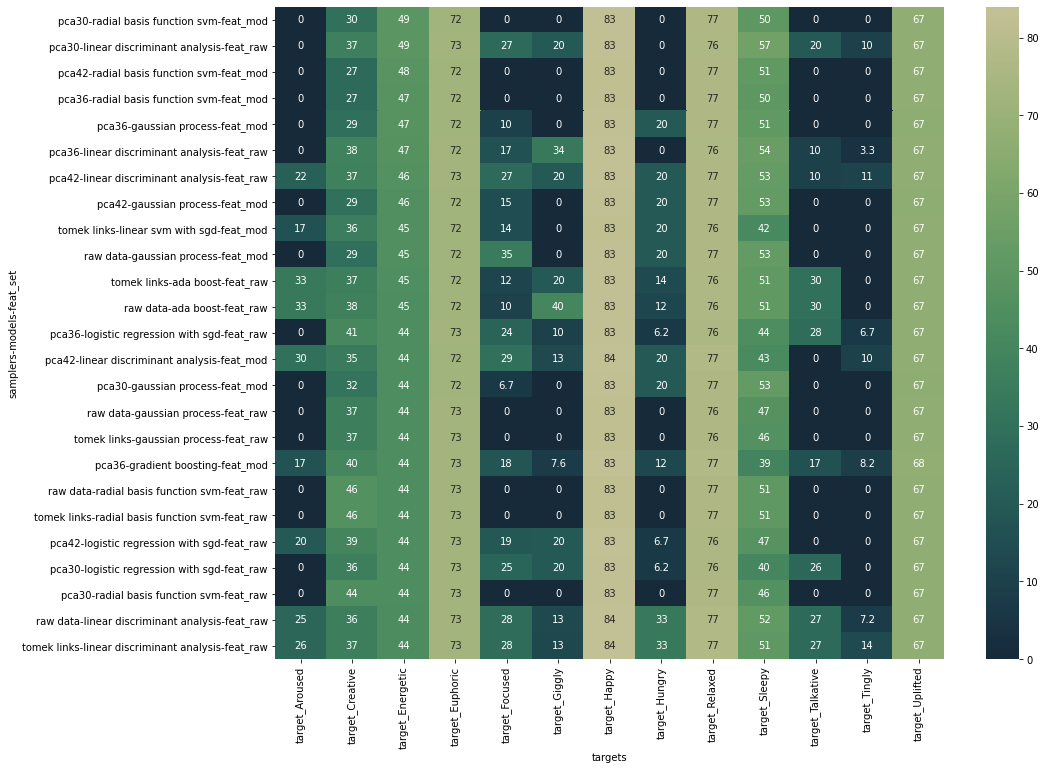

In [185]:
heat_map = pd.pivot_table(cv_results.query('measure == "precision"'), values='mean', index=['samplers', 'models', 'feat_set'],
                    columns='targets', aggfunc=np.sum)

plot, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(heat_map.sort_values(by='target_Energetic', ascending=False).head(25), annot=True, ax=ax, center=50, cmap=sns.cubehelix_palette(start=0, rot=-.70, reverse=True, as_cmap=True))

In [186]:
heat_map.max()

targets
target_Aroused      43.33
target_Creative     46.43
target_Energetic    49.24
target_Euphoric     81.56
target_Focused      50.88
target_Giggly       40.00
target_Happy        91.35
target_Hungry       40.00
target_Relaxed      83.02
target_Sleepy       66.33
target_Talkative    44.19
target_Tingly       27.12
target_Uplifted     78.45
dtype: float64

Wow! Just by surveying a wide array of model-sampler-feature set combinations, we were able to find a model for Happy with over 90% precision, and models for Euphoric and Relaxed with over 80% precision. Some of the other targets (looking at you, Tingly) have quite a ways to go before that would make for commercially useful models, but at least we have a start!

In [187]:
heat_map.max() - baseline

targets
target_Aroused      34.61
target_Creative     13.55
target_Energetic    20.47
target_Euphoric      9.07
target_Focused      24.39
target_Giggly       26.20
target_Happy         8.83
target_Hungry       19.03
target_Relaxed       6.94
target_Sleepy       34.18
target_Talkative    28.06
target_Tingly       12.25
target_Uplifted     11.67
dtype: float64

Across all targets, the model survey resulted in models showing maximum improvements in precision ranging from 6.94% to 34.61%! Sounds pretty good! However, these values are not standardized. Let's standardize.

<AxesSubplot:xlabel='targets', ylabel='samplers-models-feat_set'>

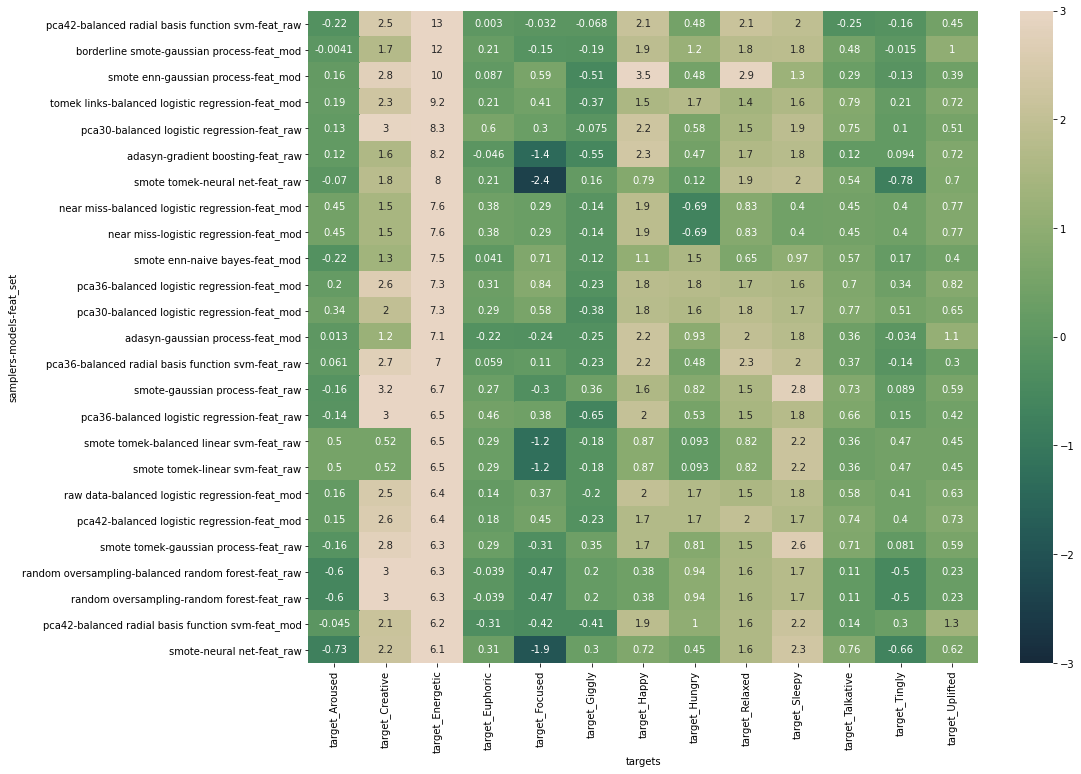

In [188]:
heat_map_standardize = (heat_map - baseline)/pd.pivot_table(cv_results.query('measure == "precision"'), 
                                                                            values='std', index=['samplers', 'models', 'feat_set'], 
                                                                            columns='targets', aggfunc=np.sum).replace(0,1)

plot, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(heat_map_standardize.sort_values(by='target_Energetic', ascending=False).head(25), annot=True, ax=ax, vmin=-3, center=0, vmax=3, cmap=sns.cubehelix_palette(start=0, rot=-.70, reverse=True, as_cmap=True))

Based on this view of the standardized average precision values, prediction of the target Energetic looks to have been very significantly improved in terms of precision. In fact...

In [189]:
heat_map_standardize.max()

targets
target_Aroused       1.991914
target_Creative      7.432836
target_Energetic    12.660000
target_Euphoric      2.944828
target_Focused       3.250000
target_Giggly        1.256410
target_Happy         5.631579
target_Hungry        2.130952
target_Relaxed       7.672131
target_Sleepy        4.768421
target_Talkative     4.689655
target_Tingly        1.397887
target_Uplifted      4.464730
dtype: float64

Our model survey was most successful (e.g. unearthed a model with the most significant improvements to precision over the baseline) for Energetic than any of the other targets. Let's take a closer look at the models for predicting Energetic, not only because of the exciting improvements discovered in the extended model survey, but also because models that can predict strains which make their users more energized with precision could be of real-world use, particularly for cannabis patients.

In [190]:
target_of_interest = 'target_Energetic'

top_hm_id = heat_map[target_of_interest].idxmax()
top_shm_id = heat_map_standardize[target_of_interest].idxmax()
baseline_id = ('raw data', 'null_always_one', 'feat_raw')

new_base = pd.DataFrame()
for comps in [baseline_id, top_hm_id, top_shm_id]:
    new_base = pd.concat([new_base, cv_results.query('samplers == @comps[0] and models == @comps[1] and feat_set == @comps[2] and targets == @target_of_interest')], axis=0)

heat_map_nb = pd.pivot_table(new_base, values=['mean', 'std'], index=['samplers', 'models', 'feat_set'],
                    columns='measure', aggfunc=np.sum)

heat_map_nb

mean         \
measure                                              balanced_accuracy f-Beta   
samplers models                             feat_set                            
pca30    radial basis function svm          feat_mod             51.11  14.63   
pca42    balanced radial basis function svm feat_raw             56.85  37.58   
raw data null_always_one                    feat_raw             50.00  33.53   

                                                                \
measure                                              precision   
samplers models                             feat_set             
pca30    radial basis function svm          feat_mod     49.24   
pca42    balanced radial basis function svm feat_raw     35.10   
raw data null_always_one                    feat_raw     28.77   

                                                                   std         \
measure                                              balanced_accuracy f-Beta   
samplers models                             feat_set                            
pca30    radial basis function svm          feat_mod              0.53   4.56   
pca42    balanced radial basis function svm feat_raw              2.75   0.67   
raw data null_always_one                    feat_raw              0.00   2.54   

                                                                
measure                                              precision  
samplers models                             feat_set            
pca30    radial basis function svm          feat_mod      8.05  
pca42    balanced radial basis function svm feat_raw      0.50  
raw data null_always_one                    feat_raw      2.33

Here we have our baseline measures for Energetic, alongside the models reporting max precision (49.24 +/- 8.05) and max standardized precision (unstandardized precision = 35.10 +/- 0.50). Our max precision model is considerably more precise than our max standardized precision model, although not likely statistically significantly so, due to the large standard deviation of the max precision model. 

In [191]:
cutoff_df = pd.DataFrame()
for s in range(1, 21):
    heat_map_cutoff = pd.pivot_table(cv_results.query('measure == "precision" and std < @s'), values='mean', index=['samplers', 'models', 'feat_set'],
                    columns='targets', aggfunc=np.sum)
    cutoff_df[s] = heat_map_cutoff.max()

cutoff_df = cutoff_df.T.reset_index()
cutoff_df['std < '] = cutoff_df['index']

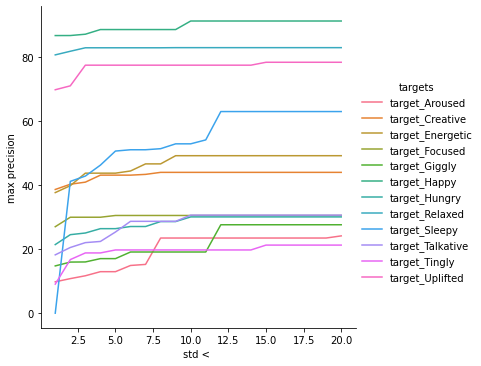

In [192]:
cutoff_df_melted = pd.melt(cutoff_df, id_vars=['std < '], value_vars=['target_Aroused', 'target_Creative', 'target_Energetic', 
                                                   'target_Focused', 'target_Giggly', 'target_Happy', 'target_Hungry', 
                                                   'target_Relaxed', 'target_Sleepy', 'target_Talkative', 'target_Tingly', 
                                                   'target_Uplifted'])
cutoff_df_melted['max precision'] = cutoff_df_melted['value']

sns.relplot(x="std < ", y="max precision", hue="targets", kind="line", data=cutoff_df_melted)

We can see in the plot above that, as one might expect, if we constrain our model search to only models with smaller and smaller standard deviations in precision, the maximum precision of that set of models decreases. Perhaps by in selecting a standard deviation cutoff, we can find some sort of useful balance between models with high precision and models that are consistent in their precision. If we look at the plot for Energetic below...

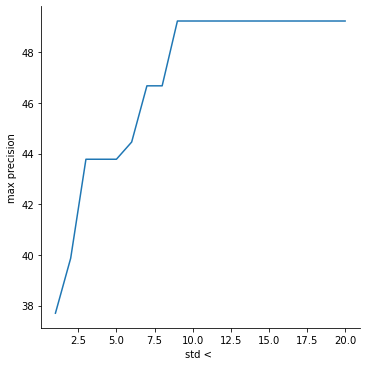

In [193]:
sns.relplot(x="std < ", y="max precision", kind="line", data=cutoff_df_melted.query('targets == "target_Energetic"'))

... we see a plateau in max precision between 3 and 5. Let's filter models for Energetic that have precision standard deviations of 3 or larger, and add the top model to our other top contenders.

In [197]:
target_of_interest = 'target_Energetic'

heat_map_filtered = pd.pivot_table(cv_results.query('measure == "precision" and std < 3'), values='mean', index=['samplers', 'models', 'feat_set'],
                    columns='targets', aggfunc=np.sum)

top_hm_id = heat_map[target_of_interest].idxmax()
top_fhm_id = heat_map_filtered[target_of_interest].idxmax()
top_shm_id = heat_map_standardize[target_of_interest].idxmax()
baseline_id = ('raw data', 'null_always_one', 'feat_raw')

new_base = pd.DataFrame()
for comps in [baseline_id, top_hm_id, top_fhm_id, top_shm_id]:
    new_base = pd.concat([new_base, cv_results.query('samplers == @comps[0] and models == @comps[1] and feat_set == @comps[2] and targets == @target_of_interest')], axis=0)

heat_map_nb = pd.pivot_table(new_base, values=['mean', 'std'], index=['samplers', 'models', 'feat_set'],
                    columns='measure', aggfunc=np.sum)

heat_map_nb

mean         \
measure                                              balanced_accuracy f-Beta   
samplers models                             feat_set                            
pca30    radial basis function svm          feat_mod             51.11  14.63   
pca42    balanced radial basis function svm feat_raw             56.85  37.58   
         logistic regression with sgd       feat_raw             52.44  24.58   
raw data null_always_one                    feat_raw             50.00  33.53   

                                                                \
measure                                              precision   
samplers models                             feat_set             
pca30    radial basis function svm          feat_mod     49.24   
pca42    balanced radial basis function svm feat_raw     35.10   
         logistic regression with sgd       feat_raw     43.78   
raw data null_always_one                    feat_raw     28.77   

                                                                   std         \
measure                                              balanced_accuracy f-Beta   
samplers models                             feat_set                            
pca30    radial basis function svm          feat_mod              0.53   4.56   
pca42    balanced radial basis function svm feat_raw              2.75   0.67   
         logistic regression with sgd       feat_raw              1.54   9.07   
raw data null_always_one                    feat_raw              0.00   2.54   

                                                                
measure                                              precision  
samplers models                             feat_set            
pca30    radial basis function svm          feat_mod      8.05  
pca42    balanced radial basis function svm feat_raw      0.50  
         logistic regression with sgd       feat_raw      2.62  
raw data null_always_one                    feat_raw      2.33

One way to test if any or all of our top models represent significant improvements in precision over the baseline null model, we will use the Wilcoxon signed-rank test, a non-parametric test for comparing sets of paired samples that do not meet the assumptions of a paired-sample t-test. Our data does not meet the assumptions of a paired-sample t-test, as the sample precision measures are not independent due to the resampling inherent to k-fold cross validation. (Technically, the lack of sample independence also means that the data fails to meet the assumptions of the Wilcoxon signed-rank test. However, because it is a non-parametric test, the hope is that it is more robust to unmet assumptions than its parametric counterpart.)

In [292]:
new_baseline = new_base.query('measure == "precision" and models == "null_always_one"').T[new_base.columns.str.contains('fold')].T.values[0]
for i in new_base.query('measure == "precision" and models != "null_always_one"').index:
    dif = new_base.loc[i][new_base.columns.str.contains('fold')].values - new_baseline
    print(new_base.loc[i][['models', 'samplers', 'feat_set']].values)
    print(dif)
    print(stats.wilcoxon(dif, alternative='greater'))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

['radial basis function svm' 'pca30' 'feat_mod']
[17.1912832929782 32.88135593220339 23.55125100887813 18.52300242130751
 10.217917675544793]
WilcoxonResult(statistic=15.0, pvalue=0.03125)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
['logistic regression with sgd' 'pca42' 'feat_raw']
[19.788685890380805 20.249776984834966 13.07506053268764 11.02300242130751
 10.958658416285534]
WilcoxonResult(statistic=15.0, pvalue=0.03125)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
['balanced radial basis function svm' 'pca42' 'feat_raw']
[9.140770270089497 7.801990852838308 5.3172554238891685 4.478058601082793
 4.9117952265652]
WilcoxonResult(statistic=15.0, pvalue=0.03125)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


According to the Wilcoxon signed-rank test, all three of our top models are statistically significantly more precise than the baseline null model. In fact, any model for which all five folds had higher precision values than the corresponding folds' precision values for the null model would be considered statistically significantly more precise. This provides us with a useful approach for assessing model performance - we can rank precision scores for each fold! For example, with our top performing models plus the null model:

In [301]:
ranks = new_base.query('measure == "precision"').T.loc[new_base.columns.str.contains('fold')].T.rank(ascending=False)
df_for_rank = new_base.query('measure == "precision"')
df_for_rank[['rank_fold_1', 'rank_fold_2', 'rank_fold_3', 'rank_fold_4', 'rank_fold_5']] = ranks
df_for_rank.drop(['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5', 'measure', 'targets'], axis=1)

/home/cleber/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


models  samplers   mean   std        se  \
2275                     null_always_one  raw data  28.77  2.33  1.042008   
2578           radial basis function svm     pca30  49.24  8.05  3.600069   
2404        logistic regression with sgd     pca42  43.78  2.62  1.171700   
2419  balanced radial basis function svm     pca42  35.10  0.50  0.223607   

      feat_set  rank_fold_1  rank_fold_2  rank_fold_3  rank_fold_4  \
2275  feat_raw          4.0          4.0          4.0          4.0   
2578  feat_mod          2.0          1.0          1.0          1.0   
2404  feat_raw          1.0          2.0          2.0          2.0   
2419  feat_raw          3.0          3.0          3.0          3.0   

      rank_fold_5  
2275          4.0  
2578          2.0  
2404          1.0  
2419          3.0

Based on how the models rank for each fold, our top precision model (radial basis function svm) and our top precision model with a standard deviation of less than 3 (logistic regression with sgd) were not found to be statistically significantly different from each other, but both were statistically significantly more precise than our top standardized precision model.

#### Hyperparameter Tuning

Based on our top models above, as well as observable clusters of elevated standardized precision in the heatmap below (namely balanced logistic regression and balanced radial basis function support vector classification with PCA-embedded features as well as gaussian process models on feature sets that have been 'balanced' via oversampling), there are three families of models we will further pursue for predicting the Energetic target: support vector machines, logistic regression, and gaussian processes. We will also experiment with further optimizing logistic regression via stochastic gradient descent.

As we saw above, while our highest precision model had a standard deviation of greater than 3, it was not statisically significantly better than the highest precision model with a standard deviation of less than 3. Therefore, we shall use models with standard deviations of less than 3 to guide our optimization of hyperparameters, as it is important that our ultimate model be consistent and generalizable (as indicated via a small standard deviation in its precision).


<AxesSubplot:xlabel='samplers-feat_set', ylabel='models'>

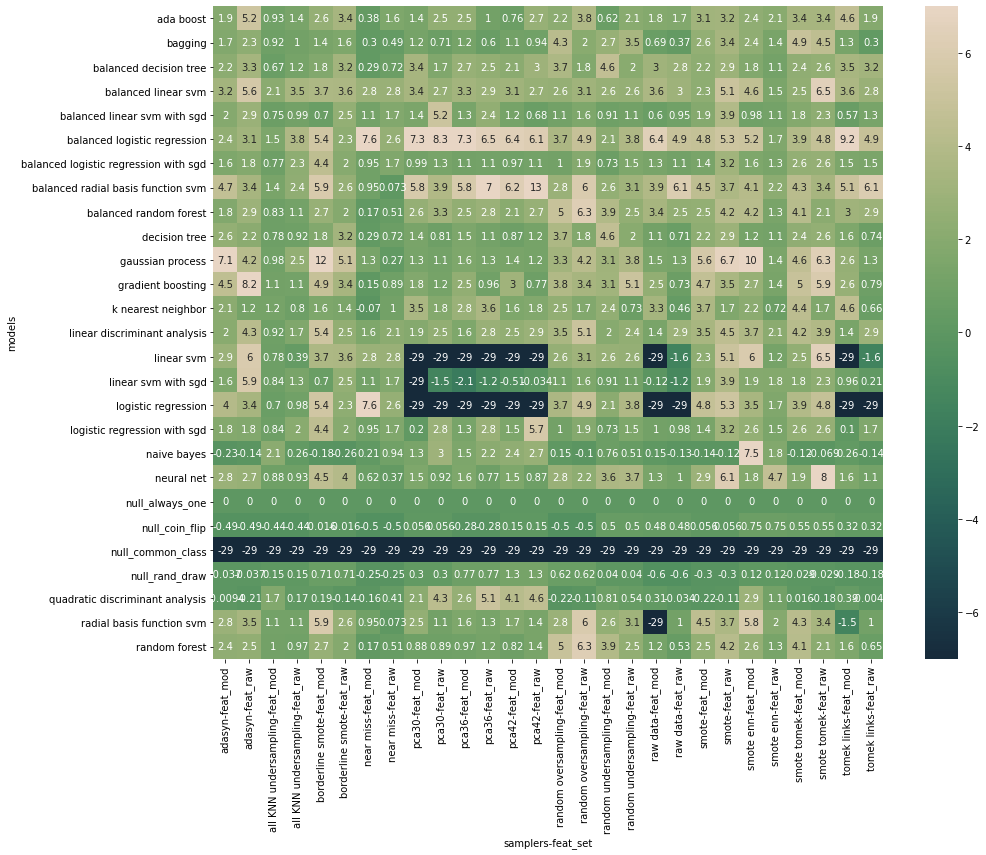

In [108]:
toi = 'target_Energetic'
hm_target_mean = pd.pivot_table(cv_results.query('targets == @toi and measure == "precision"'), 
               values='mean', index=['samplers', 'feat_set'], 
               columns='models', aggfunc=np.sum).T

hm_target_bl = hm_target_mean.loc['null_always_one']

hm_target_std = pd.pivot_table(cv_results.query('targets == @toi and measure == "precision"'), 
               values='std', index=['samplers', 'feat_set'], 
               columns='models', aggfunc=np.sum).T.replace(0,1)

hm_target_standardize = (hm_target_mean - hm_target_bl)/hm_target_std

plot, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(hm_target_standardize, annot=True, ax=ax, vmin=-7, center=0, vmax=7, cmap=sns.cubehelix_palette(start=0, rot=-.70, reverse=True, as_cmap=True))

In order to tune hyperparameters, we need to be able to supply varied sets of hyperparameters, so we need to upgrade our estimator function, as follows:

In [303]:
def estimator_hp(estimator, feats_train, targets_train, feats_test, targets_test, hyperparameters):
    
    if estimator == 'ada boost':
        est = AdaBoostClassifier(**hyperparameters)
    
    elif estimator == 'bagging':
        est = BaggingClassifier(**hyperparameters)
    
    elif estimator == 'decision tree':
        est = DecisionTreeClassifier(**hyperparameters)
    
    elif estimator == 'gaussian process':
        est = GaussianProcessClassifier(**hyperparameters)
    
    elif estimator == 'gradient boosting':
        est = GradientBoostingClassifier(**hyperparameters)
    
    elif estimator == 'k nearest neighbor':
        est = KNeighborsClassifier(**hyperparameters)
        
    elif estimator == 'linear discriminant analysis':
        est = LinearDiscriminantAnalysis(**hyperparameters)
        
    elif estimator == 'svm':
        est = SVC(**hyperparameters)
        
    elif estimator == 'estimator with sgd':
        est = SGDClassifier(**hyperparameters)
        
    elif estimator == 'logistic regression':
        est = LogisticRegressionCV(**hyperparameters)

    elif estimator == 'naive bayes':
        est = GaussianNB(**hyperparameters)
        
    elif estimator == 'neural net':
        est = MLPClassifier(**hyperparameters)
        
    elif estimator == 'random forest':
        est = RandomForestClassifier(**hyperparameters)
        
    elif estimator == 'quadratic discriminant analysis':
        est = QuadraticDiscriminantAnalysis(**hyperparameters)
     
    else:
        est = 0
        print('unsupported estimator, please try again')
    
    est.fit(feats_train, targets_train)
    targets_test_pred = est.predict(feats_test)
    accuracy = 100 * metrics.balanced_accuracy_score(targets_test, targets_test_pred)
    precision = 100 * metrics.precision_score(targets_test, targets_test_pred, zero_division=0)
    fB = 100 * metrics.fbeta_score(targets_test, targets_test_pred, beta=0.5, zero_division=0)
    
    return accuracy, precision, fB

First up for hyperparameter tuning, support vector machines.

In [306]:
est = SVC()
list(est.get_params().keys())

['C',
 'break_ties',
 'cache_size',
 'class_weight',
 'coef0',
 'decision_function_shape',
 'degree',
 'gamma',
 'kernel',
 'max_iter',
 'probability',
 'random_state',
 'shrinking',
 'tol',
 'verbose']

The sklearn SVC implementation of support vector classifiers has 15 hyperparameters that can be adjusted, but there are only 7 that have potential for improving our models in this context. For our first iteration of experimentation, we will compare balanced and default class weights, as well as several different kernels.

In [307]:
C_vals = [1]
class_weight_vals = [None, 'balanced']
coef0_vals = [0, 1] #just for poly and sigmoid
degree_vals = [2, 3, 4, 5] #just for poly
gamma_vals = ['scale']
kernel_vals = ['linear', 'poly', 'rbf', 'sigmoid']
random_state_vals = [10]
tol_vals = [0.001]

hps = ['C', 'class_weight', 'coef0', 'degree', 'gamma', 'kernel', 'random_state', 'tol']
hyperparameters_vals = [C_vals, class_weight_vals, coef0_vals, degree_vals, gamma_vals, kernel_vals, random_state_vals, tol_vals]

In [309]:
features = features_0.copy(deep=True)

A bit more house keeping - to make hyperparameter tuning experiments across a broad base of varied feature set and sampler combinations easier, let's write a function for switching between our original feature set and the imputed feature set. Then we will formalize our mature series of model survey loops into a function as well.

Lucky (unlucky) for us, our sample set is relatively small, allowing us to use a brute force grid-search type approach to screening a broad hyperparameter space, without running into much trouble in terms of computational time requried - yes, things take enough time that we would rather not run them twice, but we are talking on the scale of hours rather than days+. In the case of a larger dataset taking longer amounts of time to run experiments on, a random search or otherwise more optimized approach would be preferred.

In [312]:
def change_feat_set(feat_set_to_change_to):
    if feat_set_to_change_to == 'features_0':
        features = features_0.copy(deep=True)
    elif feat_set_to_change_to == 'Pr_impute_1_1':
        features = features_mod.copy(deep=True)
    else:
        print('unsupported feat set!')
        features = change_feat_set('features_0')
    
    return features

In [403]:
def cv_model_survey(number_of_folds, feat_sets_to_try, target_columns, samplers_to_try, null_to_try, estimators_to_try, 
                   hps, hyperparameters_vals):
    
    total = ((len(list(itertools.product(*hyperparameters_vals))) * len(estimators_to_try)) + len(null_to_try)) * len(feat_sets_to_try) * len(target_columns) * len(samplers_to_try)
    print('Trying ' + str(number_of_folds) + ' folds of ' + str(total) + ' different models')
    seed(10)
    kf = KFold(n_splits=number_of_folds)
    cv_results = pd.DataFrame()

    for fs in feat_sets_to_try:
        print('********************')
        print(fs)
        print('********************')
        features = change_feat_set(fs)
        feats_train, feats_final_test, targets_train, targets_final_test = train_test_split(features, targets, test_size=0.1, random_state=10)

        kf.get_n_splits(feats_train)

        fold_num = 0
        models = []
        target_of_model = []
        samplers = []

        cv_results_tmp = pd.DataFrame()

        for cvtrain_index, cvtest_index in kf.split(feats_train):
            fold_scores = []
            fold_num +=1
            print("fold " + str(fold_num))
            print('**********')

            #Change to only build models for targets in target_columns list
            for target_column in target_columns:
                feats_cvtrain_0, feats_cvtest_0 = feats_train.iloc[cvtrain_index], feats_train.iloc[cvtest_index]
                targets_cvtrain_0, targets_cvtest_0 = targets_train.iloc[cvtrain_index][target_column], targets_train.iloc[cvtest_index][target_column]

                for s in samplers_to_try:
                    feats_cvtrain = feats_cvtrain_0.copy(deep=True)
                    feats_cvtest = feats_cvtest_0.copy(deep=True)
                    targets_cvtrain = targets_cvtrain_0.copy(deep=True)
                    targets_cvtest = targets_cvtest_0.copy(deep=True)

                    feats_cvtrain, feats_cvtest, targets_cvtrain, targets_cvtest = sampler_regime(s, feats_cvtrain, feats_cvtest, targets_cvtrain, targets_cvtest)


                    for null in null_to_try:
                        if fold_num == 1:
                            models.append(null)
                            samplers.append(s)
                            target_of_model.append(target_column)
                        fold_scores.extend(list(null_model(null, target_column, targets_cvtest)))

                    #Change to generate model for each set of hyperparameters
                    for estimator in estimators_to_try:
                        hp_search_mod_num = 0
                        for model_val_set in list(itertools.product(*hyperparameters_vals)):
                            hp_search_mod_num +=1
                            hyperparams = dict(zip(hps, model_val_set))
                            if fold_num == 1:
                                models.append(hyperparams)
                                samplers.append(s)
                                target_of_model.append(target_column)
                            fold_scores.extend(list(estimator_hp(estimator, feats_cvtrain, targets_cvtrain, feats_cvtest, targets_cvtest, hyperparams)))


            cv_results_tmp['fold_' + str(fold_num)] = fold_scores


        cv_results_tmp['models'] = [m for mods in models for m in 3*[mods]]
        cv_results_tmp['measure'] = ['balanced_accuracy', 'precision', 'f-Beta'] * len(models)
        cv_results_tmp['targets'] = [t for targs in target_of_model for t in 3*[targs]]
        cv_results_tmp['samplers'] = [s for samps in samplers for s in 3*[samps]]
        cv_results_tmp['feat set'] = fs
        cv_results_tmp['mean'] = list(round(cv_results_tmp.T[cv_results_tmp.columns.str.contains('fold')].mean(),2))
        cv_results_tmp['std'] = list(round(cv_results_tmp.T[cv_results_tmp.columns.str.contains('fold')].std(),2))
        cv_results_tmp['se'] = cv_results_tmp['std']/np.sqrt(fold_num)

        cv_results = pd.concat([cv_results, cv_results_tmp], axis=0)

    # Set features back to original set, and propagate through the test and final train splits
    features = features_0.copy(deep=True)
    feats_train, feats_final_test, targets_train, targets_final_test = train_test_split(features, targets, test_size=0.1, random_state=10)
    
    return cv_results

In [ ]:
number_of_folds = 5


feat_sets_to_try = ['features_0', 'Pr_impute_1_1']

target_columns = ['target_Energetic']

samplers_to_try = ['raw data', 'pca42', 'pca30', 'pca18', 'pca6']

null_to_try = ['null_always_one']

estimators_to_try = ['svm']

################################################################################################

cv_results = cv_model_survey()
cv_results

cv_results.to_csv('./hp_search_Energetic_svc0')

In [333]:
cv_results_svc0 = pd.read_csv('./hp_search_Energetic_svc0')
cv_results_svc0 = cv_results_svc0.drop(['Unnamed: 0'], axis=1)

cv_results_svc0_nn = cv_results_svc0[cv_results_svc0['models']!='null_always_one'].reset_index()
cv_results_svc0_nn = pd.concat([cv_results_svc0_nn, pd.DataFrame([ast.literal_eval(row) for row in cv_results_svc0_nn['models']])], axis=1)

In [334]:
cv_results_svc0_nn.query('measure == "precision"').sort_values(by='mean', ascending=False)[['mean','std', 'class_weight', 'kernel', 'samplers', 'feat set', 'coef0', 'degree']].head(20)

mean    std class_weight kernel samplers       feat set  coef0  degree
1792  68.67  30.15         None   poly     pca6  Pr_impute_1_1      1       3
1768  58.70  11.06         None   poly     pca6  Pr_impute_1_1      0       5
1756  58.34  29.80         None   poly     pca6  Pr_impute_1_1      0       4
1552  54.12  13.46         None   poly    pca18  Pr_impute_1_1      0       3
631   51.24  15.94         None    rbf    pca18     features_0      1       2
595   51.24  15.94         None    rbf    pca18     features_0      0       3
607   51.24  15.94         None    rbf    pca18     features_0      0       4
619   51.24  15.94         None    rbf    pca18     features_0      0       5
583   51.24  15.94         None    rbf    pca18     features_0      0       2
643   51.24  15.94         None    rbf    pca18     features_0      1       3
655   51.24  15.94         None    rbf    pca18     features_0      1       4
667   51.24  15.94         None    rbf    pca18     features_0      1       5
1411  49.24   8.05         None    rbf    pca30  Pr_impute_1_1      1       3
1435  49.24   8.05         None    rbf    pca30  Pr_impute_1_1      1       5
1363  49.24   8.05         None    rbf    pca30  Pr_impute_1_1      0       3
1399  49.24   8.05         None    rbf    pca30  Pr_impute_1_1      1       2
1423  49.24   8.05         None    rbf    pca30  Pr_impute_1_1      1       4
1387  49.24   8.05         None    rbf    pca30  Pr_impute_1_1      0       5
1351  49.24   8.05         None    rbf    pca30  Pr_impute_1_1      0       2
1375  49.24   8.05         None    rbf    pca30  Pr_impute_1_1      0       4

Thoe are some large standard deviations. Filtering to standard devations of less than 3.

In [323]:
cv_results_svc0_nn.query('measure == "precision" and std < 3').sort_values(by='mean', ascending=False)[['mean','std', 'class_weight', 'kernel', 'samplers', 'feat set', 'coef0']].head(20)

mean   std class_weight   kernel  samplers       feat set  coef0
1114  40.73  1.54     balanced  sigmoid  raw data  Pr_impute_1_1      1
1126  40.73  1.54     balanced  sigmoid  raw data  Pr_impute_1_1      1
1138  40.73  1.54     balanced  sigmoid  raw data  Pr_impute_1_1      1
1150  40.73  1.54     balanced  sigmoid  raw data  Pr_impute_1_1      1
913   39.60  1.60     balanced   linear      pca6     features_0      1
865   39.60  1.60     balanced   linear      pca6     features_0      0
949   39.60  1.60     balanced   linear      pca6     features_0      1
901   39.60  1.60     balanced   linear      pca6     features_0      0
889   39.60  1.60     balanced   linear      pca6     features_0      0
877   39.60  1.60     balanced   linear      pca6     features_0      0
925   39.60  1.60     balanced   linear      pca6     features_0      1
937   39.60  1.60     balanced   linear      pca6     features_0      1
1909  39.48  2.30     balanced   linear      pca6  Pr_impute_1_1      1
1873  39.48  2.30     balanced   linear      pca6  Pr_impute_1_1      1
1825  39.48  2.30     balanced   linear      pca6  Pr_impute_1_1      0
1837  39.48  2.30     balanced   linear      pca6  Pr_impute_1_1      0
1861  39.48  2.30     balanced   linear      pca6  Pr_impute_1_1      0
1897  39.48  2.30     balanced   linear      pca6  Pr_impute_1_1      1
1849  39.48  2.30     balanced   linear      pca6  Pr_impute_1_1      0
1885  39.48  2.30     balanced   linear      pca6  Pr_impute_1_1      1

Having balanced class weights appears to be important, particularly in terms of keeping the standard deviations low, so we shall stick to balanced SVCs. For the next iteration, we will test an array of PCA embeddings, ranging from 4 to 8 components. SVCs with polynomial kernels will nolonger be considered, as we are not seeing those models in our top selection. SVCs with radial basis functions also do not appear to be performing well. However, we will keep them in consideration, due to their apparent success in the extended model survey that was previously conducted. We will try out an expanded range of values for the regularization parameter C.

In [ ]:
number_of_folds = 5


feat_sets_to_try = ['features_0', 'Pr_impute_1_1']

target_columns = ['target_Energetic']

samplers_to_try = ['raw data', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8']

null_to_try = ['null_always_one']

estimators_to_try = ['svm']

# list out hyperparam values to try
C_vals = [0.01, 1, 100]
class_weight_vals = ['balanced']
coef0_vals = [1] #just for poly and sigmoid
degree_vals = [3] #just for poly
gamma_vals = ['scale', 'auto']
kernel_vals = ['linear', 'sigmoid', 'rbf']
random_state_vals = [10]
tol_vals = [0.001]

hps = ['C', 'class_weight', 'coef0', 'degree', 'gamma', 'kernel', 'random_state', 'tol']
hyperparameters_vals = [C_vals, class_weight_vals, coef0_vals, degree_vals, gamma_vals, kernel_vals, random_state_vals, tol_vals]


################################################################################################

cv_results = cv_model_survey(number_of_folds, feat_sets_to_try, target_columns, samplers_to_try, null_to_try, estimators_to_try, hps, hyperparameters_vals)
cv_results

cv_results.to_csv('./hp_search_Energetic_svc1')


In [326]:
cv_results_svc1 = pd.read_csv('./hp_search_Energetic_svc1')
cv_results_svc1 = cv_results_svc1.drop(['Unnamed: 0'], axis=1)

cv_results_svc1_nn = cv_results_svc1[cv_results_svc1['models']!='null_always_one'].reset_index()
cv_results_svc1_nn = pd.concat([cv_results_svc1_nn, pd.DataFrame([ast.literal_eval(row) for row in cv_results_svc1_nn['models']])], axis=1)

In [328]:
cv_results_svc1_nn.query('measure == "precision" and std < 3').sort_values(by='mean', ascending=False)[['mean','std', 'class_weight', 'kernel', 'samplers', 'feat set', 'C', 'gamma']].head(20)

mean   std class_weight   kernel  samplers       feat set       C  gamma
379  41.08  1.28     balanced   linear      pca4  Pr_impute_1_1    0.01  scale
388  41.08  1.28     balanced   linear      pca4  Pr_impute_1_1    0.01   auto
490  40.92  2.62     balanced  sigmoid      pca6  Pr_impute_1_1    0.01  scale
433  40.76  1.61     balanced   linear      pca5  Pr_impute_1_1    0.01  scale
442  40.76  1.61     balanced   linear      pca5  Pr_impute_1_1    0.01   auto
346  40.73  1.54     balanced  sigmoid  raw data  Pr_impute_1_1    1.00  scale
496  40.65  1.22     balanced   linear      pca6  Pr_impute_1_1    0.01   auto
487  40.65  1.22     balanced   linear      pca6  Pr_impute_1_1    0.01  scale
541  40.55  1.60     balanced   linear      pca7  Pr_impute_1_1    0.01  scale
550  40.55  1.60     balanced   linear      pca7  Pr_impute_1_1    0.01   auto
127  40.50  2.41     balanced   linear      pca5     features_0    1.00  scale
154  40.50  2.41     balanced   linear      pca5     features_0  100.00   auto
136  40.50  2.41     balanced   linear      pca5     features_0    1.00   auto
145  40.50  2.41     balanced   linear      pca5     features_0  100.00  scale
595  40.27  1.32     balanced   linear      pca8  Pr_impute_1_1    0.01  scale
604  40.27  1.32     balanced   linear      pca8  Pr_impute_1_1    0.01   auto
355  40.18  1.38     balanced  sigmoid  raw data  Pr_impute_1_1    1.00   auto
385  40.01  2.47     balanced      rbf      pca4  Pr_impute_1_1    0.01  scale
460  39.98  1.78     balanced   linear      pca5  Pr_impute_1_1    1.00   auto
451  39.98  1.78     balanced   linear      pca5  Pr_impute_1_1    1.00  scale

The gamma hyperparameter looks to be of little consequence in this context, so we shall leave it to its default. We will also further focus our search on models with linear kernels, as they are consistently in the top performers. We will expand our range of possibilities for PCA component number and C value, and will search across several tolerance values.

In [ ]:
number_of_folds = 5


feat_sets_to_try = ['features_0', 'Pr_impute_1_1']

target_columns = ['target_Energetic']

samplers_to_try = ['raw data', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9', 'pca10']

null_to_try = ['null_always_one']

estimators_to_try = ['svm']

# list out hyperparam values to try
C_vals = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
class_weight_vals = ['balanced']
coef0_vals = [1] #just for poly and sigmoid
degree_vals = [3] #just for poly
gamma_vals = ['scale']
kernel_vals = ['linear']
random_state_vals = [10]
tol_vals = [0.0001, 0.001, 0.01]

hps = ['C', 'class_weight', 'coef0', 'degree', 'gamma', 'kernel', 'random_state', 'tol']
hyperparameters_vals = [C_vals, class_weight_vals, coef0_vals, degree_vals, gamma_vals, kernel_vals, random_state_vals, tol_vals]


################################################################################################

cv_results = cv_model_survey(number_of_folds, feat_sets_to_try, target_columns, samplers_to_try, null_to_try, estimators_to_try, hps, hyperparameters_vals)

cv_results.to_csv('./hp_search_Energetic_svc2')

In [329]:
cv_results_svc2 = pd.read_csv('./hp_search_Energetic_svc2')
cv_results_svc2 = cv_results_svc2.drop(['Unnamed: 0'], axis=1)

cv_results_svc2_nn = cv_results_svc2[cv_results_svc2['models']!='null_always_one'].reset_index()
cv_results_svc2_nn = pd.concat([cv_results_svc2_nn, pd.DataFrame([ast.literal_eval(row) for row in cv_results_svc2_nn['models']])], axis=1)

In [332]:
cv_results_svc2_nn.query('measure == "precision" and std < 3').sort_values(by='mean', ascending=False)[['mean','std', 'samplers', 'feat set', 'C', 'tol']].head(20)

mean   std samplers       feat set        C     tol
931   41.11  0.99     pca3  Pr_impute_1_1     0.01  0.0010
928   41.11  0.99     pca3  Pr_impute_1_1     0.01  0.0001
934   41.11  0.99     pca3  Pr_impute_1_1     0.01  0.0100
1024  40.98  1.35     pca4  Pr_impute_1_1     0.01  0.0100
1021  40.96  1.36     pca4  Pr_impute_1_1     0.01  0.0010
1018  40.90  1.39     pca4  Pr_impute_1_1     0.01  0.0001
1114  40.78  1.62     pca5  Pr_impute_1_1     0.01  0.0100
1111  40.76  1.61     pca5  Pr_impute_1_1     0.01  0.0010
1108  40.76  1.61     pca5  Pr_impute_1_1     0.01  0.0001
1198  40.71  1.33     pca6  Pr_impute_1_1     0.01  0.0001
1204  40.71  1.33     pca6  Pr_impute_1_1     0.01  0.0100
1201  40.71  1.33     pca6  Pr_impute_1_1     0.01  0.0010
331   40.60  2.58     pca5     features_0    10.00  0.0100
1294  40.55  1.60     pca7  Pr_impute_1_1     0.01  0.0100
349   40.50  2.41     pca5     features_0  1000.00  0.0100
340   40.50  2.41     pca5     features_0   100.00  0.0100
343   40.50  2.41     pca5     features_0  1000.00  0.0001
346   40.50  2.41     pca5     features_0  1000.00  0.0010
337   40.50  2.41     pca5     features_0   100.00  0.0010
334   40.50  2.41     pca5     features_0   100.00  0.0001

One final iteration, to see if finer adjustments to C make any useful difference.

In [ ]:
number_of_folds = 5


feat_sets_to_try = ['features_0', 'Pr_impute_1_1']

target_columns = ['target_Energetic']

samplers_to_try = ['raw data', 'pca2', 'pca3', 'pca4', 'pca5']

null_to_try = ['null_always_one']

estimators_to_try = ['svm']

# list out hyperparam values to try
C_vals = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]
class_weight_vals = ['balanced']
coef0_vals = [1] #just for poly and sigmoid
degree_vals = [3] #just for poly
gamma_vals = ['scale']
kernel_vals = ['linear']
random_state_vals = [10]
tol_vals = [0.001]

hps = ['C', 'class_weight', 'coef0', 'degree', 'gamma', 'kernel', 'random_state', 'tol']
hyperparameters_vals = [C_vals, class_weight_vals, coef0_vals, degree_vals, gamma_vals, kernel_vals, random_state_vals, tol_vals]


################################################################################################

cv_results = cv_model_survey(number_of_folds, feat_sets_to_try, target_columns, samplers_to_try, null_to_try, estimators_to_try, hps, hyperparameters_vals)

cv_results.to_csv('./hp_search_Energetic_svc3')

In [335]:
cv_results_svc3 = pd.read_csv('./hp_search_Energetic_svc3')
cv_results_svc3 = cv_results_svc3.drop(['Unnamed: 0'], axis=1)

cv_results_svc3_nn = cv_results_svc3[cv_results_svc3['models']!='null_always_one'].reset_index()
cv_results_svc3_nn = pd.concat([cv_results_svc3_nn, pd.DataFrame([ast.literal_eval(row) for row in cv_results_svc3_nn['models']])], axis=1)

In [337]:
cv_results_svc3_nn.query('measure == "precision" and std < 3').sort_values(by='mean', ascending=False)[['mean','std', 'samplers', 'feat set', 'C']].head(20)

mean   std  samplers       feat set      C
136  41.44  1.07      pca2  Pr_impute_1_1  0.010
175  41.12  1.53      pca4  Pr_impute_1_1  0.005
157  41.11  0.99      pca3  Pr_impute_1_1  0.010
178  40.96  1.36      pca4  Pr_impute_1_1  0.010
196  40.85  1.48      pca5  Pr_impute_1_1  0.005
199  40.76  1.61      pca5  Pr_impute_1_1  0.010
154  40.69  1.53      pca3  Pr_impute_1_1  0.005
202  40.57  1.76      pca5  Pr_impute_1_1  0.020
112  40.57  0.84  raw data  Pr_impute_1_1  0.005
139  40.55  1.71      pca2  Pr_impute_1_1  0.020
160  40.35  1.72      pca3  Pr_impute_1_1  0.020
133  40.34  1.57      pca2  Pr_impute_1_1  0.005
181  40.26  1.89      pca4  Pr_impute_1_1  0.020
100  40.21  1.97      pca5     features_0  0.050
142  40.20  1.54      pca2  Pr_impute_1_1  0.050
103  40.18  1.93      pca5     features_0  0.100
166  40.17  1.64      pca3  Pr_impute_1_1  0.100
205  40.15  1.46      pca5  Pr_impute_1_1  0.050
163  40.04  1.74      pca3  Pr_impute_1_1  0.050
145  40.02  1.44      pca2  Pr_impute_1_1  0.100

Now for logistic regression

The implementation of logistic regression we are using includes built-in optimization of the regularization parameter C, so we are going to leave that default so that it can work its magic. We will start with an elasticnet penalty in place and an array of various l1 ratios to try. Our range will run from 0 to 1, so that we are testing l1 and l2 penalties as a part of the mix. Simultaneously, alongside the original features we will try PCA embeddings with various numbers of components.


In [370]:
number_of_folds = 5


feat_sets_to_try = ['features_0', 'Pr_impute_1_1']

target_columns = ['target_Energetic']

samplers_to_try = ['raw data', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca16', 'pca24', 'pca32', 'pca40']

null_to_try = ['null_always_one']

estimators_to_try = ['logistic regression']

# list out hyperparam values to try
class_weight_vals = ['balanced']
cv_vals = [5]
fit_intercept_vals = [True, False]
intercept_scaling_vals = [1] #liblinear only
l1_ratios_vals = [[0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]] #elastic net only
max_iter_vals = [1000]
n_jobs_vals = [-1] 
penalty_vals = ['elasticnet']
random_state_vals = [10] 
scoring_vals = ['precision'] 
solver_vals = ['saga']
tol_vals = [0.0001]


hps = ['class_weight', 'cv', 'fit_intercept', 'intercept_scaling', 'l1_ratios', 'max_iter', 'n_jobs', 
       'penalty', 'random_state', 'scoring', 'solver', 'tol']
hyperparameters_vals = [class_weight_vals, cv_vals, fit_intercept_vals, intercept_scaling_vals, l1_ratios_vals, 
                        max_iter_vals, n_jobs_vals, penalty_vals, random_state_vals, scoring_vals, solver_vals, 
                        tol_vals]


################################################################################################

cv_results = cv_model_survey(number_of_folds, feat_sets_to_try, target_columns, samplers_to_try, null_to_try, estimators_to_try, hps, hyperparameters_vals)

cv_results.to_csv('./hp_search_Energetic_logc0')

In [343]:
cv_results_logc0 = pd.read_csv('./hp_search_Energetic_logc0')
cv_results_logc0 = cv_results_logc0.drop(['Unnamed: 0'], axis=1)

cv_results_logc0_nn = cv_results_logc0[cv_results_logc0['models']!='null_always_one'].reset_index()
cv_results_logc0_nn = pd.concat([cv_results_logc0_nn, pd.DataFrame([ast.literal_eval(row) for row in cv_results_logc0_nn['models']])], axis=1)

In [350]:
cv_results_logc0_nn.query('measure == "precision" and std < 3').sort_values(by='mean', ascending=False)[['mean', 'std', 'samplers', 'feat set', 'fit_intercept']].head(20)

mean   std  samplers       feat set  fit_intercept
76   39.45  1.43  raw data  Pr_impute_1_1          False
4    39.45  2.45  raw data     features_0          False
121  39.28  1.77     pca16  Pr_impute_1_1           True
82   39.15  1.53      pca2  Pr_impute_1_1          False
88   39.10  1.55      pca3  Pr_impute_1_1          False
103  39.08  1.85      pca6  Pr_impute_1_1           True
127  39.05  1.88     pca24  Pr_impute_1_1           True
115  39.05  1.88      pca8  Pr_impute_1_1           True
85   39.03  1.44      pca3  Pr_impute_1_1           True
94   39.03  1.59      pca4  Pr_impute_1_1          False
100  39.03  1.59      pca5  Pr_impute_1_1          False
106  39.03  1.59      pca6  Pr_impute_1_1          False
142  39.03  1.59     pca40  Pr_impute_1_1          False
112  39.03  1.59      pca7  Pr_impute_1_1          False
118  39.03  1.59      pca8  Pr_impute_1_1          False
124  39.03  1.59     pca16  Pr_impute_1_1          False
130  39.03  1.59     pca24  Pr_impute_1_1          False
136  39.03  1.59     pca32  Pr_impute_1_1          False
79   38.99  1.46      pca2  Pr_impute_1_1           True
97   38.98  1.80      pca5  Pr_impute_1_1           True

Trying some different solvers with l2 penalty this iteration, to see if solver makes a difference.

In [371]:
number_of_folds = 5


feat_sets_to_try = ['features_0', 'Pr_impute_1_1']

target_columns = ['target_Energetic']

samplers_to_try = ['raw data', 'pca2', 'pca3', 'pca5', 'pca8']

null_to_try = ['null_always_one']

estimators_to_try = ['logistic regression']

# list out hyperparam values to try
class_weight_vals = ['balanced']
cv_vals = [5]
fit_intercept_vals = [True, False]
intercept_scaling_vals = [0.25, 1, 4] #liblinear only
l1_ratios_vals = [[0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]] #elastic net only
max_iter_vals = [1000]
n_jobs_vals = [-1] 
penalty_vals = ['l2']
random_state_vals = [10] 
scoring_vals = ['precision'] 
solver_vals = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
tol_vals = [0.0001]


hps = ['class_weight', 'cv', 'fit_intercept', 'intercept_scaling', 'l1_ratios', 'max_iter', 'n_jobs', 
       'penalty', 'random_state', 'scoring', 'solver', 'tol']
hyperparameters_vals = [class_weight_vals, cv_vals, fit_intercept_vals, intercept_scaling_vals, l1_ratios_vals, 
                        max_iter_vals, n_jobs_vals, penalty_vals, random_state_vals, scoring_vals, solver_vals, 
                        tol_vals]


################################################################################################

cv_results = cv_model_survey(number_of_folds, feat_sets_to_try, target_columns, samplers_to_try, null_to_try, estimators_to_try, hps, hyperparameters_vals)

cv_results.to_csv('./hp_search_Energetic_logc1')

In [352]:
cv_results_logc1 = pd.read_csv('./hp_search_Energetic_logc1')
cv_results_logc1 = cv_results_logc1.drop(['Unnamed: 0'], axis=1)

cv_results_logc1_nn = cv_results_logc1[cv_results_logc1['models']!='null_always_one'].reset_index()
cv_results_logc1_nn = pd.concat([cv_results_logc1_nn, pd.DataFrame([ast.literal_eval(row) for row in cv_results_logc1_nn['models']])], axis=1)

In [355]:
cv_results_logc1_nn.query('measure == "precision" and std < 3').sort_values(by='mean', ascending=False)[['mean', 'std', 'samplers', 'feat set', 'solver', 'intercept_scaling', 'fit_intercept']].head(20)

mean   std  samplers       feat set     solver  intercept_scaling  \
487  39.59  1.28  raw data  Pr_impute_1_1  liblinear               4.00   
457  39.47  1.47  raw data  Pr_impute_1_1  liblinear               0.24   
514  39.45  1.43  raw data  Pr_impute_1_1      lbfgs               1.00   
538  39.45  1.43  raw data  Pr_impute_1_1       saga               4.00   
535  39.45  1.43  raw data  Pr_impute_1_1        sag               4.00   
532  39.45  1.43  raw data  Pr_impute_1_1  liblinear               4.00   
526  39.45  1.43  raw data  Pr_impute_1_1  newton-cg               4.00   
523  39.45  1.43  raw data  Pr_impute_1_1       saga               1.00   
520  39.45  1.43  raw data  Pr_impute_1_1        sag               1.00   
517  39.45  1.43  raw data  Pr_impute_1_1  liblinear               1.00   
529  39.45  1.43  raw data  Pr_impute_1_1      lbfgs               4.00   
511  39.45  1.43  raw data  Pr_impute_1_1  newton-cg               1.00   
508  39.45  1.43  raw data  Pr_impute_1_1       saga               0.24   
505  39.45  1.43  raw data  Pr_impute_1_1        sag               0.24   
502  39.45  1.43  raw data  Pr_impute_1_1  liblinear               0.24   
499  39.45  1.43  raw data  Pr_impute_1_1      lbfgs               0.24   
496  39.45  1.43  raw data  Pr_impute_1_1  newton-cg               0.24   
472  39.43  1.39  raw data  Pr_impute_1_1  liblinear               1.00   
637  39.22  1.44      pca3  Pr_impute_1_1  liblinear               0.24   
577  39.17  1.34      pca2  Pr_impute_1_1  liblinear               4.00   

     fit_intercept  
487           True  
457           True  
514          False  
538          False  
535          False  
532          False  
526          False  
523          False  
520          False  
517          False  
529          False  
511          False  
508          False  
505          False  
502          False  
499          False  
496          False  
472           True  
637           True  
577           True

When an l2 penalty is applied, the original features are yielding more precise models than PCA transformed features, but the differences are very small. Still not managing to break 40% precision.

In our final iteration of logistic regression experiments, we will select the liblinear solver and try a few more intercept scaling values, as well as PCA with larger numbers of components.

In [ ]:
number_of_folds = 5


feat_sets_to_try = ['features_0', 'Pr_impute_1_1']

target_columns = ['target_Energetic']

samplers_to_try = ['raw data', 'pca45', 'pca42', 'pca35']

null_to_try = ['null_always_one']

estimators_to_try = ['logistic regression']

# list out hyperparam values to try
class_weight_vals = ['balanced']
cv_vals = [5]
fit_intercept_vals = [True]
intercept_scaling_vals = [2.5, 4, 7] #liblinear only
l1_ratios_vals = [[0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]] #elastic net only
max_iter_vals = [1000]
n_jobs_vals = [-1] 
penalty_vals = ['l2']
random_state_vals = [10] 
scoring_vals = ['precision', 'accuracy'] 
solver_vals = ['liblinear']
tol_vals = [0.0001]


hps = ['class_weight', 'cv', 'fit_intercept', 'intercept_scaling', 'l1_ratios', 'max_iter', 'n_jobs', 
       'penalty', 'random_state', 'scoring', 'solver', 'tol']
hyperparameters_vals = [class_weight_vals, cv_vals, fit_intercept_vals, intercept_scaling_vals, l1_ratios_vals, 
                        max_iter_vals, n_jobs_vals, penalty_vals, random_state_vals, scoring_vals, solver_vals, 
                        tol_vals]


################################################################################################

cv_results = cv_model_survey(number_of_folds, feat_sets_to_try, target_columns, samplers_to_try, null_to_try, estimators_to_try, hps, hyperparameters_vals)

cv_results.to_csv('./hp_search_Energetic_logc2')

In [356]:
cv_results_logc2 = pd.read_csv('./hp_search_Energetic_logc2')
cv_results_logc2 = cv_results_logc2.drop(['Unnamed: 0'], axis=1)

cv_results_logc2_nn = cv_results_logc2[cv_results_logc2['models']!='null_always_one'].reset_index()
cv_results_logc2_nn = pd.concat([cv_results_logc2_nn, pd.DataFrame([ast.literal_eval(row) for row in cv_results_logc2_nn['models']])], axis=1)

In [359]:
cv_results_logc2_nn.query('measure == "precision" and std < 3').sort_values(by='mean', ascending=False)[['mean', 'std', 'samplers', 'feat set', 'intercept_scaling', 'fit_intercept']].head(20)

mean   std  samplers       feat set  intercept_scaling  fit_intercept
73   39.59  1.28  raw data  Pr_impute_1_1                2.5           True
76   39.59  1.28  raw data  Pr_impute_1_1                2.5           True
82   39.59  1.28  raw data  Pr_impute_1_1                4.0           True
85   39.59  1.28  raw data  Pr_impute_1_1                7.0           True
79   39.59  1.28  raw data  Pr_impute_1_1                4.0           True
88   39.31  1.48  raw data  Pr_impute_1_1                7.0           True
130  38.24  0.75     pca35  Pr_impute_1_1                2.5           True
127  38.20  0.79     pca35  Pr_impute_1_1                2.5           True
112  38.10  0.97     pca42  Pr_impute_1_1                2.5           True
94   38.10  0.77     pca45  Pr_impute_1_1                2.5           True
91   38.08  0.77     pca45  Pr_impute_1_1                2.5           True
118  38.06  1.00     pca42  Pr_impute_1_1                4.0           True
100  38.06  1.00     pca45  Pr_impute_1_1                4.0           True
124  38.01  0.98     pca42  Pr_impute_1_1                7.0           True
121  38.01  1.04     pca42  Pr_impute_1_1                7.0           True
133  38.01  1.04     pca35  Pr_impute_1_1                4.0           True
103  38.01  1.04     pca45  Pr_impute_1_1                7.0           True
97   38.01  1.04     pca45  Pr_impute_1_1                4.0           True
136  38.01  1.04     pca35  Pr_impute_1_1                4.0           True
139  38.01  1.04     pca35  Pr_impute_1_1                7.0           True

Our logistic regression models for Energetic report 39% precision over quite a large space of hyperparameter values, and are unfortunately resistant to improvement.

Gaussin Process time!

In our model survey, gaussian processes paired with oversampling techniques appeared to be most successful. For the first iteration, we shall compare how different oversampling techniques interact with differing numbers of optimizer restarts. We will also allow for warm start and non-warm start models - it is likely that this will only impact computational performance and not model performance in terms of precision, but since we are here, might as well be thorough (:

We will leave the kernel as the default radial basis function for now.

In [362]:
number_of_folds = 5


feat_sets_to_try = ['features_0', 'Pr_impute_1_1']

target_columns = ['target_Energetic']

samplers_to_try = ['raw data', 'random oversampling', 'adasyn', 'smote', 'borderline smote', 'smote enn']

null_to_try = ['null_always_one']

estimators_to_try = ['gaussian process']

# list out hyperparam values to try

kernel_vals = [None] # perhaps try a non-stationary, e.g. dot product? (default is RBF[stationary])
max_iter_predict_vals = [1000, 5000] 
n_jobs_vals = [-1] 
n_restarts_optimizer_vals = [0, 1, 3, 5] 
random_state_vals = [10] 
warm_start_vals = [True, False]

hps = ['kernel', 'max_iter_predict', 'n_jobs', 'n_restarts_optimizer', 'random_state', 'warm_start']
hyperparameters_vals = [kernel_vals, max_iter_predict_vals, n_jobs_vals, n_restarts_optimizer_vals, random_state_vals, 
                        warm_start_vals]


################################################################################################

cv_results = cv_model_survey(number_of_folds, feat_sets_to_try, target_columns, samplers_to_try, null_to_try, estimators_to_try, hps, hyperparameters_vals)

cv_results.to_csv('./hp_search_Energetic_gp0')

In [363]:
cv_results_gp0 = pd.read_csv('./hp_search_Energetic_gp0')
cv_results_gp0 = cv_results_gp0.drop(['Unnamed: 0'], axis=1)

cv_results_gp0_nn = cv_results_gp0[cv_results_gp0['models']!='null_always_one'].reset_index()
cv_results_gp0_nn = pd.concat([cv_results_gp0_nn, pd.DataFrame([ast.literal_eval(row) for row in cv_results_gp0_nn['models']])], axis=1)

In [368]:
cv_results_gp0_nn.query('measure == "precision" and std < 3').sort_values(by='mean', ascending=False)[['mean', 'std', 'samplers', 'feat set', 'n_restarts_optimizer', 'max_iter_predict', 'warm_start']].head(20)

mean   std             samplers       feat set  n_restarts_optimizer  \
337  38.03  2.83  random oversampling  Pr_impute_1_1                     0   
340  38.03  2.83  random oversampling  Pr_impute_1_1                     0   
346  38.03  2.83  random oversampling  Pr_impute_1_1                     1   
349  38.03  2.83  random oversampling  Pr_impute_1_1                     3   
352  38.03  2.83  random oversampling  Pr_impute_1_1                     3   
355  38.03  2.83  random oversampling  Pr_impute_1_1                     5   
358  38.03  2.83  random oversampling  Pr_impute_1_1                     5   
361  38.03  2.83  random oversampling  Pr_impute_1_1                     0   
364  38.03  2.83  random oversampling  Pr_impute_1_1                     0   
367  38.03  2.83  random oversampling  Pr_impute_1_1                     1   
370  38.03  2.83  random oversampling  Pr_impute_1_1                     1   
373  38.03  2.83  random oversampling  Pr_impute_1_1                     3   
376  38.03  2.83  random oversampling  Pr_impute_1_1                     3   
379  38.03  2.83  random oversampling  Pr_impute_1_1                     5   
382  38.03  2.83  random oversampling  Pr_impute_1_1                     5   
343  38.03  2.83  random oversampling  Pr_impute_1_1                     1   
529  37.70  0.87            smote enn  Pr_impute_1_1                     0   
535  37.70  0.87            smote enn  Pr_impute_1_1                     1   
538  37.70  0.87            smote enn  Pr_impute_1_1                     1   
541  37.70  0.87            smote enn  Pr_impute_1_1                     3   

     max_iter_predict  warm_start  
337              1000        True  
340              1000       False  
346              1000       False  
349              1000        True  
352              1000       False  
355              1000        True  
358              1000       False  
361              5000        True  
364              5000       False  
367              5000        True  
370              5000       False  
373              5000        True  
376              5000       False  
379              5000        True  
382              5000       False  
343              1000        True  
529              1000        True  
535              1000        True  
538              1000       False  
541              1000        True

We will try two stationary kernels, radial basis and rational quadratic, and one non-stationary, the dot product, all with relatively uninformative priors. The dot product kernel will be scaled with a constant kernel, as is needed for convergence to occur in this context. The array of kernels available from sklearn is limited, so perhaps I will need to try gaussian processes again at a later time via Pyro implementations.

Something worth noting is that as I was trying to determine what kernel may be best suited for my one-hot encoded feature set, I found there to be strikingly little written about learning with gaussian processes from binary training data. My sense would be that a binary-related kernel (e.g. binomial/beta/Bernoulli) would best serve in this context, but I could little in the literature to support this position. So again, perhaps I will need to return to gaussian processes for Energetic at a later date, and undertake some additional experimentation via Pyro and its much larger kernel selection.


In [372]:
kernels = [1.0 * RBF(), 1.0 * RationalQuadratic(alpha=0.1), ConstantKernel(0.1, (0.01, 10.0)) * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2)]

In [ ]:
number_of_folds = 5


feat_sets_to_try = ['features_0', 'Pr_impute_1_1']

target_columns = ['target_Energetic']

samplers_to_try = ['random oversampling', 'smote enn']

null_to_try = ['null_always_one']

estimators_to_try = ['gaussian process']

# list out hyperparam values to try

kernel_vals = kernels # perhaps try a non-stationary, e.g. dot product? (default is RBF[stationary])
max_iter_predict_vals = [1000] 
n_jobs_vals = [-1] 
n_restarts_optimizer_vals = [0] 
random_state_vals = [10] 
warm_start_vals = [True]

hps = ['kernel', 'max_iter_predict', 'n_jobs', 'n_restarts_optimizer', 'random_state', 'warm_start']
hyperparameters_vals = [kernel_vals, max_iter_predict_vals, n_jobs_vals, n_restarts_optimizer_vals, random_state_vals, 
                        warm_start_vals]


################################################################################################

cv_results = cv_model_survey(number_of_folds, feat_sets_to_try, target_columns, samplers_to_try, null_to_try, estimators_to_try, hps, hyperparameters_vals)

cv_results.to_csv('./hp_search_Energetic_gp1')

In [379]:
cv_results_gp1 = pd.read_csv('./hp_search_Energetic_gp1')
cv_results_gp1 = cv_results_gp1.drop(['Unnamed: 0'], axis=1)

cv_results_gp1.query('measure == "precision"')[['mean', 'std', 'models', 'samplers', 'feat set']]. sort_values(by='mean', ascending=False)

mean    std                                             models  \
16  39.21   8.11  {'kernel': 1**2 * RBF(length_scale=1), 'max_it...   
19  39.21   8.11  {'kernel': 1**2 * RationalQuadratic(alpha=0.1,...   
34  38.33   2.38  {'kernel': 0.316**2 * DotProduct(sigma_0=1) **...   
31  34.98   2.23  {'kernel': 1**2 * RationalQuadratic(alpha=0.1,...   
10  34.90   1.51  {'kernel': 0.316**2 * DotProduct(sigma_0=1) **...   
7   34.67   2.07  {'kernel': 1**2 * RationalQuadratic(alpha=0.1,...   
40  34.65   3.12  {'kernel': 1**2 * RBF(length_scale=1), 'max_it...   
28  34.00   1.97  {'kernel': 1**2 * RBF(length_scale=1), 'max_it...   
4   33.76   1.42  {'kernel': 1**2 * RBF(length_scale=1), 'max_it...   
22  32.42   2.10  {'kernel': 0.316**2 * DotProduct(sigma_0=1) **...   
43  28.90   8.13  {'kernel': 1**2 * RationalQuadratic(alpha=0.1,...   
1   28.77   2.33                                    null_always_one   
13  28.77   2.33                                    null_always_one   
25  28.77   2.33                                    null_always_one   
37  28.77   2.33                                    null_always_one   
46  19.30  17.62  {'kernel': 0.316**2 * DotProduct(sigma_0=1) **...   

               samplers       feat set  
16            smote enn     features_0  
19            smote enn     features_0  
34  random oversampling  Pr_impute_1_1  
31  random oversampling  Pr_impute_1_1  
10  random oversampling     features_0  
7   random oversampling     features_0  
40            smote enn  Pr_impute_1_1  
28  random oversampling  Pr_impute_1_1  
4   random oversampling     features_0  
22            smote enn     features_0  
43            smote enn  Pr_impute_1_1  
1   random oversampling     features_0  
13            smote enn     features_0  
25  random oversampling  Pr_impute_1_1  
37            smote enn  Pr_impute_1_1  
46            smote enn  Pr_impute_1_1

In a final attempt (for now) to produce a model for predicting Energetic with improved precision, let's play with linear models, including logistic regression and linear svm, with optimization via stochastic gradient descent.

For our first iteration, we will try a wide array of loss functions, each representing a different model being fit. We will apply an elastic net penalty, so that we can try models with l1 ratios of 0 (l2), 0.5, and 1(l1).

In [602]:
number_of_folds = 5


feat_sets_to_try = ['features_0', 'Pr_impute_1_1']

target_columns = ['target_Energetic']

samplers_to_try = ['raw data', 'pca42']

null_to_try = ['null_always_one']

estimators_to_try = ['estimator with sgd']

# list out hyperparam values to try

alpha_vals = [0.0001]
class_weight_vals = [None, 'balanced']
early_stopping_vals = [False]
epsilon_vals = [0.1]
eta0_vals = [0.0]
fit_intercept_vals = [True, False]
l1_ratio_vals = [0, 0.50, 1]
learning_rate_vals = ['optimal'] # coordinate with alpha value by setting to optimal
loss_vals = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
max_iter_vals = [1000]
n_iter_no_change_vals = [5]
n_jobs_vals = [-1]
penalty_vals = ['elasticnet'] #simultaneously testing l1 and l2 by including 0 and 1 in array of l1 ratios to test
power_t_vals = [0.5]
random_state_vals = [10]
tol_vals = [0.001, None]
validation_fraction_vals = [0.1]

hps = ['alpha', 'class_weight', 'early_stopping', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter_no_change', 'n_jobs', 'penalty', 'power_t', 'random_state', 'tol', 'validation_fraction']
hyperparameters_vals = [alpha_vals, class_weight_vals, early_stopping_vals, epsilon_vals, eta0_vals, fit_intercept_vals, l1_ratio_vals, learning_rate_vals, loss_vals, max_iter_vals, n_iter_no_change_vals, n_jobs_vals, penalty_vals, power_t_vals, random_state_vals, tol_vals, validation_fraction_vals]


################################################################################################

cv_results = cv_model_survey(number_of_folds, feat_sets_to_try, target_columns, samplers_to_try, null_to_try, estimators_to_try, hps, hyperparameters_vals)

cv_results.to_csv('./hp_search_Energetic_sgd0')

In [397]:
cv_results_sgd0 = pd.read_csv('./hp_search_Energetic_sgd0')
cv_results_sgd0 = cv_results_sgd0.drop(['Unnamed: 0'], axis=1)

cv_results_sgd0_nn = cv_results_sgd0[cv_results_sgd0['models']!='null_always_one'].reset_index()
cv_results_sgd0_nn = pd.concat([cv_results_sgd0_nn, pd.DataFrame([ast.literal_eval(row) for row in cv_results_sgd0_nn['models']])], axis=1)

In [399]:
cv_results_sgd0_nn.query('measure == "precision" and std < 3').sort_values(by='mean', ascending=False)[['mean', 'std', 'samplers', 'feat set', 'loss', 'l1_ratio', 'class_weight', 'tol']].head(20)

mean   std  samplers       feat set                 loss  l1_ratio  \
655   43.78  2.62     pca42     features_0                  log       0.0   
1873  38.28  1.59  raw data  Pr_impute_1_1                huber       0.5   
2413  37.91  2.30     pca42  Pr_impute_1_1                huber       1.0   
1930  37.66  1.31  raw data  Pr_impute_1_1                huber       1.0   
2416  37.57  1.58     pca42  Pr_impute_1_1                huber       1.0   
2362  37.52  2.04     pca42  Pr_impute_1_1                huber       0.5   
1660  37.45  2.04  raw data  Pr_impute_1_1                huber       0.0   
1876  37.44  1.56  raw data  Pr_impute_1_1                huber       0.5   
2368  37.44  2.20     pca42  Pr_impute_1_1  epsilon_insensitive       0.5   
2422  37.41  2.25     pca42  Pr_impute_1_1  epsilon_insensitive       1.0   
2308  37.37  2.10     pca42  Pr_impute_1_1                huber       0.0   
2314  37.33  2.02     pca42  Pr_impute_1_1  epsilon_insensitive       0.0   
1822  37.33  1.45  raw data  Pr_impute_1_1                huber       0.0   
1768  37.18  1.75  raw data  Pr_impute_1_1                huber       1.0   
1720  37.17  2.34  raw data  Pr_impute_1_1  epsilon_insensitive       0.5   
2251  37.17  1.27     pca42  Pr_impute_1_1                huber       1.0   
1714  37.11  2.02  raw data  Pr_impute_1_1                huber       0.5   
1936  36.99  2.40  raw data  Pr_impute_1_1  epsilon_insensitive       1.0   
1774  36.97  2.06  raw data  Pr_impute_1_1  epsilon_insensitive       1.0   
1666  36.97  2.49  raw data  Pr_impute_1_1  epsilon_insensitive       0.0   

     class_weight    tol  
655          None  0.001  
1873     balanced  0.001  
2413     balanced  0.001  
1930     balanced    NaN  
2416     balanced    NaN  
2362     balanced    NaN  
1660     balanced    NaN  
1876     balanced    NaN  
2368     balanced    NaN  
2422     balanced    NaN  
2308     balanced    NaN  
2314     balanced    NaN  
1822     balanced    NaN  
1768     balanced    NaN  
1720     balanced    NaN  
2251         None  0.001  
1714     balanced    NaN  
1936     balanced    NaN  
1774     balanced    NaN  
1666     balanced    NaN

The top model utilizes a log loss function, and it outscores the second best model with a 5+% boost in precision. We will now limit our tuning to models with log loss.

In [603]:
number_of_folds = 5


feat_sets_to_try = ['features_0']

target_columns = ['target_Energetic']

samplers_to_try = ['raw data', 'pca44', 'pca43', 'pca42', 'pca41', 'pca40']

null_to_try = ['null_always_one']

estimators_to_try = ['estimator with sgd']

# list out hyperparam values to try

alpha_vals = [0.0001, 0.0002, 0.00005]
class_weight_vals = [None]
early_stopping_vals = [False]
epsilon_vals = [0.1]
eta0_vals = [0.0]
fit_intercept_vals = [True]
l1_ratio_vals = [0, 0.025, 0.05]
learning_rate_vals = ['optimal'] # coordinate with alpha value by setting to optimal
loss_vals = ['log']
max_iter_vals = [1000]
n_iter_no_change_vals = [5]
n_jobs_vals = [-1]
penalty_vals = ['elasticnet'] #simultaneously testing l1 and l2 by including 0 and 1 in array of l1 ratios to test
power_t_vals = [0.5]
random_state_vals = [10]
tol_vals = [0.0005, 0.001, 0.002]
validation_fraction_vals = [0.1]

hps = ['alpha', 'class_weight', 'early_stopping', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter_no_change', 'n_jobs', 'penalty', 'power_t', 'random_state', 'tol', 'validation_fraction']
hyperparameters_vals = [alpha_vals, class_weight_vals, early_stopping_vals, epsilon_vals, eta0_vals, fit_intercept_vals, l1_ratio_vals, learning_rate_vals, loss_vals, max_iter_vals, n_iter_no_change_vals, n_jobs_vals, penalty_vals, power_t_vals, random_state_vals, tol_vals, validation_fraction_vals]


################################################################################################

cv_results = cv_model_survey(number_of_folds, feat_sets_to_try, target_columns, samplers_to_try, null_to_try, estimators_to_try, hps, hyperparameters_vals)

cv_results.to_csv('./hp_search_Energetic_sgd1')

In [415]:
cv_results_sgd1 = pd.read_csv('./hp_search_Energetic_sgd1')
cv_results_sgd1 = cv_results_sgd1.drop(['Unnamed: 0'], axis=1)

cv_results_sgd1_nn = cv_results_sgd1[cv_results_sgd1['models']!='null_always_one'].reset_index()
cv_results_sgd1_nn = pd.concat([cv_results_sgd1_nn, pd.DataFrame([ast.literal_eval(row) for row in cv_results_sgd1_nn['models']])], axis=1)

In [416]:
cv_results_sgd1_nn.query('measure == "precision" and std < 3').sort_values(by='mean', ascending=False)[['mean', 'std', 'samplers', 'feat set', 'l1_ratio', 'alpha', 'tol', 'fit_intercept']].head(20)

mean   std samplers    feat set  l1_ratio   alpha     tol  fit_intercept
343  46.27  2.92    pca41  features_0     0.050  0.0001  0.0005           True
262  44.21  2.53    pca42  features_0     0.050  0.0001  0.0005           True
328  44.10  2.23    pca41  features_0     0.000  0.0001  0.0010           True
334  44.03  2.09    pca41  features_0     0.025  0.0001  0.0005           True
253  43.98  2.98    pca42  features_0     0.025  0.0001  0.0005           True
415  43.90  2.05    pca40  features_0     0.025  0.0001  0.0005           True
247  43.78  2.62    pca42  features_0     0.000  0.0001  0.0010           True
325  43.34  2.29    pca41  features_0     0.000  0.0001  0.0005           True
166  43.33  2.39    pca43  features_0     0.000  0.0001  0.0010           True
244  43.03  2.56    pca42  features_0     0.000  0.0001  0.0005           True
85   42.74  2.31    pca44  features_0     0.000  0.0001  0.0010           True
163  42.58  2.14    pca43  features_0     0.000  0.0001  0.0005           True
82   41.87  2.74    pca44  features_0     0.000  0.0001  0.0005           True

This next iteration will allow us to narrow in on the optimal ranges for pca components, l1_ratio, alpha value and tolerance level, while also considering the impact of modulating the number of maximum iterations.

In [604]:
number_of_folds = 5


feat_sets_to_try = ['features_0']

target_columns = ['target_Energetic']

samplers_to_try = ['pca42', 'pca41', 'pca40']

null_to_try = ['null_always_one']

estimators_to_try = ['estimator with sgd']

# list out hyperparam values to try

alpha_vals = [0.0001, 0.00011, 0.00012, 0.00008, 0.00009]
class_weight_vals = [None]
early_stopping_vals = [False]
epsilon_vals = [0.1]
eta0_vals = [0.0]
fit_intercept_vals = [True]
l1_ratio_vals = [0, 0.0125, 0.025, 0.0375, 0.05]
learning_rate_vals = ['optimal'] # coordinate with alpha value by setting to optimal
loss_vals = ['log']
max_iter_vals = [100, 1000, 10000]
n_iter_no_change_vals = [5]
n_jobs_vals = [-1]
penalty_vals = ['elasticnet'] #simultaneously testing l1 and l2 by including 0 and 1 in array of l1 ratios to test
power_t_vals = [0.5]
random_state_vals = [10]
tol_vals = [0.0005, 0.0006, 0.0007, 0.0004, 0.0003]
validation_fraction_vals = [0.1]

hps = ['alpha', 'class_weight', 'early_stopping', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter_no_change', 'n_jobs', 'penalty', 'power_t', 'random_state', 'tol', 'validation_fraction']
hyperparameters_vals = [alpha_vals, class_weight_vals, early_stopping_vals, epsilon_vals, eta0_vals, fit_intercept_vals, l1_ratio_vals, learning_rate_vals, loss_vals, max_iter_vals, n_iter_no_change_vals, n_jobs_vals, penalty_vals, power_t_vals, random_state_vals, tol_vals, validation_fraction_vals]


################################################################################################

cv_results = cv_model_survey(number_of_folds, feat_sets_to_try, target_columns, samplers_to_try, null_to_try, estimators_to_try, hps, hyperparameters_vals)

cv_results.to_csv('./hp_search_Energetic_sgd2')

In [425]:
cv_results_sgd2 = pd.read_csv('./hp_search_Energetic_sgd2')
cv_results_sgd2 = cv_results_sgd2.drop(['Unnamed: 0'], axis=1)

cv_results_sgd2_nn = cv_results_sgd2[cv_results_sgd2['models']!='null_always_one'].reset_index()
cv_results_sgd2_nn = pd.concat([cv_results_sgd2_nn, pd.DataFrame([ast.literal_eval(row) for row in cv_results_sgd2_nn['models']])], axis=1)

In [427]:
cv_results_sgd2_nn.query('measure == "precision" and std < 3').sort_values(by='mean', ascending=False)[['mean', 'std', 'samplers', 'l1_ratio', 'alpha', 'tol', 'max_iter']].head(20)

mean   std samplers  l1_ratio    alpha     tol  max_iter
1687  46.37  2.89    pca41    0.0250  0.00012  0.0007      1000
1672  46.37  2.89    pca41    0.0250  0.00012  0.0007       100
1702  46.37  2.89    pca41    0.0250  0.00012  0.0007     10000
1336  46.27  2.92    pca41    0.0500  0.00010  0.0005     10000
1306  46.27  2.92    pca41    0.0500  0.00010  0.0005       100
1348  46.27  2.92    pca41    0.0500  0.00010  0.0003     10000
1345  46.27  2.92    pca41    0.0500  0.00010  0.0004     10000
1342  46.27  2.92    pca41    0.0500  0.00010  0.0007     10000
1339  46.27  2.92    pca41    0.0500  0.00010  0.0006     10000
1318  46.27  2.92    pca41    0.0500  0.00010  0.0003       100
1330  46.27  2.92    pca41    0.0500  0.00010  0.0004      1000
1327  46.27  2.92    pca41    0.0500  0.00010  0.0007      1000
1324  46.27  2.92    pca41    0.0500  0.00010  0.0006      1000
1321  46.27  2.92    pca41    0.0500  0.00010  0.0005      1000
1315  46.27  2.92    pca41    0.0500  0.00010  0.0004       100
1312  46.27  2.92    pca41    0.0500  0.00010  0.0007       100
1333  46.27  2.92    pca41    0.0500  0.00010  0.0003      1000
1309  46.27  2.92    pca41    0.0500  0.00010  0.0006       100
1636  46.16  2.74    pca41    0.0125  0.00012  0.0005      1000
1642  46.16  2.74    pca41    0.0125  0.00012  0.0007      1000

Perhaps one more round to squeeze a few more percentage points of precision...

In [605]:
number_of_folds = 5


feat_sets_to_try = ['features_0']

target_columns = ['target_Energetic']

samplers_to_try = ['pca41']

null_to_try = ['null_always_one']

estimators_to_try = ['estimator with sgd']

# list out hyperparam values to try

alpha_vals = [0.000115, 0.00012, 0.000125]
class_weight_vals = [None]
early_stopping_vals = [False]
epsilon_vals = [0.1]
eta0_vals = [0.0]
fit_intercept_vals = [True]
l1_ratio_vals = [0.02, 0.025, 0.03]
learning_rate_vals = ['optimal'] # coordinate with alpha value by setting to optimal
loss_vals = ['log']
max_iter_vals = [25, 50, 75, 100]
n_iter_no_change_vals = [5]
n_jobs_vals = [-1]
penalty_vals = ['elasticnet'] #simultaneously testing l1 and l2 by including 0 and 1 in array of l1 ratios to test
power_t_vals = [0.5]
random_state_vals = [10]
tol_vals = [0.00065, 0.0007, 0.00075]
validation_fraction_vals = [0.1]

hps = ['alpha', 'class_weight', 'early_stopping', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter_no_change', 'n_jobs', 'penalty', 'power_t', 'random_state', 'tol', 'validation_fraction']
hyperparameters_vals = [alpha_vals, class_weight_vals, early_stopping_vals, epsilon_vals, eta0_vals, fit_intercept_vals, l1_ratio_vals, learning_rate_vals, loss_vals, max_iter_vals, n_iter_no_change_vals, n_jobs_vals, penalty_vals, power_t_vals, random_state_vals, tol_vals, validation_fraction_vals]


################################################################################################

cv_results = cv_model_survey(number_of_folds, feat_sets_to_try, target_columns, samplers_to_try, null_to_try, estimators_to_try, hps, hyperparameters_vals)

cv_results.to_csv('./hp_search_Energetic_sgd3')

In [429]:
cv_results_sgd3 = pd.read_csv('./hp_search_Energetic_sgd3')
cv_results_sgd3 = cv_results_sgd3.drop(['Unnamed: 0'], axis=1)

cv_results_sgd3_nn = cv_results_sgd3[cv_results_sgd3['models']!='null_always_one'].reset_index()
cv_results_sgd3_nn = pd.concat([cv_results_sgd3_nn, pd.DataFrame([ast.literal_eval(row) for row in cv_results_sgd3_nn['models']])], axis=1)

In [432]:
cv_results_sgd3_nn.query('measure == "precision" and std < 3').sort_values(by='mean', ascending=False)[['mean', 'std', 'samplers', 'l1_ratio', 'alpha', 'tol', 'max_iter']].head(20)

mean   std samplers  l1_ratio     alpha      tol  max_iter
10   46.37  2.89    pca41     0.020  0.000115  0.00065        50
13   46.37  2.89    pca41     0.020  0.000115  0.00070        50
175  46.37  2.89    pca41     0.025  0.000120  0.00070       100
169  46.37  2.89    pca41     0.025  0.000120  0.00075        75
166  46.37  2.89    pca41     0.025  0.000120  0.00070        75
160  46.37  2.89    pca41     0.025  0.000120  0.00075        50
157  46.37  2.89    pca41     0.025  0.000120  0.00070        50
142  46.37  2.89    pca41     0.020  0.000120  0.00075       100
139  46.37  2.89    pca41     0.020  0.000120  0.00070       100
136  46.37  2.89    pca41     0.020  0.000120  0.00065       100
133  46.37  2.89    pca41     0.020  0.000120  0.00075        75
130  46.37  2.89    pca41     0.020  0.000120  0.00070        75
127  46.37  2.89    pca41     0.020  0.000120  0.00065        75
124  46.37  2.89    pca41     0.020  0.000120  0.00075        50
121  46.37  2.89    pca41     0.020  0.000120  0.00070        50
118  46.37  2.89    pca41     0.020  0.000120  0.00065        50
34   46.37  2.89    pca41     0.020  0.000115  0.00075       100
31   46.37  2.89    pca41     0.020  0.000115  0.00070       100
28   46.37  2.89    pca41     0.020  0.000115  0.00065       100
25   46.37  2.89    pca41     0.020  0.000115  0.00075        75

Based solely on top precision value, it looks as though applying stochastic gradient descent with a log loss function yielded the best model with a standard deviation below 3. To formalize the establishment of this model as our current best, let's rank all of the models we produced during hyperparameter optimization. Our ranking is inspired by the Wilcoxon signed-rank test, and works as follows:

For each model (the focus model), it's precision values per fold will be subtracted from the per fold precision values of all other models (each a compared model), producing a vector of five numbers per compared model. If a vector contains five negative numbers, that indicates that the focus model outscores the compared model in precision for all five folds, and so is statistically significantly more precise according to the Wilcoxon signed-rank test. The number of compared models that the focus model is statistically significantly more precise than is summed, and models are ordered based on that sum.

In [606]:
all_hp = pd.DataFrame()
files = os.listdir('./')
files = [f for f in files if 'hp_search' in f]
for f in files:
    temp_hp = pd.read_csv('./' + f)
    source = ''.join(char for char in f.split('_')[3] if not char.isdigit())
    temp_hp['base_model'] = source
    
    all_hp = pd.concat([all_hp, temp_hp])
    
all_hp = all_hp.reset_index()

all_hp = all_hp.query('measure == "precision"')

In [607]:
better_than = []
for row in all_hp.index:
    #print(str(round((row/len(all_hp.index))*100, 2)) + '%')
    difs = all_hp.T[all_hp.columns.str.contains('fold')].T - all_hp.loc[row][all_hp.columns.str.contains('fold')] < 0
    better_than.append(np.sum(np.sum(difs.T) == 5))
    
all_hp['better_than'] = better_than

In [609]:
all_hp['model_hps'] = all_hp['models']
all_hp.sort_values(by='better_than', ascending=False)[['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5', 'base_model', 'model_hps', 'samplers', 'feat set', 'mean', 'std', 'better_than']].head(15)

fold_1     fold_2     fold_3     fold_4     fold_5 base_model  \
10591    75.0  44.444444  56.250000  56.250000  61.538462        svc   
8701     50.0  50.000000  42.857143  46.153846  44.444444        sgd   
8710     50.0  50.000000  42.857143  46.153846  44.444444        sgd   
8695     50.0  50.000000  42.857143  46.153846  44.444444        sgd   
8698     50.0  50.000000  42.857143  46.153846  44.444444        sgd   
8713     50.0  50.000000  42.857143  46.153846  44.444444        sgd   
8704     50.0  50.000000  42.857143  46.153846  44.444444        sgd   
8719     50.0  50.000000  42.857143  46.153846  44.444444        sgd   
8716     50.0  50.000000  42.857143  46.153846  44.444444        sgd   
8707     50.0  50.000000  42.857143  46.153846  44.444444        sgd   
8587     50.0  48.387097  42.857143  46.153846  44.444444        sgd   
6790     50.0  48.387097  42.857143  46.153846  44.444444        sgd   
6775     50.0  48.387097  42.857143  46.153846  44.444444        sgd   
8479     50.0  48.387097  42.857143  46.153846  44.444444        sgd   
6760     50.0  48.387097  42.857143  46.153846  44.444444        sgd   

                                               model_hps samplers  \
10591  {'C': 1, 'class_weight': None, 'coef0': 0, 'de...     pca6   
8701   {'alpha': 0.000125, 'class_weight': None, 'ear...    pca41   
8710   {'alpha': 0.000125, 'class_weight': None, 'ear...    pca41   
8695   {'alpha': 0.000125, 'class_weight': None, 'ear...    pca41   
8698   {'alpha': 0.000125, 'class_weight': None, 'ear...    pca41   
8713   {'alpha': 0.000125, 'class_weight': None, 'ear...    pca41   
8704   {'alpha': 0.000125, 'class_weight': None, 'ear...    pca41   
8719   {'alpha': 0.000125, 'class_weight': None, 'ear...    pca41   
8716   {'alpha': 0.000125, 'class_weight': None, 'ear...    pca41   
8707   {'alpha': 0.000125, 'class_weight': None, 'ear...    pca41   
8587   {'alpha': 0.00012, 'class_weight': None, 'earl...    pca41   
6790   {'alpha': 0.00012, 'class_weight': None, 'earl...    pca41   
6775   {'alpha': 0.00012, 'class_weight': None, 'earl...    pca41   
8479   {'alpha': 0.000115, 'class_weight': None, 'ear...    pca41   
6760   {'alpha': 0.00012, 'class_weight': None, 'earl...    pca41   

            feat set   mean    std  better_than  
10591  Pr_impute_1_1  58.70  11.06         2866  
8701      features_0  46.69   3.24         2784  
8710      features_0  46.69   3.24         2784  
8695      features_0  46.69   3.24         2784  
8698      features_0  46.69   3.24         2784  
8713      features_0  46.69   3.24         2784  
8704      features_0  46.69   3.24         2784  
8719      features_0  46.69   3.24         2784  
8716      features_0  46.69   3.24         2784  
8707      features_0  46.69   3.24         2784  
8587      features_0  46.37   2.89         2772  
6790      features_0  46.37   2.89         2772  
6775      features_0  46.37   2.89         2772  
8479      features_0  46.37   2.89         2772  
6760      features_0  46.37   2.89         2772

#### Adjusting Precision and Recall via Modulation of Probability Cutoff
Our top model is a support vector classifier with mean precision of 58.70, and is statistically significantly more precise than 2866 other models produced during our hyperparameter optimizations (over 64%!). However, due to its poor performance in fold 2, it is not statistically significantly more precise than our second or third best sets of models. In our third best set of models, which were statistically significantly more precise than 2772 other models (over 62%) and were not statistically significantly different from our first and second best sets of models, the mean precision is 46.37, and the standard deviation is 2.89, making it our preferred set of models moving forward.

Now, a precision value of 46.37%, though greatly improved from the baseline precision for the Energetic null model of 28.77%, is still far less precise than one would hope for, limiting the practical utility. Efforts to further improve this precision could take many different forms, some of which we will discuss as future efforts at the end of this report, but a simple action we will take now is to measure how the precision and recall of our model vary at different probability cutoffs. We of course need to retain some level of recall in our model, in order to predict any strains at all as Energetic, but perhaps by altering the probability cutoff, we can make our model more pratically useful in terms of its precision. Remember, we are trying to make a model that is really good at picking a truly Energetic strain out of a selection of strains, rather than returning all strains that are Energetic along with others that are false positively identified as so.

In [790]:
best_hp = ast.literal_eval(all_hp.loc[8587]['model_hps'])
est = SGDClassifier(**best_hp)

target_column = 'target_Energetic'
sampler = 'pca41'

In [791]:
seed(10)
kf = KFold(n_splits=number_of_folds)
results = []

feats_train, feats_final_test, targets_train, targets_final_test = train_test_split(features, targets, test_size=0.1, random_state=10)
kf.get_n_splits(feats_train)
fold_num = 0

for cvtrain_index, cvtest_index in kf.split(feats_train):
    fold_scores = []
    fold_num +=1
    print("fold " + str(fold_num))
    print('**********')

    feats_cvtrain_0, feats_cvtest_0 = feats_train.iloc[cvtrain_index], feats_train.iloc[cvtest_index]
    targets_cvtrain_0, targets_cvtest_0 = targets_train.iloc[cvtrain_index][target_column], targets_train.iloc[cvtest_index][target_column]

    feats_cvtrain = feats_cvtrain_0.copy(deep=True)
    feats_cvtest = feats_cvtest_0.copy(deep=True)
    targets_cvtrain = targets_cvtrain_0.copy(deep=True)
    targets_cvtest = targets_cvtest_0.copy(deep=True)

    feats_cvtrain, feats_cvtest, targets_cvtrain, targets_cvtest = sampler_regime(sampler, feats_cvtrain, feats_cvtest, targets_cvtrain, targets_cvtest)

    est.fit(feats_cvtrain, targets_cvtrain)
    preds = est.predict(feats_cvtest)
    probs = est.predict_proba(feats_cvtest)
    dec_func = est.decision_function(feats_cvtest)
    result = (targets_cvtest, preds, probs, dec_func)
    
    results.append(result)


fold 1
**********
fold 2
**********
fold 3
**********
fold 4
**********
fold 5
**********


In [807]:
p_r_curve = pd.DataFrame()
for fold in range(0,5):
    temp_df = pd.DataFrame()
    temp_df['true_target'] = results[fold][0]
    temp_df['fold'] = fold + 1
    temp_df['pred_target_probs'] = [probs[1] for probs in results[fold][2]]
    
    p_r_curve = pd.concat([p_r_curve, temp_df])
    
p_r_curve.reset_index(inplace=True)

for cutoff in range(0,1001):
    pred_targets = []
    cutoff_prob = cutoff/1000
    for row in p_r_curve['pred_target_probs']:
        if row >= cutoff_prob:
            pred_targets.append(1)
        else:
            pred_targets.append(0)
    p_r_curve[str(round(cutoff_prob, 3))] = pred_targets
        
    

In [808]:
p_r_curves_to_plot = pd.DataFrame()
folds = []
cutoffs = []
precisions = []
recalls = []

for fold in p_r_curve['fold'].unique():
    for cutoff in range(0,1001):
        cutoff = str(round(cutoff/1000, 3))
        folds.append(fold)
        cutoffs.append(float(cutoff))
        if sum(p_r_curve.query('fold == @fold')[str(cutoff)]) == 0:
            precisions.append(0)
        else:
            precisions.append(sum(p_r_curve.query('fold == @fold')[['true_target', str(cutoff)]].T.sum() == 2)/sum(p_r_curve.query('fold == @fold')[str(cutoff)]))
        recalls.append(sum(p_r_curve.query('fold == @fold')[['true_target', str(cutoff)]].T.sum() == 2)/sum(p_r_curve.query('fold == @fold')['true_target']))
        
p_r_curves_to_plot['fold'] = folds
p_r_curves_to_plot['cutoff'] = cutoffs
p_r_curves_to_plot['precision'] = precisions
p_r_curves_to_plot['recall'] = recalls


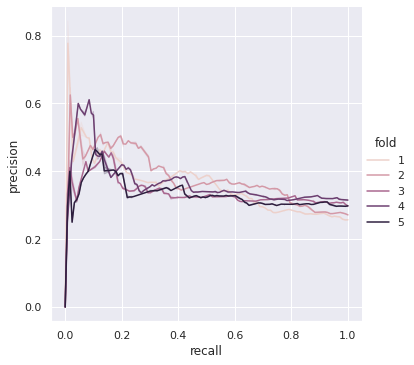

In [809]:
sns.relplot(x="recall", y="precision", hue='fold', kind="line", data=p_r_curves_to_plot)

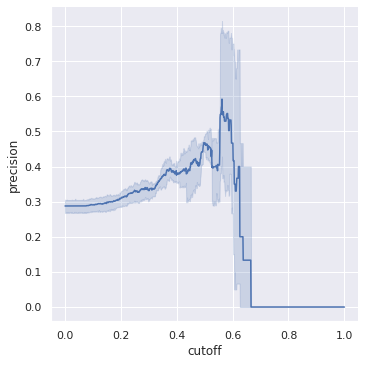

In [810]:
plot_ = sns.relplot(x="cutoff", y="precision", kind="line", data=p_r_curves_to_plot)

Alas, while we can indeed achieve a higher precision in our model by pushing the probability cutoff higher (closer to 0.6), our precision becomes much more variable across folds and so this adjustment does not represent a significant improvement.

#### Summary
By surveying various combinations of estimators and feature set modifications (probablistic imputation, undersampling, oversampling, pca embedding, etc), we were able to find models that improved upon the precision of a null model for all cannabis effects studied. These improvements in precision ranged from 6.94% to 34.61% (see below). However, if we constrain our results to only include models with a precision standard deviation less than 3 across five folds of cross validation, the improvements are decreased, and range from 2.22% to 15.01% (see below). For the target Energetic, whose top model with standard deviation less than 3 saw a precision improvement of 15.01%, hyperparameter tuning was undertaken, resulting in a further improved model with an additional 2.59% precision.

In [813]:
cv_results_featraw = pd.read_csv('./model_survey.csv')
cv_results_featraw = cv_results_featraw.drop(['Unnamed: 0'], axis=1)
cv_results_featraw['feat_set'] = 'feat_raw'

cv_results_featmod = pd.read_csv('./model_survey_featmod.csv')
cv_results_featmod = cv_results_featmod.drop(['Unnamed: 0'], axis=1)
cv_results_featmod['feat_set'] = 'feat_mod'

cv_results = pd.concat([cv_results_featraw, cv_results_featmod])

In [819]:
heat_map = pd.pivot_table(cv_results.query('measure == "precision"'), values='mean', index=['samplers', 'models', 'feat_set'],
                    columns='targets', aggfunc=np.sum)
print('top models: improvements over baseline')
heat_map.max() - baseline

top models: improvements over baseline


targets
target_Aroused      34.61
target_Creative     13.55
target_Energetic    20.47
target_Euphoric      9.07
target_Focused      24.39
target_Giggly       26.20
target_Happy         8.83
target_Hungry       19.03
target_Relaxed       6.94
target_Sleepy       34.18
target_Talkative    28.06
target_Tingly       12.25
target_Uplifted     11.67
dtype: float64

In [820]:
heat_map = pd.pivot_table(cv_results.query('measure == "precision" and std < 3'), values='mean', index=['samplers', 'models', 'feat_set'],
                    columns='targets', aggfunc=np.sum)
print('top models < 3 std: improvements over baseline')
heat_map.max() - baseline

top models < 3 std: improvements over baseline


targets
target_Aroused       2.98
target_Creative      8.09
target_Energetic    15.01
target_Euphoric      4.53
target_Focused       3.51
target_Giggly        2.22
target_Happy         4.70
target_Hungry        4.10
target_Relaxed       6.90
target_Sleepy       10.72
target_Talkative     5.93
target_Tingly        3.97
target_Uplifted     10.76
dtype: float64

#### Future Efforts

As stated above, there is much room for improvement in terms of further developing models for Energetic and the other targets that are consistently high in precision. Just as we were able to produce modest improvements in our Energetic models by optimizing hyperparameters, the same strategy could (and should!) be applied to each of the other targets. In terms of developing an improved model for Energetic, however, some additional strategies would need to be applied that may likely also improve models for the other targets.

Next to try will be more extensive experimentation with feature engineering. There are many features in this dataset that are conceptually analogous to each other (e.g. citrus, lemon, lime, grapefruit, and orange; mint and menthol). Introducing some custom features that are bins of related features may help reveal sample similarities not otherwise reflected in the raw data. Feature crosses may also provide more information. Especially with the introduction of additional features, feature selection strategies could also be useful to apply, along with more thoughtful regularization.
